In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt
import pprint

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Preparations

In [3]:
training_folders = []

In [4]:
data_source_btc = "BTC_histData_dt1800.0s_20220825_0629" 
data_source_perp = "Perp_BTC_FundingRate_Data_fakehist"

hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC'],
    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
                        'reward_differential_sharpe_ratio',],
#     'reward_function' : ['reward_sterling_ratio'],
    
    'learning_rate': [1e-3],
    'trainer' : ['DQNTrainer', 'DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [50], 
    'runs_p_eps' : [5], 
    'batch_size': [1],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.7],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
pprint.pprint(hpo_list)

[{'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 50,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),
  'reward_function': 'compute_reward_from_tutor',
  'runs_p_eps': 5,
  'trainer': 'DQNTrainer'},
 {'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 50,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),
  'reward_function': 'compute_reward_from_tutor',
  'runs_p_eps': 5,
  'trainer': 'DRLTrainer'},
 {'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 50,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 2

In [5]:
def conduct_traning(param_combination, i):
    if param_combination.get('trainer') == 'DQNTrainer':
        action_space = 4
        algorithm = f'DQN_trial_{i}'
    else:
        action_space = 1
        algorithm = f'DRL_trial_{i}'

    if param_combination.get('asset') == 'BTC':
        param_combination["data_source"] = data_source_btc
    else:
        param_combination["data_source"] = data_source_perp


    param_combination['action_space'] = action_space
    param_combination['algorithm'] = algorithm
    pprint.pprint(param_combination)

    env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            start_money = param_combination.get('money', 10000),
            trading_fee = param_combination.get('fee', 0.001),
            asset = param_combination.get('asset', 'BTC'),
            source_file = param_combination.get('data_source', data_source_btc),
            reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                       )

    agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                action_domain = param_combination.get('action_domain', (0.0,1.0)),
                epsilon = param_combination.get('epsilon', 0.7),
                epsilon_final = param_combination.get('epsilon_final', 0.01),
                epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                        )

    trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
    trainer = trainer_class(env, agent,
                observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                batch_size=param_combination.get('batch_size', 50),
                epoch=param_combination.get('epoch', 5),
                gamma=param_combination.get('gamma', 0.95),
                learning_rate=param_combination.get('learning_rate', 1e-3),
                algorithm=algorithm,
                lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
                # best_model_sequential_20back_10ahead lstm_2,
                           )

    os.makedirs(trainer.train_folder,exist_ok=True)
    with open(f'{trainer.train_folder}/params.json', 'w') as fp:
        json.dump(param_combination, fp)

    trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                       run_per_episode=param_combination.get('runs_p_eps', 2))
    
    return trainer.train_folder 

# Param combination 0

In [ ]:
i = 0
train_folder = conduct_traning(hpo_list[i], i)

{'action_domain': (0.0, 1.0),
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 1,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 5,
 'epsilon': 0.7,
 'epsilon_decay': 0.995,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'gamma': 0.95,
 'learning_rate': 0.001,
 'money': 10000,
 'obs_space': (8, 20),
 'reward_function': 'compute_reward_from_tutor',
 'runs_p_eps': 5,
 'trainer': 'DQNTrainer'}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                   

  0%|          | 0/671 [00:00<?, ?it/s]

Model Loss: mse
Episode: 1/50
Episode: 1/50 || Run 1/5
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2507
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2457
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2414
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2373
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2336


  0%|          | 2/671 [00:06<35:57,  3.22s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2296
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2253
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2207
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2156
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2100


  1%|          | 4/671 [00:06<15:37,  1.41s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2040
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1975
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1906
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1831
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1749


  1%|          | 6/671 [00:06<08:58,  1.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1661
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1569
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1470
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1367
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1260


  1%|          | 8/671 [00:07<06:05,  1.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1150
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1038
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0926
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0815
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0707


  1%|▏         | 10/671 [00:07<04:40,  2.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.0605
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0344
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0277


  2%|▏         | 12/671 [00:07<03:38,  3.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0077


  2%|▏         | 14/671 [00:08<02:48,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0020


  2%|▏         | 16/671 [00:08<02:35,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4948e-04
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5640e-04
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1016e-04


  3%|▎         | 18/671 [00:08<02:08,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9813e-04
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1097e-04
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4306e-04
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9010e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 2.4762e-04


  3%|▎         | 20/671 [00:08<01:48,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1390e-04
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8630e-04
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6425e-04
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4581e-04
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3081e-04


  3%|▎         | 22/671 [00:09<01:36,  6.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1817e-04
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0751e-04
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8617e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0838e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4444e-05


  4%|▎         | 24/671 [00:09<01:36,  6.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8891e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4123e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9920e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6304e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3156e-05


  4%|▍         | 26/671 [00:09<01:35,  6.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0280e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7824e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5672e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3706e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1996e-05


  4%|▍         | 28/671 [00:10<01:36,  6.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0495e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8989e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7718e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6691e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5659e-05


  4%|▍         | 30/671 [00:10<01:32,  6.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4706e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3886e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2976e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2338e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1674e-05


  5%|▍         | 32/671 [00:10<01:39,  6.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1068e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0556e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0043e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9593e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9148e-05


  5%|▌         | 34/671 [00:10<01:31,  6.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.8707e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8355e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7955e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7645e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7293e-05


  6%|▌         | 37/671 [00:11<01:19,  7.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7015e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6729e-05
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6407e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6158e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5842e-05


  6%|▌         | 38/671 [00:11<01:29,  7.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5668e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5421e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5191e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4989e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4812e-05


  6%|▌         | 40/671 [00:11<01:20,  7.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4581e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4430e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4223e-05
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.4052e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3863e-05


  6%|▋         | 42/671 [00:11<01:16,  8.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3690e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3577e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3358e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3183e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2999e-05


  7%|▋         | 44/671 [00:12<01:09,  8.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2879e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2699e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2590e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2375e-05
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2257e-05


  7%|▋         | 46/671 [00:12<01:08,  9.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2107e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1908e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1791e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1630e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1518e-05


  7%|▋         | 48/671 [00:12<01:04,  9.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1410e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1202e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1098e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0910e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0865e-05


  7%|▋         | 50/671 [00:12<01:13,  8.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0717e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0540e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0408e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0311e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0126e-05


  8%|▊         | 52/671 [00:12<01:10,  8.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9999e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9890e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9762e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9654e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9482e-05


  8%|▊         | 54/671 [00:13<01:16,  8.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9367e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9187e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9134e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8985e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8854e-05


  8%|▊         | 57/671 [00:13<01:18,  7.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8735e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8595e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8454e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8377e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8204e-05


  9%|▊         | 58/671 [00:13<01:39,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.8091e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8005e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7886e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7761e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7632e-05


  9%|▉         | 60/671 [00:14<01:36,  6.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7506e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7424e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7300e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7132e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7075e-05


  9%|▉         | 62/671 [00:14<01:24,  7.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6949e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6761e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6687e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6564e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6410e-05


 10%|▉         | 64/671 [00:14<01:35,  6.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6329e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6221e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6114e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6025e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5905e-05


 10%|▉         | 66/671 [00:15<01:43,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5822e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5664e-05
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5595e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5437e-05
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 2.5324e-05


 10%|█         | 68/671 [00:15<01:40,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5226e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5108e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5043e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4909e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4832e-05


 11%|█         | 71/671 [00:16<01:37,  6.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4722e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4575e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4481e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4386e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4264e-05


 11%|█         | 72/671 [00:16<01:42,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4188e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4038e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3964e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3849e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3756e-05


 11%|█         | 74/671 [00:16<01:34,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3658e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3573e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3483e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3367e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3294e-05


 11%|█▏        | 77/671 [00:16<01:18,  7.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3186e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3097e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2969e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2882e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2767e-05


 12%|█▏        | 78/671 [00:17<01:28,  6.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2676e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2595e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2477e-05
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2390e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2289e-05


 12%|█▏        | 80/671 [00:17<01:18,  7.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.2212e-05
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2087e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2049e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1906e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1837e-05


 12%|█▏        | 83/671 [00:17<01:20,  7.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1788e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1679e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1577e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1444e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1401e-05


 13%|█▎        | 84/671 [00:18<01:47,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1290e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1207e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1110e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1017e-05
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.0938e-05


 13%|█▎        | 86/671 [00:18<01:30,  6.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0867e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0775e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0691e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0608e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0516e-05


 13%|█▎        | 88/671 [00:18<01:29,  6.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0441e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0366e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0310e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0158e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0105e-05


 13%|█▎        | 90/671 [00:18<01:28,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0038e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9929e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9853e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9724e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9651e-05


 14%|█▍        | 93/671 [00:19<01:15,  7.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9601e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9526e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9452e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9390e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9282e-05


 14%|█▍        | 95/671 [00:19<01:33,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9215e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9161e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9058e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8971e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8898e-05


 14%|█▍        | 97/671 [00:19<01:30,  6.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8827e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8756e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8681e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8623e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8524e-05


 15%|█▍        | 98/671 [00:20<02:04,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8473e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8374e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8298e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8247e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8151e-05


 15%|█▌        | 101/671 [00:20<01:57,  4.84it/s]

Data saved
episode 1, run (1/5) sample (100/671).Profit 136.21999999999935
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8075e-05
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8003e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7934e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7885e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7786e-05


 15%|█▌        | 103/671 [00:21<01:50,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7738e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7659e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7580e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7519e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7461e-05


 16%|█▌        | 105/671 [00:21<01:47,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7355e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7320e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7266e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7141e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7112e-05


 16%|█▌        | 106/671 [00:22<02:09,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7069e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6934e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6902e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6851e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6782e-05


 16%|█▌        | 108/671 [00:22<01:38,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6692e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6644e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6602e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6505e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6448e-05


 16%|█▋        | 110/671 [00:22<01:31,  6.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6389e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6317e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6265e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6192e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6145e-05


 17%|█▋        | 112/671 [00:22<01:29,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6075e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6012e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5966e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5879e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5836e-05


 17%|█▋        | 114/671 [00:23<01:28,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5787e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5719e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5634e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5568e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5548e-05


 17%|█▋        | 116/671 [00:23<01:25,  6.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5478e-05
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5407e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5351e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5293e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5232e-05


 18%|█▊        | 118/671 [00:23<01:33,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5187e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5106e-05
Epoch 3/5
1/1 [==============================] - 0s 18ms/step - loss: 1.5066e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5011e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4939e-05


 18%|█▊        | 121/671 [00:24<01:32,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4894e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4870e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4802e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4726e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4685e-05


 18%|█▊        | 122/671 [00:24<01:37,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4634e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4552e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4520e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4467e-05
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4410e-05


 18%|█▊        | 124/671 [00:24<01:43,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 29ms/step - loss: 1.4350e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4323e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4247e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4182e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4151e-05


 19%|█▉        | 127/671 [00:25<01:50,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4089e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4035e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3969e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3930e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3886e-05


 19%|█▉        | 128/671 [00:25<01:53,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3832e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3788e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3745e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3667e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3628e-05


 19%|█▉        | 130/671 [00:26<01:40,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3566e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3535e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3494e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3423e-05
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3391e-05


 20%|█▉        | 132/671 [00:26<01:34,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3333e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3279e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3243e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3200e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3153e-05


 20%|█▉        | 134/671 [00:26<01:21,  6.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3099e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3053e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3029e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2954e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2917e-05


 20%|██        | 136/671 [00:27<01:18,  6.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2883e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2812e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2797e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2749e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2679e-05


 21%|██        | 139/671 [00:27<01:29,  5.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2642e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2583e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2546e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2503e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2457e-05


 21%|██        | 140/671 [00:27<01:45,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2428e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2392e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2341e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2289e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2243e-05


 21%|██        | 142/671 [00:28<01:34,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2208e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2152e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2130e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2091e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2054e-05


 21%|██▏       | 144/671 [00:28<01:38,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2005e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1964e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1939e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1890e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1829e-05


 22%|██▏       | 146/671 [00:28<01:31,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1809e-05
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1754e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1713e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1669e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1643e-05


 22%|██▏       | 148/671 [00:29<01:28,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1586e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1539e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1514e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1489e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1440e-05


 22%|██▏       | 150/671 [00:29<01:22,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1383e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1359e-05
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1328e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1281e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1245e-05


 23%|██▎       | 152/671 [00:29<01:21,  6.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1209e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1169e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1115e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1078e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1056e-05


 23%|██▎       | 154/671 [00:30<01:28,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0995e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0972e-05
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0958e-05
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0921e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0887e-05


 23%|██▎       | 156/671 [00:30<01:34,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0845e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0810e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0774e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0727e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0695e-05


 24%|██▎       | 158/671 [00:31<01:34,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0674e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0631e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0601e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0563e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0508e-05


 24%|██▍       | 160/671 [00:31<01:37,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0486e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0453e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0424e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0376e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0358e-05


 24%|██▍       | 162/671 [00:31<01:37,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0310e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0287e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0245e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0219e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0179e-05


 24%|██▍       | 164/671 [00:32<01:30,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0145e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0117e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0090e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0053e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0010e-05


 25%|██▍       | 167/671 [00:32<01:27,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9815e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9667e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9318e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8915e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8598e-06


 25%|██▌       | 168/671 [00:32<01:41,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8180e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7996e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7753e-06
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 9.7445e-06
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 9.7012e-06


 25%|██▌       | 170/671 [00:33<01:48,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6702e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6377e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6196e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5893e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5367e-06


 26%|██▌       | 173/671 [00:34<01:55,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5237e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4814e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4708e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4184e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3989e-06


 26%|██▌       | 175/671 [00:34<01:55,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3669e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3513e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3220e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2883e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2601e-06


 26%|██▌       | 176/671 [00:35<02:06,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2292e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1791e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1685e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1509e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 9.1153e-06


 27%|██▋       | 178/671 [00:35<01:45,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0877e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0502e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0154e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0077e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9721e-06


 27%|██▋       | 180/671 [00:35<01:40,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9308e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9148e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8903e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8647e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8372e-06


 27%|██▋       | 182/671 [00:36<01:33,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8032e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7725e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7552e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7308e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7137e-06


 28%|██▊       | 185/671 [00:36<01:21,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6849e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6558e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6330e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5880e-06
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 8.5684e-06


 28%|██▊       | 186/671 [00:36<01:39,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5518e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5179e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4991e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4634e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4407e-06


 28%|██▊       | 188/671 [00:37<01:28,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4216e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3835e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3624e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3458e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3310e-06


 28%|██▊       | 190/671 [00:37<01:21,  5.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3053e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2670e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2524e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2275e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1876e-06


 29%|██▊       | 192/671 [00:37<01:18,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1736e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1550e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1155e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0959e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0757e-06


 29%|██▉       | 194/671 [00:38<01:23,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0592e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0420e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0160e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9689e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9631e-06


 29%|██▉       | 196/671 [00:38<01:26,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9413e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9282e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8850e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8634e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8504e-06


 30%|██▉       | 198/671 [00:38<01:21,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8238e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7958e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7817e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7528e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7386e-06


 30%|██▉       | 201/671 [00:39<01:26,  5.42it/s]

Data saved
episode 1, run (1/5) sample (200/671).Profit 216.39999999999964
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7268e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6997e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6683e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6342e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6279e-06


 30%|███       | 203/671 [00:39<01:27,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5953e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5760e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5635e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5300e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5116e-06


 31%|███       | 205/671 [00:40<01:17,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4921e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4624e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4574e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4336e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4137e-06


 31%|███       | 206/671 [00:40<01:21,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3903e-06
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3709e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3397e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3228e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3110e-06


 31%|███       | 208/671 [00:40<01:16,  6.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2879e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2455e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2231e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2078e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1964e-06


 31%|███▏      | 210/671 [00:41<01:22,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1743e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1499e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1355e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1055e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0979e-06


 32%|███▏      | 212/671 [00:41<01:16,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0717e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0637e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0309e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0110e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0011e-06


 32%|███▏      | 214/671 [00:41<01:21,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9872e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9716e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9490e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9189e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9039e-06


 32%|███▏      | 216/671 [00:41<01:10,  6.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8842e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8753e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8580e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8372e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8192e-06


 32%|███▏      | 218/671 [00:42<01:09,  6.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8073e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7784e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7561e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7412e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7201e-06


 33%|███▎      | 220/671 [00:42<01:16,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 26ms/step - loss: 6.7103e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6836e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6604e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6527e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6278e-06


 33%|███▎      | 223/671 [00:43<01:18,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6085e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5904e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5682e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5590e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5433e-06


 34%|███▎      | 225/671 [00:43<01:13,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.5230e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5045e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4863e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4783e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4651e-06


 34%|███▎      | 226/671 [00:43<01:27,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.4427e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4349e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4011e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3865e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3690e-06


 34%|███▍      | 229/671 [00:44<01:20,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3557e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3220e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3089e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2917e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2846e-06


 34%|███▍      | 231/671 [00:44<01:17,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2643e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2487e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2339e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2131e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1987e-06


 35%|███▍      | 233/671 [00:45<01:24,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1915e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1699e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1555e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1407e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1296e-06


 35%|███▍      | 234/671 [00:45<01:49,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1064e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0896e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0748e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0565e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0385e-06


 35%|███▌      | 236/671 [00:45<01:26,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0239e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0131e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9931e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9808e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9667e-06


 35%|███▌      | 238/671 [00:46<01:09,  6.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9604e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9444e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9259e-06
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 5.8980e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8844e-06


 36%|███▌      | 240/671 [00:46<01:08,  6.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8690e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8581e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8382e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8281e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8126e-06


 36%|███▌      | 242/671 [00:46<01:12,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7988e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7768e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7716e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7588e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7265e-06


 36%|███▋      | 244/671 [00:47<01:09,  6.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7227e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7054e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6937e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6861e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6729e-06


 37%|███▋      | 246/671 [00:47<01:14,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6635e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6409e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6214e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6122e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5932e-06


 37%|███▋      | 248/671 [00:47<01:10,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5878e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5686e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5586e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5454e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5292e-06


 37%|███▋      | 250/671 [00:48<01:08,  6.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5095e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4991e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4850e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4743e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4635e-06


 38%|███▊      | 252/671 [00:48<01:11,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4520e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4313e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4199e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4088e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3976e-06


 38%|███▊      | 255/671 [00:48<01:09,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3800e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3637e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3545e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3369e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3331e-06


 38%|███▊      | 257/671 [00:49<01:07,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3178e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3079e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2818e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2751e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2673e-06


 39%|███▊      | 259/671 [00:49<01:16,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2477e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2388e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2303e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2181e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2025e-06


 39%|███▊      | 260/671 [00:50<01:28,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1814e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1687e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1555e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1444e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1369e-06


 39%|███▉      | 262/671 [00:50<01:17,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1186e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1094e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0938e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0827e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0653e-06


 39%|███▉      | 264/671 [00:50<01:18,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0543e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0479e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0411e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0288e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0146e-06


 40%|███▉      | 266/671 [00:51<01:19,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0070e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9885e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9713e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9644e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9586e-06


 40%|███▉      | 268/671 [00:51<01:19,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9387e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9249e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9128e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9059e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8994e-06


 40%|████      | 270/671 [00:51<01:20,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.8813e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8711e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8555e-06
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 4.8535e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8431e-06


 41%|████      | 272/671 [00:52<01:24,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8273e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8186e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8111e-06
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 4.7893e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7777e-06


 41%|████      | 275/671 [00:52<01:12,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7670e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7582e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7501e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7410e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7322e-06


 41%|████      | 276/671 [00:53<01:17,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7259e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7001e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6920e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6853e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6780e-06


 41%|████▏     | 278/671 [00:53<01:04,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6637e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6545e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6401e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6273e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6224e-06


 42%|████▏     | 280/671 [00:53<01:07,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6122e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5999e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5840e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5710e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5651e-06


 42%|████▏     | 283/671 [00:54<01:05,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5547e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5407e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5351e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5198e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5164e-06


 42%|████▏     | 285/671 [00:54<01:03,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 4.5055e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4966e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4808e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4694e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4573e-06


 43%|████▎     | 287/671 [00:54<01:04,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4495e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4406e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4257e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4232e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4155e-06


 43%|████▎     | 289/671 [00:55<01:12,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3980e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3800e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3716e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3674e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3622e-06


 43%|████▎     | 291/671 [00:55<01:21,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3531e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3410e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3379e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3247e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3085e-06


 44%|████▎     | 292/671 [00:56<01:30,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3011e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2943e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2780e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2700e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2666e-06


 44%|████▍     | 294/671 [00:56<01:24,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2601e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2490e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2396e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2204e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2167e-06


 44%|████▍     | 296/671 [00:57<01:19,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2077e-06
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 4.2033e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1874e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1837e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1783e-06


 44%|████▍     | 298/671 [00:57<01:11,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1689e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1568e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1493e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1406e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1271e-06


 45%|████▍     | 301/671 [00:58<01:25,  4.33it/s]

Data saved
episode 1, run (1/5) sample (300/671).Profit -886.1599999999999
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1189e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1074e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1002e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0988e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0904e-06


 45%|████▌     | 302/671 [00:58<01:34,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0785e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0704e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0544e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0514e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0392e-06


 45%|████▌     | 304/671 [00:58<01:25,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0298e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0216e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0066e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0025e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9968e-06


 46%|████▌     | 307/671 [00:59<01:11,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9879e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9722e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9668e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9587e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9492e-06


 46%|████▌     | 309/671 [00:59<01:10,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9432e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9410e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9308e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9088e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9033e-06


 46%|████▌     | 310/671 [01:00<01:20,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8996e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8950e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8858e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8738e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8692e-06


 47%|████▋     | 313/671 [01:00<01:06,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8587e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8541e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8438e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8254e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8219e-06


 47%|████▋     | 314/671 [01:00<01:08,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8155e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8121e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8028e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7938e-06
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 3.7850e-06


 47%|████▋     | 316/671 [01:01<01:01,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7814e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7715e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7570e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7540e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7479e-06


 47%|████▋     | 318/671 [01:01<01:03,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7426e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7298e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7186e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7138e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7052e-06


 48%|████▊     | 321/671 [01:01<00:57,  6.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6995e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6925e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6860e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6811e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6699e-06


 48%|████▊     | 322/671 [01:02<01:04,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6641e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6523e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6425e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6379e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6348e-06


 48%|████▊     | 324/671 [01:02<01:03,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.6236e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6166e-06
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 3.6050e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6009e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5969e-06


 49%|████▊     | 326/671 [01:02<01:04,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5869e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5804e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5740e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5608e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5569e-06


 49%|████▉     | 328/671 [01:03<01:04,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5506e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5428e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5319e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5295e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5190e-06


 49%|████▉     | 330/671 [01:03<00:54,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5121e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5026e-06
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4945e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4873e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4792e-06


 49%|████▉     | 332/671 [01:03<00:58,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4721e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4630e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4598e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4511e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4391e-06


 50%|████▉     | 334/671 [01:04<00:59,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4370e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4355e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4284e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4201e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4090e-06


 50%|█████     | 336/671 [01:04<00:56,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4059e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4003e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3934e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3849e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3797e-06


 50%|█████     | 338/671 [01:04<00:54,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3721e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3686e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3635e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3578e-06
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 3.3509e-06


 51%|█████     | 341/671 [01:05<00:49,  6.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 54ms/step - loss: 3.3400e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3335e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3261e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3183e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3178e-06


 51%|█████     | 342/671 [01:05<01:02,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3057e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3002e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2896e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2863e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2819e-06


 51%|█████▏    | 344/671 [01:06<01:05,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 50ms/step - loss: 3.2735e-06
Epoch 2/5
1/1 [==============================] - 0s 32ms/step - loss: 3.2651e-06
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 3.2599e-06
Epoch 4/5
1/1 [==============================] - 0s 26ms/step - loss: 3.2573e-06
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 3.2500e-06


 52%|█████▏    | 347/671 [01:06<01:05,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2487e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2399e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2314e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2201e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2188e-06


 52%|█████▏    | 349/671 [01:07<01:18,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2149e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2121e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2052e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1896e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1837e-06


 52%|█████▏    | 351/671 [01:07<01:11,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1777e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1753e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1727e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1680e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1523e-06


 53%|█████▎    | 353/671 [01:08<01:12,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1402e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1396e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1329e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1260e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1199e-06


 53%|█████▎    | 354/671 [01:08<01:14,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1186e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1080e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1036e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0942e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0880e-06


 53%|█████▎    | 356/671 [01:08<01:10,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0858e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0824e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0707e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0608e-06
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 3.0581e-06


 54%|█████▎    | 359/671 [01:09<00:59,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0524e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0515e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0472e-06
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0433e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0265e-06


 54%|█████▎    | 360/671 [01:09<01:14,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0220e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0198e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0130e-06
Epoch 4/5
1/1 [==============================] - 0s 26ms/step - loss: 3.0091e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0048e-06


 54%|█████▍    | 363/671 [01:10<01:05,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9957e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9924e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9893e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9867e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9799e-06


 54%|█████▍    | 365/671 [01:10<01:00,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9723e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9671e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9566e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9504e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9467e-06


 55%|█████▍    | 366/671 [01:11<01:09,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9434e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9368e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9341e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9250e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9158e-06


 55%|█████▍    | 368/671 [01:11<00:59,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9126e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9097e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9057e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9026e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8938e-06


 55%|█████▌    | 370/671 [01:11<00:53,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8882e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8832e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8773e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8713e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8652e-06


 56%|█████▌    | 373/671 [01:12<00:50,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8620e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8588e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8541e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8516e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8418e-06


 56%|█████▌    | 374/671 [01:12<00:57,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8331e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8296e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8278e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8223e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8185e-06


 56%|█████▌    | 376/671 [01:12<00:52,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8070e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8064e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8006e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7950e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7923e-06


 56%|█████▋    | 378/671 [01:13<00:54,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7831e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7793e-06
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7696e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7655e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7647e-06


 57%|█████▋    | 381/671 [01:13<00:47,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7589e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7492e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7438e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7430e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7394e-06


 57%|█████▋    | 382/671 [01:13<00:56,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7316e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7264e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7215e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7147e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7112e-06


 57%|█████▋    | 385/671 [01:14<00:47,  6.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7090e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6976e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6934e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6882e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6828e-06


 58%|█████▊    | 386/671 [01:14<01:00,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6781e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6760e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6716e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6691e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6626e-06


 58%|█████▊    | 388/671 [01:14<00:47,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6599e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6571e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6479e-06
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.6416e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6399e-06


 58%|█████▊    | 390/671 [01:15<00:46,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6361e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6337e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6236e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6216e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6132e-06


 59%|█████▊    | 393/671 [01:15<00:47,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6102e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6077e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6024e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5942e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5910e-06


 59%|█████▊    | 394/671 [01:16<00:56,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5893e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5831e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5811e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5735e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5723e-06


 59%|█████▉    | 397/671 [01:16<00:49,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 168ms/step - loss: 2.5632e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5556e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5523e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5486e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5442e-06


 59%|█████▉    | 398/671 [01:17<01:08,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5402e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5371e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5327e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5271e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5235e-06


 60%|█████▉    | 401/671 [01:17<01:15,  3.59it/s]

Data saved
episode 1, run (1/5) sample (400/671).Profit -1129.6000000000004
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5188e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5163e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5133e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5064e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5027e-06


 60%|██████    | 403/671 [01:18<01:04,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4947e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4896e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4861e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4835e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4786e-06


 60%|██████    | 404/671 [01:18<01:09,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4739e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4715e-06
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4615e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4600e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4573e-06


 61%|██████    | 407/671 [01:19<00:49,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4562e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4506e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4474e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4424e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4381e-06


 61%|██████    | 408/671 [01:19<01:02,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4300e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4220e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4171e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4166e-06


 61%|██████    | 410/671 [01:19<00:52,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4135e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4088e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3990e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3982e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3946e-06


 61%|██████▏   | 412/671 [01:20<00:47,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3915e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3864e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3828e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3824e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3711e-06


 62%|██████▏   | 415/671 [01:20<00:43,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3678e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3665e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3591e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3522e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3495e-06


 62%|██████▏   | 416/671 [01:20<00:50,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3482e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3436e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3397e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3358e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3302e-06


 62%|██████▏   | 418/671 [01:21<00:45,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3250e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3249e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3224e-06
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3185e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3103e-06


 63%|██████▎   | 421/671 [01:21<00:39,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3044e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3022e-06
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.3013e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2993e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2966e-06


 63%|██████▎   | 422/671 [01:21<00:45,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2935e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2869e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2810e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2782e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2745e-06


 63%|██████▎   | 425/671 [01:22<00:42,  5.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2703e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2649e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2619e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2555e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2541e-06


 63%|██████▎   | 426/671 [01:22<00:54,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2494e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2470e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2410e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2379e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2353e-06


 64%|██████▍   | 428/671 [01:23<00:51,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2313e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2261e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2252e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2225e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2174e-06


 64%|██████▍   | 431/671 [01:23<00:49,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2155e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2127e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2083e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2003e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1969e-06


 64%|██████▍   | 432/671 [01:24<00:54,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1904e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1886e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1877e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1864e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1841e-06


 65%|██████▍   | 434/671 [01:24<00:47,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1776e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1724e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1702e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1664e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1604e-06


 65%|██████▌   | 437/671 [01:24<00:42,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1594e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1583e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1541e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1474e-06
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 2.1444e-06


 65%|██████▌   | 438/671 [01:25<00:43,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1419e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1389e-06
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 2.1338e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1337e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1296e-06


 66%|██████▌   | 441/671 [01:25<00:40,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1259e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1220e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1157e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1135e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1107e-06


 66%|██████▌   | 442/671 [01:25<00:49,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1068e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1037e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1022e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0978e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0914e-06


 66%|██████▌   | 444/671 [01:26<00:48,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0869e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0847e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0783e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0769e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0728e-06


 67%|██████▋   | 447/671 [01:26<00:43,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0704e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0667e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0623e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0621e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0591e-06


 67%|██████▋   | 448/671 [01:27<00:51,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0531e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0510e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0504e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0455e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0390e-06


 67%|██████▋   | 450/671 [01:27<00:44,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0359e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0341e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0279e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0254e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0248e-06


 68%|██████▊   | 453/671 [01:28<00:38,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0210e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0167e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0151e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0121e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0085e-06


 68%|██████▊   | 454/671 [01:28<00:45,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0048e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0043e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0020e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9992e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9960e-06


 68%|██████▊   | 456/671 [01:28<00:43,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9894e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9872e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9835e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9805e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9796e-06


 68%|██████▊   | 458/671 [01:29<00:39,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9748e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9702e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9652e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9634e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9608e-06


 69%|██████▊   | 460/671 [01:29<00:36,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9560e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9515e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9511e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9483e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9444e-06


 69%|██████▉   | 462/671 [01:29<00:34,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9424e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9398e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9391e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9316e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9298e-06


 69%|██████▉   | 464/671 [01:30<00:36,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9286e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9258e-06
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9208e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9176e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9142e-06


 70%|██████▉   | 467/671 [01:30<00:32,  6.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9125e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9108e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9062e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9053e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9029e-06


 70%|██████▉   | 468/671 [01:30<00:37,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9010e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8918e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8901e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8899e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8866e-06


 70%|███████   | 470/671 [01:31<00:38,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8849e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8793e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8774e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8740e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8704e-06


 70%|███████   | 473/671 [01:31<00:32,  6.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8676e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8660e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8653e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8590e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8579e-06


 71%|███████   | 474/671 [01:31<00:37,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8557e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8480e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8459e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8432e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8419e-06


 71%|███████   | 476/671 [01:32<00:37,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8417e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8397e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8344e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8332e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8301e-06


 71%|███████   | 478/671 [01:32<00:37,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8241e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8184e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8171e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8164e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8148e-06


 72%|███████▏  | 480/671 [01:33<00:37,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8116e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8088e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8024e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8014e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7988e-06


 72%|███████▏  | 483/671 [01:33<00:32,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7970e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7944e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7927e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7902e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7849e-06


 72%|███████▏  | 484/671 [01:33<00:34,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7822e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7805e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7768e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7743e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7729e-06


 72%|███████▏  | 486/671 [01:34<00:36,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7713e-06
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7671e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7615e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7599e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7561e-06


 73%|███████▎  | 489/671 [01:34<00:31,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7544e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7511e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7484e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7471e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7455e-06


 73%|███████▎  | 490/671 [01:34<00:33,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7408e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7402e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7391e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7361e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7308e-06


 73%|███████▎  | 492/671 [01:35<00:27,  6.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7298e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7264e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7248e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7212e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7187e-06


 74%|███████▍  | 495/671 [01:35<00:28,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7177e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7144e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7118e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7093e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7077e-06


 74%|███████▍  | 496/671 [01:35<00:36,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7058e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7031e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6984e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6965e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6934e-06


 74%|███████▍  | 498/671 [01:36<00:32,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6928e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6913e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6851e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6825e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6809e-06


 75%|███████▍  | 501/671 [01:37<00:49,  3.46it/s]

Data saved
episode 1, run (1/5) sample (500/671).Profit -1214.7199999999993
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6778e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6737e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6711e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6690e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6664e-06


 75%|███████▍  | 503/671 [01:37<00:38,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6647e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6629e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6625e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6588e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6574e-06


 75%|███████▌  | 504/671 [01:37<00:42,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6560e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6511e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6481e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6450e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6423e-06


 75%|███████▌  | 506/671 [01:38<00:34,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6421e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6405e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6376e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6333e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6315e-06


 76%|███████▌  | 509/671 [01:38<00:29,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6291e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6266e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6240e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6217e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6187e-06


 76%|███████▌  | 510/671 [01:39<00:33,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6178e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6155e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6143e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6102e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6078e-06


 76%|███████▋  | 512/671 [01:39<00:29,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6064e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6056e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6032e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6000e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5979e-06


 77%|███████▋  | 514/671 [01:39<00:30,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5959e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5916e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5884e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5843e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5840e-06


 77%|███████▋  | 516/671 [01:40<00:29,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5815e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5797e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5791e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5783e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5777e-06


 77%|███████▋  | 518/671 [01:40<00:30,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5753e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5677e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5657e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5650e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5624e-06


 77%|███████▋  | 520/671 [01:40<00:30,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 39ms/step - loss: 1.5629e-06
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.5582e-06
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 1.5552e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5512e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5490e-06


 78%|███████▊  | 523/671 [01:41<00:35,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5477e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5456e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5417e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5382e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5362e-06


 78%|███████▊  | 525/671 [01:42<00:39,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5349e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5339e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5315e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5295e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5286e-06


 79%|███████▊  | 527/671 [01:43<00:35,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5269e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5237e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5202e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5189e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5163e-06


 79%|███████▉  | 529/671 [01:43<00:31,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5148e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5115e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5082e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5068e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5042e-06


 79%|███████▉  | 530/671 [01:43<00:30,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5022e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5016e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4995e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4992e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4956e-06


 79%|███████▉  | 533/671 [01:44<00:25,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4911e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4892e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4877e-06
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 1.4859e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4853e-06


 80%|███████▉  | 534/671 [01:44<00:30,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4830e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4799e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4791e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4768e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4751e-06


 80%|███████▉  | 536/671 [01:44<00:30,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4701e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4691e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4677e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4646e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4628e-06


 80%|████████  | 538/671 [01:45<00:28,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 39ms/step - loss: 1.4614e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4608e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4604e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4571e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4554e-06


 81%|████████  | 541/671 [01:45<00:21,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4537e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4499e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4477e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4461e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4459e-06


 81%|████████  | 542/671 [01:45<00:23,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4436e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4421e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4393e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4377e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4352e-06


 81%|████████  | 544/671 [01:46<00:22,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4309e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4304e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4295e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4285e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4228e-06


 81%|████████▏ | 546/671 [01:46<00:23,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4211e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4187e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4172e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4154e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4138e-06


 82%|████████▏ | 549/671 [01:47<00:20,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4127e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4107e-06
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 1.4087e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4068e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4041e-06


 82%|████████▏ | 551/671 [01:47<00:21,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4025e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3998e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3969e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3961e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3947e-06


 82%|████████▏ | 552/671 [01:47<00:24,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3934e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3915e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3889e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3852e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3839e-06


 83%|████████▎ | 554/671 [01:48<00:23,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3816e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3793e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3780e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3761e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3729e-06


 83%|████████▎ | 556/671 [01:48<00:23,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3723e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3710e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3694e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3679e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3633e-06


 83%|████████▎ | 558/671 [01:49<00:22,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3607e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3596e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3595e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3580e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3568e-06


 83%|████████▎ | 560/671 [01:49<00:18,  5.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3554e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3529e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3491e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3462e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3448e-06


 84%|████████▍ | 562/671 [01:49<00:19,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3436e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3417e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3404e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3395e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3377e-06


 84%|████████▍ | 564/671 [01:50<00:19,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3369e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3364e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3330e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3286e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3258e-06


 84%|████████▍ | 566/671 [01:50<00:18,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3256e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3247e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3236e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3220e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3187e-06


 85%|████████▍ | 569/671 [01:50<00:17,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3157e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3153e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3119e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3112e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3095e-06


 85%|████████▌ | 571/671 [01:51<00:16,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3092e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3089e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3069e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3037e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2988e-06


 85%|████████▌ | 573/671 [01:51<00:17,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2972e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2963e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2958e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2948e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2934e-06


 86%|████████▌ | 574/671 [01:51<00:20,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2910e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2892e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2866e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2853e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-06


 86%|████████▌ | 576/671 [01:52<00:19,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2813e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2794e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2786e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2769e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2762e-06


 86%|████████▌ | 578/671 [01:52<00:19,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2743e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2716e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2697e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2684e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2679e-06


 86%|████████▋ | 580/671 [01:53<00:18,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2661e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2648e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2629e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2606e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2592e-06


 87%|████████▋ | 583/671 [01:53<00:15,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2576e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2543e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2539e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2514e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2504e-06


 87%|████████▋ | 584/671 [01:53<00:18,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2502e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2487e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2473e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2452e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2428e-06


 87%|████████▋ | 586/671 [01:54<00:17,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2398e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2395e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2372e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2361e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2345e-06


 88%|████████▊ | 588/671 [01:54<00:16,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2324e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2319e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2298e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2290e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2263e-06


 88%|████████▊ | 590/671 [01:55<00:14,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2237e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2237e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2223e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2212e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2189e-06


 88%|████████▊ | 592/671 [01:55<00:15,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2186e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2169e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2157e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2128e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2107e-06


 89%|████████▊ | 594/671 [01:55<00:14,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2101e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2082e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2067e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2065e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2046e-06


 89%|████████▉ | 596/671 [01:56<00:13,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2001e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1981e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1972e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1944e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1935e-06


 89%|████████▉ | 598/671 [01:56<00:12,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1924e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1919e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1890e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1879e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1874e-06


 90%|████████▉ | 601/671 [01:57<00:20,  3.47it/s]

Data saved
episode 1, run (1/5) sample (600/671).Profit -955.7199999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1834e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1820e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1808e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1787e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1776e-06


 90%|████████▉ | 603/671 [01:57<00:16,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1772e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1735e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1729e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1723e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1705e-06


 90%|█████████ | 604/671 [01:58<00:16,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1685e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1669e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1651e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1628e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1619e-06


 90%|█████████ | 606/671 [01:58<00:15,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1595e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1593e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1582e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1567e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1558e-06


 91%|█████████ | 608/671 [01:58<00:12,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1549e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1531e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1516e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1502e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1500e-06


 91%|█████████ | 611/671 [01:59<00:11,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1485e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1475e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1451e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1429e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1420e-06


 91%|█████████ | 612/671 [01:59<00:12,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1409e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1389e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1371e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1357e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1353e-06


 92%|█████████▏| 614/671 [02:00<00:10,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1337e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1317e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1313e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1291e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1283e-06


 92%|█████████▏| 616/671 [02:00<00:10,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1265e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1250e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1224e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1223e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1199e-06


 92%|█████████▏| 618/671 [02:00<00:09,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1173e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1161e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1152e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1147e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1136e-06


 92%|█████████▏| 620/671 [02:01<00:09,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1120e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1094e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1075e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1064e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1047e-06


 93%|█████████▎| 622/671 [02:01<00:08,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1023e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1017e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1006e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0996e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0987e-06


 93%|█████████▎| 624/671 [02:01<00:08,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0976e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0971e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0953e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0934e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0914e-06


 93%|█████████▎| 626/671 [02:02<00:08,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0908e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0893e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0855e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0845e-06


 94%|█████████▎| 628/671 [02:02<00:09,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0838e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0822e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0818e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0798e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0773e-06


 94%|█████████▍| 630/671 [02:03<00:08,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0761e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0744e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0738e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0733e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0719e-06


 94%|█████████▍| 632/671 [02:03<00:08,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 1.0709e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0688e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0681e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0673e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0668e-06


 95%|█████████▍| 635/671 [02:04<00:07,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0637e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0624e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0618e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0597e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0575e-06


 95%|█████████▍| 636/671 [02:04<00:07,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0567e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0545e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0529e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0511e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0504e-06


 95%|█████████▌| 639/671 [02:05<00:06,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0498e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0491e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0479e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0460e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0456e-06


 96%|█████████▌| 641/671 [02:05<00:06,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0436e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0428e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0418e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0373e-06


 96%|█████████▌| 642/671 [02:06<00:07,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0368e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0362e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0323e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0315e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0311e-06


 96%|█████████▌| 644/671 [02:06<00:05,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0291e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0285e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0277e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0263e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0257e-06


 96%|█████████▋| 646/671 [02:06<00:04,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0246e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0236e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0219e-06
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0206e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0182e-06


 97%|█████████▋| 648/671 [02:07<00:06,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0175e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0159e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0141e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0140e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0138e-06


 97%|█████████▋| 651/671 [02:08<00:04,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0108e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0077e-06
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0074e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0067e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0059e-06


 97%|█████████▋| 653/671 [02:08<00:04,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0048e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0047e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0034e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0013e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0004e-06


 98%|█████████▊| 655/671 [02:09<00:03,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9953e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9777e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9615e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9458e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9385e-07


 98%|█████████▊| 656/671 [02:09<00:03,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9309e-07
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9097e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9064e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9008e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8937e-07


 98%|█████████▊| 659/671 [02:10<00:02,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8882e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8780e-07
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 9.8546e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8390e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8169e-07


 98%|█████████▊| 660/671 [02:10<00:02,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 9.8061e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7836e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7831e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7757e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7749e-07


 99%|█████████▊| 662/671 [02:10<00:01,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7653e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7529e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7508e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7375e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7137e-07


 99%|█████████▉| 665/671 [02:11<00:01,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6995e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6834e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6727e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6701e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6489e-07


 99%|█████████▉| 667/671 [02:11<00:00,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6485e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6322e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6256e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6129e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5874e-07


  0%|          | 0/671 [00:00<?, ?it/s]

episode 1, finished run (1/5). Run Profit -990.8799999999992 || money available: [-0.],  wallet value: [9009.12]
Episode: 1/50 || Run 2/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5731e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5694e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5613e-07
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5505e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5406e-07


  0%|          | 2/671 [00:00<02:36,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5171e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5089e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5031e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4863e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4609e-07


  0%|          | 3/671 [00:00<03:00,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4513e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4456e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4323e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4231e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4230e-07


  1%|          | 6/671 [00:01<02:38,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4192e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4136e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3933e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3870e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3643e-07


  1%|          | 7/671 [00:01<02:47,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3391e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3254e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3248e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3215e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3140e-07


  1%|▏         | 9/671 [00:02<02:32,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3043e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3010e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2983e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2898e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2655e-07


  2%|▏         | 12/671 [00:02<01:52,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2606e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2517e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2461e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2038e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2015e-07


  2%|▏         | 14/671 [00:03<02:08,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.1978e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1868e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1807e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1630e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1622e-07


  2%|▏         | 15/671 [00:03<02:29,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1449e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1255e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1208e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1093e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0971e-07


  3%|▎         | 17/671 [00:03<02:08,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0852e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0744e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0598e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0474e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0405e-07


  3%|▎         | 19/671 [00:04<02:09,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0338e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0156e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9981e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9802e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9714e-07


  3%|▎         | 21/671 [00:04<01:57,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9577e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9539e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9515e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9482e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9429e-07


  3%|▎         | 23/671 [00:04<02:01,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9383e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9199e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9091e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9046e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8911e-07


  4%|▎         | 25/671 [00:05<01:53,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8715e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8507e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8372e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8326e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8293e-07


  4%|▍         | 27/671 [00:05<01:56,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.8192e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8083e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7860e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7843e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7803e-07


  4%|▍         | 30/671 [00:06<01:57,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 40ms/step - loss: 8.7491e-07
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 8.7447e-07
Epoch 3/5
1/1 [==============================] - 0s 20ms/step - loss: 8.7433e-07
Epoch 4/5
1/1 [==============================] - 0s 22ms/step - loss: 8.7280e-07
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 8.7179e-07


  5%|▍         | 32/671 [00:06<02:34,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.7165e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7139e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7023e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6837e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6769e-07


  5%|▍         | 33/671 [00:07<03:02,  3.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6744e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6563e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6414e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6240e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6203e-07


  5%|▌         | 36/671 [00:07<02:16,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5965e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5908e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5904e-07
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5748e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5714e-07


  6%|▌         | 37/671 [00:08<02:43,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5710e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5669e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5589e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5480e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5445e-07


  6%|▌         | 39/671 [00:08<02:25,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5150e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5114e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5008e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4817e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4769e-07


  6%|▌         | 41/671 [00:08<02:19,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4720e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4632e-07
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 8.4448e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4382e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4237e-07


  6%|▋         | 43/671 [00:09<02:03,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4152e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3979e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3961e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3953e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3843e-07


  7%|▋         | 46/671 [00:09<01:53,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3834e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3543e-07
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3507e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3425e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3423e-07


  7%|▋         | 48/671 [00:10<02:03,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3403e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3287e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3012e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2894e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2839e-07


  7%|▋         | 50/671 [00:10<01:59,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2693e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2688e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2653e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2416e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2327e-07


  8%|▊         | 51/671 [00:10<02:29,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2317e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2267e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2101e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1957e-07
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 8.1791e-07


  8%|▊         | 53/671 [00:11<02:07,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.1698e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1700e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1656e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1512e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1508e-07


  8%|▊         | 56/671 [00:11<01:51,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1413e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1358e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1263e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1096e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0989e-07


  8%|▊         | 57/671 [00:12<02:08,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0897e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0819e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0702e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0539e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0475e-07


  9%|▉         | 60/671 [00:12<01:44,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0451e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0425e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0264e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0150e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0096e-07


  9%|▉         | 61/671 [00:12<01:58,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0039e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9841e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9813e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9694e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9687e-07


  9%|▉         | 63/671 [00:12<01:34,  6.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9614e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9471e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9450e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9383e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9150e-07


 10%|▉         | 66/671 [00:13<01:33,  6.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9093e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8999e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8996e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8912e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8807e-07


 10%|▉         | 67/671 [00:13<01:55,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8647e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8527e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8517e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8473e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8382e-07


 10%|█         | 69/671 [00:14<01:56,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8200e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8152e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8119e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7939e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7683e-07


 11%|█         | 71/671 [00:14<01:56,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7653e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7610e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7569e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7568e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7470e-07


 11%|█         | 74/671 [00:15<01:46,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7390e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7297e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7222e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7078e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7024e-07


 11%|█         | 75/671 [00:15<02:03,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6979e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6914e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6717e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6637e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6518e-07


 11%|█▏        | 77/671 [00:15<02:01,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6445e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6368e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6293e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6271e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6176e-07


 12%|█▏        | 79/671 [00:16<01:58,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6047e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5987e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5986e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5957e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5789e-07


 12%|█▏        | 82/671 [00:16<01:46,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5719e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5677e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5456e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5342e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5316e-07


 12%|█▏        | 83/671 [00:16<02:02,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5136e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5142e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5083e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5051e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4967e-07


 13%|█▎        | 85/671 [00:17<02:00,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4828e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4794e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4663e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4570e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4515e-07


 13%|█▎        | 88/671 [00:17<01:46,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4457e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4356e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4305e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4302e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4185e-07


 13%|█▎        | 90/671 [00:18<01:36,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4037e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3881e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3784e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3717e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3653e-07


 14%|█▎        | 92/671 [00:18<01:44,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3621e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3571e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3551e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3412e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3257e-07


 14%|█▍        | 93/671 [00:18<02:13,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3186e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3152e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3001e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2907e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2820e-07


 14%|█▍        | 95/671 [00:19<02:01,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2784e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2755e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2619e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2614e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2485e-07


 14%|█▍        | 97/671 [00:19<01:55,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2478e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2419e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2251e-07
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 7.2111e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2016e-07


 15%|█▍        | 99/671 [00:20<01:53,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 7.1900e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1875e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1720e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1678e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1625e-07


 15%|█▌        | 101/671 [00:21<03:25,  2.77it/s]

Data saved
episode 1, run (2/5) sample (100/671).Profit -49.17000000000007
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1615e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1566e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1558e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1484e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1445e-07


 15%|█▌        | 104/671 [00:21<02:26,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1433e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1337e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1210e-07
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1042e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.0964e-07


 16%|█▌        | 106/671 [00:22<02:20,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0938e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0925e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0836e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0778e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0621e-07


 16%|█▌        | 108/671 [00:22<02:13,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0544e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0469e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0297e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0215e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0125e-07


 16%|█▌        | 109/671 [00:23<02:26,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0086e-07
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0030e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9921e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9858e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9795e-07


 17%|█▋        | 112/671 [00:23<01:59,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9694e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9570e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9467e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9439e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9343e-07


 17%|█▋        | 113/671 [00:24<02:12,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9254e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9244e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9151e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9057e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9023e-07


 17%|█▋        | 116/671 [00:24<01:47,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8997e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8892e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8835e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8813e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8614e-07


 17%|█▋        | 117/671 [00:24<02:03,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8540e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8490e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8407e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8373e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8323e-07


 18%|█▊        | 119/671 [00:25<01:57,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8212e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8171e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8089e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8075e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7842e-07


 18%|█▊        | 121/671 [00:25<01:54,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7797e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7734e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7716e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7681e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7605e-07


 18%|█▊        | 123/671 [00:26<01:52,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7591e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7481e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7420e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7337e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7278e-07


 19%|█▉        | 126/671 [00:26<01:49,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7186e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7020e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6874e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6790e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6778e-07


 19%|█▉        | 127/671 [00:26<02:02,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6725e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6681e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6618e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6597e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6591e-07


 19%|█▉        | 129/671 [00:27<01:56,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6533e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6391e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6325e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6254e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6187e-07


 20%|█▉        | 132/671 [00:27<01:42,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6165e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6047e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5956e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5825e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5805e-07


 20%|█▉        | 134/671 [00:28<01:47,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5742e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5721e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5668e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5596e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5535e-07


 20%|██        | 135/671 [00:28<02:03,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5373e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5246e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5216e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5139e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.5078e-07


 20%|██        | 137/671 [00:29<01:55,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5060e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4914e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4890e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4775e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4731e-07


 21%|██        | 139/671 [00:29<01:51,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4711e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4658e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4615e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4601e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4560e-07


 21%|██        | 141/671 [00:29<01:48,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4499e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4430e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4378e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4245e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4162e-07


 21%|██▏       | 144/671 [00:30<01:36,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4085e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4076e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3992e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3988e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3840e-07


 22%|██▏       | 146/671 [00:30<01:47,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3782e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3718e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3625e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3428e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3360e-07


 22%|██▏       | 147/671 [00:31<01:57,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3308e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3297e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3212e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3107e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3044e-07


 22%|██▏       | 150/671 [00:31<01:39,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2995e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2879e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2870e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2787e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2770e-07


 23%|██▎       | 151/671 [00:31<01:53,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2693e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2665e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2555e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2527e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2503e-07


 23%|██▎       | 153/671 [00:32<01:38,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2483e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2321e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2315e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2183e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2105e-07


 23%|██▎       | 156/671 [00:32<01:47,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2051e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2031e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1972e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1883e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1876e-07


 23%|██▎       | 157/671 [00:33<01:58,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.1805e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1723e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1546e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1544e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1462e-07


 24%|██▍       | 160/671 [00:33<01:40,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1451e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1398e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1358e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1298e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1258e-07


 24%|██▍       | 162/671 [00:34<01:43,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1199e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1022e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0943e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0936e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0909e-07


 24%|██▍       | 163/671 [00:34<01:56,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0907e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0755e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0683e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0662e-07
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 6.0654e-07


 25%|██▍       | 165/671 [00:34<01:50,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0597e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0591e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0462e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0370e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0300e-07


 25%|██▍       | 167/671 [00:35<01:45,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0238e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0149e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0047e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0034e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0026e-07


 25%|██▌       | 169/671 [00:35<01:44,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0008e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9986e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9888e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9814e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9718e-07


 26%|██▌       | 172/671 [00:36<01:41,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9585e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9493e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9469e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9402e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9371e-07


 26%|██▌       | 174/671 [00:36<01:38,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9331e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9329e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9182e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9127e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9040e-07


 26%|██▌       | 175/671 [00:37<01:54,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8981e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8974e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8965e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8895e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8761e-07


 26%|██▋       | 177/671 [00:37<01:49,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8661e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8587e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8491e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8456e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8404e-07


 27%|██▋       | 179/671 [00:37<01:44,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8329e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8287e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8245e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8219e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8170e-07


 27%|██▋       | 181/671 [00:38<01:41,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8040e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7983e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7935e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7859e-07
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 5.7831e-07


 27%|██▋       | 183/671 [00:38<01:33,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7824e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7737e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7715e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7663e-07
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.7613e-07


 28%|██▊       | 185/671 [00:39<01:33,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7553e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7484e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7478e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7436e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7374e-07


 28%|██▊       | 188/671 [00:39<01:42,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 5.7290e-07
Epoch 2/5
1/1 [==============================] - 0s 22ms/step - loss: 5.7210e-07
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 5.7160e-07
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 5.7107e-07
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 5.6953e-07


 28%|██▊       | 190/671 [00:40<02:06,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6939e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6899e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6787e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6735e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6687e-07


 28%|██▊       | 191/671 [00:40<02:11,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6619e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6558e-07
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 5.6488e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6414e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6411e-07


 29%|██▉       | 194/671 [00:41<01:44,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6410e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6317e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6218e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6099e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.6066e-07


 29%|██▉       | 196/671 [00:41<01:52,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6059e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6047e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6002e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5957e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5809e-07


 29%|██▉       | 197/671 [00:42<01:59,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5659e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5586e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5543e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5528e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5495e-07


 30%|██▉       | 199/671 [00:42<01:58,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5446e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5373e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5344e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5329e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5304e-07


 30%|██▉       | 201/671 [00:43<03:05,  2.53it/s]

Data saved
episode 1, run (2/5) sample (200/671).Profit 169.6200000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5260e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5252e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5106e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5040e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5009e-07


 30%|███       | 204/671 [00:44<02:08,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.4960e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4902e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4870e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4814e-07
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 5.4737e-07


 31%|███       | 205/671 [00:44<02:01,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4704e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4514e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4508e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4475e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4444e-07


 31%|███       | 207/671 [00:45<01:48,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4376e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4307e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4262e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4224e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4191e-07


 31%|███▏      | 210/671 [00:45<01:34,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4186e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4153e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4064e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3914e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3823e-07


 31%|███▏      | 211/671 [00:45<01:50,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3801e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3742e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3752e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3718e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3616e-07


 32%|███▏      | 213/671 [00:46<01:41,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3607e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3571e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3475e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3469e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3421e-07


 32%|███▏      | 216/671 [00:47<01:44,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3400e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3356e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3282e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3252e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3223e-07


 32%|███▏      | 218/671 [00:47<01:35,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3176e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3098e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3007e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2984e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2967e-07


 33%|███▎      | 219/671 [00:47<01:47,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2810e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2805e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2796e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2711e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2683e-07


 33%|███▎      | 221/671 [00:48<01:39,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2597e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2539e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2509e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2474e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2429e-07


 33%|███▎      | 223/671 [00:48<01:34,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2418e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2250e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2164e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2162e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2155e-07


 34%|███▎      | 226/671 [00:49<01:22,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2064e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2063e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2021e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2002e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1966e-07


 34%|███▍      | 228/671 [00:49<01:23,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1873e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1780e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1741e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1733e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1682e-07


 34%|███▍      | 229/671 [00:49<01:34,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1603e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1559e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1504e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1434e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1420e-07


 34%|███▍      | 231/671 [00:50<01:32,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1382e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1308e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1174e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1107e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1106e-07


 35%|███▍      | 233/671 [00:50<01:46,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1102e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1065e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1023e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1017e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0969e-07


 35%|███▌      | 235/671 [00:51<01:31,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0862e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0862e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0787e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0765e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0649e-07


 35%|███▌      | 237/671 [00:51<01:30,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0608e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0554e-07
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.0528e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0504e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0423e-07


 36%|███▌      | 239/671 [00:51<01:34,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0354e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0326e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0249e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0247e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0180e-07


 36%|███▌      | 242/671 [00:52<01:31,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0125e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0075e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0058e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0019e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9949e-07


 36%|███▋      | 244/671 [00:53<01:28,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9867e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9848e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9716e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9698e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9589e-07


 37%|███▋      | 246/671 [00:53<01:32,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9533e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9526e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9510e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9493e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9403e-07


 37%|███▋      | 247/671 [00:53<01:41,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9372e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9362e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9337e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9186e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9102e-07


 37%|███▋      | 249/671 [00:54<01:34,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9090e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9049e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9009e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8929e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8918e-07


 37%|███▋      | 251/671 [00:54<01:29,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8875e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8872e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8855e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8826e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8786e-07


 38%|███▊      | 253/671 [00:55<01:27,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8714e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8665e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8643e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8578e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8511e-07


 38%|███▊      | 256/671 [00:55<01:12,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8457e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8367e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8364e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8305e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8261e-07


 38%|███▊      | 258/671 [00:56<01:25,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8222e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8220e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8112e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8108e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8052e-07


 39%|███▊      | 259/671 [00:56<01:36,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8014e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7980e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7973e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7897e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7825e-07


 39%|███▉      | 261/671 [00:56<01:29,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7701e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7603e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7599e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7550e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7533e-07


 39%|███▉      | 264/671 [00:57<01:23,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7507e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7463e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7382e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7309e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7271e-07


 39%|███▉      | 265/671 [00:57<01:40,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7238e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7112e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7100e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7073e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6979e-07


 40%|███▉      | 268/671 [00:58<01:21,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6943e-07
Epoch 2/5
1/1 [==============================] - 0s 122ms/step - loss: 4.6939e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6931e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6878e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6861e-07


 40%|████      | 270/671 [00:58<01:30,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6822e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6748e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6680e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6672e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6651e-07


 41%|████      | 272/671 [00:59<01:17,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6605e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6595e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6477e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6456e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6344e-07


 41%|████      | 273/671 [00:59<01:29,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6328e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6260e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6223e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6212e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6212e-07


 41%|████      | 275/671 [00:59<01:24,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6186e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6111e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6090e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6061e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6025e-07


 41%|████▏     | 277/671 [01:00<01:14,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 4.5993e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5931e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5924e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5894e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5797e-07


 42%|████▏     | 280/671 [01:00<01:12,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5769e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5761e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5676e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5550e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5526e-07


 42%|████▏     | 281/671 [01:01<01:25,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5526e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5514e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5482e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5410e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5408e-07


 42%|████▏     | 284/671 [01:01<01:12,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5358e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5299e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5260e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5225e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5153e-07


 43%|████▎     | 286/671 [01:01<01:13,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.5113e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5084e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5076e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4985e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4926e-07


 43%|████▎     | 287/671 [01:02<01:27,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.4922e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4877e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4802e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4733e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4726e-07


 43%|████▎     | 290/671 [01:02<01:21,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4708e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4676e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4664e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4617e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4558e-07


 43%|████▎     | 291/671 [01:03<01:31,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4523e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4521e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4445e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4396e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4339e-07


 44%|████▎     | 293/671 [01:03<01:23,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4338e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4297e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4260e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4218e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4186e-07


 44%|████▍     | 296/671 [01:04<01:14,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4151e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4063e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4028e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3970e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3938e-07


 44%|████▍     | 297/671 [01:04<01:23,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3923e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3919e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3827e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3785e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3777e-07


 45%|████▍     | 299/671 [01:04<01:23,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3745e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3708e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3684e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3526e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3506e-07


 45%|████▍     | 301/671 [01:06<02:29,  2.47it/s]

Data saved
episode 1, run (2/5) sample (300/671).Profit 310.8700000000008
Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 4.3440e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3396e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3394e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3367e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3354e-07


 45%|████▌     | 304/671 [01:06<01:45,  3.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3282e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3238e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3246e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3161e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3155e-07


 45%|████▌     | 305/671 [01:07<01:43,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.3053e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2994e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2970e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2930e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2916e-07


 46%|████▌     | 307/671 [01:07<01:31,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2845e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2793e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2779e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2777e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2759e-07


 46%|████▌     | 310/671 [01:08<01:17,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2655e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2644e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2643e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2560e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2559e-07


 46%|████▋     | 311/671 [01:08<01:28,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2488e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2432e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2379e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2363e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2340e-07


 47%|████▋     | 313/671 [01:08<01:15,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2323e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2321e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2301e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2284e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2205e-07


 47%|████▋     | 315/671 [01:09<01:13,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2181e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2158e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2110e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2006e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1907e-07


 47%|████▋     | 317/671 [01:09<01:06,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1882e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1788e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1735e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1729e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1709e-07


 48%|████▊     | 319/671 [01:09<01:07,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1684e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1660e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1623e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1621e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1538e-07


 48%|████▊     | 321/671 [01:10<01:08,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1489e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1424e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1396e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1374e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1273e-07


 48%|████▊     | 323/671 [01:10<01:07,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1233e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1228e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1196e-07
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 4.1132e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1103e-07


 49%|████▊     | 326/671 [01:11<01:07,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1078e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1073e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1066e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1022e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1017e-07


 49%|████▊     | 327/671 [01:11<01:15,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0958e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0910e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0816e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0786e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0716e-07


 49%|████▉     | 330/671 [01:12<01:05,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 21ms/step - loss: 4.0697e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0682e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0672e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0664e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0658e-07


 49%|████▉     | 332/671 [01:12<01:12,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.0614e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0576e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0525e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0512e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0406e-07


 50%|████▉     | 334/671 [01:13<01:09,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.0404e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0325e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0278e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0222e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.0207e-07


 50%|█████     | 336/671 [01:13<01:32,  3.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0196e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0136e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0128e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0103e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0041e-07


 50%|█████     | 338/671 [01:14<01:38,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0048e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0001e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9991e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9942e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9904e-07


 51%|█████     | 340/671 [01:14<01:22,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9806e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9794e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9735e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9716e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9695e-07


 51%|█████     | 341/671 [01:15<01:28,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9580e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9579e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9572e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9571e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9550e-07


 51%|█████     | 343/671 [01:15<01:17,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9540e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9510e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9418e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9386e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9371e-07


 51%|█████▏    | 345/671 [01:16<01:12,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9308e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9202e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9177e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9176e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9166e-07


 52%|█████▏    | 347/671 [01:16<01:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9162e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9102e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9033e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9029e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9013e-07


 52%|█████▏    | 349/671 [01:16<01:07,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8974e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8956e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8951e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8944e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8818e-07


 52%|█████▏    | 351/671 [01:17<01:06,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.8753e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8732e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8678e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8699e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8633e-07


 53%|█████▎    | 353/671 [01:17<01:05,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8565e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8555e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8483e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8434e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8433e-07


 53%|█████▎    | 356/671 [01:18<00:57,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8419e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8351e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8314e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8269e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8231e-07


 53%|█████▎    | 358/671 [01:18<01:00,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8215e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8164e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8160e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8132e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8130e-07


 54%|█████▎    | 359/671 [01:18<01:12,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8129e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8117e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8060e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8045e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7983e-07


 54%|█████▍    | 361/671 [01:19<01:08,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7980e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7960e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7924e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7862e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7809e-07


 54%|█████▍    | 363/671 [01:19<01:05,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7769e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7720e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7668e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7664e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7557e-07


 55%|█████▍    | 366/671 [01:20<00:52,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7538e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7525e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7517e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7506e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7458e-07


 55%|█████▍    | 368/671 [01:20<00:54,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7437e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7421e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7390e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7388e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7297e-07


 55%|█████▍    | 369/671 [01:20<01:03,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7211e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7208e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7181e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7177e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7101e-07


 55%|█████▌    | 371/671 [01:21<01:00,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7069e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7032e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7019e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6997e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6970e-07


 56%|█████▌    | 373/671 [01:21<01:00,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6926e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6879e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6860e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6831e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6813e-07


 56%|█████▌    | 376/671 [01:22<00:54,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6810e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6771e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6713e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6663e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6612e-07


 56%|█████▋    | 378/671 [01:22<00:57,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6551e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6548e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6545e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6512e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6485e-07


 56%|█████▋    | 379/671 [01:22<01:05,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6474e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6441e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6438e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6406e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6366e-07


 57%|█████▋    | 381/671 [01:23<01:02,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6317e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6290e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6259e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6238e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6181e-07


 57%|█████▋    | 383/671 [01:23<01:00,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6111e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6113e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6061e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6012e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6011e-07


 57%|█████▋    | 385/671 [01:24<00:59,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6007e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6003e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5927e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5920e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5917e-07


 58%|█████▊    | 388/671 [01:24<00:56,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5823e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5768e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5779e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5727e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5722e-07


 58%|█████▊    | 389/671 [01:25<01:03,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5689e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5643e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5629e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5605e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5602e-07


 58%|█████▊    | 391/671 [01:25<00:59,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5535e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5532e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5465e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5464e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5410e-07


 59%|█████▊    | 393/671 [01:25<00:58,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5376e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5302e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5272e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5272e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5251e-07


 59%|█████▉    | 395/671 [01:26<00:56,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5248e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5207e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5182e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5169e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5126e-07


 59%|█████▉    | 397/671 [01:26<00:56,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5093e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5053e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5039e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4969e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4936e-07


 60%|█████▉    | 400/671 [01:27<00:51,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4884e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4824e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4812e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4774e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4688e-07


 60%|█████▉    | 401/671 [01:28<01:59,  2.26it/s]

Data saved
episode 1, run (2/5) sample (400/671).Profit 107.77000000000044
Epoch 1/5
1/1 [==============================] - 0s 36ms/step - loss: 3.4661e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4644e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4641e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4614e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4612e-07


 60%|██████    | 404/671 [01:29<01:21,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4594e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4573e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4529e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4473e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4470e-07


 60%|██████    | 405/671 [01:29<01:21,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4418e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4409e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4398e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4344e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4260e-07


 61%|██████    | 407/671 [01:29<01:09,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4251e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4233e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4229e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4220e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4190e-07


 61%|██████    | 409/671 [01:30<01:03,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4116e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4106e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4098e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4076e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4076e-07


 61%|██████▏   | 411/671 [01:30<00:58,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4039e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3968e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3877e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3799e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3783e-07


 62%|██████▏   | 413/671 [01:31<00:56,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3771e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3769e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3758e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3746e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3725e-07


 62%|██████▏   | 415/671 [01:31<01:00,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3671e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3664e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3652e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3623e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3613e-07


 62%|██████▏   | 418/671 [01:32<00:54,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 52ms/step - loss: 3.3574e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3540e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3452e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3412e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3401e-07


 62%|██████▏   | 419/671 [01:32<01:04,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3367e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3307e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3291e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3276e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3271e-07


 63%|██████▎   | 422/671 [01:33<00:53,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3268e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3217e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3211e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3194e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3174e-07


 63%|██████▎   | 423/671 [01:33<00:58,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3133e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3123e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3046e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3027e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2972e-07


 63%|██████▎   | 425/671 [01:33<00:54,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2938e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2919e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2890e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2848e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2845e-07


 64%|██████▎   | 427/671 [01:34<00:52,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2830e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2809e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2786e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2769e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2754e-07


 64%|██████▍   | 429/671 [01:34<00:46,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2749e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2725e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2713e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2682e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2558e-07


 64%|██████▍   | 431/671 [01:34<00:43,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2551e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2525e-07
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2504e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2468e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2440e-07


 65%|██████▍   | 434/671 [01:35<00:40,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2411e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2376e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2368e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2338e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2328e-07


 65%|██████▍   | 435/671 [01:35<00:48,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2292e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2290e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2251e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2215e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2188e-07


 65%|██████▌   | 437/671 [01:36<00:49,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2155e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2142e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2118e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2089e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2066e-07


 66%|██████▌   | 440/671 [01:36<00:39,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1999e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1994e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1934e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1905e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1899e-07


 66%|██████▌   | 442/671 [01:36<00:40,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1899e-07
Epoch 2/5
1/1 [==============================] - 0s 27ms/step - loss: 3.1871e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1782e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1765e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1743e-07


 66%|██████▌   | 444/671 [01:37<00:42,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1703e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1670e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1658e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1651e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1629e-07


 66%|██████▋   | 445/671 [01:37<00:47,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1615e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1612e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1602e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1546e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1511e-07


 67%|██████▋   | 447/671 [01:38<00:45,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1487e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1483e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1418e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1402e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1290e-07


 67%|██████▋   | 449/671 [01:38<01:01,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1278e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1248e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1248e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1221e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1180e-07


 67%|██████▋   | 452/671 [01:39<00:52,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1156e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1137e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1134e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1133e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1073e-07


 68%|██████▊   | 454/671 [01:39<00:47,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1037e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1037e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1033e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1032e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1026e-07


 68%|██████▊   | 456/671 [01:40<00:45,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1007e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0909e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0911e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0874e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0840e-07


 68%|██████▊   | 458/671 [01:40<00:49,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0813e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0813e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0765e-07
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0762e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0755e-07


 69%|██████▊   | 460/671 [01:41<00:49,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0754e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0715e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0683e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0639e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0617e-07


 69%|██████▊   | 461/671 [01:41<00:54,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 3.0602e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0595e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0523e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0464e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0448e-07


 69%|██████▉   | 463/671 [01:42<00:51,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0425e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0397e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0387e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0367e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0328e-07


 69%|██████▉   | 465/671 [01:42<00:56,  3.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0306e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0288e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0278e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0257e-07
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 3.0256e-07


 70%|██████▉   | 467/671 [01:43<00:50,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0187e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0167e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0136e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0134e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0110e-07


 70%|██████▉   | 469/671 [01:43<00:49,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0085e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0036e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0021e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9993e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9965e-07


 70%|███████   | 471/671 [01:44<00:46,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9956e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9921e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9910e-07
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9837e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9840e-07


 70%|███████   | 473/671 [01:44<00:44,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9819e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9758e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9730e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9730e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9719e-07


 71%|███████   | 476/671 [01:45<00:39,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9684e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9673e-07
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9648e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9639e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9625e-07


 71%|███████   | 478/671 [01:45<00:39,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9602e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9569e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9537e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9510e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9509e-07


 71%|███████▏  | 479/671 [01:45<00:46,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9492e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9426e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9407e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9344e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9341e-07


 72%|███████▏  | 482/671 [01:46<00:57,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9312e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9312e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9221e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9198e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9158e-07


 72%|███████▏  | 484/671 [01:47<00:45,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9147e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9112e-07
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9116e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9096e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9080e-07


 72%|███████▏  | 485/671 [01:47<00:55,  3.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9076e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9034e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9013e-07
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 2.8993e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8962e-07


 73%|███████▎  | 487/671 [01:48<00:48,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8919e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8899e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8890e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8851e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8832e-07


 73%|███████▎  | 490/671 [01:48<00:39,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8749e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8703e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8687e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8685e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8667e-07


 73%|███████▎  | 492/671 [01:49<00:37,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8639e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8616e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8601e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8570e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8560e-07


 73%|███████▎  | 493/671 [01:49<00:45,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8560e-07
Epoch 2/5
1/1 [==============================] - 0s 15ms/step - loss: 2.8559e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8544e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8544e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8537e-07


 74%|███████▍  | 496/671 [01:50<00:38,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8527e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8513e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8501e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8441e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8407e-07


 74%|███████▍  | 497/671 [01:50<00:37,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8340e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8327e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8327e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8297e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8295e-07


 75%|███████▍  | 500/671 [01:50<00:31,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8263e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8181e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8119e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8115e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8073e-07


 75%|███████▍  | 502/671 [01:52<01:08,  2.47it/s]

Data saved
episode 1, run (2/5) sample (500/671).Profit -13.780000000000655
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8051e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8047e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8036e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8036e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7998e-07


 75%|███████▌  | 504/671 [01:52<00:53,  3.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7958e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7952e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7958e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7931e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7911e-07


 75%|███████▌  | 506/671 [01:53<00:42,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7863e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7851e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7841e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7828e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7827e-07


 76%|███████▌  | 507/671 [01:53<00:44,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.7821e-07
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7750e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7671e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7658e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7642e-07


 76%|███████▌  | 510/671 [01:54<00:34,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7625e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7589e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7588e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7562e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7553e-07


 76%|███████▋  | 512/671 [01:54<00:33,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7544e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7541e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7531e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7498e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7493e-07


 76%|███████▋  | 513/671 [01:54<00:35,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7436e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7413e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7385e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7378e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7356e-07


 77%|███████▋  | 516/671 [01:55<00:29,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7327e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7308e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7269e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7243e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7237e-07


 77%|███████▋  | 517/671 [01:55<00:33,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7211e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7202e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7202e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7171e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7106e-07


 77%|███████▋  | 519/671 [01:56<00:32,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7103e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7097e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7079e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7072e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7071e-07


 78%|███████▊  | 522/671 [01:56<00:28,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7012e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6971e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6962e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6951e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6907e-07


 78%|███████▊  | 523/671 [01:57<00:33,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6870e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6876e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6866e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6846e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6834e-07


 78%|███████▊  | 526/671 [01:57<00:27,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6831e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6804e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6706e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6700e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6689e-07


 79%|███████▊  | 527/671 [01:57<00:30,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6661e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6613e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6612e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6597e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6576e-07


 79%|███████▉  | 529/671 [01:58<00:30,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6569e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6587e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6532e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6480e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6433e-07


 79%|███████▉  | 531/671 [01:58<00:31,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6404e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6390e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6358e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6342e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6324e-07


 80%|███████▉  | 534/671 [01:59<00:24,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6318e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6291e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6272e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6247e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6245e-07


 80%|███████▉  | 535/671 [01:59<00:28,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6228e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6237e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6215e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6214e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6202e-07


 80%|████████  | 537/671 [01:59<00:27,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6168e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6153e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6129e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6110e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6039e-07


 80%|████████  | 539/671 [02:00<00:27,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5990e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5957e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5941e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5906e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5901e-07


 81%|████████  | 542/671 [02:00<00:23,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5900e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5887e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5883e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5858e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5828e-07


 81%|████████  | 543/671 [02:01<00:27,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5802e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5786e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5757e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5757e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5754e-07


 81%|████████  | 545/671 [02:01<00:26,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5726e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5724e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5694e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5668e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5633e-07


 82%|████████▏ | 547/671 [02:01<00:25,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5626e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5625e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5589e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5550e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5533e-07


 82%|████████▏ | 549/671 [02:02<00:24,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5524e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5500e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5490e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5470e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5466e-07


 82%|████████▏ | 552/671 [02:02<00:22,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5458e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5379e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5364e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5343e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5324e-07


 82%|████████▏ | 553/671 [02:03<00:26,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5310e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5302e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5298e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5282e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5223e-07


 83%|████████▎ | 556/671 [02:03<00:21,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5210e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5205e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5200e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5191e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5070e-07


 83%|████████▎ | 557/671 [02:03<00:24,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5065e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5042e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5014e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4999e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4990e-07


 83%|████████▎ | 560/671 [02:04<00:20,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4983e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4973e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4971e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4960e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4955e-07


 84%|████████▍ | 562/671 [02:04<00:20,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4930e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4903e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4872e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4856e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4807e-07


 84%|████████▍ | 563/671 [02:05<00:23,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4800e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4786e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4786e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4746e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4698e-07


 84%|████████▍ | 565/671 [02:05<00:22,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4663e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4654e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4632e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4600e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4590e-07


 85%|████████▍ | 567/671 [02:05<00:19,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4576e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4569e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4568e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4560e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4500e-07


 85%|████████▍ | 569/671 [02:06<00:19,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4499e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4474e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4469e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4454e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4447e-07


 85%|████████▌ | 571/671 [02:06<00:19,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4393e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4360e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4322e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4302e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4302e-07


 85%|████████▌ | 573/671 [02:07<00:19,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4281e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4261e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4244e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4242e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4227e-07


 86%|████████▌ | 575/671 [02:07<00:18,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4200e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4153e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4150e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4145e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4127e-07


 86%|████████▌ | 577/671 [02:07<00:18,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4121e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4116e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4083e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4071e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4028e-07


 86%|████████▋ | 580/671 [02:08<00:16,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4042e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4013e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4008e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3964e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3962e-07


 87%|████████▋ | 581/671 [02:08<00:18,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3938e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3924e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3893e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3874e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3829e-07


 87%|████████▋ | 583/671 [02:09<00:18,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3812e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3804e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3796e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3779e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3682e-07


 87%|████████▋ | 585/671 [02:09<00:17,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3668e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3667e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3656e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3653e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3634e-07


 87%|████████▋ | 587/671 [02:09<00:15,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3634e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3631e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3622e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3560e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3546e-07


 88%|████████▊ | 589/671 [02:10<00:15,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3540e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3536e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3515e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3492e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3482e-07


 88%|████████▊ | 592/671 [02:10<00:13,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3465e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3455e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3453e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3441e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3418e-07


 89%|████████▊ | 594/671 [02:11<00:14,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3388e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3343e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3294e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3288e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3263e-07


 89%|████████▊ | 595/671 [02:11<00:17,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3259e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3231e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3214e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3208e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3206e-07


 89%|████████▉ | 598/671 [02:11<00:13,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3200e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3199e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3128e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3073e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3070e-07


 89%|████████▉ | 599/671 [02:12<00:15,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3055e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3054e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3037e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2985e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2971e-07


 90%|████████▉ | 602/671 [02:14<00:27,  2.47it/s]

Data saved
episode 1, run (2/5) sample (600/671).Profit 164.39999999999964
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2970e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2965e-07
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 2.2946e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2939e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2923e-07


 90%|████████▉ | 603/671 [02:14<00:26,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2903e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2886e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2875e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2871e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2868e-07


 90%|█████████ | 605/671 [02:14<00:20,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2862e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2831e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2791e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2782e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2761e-07


 90%|█████████ | 607/671 [02:15<00:17,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2758e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2722e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2692e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2688e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2642e-07


 91%|█████████ | 609/671 [02:15<00:15,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2592e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2580e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2579e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2576e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2558e-07


 91%|█████████ | 612/671 [02:16<00:12,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2513e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2505e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2491e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2485e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2472e-07


 91%|█████████▏| 613/671 [02:16<00:13,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2460e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2438e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2404e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2404e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2396e-07


 92%|█████████▏| 615/671 [02:16<00:12,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2394e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2384e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2341e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2304e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2299e-07


 92%|█████████▏| 617/671 [02:17<00:11,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2247e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2236e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2219e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2219e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2214e-07


 92%|█████████▏| 619/671 [02:17<00:10,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.2209e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2168e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2163e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2151e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2146e-07


 93%|█████████▎| 621/671 [02:18<00:10,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2138e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2097e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2091e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2084e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2074e-07


 93%|█████████▎| 623/671 [02:18<00:09,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2052e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2002e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1999e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1995e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1993e-07


 93%|█████████▎| 625/671 [02:18<00:09,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1953e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1927e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1891e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1887e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1866e-07


 94%|█████████▎| 628/671 [02:19<00:07,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1833e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1820e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1807e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1800e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1794e-07


 94%|█████████▍| 630/671 [02:19<00:07,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1794e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1789e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1786e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1757e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1724e-07


 94%|█████████▍| 632/671 [02:20<00:10,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1733e-07
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 2.1733e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1667e-07
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 2.1644e-07
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 2.1644e-07


 94%|█████████▍| 634/671 [02:21<00:10,  3.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1601e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1596e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1595e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1583e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1556e-07


 95%|█████████▍| 635/671 [02:21<00:10,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1525e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1517e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1493e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1465e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1462e-07


 95%|█████████▌| 638/671 [02:21<00:07,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1460e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1437e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1435e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1423e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1406e-07


 95%|█████████▌| 639/671 [02:22<00:07,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1390e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1382e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1375e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1336e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1325e-07


 96%|█████████▌| 641/671 [02:22<00:07,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1296e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1250e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1235e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1228e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1213e-07


 96%|█████████▌| 644/671 [02:23<00:05,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1190e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1178e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1168e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1166e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1135e-07


 96%|█████████▌| 645/671 [02:23<00:05,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1129e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1090e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1088e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1086e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1046e-07


 96%|█████████▋| 647/671 [02:23<00:04,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1022e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1019e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1013e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0991e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0980e-07


 97%|█████████▋| 649/671 [02:24<00:04,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0974e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0972e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0946e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0934e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0915e-07


 97%|█████████▋| 651/671 [02:24<00:03,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0906e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0880e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0853e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0837e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0786e-07


 97%|█████████▋| 653/671 [02:24<00:03,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0786e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0775e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0744e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0740e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0703e-07


 98%|█████████▊| 655/671 [02:25<00:03,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0684e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0668e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0666e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0643e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0637e-07


 98%|█████████▊| 657/671 [02:25<00:02,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0619e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0607e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0606e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0605e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0550e-07


 98%|█████████▊| 660/671 [02:26<00:02,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0524e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0503e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0484e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0479e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0471e-07


 99%|█████████▊| 661/671 [02:26<00:02,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0469e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0461e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0430e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0430e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0400e-07


 99%|█████████▉| 664/671 [02:27<00:01,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0373e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0366e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0344e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0343e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0323e-07


 99%|█████████▉| 665/671 [02:27<00:01,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0318e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0303e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0266e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0249e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0218e-07


  0%|          | 0/671 [00:00<?, ?it/s]

episode 1, finished run (2/5). Run Profit 173.27000000000044 || money available: [5077.93],  wallet value: [10173.27]
Episode: 1/50 || Run 3/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0214e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0207e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0205e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0164e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0161e-07


  0%|          | 2/671 [00:00<02:16,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0137e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0095e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0092e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0078e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0057e-07


  0%|          | 3/671 [00:00<03:12,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0042e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0042e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0041e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0015e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9990e-07


  1%|          | 6/671 [00:01<02:11,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9983e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9964e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9958e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9917e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9899e-07


  1%|          | 7/671 [00:01<02:24,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9893e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9870e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9870e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9867e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9867e-07


  1%|▏         | 10/671 [00:02<02:05,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9865e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9857e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9852e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9824e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9810e-07


  2%|▏         | 11/671 [00:02<02:24,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9801e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9780e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9748e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9732e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9727e-07


  2%|▏         | 13/671 [00:02<02:19,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9708e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9682e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9669e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9660e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9627e-07


  2%|▏         | 15/671 [00:03<02:17,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9624e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9613e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9605e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9603e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9589e-07


  3%|▎         | 18/671 [00:03<02:03,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9563e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9546e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9528e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9517e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9502e-07


  3%|▎         | 19/671 [00:04<02:27,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9492e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9441e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9440e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9437e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9433e-07


  3%|▎         | 21/671 [00:04<02:20,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.9415e-07
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9395e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9383e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9342e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9337e-07


  3%|▎         | 23/671 [00:04<02:17,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9334e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9318e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9316e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9308e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9297e-07


  4%|▎         | 25/671 [00:05<02:15,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9293e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9274e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9273e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9236e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9225e-07


  4%|▍         | 27/671 [00:05<02:12,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9206e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9181e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9177e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9166e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9153e-07


  4%|▍         | 30/671 [00:06<01:57,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9121e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9120e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9086e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9085e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9058e-07


  5%|▍         | 31/671 [00:06<02:14,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9048e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9037e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9031e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9021e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9001e-07


  5%|▍         | 33/671 [00:06<02:11,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8992e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8972e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8950e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8911e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8903e-07


  5%|▌         | 35/671 [00:07<02:10,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8893e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8883e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8850e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8846e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8843e-07


  6%|▌         | 38/671 [00:07<01:55,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8841e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8822e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8814e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8797e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8793e-07


  6%|▌         | 39/671 [00:08<02:11,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8785e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8751e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8740e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8740e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8709e-07


  6%|▌         | 41/671 [00:08<02:08,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8697e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8681e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8660e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8652e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8635e-07


  6%|▋         | 43/671 [00:08<02:07,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8608e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8591e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8581e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8568e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8554e-07


  7%|▋         | 45/671 [00:09<02:06,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8524e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8494e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8493e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8482e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8474e-07


  7%|▋         | 47/671 [00:09<02:06,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.8471e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8461e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8421e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8404e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8396e-07


  7%|▋         | 49/671 [00:10<02:05,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8371e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8371e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8363e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8350e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8349e-07


  8%|▊         | 51/671 [00:10<02:03,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8316e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8315e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8310e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8294e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8266e-07


  8%|▊         | 53/671 [00:10<02:03,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8259e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8249e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8245e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8227e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8226e-07


  8%|▊         | 55/671 [00:11<02:00,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8202e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8186e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8157e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8157e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8130e-07


  9%|▊         | 58/671 [00:11<01:52,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8103e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8099e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8077e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8063e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8058e-07


  9%|▉         | 60/671 [00:12<01:54,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8058e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8055e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8048e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8048e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8039e-07


  9%|▉         | 62/671 [00:12<01:50,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8029e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8027e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8027e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8004e-07
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 1.7988e-07


 10%|▉         | 64/671 [00:13<01:59,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7985e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7959e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7936e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7908e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7882e-07


 10%|▉         | 65/671 [00:13<02:24,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7879e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7864e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7848e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7840e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7836e-07


 10%|█         | 68/671 [00:14<02:05,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7828e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7827e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7801e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7792e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7785e-07


 10%|█         | 69/671 [00:14<02:19,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7783e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7763e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7742e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7716e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7714e-07


 11%|█         | 72/671 [00:14<01:54,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7680e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7675e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7669e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7653e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7643e-07


 11%|█         | 73/671 [00:15<02:11,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7643e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7605e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7591e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7586e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7580e-07


 11%|█         | 75/671 [00:15<02:06,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7556e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7540e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7526e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7525e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7512e-07


 11%|█▏        | 77/671 [00:15<02:02,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7495e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7481e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7461e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7433e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7413e-07


 12%|█▏        | 79/671 [00:16<02:01,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7412e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7404e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7394e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7384e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7378e-07


 12%|█▏        | 81/671 [00:16<02:00,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7354e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7335e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7325e-07
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7309e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7303e-07


 13%|█▎        | 84/671 [00:17<01:54,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7295e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7262e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7247e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7234e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7209e-07


 13%|█▎        | 85/671 [00:17<02:09,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7187e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7181e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7178e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7170e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7169e-07


 13%|█▎        | 87/671 [00:18<02:03,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7141e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7129e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7124e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7119e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7119e-07


 13%|█▎        | 89/671 [00:18<02:00,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7111e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7103e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7102e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7087e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7072e-07


 14%|█▎        | 91/671 [00:18<01:58,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.7066e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7009e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6982e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6967e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6958e-07


 14%|█▍        | 94/671 [00:19<01:45,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6947e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6943e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6924e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6911e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6896e-07


 14%|█▍        | 95/671 [00:19<02:00,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6888e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6880e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6867e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6866e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6855e-07


 14%|█▍        | 97/671 [00:20<01:58,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6842e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6835e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6826e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6812e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6810e-07


 15%|█▍        | 99/671 [00:20<01:56,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6796e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6787e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6786e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6750e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6732e-07


 15%|█▌        | 101/671 [00:22<04:21,  2.18it/s]

Data saved
episode 1, run (3/5) sample (100/671).Profit 278.3700000000008
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6720e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6711e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6708e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6690e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6664e-07


 15%|█▌        | 104/671 [00:22<03:07,  3.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6654e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6631e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6621e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6610e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6603e-07


 16%|█▌        | 106/671 [00:23<02:34,  3.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6603e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6580e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6569e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6568e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6544e-07


 16%|█▌        | 108/671 [00:23<02:25,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6534e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6521e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6503e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6501e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6469e-07


 16%|█▋        | 110/671 [00:24<02:10,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6467e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6466e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6461e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6460e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6456e-07


 17%|█▋        | 112/671 [00:25<02:37,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6451e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6449e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6437e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6425e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6414e-07


 17%|█▋        | 113/671 [00:25<03:08,  2.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6398e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6372e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6347e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6340e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6334e-07


 17%|█▋        | 115/671 [00:25<02:31,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6280e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6262e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6240e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6238e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6234e-07


 18%|█▊        | 118/671 [00:26<01:58,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6211e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6211e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6206e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6199e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6182e-07


 18%|█▊        | 119/671 [00:26<02:08,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6180e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6169e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6151e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6150e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6134e-07


 18%|█▊        | 122/671 [00:27<01:45,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6120e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6092e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6087e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6074e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6066e-07


 18%|█▊        | 123/671 [00:27<02:00,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6043e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6028e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6021e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6014e-07
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6001e-07


 19%|█▊        | 125/671 [00:27<01:56,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5999e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5988e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5975e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5955e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5953e-07


 19%|█▉        | 127/671 [00:28<01:53,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5952e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5919e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5918e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5905e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5901e-07


 19%|█▉        | 130/671 [00:28<01:47,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5893e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5887e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5862e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5856e-07


 20%|█▉        | 132/671 [00:29<01:45,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5825e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5816e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5816e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5792e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5775e-07


 20%|█▉        | 133/671 [00:29<02:11,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5773e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5760e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5754e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5746e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5717e-07


 20%|██        | 135/671 [00:30<01:58,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5709e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5703e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5698e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5656e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5655e-07


 21%|██        | 138/671 [00:30<01:43,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5649e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5617e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5617e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5592e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5586e-07


 21%|██        | 140/671 [00:31<01:40,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5582e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5579e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5567e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5571e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5550e-07


 21%|██        | 142/671 [00:31<01:41,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5542e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5537e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5519e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5507e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5489e-07


 21%|██▏       | 144/671 [00:31<01:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5465e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5462e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5461e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5449e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5447e-07


 22%|██▏       | 145/671 [00:32<02:01,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5421e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5402e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5398e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5394e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5380e-07


 22%|██▏       | 147/671 [00:32<01:55,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5376e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5376e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5351e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5338e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5333e-07


 22%|██▏       | 149/671 [00:33<01:49,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5304e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5260e-07
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5259e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5254e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5248e-07


 23%|██▎       | 152/671 [00:33<01:38,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5247e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5240e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5225e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5204e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5196e-07


 23%|██▎       | 153/671 [00:33<01:59,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5177e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5176e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5174e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5165e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5156e-07


 23%|██▎       | 156/671 [00:34<01:42,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5153e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5128e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5127e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5126e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5102e-07


 23%|██▎       | 157/671 [00:34<02:01,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5109e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5094e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5062e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5060e-07


 24%|██▎       | 159/671 [00:35<01:54,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5052e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5041e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5034e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5007e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5003e-07


 24%|██▍       | 162/671 [00:35<01:46,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4996e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4981e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4974e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4967e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4954e-07


 24%|██▍       | 163/671 [00:36<01:57,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4930e-07
Epoch 2/5
1/1 [==============================] - 0s 15ms/step - loss: 1.4929e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4922e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4922e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4907e-07


 25%|██▍       | 166/671 [00:36<01:36,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4891e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4879e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4860e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4832e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4825e-07


 25%|██▌       | 168/671 [00:37<01:34,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4823e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4811e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4802e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4802e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4786e-07


 25%|██▌       | 169/671 [00:37<01:50,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4770e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4765e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4760e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4756e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4755e-07


 25%|██▌       | 171/671 [00:37<01:45,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4738e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4709e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4712e-07
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 1.4694e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4688e-07


 26%|██▌       | 174/671 [00:38<01:37,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4688e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4675e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4674e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4656e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4642e-07


 26%|██▌       | 176/671 [00:38<01:36,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4640e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4638e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4634e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4611e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4611e-07


 27%|██▋       | 178/671 [00:39<01:33,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4603e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4577e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4577e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4566e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4561e-07


 27%|██▋       | 179/671 [00:39<01:50,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4546e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4530e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4520e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4500e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4494e-07


 27%|██▋       | 182/671 [00:39<01:30,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4494e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4476e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4457e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4450e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4414e-07


 27%|██▋       | 183/671 [00:40<01:44,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4403e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4403e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4372e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4352e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4348e-07


 28%|██▊       | 185/671 [00:40<01:41,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4334e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4332e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4328e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4322e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4311e-07


 28%|██▊       | 187/671 [00:41<01:38,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4304e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4303e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4301e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4293e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4286e-07


 28%|██▊       | 189/671 [00:41<01:29,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4267e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4240e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4221e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4197e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4194e-07


 28%|██▊       | 191/671 [00:41<01:23,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4192e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4183e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4170e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4169e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4158e-07


 29%|██▉       | 194/671 [00:42<01:21,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4143e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4142e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4138e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4127e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4117e-07


 29%|██▉       | 195/671 [00:42<01:34,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4111e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4086e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4055e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4043e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4018e-07


 30%|██▉       | 198/671 [00:42<01:24,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4017e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4007e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4007e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3996e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3986e-07


 30%|██▉       | 200/671 [00:43<01:34,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3971e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3962e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3959e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3948e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3920e-07


 30%|███       | 202/671 [00:45<04:10,  1.87it/s]

Data saved
episode 1, run (3/5) sample (200/671).Profit 307.3600000000006
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3918e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3915e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3915e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3903e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3903e-07


 30%|███       | 203/671 [00:45<03:39,  2.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3892e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3892e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3889e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3886e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3882e-07


 31%|███       | 206/671 [00:46<02:16,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3874e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3841e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3840e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3833e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3827e-07


 31%|███       | 208/671 [00:46<01:59,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3791e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3781e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3747e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3747e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3746e-07


 31%|███▏      | 210/671 [00:47<01:42,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3746e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3718e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3711e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3697e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3696e-07


 31%|███▏      | 211/671 [00:47<01:53,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3693e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3689e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3678e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3677e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3675e-07


 32%|███▏      | 214/671 [00:48<01:28,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3661e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3641e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3636e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3634e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3631e-07


 32%|███▏      | 215/671 [00:48<01:42,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3616e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3608e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3598e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3594e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3588e-07


 32%|███▏      | 218/671 [00:48<01:26,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3586e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3578e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3574e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3556e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3525e-07


 33%|███▎      | 220/671 [00:49<01:29,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3516e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3500e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3489e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3474e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3474e-07


 33%|███▎      | 221/671 [00:49<01:42,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3460e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3446e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3443e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3441e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3435e-07


 33%|███▎      | 223/671 [00:50<01:36,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3435e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3431e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3413e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3398e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3398e-07


 34%|███▎      | 226/671 [00:50<01:25,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3379e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3368e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3348e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3341e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3341e-07


 34%|███▍      | 227/671 [00:50<01:33,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3331e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3338e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3328e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3328e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3294e-07


 34%|███▍      | 229/671 [00:51<01:30,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3285e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3268e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3267e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3262e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3257e-07


 35%|███▍      | 232/671 [00:51<01:22,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3246e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3245e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3234e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3232e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3224e-07


 35%|███▍      | 233/671 [00:52<01:32,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3193e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3189e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3180e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3177e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3164e-07


 35%|███▌      | 236/671 [00:52<01:26,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3160e-07
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 1.3152e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3132e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3105e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3100e-07


 35%|███▌      | 238/671 [00:53<01:29,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3099e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3095e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3092e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3087e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3069e-07


 36%|███▌      | 240/671 [00:53<01:28,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3053e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3040e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3031e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3012e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2994e-07


 36%|███▌      | 241/671 [00:54<01:46,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2994e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2987e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2986e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2986e-07
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2985e-07


 36%|███▋      | 244/671 [00:54<01:33,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2971e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2925e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2925e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2913e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2901e-07


 37%|███▋      | 246/671 [00:55<01:28,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2894e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2894e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2892e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2867e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2865e-07


 37%|███▋      | 248/671 [00:55<01:29,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2862e-07
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2862e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2855e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2832e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2827e-07


 37%|███▋      | 250/671 [00:56<02:08,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2826e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2826e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2822e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2809e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2808e-07


 37%|███▋      | 251/671 [00:56<02:10,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2795e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2775e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2774e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2757e-07


 38%|███▊      | 253/671 [00:57<01:50,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2733e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2731e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2719e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2708e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2690e-07


 38%|███▊      | 256/671 [00:57<01:30,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2684e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2682e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2680e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2664e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2629e-07


 38%|███▊      | 258/671 [00:58<01:29,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2618e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2612e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2590e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2586e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2586e-07


 39%|███▊      | 260/671 [00:59<02:07,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2585e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2570e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2568e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2566e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2564e-07


 39%|███▉      | 262/671 [00:59<01:45,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2539e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2532e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2523e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2513e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2509e-07


 39%|███▉      | 264/671 [00:59<01:37,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2508e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2497e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2491e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2472e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2468e-07


 40%|███▉      | 266/671 [01:00<01:29,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2450e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2446e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2446e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2442e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2440e-07


 40%|███▉      | 267/671 [01:00<01:37,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2440e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2416e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2391e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2383e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2381e-07


 40%|████      | 269/671 [01:01<01:34,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2372e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2365e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2359e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2356e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2346e-07


 41%|████      | 272/671 [01:01<01:22,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2339e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2335e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2321e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2313e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2307e-07


 41%|████      | 274/671 [01:02<01:25,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2296e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2296e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2291e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2278e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2276e-07


 41%|████      | 276/671 [01:02<01:23,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2274e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2249e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2247e-07
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 1.2245e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2241e-07


 41%|████▏     | 278/671 [01:03<01:23,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2234e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2216e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2195e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2186e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2186e-07


 42%|████▏     | 279/671 [01:03<01:33,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2180e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2170e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2166e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2133e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2123e-07


 42%|████▏     | 282/671 [01:04<01:18,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2121e-07
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2116e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2102e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2075e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2064e-07


 42%|████▏     | 284/671 [01:04<01:19,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2062e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2061e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2058e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2052e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2049e-07


 43%|████▎     | 286/671 [01:04<01:18,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2048e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2047e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2041e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2030e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2011e-07


 43%|████▎     | 288/671 [01:05<01:18,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2006e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2005e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1993e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1992e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1992e-07


 43%|████▎     | 289/671 [01:05<01:34,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1968e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1961e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1957e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1946e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1932e-07


 43%|████▎     | 291/671 [01:06<01:27,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1905e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1901e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1892e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1890e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1880e-07


 44%|████▍     | 294/671 [01:06<01:17,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1868e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1864e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1853e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1852e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1848e-07


 44%|████▍     | 295/671 [01:07<01:27,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1836e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1825e-07
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1825e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1820e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1811e-07


 44%|████▍     | 298/671 [01:07<01:18,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1797e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1789e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1772e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1751e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1745e-07


 45%|████▍     | 300/671 [01:08<01:17,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1737e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1731e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1716e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1716e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1702e-07


 45%|████▌     | 302/671 [01:10<03:27,  1.78it/s]

Data saved
episode 1, run (3/5) sample (300/671).Profit 463.8799999999992
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1699e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1697e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1687e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1687e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1671e-07


 45%|████▌     | 303/671 [01:10<03:06,  1.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1670e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1668e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1657e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1653e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1653e-07


 45%|████▌     | 305/671 [01:11<02:12,  2.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1644e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1627e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1619e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1594e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1585e-07


 46%|████▌     | 307/671 [01:11<01:44,  3.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1573e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1563e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1562e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1559e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1553e-07


 46%|████▌     | 309/671 [01:11<01:33,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1546e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1545e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1536e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1536e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1524e-07


 46%|████▋     | 312/671 [01:12<01:15,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1521e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1492e-07
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1482e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1488e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1478e-07


 47%|████▋     | 314/671 [01:12<01:12,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1463e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1462e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1461e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1459e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1454e-07


 47%|████▋     | 316/671 [01:13<01:10,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1437e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1419e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1412e-07
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1411e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1408e-07


 47%|████▋     | 318/671 [01:13<01:13,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1402e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1389e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1378e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1370e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1359e-07


 48%|████▊     | 319/671 [01:13<01:24,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1353e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1352e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1342e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1331e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1320e-07


 48%|████▊     | 322/671 [01:14<01:11,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1320e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1311e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1311e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1289e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1288e-07


 48%|████▊     | 324/671 [01:15<01:14,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1275e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1266e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1265e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1254e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1242e-07


 49%|████▊     | 326/671 [01:15<01:16,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1227e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1231e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1216e-07
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 1.1194e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1180e-07


 49%|████▉     | 328/671 [01:15<01:11,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1172e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1170e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1168e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1167e-07
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1167e-07


 49%|████▉     | 329/671 [01:16<01:28,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1167e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1162e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1145e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1144e-07


 49%|████▉     | 331/671 [01:16<01:19,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1132e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1107e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1096e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1094e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1087e-07


 50%|████▉     | 333/671 [01:17<01:13,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1087e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1069e-07
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1062e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1053e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1054e-07


 50%|█████     | 336/671 [01:17<01:08,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1043e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1038e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1036e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1031e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1030e-07


 50%|█████     | 338/671 [01:18<01:05,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1028e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1026e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1004e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0999e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0983e-07


 51%|█████     | 339/671 [01:18<01:13,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0982e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0973e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0968e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0960e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0942e-07


 51%|█████     | 342/671 [01:18<01:04,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0935e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0918e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0907e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0904e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0902e-07


 51%|█████     | 343/671 [01:19<01:18,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0900e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0894e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0884e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0878e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0872e-07


 52%|█████▏    | 346/671 [01:19<01:09,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0856e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0855e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0855e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0852e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0840e-07


 52%|█████▏    | 347/671 [01:20<01:17,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0833e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0821e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0821e-07
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0801e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0790e-07


 52%|█████▏    | 350/671 [01:20<01:04,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0772e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0757e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0753e-07
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0750e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0746e-07


 52%|█████▏    | 352/671 [01:21<01:04,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0740e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0740e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0735e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0727e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0723e-07


 53%|█████▎    | 354/671 [01:21<01:01,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0717e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0706e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0700e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0700e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0700e-07


 53%|█████▎    | 356/671 [01:22<01:02,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0692e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0686e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0680e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0658e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0652e-07


 53%|█████▎    | 357/671 [01:22<01:18,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0649e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0631e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0631e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0615e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0610e-07


 54%|█████▎    | 359/671 [01:22<01:10,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0609e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0608e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0603e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0598e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0596e-07


 54%|█████▍    | 361/671 [01:23<01:07,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0588e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0576e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0575e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0555e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0551e-07


 54%|█████▍    | 364/671 [01:23<01:02,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0534e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0522e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0505e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0505e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0483e-07


 54%|█████▍    | 365/671 [01:24<01:09,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0481e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0480e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0473e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0471e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0469e-07


 55%|█████▍    | 367/671 [01:24<01:06,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0454e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0452e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0434e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0428e-07


 55%|█████▍    | 369/671 [01:24<01:03,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0414e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0408e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0401e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0394e-07
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0386e-07


 55%|█████▌    | 371/671 [01:25<01:02,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0385e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0372e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0371e-07
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0364e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0356e-07


 56%|█████▌    | 374/671 [01:25<00:56,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.0356e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0354e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0329e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0320e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0312e-07


 56%|█████▌    | 375/671 [01:26<01:03,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0308e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0315e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0307e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0301e-07
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0300e-07


 56%|█████▋    | 378/671 [01:26<00:57,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0299e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0277e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0268e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0267e-07
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0263e-07


 57%|█████▋    | 380/671 [01:27<00:57,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0263e-07
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0246e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0231e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0217e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0212e-07


 57%|█████▋    | 382/671 [01:27<00:55,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0210e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0198e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0193e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0192e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0189e-07


 57%|█████▋    | 384/671 [01:28<00:57,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0188e-07
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0178e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0175e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0170e-07
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0157e-07


 57%|█████▋    | 385/671 [01:28<01:06,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0155e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0152e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0147e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0131e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0130e-07


 58%|█████▊    | 387/671 [01:28<01:01,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0107e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0106e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0097e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0085e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0084e-07


 58%|█████▊    | 389/671 [01:29<00:58,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0079e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0073e-07
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0058e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0057e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0055e-07


 58%|█████▊    | 391/671 [01:29<00:57,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0053e-07
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0049e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0052e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0047e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0041e-07


 59%|█████▊    | 394/671 [01:30<00:51,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0040e-07
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0024e-07
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0017e-07
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0010e-07
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9979e-08


 59%|█████▉    | 395/671 [01:30<00:57,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.9863e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9724e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9674e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9654e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9427e-08


 59%|█████▉    | 397/671 [01:30<00:56,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9366e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9344e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9294e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9219e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9125e-08


 59%|█████▉    | 399/671 [01:31<00:55,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9063e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9043e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8925e-08
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 9.8851e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8849e-08


 60%|█████▉    | 402/671 [01:34<02:20,  1.91it/s]

Data saved
episode 1, run (3/5) sample (400/671).Profit -126.85000000000036
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8799e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8698e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8507e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8464e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8438e-08


 60%|██████    | 403/671 [01:34<02:07,  2.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8412e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8400e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8328e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8288e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8214e-08


 60%|██████    | 405/671 [01:34<01:38,  2.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8070e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7921e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7838e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7838e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7806e-08


 61%|██████    | 408/671 [01:35<01:10,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7681e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7654e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7595e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7446e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7311e-08


 61%|██████    | 409/671 [01:35<01:11,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7281e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7280e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7183e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7163e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7149e-08


 61%|██████▏   | 412/671 [01:36<00:55,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7137e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7001e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6990e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6980e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6857e-08


 62%|██████▏   | 413/671 [01:36<01:01,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6847e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6782e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6674e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6664e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6468e-08


 62%|██████▏   | 415/671 [01:36<00:56,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6312e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6158e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6057e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6010e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5968e-08


 62%|██████▏   | 418/671 [01:37<00:47,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5840e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5832e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5771e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5762e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5696e-08


 62%|██████▏   | 419/671 [01:37<00:53,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5668e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5657e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5547e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5546e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5444e-08


 63%|██████▎   | 422/671 [01:38<00:46,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5514e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5400e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5370e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5185e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5016e-08


 63%|██████▎   | 423/671 [01:38<00:53,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4946e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4944e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4924e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4923e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4923e-08


 63%|██████▎   | 425/671 [01:38<00:51,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4877e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4874e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4872e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4833e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4773e-08


 64%|██████▍   | 428/671 [01:39<00:48,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4722e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4657e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4509e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4465e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4464e-08


 64%|██████▍   | 429/671 [01:39<00:54,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4289e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4253e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4197e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4143e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4003e-08


 64%|██████▍   | 431/671 [01:40<00:51,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3813e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3719e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3641e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3617e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3566e-08


 65%|██████▍   | 433/671 [01:40<00:50,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3566e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3565e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3532e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3524e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3296e-08


 65%|██████▍   | 435/671 [01:40<00:49,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3272e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3263e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3261e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3236e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3165e-08


 65%|██████▌   | 437/671 [01:41<00:48,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3101e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2986e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2952e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2817e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2814e-08


 65%|██████▌   | 439/671 [01:41<00:47,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2754e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2745e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2742e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2727e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2703e-08


 66%|██████▌   | 442/671 [01:42<00:42,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2671e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2514e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2382e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2353e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2266e-08


 66%|██████▌   | 443/671 [01:42<00:47,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1985e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1975e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1916e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1879e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1853e-08


 66%|██████▋   | 445/671 [01:42<00:46,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1818e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1852e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1818e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1783e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1457e-08


 67%|██████▋   | 447/671 [01:43<00:42,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 40ms/step - loss: 9.1457e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1408e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1402e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1141e-08


 67%|██████▋   | 450/671 [01:43<00:41,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1133e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1133e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1072e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1036e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0993e-08


 67%|██████▋   | 452/671 [01:44<00:40,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0979e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0967e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0906e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0906e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0902e-08


 68%|██████▊   | 454/671 [01:44<00:40,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0712e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0640e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0436e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0369e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0290e-08


 68%|██████▊   | 456/671 [01:45<00:41,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0247e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0064e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9987e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9940e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9909e-08


 68%|██████▊   | 457/671 [01:45<00:46,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9798e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9797e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9787e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9785e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9679e-08


 68%|██████▊   | 459/671 [01:45<00:43,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9639e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9630e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9630e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9611e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9579e-08


 69%|██████▊   | 461/671 [01:46<00:42,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9466e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9374e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9368e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9332e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9240e-08


 69%|██████▉   | 463/671 [01:46<00:42,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9062e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9060e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9011e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8941e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8930e-08


 69%|██████▉   | 465/671 [01:46<00:41,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8764e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8721e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8666e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8662e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8626e-08


 70%|██████▉   | 467/671 [01:47<00:40,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8297e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8170e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8132e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8130e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8013e-08


 70%|███████   | 470/671 [01:47<00:36,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8028e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7972e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7904e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7869e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7803e-08


 70%|███████   | 471/671 [01:48<00:41,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7713e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7649e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7634e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7565e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7555e-08


 70%|███████   | 473/671 [01:48<00:40,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7551e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7537e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7535e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7442e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7354e-08


 71%|███████   | 475/671 [01:48<00:36,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7312e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7270e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7221e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7203e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7201e-08


 71%|███████   | 478/671 [01:49<00:34,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7040e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6950e-08
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 8.6918e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6928e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6883e-08


 72%|███████▏  | 480/671 [01:49<00:34,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6840e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6703e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6693e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6599e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6416e-08


 72%|███████▏  | 482/671 [01:50<00:36,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6355e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6234e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6218e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6212e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6171e-08


 72%|███████▏  | 483/671 [01:50<00:42,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6148e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6142e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6064e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5961e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5878e-08


 72%|███████▏  | 486/671 [01:51<00:37,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5860e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5860e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5831e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5779e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5651e-08


 73%|███████▎  | 487/671 [01:51<00:41,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5628e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5519e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5413e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5399e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5365e-08


 73%|███████▎  | 489/671 [01:51<00:39,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5360e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5358e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5347e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5306e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5260e-08


 73%|███████▎  | 491/671 [01:52<00:38,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5146e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5123e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5112e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5045e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4974e-08


 74%|███████▎  | 494/671 [01:52<00:35,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5034e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4742e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4737e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4736e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4640e-08


 74%|███████▍  | 496/671 [01:53<00:35,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4615e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4505e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4376e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4217e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4177e-08


 74%|███████▍  | 497/671 [01:53<00:42,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4113e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4080e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4079e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4021e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4021e-08


 74%|███████▍  | 499/671 [01:54<00:38,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3990e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3923e-08
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3898e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3874e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3829e-08


 75%|███████▍  | 501/671 [01:56<01:42,  1.65it/s]

Data saved
episode 1, run (3/5) sample (500/671).Profit -137.27000000000044
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3651e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3643e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3638e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3533e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3513e-08


 75%|███████▌  | 504/671 [01:57<01:05,  2.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.3511e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3423e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3350e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3225e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3212e-08


 75%|███████▌  | 506/671 [01:57<00:52,  3.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3204e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3172e-08
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3010e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2977e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2968e-08


 76%|███████▌  | 507/671 [01:57<00:51,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2779e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2687e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2645e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2641e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2607e-08


 76%|███████▌  | 509/671 [01:58<00:42,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2461e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2451e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2429e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2443e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2379e-08


 76%|███████▋  | 512/671 [01:58<00:33,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2365e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2255e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2143e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2037e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2037e-08


 76%|███████▋  | 513/671 [01:58<00:36,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1972e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1968e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1966e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1923e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1840e-08


 77%|███████▋  | 516/671 [01:59<00:30,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1729e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1679e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1583e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1582e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1554e-08


 77%|███████▋  | 517/671 [01:59<00:36,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1536e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1490e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1489e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1437e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1260e-08


 77%|███████▋  | 519/671 [02:00<00:34,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1257e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1166e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1159e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1154e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1144e-08


 78%|███████▊  | 521/671 [02:00<00:32,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0893e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0825e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0824e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0738e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0601e-08


 78%|███████▊  | 523/671 [02:01<00:31,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0565e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0535e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0529e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0524e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0521e-08


 78%|███████▊  | 526/671 [02:01<00:28,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0373e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0288e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0251e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0213e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0119e-08


 79%|███████▊  | 527/671 [02:01<00:32,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0119e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0028e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9912e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9912e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9900e-08


 79%|███████▉  | 530/671 [02:02<00:27,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9853e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9851e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9734e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9626e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9619e-08


 79%|███████▉  | 532/671 [02:02<00:26,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9593e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9583e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9555e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9541e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9535e-08


 79%|███████▉  | 533/671 [02:03<00:29,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9513e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9441e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9471e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9272e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9232e-08


 80%|███████▉  | 535/671 [02:03<00:25,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9131e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8928e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8917e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8835e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.8801e-08


 80%|████████  | 537/671 [02:03<00:26,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8762e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8748e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8740e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8678e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8565e-08


 80%|████████  | 540/671 [02:04<00:22,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8569e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8569e-08
Epoch 3/5
1/1 [==============================] - 0s 22ms/step - loss: 7.8457e-08
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 7.8455e-08
Epoch 5/5
1/1 [==============================] - 0s 37ms/step - loss: 7.8423e-08


 81%|████████  | 542/671 [02:05<00:30,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8412e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8406e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8264e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8230e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8164e-08


 81%|████████  | 543/671 [02:05<00:38,  3.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8075e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8023e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8020e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7997e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7920e-08


 81%|████████  | 545/671 [02:05<00:31,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7866e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7865e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7697e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7680e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7680e-08


 82%|████████▏ | 548/671 [02:06<00:25,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7669e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7603e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7373e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7330e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7292e-08


 82%|████████▏ | 549/671 [02:06<00:27,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7245e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7230e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7196e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7119e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7081e-08


 82%|████████▏ | 552/671 [02:07<00:22,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7034e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7031e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7023e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7002e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6880e-08


 83%|████████▎ | 554/671 [02:07<00:21,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6869e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6798e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6705e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6524e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6497e-08


 83%|████████▎ | 555/671 [02:07<00:25,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6458e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6457e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6441e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6433e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6401e-08


 83%|████████▎ | 557/671 [02:08<00:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6374e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6317e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6239e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6237e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6224e-08


 83%|████████▎ | 559/671 [02:08<00:23,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6203e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6172e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6138e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6098e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6070e-08


 84%|████████▎ | 561/671 [02:09<00:22,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5722e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5698e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5568e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5531e-08
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 7.5492e-08


 84%|████████▍ | 564/671 [02:09<00:20,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5491e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5457e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5388e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5362e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5292e-08


 84%|████████▍ | 565/671 [02:09<00:22,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5292e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5232e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5231e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5217e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5176e-08


 85%|████████▍ | 568/671 [02:10<00:19,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5153e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5097e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5038e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4889e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4835e-08


 85%|████████▍ | 569/671 [02:10<00:22,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4808e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4743e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4688e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4634e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4542e-08


 85%|████████▌ | 571/671 [02:11<00:21,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4537e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4509e-08
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 7.4505e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4429e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4421e-08


 85%|████████▌ | 573/671 [02:11<00:20,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4420e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4345e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4186e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4108e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4097e-08


 86%|████████▌ | 576/671 [02:12<00:17,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4095e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4060e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4059e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4059e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4019e-08


 86%|████████▌ | 578/671 [02:12<00:18,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3925e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3884e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3833e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3661e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3552e-08


 86%|████████▋ | 579/671 [02:12<00:20,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3533e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3510e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3448e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3402e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3365e-08


 87%|████████▋ | 582/671 [02:13<00:16,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3294e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3259e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3249e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3187e-08
Epoch 5/5
1/1 [==============================] - 0s 28ms/step - loss: 7.3186e-08


 87%|████████▋ | 583/671 [02:13<00:19,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3156e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3131e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3032e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2996e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2992e-08


 87%|████████▋ | 585/671 [02:14<00:18,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2956e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2800e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2780e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2690e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2690e-08


 87%|████████▋ | 587/671 [02:14<00:17,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2690e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2672e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2641e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2587e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2579e-08


 88%|████████▊ | 589/671 [02:14<00:16,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2554e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2350e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2324e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2235e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2072e-08


 88%|████████▊ | 591/671 [02:15<00:16,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2014e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2007e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2001e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1995e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1993e-08


 89%|████████▊ | 594/671 [02:15<00:15,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1992e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1904e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1867e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1840e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1747e-08


 89%|████████▉ | 596/671 [02:16<00:14,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1690e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1669e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1662e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1633e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1558e-08


 89%|████████▉ | 598/671 [02:16<00:13,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1596e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1589e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1437e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1401e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1336e-08


 89%|████████▉ | 599/671 [02:17<00:15,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1346e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1306e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1261e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1101e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1043e-08


 90%|████████▉ | 601/671 [02:19<00:46,  1.51it/s]

Data saved
episode 1, run (3/5) sample (600/671).Profit -146.59000000000015
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0994e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0949e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0947e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0947e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0920e-08


 90%|█████████ | 604/671 [02:20<00:27,  2.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0917e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0749e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0670e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0656e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0573e-08


 90%|█████████ | 605/671 [02:20<00:25,  2.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0557e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0511e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0510e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0422e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0421e-08


 91%|█████████ | 608/671 [02:20<00:16,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0399e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0413e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0385e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0347e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0308e-08


 91%|█████████ | 609/671 [02:21<00:16,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0219e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0211e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0106e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0106e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0001e-08


 91%|█████████ | 612/671 [02:21<00:12,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9968e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9890e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9876e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9825e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9824e-08


 91%|█████████▏| 613/671 [02:21<00:13,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9771e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9751e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9602e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9541e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9481e-08


 92%|█████████▏| 616/671 [02:22<00:10,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9419e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9416e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9392e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9330e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9282e-08


 92%|█████████▏| 618/671 [02:22<00:11,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9282e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9260e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9259e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9232e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9186e-08


 92%|█████████▏| 619/671 [02:23<00:12,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 46ms/step - loss: 6.9136e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9090e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9088e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8990e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8958e-08


 93%|█████████▎| 622/671 [02:23<00:10,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8874e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8771e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8752e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8740e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8736e-08


 93%|█████████▎| 623/671 [02:24<00:10,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8666e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8651e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8627e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8551e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8551e-08


 93%|█████████▎| 625/671 [02:24<00:09,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8414e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8396e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8393e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8349e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8194e-08


 93%|█████████▎| 627/671 [02:24<00:08,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8185e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8163e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8093e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8011e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7998e-08


 94%|█████████▎| 629/671 [02:25<00:08,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7954e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7927e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7777e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7741e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7686e-08


 94%|█████████▍| 632/671 [02:25<00:07,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7599e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7579e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7553e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7435e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7405e-08


 94%|█████████▍| 633/671 [02:26<00:07,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7399e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7366e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7355e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7313e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7289e-08


 95%|█████████▍| 635/671 [02:26<00:07,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7242e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7241e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7165e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7157e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7156e-08


 95%|█████████▍| 637/671 [02:26<00:07,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7117e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7114e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7100e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6995e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6988e-08


 95%|█████████▌| 639/671 [02:27<00:06,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6973e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6855e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6678e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6598e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6580e-08


 96%|█████████▌| 641/671 [02:27<00:05,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6576e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6570e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6520e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6498e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6479e-08


 96%|█████████▌| 643/671 [02:27<00:05,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6453e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6337e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6314e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6277e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6214e-08


 96%|█████████▌| 645/671 [02:28<00:04,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6200e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6182e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6108e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6038e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5979e-08


 96%|█████████▋| 647/671 [02:28<00:04,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5976e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5956e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5889e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5844e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5802e-08


 97%|█████████▋| 649/671 [02:29<00:04,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5712e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5707e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5682e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5640e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5542e-08


 97%|█████████▋| 651/671 [02:29<00:03,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5518e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5518e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5514e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5501e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5483e-08


 97%|█████████▋| 654/671 [02:30<00:03,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5456e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5454e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5443e-08
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 6.5443e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5416e-08


 98%|█████████▊| 656/671 [02:30<00:02,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5360e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5198e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5033e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4999e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4895e-08


 98%|█████████▊| 657/671 [02:30<00:03,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4824e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4822e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4816e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4816e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4812e-08


 98%|█████████▊| 660/671 [02:31<00:02,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4753e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4664e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4643e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4635e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4578e-08


 99%|█████████▊| 661/671 [02:31<00:02,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4578e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4470e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4446e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4415e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4396e-08


 99%|█████████▉| 664/671 [02:32<00:01,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4379e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4278e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4215e-08
Epoch 4/5
1/1 [==============================] - 0s 22ms/step - loss: 6.4163e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4157e-08


 99%|█████████▉| 666/671 [02:32<00:01,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4104e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4048e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4042e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4030e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4019e-08


  0%|          | 0/671 [00:00<?, ?it/s]

episode 1, finished run (3/5). Run Profit -273.5599999999995 || money available: [4884.79],  wallet value: [9726.44]
Episode: 1/50 || Run 4/5
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.4009e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4001e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3940e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3860e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3808e-08


  0%|          | 1/671 [00:00<03:27,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3773e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3645e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3637e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3635e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3634e-08


  0%|          | 3/671 [00:00<02:30,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3592e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3550e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3471e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3420e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3355e-08


  1%|          | 5/671 [00:01<02:20,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3289e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3243e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3228e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3125e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3069e-08


  1%|          | 7/671 [00:01<02:17,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3015e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3060e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2981e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2935e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2933e-08


  1%|▏         | 9/671 [00:01<02:13,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2892e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2866e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2835e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2799e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2793e-08


  2%|▏         | 11/671 [00:02<02:06,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 35ms/step - loss: 6.2782e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2755e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2747e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2621e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2594e-08


  2%|▏         | 13/671 [00:02<02:07,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2425e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2414e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2328e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2327e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2315e-08


  2%|▏         | 15/671 [00:02<02:04,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2312e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2310e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2280e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2248e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2239e-08


  3%|▎         | 17/671 [00:03<02:06,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2220e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2175e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2145e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2137e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2024e-08


  3%|▎         | 20/671 [00:03<01:56,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1910e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1894e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1878e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1861e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1769e-08


  3%|▎         | 22/671 [00:04<01:56,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1728e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1724e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1715e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1678e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1589e-08


  3%|▎         | 23/671 [00:04<02:16,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1572e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1560e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1552e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1529e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1478e-08


  4%|▎         | 25/671 [00:04<02:12,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1476e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1458e-08
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1439e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1374e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1308e-08


  4%|▍         | 28/671 [00:06<02:51,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1167e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1167e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1165e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1124e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1153e-08


  4%|▍         | 29/671 [00:06<03:02,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1113e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1090e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1062e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0997e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0994e-08


  5%|▍         | 32/671 [00:06<02:27,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0963e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0823e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0814e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0719e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0667e-08


  5%|▍         | 33/671 [00:07<02:40,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0609e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0563e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0539e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0475e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0474e-08


  5%|▌         | 36/671 [00:07<02:08,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0419e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0417e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0364e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0360e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0334e-08


  6%|▌         | 38/671 [00:08<02:06,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0329e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0286e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0259e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0195e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0157e-08


  6%|▌         | 39/671 [00:08<02:24,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9994e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9991e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9990e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9979e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9977e-08


  6%|▋         | 42/671 [00:09<02:57,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9857e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9794e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9705e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9701e-08


  7%|▋         | 44/671 [00:09<02:35,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9676e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9530e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9514e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9505e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9472e-08


  7%|▋         | 46/671 [00:10<02:37,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9467e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9428e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9423e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9408e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9405e-08


  7%|▋         | 48/671 [00:11<02:42,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9398e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9317e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9216e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9127e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9127e-08


  7%|▋         | 49/671 [00:11<03:23,  3.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9091e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9037e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9065e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8976e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8974e-08


  8%|▊         | 52/671 [00:12<02:34,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8970e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8917e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8911e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8887e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8802e-08


  8%|▊         | 53/671 [00:12<02:42,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8801e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8607e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8580e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8469e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8426e-08


  8%|▊         | 55/671 [00:12<02:27,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8393e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8405e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8383e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8306e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8304e-08


  9%|▊         | 58/671 [00:13<02:09,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8287e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8281e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8281e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8243e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8229e-08


  9%|▉         | 60/671 [00:13<02:07,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8183e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8099e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8071e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8052e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8020e-08


  9%|▉         | 62/671 [00:14<02:05,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7975e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7954e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7928e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7895e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7892e-08


 10%|▉         | 64/671 [00:14<02:05,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7848e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7808e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7647e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7611e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7573e-08


 10%|▉         | 66/671 [00:15<02:11,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7574e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7479e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7472e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7472e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7422e-08


 10%|▉         | 67/671 [00:15<02:33,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7414e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7414e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7406e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7345e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7328e-08


 10%|█         | 70/671 [00:16<01:59,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7226e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7224e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7155e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7144e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7076e-08


 11%|█         | 72/671 [00:16<02:06,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7058e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7030e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6989e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6988e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6895e-08


 11%|█         | 73/671 [00:16<02:23,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 5.6837e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6792e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6763e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6761e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6758e-08


 11%|█▏        | 76/671 [00:17<01:58,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6636e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6622e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6607e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6568e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6542e-08


 11%|█▏        | 77/671 [00:17<02:20,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6535e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6493e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6421e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6371e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6314e-08


 12%|█▏        | 79/671 [00:18<02:10,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6304e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6302e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6289e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6257e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6233e-08


 12%|█▏        | 81/671 [00:18<02:03,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6189e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6165e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6155e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6136e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6130e-08


 13%|█▎        | 84/671 [00:19<01:50,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6102e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6012e-08
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 5.6004e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5896e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5820e-08


 13%|█▎        | 86/671 [00:19<01:52,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5811e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5761e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5757e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5753e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5739e-08


 13%|█▎        | 87/671 [00:19<02:19,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 5.5707e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5689e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5659e-08
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5608e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5526e-08


 13%|█▎        | 89/671 [00:20<02:10,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5524e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5484e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5468e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5421e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5410e-08


 14%|█▎        | 91/671 [00:20<02:03,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5331e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5223e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5210e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5127e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5095e-08


 14%|█▍        | 93/671 [00:21<02:00,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5064e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5058e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4993e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4982e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4963e-08


 14%|█▍        | 95/671 [00:21<02:07,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.4957e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4920e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4906e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4849e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4847e-08


 14%|█▍        | 97/671 [00:21<02:03,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4753e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4752e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4750e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4734e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4696e-08


 15%|█▍        | 99/671 [00:22<02:00,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4624e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4609e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4552e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4502e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4454e-08


 15%|█▌        | 101/671 [00:24<05:12,  1.82it/s]

Data saved
episode 1, run (4/5) sample (100/671).Profit 34.0
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4413e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4259e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4255e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4240e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4238e-08


 15%|█▌        | 104/671 [00:25<03:36,  2.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4237e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4231e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4212e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4147e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 5.4132e-08


 16%|█▌        | 105/671 [00:25<03:26,  2.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4121e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4101e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4077e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3979e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3952e-08


 16%|█▌        | 107/671 [00:26<02:52,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3843e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3843e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3808e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3774e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3729e-08


 16%|█▌        | 109/671 [00:26<02:30,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3724e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3712e-08
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3708e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3706e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3609e-08


 17%|█▋        | 111/671 [00:27<02:16,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3569e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3471e-08
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3455e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3385e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3357e-08


 17%|█▋        | 114/671 [00:27<02:03,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3356e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3335e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3286e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3273e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3248e-08


 17%|█▋        | 115/671 [00:27<02:12,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3232e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3217e-08
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 5.3160e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3153e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3122e-08


 17%|█▋        | 117/671 [00:28<02:07,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3044e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3004e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2998e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2994e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2971e-08


 18%|█▊        | 120/671 [00:28<01:51,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2944e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2914e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2888e-08
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2767e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2747e-08


 18%|█▊        | 122/671 [00:29<01:55,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2729e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2697e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2695e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2656e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2656e-08


 18%|█▊        | 123/671 [00:29<02:14,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2632e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2610e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2593e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2581e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2557e-08


 19%|█▊        | 125/671 [00:30<02:03,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2472e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2388e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2335e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2271e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2257e-08


 19%|█▉        | 127/671 [00:30<01:58,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2254e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2209e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2203e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2179e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2140e-08


 19%|█▉        | 129/671 [00:30<01:54,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2124e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2069e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2023e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2021e-08
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.1924e-08


 20%|█▉        | 131/671 [00:31<01:52,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1941e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1925e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1895e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1895e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1842e-08


 20%|█▉        | 134/671 [00:31<01:43,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1815e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1741e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1733e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1708e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1674e-08


 20%|██        | 135/671 [00:32<01:57,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1636e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1636e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1614e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1568e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1463e-08


 20%|██        | 137/671 [00:32<01:56,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1463e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1407e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1391e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1321e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1244e-08


 21%|██        | 140/671 [00:33<01:40,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1237e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1230e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1211e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1210e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1195e-08


 21%|██        | 141/671 [00:33<01:54,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.1194e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1170e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1091e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1071e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0980e-08


 21%|██▏       | 144/671 [00:33<01:37,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.0926e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0926e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0881e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0865e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0843e-08


 22%|██▏       | 145/671 [00:34<01:53,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0716e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0675e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0636e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0627e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0627e-08


 22%|██▏       | 147/671 [00:34<01:48,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0601e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0597e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0569e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0569e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0556e-08


 22%|██▏       | 149/671 [00:35<01:47,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.0545e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0517e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0543e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0504e-08
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 5.0482e-08


 23%|██▎       | 151/671 [00:35<01:46,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0430e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0417e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0387e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0385e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0361e-08


 23%|██▎       | 154/671 [00:35<01:34,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0261e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0179e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0156e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0117e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0111e-08


 23%|██▎       | 155/671 [00:36<01:46,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0104e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0031e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0031e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0015e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9948e-08


 23%|██▎       | 157/671 [00:36<01:44,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9893e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9860e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9822e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9834e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9778e-08


 24%|██▎       | 159/671 [00:37<01:44,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9774e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9772e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9713e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9711e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9662e-08


 24%|██▍       | 161/671 [00:37<01:43,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9642e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9639e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9604e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9583e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9553e-08


 24%|██▍       | 164/671 [00:37<01:32,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9549e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9480e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9474e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9343e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9337e-08


 25%|██▍       | 166/671 [00:38<01:32,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9329e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9328e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9293e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9257e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9239e-08


 25%|██▌       | 168/671 [00:39<02:04,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.9232e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9231e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9143e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9041e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9014e-08


 25%|██▌       | 170/671 [00:39<02:13,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8970e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8842e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8830e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8804e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8803e-08


 25%|██▌       | 171/671 [00:39<02:28,  3.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8740e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8739e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8709e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8702e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8701e-08


 26%|██▌       | 174/671 [00:40<01:47,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8631e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8610e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8610e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8596e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8572e-08


 26%|██▌       | 175/671 [00:40<01:55,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8548e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8518e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8505e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8423e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8417e-08


 27%|██▋       | 178/671 [00:41<01:36,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8398e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8391e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8346e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8345e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8273e-08


 27%|██▋       | 179/671 [00:41<01:50,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8249e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8232e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8175e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8074e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7996e-08


 27%|██▋       | 181/671 [00:41<01:44,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7996e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7982e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7982e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7939e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7932e-08


 27%|██▋       | 183/671 [00:42<01:42,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7875e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7861e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7818e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7817e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7797e-08


 28%|██▊       | 185/671 [00:42<01:39,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7743e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7742e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7741e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7739e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7734e-08


 28%|██▊       | 187/671 [00:43<01:38,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7650e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7618e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7617e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7591e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7540e-08


 28%|██▊       | 190/671 [00:43<01:27,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.7536e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7525e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7523e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7455e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7441e-08


 28%|██▊       | 191/671 [00:43<01:38,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7431e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7365e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7322e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7305e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7263e-08


 29%|██▉       | 194/671 [00:44<01:27,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7222e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7194e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7162e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7161e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7153e-08


 29%|██▉       | 196/671 [00:44<01:26,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7038e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7011e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6975e-08
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6905e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6887e-08


 30%|██▉       | 198/671 [00:45<01:38,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6842e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6840e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6804e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6765e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6798e-08


 30%|██▉       | 199/671 [00:45<01:52,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6763e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6738e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6734e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6632e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6616e-08


 30%|██▉       | 201/671 [00:48<05:46,  1.36it/s]

Data saved
episode 1, run (4/5) sample (200/671).Profit -77.60000000000036
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6561e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6535e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6503e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6499e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6464e-08


 30%|███       | 204/671 [00:48<03:26,  2.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6463e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6392e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6381e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6381e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6371e-08


 31%|███       | 205/671 [00:49<03:09,  2.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6370e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6370e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6369e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6357e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6253e-08


 31%|███       | 207/671 [00:49<02:31,  3.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6248e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6233e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6203e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6177e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6142e-08


 31%|███       | 209/671 [00:50<02:10,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6045e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6032e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5988e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5911e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5899e-08


 31%|███▏      | 211/671 [00:50<01:56,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5894e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5775e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5771e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5763e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5759e-08


 32%|███▏      | 214/671 [00:51<01:36,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5751e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5719e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5668e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5667e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5590e-08


 32%|███▏      | 215/671 [00:51<01:45,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5589e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5576e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5570e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5570e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5544e-08


 32%|███▏      | 218/671 [00:51<01:27,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5542e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5472e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5442e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5421e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5290e-08


 33%|███▎      | 220/671 [00:52<01:24,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5286e-08
Epoch 2/5
1/1 [==============================] - 0s 32ms/step - loss: 4.5285e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5251e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5214e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5227e-08


 33%|███▎      | 221/671 [00:52<01:41,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5152e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5118e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5106e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5089e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5065e-08


 33%|███▎      | 223/671 [00:52<01:34,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5046e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5038e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4954e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4950e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4880e-08


 34%|███▎      | 226/671 [00:53<01:21,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.4865e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4829e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4829e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4794e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4733e-08


 34%|███▍      | 227/671 [00:53<01:34,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4682e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4692e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4658e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4642e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4641e-08


 34%|███▍      | 229/671 [00:54<01:30,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4641e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4641e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4614e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4595e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4594e-08


 34%|███▍      | 231/671 [00:54<01:29,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4578e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4565e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4539e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4506e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.4439e-08


 35%|███▍      | 233/671 [00:54<01:29,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4437e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4376e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4352e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4237e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4229e-08


 35%|███▌      | 235/671 [00:55<01:27,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4229e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4217e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4186e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4135e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4121e-08


 35%|███▌      | 238/671 [00:55<01:19,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.4114e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4112e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4101e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4014e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3950e-08


 36%|███▌      | 240/671 [00:56<01:20,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3949e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3906e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3896e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3902e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3896e-08


 36%|███▌      | 242/671 [00:56<01:25,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3863e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3841e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3798e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3798e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3660e-08


 36%|███▌      | 243/671 [00:57<01:37,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3627e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3625e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3620e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3600e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3508e-08


 37%|███▋      | 245/671 [00:57<01:32,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 4.3483e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3480e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3459e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3446e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3423e-08


 37%|███▋      | 248/671 [00:57<01:26,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3365e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3365e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3359e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3359e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3346e-08


 37%|███▋      | 249/671 [00:58<01:35,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 36ms/step - loss: 4.3329e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3310e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3295e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3289e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3263e-08


 38%|███▊      | 252/671 [00:58<01:22,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3239e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3182e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3179e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3074e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3053e-08


 38%|███▊      | 253/671 [00:59<01:38,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3050e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3038e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3038e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2985e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2947e-08


 38%|███▊      | 256/671 [00:59<01:24,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2874e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2854e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2828e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2792e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2750e-08


 38%|███▊      | 257/671 [01:00<01:33,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2749e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2741e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2711e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2695e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2615e-08


 39%|███▊      | 259/671 [01:00<01:32,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 125ms/step - loss: 4.2615e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2537e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2493e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2478e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2465e-08


 39%|███▉      | 261/671 [01:01<01:37,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2459e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2442e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2414e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2385e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2374e-08


 39%|███▉      | 264/671 [01:01<01:33,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2299e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2299e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2298e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2287e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2266e-08


 39%|███▉      | 265/671 [01:02<01:41,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2240e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2238e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2211e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2198e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2197e-08


 40%|███▉      | 267/671 [01:02<01:30,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2108e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2107e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2097e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2042e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2016e-08


 40%|████      | 269/671 [01:02<01:25,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1886e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1882e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1834e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1811e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1811e-08


 40%|████      | 271/671 [01:03<01:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1802e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1801e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1801e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1793e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1725e-08


 41%|████      | 273/671 [01:03<01:22,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1713e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1716e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1708e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1668e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1661e-08


 41%|████      | 276/671 [01:04<01:13,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1652e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1617e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1609e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1556e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1539e-08


 41%|████▏     | 277/671 [01:04<01:22,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1514e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1430e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1390e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1359e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1352e-08


 42%|████▏     | 280/671 [01:04<01:11,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1349e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1317e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1316e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1271e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1264e-08


 42%|████▏     | 281/671 [01:05<01:23,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1130e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1132e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1114e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1100e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1088e-08


 42%|████▏     | 283/671 [01:05<01:19,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1086e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1085e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1057e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1028e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1012e-08


 42%|████▏     | 285/671 [01:06<01:18,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1002e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0982e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0981e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0956e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0925e-08


 43%|████▎     | 287/671 [01:06<01:18,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0885e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0828e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0822e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0788e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0759e-08


 43%|████▎     | 290/671 [01:06<01:09,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0758e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0753e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0740e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0740e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0711e-08


 43%|████▎     | 291/671 [01:07<01:19,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0701e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0669e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0615e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0608e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0501e-08


 44%|████▎     | 293/671 [01:07<01:16,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0490e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0490e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0489e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0485e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0439e-08


 44%|████▍     | 296/671 [01:08<01:09,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0413e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0411e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0411e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0389e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0388e-08


 44%|████▍     | 298/671 [01:08<01:12,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0295e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0284e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0255e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0214e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0171e-08


 45%|████▍     | 300/671 [01:09<01:21,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0125e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0120e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0101e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0101e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0079e-08


 45%|████▍     | 301/671 [01:11<05:43,  1.08it/s]

Data saved
episode 1, run (4/5) sample (300/671).Profit 18.8799999999992
Epoch 1/5
1/1 [==============================] - 0s 258ms/step - loss: 4.0023e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9971e-08
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9970e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9965e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9919e-08


 45%|████▌     | 304/671 [01:12<03:14,  1.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.9919e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9913e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9913e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9845e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9804e-08


 45%|████▌     | 305/671 [01:13<03:07,  1.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9810e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9809e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9696e-08
Epoch 4/5
1/1 [==============================] - 0s 22ms/step - loss: 3.9661e-08
Epoch 5/5
1/1 [==============================] - 0s 48ms/step - loss: 3.9659e-08


 46%|████▌     | 308/671 [01:13<02:16,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9608e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9606e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9571e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9557e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9514e-08


 46%|████▌     | 309/671 [01:14<02:31,  2.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9512e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9493e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9485e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9474e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9447e-08


 46%|████▋     | 312/671 [01:14<01:37,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9415e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9305e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9300e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9297e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9271e-08


 47%|████▋     | 314/671 [01:15<01:25,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9271e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9219e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9205e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9172e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9127e-08


 47%|████▋     | 315/671 [01:15<01:31,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9116e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9115e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9085e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9083e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9070e-08


 47%|████▋     | 317/671 [01:16<01:22,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9061e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9059e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9003e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8971e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8970e-08


 48%|████▊     | 319/671 [01:16<01:17,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8915e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8906e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8848e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8839e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8799e-08


 48%|████▊     | 321/671 [01:16<01:14,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8798e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8798e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8778e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8765e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8765e-08


 48%|████▊     | 324/671 [01:17<01:04,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8743e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8651e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8600e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8597e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8580e-08


 48%|████▊     | 325/671 [01:17<01:13,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8516e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8466e-08
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8457e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8415e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8387e-08


 49%|████▊     | 327/671 [01:18<01:12,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8387e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8375e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8372e-08
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8370e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8349e-08


 49%|████▉     | 330/671 [01:18<01:03,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8329e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8297e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8293e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8279e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8273e-08


 49%|████▉     | 332/671 [01:19<01:06,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8237e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8206e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8166e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8157e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8141e-08


 50%|████▉     | 333/671 [01:19<01:15,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8134e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8118e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8067e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8051e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8011e-08


 50%|████▉     | 335/671 [01:19<01:12,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7999e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7998e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7971e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7965e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7949e-08


 50%|█████     | 337/671 [01:20<01:10,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7915e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7915e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7871e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7852e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7831e-08


 51%|█████     | 339/671 [01:20<01:08,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.7763e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7762e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7731e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7723e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7706e-08


 51%|█████     | 342/671 [01:21<01:02,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7621e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7606e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7605e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7527e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7522e-08


 51%|█████▏    | 344/671 [01:21<01:04,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7522e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7521e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7484e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7435e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.7415e-08


 52%|█████▏    | 346/671 [01:22<01:09,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7407e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7364e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7327e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.7327e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7327e-08


 52%|█████▏    | 348/671 [01:22<01:12,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7326e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7320e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7320e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7270e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7225e-08


 52%|█████▏    | 350/671 [01:23<01:10,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7220e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7219e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7207e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7195e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7154e-08


 52%|█████▏    | 352/671 [01:23<01:06,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7176e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7084e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7079e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7067e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7066e-08


 53%|█████▎    | 354/671 [01:23<01:02,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7066e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6945e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6944e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6896e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6895e-08


 53%|█████▎    | 356/671 [01:24<00:59,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6886e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6881e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6858e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6762e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6749e-08


 53%|█████▎    | 358/671 [01:24<00:59,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6749e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6748e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6690e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6671e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6655e-08


 54%|█████▎    | 360/671 [01:25<01:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6652e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6639e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6637e-08
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6559e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6553e-08


 54%|█████▍    | 361/671 [01:25<01:14,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6553e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6483e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6478e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6444e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6441e-08


 54%|█████▍    | 364/671 [01:26<01:03,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6404e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6402e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6394e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6394e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6394e-08


 54%|█████▍    | 365/671 [01:26<01:17,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6356e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6351e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6346e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6269e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6267e-08


 55%|█████▍    | 367/671 [01:26<01:10,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6247e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6211e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6171e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6105e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6097e-08


 55%|█████▍    | 369/671 [01:27<01:05,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6086e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6013e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6008e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6000e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6000e-08


 55%|█████▌    | 371/671 [01:27<01:03,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5956e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5955e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5955e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5946e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5917e-08


 56%|█████▌    | 374/671 [01:28<01:00,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5924e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5875e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5852e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5811e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5797e-08


 56%|█████▌    | 375/671 [01:28<01:06,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5792e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5770e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5752e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5706e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5706e-08


 56%|█████▌    | 377/671 [01:29<01:04,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5674e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5674e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5637e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5599e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5591e-08


 57%|█████▋    | 380/671 [01:29<00:55,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5574e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5568e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5563e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5518e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5455e-08


 57%|█████▋    | 381/671 [01:29<01:07,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5445e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5442e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5420e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5417e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5411e-08


 57%|█████▋    | 383/671 [01:30<01:03,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5409e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5392e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5350e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5322e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5242e-08


 57%|█████▋    | 385/671 [01:30<01:00,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5204e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5159e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5140e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5112e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5081e-08


 58%|█████▊    | 387/671 [01:31<00:59,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5077e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5057e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5055e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5009e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5008e-08


 58%|█████▊    | 390/671 [01:31<00:51,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4967e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4950e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4948e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4921e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4920e-08


 58%|█████▊    | 392/671 [01:32<00:51,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4897e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4833e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4776e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4768e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4735e-08


 59%|█████▊    | 394/671 [01:32<00:53,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4708e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4722e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4708e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4680e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4679e-08


 59%|█████▉    | 396/671 [01:32<00:54,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4678e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4658e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4638e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4629e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4629e-08


 59%|█████▉    | 397/671 [01:33<01:02,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4627e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4563e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4563e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4558e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4555e-08


 59%|█████▉    | 399/671 [01:33<00:59,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4537e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4533e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4463e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4429e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4381e-08


 60%|█████▉    | 401/671 [01:36<03:11,  1.41it/s]

Data saved
episode 1, run (4/5) sample (400/671).Profit 33.22999999999956
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4356e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4347e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4346e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4298e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4234e-08


 60%|██████    | 403/671 [01:36<02:23,  1.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4233e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4208e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4204e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4200e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4148e-08


 60%|██████    | 405/671 [01:37<01:52,  2.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4078e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4052e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4016e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4015e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4015e-08


 61%|██████    | 407/671 [01:37<01:32,  2.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4013e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3986e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3982e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3955e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3953e-08


 61%|██████    | 409/671 [01:38<01:18,  3.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3939e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3933e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3902e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3888e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3870e-08


 61%|██████▏   | 412/671 [01:38<01:02,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 3.3862e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3825e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3816e-08
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 3.3809e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3795e-08


 62%|██████▏   | 414/671 [01:39<00:59,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3775e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3772e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3683e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3682e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3657e-08


 62%|██████▏   | 416/671 [01:39<00:55,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3657e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3650e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3627e-08
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3586e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3575e-08


 62%|██████▏   | 418/671 [01:40<00:52,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3558e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3548e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3548e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3511e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3479e-08


 63%|██████▎   | 420/671 [01:40<00:53,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 3.3449e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3440e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3435e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3407e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3401e-08


 63%|██████▎   | 421/671 [01:40<01:04,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3396e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3395e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3367e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3346e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3286e-08


 63%|██████▎   | 423/671 [01:41<00:57,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3252e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3239e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3239e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3181e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3151e-08


 63%|██████▎   | 425/671 [01:41<00:55,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3146e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3146e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3132e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3118e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3128e-08


 64%|██████▎   | 427/671 [01:42<00:51,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3095e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3095e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3000e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2994e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2994e-08


 64%|██████▍   | 429/671 [01:42<00:50,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2980e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2971e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2958e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2958e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2954e-08


 64%|██████▍   | 432/671 [01:43<00:45,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2948e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2913e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2873e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2867e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2798e-08


 65%|██████▍   | 434/671 [01:43<00:45,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2783e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2763e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2754e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2731e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2728e-08


 65%|██████▍   | 436/671 [01:43<00:45,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2725e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2701e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2672e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2671e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2662e-08


 65%|██████▌   | 438/671 [01:44<00:44,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2644e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2632e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2626e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2566e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2555e-08


 66%|██████▌   | 440/671 [01:44<00:50,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2522e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2469e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2493e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2463e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2461e-08


 66%|██████▌   | 441/671 [01:45<01:02,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2428e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2403e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2396e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2366e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2314e-08


 66%|██████▌   | 443/671 [01:45<00:54,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2263e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2235e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2210e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2183e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2148e-08


 66%|██████▋   | 445/671 [01:46<00:50,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2148e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2147e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2144e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2137e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2127e-08


 67%|██████▋   | 448/671 [01:46<00:42,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2127e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2126e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2083e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2059e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2059e-08


 67%|██████▋   | 450/671 [01:46<00:41,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2018e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1982e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1920e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1889e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1866e-08


 67%|██████▋   | 451/671 [01:47<00:42,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1861e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1860e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1851e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1850e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1845e-08


 68%|██████▊   | 453/671 [01:47<00:42,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1843e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1837e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1823e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1798e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1795e-08


 68%|██████▊   | 456/671 [01:48<00:38,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1795e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1795e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1790e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1775e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1772e-08


 68%|██████▊   | 458/671 [01:48<00:39,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1706e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1696e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1689e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1653e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1627e-08


 68%|██████▊   | 459/671 [01:48<00:49,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.1616e-08
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 3.1587e-08
Epoch 3/5
1/1 [==============================] - 0s 20ms/step - loss: 3.1521e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1513e-08
Epoch 5/5
1/1 [==============================] - 0s 17ms/step - loss: 3.1477e-08


 69%|██████▉   | 462/671 [01:49<00:59,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1450e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1440e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1404e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1379e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1365e-08


 69%|██████▉   | 463/671 [01:50<01:01,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1354e-08
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 3.1327e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1311e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1307e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1302e-08


 69%|██████▉   | 466/671 [01:50<00:48,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1302e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1272e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1253e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1240e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1187e-08


 70%|██████▉   | 468/671 [01:51<00:44,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1166e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1166e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1155e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1115e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1109e-08


 70%|██████▉   | 469/671 [01:51<00:52,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.1091e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1046e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1045e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1040e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1034e-08


 70%|███████   | 472/671 [01:52<00:40,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1033e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1016e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1008e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0988e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0954e-08


 71%|███████   | 474/671 [01:52<00:42,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0977e-08
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 3.0953e-08
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 3.0895e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0883e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0864e-08


 71%|███████   | 475/671 [01:52<00:48,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0861e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0842e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0819e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0815e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0783e-08


 71%|███████   | 477/671 [01:53<00:43,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0766e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0733e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0727e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0715e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0688e-08


 71%|███████▏  | 479/671 [01:53<00:41,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0659e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0634e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0565e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0535e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0544e-08


 72%|███████▏  | 482/671 [01:54<00:35,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0489e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0489e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0470e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0456e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0456e-08


 72%|███████▏  | 483/671 [01:54<00:43,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0456e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0447e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0422e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0417e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0408e-08


 72%|███████▏  | 486/671 [01:55<00:36,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0367e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0331e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0320e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0316e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0267e-08


 73%|███████▎  | 487/671 [01:55<00:44,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0257e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0250e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0227e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0195e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0217e-08


 73%|███████▎  | 489/671 [01:56<00:50,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0188e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0155e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0116e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0116e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0101e-08


 73%|███████▎  | 492/671 [01:56<00:39,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.0080e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0053e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0052e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9992e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9960e-08


 74%|███████▎  | 494/671 [01:57<00:37,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9960e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9952e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9927e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9923e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9895e-08


 74%|███████▍  | 495/671 [01:57<00:40,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9878e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9867e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9867e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9864e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9843e-08


 74%|███████▍  | 497/671 [01:57<00:37,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9839e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9797e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9792e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9783e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9778e-08


 74%|███████▍  | 499/671 [01:58<00:36,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9726e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9697e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9683e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9647e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9629e-08


 75%|███████▍  | 502/671 [02:01<01:46,  1.59it/s]

Data saved
episode 1, run (4/5) sample (500/671).Profit 50.38999999999942
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9558e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9529e-08
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 2.9524e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9510e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9470e-08


 75%|███████▌  | 504/671 [02:02<01:18,  2.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9453e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9453e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9447e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9430e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9422e-08


 75%|███████▌  | 506/671 [02:02<00:57,  2.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9422e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9422e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9414e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9413e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9361e-08


 76%|███████▌  | 508/671 [02:03<00:44,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9346e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9345e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9344e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9335e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9326e-08


 76%|███████▌  | 510/671 [02:03<00:39,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9299e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9258e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9228e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9227e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9201e-08


 76%|███████▌  | 511/671 [02:04<00:42,  3.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9198e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9171e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9168e-08
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 2.9144e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9127e-08


 77%|███████▋  | 514/671 [02:04<00:32,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9123e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9111e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9108e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9079e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9045e-08


 77%|███████▋  | 516/671 [02:05<00:32,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9040e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9026e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9023e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9011e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8975e-08


 77%|███████▋  | 518/671 [02:05<00:32,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8954e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8950e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8924e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8905e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8838e-08


 77%|███████▋  | 519/671 [02:05<00:36,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8836e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8772e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8772e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8762e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8738e-08


 78%|███████▊  | 522/671 [02:06<00:29,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8733e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8731e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8705e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8694e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8677e-08


 78%|███████▊  | 524/671 [02:06<00:28,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8663e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8657e-08
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8647e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8643e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8641e-08


 78%|███████▊  | 526/671 [02:07<00:30,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8622e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8601e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8599e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8599e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8594e-08


 79%|███████▊  | 527/671 [02:07<00:36,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8578e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8547e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8512e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8488e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8472e-08


 79%|███████▉  | 530/671 [02:08<00:28,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8452e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8445e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8413e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8424e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8398e-08


 79%|███████▉  | 531/671 [02:08<00:34,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8359e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8358e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8328e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8309e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8304e-08


 80%|███████▉  | 534/671 [02:09<00:27,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8295e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8283e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8242e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8164e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8134e-08


 80%|███████▉  | 536/671 [02:09<00:27,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8118e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8113e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8113e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8109e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8098e-08


 80%|████████  | 537/671 [02:09<00:34,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8082e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8060e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8049e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8041e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8021e-08


 80%|████████  | 540/671 [02:10<00:26,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7945e-08
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 2.7932e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7923e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7917e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7903e-08


 81%|████████  | 541/671 [02:10<00:30,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7877e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7877e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7877e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7850e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7849e-08


 81%|████████  | 543/671 [02:11<00:27,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7839e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7830e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7797e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7776e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7761e-08


 81%|████████▏ | 546/671 [02:11<00:24,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7739e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7730e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7728e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7727e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7679e-08


 82%|████████▏ | 548/671 [02:12<00:24,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 23ms/step - loss: 2.7654e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7607e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7607e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7607e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7582e-08


 82%|████████▏ | 550/671 [02:12<00:27,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7558e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7543e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7523e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7509e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7507e-08


 82%|████████▏ | 552/671 [02:13<00:26,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7470e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7465e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7452e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7452e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7432e-08


 83%|████████▎ | 554/671 [02:13<00:26,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7394e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7372e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7372e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7359e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7362e-08


 83%|████████▎ | 555/671 [02:14<00:29,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7345e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7344e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7335e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7335e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7325e-08


 83%|████████▎ | 558/671 [02:14<00:24,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7320e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7310e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7248e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7241e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7205e-08


 83%|████████▎ | 559/671 [02:14<00:27,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7205e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7196e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7187e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7187e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7184e-08


 84%|████████▎ | 561/671 [02:15<00:24,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7181e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7165e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7151e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7080e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7079e-08


 84%|████████▍ | 564/671 [02:15<00:20,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7043e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6998e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6993e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6993e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6977e-08


 84%|████████▍ | 566/671 [02:16<00:20,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6964e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6963e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6917e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6869e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6860e-08


 85%|████████▍ | 567/671 [02:16<00:23,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6827e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6808e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6806e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6798e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6798e-08


 85%|████████▍ | 570/671 [02:17<00:19,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6792e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6792e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6791e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6765e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6762e-08


 85%|████████▌ | 571/671 [02:17<00:22,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6749e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6747e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6716e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6672e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6655e-08


 86%|████████▌ | 574/671 [02:17<00:18,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6655e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6653e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6645e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6642e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6605e-08


 86%|████████▌ | 575/671 [02:18<00:20,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6579e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6563e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6561e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6523e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6487e-08


 86%|████████▌ | 577/671 [02:18<00:19,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6476e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6476e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6458e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6441e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6426e-08


 86%|████████▋ | 580/671 [02:19<00:16,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6424e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6371e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6343e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6338e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6319e-08


 87%|████████▋ | 582/671 [02:19<00:16,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6318e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6316e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6315e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6302e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6277e-08


 87%|████████▋ | 584/671 [02:19<00:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6272e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6236e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6230e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6230e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6169e-08


 87%|████████▋ | 585/671 [02:20<00:20,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6167e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6139e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6133e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6127e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6124e-08


 88%|████████▊ | 588/671 [02:20<00:16,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6123e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6116e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6085e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6064e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.6060e-08


 88%|████████▊ | 590/671 [02:21<00:16,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6053e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6046e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6042e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6038e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5994e-08


 88%|████████▊ | 591/671 [02:21<00:19,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5984e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5968e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5973e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5934e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5932e-08


 89%|████████▊ | 594/671 [02:22<00:13,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5924e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5901e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5889e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5854e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5853e-08


 89%|████████▊ | 595/671 [02:22<00:16,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5849e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5789e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5772e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5747e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5745e-08


 89%|████████▉ | 597/671 [02:22<00:15,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5744e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5723e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5706e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5673e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5671e-08


 89%|████████▉ | 600/671 [02:23<00:12,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5670e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5640e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5627e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5603e-08


 90%|████████▉ | 601/671 [02:26<01:08,  1.02it/s]

Data saved
episode 1, run (4/5) sample (600/671).Profit -187.82999999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5576e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5573e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5560e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5522e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5519e-08


 90%|████████▉ | 603/671 [02:27<00:45,  1.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5471e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5445e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5445e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5437e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5406e-08


 90%|█████████ | 605/671 [02:27<00:32,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5404e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5393e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5390e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5378e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5361e-08


 90%|█████████ | 607/671 [02:28<00:25,  2.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5350e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5350e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5296e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5284e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5257e-08


 91%|█████████ | 609/671 [02:28<00:20,  3.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5249e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5239e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5236e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5215e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5200e-08


 91%|█████████ | 611/671 [02:28<00:17,  3.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5199e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5199e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5185e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5165e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5163e-08


 91%|█████████▏| 613/671 [02:29<00:15,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5160e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5118e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5090e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5071e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5070e-08


 92%|█████████▏| 615/671 [02:29<00:13,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5055e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5036e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5036e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4993e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4964e-08


 92%|█████████▏| 617/671 [02:30<00:12,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4964e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4939e-08
Epoch 3/5
1/1 [==============================] - 0s 22ms/step - loss: 2.4929e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4929e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4912e-08


 92%|█████████▏| 620/671 [02:30<00:10,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4890e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4889e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4862e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4848e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4851e-08


 93%|█████████▎| 622/671 [02:31<00:09,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4834e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4829e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4828e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4808e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4788e-08


 93%|█████████▎| 624/671 [02:31<00:09,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4761e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4736e-08
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4695e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4660e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4660e-08


 93%|█████████▎| 625/671 [02:31<00:10,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4660e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4653e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4565e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4546e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4554e-08


 94%|█████████▎| 628/671 [02:32<00:07,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4550e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4543e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4527e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4525e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4512e-08


 94%|█████████▍| 630/671 [02:32<00:08,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4500e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4474e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4466e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4456e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4456e-08


 94%|█████████▍| 631/671 [02:32<00:09,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4455e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4449e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4449e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4424e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4415e-08


 94%|█████████▍| 633/671 [02:33<00:08,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4393e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4393e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4373e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4353e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4350e-08


 95%|█████████▍| 635/671 [02:33<00:07,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4338e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4312e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4309e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4299e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4288e-08


 95%|█████████▍| 637/671 [02:34<00:07,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 2.4282e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4270e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4250e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4232e-08
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 2.4187e-08


 95%|█████████▌| 640/671 [02:34<00:05,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4167e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4148e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4107e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4096e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4092e-08


 96%|█████████▌| 641/671 [02:35<00:06,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4049e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4024e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4021e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3990e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3988e-08


 96%|█████████▌| 644/671 [02:35<00:05,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3969e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3963e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3941e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3941e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3941e-08


 96%|█████████▌| 645/671 [02:35<00:05,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3948e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3947e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3939e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3906e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3905e-08


 96%|█████████▋| 647/671 [02:36<00:05,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3873e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3839e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3830e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3828e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3816e-08


 97%|█████████▋| 650/671 [02:36<00:04,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3787e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3784e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3776e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3775e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3777e-08


 97%|█████████▋| 652/671 [02:37<00:03,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3764e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3747e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3746e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3743e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3715e-08


 97%|█████████▋| 654/671 [02:37<00:03,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3707e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3704e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3680e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3656e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3655e-08


 98%|█████████▊| 655/671 [02:37<00:03,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3651e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3604e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3588e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3551e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3545e-08


 98%|█████████▊| 657/671 [02:38<00:02,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3541e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3520e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3517e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3492e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3485e-08


 98%|█████████▊| 659/671 [02:38<00:02,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3485e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3482e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3476e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3431e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3391e-08


 99%|█████████▊| 662/671 [02:39<00:01,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3375e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3375e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3361e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3335e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3317e-08


 99%|█████████▉| 663/671 [02:39<00:01,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3325e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3302e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3293e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3290e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3283e-08


 99%|█████████▉| 665/671 [02:39<00:01,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3283e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3264e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3254e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3254e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3251e-08


  0%|          | 0/671 [00:00<?, ?it/s]

episode 1, finished run (4/5). Run Profit -253.23999999999978 || money available: [4880.4],  wallet value: [9746.76]
Episode: 1/50 || Run 5/5
on Run 5 set Eplison to 0.5099786206433083 to find global minimum
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3245e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3237e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3219e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3212e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3207e-08


  0%|          | 2/671 [00:00<01:35,  6.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3207e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3183e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3152e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3087e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3087e-08


  0%|          | 3/671 [00:00<02:40,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3077e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3059e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3056e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3059e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3007e-08


  1%|          | 5/671 [00:00<01:51,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2999e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2990e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2984e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2970e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2963e-08


  1%|          | 7/671 [00:01<01:40,  6.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2963e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2953e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2949e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2921e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2917e-08


  1%|▏         | 10/671 [00:01<01:45,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2916e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2889e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2865e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2858e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2841e-08


  2%|▏         | 11/671 [00:01<01:55,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2838e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2811e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2794e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2810e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2805e-08


  2%|▏         | 13/671 [00:02<01:56,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2772e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2758e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2715e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2707e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2698e-08


  2%|▏         | 15/671 [00:02<01:38,  6.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2660e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2658e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2650e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2645e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2644e-08


  3%|▎         | 17/671 [00:02<01:27,  7.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2625e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2604e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2560e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2547e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2543e-08


  3%|▎         | 19/671 [00:02<01:21,  8.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2543e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2515e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2495e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2485e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2474e-08


  3%|▎         | 21/671 [00:03<01:25,  7.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2466e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2466e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2456e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2456e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2455e-08


  3%|▎         | 23/671 [00:03<01:28,  7.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2439e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2420e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2420e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2384e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2379e-08


  4%|▍         | 26/671 [00:04<01:50,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2379e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2378e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2371e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2356e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2340e-08


  4%|▍         | 27/671 [00:04<01:55,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2332e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2310e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2299e-08
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2297e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2290e-08


  4%|▍         | 29/671 [00:04<01:49,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2268e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2267e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2236e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2235e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2218e-08


  5%|▍         | 31/671 [00:04<01:34,  6.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2218e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2209e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2184e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2170e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2135e-08


  5%|▌         | 34/671 [00:05<01:29,  7.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2096e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2045e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2034e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2019e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2004e-08


  5%|▌         | 35/671 [00:05<01:48,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2004e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1996e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1976e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1950e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1933e-08


  6%|▌         | 37/671 [00:05<01:40,  6.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1933e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1933e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1933e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1933e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1913e-08


  6%|▌         | 39/671 [00:06<01:39,  6.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1913e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1929e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1928e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1879e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1858e-08


  6%|▌         | 41/671 [00:06<01:38,  6.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.1848e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1839e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1837e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1837e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1811e-08


  6%|▋         | 43/671 [00:06<01:36,  6.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1778e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1778e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1770e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1769e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1758e-08


  7%|▋         | 46/671 [00:07<01:23,  7.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1730e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1710e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1709e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1706e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1696e-08


  7%|▋         | 47/671 [00:07<01:53,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1681e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1657e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1652e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1646e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1610e-08


  7%|▋         | 49/671 [00:07<01:47,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1578e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1577e-08
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1569e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1566e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1549e-08


  8%|▊         | 51/671 [00:08<01:43,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1537e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1504e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1503e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1480e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1480e-08


  8%|▊         | 53/671 [00:08<01:36,  6.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1461e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1461e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1447e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1429e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1421e-08


  8%|▊         | 55/671 [00:08<01:35,  6.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1414e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1402e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1386e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1364e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1348e-08


  9%|▊         | 58/671 [00:09<02:04,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1338e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1336e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1326e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1313e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1292e-08


  9%|▉         | 59/671 [00:09<02:16,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1279e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1279e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1252e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1250e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1237e-08


  9%|▉         | 61/671 [00:09<01:53,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1230e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1216e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1206e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1158e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1113e-08


  9%|▉         | 63/671 [00:10<01:35,  6.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1105e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1103e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1096e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1096e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1087e-08


 10%|▉         | 65/671 [00:10<01:43,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1086e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1085e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1085e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1044e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1035e-08


 10%|▉         | 67/671 [00:10<01:38,  6.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1018e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1018e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1022e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1005e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0972e-08


 10%|█         | 69/671 [00:11<01:26,  6.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0960e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0949e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0942e-08
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0946e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0927e-08


 11%|█         | 71/671 [00:11<01:38,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0924e-08
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0902e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0899e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0892e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0883e-08


 11%|█         | 73/671 [00:11<01:44,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 30ms/step - loss: 2.0876e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0870e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0825e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0824e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0821e-08


 11%|█         | 75/671 [00:12<01:37,  6.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0816e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0799e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0798e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0807e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0786e-08


 11%|█▏        | 77/671 [00:12<01:36,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0773e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0771e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0771e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0727e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0697e-08


 12%|█▏        | 80/671 [00:12<01:34,  6.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0681e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0659e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0611e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0611e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0587e-08


 12%|█▏        | 81/671 [00:13<01:38,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0587e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0575e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0571e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0539e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0539e-08


 13%|█▎        | 84/671 [00:13<01:30,  6.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0535e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0531e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0520e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0513e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0510e-08


 13%|█▎        | 86/671 [00:14<01:43,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0499e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0498e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0482e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0466e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0459e-08


 13%|█▎        | 87/671 [00:14<01:48,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0448e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0424e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0409e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0402e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0356e-08


 13%|█▎        | 89/671 [00:14<01:51,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0355e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0355e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0333e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0329e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0323e-08


 14%|█▎        | 91/671 [00:14<01:41,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0317e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0310e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0284e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0283e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0270e-08


 14%|█▍        | 93/671 [00:15<01:36,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0261e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0246e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0231e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0229e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0227e-08


 14%|█▍        | 96/671 [00:15<01:25,  6.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0211e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0178e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0168e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0162e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0161e-08


 14%|█▍        | 97/671 [00:15<01:34,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0152e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0148e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0148e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0140e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0113e-08


 15%|█▍        | 100/671 [00:16<01:24,  6.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0110e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0107e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0107e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0100e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0075e-08


 15%|█▌        | 101/671 [00:20<09:30,  1.00s/it]

Data saved
episode 1, run (5/5) sample (100/671).Profit -309.96999999999935
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0066e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0018e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9958e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9956e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9950e-08


 15%|█▌        | 103/671 [00:20<06:46,  1.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9926e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9920e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9912e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9912e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9901e-08


 16%|█▌        | 106/671 [00:20<03:52,  2.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9895e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9878e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9877e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9865e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9865e-08


 16%|█▌        | 107/671 [00:21<03:38,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9850e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9843e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9842e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9838e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9827e-08


 16%|█▌        | 109/671 [00:21<02:56,  3.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9821e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9796e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9792e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9768e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9765e-08


 17%|█▋        | 112/671 [00:22<02:04,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9757e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9689e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9680e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9667e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9666e-08


 17%|█▋        | 114/671 [00:22<01:57,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9662e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9641e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9626e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9610e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9604e-08


 17%|█▋        | 115/671 [00:22<02:19,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9582e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9578e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9561e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9560e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9547e-08


 18%|█▊        | 118/671 [00:23<01:42,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9541e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9539e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9534e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9513e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9512e-08


 18%|█▊        | 119/671 [00:23<01:58,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9501e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9481e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9477e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9465e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9461e-08


 18%|█▊        | 121/671 [00:23<01:54,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9436e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9416e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9416e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9416e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9394e-08


 18%|█▊        | 124/671 [00:24<01:40,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 40ms/step - loss: 1.9394e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9380e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9377e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9367e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9365e-08


 19%|█▉        | 126/671 [00:24<01:44,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9325e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9325e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9322e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9306e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9297e-08


 19%|█▉        | 127/671 [00:25<02:06,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9239e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9235e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9235e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9204e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9190e-08


 19%|█▉        | 129/671 [00:25<01:48,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9169e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9165e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9161e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9161e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9157e-08


 20%|█▉        | 132/671 [00:26<01:33,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9131e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9131e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9130e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9130e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9114e-08


 20%|█▉        | 134/671 [00:26<01:35,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9091e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9088e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9074e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9073e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9071e-08


 20%|██        | 136/671 [00:26<01:31,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.9070e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9062e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9060e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9040e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9047e-08


 20%|██        | 137/671 [00:27<01:52,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9032e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8977e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8977e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8967e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8965e-08


 21%|██        | 139/671 [00:27<01:26,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8941e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8931e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8934e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8930e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8909e-08


 21%|██        | 141/671 [00:27<01:23,  6.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8901e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8895e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8888e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8861e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8859e-08


 21%|██▏       | 143/671 [00:27<01:22,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8829e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8829e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8785e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8783e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8783e-08


 22%|██▏       | 145/671 [00:28<01:37,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8778e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8772e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8772e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8758e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8743e-08


 22%|██▏       | 147/671 [00:28<01:31,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8728e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8726e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8726e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8718e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8704e-08


 22%|██▏       | 149/671 [00:28<01:26,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8696e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8669e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8669e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8660e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8658e-08


 23%|██▎       | 152/671 [00:29<01:24,  6.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8652e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8624e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8622e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8597e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8574e-08


 23%|██▎       | 153/671 [00:29<01:28,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8570e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8569e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8555e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8539e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8539e-08


 23%|██▎       | 156/671 [00:30<01:17,  6.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8533e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8526e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8511e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8497e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8490e-08


 24%|██▎       | 158/671 [00:30<01:23,  6.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8463e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8453e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8453e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8446e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8438e-08


 24%|██▎       | 159/671 [00:30<01:42,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8401e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8382e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8373e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8367e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8359e-08


 24%|██▍       | 161/671 [00:31<01:32,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8348e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8321e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8321e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8316e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8307e-08


 24%|██▍       | 163/671 [00:31<01:25,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8281e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8280e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8278e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8266e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8264e-08


 25%|██▍       | 165/671 [00:31<01:12,  7.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8258e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8231e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8228e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8220e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8217e-08


 25%|██▍       | 167/671 [00:31<01:21,  6.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8211e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8211e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8198e-08
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8178e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8164e-08


 25%|██▌       | 170/671 [00:32<01:09,  7.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8164e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8159e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8157e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8131e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8122e-08


 26%|██▌       | 172/671 [00:32<01:12,  6.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8117e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8115e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8077e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8077e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8060e-08


 26%|██▌       | 174/671 [00:32<01:15,  6.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8052e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8045e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8012e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8008e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8007e-08


 26%|██▌       | 175/671 [00:33<01:37,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8005e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7997e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7994e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7988e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7973e-08


 27%|██▋       | 178/671 [00:33<01:24,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7968e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7950e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7923e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7904e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7894e-08


 27%|██▋       | 180/671 [00:34<01:19,  6.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7880e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7865e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7864e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7857e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7847e-08


 27%|██▋       | 181/671 [00:34<01:49,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7839e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7838e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7813e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7804e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.7812e-08


 27%|██▋       | 183/671 [00:34<01:34,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7798e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7792e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7788e-08
Epoch 4/5
1/1 [==============================] - 0s 16ms/step - loss: 1.7780e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7768e-08


 28%|██▊       | 186/671 [00:35<01:24,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7762e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7743e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7751e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7730e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7718e-08


 28%|██▊       | 188/671 [00:35<01:19,  6.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7701e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7700e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7687e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7679e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7678e-08


 28%|██▊       | 189/671 [00:35<01:34,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7678e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7649e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7646e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7640e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7599e-08


 28%|██▊       | 191/671 [00:36<01:24,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7579e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7570e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7569e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7546e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7544e-08


 29%|██▉       | 193/671 [00:36<01:28,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7544e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7528e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7522e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7499e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7497e-08


 29%|██▉       | 196/671 [00:36<01:15,  6.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 35ms/step - loss: 1.7497e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7494e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7486e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7486e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7471e-08


 30%|██▉       | 198/671 [00:37<01:28,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7427e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7425e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7425e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7417e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7417e-08


 30%|██▉       | 200/671 [00:37<01:27,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7406e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7369e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7368e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7359e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7352e-08


 30%|██▉       | 201/671 [00:41<08:01,  1.02s/it]

Data saved
episode 1, run (5/5) sample (200/671).Profit -800.1000000000004
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7351e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7347e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7330e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7309e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7299e-08


 30%|███       | 204/671 [00:41<03:57,  1.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7299e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7299e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7297e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7271e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7263e-08


 31%|███       | 205/671 [00:41<03:34,  2.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7262e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7251e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7242e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7236e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7203e-08


 31%|███       | 207/671 [00:42<02:33,  3.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 1.7185e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7169e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7159e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7147e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7147e-08


 31%|███       | 209/671 [00:42<02:06,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7127e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7126e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7122e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7116e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7111e-08


 31%|███▏      | 211/671 [00:42<01:53,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7110e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7085e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7075e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7062e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7060e-08


 32%|███▏      | 213/671 [00:43<01:46,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7051e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7034e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7026e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6999e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6998e-08


 32%|███▏      | 215/671 [00:43<01:27,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6998e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6997e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6996e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6983e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6978e-08


 32%|███▏      | 217/671 [00:43<01:21,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6988e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6954e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6931e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6931e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6924e-08


 33%|███▎      | 219/671 [00:44<01:17,  5.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6906e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6894e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6859e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6859e-08


 33%|███▎      | 221/671 [00:44<01:21,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.6830e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6829e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6828e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6827e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6827e-08


 33%|███▎      | 223/671 [00:44<01:23,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6825e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6825e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6807e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6804e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6794e-08


 34%|███▎      | 225/671 [00:45<01:24,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6793e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6788e-08
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6765e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6754e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6734e-08


 34%|███▍      | 227/671 [00:45<01:26,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6709e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6697e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6695e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6684e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6684e-08


 34%|███▍      | 229/671 [00:46<01:26,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6683e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6676e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6675e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6658e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6642e-08


 34%|███▍      | 231/671 [00:46<01:26,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6635e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6616e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6610e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6603e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6603e-08


 35%|███▍      | 233/671 [00:46<01:19,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6584e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6583e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6574e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6573e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6562e-08


 35%|███▌      | 235/671 [00:47<01:21,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6555e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6547e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6542e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6534e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6489e-08


 35%|███▌      | 237/671 [00:47<01:16,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6488e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6488e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6482e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6438e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6429e-08


 36%|███▌      | 240/671 [00:48<01:17,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6396e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6412e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6394e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6369e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6354e-08


 36%|███▌      | 242/671 [00:48<01:21,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6358e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6352e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6351e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6351e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6350e-08


 36%|███▋      | 244/671 [00:48<01:19,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6342e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6325e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6319e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6288e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6283e-08


 37%|███▋      | 245/671 [00:49<01:38,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6283e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6282e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6282e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6269e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6267e-08


 37%|███▋      | 247/671 [00:49<01:33,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6252e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6233e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6224e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6219e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6211e-08


 37%|███▋      | 249/671 [00:49<01:22,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6198e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6181e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6167e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6144e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6127e-08


 38%|███▊      | 252/671 [00:50<01:12,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6127e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6122e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6120e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6119e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6108e-08


 38%|███▊      | 254/671 [00:50<01:14,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6107e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6070e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6070e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6070e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6070e-08


 38%|███▊      | 255/671 [00:51<01:16,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6061e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6059e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6063e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6015e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6013e-08


 38%|███▊      | 257/671 [00:51<01:09,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6002e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5999e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5983e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5981e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5976e-08


 39%|███▊      | 259/671 [00:51<01:15,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5956e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5949e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5936e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5905e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5895e-08


 39%|███▉      | 261/671 [00:52<01:10,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5895e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5894e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5894e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5886e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5889e-08


 39%|███▉      | 263/671 [00:52<01:07,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5867e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5867e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5865e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5865e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5840e-08


 39%|███▉      | 265/671 [00:52<01:05,  6.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5819e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5818e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5812e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5806e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5782e-08


 40%|███▉      | 267/671 [00:53<01:08,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5780e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5777e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5761e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5741e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5732e-08


 40%|████      | 269/671 [00:53<00:59,  6.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5732e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5729e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5698e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5692e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5673e-08


 41%|████      | 272/671 [00:53<01:18,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5661e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5651e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5647e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5647e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5647e-08


 41%|████      | 273/671 [00:54<01:50,  3.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5640e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5630e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5601e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5599e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5599e-08


 41%|████      | 276/671 [00:55<01:26,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5592e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5584e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5571e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5569e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5568e-08


 41%|████▏     | 277/671 [00:55<01:32,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5568e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5564e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5537e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5518e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5511e-08


 42%|████▏     | 279/671 [00:55<01:11,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5511e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5506e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5505e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5494e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5494e-08


 42%|████▏     | 281/671 [00:55<01:14,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5489e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5484e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5479e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5464e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5441e-08


 42%|████▏     | 283/671 [00:56<01:14,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5429e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5421e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5405e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5402e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5394e-08


 42%|████▏     | 285/671 [00:56<01:09,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5387e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5387e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5386e-08
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.5346e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5345e-08


 43%|████▎     | 288/671 [00:57<01:05,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5345e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5332e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5324e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5295e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5294e-08


 43%|████▎     | 289/671 [00:57<01:08,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5292e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5285e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5281e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5280e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5263e-08


 43%|████▎     | 291/671 [00:57<01:11,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5257e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5243e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5243e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5243e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5227e-08


 44%|████▍     | 294/671 [00:58<00:54,  6.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5217e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5216e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5209e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5191e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5187e-08


 44%|████▍     | 295/671 [00:58<01:15,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5181e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5171e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5161e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5147e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5147e-08


 44%|████▍     | 297/671 [00:58<01:15,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5102e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5111e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5096e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5091e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5089e-08


 45%|████▍     | 299/671 [00:59<01:08,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5088e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5088e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5074e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5063e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5048e-08


 45%|████▍     | 301/671 [01:02<04:19,  1.43it/s]

Data saved
episode 1, run (5/5) sample (300/671).Profit -826.6499999999996
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5031e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5017e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5017e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4985e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4986e-08


 45%|████▌     | 303/671 [01:03<03:21,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4972e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4973e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4970e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4958e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4947e-08


 46%|████▌     | 306/671 [01:03<02:17,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4947e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4933e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4924e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4918e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4914e-08


 46%|████▌     | 307/671 [01:03<02:11,  2.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4911e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4904e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4890e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4883e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4883e-08


 46%|████▌     | 309/671 [01:04<01:35,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4871e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4871e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4860e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4859e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4838e-08


 46%|████▋     | 311/671 [01:04<01:26,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4819e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4809e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4791e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4781e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4766e-08


 47%|████▋     | 314/671 [01:04<01:12,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4764e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4757e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4758e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4753e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4749e-08


 47%|████▋     | 315/671 [01:05<01:19,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4740e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4731e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4731e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4731e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4717e-08


 47%|████▋     | 318/671 [01:05<01:08,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4717e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4696e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4652e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4652e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4643e-08


 48%|████▊     | 319/671 [01:06<01:17,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4643e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4643e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4642e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4641e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4631e-08


 48%|████▊     | 321/671 [01:06<01:14,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4626e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4625e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4623e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4579e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4575e-08


 48%|████▊     | 323/671 [01:06<01:12,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4574e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4564e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4557e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4547e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4527e-08


 49%|████▊     | 326/671 [01:07<01:01,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4521e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4503e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4503e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4490e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4486e-08


 49%|████▊     | 327/671 [01:07<01:14,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4478e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4478e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4478e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4471e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4471e-08


 49%|████▉     | 329/671 [01:07<01:05,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4457e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4434e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4417e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4402e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4399e-08


 49%|████▉     | 331/671 [01:08<01:05,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4398e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4395e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4395e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4394e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4388e-08


 50%|████▉     | 333/671 [01:08<01:05,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4386e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4377e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4358e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4358e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4349e-08


 50%|████▉     | 335/671 [01:09<01:00,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.4338e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4312e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4306e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4305e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4304e-08


 50%|█████     | 337/671 [01:09<01:02,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4300e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4285e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4272e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4284e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4258e-08


 51%|█████     | 339/671 [01:09<00:58,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4255e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4245e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4233e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4230e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4217e-08


 51%|█████     | 341/671 [01:10<00:55,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4206e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4211e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4200e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4190e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4188e-08


 51%|█████     | 343/671 [01:10<00:59,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4156e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4156e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4153e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4146e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4146e-08


 51%|█████▏    | 345/671 [01:10<00:54,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4140e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4138e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4138e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4136e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4121e-08


 52%|█████▏    | 348/671 [01:11<01:06,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4121e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4116e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4093e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4091e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4090e-08


 52%|█████▏    | 349/671 [01:11<01:16,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4089e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4077e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4066e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4054e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4053e-08


 52%|█████▏    | 351/671 [01:12<01:12,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4027e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4025e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3997e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3985e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3985e-08


 53%|█████▎    | 354/671 [01:12<01:01,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3971e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3972e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3958e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3954e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3937e-08


 53%|█████▎    | 356/671 [01:13<01:05,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3935e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3931e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3930e-08
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3930e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3914e-08


 53%|█████▎    | 358/671 [01:13<01:09,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3914e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3910e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3908e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3908e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3905e-08


 54%|█████▎    | 360/671 [01:14<01:07,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3902e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3884e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3874e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3871e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3864e-08


 54%|█████▍    | 362/671 [01:14<01:04,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3864e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3860e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3844e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3833e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3803e-08


 54%|█████▍    | 363/671 [01:15<01:08,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3783e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3780e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3780e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3771e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3767e-08


 54%|█████▍    | 365/671 [01:15<01:07,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3757e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3757e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3706e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3707e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3693e-08


 55%|█████▍    | 367/671 [01:15<01:05,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3692e-08
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3690e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3690e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3680e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3677e-08


 55%|█████▌    | 370/671 [01:16<00:59,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3663e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3655e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3637e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3616e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3616e-08


 55%|█████▌    | 372/671 [01:16<00:59,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3615e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3601e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3601e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3600e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3599e-08


 56%|█████▌    | 374/671 [01:17<00:58,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3593e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3592e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3578e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3566e-08


 56%|█████▌    | 376/671 [01:17<01:00,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3542e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3532e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3532e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3521e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3512e-08


 56%|█████▌    | 377/671 [01:17<01:00,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3499e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3499e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3498e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3486e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3480e-08


 57%|█████▋    | 380/671 [01:18<00:51,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3472e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3467e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3463e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3452e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3449e-08


 57%|█████▋    | 381/671 [01:18<00:53,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3449e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3445e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3443e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3385e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3381e-08


 57%|█████▋    | 383/671 [01:19<00:56,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3367e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3366e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3362e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3361e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3356e-08


 58%|█████▊    | 386/671 [01:19<00:51,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3354e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3344e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3344e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3344e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3326e-08


 58%|█████▊    | 387/671 [01:19<01:02,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3308e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3315e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3287e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3284e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3283e-08


 58%|█████▊    | 389/671 [01:20<01:01,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 1.3280e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3279e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3267e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3257e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3247e-08


 58%|█████▊    | 392/671 [01:20<00:53,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3245e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3239e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3239e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3234e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3216e-08


 59%|█████▊    | 393/671 [01:21<01:03,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3198e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3188e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3186e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3183e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3183e-08


 59%|█████▉    | 395/671 [01:21<00:59,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3178e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3172e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3171e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3170e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3156e-08


 59%|█████▉    | 397/671 [01:22<00:58,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3151e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3151e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3125e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3094e-08
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3081e-08


 59%|█████▉    | 399/671 [01:22<00:52,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3081e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3081e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3081e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3077e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3076e-08


 60%|█████▉    | 401/671 [01:25<03:10,  1.42it/s]

Data saved
episode 1, run (5/5) sample (400/671).Profit -1636.5200000000004
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3072e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3069e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3059e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3051e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3027e-08


 60%|██████    | 403/671 [01:26<02:28,  1.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3016e-08
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3000e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2994e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2988e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2971e-08


 61%|██████    | 406/671 [01:26<01:37,  2.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2963e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2962e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2952e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2943e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2936e-08


 61%|██████    | 407/671 [01:27<01:33,  2.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2936e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2934e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2933e-08
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 1.2932e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2924e-08


 61%|██████    | 409/671 [01:27<01:14,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2916e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2916e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2900e-08
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2899e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2899e-08


 61%|██████▏   | 411/671 [01:27<01:06,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 1.2898e-08
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 1.2893e-08
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2887e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2887e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2875e-08


 62%|██████▏   | 414/671 [01:28<01:13,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2869e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2852e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2851e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2844e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2797e-08


 62%|██████▏   | 415/671 [01:29<01:14,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2785e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2775e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2747e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2751e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2751e-08


 62%|██████▏   | 418/671 [01:29<00:57,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2736e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2731e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2729e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2719e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2709e-08


 62%|██████▏   | 419/671 [01:29<01:00,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2706e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2703e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2690e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2686e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2678e-08


 63%|██████▎   | 421/671 [01:30<00:50,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2668e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2668e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2657e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2654e-08


 63%|██████▎   | 424/671 [01:30<00:41,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2652e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2651e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2635e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2635e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2630e-08


 63%|██████▎   | 425/671 [01:30<00:48,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2614e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2611e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2597e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2596e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2595e-08


 64%|██████▍   | 428/671 [01:31<00:40,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2594e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2587e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2569e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2557e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2554e-08


 64%|██████▍   | 429/671 [01:31<00:52,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2548e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2539e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2531e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2531e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2518e-08


 64%|██████▍   | 431/671 [01:32<00:49,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2516e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2504e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2484e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2483e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2478e-08


 65%|██████▍   | 433/671 [01:32<00:49,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2476e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2472e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2450e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2450e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2436e-08


 65%|██████▍   | 436/671 [01:33<00:46,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2436e-08
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 1.2435e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2428e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2415e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2415e-08


 65%|██████▌   | 438/671 [01:33<00:52,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2413e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2397e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2396e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2392e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2386e-08


 66%|██████▌   | 440/671 [01:34<00:54,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2377e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2377e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2374e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2374e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2340e-08


 66%|██████▌   | 441/671 [01:34<01:00,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2336e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2331e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2329e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2329e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2325e-08


 66%|██████▌   | 443/671 [01:34<00:53,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2310e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2289e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2289e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2263e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2261e-08


 66%|██████▋   | 445/671 [01:35<00:50,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2261e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2259e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2258e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2255e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2250e-08


 67%|██████▋   | 447/671 [01:35<00:44,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2246e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2225e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2215e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2214e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2214e-08


 67%|██████▋   | 449/671 [01:35<00:37,  5.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2207e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2188e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2184e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2182e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2175e-08


 67%|██████▋   | 451/671 [01:36<00:38,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2166e-08
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2156e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2156e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2156e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2137e-08


 68%|██████▊   | 453/671 [01:36<00:36,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2131e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2122e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2117e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2107e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2102e-08


 68%|██████▊   | 455/671 [01:36<00:38,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2112e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2106e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2104e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2083e-08


 68%|██████▊   | 457/671 [01:37<00:39,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2081e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2063e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2063e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2056e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-08


 68%|██████▊   | 459/671 [01:38<00:49,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2053e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2042e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2028e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2027e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2026e-08


 69%|██████▉   | 462/671 [01:38<00:40,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2004e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1994e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1991e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1974e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1973e-08


 69%|██████▉   | 463/671 [01:38<00:47,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1968e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1968e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1968e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1966e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1947e-08


 69%|██████▉   | 465/671 [01:39<00:45,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1944e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1939e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1926e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1915e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1911e-08


 70%|██████▉   | 468/671 [01:39<00:36,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1897e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1881e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1872e-08
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1872e-08
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1871e-08


 70%|██████▉   | 469/671 [01:40<00:49,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1862e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1856e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1855e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1851e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1851e-08


 70%|███████   | 472/671 [01:40<00:39,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1835e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1827e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1819e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1823e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1800e-08


 70%|███████   | 473/671 [01:40<00:44,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1800e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1789e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1789e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1784e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1778e-08


 71%|███████   | 475/671 [01:41<00:42,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1767e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1767e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1755e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1754e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1753e-08


 71%|███████   | 477/671 [01:41<00:36,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1751e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1744e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1735e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1710e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1703e-08


 71%|███████▏  | 479/671 [01:42<00:37,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1700e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1699e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1695e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1695e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1670e-08


 72%|███████▏  | 481/671 [01:42<00:37,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1662e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1661e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1661e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1653e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1653e-08


 72%|███████▏  | 484/671 [01:42<00:31,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1627e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1618e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1616e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1616e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1609e-08


 72%|███████▏  | 485/671 [01:43<00:37,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1607e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1602e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1571e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1571e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1564e-08


 73%|███████▎  | 488/671 [01:43<00:29,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1568e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1542e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1542e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1541e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1540e-08


 73%|███████▎  | 489/671 [01:43<00:35,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1535e-08
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 1.1534e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1528e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1531e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1530e-08


 73%|███████▎  | 491/671 [01:44<00:38,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1526e-08
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1520e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1519e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1519e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-08


 73%|███████▎  | 493/671 [01:44<00:34,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1485e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1483e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1474e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1470e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1463e-08


 74%|███████▍  | 495/671 [01:44<00:31,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1439e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1439e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1426e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1417e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1416e-08


 74%|███████▍  | 497/671 [01:45<00:31,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.1404e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1402e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1401e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1396e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1390e-08


 75%|███████▍  | 500/671 [01:45<00:27,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1379e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1364e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1363e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1359e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1359e-08


 75%|███████▍  | 502/671 [01:49<02:04,  1.36it/s]

Data saved
episode 1, run (5/5) sample (500/671).Profit -1551.6399999999994
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1354e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1353e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1353e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1331e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1331e-08


 75%|███████▍  | 503/671 [01:49<01:46,  1.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1329e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1317e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1312e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1317e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1304e-08


 75%|███████▌  | 505/671 [01:50<01:15,  2.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1299e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1295e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1289e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1280e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1280e-08


 76%|███████▌  | 507/671 [01:50<00:58,  2.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1271e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1263e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1252e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1237e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1236e-08


 76%|███████▌  | 509/671 [01:51<00:49,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1236e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1217e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1211e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1210e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1195e-08


 76%|███████▌  | 511/671 [01:51<00:40,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1195e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1193e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1191e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1190e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1184e-08


 76%|███████▋  | 513/671 [01:51<00:37,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1164e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1157e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1157e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1142e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-08


 77%|███████▋  | 515/671 [01:52<00:32,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1138e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1127e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1114e-08


 77%|███████▋  | 517/671 [01:52<00:29,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1107e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1090e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1089e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1085e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1072e-08


 77%|███████▋  | 519/671 [01:52<00:29,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1073e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1067e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1060e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1051e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1048e-08


 78%|███████▊  | 521/671 [01:53<00:29,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1048e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1035e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1032e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1022e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-08


 78%|███████▊  | 523/671 [01:53<00:29,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0999e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0996e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0990e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0983e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-08


 78%|███████▊  | 525/671 [01:53<00:26,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0977e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0977e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0976e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0976e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0964e-08


 79%|███████▊  | 528/671 [01:54<00:24,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0956e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0952e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0951e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0950e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0944e-08


 79%|███████▉  | 529/671 [01:54<00:27,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0935e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0900e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0899e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0896e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0896e-08


 79%|███████▉  | 532/671 [01:55<00:24,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0896e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0886e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0874e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0870e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0870e-08


 80%|███████▉  | 534/671 [01:55<00:25,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0869e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0858e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0849e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0849e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0848e-08


 80%|███████▉  | 535/671 [01:56<00:30,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0841e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0832e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0832e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0831e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0819e-08


 80%|████████  | 538/671 [01:56<00:26,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0806e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0780e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0769e-08


 80%|████████  | 539/671 [01:56<00:29,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0769e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0760e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0759e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0753e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0739e-08


 81%|████████  | 541/671 [01:57<00:24,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0739e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0725e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0714e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0702e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0701e-08


 81%|████████  | 543/671 [01:57<00:24,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0698e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0698e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0682e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0679e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0675e-08


 81%|████████▏ | 546/671 [01:58<00:22,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0672e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0672e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0662e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0651e-08
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0651e-08


 82%|████████▏ | 547/671 [01:58<00:25,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0650e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0633e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0631e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0630e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0626e-08


 82%|████████▏ | 549/671 [01:58<00:22,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0626e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0625e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0611e-08
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0605e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0594e-08


 82%|████████▏ | 552/671 [01:59<00:20,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0592e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0588e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0567e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0566e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0566e-08


 83%|████████▎ | 554/671 [01:59<00:21,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0540e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0535e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0535e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0530e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0530e-08


 83%|████████▎ | 556/671 [02:00<00:22,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0529e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0526e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0518e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0516e-08
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0511e-08


 83%|████████▎ | 557/671 [02:00<00:26,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0509e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0505e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0502e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0487e-08


 83%|████████▎ | 559/671 [02:00<00:24,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0464e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0458e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0455e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0455e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0447e-08


 84%|████████▎ | 561/671 [02:01<00:23,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0446e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0436e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0434e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0427e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0421e-08


 84%|████████▍ | 564/671 [02:02<00:28,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0401e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0398e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0396e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0377e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0373e-08


 84%|████████▍ | 566/671 [02:02<00:25,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0370e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0370e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0364e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0364e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0332e-08


 85%|████████▍ | 567/671 [02:02<00:27,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0331e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0325e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0324e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0324e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0323e-08


 85%|████████▍ | 569/671 [02:03<00:24,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0322e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0313e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0305e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0303e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0295e-08


 85%|████████▌ | 571/671 [02:03<00:20,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0286e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0281e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0274e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0274e-08
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0274e-08


 85%|████████▌ | 573/671 [02:04<00:19,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0269e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0263e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0256e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0255e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0240e-08


 86%|████████▌ | 575/671 [02:04<00:19,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0231e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0231e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0229e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0229e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0218e-08


 86%|████████▌ | 577/671 [02:04<00:18,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0210e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0207e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0198e-08


 86%|████████▋ | 579/671 [02:05<00:18,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0189e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0188e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0173e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0150e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0143e-08


 87%|████████▋ | 581/671 [02:05<00:18,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0125e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0125e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0124e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0124e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0119e-08


 87%|████████▋ | 583/671 [02:06<00:17,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0118e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0118e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0114e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0102e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0097e-08


 87%|████████▋ | 585/671 [02:06<00:17,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0097e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0097e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0096e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0095e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0083e-08


 88%|████████▊ | 588/671 [02:06<00:15,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0078e-08
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0070e-08
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0053e-08
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0046e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0041e-08


 88%|████████▊ | 590/671 [02:07<00:15,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0041e-08
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0025e-08
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0022e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0020e-08
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0020e-08


 88%|████████▊ | 591/671 [02:07<00:18,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0020e-08
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0020e-08
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0007e-08
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9988e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9914e-09


 88%|████████▊ | 593/671 [02:08<00:17,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9883e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9835e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9806e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9797e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9788e-09


 89%|████████▉ | 596/671 [02:08<00:14,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9781e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9773e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9635e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9595e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9574e-09


 89%|████████▉ | 598/671 [02:09<00:14,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9490e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9490e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9458e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9394e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9034e-09


 89%|████████▉ | 600/671 [02:09<00:12,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9023e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9008e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8998e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8889e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8853e-09


 90%|████████▉ | 601/671 [02:13<01:23,  1.19s/it]

Data saved
episode 1, run (5/5) sample (600/671).Profit -1802.6399999999994
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.8795e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8796e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8522e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8433e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8380e-09


 90%|████████▉ | 603/671 [02:13<00:52,  1.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8380e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8385e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8367e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8332e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8284e-09


 90%|█████████ | 606/671 [02:14<00:30,  2.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.8214e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8171e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8105e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8060e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8060e-09


 90%|█████████ | 607/671 [02:14<00:27,  2.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8013e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7957e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7749e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7661e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7657e-09


 91%|█████████ | 609/671 [02:15<00:21,  2.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7474e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7457e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7384e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7307e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7300e-09


 91%|█████████ | 611/671 [02:15<00:17,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7169e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7132e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7122e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7113e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7081e-09


 91%|█████████▏| 613/671 [02:15<00:14,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7027e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7025e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7019e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6990e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6982e-09


 92%|█████████▏| 615/671 [02:16<00:12,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6802e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6786e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6741e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6730e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6717e-09


 92%|█████████▏| 617/671 [02:16<00:11,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6672e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6666e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6622e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6610e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6350e-09


 92%|█████████▏| 620/671 [02:17<00:09,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6341e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6340e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6339e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6095e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6089e-09


 93%|█████████▎| 621/671 [02:17<00:11,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5976e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5854e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5787e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5765e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5813e-09


 93%|█████████▎| 623/671 [02:17<00:10,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5794e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5661e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5605e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5469e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5416e-09


 93%|█████████▎| 626/671 [02:18<00:08,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5385e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5382e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5380e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5370e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5335e-09


 93%|█████████▎| 627/671 [02:18<00:09,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5331e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5317e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5245e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5185e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5010e-09


 94%|█████████▎| 629/671 [02:18<00:08,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4970e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4888e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4884e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4808e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4806e-09


 94%|█████████▍| 631/671 [02:19<00:07,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4754e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4594e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4555e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4545e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4375e-09


 94%|█████████▍| 633/671 [02:19<00:07,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4363e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4334e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4314e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4198e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4197e-09


 95%|█████████▍| 635/671 [02:20<00:07,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4087e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4086e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4081e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4058e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4058e-09


 95%|█████████▌| 638/671 [02:20<00:05,  5.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4024e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4010e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3945e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3863e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3690e-09


 95%|█████████▌| 639/671 [02:20<00:06,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3663e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3644e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3555e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3555e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3553e-09


 96%|█████████▌| 641/671 [02:21<00:05,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3539e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3539e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3487e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3476e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3365e-09


 96%|█████████▌| 643/671 [02:21<00:05,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 9.3295e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3155e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3147e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3076e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3046e-09


 96%|█████████▌| 645/671 [02:22<00:05,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3028e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3022e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2904e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2891e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2665e-09


 96%|█████████▋| 647/671 [02:22<00:04,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.2629e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2616e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2506e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2448e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2417e-09


 97%|█████████▋| 650/671 [02:23<00:03,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2400e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2365e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2364e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2114e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2111e-09


 97%|█████████▋| 651/671 [02:23<00:04,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2085e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2068e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2011e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2000e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1995e-09


 97%|█████████▋| 653/671 [02:23<00:03,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.1985e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1773e-09
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 9.1768e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1661e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1627e-09


 98%|█████████▊| 655/671 [02:24<00:03,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1626e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1608e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1525e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1476e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1434e-09


 98%|█████████▊| 657/671 [02:24<00:02,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1354e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1329e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1317e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1307e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1117e-09


 98%|█████████▊| 659/671 [02:24<00:02,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1123e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1028e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0933e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0863e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0858e-09


 99%|█████████▊| 661/671 [02:25<00:01,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0857e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0857e-09
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 9.0806e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0700e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0647e-09


 99%|█████████▉| 664/671 [02:25<00:01,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 9.0603e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0565e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0560e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0559e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0559e-09


 99%|█████████▉| 666/671 [02:26<00:00,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 9.0321e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0251e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0241e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0225e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0208e-09


100%|█████████▉| 668/671 [02:27<00:00,  4.53it/s]


episode 1, finished run (5/5). Run Profit -1958.0699999999997 || money available: [4142.15],  wallet value: [8041.93]
episode 1/50. Profit -1958.0699999999997 || money available: [4142.15],  wallet value: [8041.93]


  0%|          | 0/671 [00:00<?, ?it/s]

Data saved
Episode: 2/50
Episode: 2/50 || Run 1/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0205e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0114e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0048e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0028e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0022e-09


  0%|          | 1/671 [00:00<03:19,  3.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0012e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9892e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9878e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9839e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9745e-09


  1%|          | 4/671 [00:00<01:52,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9738e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9738e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9707e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9640e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9581e-09


  1%|          | 5/671 [00:01<02:20,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9612e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9608e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9497e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9433e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9340e-09


  1%|          | 8/671 [00:01<01:47,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9244e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9156e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9133e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9037e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8993e-09


  1%|▏         | 9/671 [00:01<02:12,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8948e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8932e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8930e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8879e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8836e-09


  2%|▏         | 11/671 [00:02<02:11,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8723e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8722e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8703e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8681e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8505e-09


  2%|▏         | 13/671 [00:02<01:59,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8465e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8426e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8370e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8370e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8334e-09


  2%|▏         | 15/671 [00:02<02:08,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8268e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8138e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8133e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8065e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7993e-09


  3%|▎         | 17/671 [00:03<02:10,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7890e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7855e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7854e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7852e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7848e-09


  3%|▎         | 19/671 [00:03<02:03,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 8.7703e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7625e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7620e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7616e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7528e-09


  3%|▎         | 21/671 [00:04<02:26,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7443e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7312e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7311e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7285e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7285e-09


  4%|▎         | 24/671 [00:04<02:24,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7280e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7200e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7195e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7140e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7139e-09


  4%|▎         | 25/671 [00:05<02:38,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7139e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7138e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7138e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6977e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6970e-09


  4%|▍         | 28/671 [00:05<02:09,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6947e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6882e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6787e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6782e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6766e-09


  4%|▍         | 30/671 [00:06<02:09,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6488e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6418e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6372e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6323e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6135e-09


  5%|▍         | 31/671 [00:06<02:26,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6100e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6100e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6099e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6096e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6029e-09


  5%|▍         | 33/671 [00:06<02:09,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6026e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5963e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5958e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5955e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5932e-09


  5%|▌         | 35/671 [00:07<02:00,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5931e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5931e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5898e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5895e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5802e-09


  6%|▌         | 37/671 [00:07<02:09,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5785e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5752e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5620e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5547e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5520e-09


  6%|▌         | 39/671 [00:08<02:06,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5519e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5474e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5458e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5422e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5346e-09


  6%|▋         | 42/671 [00:08<01:56,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5319e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5290e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5264e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5187e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5133e-09


  6%|▋         | 43/671 [00:08<02:10,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5126e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4997e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4989e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4921e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4918e-09


  7%|▋         | 46/671 [00:09<02:05,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4895e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4674e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4613e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4480e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4408e-09


  7%|▋         | 47/671 [00:09<02:21,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.4344e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4250e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4214e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4214e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4198e-09


  7%|▋         | 49/671 [00:10<02:15,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4155e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4089e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4040e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4042e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3936e-09


  8%|▊         | 52/671 [00:10<01:57,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3935e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3931e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3911e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3869e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3843e-09


  8%|▊         | 53/671 [00:10<02:11,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3837e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3814e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3763e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3617e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3568e-09


  8%|▊         | 55/671 [00:11<01:57,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3561e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3557e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3460e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3403e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3334e-09


  8%|▊         | 57/671 [00:11<02:19,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3220e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3215e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3183e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3182e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3115e-09


  9%|▉         | 59/671 [00:12<02:11,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2921e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2917e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2806e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2806e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2806e-09


  9%|▉         | 61/671 [00:12<01:57,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2805e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2780e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2624e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2601e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2559e-09


  9%|▉         | 63/671 [00:12<01:59,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2535e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2473e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2386e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2386e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2378e-09


 10%|▉         | 66/671 [00:13<01:53,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2337e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2331e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2332e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2330e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2265e-09


 10%|▉         | 67/671 [00:13<02:13,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2198e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2197e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2196e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1948e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1944e-09


 10%|█         | 69/671 [00:14<01:56,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1888e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1878e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1835e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1823e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1790e-09


 11%|█         | 71/671 [00:14<01:49,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1727e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1661e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1660e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1660e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1611e-09


 11%|█         | 73/671 [00:14<01:42,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1550e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1409e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1369e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1291e-09
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 8.1199e-09


 11%|█▏        | 76/671 [00:15<01:40,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1181e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1145e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1081e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1081e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1003e-09


 11%|█▏        | 77/671 [00:15<02:04,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0949e-09
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0918e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0755e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0695e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0654e-09


 12%|█▏        | 79/671 [00:15<01:52,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.0617e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0616e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0618e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0487e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0452e-09


 12%|█▏        | 81/671 [00:16<01:53,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0452e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0389e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0378e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0251e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0182e-09


 12%|█▏        | 83/671 [00:16<01:55,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0181e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0169e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0105e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0100e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0033e-09


 13%|█▎        | 86/671 [00:17<01:53,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0012e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0009e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0008e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9933e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9871e-09


 13%|█▎        | 87/671 [00:17<02:07,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9843e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9836e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9779e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9745e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9728e-09


 13%|█▎        | 89/671 [00:17<01:51,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9721e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9721e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9718e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9632e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9583e-09


 14%|█▎        | 92/671 [00:18<01:37,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9574e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9488e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9371e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9338e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9285e-09


 14%|█▍        | 94/671 [00:18<01:41,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9259e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9255e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9223e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9216e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9178e-09


 14%|█▍        | 95/671 [00:19<02:05,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9083e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8964e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8753e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8717e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8705e-09


 14%|█▍        | 97/671 [00:19<01:50,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8645e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8644e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8643e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8553e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8552e-09


 15%|█▍        | 99/671 [00:19<01:51,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8547e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8442e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8262e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8166e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8148e-09


 15%|█▌        | 101/671 [00:23<07:42,  1.23it/s]

Data saved
episode 2, run (1/5) sample (100/671).Profit 124.1200000000008
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8147e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8125e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8121e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8115e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8115e-09


 15%|█▌        | 103/671 [00:24<05:33,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8101e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8101e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8098e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8097e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8091e-09


 16%|█▌        | 106/671 [00:24<03:42,  2.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8089e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8065e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8043e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8039e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7910e-09


 16%|█▌        | 107/671 [00:24<03:31,  2.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7885e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7843e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7842e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7784e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7732e-09


 16%|█▋        | 110/671 [00:25<02:33,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7720e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7646e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7579e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7453e-09
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 7.7217e-09


 17%|█▋        | 111/671 [00:25<02:44,  3.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7193e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7190e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7117e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7116e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6842e-09


 17%|█▋        | 113/671 [00:26<02:22,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6835e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6805e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6713e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6713e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6685e-09


 17%|█▋        | 115/671 [00:26<02:01,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6656e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6656e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6652e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6617e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6616e-09


 18%|█▊        | 118/671 [00:26<01:46,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6606e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6589e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6572e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6469e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6465e-09


 18%|█▊        | 120/671 [00:27<01:46,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6426e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6359e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6263e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6257e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6162e-09


 18%|█▊        | 121/671 [00:27<02:07,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6056e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6051e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6046e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6031e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5910e-09


 18%|█▊        | 124/671 [00:28<01:44,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5885e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5851e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5850e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5798e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5777e-09


 19%|█▊        | 125/671 [00:28<01:58,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5744e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5732e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5712e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5702e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5702e-09


 19%|█▉        | 128/671 [00:28<01:38,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5668e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5562e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5529e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5525e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5520e-09


 19%|█▉        | 129/671 [00:29<01:52,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5427e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5423e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5414e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5374e-09


 20%|█▉        | 131/671 [00:29<01:56,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5176e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5122e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5069e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5013e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4956e-09


 20%|█▉        | 133/671 [00:30<01:52,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4939e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4918e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4842e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4756e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4726e-09


 20%|██        | 135/671 [00:30<01:50,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4661e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4642e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4623e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4617e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4617e-09


 20%|██        | 137/671 [00:30<01:50,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4589e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4584e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4549e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4545e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4528e-09


 21%|██        | 139/671 [00:31<01:47,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4514e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4449e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4388e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4341e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4338e-09


 21%|██        | 142/671 [00:31<01:36,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4202e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4186e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4182e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4181e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4180e-09


 21%|██▏       | 143/671 [00:32<01:50,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4180e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4173e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4172e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4045e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3981e-09


 22%|██▏       | 145/671 [00:32<01:47,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3942e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3785e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3785e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3784e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3740e-09


 22%|██▏       | 147/671 [00:32<01:45,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3661e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3660e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3551e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3518e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3499e-09


 22%|██▏       | 149/671 [00:33<01:52,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3444e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3444e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3271e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3183e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3152e-09


 23%|██▎       | 152/671 [00:33<01:39,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3128e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3127e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3119e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3086e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3083e-09


 23%|██▎       | 153/671 [00:34<01:52,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3083e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2961e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2955e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2864e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2852e-09


 23%|██▎       | 155/671 [00:34<01:48,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2720e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2718e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2709e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2678e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2642e-09


 23%|██▎       | 157/671 [00:35<01:45,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2635e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2631e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2630e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2582e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2518e-09


 24%|██▍       | 160/671 [00:35<01:33,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2518e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2490e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2487e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2465e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2404e-09


 24%|██▍       | 162/671 [00:35<01:34,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2358e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2318e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2256e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2124e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2098e-09


 24%|██▍       | 163/671 [00:36<02:00,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2100e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2086e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2078e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2076e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1804e-09


 25%|██▍       | 165/671 [00:36<01:42,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1762e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1742e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1742e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1741e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1734e-09


 25%|██▌       | 168/671 [00:37<01:31,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1724e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1721e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1644e-09
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1659e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1639e-09


 25%|██▌       | 169/671 [00:37<02:26,  3.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1639e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1585e-09
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 7.1489e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1403e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1284e-09


 26%|██▌       | 172/671 [00:38<02:26,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1282e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1253e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1167e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1149e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1045e-09


 26%|██▌       | 174/671 [00:39<02:28,  3.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1045e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0964e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0953e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0953e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0861e-09


 26%|██▌       | 176/671 [00:39<02:07,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0785e-09
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 7.0746e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0654e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0644e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0630e-09


 27%|██▋       | 178/671 [00:40<02:02,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0609e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0609e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0577e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0559e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0445e-09


 27%|██▋       | 180/671 [00:40<01:52,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0366e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0414e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0355e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0299e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0188e-09


 27%|██▋       | 182/671 [00:41<01:44,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0103e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0004e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0003e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0000e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9999e-09


 27%|██▋       | 184/671 [00:41<01:28,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9977e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9960e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9962e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9879e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9836e-09


 28%|██▊       | 186/671 [00:42<01:35,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9836e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9784e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9727e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9660e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9651e-09


 28%|██▊       | 188/671 [00:42<01:40,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9650e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9650e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9644e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9642e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9635e-09


 28%|██▊       | 189/671 [00:42<02:01,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9632e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9603e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9498e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9450e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9450e-09


 29%|██▊       | 192/671 [00:43<01:35,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9436e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9395e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9393e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9380e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9354e-09


 29%|██▉       | 193/671 [00:43<01:50,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9299e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9240e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9236e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9121e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9089e-09


 29%|██▉       | 195/671 [00:44<01:42,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9088e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9077e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9048e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8982e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8892e-09


 29%|██▉       | 197/671 [00:44<01:39,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8806e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8750e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8714e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8663e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8661e-09


 30%|██▉       | 199/671 [00:44<01:36,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8653e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8556e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8409e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8460e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8406e-09


 30%|██▉       | 201/671 [00:49<06:29,  1.21it/s]

Data saved
episode 2, run (1/5) sample (200/671).Profit -193.25
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8383e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8330e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8313e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8313e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8313e-09


 30%|███       | 204/671 [00:49<04:06,  1.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8312e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8311e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8190e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8169e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8105e-09


 31%|███       | 205/671 [00:49<03:48,  2.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8105e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8086e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8074e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7981e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7927e-09


 31%|███       | 207/671 [00:50<02:57,  2.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7895e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7885e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7884e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7805e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7727e-09


 31%|███▏      | 210/671 [00:50<02:12,  3.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7713e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7741e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7677e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7677e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7639e-09


 32%|███▏      | 212/671 [00:51<02:02,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7604e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7578e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7569e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7508e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7489e-09


 32%|███▏      | 213/671 [00:51<02:07,  3.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7431e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7388e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7354e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7315e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7298e-09


 32%|███▏      | 215/671 [00:52<01:52,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7294e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7121e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7118e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7090e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7063e-09


 32%|███▏      | 218/671 [00:52<01:38,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7060e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6993e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6857e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6807e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6614e-09


 33%|███▎      | 219/671 [00:53<01:48,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6568e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6545e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6523e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6522e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6472e-09


 33%|███▎      | 221/671 [00:53<01:40,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6472e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6463e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6441e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6408e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6407e-09


 33%|███▎      | 224/671 [00:53<01:29,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6404e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6402e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6383e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6378e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6318e-09


 34%|███▎      | 226/671 [00:54<01:30,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 31ms/step - loss: 6.6311e-09
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6281e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6162e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6098e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6017e-09


 34%|███▍      | 228/671 [00:54<01:32,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6012e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5984e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5984e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5854e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5784e-09


 34%|███▍      | 229/671 [00:55<01:45,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5781e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5745e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5745e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5702e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5648e-09


 34%|███▍      | 231/671 [00:55<01:38,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5642e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5642e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5592e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5591e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5564e-09


 35%|███▍      | 233/671 [00:56<01:33,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5559e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5559e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5549e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5480e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5480e-09


 35%|███▌      | 236/671 [00:56<01:24,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5348e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5320e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5297e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5266e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5257e-09


 35%|███▌      | 238/671 [00:57<01:33,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5232e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5223e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5209e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5175e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5170e-09


 36%|███▌      | 239/671 [00:57<01:44,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5099e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5043e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5025e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4856e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4732e-09


 36%|███▌      | 242/671 [00:57<01:24,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4602e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4601e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4598e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4596e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4582e-09


 36%|███▌      | 243/671 [00:58<01:35,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4555e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4554e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4526e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4524e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4500e-09


 37%|███▋      | 246/671 [00:58<01:22,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.4429e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4432e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4417e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4403e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4403e-09


 37%|███▋      | 248/671 [00:59<01:33,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4304e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4277e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4242e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4155e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4155e-09


 37%|███▋      | 250/671 [00:59<01:28,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4153e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4017e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3966e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3946e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3726e-09


 38%|███▊      | 252/671 [01:00<01:30,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3716e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3643e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3642e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3641e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3625e-09


 38%|███▊      | 254/671 [01:00<01:24,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3606e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3605e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3519e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3489e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3447e-09


 38%|███▊      | 256/671 [01:01<01:23,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3447e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3445e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3441e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3420e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3405e-09


 38%|███▊      | 257/671 [01:01<01:42,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 6.3405e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3386e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3381e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3377e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3336e-09


 39%|███▊      | 260/671 [01:01<01:24,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3329e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3314e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3312e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3278e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3273e-09


 39%|███▉      | 262/671 [01:02<01:21,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3217e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3201e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3198e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3124e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2970e-09


 39%|███▉      | 264/671 [01:02<01:21,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2938e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2935e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2933e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2841e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2837e-09


 39%|███▉      | 265/671 [01:03<01:34,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2832e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2781e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2781e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2725e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2727e-09


 40%|███▉      | 268/671 [01:03<01:17,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2551e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2551e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2458e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2361e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2302e-09


 40%|████      | 269/671 [01:04<01:36,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2281e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2281e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2243e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2243e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2211e-09


 41%|████      | 272/671 [01:04<01:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2207e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2181e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2150e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2102e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2094e-09


 41%|████      | 274/671 [01:05<01:26,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2089e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2066e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2066e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2024e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1999e-09


 41%|████      | 276/671 [01:05<01:34,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1922e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1891e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1864e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1863e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1783e-09


 41%|████▏     | 277/671 [01:06<01:41,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1799e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1769e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1769e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1768e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1760e-09


 42%|████▏     | 279/671 [01:06<01:32,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1735e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1734e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1584e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1564e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1561e-09


 42%|████▏     | 282/671 [01:06<01:15,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1464e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1448e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1380e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1261e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1215e-09


 42%|████▏     | 283/671 [01:07<01:32,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1133e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1133e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1127e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1101e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1090e-09


 42%|████▏     | 285/671 [01:07<01:28,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1070e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1050e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1007e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0980e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0979e-09


 43%|████▎     | 287/671 [01:08<01:22,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0951e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0941e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0847e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0799e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0775e-09


 43%|████▎     | 289/671 [01:08<01:20,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0714e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0669e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0666e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0632e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0583e-09


 43%|████▎     | 291/671 [01:08<01:18,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0541e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0493e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0430e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0417e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0403e-09


 44%|████▎     | 293/671 [01:09<01:17,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0307e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0290e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0268e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0268e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0197e-09


 44%|████▍     | 296/671 [01:09<01:13,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0155e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0141e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0135e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0135e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0121e-09


 44%|████▍     | 297/671 [01:10<01:18,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0112e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0111e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0075e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9982e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9977e-09


 45%|████▍     | 299/671 [01:10<01:18,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9960e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9942e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9863e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9844e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9697e-09


 45%|████▍     | 301/671 [01:15<06:05,  1.01it/s]

Data saved
episode 2, run (1/5) sample (300/671).Profit -248.22999999999956
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9695e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9677e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9677e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9668e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9656e-09


 45%|████▌     | 303/671 [01:15<04:28,  1.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9592e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9566e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9562e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9558e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9408e-09


 45%|████▌     | 305/671 [01:16<03:24,  1.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9273e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9236e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9211e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9203e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9203e-09


 46%|████▌     | 307/671 [01:16<02:42,  2.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9174e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9172e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9130e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9130e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9124e-09


 46%|████▌     | 309/671 [01:17<02:15,  2.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9122e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9089e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9083e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9082e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9007e-09


 46%|████▋     | 312/671 [01:17<01:44,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8999e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8965e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8932e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8931e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8786e-09


 47%|████▋     | 313/671 [01:18<01:45,  3.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8760e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8722e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8673e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8566e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8566e-09


 47%|████▋     | 315/671 [01:18<01:31,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8564e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8554e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8554e-09
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8536e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8509e-09


 47%|████▋     | 317/671 [01:18<01:13,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8453e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8414e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8409e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8365e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8360e-09


 48%|████▊     | 320/671 [01:19<01:03,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8313e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8266e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8261e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8175e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8084e-09


 48%|████▊     | 322/671 [01:19<01:03,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8055e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8046e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8026e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7980e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7971e-09


 48%|████▊     | 323/671 [01:19<01:13,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7919e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7907e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7865e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7863e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7820e-09


 48%|████▊     | 325/671 [01:20<01:12,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7688e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7675e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7674e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7637e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7628e-09


 49%|████▉     | 328/671 [01:20<01:01,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7618e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7567e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7566e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7566e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7565e-09


 49%|████▉     | 330/671 [01:21<01:09,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7537e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7534e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7528e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7481e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7479e-09


 49%|████▉     | 331/671 [01:21<01:19,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7445e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7415e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7415e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7407e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7400e-09


 50%|████▉     | 333/671 [01:21<01:13,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7397e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7363e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7363e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7250e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7207e-09


 50%|████▉     | 335/671 [01:22<01:10,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7207e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7129e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7124e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7054e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6878e-09


 50%|█████     | 337/671 [01:22<01:09,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6877e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6865e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6854e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6833e-09


 51%|█████     | 339/671 [01:23<01:07,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6826e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6823e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6750e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6691e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6626e-09


 51%|█████     | 342/671 [01:23<01:01,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6606e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6572e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6572e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6568e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6559e-09


 51%|█████     | 343/671 [01:23<01:07,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6469e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6437e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6437e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6436e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6291e-09


 51%|█████▏    | 345/671 [01:24<01:06,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6282e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6257e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6255e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6181e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6169e-09


 52%|█████▏    | 347/671 [01:24<01:05,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6112e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6111e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6063e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6001e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6001e-09


 52%|█████▏    | 350/671 [01:25<01:03,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5970e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5933e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5926e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5926e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5882e-09


 52%|█████▏    | 351/671 [01:25<01:07,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5875e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5894e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5837e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5802e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5798e-09


 53%|█████▎    | 353/671 [01:26<01:08,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5779e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5773e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5718e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5668e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5664e-09


 53%|█████▎    | 355/671 [01:26<01:01,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5656e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5639e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5622e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5622e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5371e-09


 53%|█████▎    | 357/671 [01:26<01:05,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.5312e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5309e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5303e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5246e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5240e-09


 54%|█████▎    | 360/671 [01:27<00:59,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5179e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5171e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5148e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5147e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5106e-09


 54%|█████▍    | 361/671 [01:27<01:05,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5062e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5036e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4979e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4960e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4960e-09


 54%|█████▍    | 363/671 [01:28<01:03,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4960e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4949e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4942e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.4900e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4877e-09


 54%|█████▍    | 365/671 [01:28<01:03,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4851e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4838e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4792e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4792e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4778e-09


 55%|█████▍    | 367/671 [01:28<01:01,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4778e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4738e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4738e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4730e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4662e-09


 55%|█████▌    | 370/671 [01:29<00:55,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4634e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4617e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4627e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4612e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4591e-09


 55%|█████▌    | 371/671 [01:29<01:02,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.4559e-09
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 5.4502e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4471e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4402e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4401e-09


 56%|█████▌    | 374/671 [01:30<00:50,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 5.4293e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4250e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4237e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4234e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4231e-09


 56%|█████▌    | 376/671 [01:30<00:54,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4200e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4109e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4050e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4009e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3986e-09


 56%|█████▌    | 377/671 [01:30<01:05,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3977e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3975e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3952e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3940e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3927e-09


 56%|█████▋    | 379/671 [01:31<01:03,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3820e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3770e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3641e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3632e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3632e-09


 57%|█████▋    | 381/671 [01:31<01:00,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3593e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3561e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3558e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3557e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3540e-09


 57%|█████▋    | 383/671 [01:32<00:59,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3528e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3453e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3443e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3411e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3405e-09


 57%|█████▋    | 385/671 [01:32<00:58,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3397e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3320e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3308e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3308e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3294e-09


 58%|█████▊    | 387/671 [01:32<00:57,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 5.3276e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3264e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3262e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3238e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3238e-09


 58%|█████▊    | 389/671 [01:33<00:56,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3203e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3130e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2997e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2997e-09
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.2931e-09


 58%|█████▊    | 391/671 [01:33<00:57,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2930e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2928e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2754e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2754e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2753e-09


 59%|█████▊    | 393/671 [01:34<00:56,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2744e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2709e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2708e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2685e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2681e-09


 59%|█████▉    | 396/671 [01:34<00:52,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2674e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2671e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2596e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2590e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2588e-09


 59%|█████▉    | 397/671 [01:34<00:58,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2524e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2509e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2430e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2430e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2426e-09


 59%|█████▉    | 399/671 [01:35<00:58,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2387e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2382e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2368e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2366e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2342e-09


 60%|█████▉    | 401/671 [01:39<03:54,  1.15it/s]

Data saved
episode 2, run (1/5) sample (400/671).Profit 210.6900000000005
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2338e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2335e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2164e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2151e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2105e-09


 60%|██████    | 403/671 [01:39<02:52,  1.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2103e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2056e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2025e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2025e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1982e-09


 60%|██████    | 405/671 [01:40<02:12,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1967e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1935e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1901e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1873e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1870e-09


 61%|██████    | 408/671 [01:40<01:32,  2.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1865e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1864e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1863e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1805e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1790e-09


 61%|██████    | 409/671 [01:41<01:30,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1760e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1675e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1747e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1508e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1479e-09


 61%|██████▏   | 411/671 [01:41<01:15,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1457e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1455e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1455e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1449e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1344e-09


 62%|██████▏   | 413/671 [01:41<01:06,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1290e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1265e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1228e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1238e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1205e-09


 62%|██████▏   | 416/671 [01:42<00:54,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1197e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1196e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1194e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1193e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1163e-09


 62%|██████▏   | 418/671 [01:42<00:52,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1163e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1126e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1114e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1049e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1015e-09


 63%|██████▎   | 420/671 [01:43<00:52,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1010e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0971e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0956e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0933e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0933e-09


 63%|██████▎   | 421/671 [01:43<00:58,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0919e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0919e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0878e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0745e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0693e-09


 63%|██████▎   | 423/671 [01:44<00:53,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0693e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0663e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0660e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0632e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0610e-09


 63%|██████▎   | 425/671 [01:44<00:52,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.0580e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0559e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.0556e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0527e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0509e-09


 64%|██████▍   | 428/671 [01:45<00:49,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.0488e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0446e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0281e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0268e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0254e-09


 64%|██████▍   | 429/671 [01:45<00:59,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 31ms/step - loss: 5.0262e-09
Epoch 2/5
1/1 [==============================] - 0s 38ms/step - loss: 5.0262e-09
Epoch 3/5
1/1 [==============================] - 0s 32ms/step - loss: 5.0262e-09
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 5.0247e-09
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 5.0246e-09


 64%|██████▍   | 432/671 [01:46<01:05,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0238e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0195e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0168e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0141e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0138e-09


 65%|██████▍   | 433/671 [01:46<01:12,  3.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0073e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9938e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9916e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9910e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9906e-09


 65%|██████▍   | 436/671 [01:47<00:52,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9855e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9819e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9817e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9815e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9815e-09


 65%|██████▌   | 438/671 [01:47<00:48,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9786e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9786e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9786e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9784e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9784e-09


 65%|██████▌   | 439/671 [01:47<00:54,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9773e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9742e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9708e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9668e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9656e-09


 66%|██████▌   | 441/671 [01:48<00:50,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 4.9619e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9577e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9576e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9558e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9558e-09


 66%|██████▌   | 443/671 [01:48<00:48,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9558e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9495e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9411e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9383e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9305e-09


 66%|██████▋   | 446/671 [01:49<00:43,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9280e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9244e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9234e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9233e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9170e-09


 67%|██████▋   | 447/671 [01:49<00:51,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9156e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9147e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9089e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9071e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9049e-09


 67%|██████▋   | 449/671 [01:49<00:44,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9047e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9019e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9004e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9004e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8965e-09


 67%|██████▋   | 451/671 [01:50<00:43,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8914e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8914e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8913e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8853e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8789e-09


 68%|██████▊   | 453/671 [01:50<00:43,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8789e-09
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 4.8789e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8756e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8728e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8704e-09


 68%|██████▊   | 456/671 [01:51<00:42,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8663e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8663e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8611e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8624e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8602e-09


 68%|██████▊   | 457/671 [01:51<00:47,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8574e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8574e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8573e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8566e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8466e-09


 68%|██████▊   | 459/671 [01:52<00:45,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8465e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8412e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8395e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8380e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8337e-09


 69%|██████▉   | 462/671 [01:52<00:37,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8321e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8310e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8299e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8275e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8274e-09


 69%|██████▉   | 463/671 [01:52<00:45,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8259e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8232e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8229e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8113e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8088e-09


 69%|██████▉   | 466/671 [01:53<00:38,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8040e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8030e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7998e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7998e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7955e-09


 70%|██████▉   | 467/671 [01:53<00:43,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7940e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7940e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7824e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7772e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7683e-09


 70%|██████▉   | 469/671 [01:54<00:42,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7682e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7650e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7575e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7575e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7574e-09


 70%|███████   | 471/671 [01:54<00:40,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 4.7571e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7569e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7551e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7515e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7483e-09


 70%|███████   | 473/671 [01:54<00:40,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7458e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7455e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7455e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7391e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7388e-09


 71%|███████   | 475/671 [01:55<00:40,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7388e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7366e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7364e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7361e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7359e-09


 71%|███████   | 477/671 [01:55<00:41,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7355e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7309e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7272e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7256e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7218e-09


 71%|███████▏  | 479/671 [01:56<00:37,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7214e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7160e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7133e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7032e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7020e-09


 72%|███████▏  | 481/671 [01:56<00:34,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7006e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6980e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6980e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6769e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6743e-09


 72%|███████▏  | 483/671 [01:56<00:35,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6732e-09
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 4.6723e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6721e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6721e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6718e-09


 72%|███████▏  | 486/671 [01:57<00:34,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.6715e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6686e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6679e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6678e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6649e-09


 73%|███████▎  | 487/671 [01:57<00:39,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6643e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6633e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6616e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6580e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6546e-09


 73%|███████▎  | 489/671 [01:58<00:37,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6546e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6483e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6468e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6437e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6398e-09


 73%|███████▎  | 491/671 [01:58<00:36,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6241e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6239e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6234e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6219e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6212e-09


 73%|███████▎  | 493/671 [01:58<00:36,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6169e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6127e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6107e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6071e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6045e-09


 74%|███████▍  | 495/671 [01:59<00:35,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6041e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6024e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6013e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6000e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6000e-09


 74%|███████▍  | 498/671 [01:59<00:32,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5999e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5992e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5979e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5971e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5931e-09


 74%|███████▍  | 499/671 [02:00<00:36,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5892e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5741e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5734e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5734e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5722e-09


 75%|███████▍  | 501/671 [02:04<02:43,  1.04it/s]

Data saved
episode 2, run (1/5) sample (500/671).Profit 395.97999999999956
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5681e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5677e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5675e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5630e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5617e-09


 75%|███████▌  | 504/671 [02:05<01:36,  1.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5586e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5584e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5550e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5550e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5550e-09


 75%|███████▌  | 506/671 [02:05<01:09,  2.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5539e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5534e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5533e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5517e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5492e-09


 76%|███████▌  | 508/671 [02:05<00:51,  3.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 4.5479e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5421e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5362e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5344e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5343e-09


 76%|███████▌  | 509/671 [02:06<00:53,  3.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5288e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5263e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5233e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5228e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5227e-09


 76%|███████▌  | 511/671 [02:06<00:43,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 4.5225e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5168e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5106e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5080e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5030e-09


 77%|███████▋  | 514/671 [02:07<00:36,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5004e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4981e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4956e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4944e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4943e-09


 77%|███████▋  | 515/671 [02:07<00:39,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 4.4930e-09
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 4.4902e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4889e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4877e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4877e-09


 77%|███████▋  | 518/671 [02:08<00:32,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4770e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4768e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4760e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4716e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4704e-09


 77%|███████▋  | 519/671 [02:08<00:36,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4646e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4645e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4622e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4602e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4582e-09


 78%|███████▊  | 521/671 [02:08<00:33,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4584e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4565e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4565e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4551e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4551e-09


 78%|███████▊  | 523/671 [02:09<00:32,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4427e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4382e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4326e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4321e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4321e-09


 78%|███████▊  | 525/671 [02:09<00:30,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4297e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4254e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4247e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4222e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4201e-09


 79%|███████▊  | 527/671 [02:09<00:27,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4186e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4169e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4161e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4159e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4148e-09


 79%|███████▉  | 529/671 [02:10<00:27,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4148e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4148e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4147e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4111e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4111e-09


 79%|███████▉  | 531/671 [02:10<00:27,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4111e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4057e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3997e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3949e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3913e-09


 79%|███████▉  | 533/671 [02:11<00:27,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3808e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3775e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3707e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3707e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3704e-09


 80%|███████▉  | 536/671 [02:11<00:24,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3694e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3638e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3637e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3632e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3607e-09


 80%|████████  | 538/671 [02:12<00:25,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3547e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3547e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3512e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3484e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3456e-09


 80%|████████  | 539/671 [02:12<00:29,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3447e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3413e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3413e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3410e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3410e-09


 81%|████████  | 541/671 [02:12<00:28,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3410e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3402e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3397e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3397e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3378e-09


 81%|████████  | 543/671 [02:13<00:30,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3374e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3351e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3351e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3349e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3319e-09


 81%|████████▏ | 546/671 [02:13<00:25,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3269e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3269e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3252e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3218e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3124e-09


 82%|████████▏ | 548/671 [02:14<00:26,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3103e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3088e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3029e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3011e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2987e-09


 82%|████████▏ | 549/671 [02:14<00:29,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2981e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2955e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2934e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2934e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2908e-09


 82%|████████▏ | 552/671 [02:15<00:23,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2850e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2830e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2812e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2812e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2806e-09


 83%|████████▎ | 554/671 [02:15<00:24,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2709e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2696e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2690e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2683e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2682e-09


 83%|████████▎ | 555/671 [02:16<00:27,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2638e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2583e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2568e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2504e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2502e-09


 83%|████████▎ | 557/671 [02:16<00:25,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2492e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2465e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2465e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2461e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2438e-09


 83%|████████▎ | 559/671 [02:16<00:23,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2414e-09
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2374e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2321e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2317e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2298e-09


 84%|████████▎ | 561/671 [02:17<00:22,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2292e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2254e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2222e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2199e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2186e-09


 84%|████████▍ | 563/671 [02:17<00:22,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2141e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2137e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2135e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2135e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2090e-09


 84%|████████▍ | 566/671 [02:18<00:19,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2089e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2081e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2035e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2003e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1982e-09


 85%|████████▍ | 568/671 [02:18<00:20,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1968e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1954e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1876e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1876e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1848e-09


 85%|████████▍ | 570/671 [02:19<00:19,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1847e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1841e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1815e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1762e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1741e-09


 85%|████████▌ | 571/671 [02:19<00:22,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 32ms/step - loss: 4.1659e-09
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1627e-09
Epoch 3/5
1/1 [==============================] - 0s 20ms/step - loss: 4.1610e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1602e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1571e-09


 86%|████████▌ | 574/671 [02:20<00:27,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1548e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1532e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1531e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1524e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1488e-09


 86%|████████▌ | 575/671 [02:20<00:29,  3.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1471e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1441e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1397e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1386e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1386e-09


 86%|████████▌ | 577/671 [02:21<00:22,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1359e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1294e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1294e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1233e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1252e-09


 86%|████████▋ | 579/671 [02:21<00:20,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1214e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1172e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1116e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1112e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1112e-09


 87%|████████▋ | 581/671 [02:21<00:19,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1081e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1069e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1064e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0992e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0973e-09


 87%|████████▋ | 583/671 [02:22<00:18,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0929e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0929e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0934e-09
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 4.0928e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0919e-09


 87%|████████▋ | 586/671 [02:22<00:16,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0917e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0899e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0897e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0881e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0881e-09


 87%|████████▋ | 587/671 [02:23<00:17,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0872e-09
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0872e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0852e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0849e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0815e-09


 88%|████████▊ | 590/671 [02:23<00:15,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0805e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0803e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0641e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0657e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0548e-09


 88%|████████▊ | 592/671 [02:24<00:15,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0547e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0520e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0462e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0442e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0435e-09


 89%|████████▊ | 594/671 [02:24<00:16,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0418e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0396e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0393e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0342e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0329e-09


 89%|████████▊ | 595/671 [02:24<00:17,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0329e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0311e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0302e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0302e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0286e-09


 89%|████████▉ | 598/671 [02:25<00:14,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0285e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0249e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0248e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0227e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0219e-09


 89%|████████▉ | 599/671 [02:25<00:15,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0180e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0141e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0138e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0138e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0109e-09


 90%|████████▉ | 601/671 [02:30<01:16,  1.09s/it]

Data saved
episode 2, run (1/5) sample (600/671).Profit 618.0599999999995
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0064e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0049e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9975e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9963e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9963e-09


 90%|████████▉ | 603/671 [02:30<00:51,  1.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9930e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9911e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9893e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9878e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9865e-09


 90%|█████████ | 605/671 [02:31<00:37,  1.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9861e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9853e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9835e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9815e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9809e-09


 90%|█████████ | 607/671 [02:31<00:28,  2.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9788e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9754e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9753e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9690e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9675e-09


 91%|█████████ | 609/671 [02:31<00:22,  2.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9600e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9600e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9575e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9542e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9505e-09


 91%|█████████ | 612/671 [02:32<00:16,  3.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9460e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9459e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9456e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9441e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9424e-09


 91%|█████████▏| 613/671 [02:32<00:16,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9384e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9384e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9384e-09
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.9349e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9342e-09


 92%|█████████▏| 616/671 [02:33<00:12,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9342e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9341e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9323e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9329e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9317e-09


 92%|█████████▏| 617/671 [02:33<00:13,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9275e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9273e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9255e-09
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.9253e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9247e-09


 92%|█████████▏| 619/671 [02:33<00:12,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9226e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9197e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9158e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9144e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9084e-09


 93%|█████████▎| 622/671 [02:34<00:10,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9057e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9057e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9011e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9007e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8955e-09


 93%|█████████▎| 623/671 [02:34<00:11,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8925e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8903e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8879e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8844e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8844e-09


 93%|█████████▎| 625/671 [02:35<00:10,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8843e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8828e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8806e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8769e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8767e-09


 94%|█████████▎| 628/671 [02:35<00:08,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8688e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8678e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8675e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8673e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8673e-09


 94%|█████████▍| 630/671 [02:36<00:08,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8644e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8644e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8632e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8605e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8597e-09


 94%|█████████▍| 631/671 [02:36<00:09,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8583e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8577e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8554e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8494e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8492e-09


 94%|█████████▍| 633/671 [02:36<00:08,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8466e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8432e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8378e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8378e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8376e-09


 95%|█████████▍| 635/671 [02:37<00:07,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8319e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8298e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8282e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8282e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8279e-09


 95%|█████████▍| 637/671 [02:38<00:08,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8249e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8244e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8226e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8226e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8225e-09


 95%|█████████▌| 639/671 [02:38<00:07,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8147e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8145e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8141e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8137e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8119e-09


 96%|█████████▌| 642/671 [02:38<00:05,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8101e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8094e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8079e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8036e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8007e-09


 96%|█████████▌| 644/671 [02:39<00:05,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7945e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7929e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7862e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7832e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7788e-09


 96%|█████████▋| 646/671 [02:39<00:05,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7758e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7735e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7720e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7681e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7676e-09


 97%|█████████▋| 648/671 [02:40<00:04,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7634e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7631e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7624e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7601e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7585e-09


 97%|█████████▋| 650/671 [02:40<00:04,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7585e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7579e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7565e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7511e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7511e-09


 97%|█████████▋| 652/671 [02:41<00:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7508e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7497e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7496e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7473e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7472e-09


 97%|█████████▋| 654/671 [02:41<00:03,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7472e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7452e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7420e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7418e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7410e-09


 98%|█████████▊| 656/671 [02:42<00:03,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.7388e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7386e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7356e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7356e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7288e-09


 98%|█████████▊| 657/671 [02:42<00:03,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7315e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7298e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7254e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7196e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7194e-09


 98%|█████████▊| 660/671 [02:43<00:02,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7134e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7126e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7151e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7119e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7119e-09


 99%|█████████▊| 662/671 [02:43<00:02,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7107e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7102e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7079e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7031e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7023e-09


 99%|█████████▉| 663/671 [02:44<00:02,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6935e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6923e-09
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 3.6894e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6879e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6876e-09


 99%|█████████▉| 666/671 [02:44<00:01,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6862e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6857e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6828e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6828e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6805e-09


  0%|          | 0/671 [00:00<?, ?it/s]

episode 2, finished run (1/5). Run Profit 578.0 || money available: [5338.06],  wallet value: [10578.]
Episode: 2/50 || Run 2/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6804e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6775e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6724e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6723e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6694e-09


  0%|          | 1/671 [00:00<04:30,  2.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6652e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6623e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6609e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6600e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6591e-09


  1%|          | 4/671 [00:01<02:39,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6576e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6571e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6532e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6529e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6529e-09


  1%|          | 6/671 [00:01<02:32,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.6500e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6499e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6477e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6470e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6437e-09


  1%|          | 7/671 [00:01<03:06,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6437e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6415e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6402e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6398e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6388e-09


  1%|▏         | 9/671 [00:02<02:38,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6340e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6312e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6292e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6279e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6279e-09


  2%|▏         | 11/671 [00:02<02:28,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6279e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6279e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6278e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6235e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6228e-09


  2%|▏         | 13/671 [00:03<02:21,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6177e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6126e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6117e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6076e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6004e-09


  2%|▏         | 15/671 [00:03<02:17,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5966e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5959e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5945e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5942e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5928e-09


  3%|▎         | 17/671 [00:03<02:15,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5907e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5902e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5900e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5874e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5844e-09


  3%|▎         | 20/671 [00:04<02:02,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5819e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5810e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5786e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5737e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5744e-09


  3%|▎         | 22/671 [00:04<02:02,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5692e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5665e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5655e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5655e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5648e-09


  3%|▎         | 23/671 [00:05<02:27,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5643e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5623e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5577e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5576e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5545e-09


  4%|▎         | 25/671 [00:05<02:20,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5570e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5566e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5561e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5540e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5506e-09


  4%|▍         | 27/671 [00:06<02:20,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5503e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5492e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5467e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5456e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5445e-09


  4%|▍         | 29/671 [00:06<02:06,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5416e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5404e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5382e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5367e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5367e-09


  5%|▍         | 31/671 [00:06<02:10,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5367e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5352e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5342e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5341e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5285e-09


  5%|▌         | 34/671 [00:07<02:02,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 3.5266e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5211e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5199e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5135e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5067e-09


  5%|▌         | 36/671 [00:07<02:09,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5052e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5047e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5025e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4995e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4995e-09


  6%|▌         | 38/671 [00:08<02:18,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4978e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4978e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4977e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4945e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4884e-09


  6%|▌         | 39/671 [00:08<02:49,  3.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4884e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4888e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4857e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4831e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4828e-09


  6%|▋         | 42/671 [00:09<02:09,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4820e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4808e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4806e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4799e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4799e-09


  7%|▋         | 44/671 [00:09<02:06,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4798e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4780e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4768e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4768e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.4762e-09


  7%|▋         | 46/671 [00:10<02:21,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 99ms/step - loss: 3.4736e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4725e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4707e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4705e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4697e-09


  7%|▋         | 48/671 [00:11<03:46,  2.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4607e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4606e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4568e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4556e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4546e-09


  7%|▋         | 50/671 [00:11<03:03,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4511e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4502e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4501e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4447e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4419e-09


  8%|▊         | 51/671 [00:12<03:06,  3.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4416e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4394e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4379e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4376e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4347e-09


  8%|▊         | 53/671 [00:12<02:35,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4342e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4326e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4307e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4306e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4261e-09


  8%|▊         | 55/671 [00:13<02:22,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.4218e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4234e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4229e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4112e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4101e-09


  9%|▊         | 58/671 [00:13<01:59,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4096e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4066e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4024e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4008e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4008e-09


  9%|▉         | 60/671 [00:13<02:08,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4007e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4005e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3992e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3974e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3966e-09


  9%|▉         | 61/671 [00:14<02:23,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3950e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3950e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3931e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3931e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3931e-09


  9%|▉         | 63/671 [00:14<02:14,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3931e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3906e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3839e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3819e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3818e-09


 10%|▉         | 65/671 [00:15<02:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3815e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3784e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3784e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3670e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3644e-09


 10%|█         | 68/671 [00:15<01:52,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3643e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3625e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3584e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3581e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3570e-09


 10%|█         | 70/671 [00:15<01:41,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3562e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3562e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3560e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3465e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3444e-09


 11%|█         | 71/671 [00:16<02:00,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3444e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3407e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3356e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3355e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3340e-09


 11%|█         | 73/671 [00:16<02:01,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3327e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3318e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3318e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3318e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3314e-09


 11%|█         | 75/671 [00:17<01:58,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3314e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3313e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3296e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3271e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3283e-09


 12%|█▏        | 78/671 [00:17<01:50,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3270e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3227e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3220e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3187e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3181e-09


 12%|█▏        | 80/671 [00:18<01:56,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3168e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3109e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3038e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3057e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3056e-09


 12%|█▏        | 81/671 [00:18<02:23,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2987e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2987e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2972e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2940e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2936e-09


 12%|█▏        | 83/671 [00:18<02:11,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2932e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2930e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2926e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2900e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2873e-09


 13%|█▎        | 85/671 [00:19<02:04,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2871e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2866e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2865e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2831e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2819e-09


 13%|█▎        | 87/671 [00:19<02:02,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2818e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2748e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2746e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2745e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2744e-09


 13%|█▎        | 90/671 [00:20<01:59,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2716e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2685e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2656e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2656e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2651e-09


 14%|█▎        | 91/671 [00:20<02:11,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2649e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2649e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2547e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2508e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2505e-09


 14%|█▍        | 93/671 [00:21<02:19,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2505e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2503e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2488e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2477e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2438e-09


 14%|█▍        | 96/671 [00:21<02:01,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2435e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2422e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2412e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2412e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2394e-09


 15%|█▍        | 98/671 [00:22<02:04,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 34ms/step - loss: 3.2392e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2368e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2325e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2324e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2262e-09


 15%|█▍        | 100/671 [00:22<02:16,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2253e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2228e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2179e-09
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 3.2167e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2167e-09


 15%|█▌        | 102/671 [00:27<10:31,  1.11s/it]

Data saved
episode 2, run (2/5) sample (100/671).Profit -495.1900000000005
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2166e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2164e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2163e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2096e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2089e-09


 15%|█▌        | 103/671 [00:27<08:16,  1.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2086e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2085e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2057e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1983e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1987e-09


 16%|█▌        | 105/671 [00:28<05:20,  1.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1957e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1935e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1932e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1926e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1922e-09


 16%|█▌        | 107/671 [00:28<03:59,  2.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1909e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1908e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1892e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1893e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1877e-09


 16%|█▌        | 109/671 [00:29<03:13,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 3.1835e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1825e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1823e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1823e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1810e-09


 17%|█▋        | 111/671 [00:29<02:44,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1809e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1808e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1804e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1764e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1720e-09


 17%|█▋        | 113/671 [00:29<02:27,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1685e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1579e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1573e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1568e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1553e-09


 17%|█▋        | 115/671 [00:30<02:15,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1553e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1544e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1543e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1536e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1501e-09


 17%|█▋        | 117/671 [00:30<02:07,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1480e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1476e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1461e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1442e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1442e-09


 18%|█▊        | 120/671 [00:31<01:55,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1441e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1441e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1439e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1421e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1418e-09


 18%|█▊        | 121/671 [00:31<02:05,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1403e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1403e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1373e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1375e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1350e-09


 18%|█▊        | 123/671 [00:32<02:00,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1349e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1349e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1345e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1279e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1278e-09


 19%|█▉        | 126/671 [00:32<01:44,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1237e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1209e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1196e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1158e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1107e-09


 19%|█▉        | 128/671 [00:32<01:53,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1106e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1062e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1042e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1032e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1051e-09


 19%|█▉        | 129/671 [00:33<02:05,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1044e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0980e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0976e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0974e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0922e-09


 20%|█▉        | 132/671 [00:33<01:43,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0922e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0927e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0906e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0910e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0893e-09


 20%|█▉        | 133/671 [00:34<01:59,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0893e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0879e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0869e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0848e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0838e-09


 20%|██        | 135/671 [00:34<01:54,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0828e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0804e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0797e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0770e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0762e-09


 21%|██        | 138/671 [00:35<01:38,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0759e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0726e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0723e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0700e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0684e-09


 21%|██        | 139/671 [00:35<01:52,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0683e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0681e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0671e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0670e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0596e-09


 21%|██        | 142/671 [00:35<01:39,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0594e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0593e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0593e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0565e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0508e-09


 21%|██▏       | 144/671 [00:36<01:46,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0487e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0438e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0438e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0438e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0438e-09


 22%|██▏       | 146/671 [00:36<01:43,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0438e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0433e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0410e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0410e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0385e-09


 22%|██▏       | 148/671 [00:37<01:41,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0385e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0300e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0274e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0233e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0229e-09


 22%|██▏       | 149/671 [00:37<02:07,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0229e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0229e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0211e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0208e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0187e-09


 23%|██▎       | 152/671 [00:38<01:44,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 51ms/step - loss: 3.0183e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0158e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0154e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0149e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0146e-09


 23%|██▎       | 153/671 [00:38<01:59,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0130e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0120e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0114e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0108e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0107e-09


 23%|██▎       | 156/671 [00:38<01:42,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0082e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0078e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0054e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0052e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0038e-09


 24%|██▎       | 158/671 [00:39<01:39,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9994e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9970e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9968e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9938e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9925e-09


 24%|██▎       | 159/671 [00:39<01:54,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9893e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9868e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9883e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9862e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9857e-09


 24%|██▍       | 161/671 [00:40<01:50,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9788e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9744e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9717e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9714e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9694e-09


 24%|██▍       | 164/671 [00:40<01:36,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9690e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9656e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9652e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9650e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9642e-09


 25%|██▍       | 166/671 [00:40<01:36,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9628e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9604e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9602e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9589e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9588e-09


 25%|██▌       | 168/671 [00:41<01:37,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9583e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9573e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9561e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9509e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9490e-09


 25%|██▌       | 170/671 [00:41<01:41,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.9460e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9460e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9451e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9413e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9404e-09


 25%|██▌       | 171/671 [00:42<02:00,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9404e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9358e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9357e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9324e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9298e-09


 26%|██▌       | 173/671 [00:42<01:51,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9280e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9279e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9279e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9262e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9250e-09


 26%|██▌       | 175/671 [00:43<01:46,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9228e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9215e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9215e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9215e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9212e-09


 27%|██▋       | 178/671 [00:43<01:38,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9212e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9208e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9168e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9168e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9161e-09


 27%|██▋       | 179/671 [00:43<01:45,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 2.9137e-09
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 2.9122e-09
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 2.9119e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9102e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9092e-09


 27%|██▋       | 182/671 [00:44<02:18,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9077e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8993e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8991e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8987e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8987e-09


 27%|██▋       | 183/671 [00:45<02:32,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8964e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8933e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8932e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8901e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8897e-09


 28%|██▊       | 185/671 [00:45<02:10,  3.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8854e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8849e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8849e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8837e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8832e-09


 28%|██▊       | 187/671 [00:46<01:57,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.8797e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8790e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8781e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8784e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8784e-09


 28%|██▊       | 189/671 [00:46<01:49,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8776e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8711e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8707e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8691e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8691e-09


 29%|██▊       | 192/671 [00:47<01:36,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8678e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8619e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8615e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8615e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8582e-09


 29%|██▉       | 194/671 [00:47<01:36,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8557e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8548e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8546e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8532e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8505e-09


 29%|██▉       | 195/671 [00:47<01:48,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8491e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8491e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8490e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8485e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8484e-09


 29%|██▉       | 197/671 [00:48<01:42,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8469e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8466e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8459e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8458e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8440e-09


 30%|██▉       | 200/671 [00:48<01:29,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.8437e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8427e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8382e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8358e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8357e-09


 30%|██▉       | 201/671 [00:53<09:53,  1.26s/it]

Data saved
episode 2, run (2/5) sample (200/671).Profit -2342.16
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8335e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8327e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8326e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8315e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8317e-09


 30%|███       | 203/671 [00:53<06:37,  1.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8262e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8236e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8222e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8180e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8150e-09


 31%|███       | 206/671 [00:54<04:04,  1.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8150e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8104e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8103e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8104e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8097e-09


 31%|███       | 207/671 [00:54<03:35,  2.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8096e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8096e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8050e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8040e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8037e-09


 31%|███▏      | 210/671 [00:55<02:21,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7995e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7995e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7994e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7992e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7989e-09


 32%|███▏      | 212/671 [00:55<01:59,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7989e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7931e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7933e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7922e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7922e-09


 32%|███▏      | 213/671 [00:56<02:10,  3.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7921e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7911e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7906e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7906e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7874e-09


 32%|███▏      | 215/671 [00:56<01:52,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7873e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7855e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7852e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7852e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7833e-09


 32%|███▏      | 217/671 [00:56<01:43,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7738e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7696e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7677e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7673e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7671e-09


 33%|███▎      | 219/671 [00:57<01:38,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.7667e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7647e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7627e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7617e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7577e-09


 33%|███▎      | 222/671 [00:57<01:31,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7587e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7552e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7542e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7537e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7512e-09


 33%|███▎      | 223/671 [00:58<01:40,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7511e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7505e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7498e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7497e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7460e-09


 34%|███▎      | 225/671 [00:58<01:35,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7452e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7452e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7445e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7417e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7415e-09


 34%|███▍      | 227/671 [00:59<01:33,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7392e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7379e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7372e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7360e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7332e-09


 34%|███▍      | 229/671 [00:59<01:32,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7325e-09
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7266e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7260e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7236e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7225e-09


 34%|███▍      | 231/671 [00:59<01:31,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 2.7222e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7206e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7164e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7160e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7158e-09


 35%|███▍      | 233/671 [01:00<01:35,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7135e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7128e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7127e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7125e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7116e-09


 35%|███▌      | 236/671 [01:00<01:24,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.7113e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7097e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7097e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7102e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7034e-09


 35%|███▌      | 238/671 [01:01<01:30,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.7006e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6984e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6960e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6952e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6947e-09


 36%|███▌      | 240/671 [01:01<01:27,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6929e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6897e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6883e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6873e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6873e-09


 36%|███▌      | 241/671 [01:02<01:36,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6872e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6872e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6841e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6841e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6839e-09


 36%|███▌      | 243/671 [01:02<01:32,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6837e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6835e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6801e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6801e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6799e-09


 37%|███▋      | 245/671 [01:02<01:28,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6791e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6766e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6732e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6678e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6678e-09


 37%|███▋      | 247/671 [01:03<01:26,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6665e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6665e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6662e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6661e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6648e-09


 37%|███▋      | 249/671 [01:03<01:26,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6642e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6642e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6638e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6631e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6631e-09


 37%|███▋      | 251/671 [01:04<01:24,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.6614e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6611e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6551e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6551e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6530e-09


 38%|███▊      | 253/671 [01:04<01:25,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6530e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6511e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6506e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6467e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6463e-09


 38%|███▊      | 255/671 [01:04<01:23,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6443e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6409e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6403e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6403e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6399e-09


 38%|███▊      | 257/671 [01:05<01:23,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6344e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6323e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6323e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6323e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6312e-09


 39%|███▊      | 259/671 [01:05<01:22,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6297e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6281e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6270e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6260e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6242e-09


 39%|███▉      | 261/671 [01:06<01:21,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6227e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6213e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6210e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6172e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6150e-09


 39%|███▉      | 264/671 [01:06<01:18,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6159e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6127e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6115e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6114e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6113e-09


 39%|███▉      | 265/671 [01:06<01:27,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6094e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6083e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6042e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6041e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6041e-09


 40%|███▉      | 267/671 [01:07<01:24,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6036e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5986e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5976e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5970e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5969e-09


 40%|████      | 269/671 [01:07<01:23,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5969e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5969e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5948e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5946e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5945e-09


 40%|████      | 271/671 [01:08<01:22,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.5918e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5910e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5892e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5891e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5863e-09


 41%|████      | 274/671 [01:08<01:16,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5857e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5834e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5815e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5811e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5803e-09


 41%|████      | 276/671 [01:09<01:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 2.5783e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5730e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5712e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5706e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5705e-09


 41%|████▏     | 278/671 [01:09<01:18,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5682e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5658e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5658e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5655e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5620e-09


 42%|████▏     | 280/671 [01:10<01:19,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5580e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5580e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5576e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5569e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5568e-09


 42%|████▏     | 282/671 [01:10<01:25,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5541e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5523e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5528e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5508e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5501e-09


 42%|████▏     | 284/671 [01:10<01:21,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5473e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5472e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5472e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5437e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5403e-09


 43%|████▎     | 286/671 [01:11<01:20,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5397e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5373e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5372e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5371e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5352e-09


 43%|████▎     | 287/671 [01:11<01:31,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5344e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5322e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5272e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5257e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5239e-09


 43%|████▎     | 289/671 [01:12<01:23,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5234e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5231e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5219e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5212e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5211e-09


 44%|████▎     | 292/671 [01:12<01:11,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5199e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5190e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5179e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5175e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5136e-09


 44%|████▎     | 293/671 [01:12<01:21,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5127e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5127e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5107e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5106e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5099e-09


 44%|████▍     | 295/671 [01:13<01:18,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5064e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5060e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5054e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5041e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5026e-09


 44%|████▍     | 297/671 [01:13<01:17,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.5026e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5018e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5018e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4992e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4985e-09


 45%|████▍     | 300/671 [01:14<01:08,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4983e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4977e-09
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4924e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4916e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4914e-09


 45%|████▍     | 301/671 [01:19<08:21,  1.35s/it]

Data saved
episode 2, run (2/5) sample (300/671).Profit -3122.84
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4914e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4903e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4865e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4862e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4859e-09


 45%|████▌     | 303/671 [01:20<05:39,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4820e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4807e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4797e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4797e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4797e-09


 45%|████▌     | 305/671 [01:20<04:04,  1.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4794e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4771e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4770e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4770e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4752e-09


 46%|████▌     | 308/671 [01:21<02:39,  2.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4723e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4722e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4701e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4701e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4681e-09


 46%|████▌     | 310/671 [01:21<02:03,  2.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4662e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4661e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4660e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4621e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4590e-09


 46%|████▋     | 312/671 [01:22<01:40,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4578e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4552e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4530e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4468e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4459e-09


 47%|████▋     | 313/671 [01:22<01:39,  3.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4458e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4454e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4453e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4442e-09
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.4440e-09


 47%|████▋     | 315/671 [01:22<01:26,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4436e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4429e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4418e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4409e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4408e-09


 47%|████▋     | 317/671 [01:23<01:19,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4398e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4398e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4398e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4391e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4390e-09


 48%|████▊     | 319/671 [01:23<01:21,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4385e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4359e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4356e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4351e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4349e-09


 48%|████▊     | 321/671 [01:23<01:17,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4343e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4322e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4257e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4240e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4240e-09


 48%|████▊     | 324/671 [01:24<01:07,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4239e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4238e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4238e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4230e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4194e-09


 48%|████▊     | 325/671 [01:24<01:15,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.4157e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4155e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4148e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4140e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4139e-09


 49%|████▉     | 328/671 [01:25<01:08,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4124e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4108e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4108e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4083e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4074e-09


 49%|████▉     | 329/671 [01:25<01:17,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4065e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4065e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4059e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4025e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4006e-09


 49%|████▉     | 332/671 [01:26<01:10,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3947e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3946e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3938e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3936e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3929e-09


 50%|████▉     | 333/671 [01:26<01:18,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3924e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3916e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3916e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3915e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3915e-09


 50%|█████     | 336/671 [01:27<01:10,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3877e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3866e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3866e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3876e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3819e-09


 50%|█████     | 337/671 [01:27<01:17,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3803e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3767e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3755e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3742e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3735e-09


 51%|█████     | 339/671 [01:27<01:13,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3726e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3726e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3725e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3692e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3684e-09


 51%|█████     | 341/671 [01:28<01:10,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3678e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3668e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3668e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3652e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3643e-09


 51%|█████     | 343/671 [01:28<01:08,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3600e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3597e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3583e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3569e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3563e-09


 51%|█████▏    | 345/671 [01:29<01:07,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3549e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3549e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3538e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3510e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3491e-09


 52%|█████▏    | 347/671 [01:29<01:06,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3489e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3489e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3472e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3462e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3451e-09


 52%|█████▏    | 349/671 [01:29<01:05,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3440e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3419e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3417e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3411e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3418e-09


 52%|█████▏    | 351/671 [01:30<01:04,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3311e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3311e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3304e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3298e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3298e-09


 53%|█████▎    | 353/671 [01:30<01:03,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3259e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3249e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3247e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3234e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3231e-09


 53%|█████▎    | 356/671 [01:31<01:03,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3211e-09
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3211e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3196e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3182e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3174e-09


 53%|█████▎    | 358/671 [01:31<01:01,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3161e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3152e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3126e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3124e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3098e-09


 54%|█████▎    | 359/671 [01:32<01:13,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3095e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3092e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3091e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3091e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3064e-09


 54%|█████▍    | 361/671 [01:32<01:09,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3063e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3063e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3063e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3060e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3050e-09


 54%|█████▍    | 363/671 [01:32<01:05,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3049e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3011e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3004e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2981e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2980e-09


 55%|█████▍    | 366/671 [01:33<00:57,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2978e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2886e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2885e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2879e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2876e-09


 55%|█████▍    | 367/671 [01:33<01:03,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2861e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2850e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2847e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2846e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2829e-09


 55%|█████▍    | 369/671 [01:34<01:02,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.2825e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2825e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2768e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2781e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2762e-09


 55%|█████▌    | 371/671 [01:34<01:01,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2728e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2728e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2714e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2714e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2712e-09


 56%|█████▌    | 373/671 [01:34<01:00,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2708e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2707e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2696e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2693e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2693e-09


 56%|█████▌    | 375/671 [01:35<00:55,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2689e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2689e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2686e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2653e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2652e-09


 56%|█████▌    | 377/671 [01:35<00:56,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2652e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2649e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2630e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2593e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2578e-09


 57%|█████▋    | 380/671 [01:36<00:51,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2578e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2563e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2557e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2556e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2555e-09


 57%|█████▋    | 382/671 [01:36<00:53,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2519e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2515e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2501e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2473e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2462e-09


 57%|█████▋    | 383/671 [01:36<01:01,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2462e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2454e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2452e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2441e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2433e-09


 57%|█████▋    | 385/671 [01:37<01:02,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2409e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2390e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2390e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2387e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2373e-09


 58%|█████▊    | 387/671 [01:37<01:01,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2367e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2352e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2347e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2345e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2341e-09


 58%|█████▊    | 389/671 [01:38<01:07,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2341e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2294e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2289e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2247e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2238e-09


 58%|█████▊    | 391/671 [01:38<01:04,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2238e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2214e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2210e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2190e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2190e-09


 59%|█████▊    | 394/671 [01:39<00:56,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2147e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2147e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2133e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2125e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2113e-09


 59%|█████▉    | 395/671 [01:39<01:05,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.2093e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2092e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2074e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2073e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2058e-09


 59%|█████▉    | 397/671 [01:40<01:01,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2056e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2056e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2043e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2035e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2033e-09


 60%|█████▉    | 400/671 [01:40<00:51,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2026e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2025e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2025e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2019e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2005e-09


 60%|█████▉    | 401/671 [01:45<05:31,  1.23s/it]

Data saved
episode 2, run (2/5) sample (400/671).Profit -2945.41
Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.1993e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1992e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1991e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1984e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1933e-09


 60%|██████    | 404/671 [01:45<03:00,  1.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1933e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1919e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1891e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1889e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1889e-09


 60%|██████    | 405/671 [01:46<02:36,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1882e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1878e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1855e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1855e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1853e-09


 61%|██████    | 408/671 [01:46<01:33,  2.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1844e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1818e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1815e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1804e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1803e-09


 61%|██████    | 409/671 [01:46<01:29,  2.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1728e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1718e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1708e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1672e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1657e-09


 61%|██████▏   | 412/671 [01:47<01:03,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1636e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1634e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1616e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1606e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1571e-09


 62%|██████▏   | 413/671 [01:47<01:07,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1569e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1569e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1568e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1544e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1536e-09


 62%|██████▏   | 416/671 [01:48<00:53,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1534e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1534e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1522e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1521e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1519e-09


 62%|██████▏   | 417/671 [01:48<00:56,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1519e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1514e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1514e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1510e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1467e-09


 62%|██████▏   | 419/671 [01:49<00:53,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1466e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1441e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1414e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1414e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1414e-09


 63%|██████▎   | 421/671 [01:49<00:51,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1404e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1404e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1403e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1374e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1369e-09


 63%|██████▎   | 423/671 [01:49<00:50,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1368e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1367e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1357e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1345e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1329e-09


 63%|██████▎   | 426/671 [01:50<00:45,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 2.1307e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1294e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1283e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1282e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1254e-09


 64%|██████▍   | 428/671 [01:50<00:46,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1253e-09
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 2.1252e-09
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 2.1243e-09
Epoch 4/5
1/1 [==============================] - 0s 16ms/step - loss: 2.1224e-09
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 2.1219e-09


 64%|██████▍   | 430/671 [01:51<01:02,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1211e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1168e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1168e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1121e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1117e-09


 64%|██████▍   | 432/671 [01:52<01:01,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1092e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1077e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1068e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1067e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1056e-09


 65%|██████▍   | 434/671 [01:53<01:22,  2.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1056e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1055e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1055e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1054e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1040e-09


 65%|██████▍   | 436/671 [01:53<01:08,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1023e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1014e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0988e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0984e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0981e-09


 65%|██████▌   | 438/671 [01:54<00:57,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0979e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0975e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0966e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0958e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0940e-09


 66%|██████▌   | 440/671 [01:54<00:52,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0931e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0922e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0922e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0921e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0908e-09


 66%|██████▌   | 442/671 [01:55<00:49,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0892e-09
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0888e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0822e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0807e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0785e-09


 66%|██████▌   | 444/671 [01:55<00:46,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0779e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0778e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0772e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0751e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0745e-09


 66%|██████▋   | 446/671 [01:55<00:48,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0736e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0725e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0719e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0704e-09
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0697e-09


 67%|██████▋   | 447/671 [01:56<01:00,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0683e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0676e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0669e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0669e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0669e-09


 67%|██████▋   | 449/671 [01:56<00:51,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0630e-09
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0619e-09
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0616e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0615e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0577e-09


 67%|██████▋   | 452/671 [01:57<00:45,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0577e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0574e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0540e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0539e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0513e-09


 68%|██████▊   | 453/671 [01:57<00:50,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0507e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0498e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0478e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0463e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0463e-09


 68%|██████▊   | 456/671 [01:58<00:42,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0459e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0459e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0458e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0458e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0447e-09


 68%|██████▊   | 458/671 [01:58<00:45,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0437e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0423e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0413e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0402e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0396e-09


 69%|██████▊   | 460/671 [01:59<00:44,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0395e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0389e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0385e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0385e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0385e-09


 69%|██████▉   | 462/671 [01:59<00:41,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0383e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0376e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0364e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0363e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0363e-09


 69%|██████▉   | 464/671 [02:00<00:43,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0363e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0362e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0295e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0305e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0270e-09


 69%|██████▉   | 466/671 [02:00<00:45,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0269e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0263e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0255e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0255e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0229e-09


 70%|██████▉   | 468/671 [02:00<00:43,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0229e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0218e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0186e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0181e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0181e-09


 70%|██████▉   | 469/671 [02:01<00:52,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0177e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0154e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0099e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0088e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0084e-09


 70%|███████   | 472/671 [02:01<00:41,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0077e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0073e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0071e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0070e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0052e-09


 71%|███████   | 474/671 [02:02<00:39,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0036e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0035e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0033e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0016e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0015e-09


 71%|███████   | 475/671 [02:02<00:47,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0009e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0001e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9998e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9992e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9974e-09


 71%|███████   | 478/671 [02:03<00:38,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9974e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9974e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9953e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9926e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9894e-09


 72%|███████▏  | 480/671 [02:03<00:37,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9882e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9877e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9859e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9849e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9840e-09


 72%|███████▏  | 481/671 [02:03<00:43,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9837e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9815e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9813e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9812e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9812e-09


 72%|███████▏  | 483/671 [02:04<00:40,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9792e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9780e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9779e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9769e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9768e-09


 72%|███████▏  | 485/671 [02:04<00:38,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9767e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9765e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9748e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9740e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9731e-09


 73%|███████▎  | 487/671 [02:05<00:38,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9693e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9689e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9689e-09
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 1.9689e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9688e-09


 73%|███████▎  | 490/671 [02:05<00:34,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9648e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9644e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9643e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9636e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9633e-09


 73%|███████▎  | 492/671 [02:06<00:35,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9629e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9609e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9584e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9545e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9536e-09


 73%|███████▎  | 493/671 [02:06<00:39,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.9535e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9514e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9513e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9506e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9497e-09


 74%|███████▍  | 496/671 [02:06<00:33,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9496e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9496e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9472e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9470e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9468e-09


 74%|███████▍  | 498/671 [02:07<00:33,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9467e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9464e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9457e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9446e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9431e-09


 75%|███████▍  | 500/671 [02:07<00:34,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9415e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9403e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9403e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9399e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9389e-09


 75%|███████▍  | 501/671 [02:12<04:28,  1.58s/it]

Data saved
episode 2, run (2/5) sample (500/671).Profit -2245.87
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9389e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9361e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9360e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9337e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9336e-09


 75%|███████▌  | 504/671 [02:13<02:07,  1.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9330e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9303e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9299e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9290e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9287e-09


 75%|███████▌  | 505/671 [02:13<01:46,  1.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9286e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9279e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9268e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9268e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9226e-09


 76%|███████▌  | 507/671 [02:14<01:14,  2.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9226e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9225e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9210e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9205e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9189e-09


 76%|███████▌  | 509/671 [02:14<00:55,  2.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9179e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9178e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9176e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9176e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9173e-09


 76%|███████▌  | 511/671 [02:14<00:46,  3.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9167e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9148e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9142e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9142e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9142e-09


 76%|███████▋  | 513/671 [02:15<00:43,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9129e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9127e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9062e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9031e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9031e-09


 77%|███████▋  | 515/671 [02:15<00:39,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9028e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9026e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9016e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9010e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8996e-09


 77%|███████▋  | 517/671 [02:16<00:36,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8983e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8977e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8938e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8938e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8937e-09


 77%|███████▋  | 520/671 [02:16<00:30,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8912e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8903e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8873e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8871e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8867e-09


 78%|███████▊  | 521/671 [02:16<00:33,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8866e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8874e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8859e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8853e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8853e-09


 78%|███████▊  | 523/671 [02:17<00:31,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8847e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8844e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8829e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8811e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8813e-09


 78%|███████▊  | 526/671 [02:17<00:29,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8800e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8787e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8753e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8721e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8702e-09


 79%|███████▊  | 527/671 [02:18<00:32,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8710e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8680e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8660e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8652e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8652e-09


 79%|███████▉  | 529/671 [02:18<00:30,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8650e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8648e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8630e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8630e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8630e-09


 79%|███████▉  | 532/671 [02:19<00:26,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8630e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8618e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8615e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8615e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8614e-09


 80%|███████▉  | 534/671 [02:19<00:28,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8599e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8598e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8597e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8597e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8586e-09


 80%|███████▉  | 536/671 [02:20<00:26,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8566e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8566e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8565e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8565e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8564e-09


 80%|████████  | 538/671 [02:20<00:27,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8514e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8501e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8485e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8464e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8454e-09


 80%|████████  | 539/671 [02:20<00:29,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8454e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8450e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8429e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8426e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8426e-09


 81%|████████  | 542/671 [02:21<00:26,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8416e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8398e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8387e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8379e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8377e-09


 81%|████████  | 544/671 [02:21<00:27,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8370e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8360e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8355e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8354e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8348e-09


 81%|████████  | 545/671 [02:22<00:30,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8340e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8329e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8322e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8319e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8319e-09


 82%|████████▏ | 547/671 [02:22<00:27,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8317e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8317e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8301e-09


 82%|████████▏ | 550/671 [02:23<00:22,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8301e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8258e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8218e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8213e-09
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 1.8187e-09


 82%|████████▏ | 551/671 [02:23<00:26,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8171e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8158e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8148e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8148e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8147e-09


 82%|████████▏ | 553/671 [02:23<00:24,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8133e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8133e-09
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.8125e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8100e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8096e-09


 83%|████████▎ | 556/671 [02:24<00:28,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8080e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8080e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8067e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8067e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8066e-09


 83%|████████▎ | 558/671 [02:25<00:30,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8065e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8049e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8043e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8037e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8032e-09


 83%|████████▎ | 560/671 [02:26<00:29,  3.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8029e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8029e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8019e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8018e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8016e-09


 84%|████████▍ | 562/671 [02:26<00:26,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8016e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7961e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7940e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7944e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7933e-09


 84%|████████▍ | 563/671 [02:26<00:31,  3.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7923e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7886e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7883e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7876e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7869e-09


 84%|████████▍ | 565/671 [02:27<00:26,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.7869e-09
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.7868e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7866e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7851e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7843e-09


 85%|████████▍ | 567/671 [02:27<00:24,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7789e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7787e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7786e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7785e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7775e-09


 85%|████████▍ | 569/671 [02:28<00:22,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7768e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7757e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7756e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7747e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7745e-09


 85%|████████▌ | 571/671 [02:28<00:21,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7744e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7744e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7733e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7733e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7723e-09


 85%|████████▌ | 573/671 [02:28<00:20,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7723e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7723e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7722e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7721e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7714e-09


 86%|████████▌ | 575/671 [02:29<00:19,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7713e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7690e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7683e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7668e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7668e-09


 86%|████████▌ | 577/671 [02:29<00:19,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7654e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7612e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7608e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7605e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7583e-09


 86%|████████▋ | 579/671 [02:30<00:19,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7580e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7574e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7574e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7551e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7541e-09


 87%|████████▋ | 582/671 [02:30<00:17,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7541e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7525e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7516e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7514e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7514e-09


 87%|████████▋ | 584/671 [02:31<00:17,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7466e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7438e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7432e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7432e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7399e-09


 87%|████████▋ | 585/671 [02:31<00:19,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7389e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7382e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7369e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7343e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7332e-09


 88%|████████▊ | 588/671 [02:32<00:16,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7326e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7320e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7314e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7314e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7308e-09


 88%|████████▊ | 589/671 [02:32<00:19,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7307e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7307e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7304e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7304e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7286e-09


 88%|████████▊ | 591/671 [02:32<00:17,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7284e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7282e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7253e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7253e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7251e-09


 89%|████████▊ | 594/671 [02:33<00:14,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7245e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7231e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7230e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7230e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7228e-09


 89%|████████▉ | 596/671 [02:33<00:14,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7210e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7210e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7208e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7208e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7201e-09


 89%|████████▉ | 597/671 [02:34<00:16,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7187e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7187e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7182e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7172e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7167e-09


 89%|████████▉ | 599/671 [02:34<00:15,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7167e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7129e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7126e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7120e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7119e-09


 90%|████████▉ | 601/671 [02:39<01:18,  1.12s/it]

Data saved
episode 2, run (2/5) sample (600/671).Profit -2443.8900000000003
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7112e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7096e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7095e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7093e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7080e-09


 90%|█████████ | 604/671 [02:40<00:44,  1.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7080e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7074e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7063e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7059e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7056e-09


 90%|█████████ | 605/671 [02:40<00:38,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7036e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7026e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7012e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7008e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6937e-09


 91%|█████████ | 608/671 [02:41<00:23,  2.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6929e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6928e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6921e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6908e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-09


 91%|█████████ | 609/671 [02:41<00:21,  2.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6901e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6888e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6900e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6898e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6881e-09


 91%|█████████ | 612/671 [02:41<00:14,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6874e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6868e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6860e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6822e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6811e-09


 91%|█████████▏| 613/671 [02:42<00:15,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6803e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6801e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6801e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6796e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6796e-09


 92%|█████████▏| 615/671 [02:42<00:13,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6790e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6788e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6768e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6763e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6760e-09


 92%|█████████▏| 617/671 [02:42<00:12,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6760e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6759e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6759e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6749e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6749e-09


 92%|█████████▏| 619/671 [02:43<00:11,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6738e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6729e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6725e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6725e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6721e-09


 93%|█████████▎| 621/671 [02:43<00:10,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6719e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6711e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6699e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6698e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6690e-09


 93%|█████████▎| 624/671 [02:44<00:09,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6687e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6664e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6656e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6651e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6646e-09


 93%|█████████▎| 626/671 [02:44<00:09,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6638e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6625e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6611e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6602e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6601e-09


 93%|█████████▎| 627/671 [02:45<00:10,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6589e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6585e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6579e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6566e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6531e-09


 94%|█████████▎| 629/671 [02:45<00:09,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6521e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6521e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6520e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6510e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6457e-09


 94%|█████████▍| 632/671 [02:46<00:07,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.6446e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6436e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6427e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6408e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6393e-09


 94%|█████████▍| 633/671 [02:46<00:08,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6388e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6381e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6377e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6369e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6369e-09


 95%|█████████▍| 635/671 [02:46<00:08,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6369e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6368e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6354e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6339e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6338e-09


 95%|█████████▍| 637/671 [02:47<00:07,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6337e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6336e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6319e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6312e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6312e-09


 95%|█████████▌| 640/671 [02:47<00:05,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6312e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6312e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6304e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6304e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6304e-09


 96%|█████████▌| 641/671 [02:48<00:06,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 42ms/step - loss: 1.6300e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6299e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6299e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6298e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6293e-09


 96%|█████████▌| 644/671 [02:48<00:05,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6272e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6239e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6209e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6204e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6203e-09


 96%|█████████▌| 645/671 [02:48<00:05,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6201e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6201e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6194e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6187e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6184e-09


 97%|█████████▋| 648/671 [02:49<00:04,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6183e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6182e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6181e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6139e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6129e-09


 97%|█████████▋| 649/671 [02:49<00:04,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6129e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6117e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6102e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6101e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6097e-09


 97%|█████████▋| 652/671 [02:50<00:03,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6084e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6074e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6072e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6055e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6055e-09


 97%|█████████▋| 654/671 [02:50<00:03,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6049e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6040e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6030e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6020e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5983e-09


 98%|█████████▊| 656/671 [02:51<00:02,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5983e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5977e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5973e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5972e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5971e-09


 98%|█████████▊| 658/671 [02:51<00:02,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5970e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5945e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5938e-09
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5925e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5925e-09


 98%|█████████▊| 659/671 [02:51<00:02,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5924e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5916e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5914e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5913e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5892e-09


 99%|█████████▊| 661/671 [02:52<00:02,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5889e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5874e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5861e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5838e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5828e-09


 99%|█████████▉| 663/671 [02:52<00:01,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5822e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5822e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5819e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5818e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5815e-09


 99%|█████████▉| 665/671 [02:53<00:01,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5791e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5791e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5789e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5786e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5783e-09


  0%|          | 0/671 [00:00<?, ?it/s]

episode 2, finished run (2/5). Run Profit -2040.8900000000003 || money available: [-0.],  wallet value: [7959.11]
Episode: 2/50 || Run 3/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5783e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5745e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5736e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5734e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5721e-09


  0%|          | 1/671 [00:00<03:23,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5715e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5708e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5690e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5690e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5670e-09


  0%|          | 3/671 [00:00<02:23,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5666e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5659e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5659e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5655e-09
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5655e-09


  1%|          | 5/671 [00:01<02:26,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5655e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5647e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5645e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5633e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5622e-09


  1%|          | 7/671 [00:01<02:18,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5620e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5606e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5605e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5592e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5584e-09


  1%|▏         | 9/671 [00:01<02:15,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5566e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5563e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5560e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5559e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5559e-09


  2%|▏         | 12/671 [00:02<01:55,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5559e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5548e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5548e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5510e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5508e-09


  2%|▏         | 13/671 [00:02<02:20,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5498e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5497e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5493e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5487e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5487e-09


  2%|▏         | 16/671 [00:03<02:02,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5488e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5474e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5453e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5447e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5435e-09


  3%|▎         | 18/671 [00:03<02:26,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5428e-09
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5425e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5413e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5391e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5361e-09


  3%|▎         | 19/671 [00:04<03:53,  2.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5335e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5323e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5322e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5322e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5313e-09


  3%|▎         | 21/671 [00:04<03:11,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5313e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5308e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5307e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5307e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5307e-09


  3%|▎         | 23/671 [00:05<02:47,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5298e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5297e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5297e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5290e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5281e-09


  4%|▎         | 25/671 [00:05<02:34,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5281e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5272e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5262e-09
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5260e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5255e-09


  4%|▍         | 28/671 [00:06<02:19,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5247e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5247e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5239e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5238e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5229e-09


  4%|▍         | 29/671 [00:06<02:32,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5228e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5228e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5228e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5228e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5207e-09


  5%|▍         | 31/671 [00:07<02:22,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5206e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5195e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5181e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5163e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5162e-09


  5%|▌         | 34/671 [00:07<02:01,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5148e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5140e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5136e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5122e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5117e-09


  5%|▌         | 35/671 [00:07<02:17,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5116e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5113e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5093e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5085e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5084e-09


  6%|▌         | 37/671 [00:08<02:13,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.5083e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5049e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5048e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5038e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5037e-09


  6%|▌         | 39/671 [00:08<02:10,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5037e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5036e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5036e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5000e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5000e-09


  6%|▋         | 42/671 [00:09<01:55,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4990e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4981e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4954e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4936e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4933e-09


  6%|▋         | 43/671 [00:09<02:09,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4921e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4919e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4918e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4909e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-09


  7%|▋         | 45/671 [00:09<02:07,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4890e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4890e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4884e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4869e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4862e-09


  7%|▋         | 47/671 [00:10<02:06,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4857e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4857e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4847e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4822e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4820e-09


  7%|▋         | 49/671 [00:10<02:06,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4814e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4811e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4806e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4801e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4800e-09


  8%|▊         | 52/671 [00:11<01:53,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4791e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4791e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4781e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4780e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4780e-09


  8%|▊         | 53/671 [00:11<02:07,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4777e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4777e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4775e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4764e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4754e-09


  8%|▊         | 56/671 [00:11<01:51,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4747e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4747e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4720e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4719e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4719e-09


  8%|▊         | 57/671 [00:12<02:09,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4707e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4707e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4701e-09
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4681e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4652e-09


  9%|▉         | 60/671 [00:12<01:51,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4649e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4638e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4626e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4618e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4610e-09


  9%|▉         | 62/671 [00:13<02:04,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4610e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4604e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4601e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4550e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4535e-09


  9%|▉         | 63/671 [00:13<02:21,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4534e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4534e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4534e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4534e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4526e-09


 10%|▉         | 65/671 [00:13<02:12,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4514e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4512e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4512e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4506e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4494e-09


 10%|▉         | 67/671 [00:14<02:07,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4494e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4489e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4481e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4462e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4462e-09


 10%|█         | 69/671 [00:14<02:07,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4459e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4452e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4450e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4436e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4435e-09


 11%|█         | 71/671 [00:15<02:02,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4435e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4435e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4396e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4395e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4392e-09


 11%|█         | 74/671 [00:15<01:50,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4386e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4386e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4386e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4384e-09
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.4381e-09


 11%|█         | 75/671 [00:15<02:04,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4380e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4369e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4365e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4365e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4350e-09


 12%|█▏        | 78/671 [00:16<01:52,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4350e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4350e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4349e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4338e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4338e-09


 12%|█▏        | 80/671 [00:16<01:57,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4331e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4330e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4330e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4330e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4319e-09


 12%|█▏        | 82/671 [00:17<01:54,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4319e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4295e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4283e-09
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 1.4280e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4256e-09


 13%|█▎        | 84/671 [00:17<01:59,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4233e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4216e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4215e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4209e-09


 13%|█▎        | 86/671 [00:18<01:58,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4209e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4209e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4203e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4197e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4196e-09


 13%|█▎        | 87/671 [00:18<02:26,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4158e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4145e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4137e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4135e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4131e-09


 13%|█▎        | 89/671 [00:19<02:14,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4124e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4106e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4102e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4089e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4088e-09


 14%|█▎        | 91/671 [00:19<02:05,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4087e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4069e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4055e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4049e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4047e-09


 14%|█▍        | 94/671 [00:20<01:57,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4043e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4034e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4033e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4010e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4004e-09


 14%|█▍        | 96/671 [00:20<01:52,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3999e-09
Epoch 2/5
1/1 [==============================] - 0s 15ms/step - loss: 1.3999e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3999e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3998e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3987e-09


 14%|█▍        | 97/671 [00:20<02:09,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3974e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3964e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3962e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3960e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3953e-09


 15%|█▍        | 99/671 [00:21<02:24,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3943e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3936e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3936e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3934e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3933e-09


 15%|█▌        | 101/671 [00:26<11:19,  1.19s/it]

Data saved
episode 2, run (3/5) sample (100/671).Profit -28.040000000000873
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3931e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3904e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3900e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3900e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3882e-09


 15%|█▌        | 103/671 [00:27<08:04,  1.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3880e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3870e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3870e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3869e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3865e-09


 16%|█▌        | 105/671 [00:27<05:58,  1.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3865e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3849e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3842e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3818e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3811e-09


 16%|█▌        | 107/671 [00:27<04:28,  2.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3805e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3798e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3791e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3789e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3789e-09


 16%|█▌        | 109/671 [00:28<03:39,  2.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3761e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3759e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3754e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3737e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3737e-09


 17%|█▋        | 111/671 [00:28<03:03,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3737e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3732e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3732e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3719e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3714e-09


 17%|█▋        | 113/671 [00:29<02:42,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3682e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3678e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3678e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3685e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3685e-09


 17%|█▋        | 115/671 [00:29<02:34,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3681e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3679e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3667e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3667e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3663e-09


 17%|█▋        | 117/671 [00:30<02:21,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3661e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3647e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3626e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3626e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3625e-09


 18%|█▊        | 119/671 [00:30<02:11,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3621e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3620e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3618e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3614e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3606e-09


 18%|█▊        | 121/671 [00:30<02:04,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3589e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3585e-09
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 1.3556e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3555e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3555e-09


 18%|█▊        | 124/671 [00:31<01:56,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3554e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3535e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3528e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3515e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3510e-09


 19%|█▉        | 126/671 [00:31<01:50,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3509e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3509e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3501e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3499e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3486e-09


 19%|█▉        | 128/671 [00:32<01:47,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3468e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3464e-09
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3447e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3447e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3443e-09


 19%|█▉        | 129/671 [00:32<02:10,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3442e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3441e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3438e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3432e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3422e-09


 20%|█▉        | 131/671 [00:33<02:01,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3411e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3411e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3396e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3394e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3388e-09


 20%|█▉        | 134/671 [00:33<01:43,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3385e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3385e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3354e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3343e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3342e-09


 20%|██        | 136/671 [00:34<02:06,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3342e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3342e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3341e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3325e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3324e-09


 20%|██        | 137/671 [00:34<02:13,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3314e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3313e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3309e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3306e-09
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3291e-09


 21%|██        | 140/671 [00:34<01:47,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.3288e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3288e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3273e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3265e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3264e-09


 21%|██        | 142/671 [00:35<01:51,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3263e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3253e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3252e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3244e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3239e-09


 21%|██▏       | 144/671 [00:35<01:51,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3219e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3208e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3195e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3184e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3174e-09


 22%|██▏       | 146/671 [00:36<01:44,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.3157e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3156e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3152e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3151e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3150e-09


 22%|██▏       | 147/671 [00:36<02:04,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3149e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3146e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3146e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3146e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3146e-09


 22%|██▏       | 149/671 [00:36<01:50,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3145e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3145e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3144e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3143e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3140e-09


 23%|██▎       | 152/671 [00:37<01:36,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3139e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3134e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3133e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3132e-09
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 1.3117e-09


 23%|██▎       | 153/671 [00:37<01:52,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3116e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3116e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3111e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3105e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3098e-09


 23%|██▎       | 155/671 [00:38<01:45,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3090e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3084e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3079e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3079e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3079e-09


 24%|██▎       | 158/671 [00:38<01:45,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 1.3077e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3038e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3032e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3026e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3025e-09


 24%|██▎       | 159/671 [00:39<02:42,  3.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2992e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2984e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2977e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2972e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2961e-09


 24%|██▍       | 162/671 [00:40<02:06,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2953e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2951e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2946e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2940e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2937e-09


 24%|██▍       | 163/671 [00:40<02:13,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2934e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2914e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2899e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2889e-09


 25%|██▍       | 165/671 [00:40<02:00,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2886e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2877e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2876e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2876e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2862e-09


 25%|██▌       | 168/671 [00:41<01:32,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2862e-09
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2856e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2854e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2848e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2838e-09


 25%|██▌       | 169/671 [00:41<01:44,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2837e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2824e-09
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.2824e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2816e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2806e-09


 25%|██▌       | 171/671 [00:41<01:44,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2806e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2793e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2783e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2782e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2750e-09


 26%|██▌       | 173/671 [00:42<01:42,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2754e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2743e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2741e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2740e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2733e-09


 26%|██▌       | 175/671 [00:42<01:39,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2728e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2728e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2727e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2727e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2724e-09


 26%|██▋       | 177/671 [00:43<01:38,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2722e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2714e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2695e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2695e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2695e-09


 27%|██▋       | 179/671 [00:43<01:40,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2685e-09
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2685e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2685e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2685e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2684e-09


 27%|██▋       | 182/671 [00:44<01:31,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2684e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2681e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2681e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2681e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2680e-09


 27%|██▋       | 184/671 [00:44<01:35,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2665e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2626e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2618e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2622e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2617e-09


 28%|██▊       | 186/671 [00:44<01:24,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2617e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2597e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2568e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2567e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2554e-09


 28%|██▊       | 188/671 [00:45<01:39,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2548e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2540e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2537e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2521e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2515e-09


 28%|██▊       | 189/671 [00:45<01:58,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2514e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2508e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2506e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2505e-09


 28%|██▊       | 191/671 [00:46<01:50,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2489e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2484e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2477e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2459e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2456e-09


 29%|██▉       | 194/671 [00:46<01:39,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2456e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2444e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2434e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2434e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2434e-09


 29%|██▉       | 196/671 [00:47<01:33,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2421e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2404e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2402e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2398e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2398e-09


 30%|██▉       | 198/671 [00:47<01:31,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2397e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2395e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2385e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2385e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2381e-09


 30%|██▉       | 199/671 [00:47<01:45,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2370e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2370e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2358e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2358e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2357e-09


 30%|██▉       | 201/671 [00:53<10:40,  1.36s/it]

Data saved
episode 2, run (3/5) sample (200/671).Profit 45.98999999999978
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2351e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2345e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2345e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2341e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2340e-09


 30%|███       | 203/671 [00:53<07:10,  1.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2338e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2336e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2332e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2330e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2301e-09


 31%|███       | 206/671 [00:54<04:15,  1.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2296e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2279e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2276e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2271e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2266e-09


 31%|███       | 208/671 [00:54<03:03,  2.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2253e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2252e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2238e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2231e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2230e-09


 31%|███▏      | 210/671 [00:55<02:16,  3.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2218e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2218e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2193e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2189e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2184e-09


 31%|███▏      | 211/671 [00:55<02:17,  3.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2178e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2161e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2160e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2159e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2159e-09


 32%|███▏      | 213/671 [00:55<01:56,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2159e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2149e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2132e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2130e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2114e-09


 32%|███▏      | 216/671 [00:56<01:33,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2120e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2110e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2110e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2109e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2109e-09


 32%|███▏      | 218/671 [00:56<01:37,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2109e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2109e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2097e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2084e-09


 33%|███▎      | 219/671 [00:57<01:48,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2075e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2065e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2065e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2056e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2048e-09


 33%|███▎      | 222/671 [00:58<01:56,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2041e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2040e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2037e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2031e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2031e-09


 33%|███▎      | 223/671 [00:58<02:02,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2030e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2020e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2020e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2013e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2013e-09


 34%|███▎      | 225/671 [00:58<01:56,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2011e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1988e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1993e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1974e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1955e-09


 34%|███▍      | 227/671 [00:59<01:46,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1955e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1953e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1952e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1951e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1951e-09


 34%|███▍      | 230/671 [00:59<01:30,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1950e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1949e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1949e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1949e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1944e-09


 34%|███▍      | 231/671 [01:00<01:46,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1903e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1902e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1895e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1881e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1869e-09


 35%|███▍      | 234/671 [01:00<01:30,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1862e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1860e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1853e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1844e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1844e-09


 35%|███▌      | 236/671 [01:01<01:29,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1843e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1843e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1838e-09
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1827e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1819e-09


 35%|███▌      | 237/671 [01:01<01:42,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1819e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1816e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1815e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1815e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1812e-09


 36%|███▌      | 240/671 [01:01<01:25,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1796e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1795e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1786e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1776e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1782e-09


 36%|███▌      | 242/671 [01:02<01:30,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1770e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1770e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1770e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1765e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1763e-09


 36%|███▋      | 244/671 [01:02<01:30,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1763e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1752e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1741e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1728e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1708e-09


 37%|███▋      | 246/671 [01:03<01:31,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1704e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1701e-09
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1692e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1689e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1685e-09


 37%|███▋      | 248/671 [01:03<01:34,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1680e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1680e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1674e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1672e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1649e-09


 37%|███▋      | 250/671 [01:04<01:29,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1648e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1645e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1645e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1639e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1639e-09


 38%|███▊      | 252/671 [01:04<01:31,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1638e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1630e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1630e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1622e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1618e-09


 38%|███▊      | 254/671 [01:05<01:30,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1618e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1618e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1609e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1603e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1605e-09


 38%|███▊      | 255/671 [01:05<01:42,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1602e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1561e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1546e-09
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1545e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1545e-09


 38%|███▊      | 258/671 [01:06<01:21,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 97ms/step - loss: 1.1527e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1512e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1503e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1501e-09
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1496e-09


 39%|███▊      | 259/671 [01:06<01:42,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1494e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1494e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1488e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1475e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1470e-09


 39%|███▉      | 261/671 [01:07<01:40,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1461e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1458e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1440e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1443e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1439e-09


 39%|███▉      | 264/671 [01:07<01:21,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1439e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1438e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1435e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1431e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1429e-09


 39%|███▉      | 265/671 [01:07<01:39,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1422e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1420e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1415e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1417e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1379e-09


 40%|███▉      | 267/671 [01:08<01:32,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1397e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1373e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1373e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1368e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1361e-09


 40%|████      | 270/671 [01:08<01:21,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1355e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1344e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1344e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1344e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1341e-09


 41%|████      | 272/671 [01:09<01:23,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1327e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1327e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1326e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1315e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1312e-09


 41%|████      | 274/671 [01:09<01:19,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1286e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1279e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1279e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1274e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1274e-09


 41%|████      | 275/671 [01:10<01:30,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1261e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1260e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1259e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1253e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1247e-09


 41%|████▏     | 277/671 [01:10<01:15,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1243e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1242e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1241e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1237e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1237e-09


 42%|████▏     | 280/671 [01:10<01:11,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1235e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1235e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1233e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1233e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1222e-09


 42%|████▏     | 281/671 [01:11<01:25,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1216e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1182e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1182e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1176e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1165e-09


 42%|████▏     | 284/671 [01:11<01:14,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1161e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1154e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1153e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1153e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1152e-09


 42%|████▏     | 285/671 [01:12<01:28,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1152e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1151e-09
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1151e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1149e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1125e-09


 43%|████▎     | 288/671 [01:12<01:15,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1116e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1116e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1115e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1115e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1106e-09


 43%|████▎     | 290/671 [01:13<01:43,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1097e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1096e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1089e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1074e-09
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1056e-09


 43%|████▎     | 291/671 [01:14<02:15,  2.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1056e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1051e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1050e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1048e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1042e-09


 44%|████▎     | 293/671 [01:14<01:49,  3.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1042e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1038e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1032e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1030e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1021e-09


 44%|████▍     | 295/671 [01:14<01:35,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1021e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1010e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1007e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0995e-09


 44%|████▍     | 297/671 [01:15<01:27,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0986e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0973e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0973e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0969e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0969e-09


 45%|████▍     | 299/671 [01:15<01:22,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0964e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0960e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0959e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0954e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-09


 45%|████▍     | 301/671 [01:21<06:29,  1.05s/it]

Data saved
episode 2, run (3/5) sample (300/671).Profit 41.17000000000007
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0953e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0953e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0948e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0943e-09


 45%|████▌     | 304/671 [01:21<04:03,  1.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0942e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0928e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0927e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0927e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0910e-09


 45%|████▌     | 305/671 [01:22<03:36,  1.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0897e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0893e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0893e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0866e-09


 46%|████▌     | 307/671 [01:22<02:40,  2.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0864e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0864e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0860e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0854e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0854e-09


 46%|████▌     | 309/671 [01:22<02:10,  2.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0853e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0834e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0834e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0819e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0802e-09


 46%|████▋     | 311/671 [01:23<01:49,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0784e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0779e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0779e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0778e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-09


 47%|████▋     | 314/671 [01:23<01:25,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0767e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0767e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0763e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0762e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0761e-09


 47%|████▋     | 316/671 [01:24<01:17,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0759e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0758e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0754e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0754e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0754e-09


 47%|████▋     | 317/671 [01:24<01:23,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0754e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0754e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0749e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0745e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0743e-09


 48%|████▊     | 319/671 [01:24<01:17,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0741e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0732e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0731e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0722e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0716e-09


 48%|████▊     | 321/671 [01:25<01:15,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0694e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0694e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0674e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0672e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0671e-09


 48%|████▊     | 323/671 [01:25<01:13,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 1.0671e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0667e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0666e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0655e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0653e-09


 49%|████▊     | 326/671 [01:26<01:09,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0651e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0650e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0640e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0639e-09
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0636e-09


 49%|████▊     | 327/671 [01:26<01:18,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0636e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0632e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0628e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0619e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0619e-09


 49%|████▉     | 330/671 [01:27<01:05,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0613e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0609e-09
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0608e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0603e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0601e-09


 49%|████▉     | 331/671 [01:27<01:12,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0599e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0577e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0577e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0593e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0545e-09


 50%|████▉     | 333/671 [01:27<01:09,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0539e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0538e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0525e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0525e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0524e-09


 50%|████▉     | 335/671 [01:28<01:09,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0513e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0506e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0496e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0488e-09


 50%|█████     | 337/671 [01:28<01:08,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0473e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0468e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0468e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0463e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0462e-09


 51%|█████     | 340/671 [01:29<01:00,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0461e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0456e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0452e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0448e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0440e-09


 51%|█████     | 342/671 [01:29<01:00,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0436e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0435e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0427e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0427e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0426e-09


 51%|█████     | 343/671 [01:29<01:09,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0415e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0407e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0407e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0399e-09
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0399e-09


 51%|█████▏    | 345/671 [01:30<01:07,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0399e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0396e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0395e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0395e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0375e-09


 52%|█████▏    | 348/671 [01:30<00:58,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0375e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0375e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0368e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0367e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0367e-09


 52%|█████▏    | 350/671 [01:31<00:58,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0358e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0353e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0353e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0348e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0344e-09


 52%|█████▏    | 351/671 [01:31<01:08,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0328e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0315e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0309e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0308e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0307e-09


 53%|█████▎    | 354/671 [01:31<00:57,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 36ms/step - loss: 1.0307e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0296e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0289e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0289e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0283e-09


 53%|█████▎    | 356/671 [01:32<00:59,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0279e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0275e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0274e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0270e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0257e-09


 53%|█████▎    | 357/671 [01:32<01:13,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0254e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0243e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0237e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0236e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0232e-09


 54%|█████▎    | 359/671 [01:32<01:08,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0201e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0196e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0196e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0193e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0193e-09


 54%|█████▍    | 362/671 [01:33<00:58,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0192e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0187e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0175e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0172e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-09


 54%|█████▍    | 364/671 [01:34<01:02,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0164e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0164e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0154e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0146e-09
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 1.0145e-09


 55%|█████▍    | 366/671 [01:34<01:12,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 1.0144e-09
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0144e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0142e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0129e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0128e-09


 55%|█████▍    | 368/671 [01:35<01:10,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0128e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0128e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0128e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0127e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0126e-09


 55%|█████▌    | 370/671 [01:35<01:08,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0119e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0113e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0113e-09
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0112e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0112e-09


 55%|█████▌    | 372/671 [01:36<01:07,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0100e-09
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0099e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0093e-09
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0085e-09
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0081e-09


 56%|█████▌    | 374/671 [01:36<01:08,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0073e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0073e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0072e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0062e-09


 56%|█████▌    | 375/671 [01:36<01:15,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 1.0012e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0005e-09
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0004e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0004e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0003e-09


 56%|█████▌    | 377/671 [01:37<01:07,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0002e-09
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0002e-09
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0001e-09
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0001e-09
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0001e-09


 56%|█████▋    | 379/671 [01:37<01:03,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9973e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9969e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9964e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9963e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9671e-10


 57%|█████▋    | 382/671 [01:38<00:54,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 9.9606e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9582e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9557e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9451e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9355e-10


 57%|█████▋    | 384/671 [01:38<00:56,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9247e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9159e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9158e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9147e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9062e-10


 57%|█████▋    | 385/671 [01:38<01:06,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.9062e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9042e-10
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8942e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8930e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8877e-10


 58%|█████▊    | 388/671 [01:39<01:01,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8859e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8859e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8858e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8808e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8799e-10


 58%|█████▊    | 389/671 [01:39<01:08,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.8715e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8709e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8704e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8683e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8514e-10


 58%|█████▊    | 392/671 [01:40<00:56,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8464e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8467e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8410e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8400e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8394e-10


 59%|█████▊    | 394/671 [01:40<00:56,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8381e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8377e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8345e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8344e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8343e-10


 59%|█████▉    | 396/671 [01:41<00:56,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8339e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8339e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8329e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8108e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8054e-10


 59%|█████▉    | 397/671 [01:41<01:03,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7994e-10
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 9.7959e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7795e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7718e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7675e-10


 60%|█████▉    | 400/671 [01:42<00:56,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7653e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7727e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7601e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7511e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7461e-10


 60%|█████▉    | 401/671 [01:48<07:46,  1.73s/it]

Data saved
episode 2, run (3/5) sample (400/671).Profit 179.53000000000065
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7446e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7352e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7339e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7230e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7175e-10


 60%|██████    | 404/671 [01:48<03:43,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6992e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6933e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6917e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6735e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6701e-10


 60%|██████    | 405/671 [01:49<03:07,  1.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6611e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6486e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6478e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6451e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6436e-10


 61%|██████    | 408/671 [01:49<01:45,  2.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6426e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6424e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6373e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6373e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6357e-10


 61%|██████    | 410/671 [01:50<01:19,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6355e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6281e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6242e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6186e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6152e-10


 61%|██████▏   | 411/671 [01:50<01:19,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6131e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6104e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6102e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6102e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6057e-10


 62%|██████▏   | 414/671 [01:50<00:57,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5984e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5934e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5843e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5802e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5758e-10


 62%|██████▏   | 415/671 [01:51<01:08,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5738e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5715e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5714e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5526e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5422e-10


 62%|██████▏   | 417/671 [01:51<01:00,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.5174e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5104e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5099e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5087e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5046e-10


 62%|██████▏   | 419/671 [01:52<00:56,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5046e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5017e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5003e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5000e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4994e-10


 63%|██████▎   | 421/671 [01:52<00:53,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4979e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4955e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4955e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4954e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4944e-10


 63%|██████▎   | 423/671 [01:52<00:52,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4943e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4931e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4922e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4917e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4780e-10


 63%|██████▎   | 425/671 [01:53<00:50,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4734e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4684e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4684e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4649e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4556e-10


 64%|██████▍   | 428/671 [01:53<00:44,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4522e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4353e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4207e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4207e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4205e-10


 64%|██████▍   | 429/671 [01:54<00:50,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4186e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4185e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4171e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4153e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4136e-10


 64%|██████▍   | 432/671 [01:54<00:43,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4101e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3846e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3846e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3829e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3825e-10


 65%|██████▍   | 433/671 [01:54<00:54,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3818e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3811e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3810e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3699e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3688e-10


 65%|██████▍   | 435/671 [01:55<00:52,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 9.3664e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3587e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3478e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3477e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3402e-10


 65%|██████▌   | 437/671 [01:55<00:50,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3377e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3327e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3277e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3228e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3228e-10


 65%|██████▌   | 439/671 [01:56<00:48,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3191e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3191e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2931e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2846e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2723e-10


 66%|██████▌   | 442/671 [01:56<00:43,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2646e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2583e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2576e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2576e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2568e-10


 66%|██████▌   | 444/671 [01:57<00:42,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2561e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2549e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2512e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2454e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2388e-10


 66%|██████▋   | 445/671 [01:57<00:52,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.2366e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2366e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2364e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2364e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2320e-10


 67%|██████▋   | 447/671 [01:57<00:49,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2291e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2291e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2271e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2270e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2086e-10


 67%|██████▋   | 450/671 [01:58<00:39,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2086e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2066e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1956e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1948e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1923e-10


 67%|██████▋   | 452/671 [01:58<00:41,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1902e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1898e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1744e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1744e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1693e-10


 68%|██████▊   | 454/671 [01:59<00:45,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1622e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1522e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1522e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1513e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1502e-10


 68%|██████▊   | 456/671 [01:59<00:44,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1492e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1492e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1491e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1305e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1235e-10


 68%|██████▊   | 458/671 [02:00<00:44,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1205e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1234e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1225e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1174e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1172e-10


 69%|██████▊   | 460/671 [02:00<00:41,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1166e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1103e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1094e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1051e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1043e-10


 69%|██████▊   | 461/671 [02:00<00:47,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 38ms/step - loss: 9.0851e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0581e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0580e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0580e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0578e-10


 69%|██████▉   | 464/671 [02:01<00:42,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0566e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0491e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0435e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0425e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0331e-10


 69%|██████▉   | 466/671 [02:01<00:40,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0254e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0222e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0132e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9988e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9955e-10


 70%|██████▉   | 468/671 [02:02<00:41,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9914e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9914e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9906e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9743e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9707e-10


 70%|██████▉   | 469/671 [02:02<00:47,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9656e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9652e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9644e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9643e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9638e-10


 70%|███████   | 471/671 [02:03<00:43,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9595e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9545e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9502e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9502e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9449e-10


 71%|███████   | 474/671 [02:03<00:37,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9449e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9443e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9404e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9337e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9289e-10


 71%|███████   | 476/671 [02:03<00:38,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9289e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9287e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9310e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9252e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9194e-10


 71%|███████   | 478/671 [02:04<00:38,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9100e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9099e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9031e-10
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 8.9032e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9009e-10


 72%|███████▏  | 480/671 [02:04<00:37,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 8.8937e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8892e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8869e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8765e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8753e-10


 72%|███████▏  | 482/671 [02:05<00:43,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8744e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8643e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8611e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8591e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8590e-10


 72%|███████▏  | 483/671 [02:05<00:47,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8378e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8332e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8330e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8259e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8212e-10


 72%|███████▏  | 486/671 [02:06<00:36,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8210e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8210e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8176e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8140e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7871e-10


 73%|███████▎  | 487/671 [02:06<00:45,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7845e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7844e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7717e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7762e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7702e-10


 73%|███████▎  | 490/671 [02:07<00:36,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7659e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7645e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7641e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7589e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7588e-10


 73%|███████▎  | 491/671 [02:07<00:39,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.7432e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7404e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7384e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7299e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7176e-10


 73%|███████▎  | 493/671 [02:07<00:37,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7236e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7182e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7077e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7077e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7072e-10


 74%|███████▍  | 496/671 [02:08<00:32,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7071e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7060e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7011e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6973e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6934e-10


 74%|███████▍  | 497/671 [02:08<00:36,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6934e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6934e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6933e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6911e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6878e-10


 74%|███████▍  | 499/671 [02:09<00:35,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6787e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6768e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6760e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6756e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6755e-10


 75%|███████▍  | 501/671 [02:14<03:26,  1.21s/it]

Data saved
episode 2, run (3/5) sample (500/671).Profit 283.3199999999997
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6772e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6659e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6587e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6475e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6438e-10


 75%|███████▍  | 503/671 [02:15<02:25,  1.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6306e-10
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 8.6278e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6259e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6249e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6241e-10


 75%|███████▌  | 506/671 [02:15<01:30,  1.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6237e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6231e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6222e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6038e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6033e-10


 76%|███████▌  | 507/671 [02:16<01:22,  2.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6002e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6002e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5995e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5966e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5892e-10


 76%|███████▌  | 509/671 [02:16<01:02,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5869e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5867e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5867e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5866e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5829e-10


 76%|███████▌  | 511/671 [02:17<00:51,  3.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5569e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5495e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5491e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5473e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5436e-10


 76%|███████▋  | 513/671 [02:17<00:44,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5204e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5202e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5126e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5119e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5098e-10


 77%|███████▋  | 515/671 [02:17<00:40,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5041e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4994e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4994e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4957e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4954e-10


 77%|███████▋  | 517/671 [02:18<00:36,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4948e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4946e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4927e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4927e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4813e-10


 77%|███████▋  | 519/671 [02:18<00:34,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4741e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4685e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4670e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4660e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4614e-10


 78%|███████▊  | 522/671 [02:19<00:29,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4583e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4579e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4579e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4510e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4509e-10


 78%|███████▊  | 523/671 [02:19<00:32,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4509e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4430e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4414e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4343e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4325e-10


 78%|███████▊  | 525/671 [02:19<00:30,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4271e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4271e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4183e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4178e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4055e-10


 79%|███████▊  | 527/671 [02:20<00:29,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4147e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4093e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3723e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3721e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3715e-10


 79%|███████▉  | 529/671 [02:20<00:29,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3715e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3715e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3714e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3714e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3662e-10


 79%|███████▉  | 531/671 [02:21<00:28,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3661e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3659e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3658e-10
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 8.3654e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3545e-10


 79%|███████▉  | 533/671 [02:21<00:28,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.3533e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3524e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3495e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3369e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3131e-10


 80%|███████▉  | 535/671 [02:21<00:29,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3114e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3104e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3103e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3044e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3034e-10


 80%|████████  | 537/671 [02:22<00:28,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 173ms/step - loss: 8.3034e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2954e-10
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 8.2946e-10
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 8.2910e-10
Epoch 5/5
1/1 [==============================] - 0s 22ms/step - loss: 8.2906e-10


 80%|████████  | 540/671 [02:23<00:33,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 31ms/step - loss: 8.2892e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2892e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2719e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2648e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2598e-10


 81%|████████  | 542/671 [02:24<00:36,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2589e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2555e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2547e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2458e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2454e-10


 81%|████████  | 543/671 [02:24<00:37,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2391e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2390e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2327e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2326e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2315e-10


 81%|████████  | 545/671 [02:24<00:31,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2309e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2207e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2130e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2085e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2065e-10


 82%|████████▏ | 547/671 [02:25<00:28,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2061e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2051e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2030e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2001e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1977e-10


 82%|████████▏ | 549/671 [02:25<00:26,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1969e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1879e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1877e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1877e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1871e-10


 82%|████████▏ | 552/671 [02:26<00:22,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1723e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1687e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1684e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1677e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1651e-10


 83%|████████▎ | 554/671 [02:26<00:23,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1625e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1533e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1514e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1505e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1491e-10


 83%|████████▎ | 556/671 [02:26<00:23,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1443e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1373e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1336e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1279e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1275e-10


 83%|████████▎ | 557/671 [02:27<00:26,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1212e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1211e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1211e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1124e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1124e-10


 83%|████████▎ | 560/671 [02:27<00:21,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1108e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1018e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0760e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0725e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0665e-10


 84%|████████▎ | 561/671 [02:28<00:24,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0649e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0645e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0538e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0538e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0493e-10


 84%|████████▍ | 563/671 [02:28<00:23,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0493e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0428e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0424e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0387e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0338e-10


 84%|████████▍ | 565/671 [02:28<00:21,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0337e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0337e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0331e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0279e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0276e-10


 85%|████████▍ | 567/671 [02:29<00:21,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0244e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0240e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0211e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0211e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-10


 85%|████████▍ | 569/671 [02:29<00:20,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0164e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0154e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0085e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0085e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0085e-10


 85%|████████▌ | 571/671 [02:30<00:20,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9989e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9864e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9864e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9850e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9849e-10


 86%|████████▌ | 574/671 [02:30<00:18,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9841e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9713e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9560e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9552e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9518e-10


 86%|████████▌ | 576/671 [02:31<00:19,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9518e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9484e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9484e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9418e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9355e-10


 86%|████████▌ | 578/671 [02:31<00:18,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9332e-10
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 7.9276e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9237e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9245e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9178e-10


 86%|████████▋ | 580/671 [02:31<00:18,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9120e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9079e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9069e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9027e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9023e-10


 87%|████████▋ | 582/671 [02:32<00:17,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9022e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9017e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8976e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8969e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8945e-10


 87%|████████▋ | 584/671 [02:32<00:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8936e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8846e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8839e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8810e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8810e-10


 87%|████████▋ | 586/671 [02:33<00:16,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8736e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8745e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8729e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8712e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8471e-10


 87%|████████▋ | 587/671 [02:33<00:18,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8411e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8381e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8370e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8367e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8187e-10


 88%|████████▊ | 590/671 [02:34<00:14,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8152e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8110e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8051e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7987e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7986e-10


 88%|████████▊ | 592/671 [02:34<00:18,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7978e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7929e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7916e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7761e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7682e-10


 89%|████████▊ | 594/671 [02:35<00:20,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7677e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7673e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7643e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7643e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7635e-10


 89%|████████▊ | 595/671 [02:35<00:22,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7633e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7602e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7602e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7508e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7508e-10


 89%|████████▉ | 597/671 [02:36<00:18,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7520e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7435e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7388e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7318e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7317e-10


 89%|████████▉ | 600/671 [02:36<00:14,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7295e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7277e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7217e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7202e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7141e-10


 90%|████████▉ | 601/671 [02:42<01:50,  1.58s/it]

Data saved
episode 2, run (3/5) sample (600/671).Profit 433.8299999999999
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7121e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7107e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7107e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7079e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7078e-10


 90%|█████████ | 604/671 [02:43<00:54,  1.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7043e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6981e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6979e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6967e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6818e-10


 90%|█████████ | 605/671 [02:43<00:45,  1.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6784e-10
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 7.6780e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6674e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6656e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6590e-10


 90%|█████████ | 607/671 [02:43<00:31,  2.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6568e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6525e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6524e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6517e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6513e-10


 91%|█████████ | 609/671 [02:44<00:23,  2.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6512e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6500e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6440e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6417e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6379e-10


 91%|█████████ | 611/671 [02:44<00:19,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6379e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6360e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6334e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6175e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6080e-10


 92%|█████████▏| 614/671 [02:45<00:14,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.6029e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5980e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5975e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5926e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5923e-10


 92%|█████████▏| 616/671 [02:45<00:12,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5923e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5907e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5898e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5753e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5516e-10


 92%|█████████▏| 617/671 [02:45<00:13,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5516e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5467e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5458e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5449e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5409e-10


 92%|█████████▏| 620/671 [02:46<00:10,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5390e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5401e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5396e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5372e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5195e-10


 93%|█████████▎| 622/671 [02:46<00:09,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.5185e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5156e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5123e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5123e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5122e-10


 93%|█████████▎| 623/671 [02:47<00:11,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5121e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5061e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5046e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4985e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4947e-10


 93%|█████████▎| 625/671 [02:47<00:10,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4938e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4937e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4874e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4874e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4873e-10


 93%|█████████▎| 627/671 [02:48<00:09,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4873e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4860e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4860e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4859e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4802e-10


 94%|█████████▎| 629/671 [02:48<00:08,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4795e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4795e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4770e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4770e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4720e-10


 94%|█████████▍| 632/671 [02:48<00:07,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4714e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4708e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4708e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4547e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4545e-10


 94%|█████████▍| 634/671 [02:49<00:07,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4537e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4514e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4443e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4408e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4315e-10


 95%|█████████▍| 635/671 [02:49<00:08,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4244e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4243e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4230e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4224e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4189e-10


 95%|█████████▍| 637/671 [02:50<00:07,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4189e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4174e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4165e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4071e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4067e-10


 95%|█████████▌| 640/671 [02:50<00:05,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3952e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3948e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3864e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3862e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3677e-10


 96%|█████████▌| 642/671 [02:51<00:05,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3530e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3527e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3527e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3433e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3406e-10


 96%|█████████▌| 644/671 [02:51<00:05,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.3406e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3402e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3402e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3396e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3328e-10


 96%|█████████▋| 646/671 [02:51<00:05,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3323e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3275e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3275e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3242e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3112e-10


 96%|█████████▋| 647/671 [02:52<00:05,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3072e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3069e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3036e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3030e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3005e-10


 97%|█████████▋| 649/671 [02:52<00:04,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3004e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2912e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2897e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2888e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2885e-10


 97%|█████████▋| 651/671 [02:52<00:04,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2825e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2729e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2729e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2729e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2722e-10


 97%|█████████▋| 653/671 [02:53<00:03,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2683e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2659e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2624e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2499e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2441e-10


 98%|█████████▊| 655/671 [02:53<00:03,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2440e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2439e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2438e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2375e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2335e-10


 98%|█████████▊| 657/671 [02:54<00:02,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2302e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2295e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2290e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2282e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2282e-10


 98%|█████████▊| 659/671 [02:54<00:02,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2280e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2279e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2254e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2244e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2142e-10


 99%|█████████▊| 661/671 [02:54<00:01,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2120e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2105e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2105e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2102e-10


 99%|█████████▉| 664/671 [02:55<00:01,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1819e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1774e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1748e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1730e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1669e-10


 99%|█████████▉| 665/671 [02:55<00:01,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1610e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1664e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1653e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1613e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1557e-10


  0%|          | 0/671 [00:00<?, ?it/s]

episode 2, finished run (3/5). Run Profit 501.1100000000006 || money available: [5165.78],  wallet value: [10501.11]
Episode: 2/50 || Run 4/5
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1391e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1445e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1416e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1415e-10
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 7.1414e-10


  0%|          | 2/671 [00:00<04:44,  2.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1414e-10
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 7.1355e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1303e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1267e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1266e-10


  1%|          | 4/671 [00:01<03:17,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1190e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1162e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1160e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1123e-10


  1%|          | 6/671 [00:01<02:43,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1120e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1050e-10
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1044e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1041e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0990e-10


  1%|          | 8/671 [00:02<02:25,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0931e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0915e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0892e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0835e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0812e-10


  1%|▏         | 9/671 [00:02<02:52,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0782e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0778e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0733e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0733e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0710e-10


  2%|▏         | 11/671 [00:03<02:33,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0694e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0677e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0655e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0624e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0605e-10


  2%|▏         | 14/671 [00:03<02:07,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0604e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0581e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0531e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0501e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0434e-10


  2%|▏         | 15/671 [00:03<02:23,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0434e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0433e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0399e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0347e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0260e-10


  3%|▎         | 18/671 [00:04<02:45,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0241e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0161e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0160e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0136e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0099e-10


  3%|▎         | 19/671 [00:05<02:55,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9970e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9959e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9941e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9935e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9900e-10


  3%|▎         | 22/671 [00:05<02:26,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9880e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9811e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9806e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9790e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9767e-10


  3%|▎         | 23/671 [00:06<02:41,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9767e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9766e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9486e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9485e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9442e-10


  4%|▎         | 25/671 [00:06<02:27,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9442e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9368e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9329e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9357e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9331e-10


  4%|▍         | 28/671 [00:06<02:09,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9255e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9242e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9239e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9212e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9195e-10


  4%|▍         | 30/671 [00:07<02:07,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9160e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9153e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9073e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9073e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9072e-10


  5%|▍         | 32/671 [00:07<02:08,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9011e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8996e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8951e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8924e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8911e-10


  5%|▌         | 34/671 [00:08<02:16,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8908e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8824e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8810e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8751e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8694e-10


  5%|▌         | 36/671 [00:08<02:16,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8694e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8692e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8692e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8688e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8682e-10


  6%|▌         | 37/671 [00:09<03:05,  3.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8682e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8682e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8659e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8647e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8578e-10


  6%|▌         | 40/671 [00:09<02:26,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8577e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8576e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8544e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8422e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8378e-10


  6%|▌         | 41/671 [00:10<02:52,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8378e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8377e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8287e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8279e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8207e-10


  7%|▋         | 44/671 [00:10<02:11,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8203e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8182e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8182e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8182e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8104e-10


  7%|▋         | 45/671 [00:11<02:41,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7964e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7916e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7904e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7901e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7885e-10


  7%|▋         | 47/671 [00:11<02:27,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7872e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7819e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7802e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7758e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7697e-10


  7%|▋         | 50/671 [00:12<02:05,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7697e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7512e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7501e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7500e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7437e-10


  8%|▊         | 52/671 [00:12<02:06,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7435e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7432e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7402e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7305e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7295e-10


  8%|▊         | 54/671 [00:13<02:13,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7293e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7272e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7244e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7225e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7170e-10


  8%|▊         | 55/671 [00:13<02:29,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7159e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7153e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7091e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7087e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7040e-10


  8%|▊         | 57/671 [00:13<02:16,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.7040e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7035e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7011e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6976e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6971e-10


  9%|▉         | 59/671 [00:14<02:00,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6971e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6965e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6917e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6900e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6878e-10


  9%|▉         | 61/671 [00:14<02:00,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6809e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6766e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6663e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6661e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6570e-10


  9%|▉         | 63/671 [00:14<01:59,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6546e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6532e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6525e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6503e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6443e-10


 10%|▉         | 65/671 [00:15<02:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6423e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6387e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6385e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6381e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6367e-10


 10%|▉         | 67/671 [00:15<02:08,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6309e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6269e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6216e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6215e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6204e-10


 10%|█         | 70/671 [00:16<01:58,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6199e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6148e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6091e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6023e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6057e-10


 11%|█         | 71/671 [00:16<02:07,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6052e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5992e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5992e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5977e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5939e-10


 11%|█         | 73/671 [00:17<02:03,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5877e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5877e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5800e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5800e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5799e-10


 11%|█         | 75/671 [00:17<02:11,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5662e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5639e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5639e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5453e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5431e-10


 11%|█▏        | 77/671 [00:17<02:06,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 6.5401e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5387e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5299e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5279e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5254e-10


 12%|█▏        | 80/671 [00:18<01:55,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5218e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5218e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5210e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5158e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5157e-10


 12%|█▏        | 81/671 [00:18<02:09,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5154e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5153e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5131e-10


 12%|█▏        | 83/671 [00:19<02:09,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5095e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5045e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5044e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4937e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4934e-10


 13%|█▎        | 86/671 [00:19<01:51,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4928e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4908e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4895e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4889e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4836e-10


 13%|█▎        | 87/671 [00:20<02:06,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4800e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4688e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4633e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4613e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4585e-10


 13%|█▎        | 90/671 [00:20<01:57,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4579e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4576e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4523e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4463e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4441e-10


 14%|█▎        | 91/671 [00:20<02:11,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4434e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4373e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4373e-10


 14%|█▍        | 94/671 [00:21<01:52,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4294e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4293e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4267e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4256e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4239e-10


 14%|█▍        | 95/671 [00:21<02:17,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4216e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4235e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4195e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4142e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4123e-10


 14%|█▍        | 97/671 [00:22<02:08,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4064e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4064e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4032e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4031e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3983e-10


 15%|█▍        | 99/671 [00:22<02:03,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3978e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3893e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3887e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3886e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3877e-10


 15%|█▌        | 101/671 [00:28<11:14,  1.18s/it]

Data saved
episode 2, run (4/5) sample (100/671).Profit 303.6200000000008
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3921e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3821e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3797e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3790e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3634e-10


 15%|█▌        | 103/671 [00:29<08:15,  1.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3631e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3478e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3426e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3403e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3403e-10


 16%|█▌        | 106/671 [00:29<05:19,  1.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3398e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3363e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3319e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3266e-10


 16%|█▌        | 108/671 [00:30<03:55,  2.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3264e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3232e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3108e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3094e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3074e-10


 16%|█▌        | 109/671 [00:30<03:37,  2.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3060e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3059e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3016e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3002e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2962e-10


 17%|█▋        | 112/671 [00:30<02:28,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2956e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2870e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2870e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2863e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2845e-10


 17%|█▋        | 114/671 [00:31<02:09,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2801e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2801e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2799e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2799e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2722e-10


 17%|█▋        | 116/671 [00:31<02:04,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2674e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2662e-10
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 6.2662e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2661e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2605e-10


 17%|█▋        | 117/671 [00:32<02:18,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2603e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2550e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2550e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2549e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2548e-10


 18%|█▊        | 119/671 [00:32<02:03,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2548e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2515e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2509e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2496e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2469e-10


 18%|█▊        | 122/671 [00:33<01:54,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2469e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2455e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2454e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2440e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2394e-10


 18%|█▊        | 123/671 [00:33<02:07,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2336e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2318e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2218e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2217e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2187e-10


 19%|█▉        | 126/671 [00:33<01:44,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 6.2077e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2094e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2059e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2048e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2004e-10


 19%|█▉        | 128/671 [00:34<02:18,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1970e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1814e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1802e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1802e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1748e-10


 19%|█▉        | 129/671 [00:35<02:49,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1712e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1661e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1642e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1620e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1579e-10


 20%|█▉        | 131/671 [00:35<02:24,  3.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1500e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1465e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1463e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1455e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1454e-10


 20%|█▉        | 133/671 [00:35<02:09,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1435e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1431e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1431e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1423e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1422e-10


 20%|██        | 135/671 [00:36<02:02,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1231e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1228e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1226e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1205e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1129e-10


 20%|██        | 137/671 [00:36<01:56,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1109e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1093e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0974e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0974e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0972e-10


 21%|██        | 139/671 [00:37<01:52,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0969e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0967e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0946e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0945e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0917e-10


 21%|██        | 141/671 [00:37<01:48,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0916e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0870e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0870e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0802e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0802e-10


 21%|██▏       | 144/671 [00:38<01:39,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0801e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0795e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0782e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0782e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0703e-10


 22%|██▏       | 146/671 [00:38<01:39,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0658e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0633e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0631e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0599e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0579e-10


 22%|██▏       | 147/671 [00:38<02:00,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0532e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0532e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0525e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0506e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0502e-10


 22%|██▏       | 149/671 [00:39<01:55,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0501e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0500e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0500e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0477e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0445e-10


 23%|██▎       | 151/671 [00:39<01:51,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0398e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0379e-10
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 6.0364e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0326e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0325e-10


 23%|██▎       | 153/671 [00:40<01:49,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0277e-10
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 6.0276e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0258e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0246e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0091e-10


 23%|██▎       | 156/671 [00:40<01:43,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0082e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0020e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0014e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9878e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9869e-10


 24%|██▎       | 158/671 [00:41<01:47,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9841e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9806e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9805e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9801e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9769e-10


 24%|██▍       | 160/671 [00:41<01:51,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9694e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9683e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9662e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9661e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9644e-10


 24%|██▍       | 162/671 [00:42<02:02,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9563e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9593e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9536e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9446e-10
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 5.9445e-10


 24%|██▍       | 164/671 [00:42<02:24,  3.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9430e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9430e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9419e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9386e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9381e-10


 25%|██▍       | 165/671 [00:43<02:28,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9398e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9395e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9350e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9350e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9324e-10


 25%|██▍       | 167/671 [00:43<02:06,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9298e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9289e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9270e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9254e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9232e-10


 25%|██▌       | 170/671 [00:44<01:50,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9232e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9210e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9177e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9158e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9140e-10


 25%|██▌       | 171/671 [00:44<01:59,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9137e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9096e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9070e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9012e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8961e-10


 26%|██▌       | 174/671 [00:44<01:37,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8958e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8953e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8891e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8861e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8837e-10


 26%|██▌       | 176/671 [00:45<01:35,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8789e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8789e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8781e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8778e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8631e-10


 26%|██▋       | 177/671 [00:45<01:50,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8626e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8619e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8466e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8376e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8407e-10


 27%|██▋       | 179/671 [00:46<01:43,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8362e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8361e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8361e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8333e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8333e-10


 27%|██▋       | 181/671 [00:46<01:42,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8310e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8301e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8293e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8173e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8153e-10


 27%|██▋       | 183/671 [00:46<01:40,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8136e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8091e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8090e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8090e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8061e-10


 28%|██▊       | 186/671 [00:47<01:30,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7943e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7917e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7917e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7913e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7839e-10


 28%|██▊       | 187/671 [00:47<01:51,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7780e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7780e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7780e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7775e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7765e-10


 28%|██▊       | 189/671 [00:48<01:45,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7723e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7719e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7685e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7650e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7632e-10


 28%|██▊       | 191/671 [00:48<01:41,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7611e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7610e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7609e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7559e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7563e-10


 29%|██▉       | 194/671 [00:49<01:33,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7544e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7544e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7538e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7450e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-10


 29%|██▉       | 195/671 [00:49<01:40,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7321e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7320e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7284e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7255e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7250e-10


 30%|██▉       | 198/671 [00:49<01:25,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7241e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7240e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7222e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7202e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7201e-10


 30%|██▉       | 199/671 [00:50<01:38,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7139e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7136e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7136e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7136e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7112e-10


 30%|██▉       | 201/671 [00:56<10:47,  1.38s/it]

Data saved
episode 2, run (4/5) sample (200/671).Profit 182.40999999999985
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6996e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6940e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6918e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6915e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6915e-10


 30%|███       | 203/671 [00:56<07:29,  1.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6898e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6895e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6895e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6891e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6874e-10


 31%|███       | 205/671 [00:57<05:25,  1.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6866e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6780e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6776e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6776e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6761e-10


 31%|███       | 207/671 [00:57<04:07,  1.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6761e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6740e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6735e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6722e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6721e-10


 31%|███       | 209/671 [00:58<03:17,  2.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6714e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6714e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6443e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6509e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6504e-10


 32%|███▏      | 212/671 [00:58<02:21,  3.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6457e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6327e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6342e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6277e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6256e-10


 32%|███▏      | 213/671 [00:58<02:22,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6224e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6181e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6180e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6166e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6147e-10


 32%|███▏      | 215/671 [00:59<02:02,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6069e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6068e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6064e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6064e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6061e-10


 32%|███▏      | 217/671 [00:59<01:50,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6053e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6043e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6029e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5997e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5971e-10


 33%|███▎      | 219/671 [01:00<01:43,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5950e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5944e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5943e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5941e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5919e-10


 33%|███▎      | 221/671 [01:00<01:38,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 5.5918e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5888e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5885e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5880e-10
Epoch 5/5
1/1 [==============================] - 0s 23ms/step - loss: 5.5886e-10


 33%|███▎      | 223/671 [01:00<01:36,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5782e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5781e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5693e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5693e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5690e-10


 34%|███▎      | 225/671 [01:01<01:33,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.5580e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5577e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5444e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5437e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5429e-10


 34%|███▍      | 227/671 [01:01<01:32,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5418e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5366e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5343e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5337e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.5295e-10


 34%|███▍      | 229/671 [01:02<01:31,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5277e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5264e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5260e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5227e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5206e-10


 34%|███▍      | 231/671 [01:02<01:28,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5188e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5161e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5129e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5125e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5088e-10


 35%|███▍      | 233/671 [01:02<01:28,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5085e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5079e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5076e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5069e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5015e-10


 35%|███▌      | 236/671 [01:03<01:19,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5013e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4892e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4881e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4841e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4816e-10


 35%|███▌      | 237/671 [01:03<01:30,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4811e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4811e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4790e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4790e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4786e-10


 36%|███▌      | 239/671 [01:04<01:27,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4780e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4780e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4754e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4723e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4723e-10


 36%|███▌      | 241/671 [01:04<01:27,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4675e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4574e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4558e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4503e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4496e-10


 36%|███▋      | 244/671 [01:04<01:17,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4468e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4454e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4446e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4469e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4420e-10


 37%|███▋      | 245/671 [01:05<01:28,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4364e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4312e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4308e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4305e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4302e-10


 37%|███▋      | 247/671 [01:05<01:26,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.4276e-10
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 5.4228e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4206e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4205e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4180e-10


 37%|███▋      | 249/671 [01:06<01:26,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4175e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4151e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4055e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4054e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4052e-10


 37%|███▋      | 251/671 [01:06<01:23,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4038e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4025e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4025e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3949e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3922e-10


 38%|███▊      | 254/671 [01:06<01:16,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3922e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3913e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3848e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3838e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3812e-10


 38%|███▊      | 255/671 [01:07<01:28,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3798e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3784e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3745e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3699e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3677e-10


 38%|███▊      | 257/671 [01:07<01:25,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3653e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3630e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3590e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3555e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3554e-10


 39%|███▊      | 259/671 [01:08<01:23,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.3548e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3531e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3400e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3400e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3391e-10


 39%|███▉      | 262/671 [01:08<01:14,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3373e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3372e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3364e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3324e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3308e-10


 39%|███▉      | 263/671 [01:08<01:24,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3270e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3129e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3093e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3081e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.3075e-10


 40%|███▉      | 266/671 [01:09<01:49,  3.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3033e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3026e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3026e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2956e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2944e-10


 40%|███▉      | 267/671 [01:10<01:57,  3.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2943e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2918e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2918e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2879e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2877e-10


 40%|████      | 270/671 [01:10<01:28,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2876e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2848e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2848e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2848e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2789e-10


 40%|████      | 271/671 [01:11<01:36,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2763e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2684e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2683e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2679e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2678e-10


 41%|████      | 273/671 [01:11<01:30,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2674e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2593e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2591e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2568e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2540e-10


 41%|████      | 275/671 [01:11<01:24,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2527e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2461e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2460e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2452e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2409e-10


 41%|████▏     | 277/671 [01:12<01:23,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2409e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2391e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2308e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2249e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2266e-10


 42%|████▏     | 280/671 [01:12<01:12,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2246e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2230e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2230e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2230e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2230e-10


 42%|████▏     | 281/671 [01:13<01:21,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2223e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2195e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2182e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2138e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2138e-10


 42%|████▏     | 283/671 [01:13<01:20,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2137e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2095e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2078e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2075e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2073e-10


 42%|████▏     | 285/671 [01:13<01:18,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2072e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2069e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2026e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2024e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2002e-10


 43%|████▎     | 287/671 [01:14<01:18,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2002e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1995e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1955e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1955e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1948e-10


 43%|████▎     | 289/671 [01:14<01:16,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1943e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1937e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1932e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1849e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1742e-10


 43%|████▎     | 291/671 [01:15<01:16,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1735e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1679e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1678e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1673e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 5.1647e-10


 44%|████▍     | 294/671 [01:15<01:10,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1574e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1569e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1446e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1413e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1408e-10


 44%|████▍     | 295/671 [01:15<01:18,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1405e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1351e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1351e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1312e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1267e-10


 44%|████▍     | 297/671 [01:16<01:15,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1266e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1243e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1241e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1139e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1127e-10


 45%|████▍     | 299/671 [01:16<01:14,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1126e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1126e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1113e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1053e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1031e-10


 45%|████▍     | 301/671 [01:23<07:30,  1.22s/it]

Data saved
episode 2, run (4/5) sample (300/671).Profit 26.05999999999949
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1031e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1030e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1010e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0980e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0970e-10


 45%|████▌     | 304/671 [01:23<04:35,  1.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0996e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0931e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0930e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0925e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0925e-10


 45%|████▌     | 305/671 [01:24<04:00,  1.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0910e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0902e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0902e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0873e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0850e-10


 46%|████▌     | 307/671 [01:24<02:56,  2.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0846e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0800e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0794e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0783e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0764e-10


 46%|████▌     | 309/671 [01:24<02:19,  2.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0758e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0737e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0651e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0651e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0629e-10


 46%|████▋     | 311/671 [01:25<01:56,  3.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0598e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0598e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0592e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0565e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0563e-10


 47%|████▋     | 313/671 [01:25<01:40,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0558e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0519e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0519e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0495e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0465e-10


 47%|████▋     | 315/671 [01:26<01:31,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0391e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0389e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0317e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0311e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0205e-10


 47%|████▋     | 317/671 [01:26<01:24,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0185e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0146e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0136e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0123e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0086e-10


 48%|████▊     | 320/671 [01:27<01:20,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 156ms/step - loss: 5.0086e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 5.0070e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9953e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9933e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9902e-10


 48%|████▊     | 322/671 [01:27<01:24,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9814e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9801e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9799e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9798e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9745e-10


 48%|████▊     | 323/671 [01:28<01:31,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.9742e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9726e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9726e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9654e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9654e-10


 49%|████▊     | 326/671 [01:28<01:16,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9650e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9649e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9589e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9582e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9567e-10


 49%|████▉     | 328/671 [01:29<01:12,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9542e-10
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 4.9522e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9522e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9519e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9518e-10


 49%|████▉     | 329/671 [01:29<01:22,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9481e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9481e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9441e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9440e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9440e-10


 49%|████▉     | 331/671 [01:29<01:16,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.9395e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9350e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9348e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9347e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9322e-10


 50%|████▉     | 333/671 [01:30<01:17,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9263e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9259e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9240e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9240e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9230e-10


 50%|████▉     | 335/671 [01:30<01:12,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9230e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9169e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9169e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9152e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9133e-10


 50%|█████     | 337/671 [01:31<01:10,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9126e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9122e-10
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 4.9121e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9119e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9035e-10


 51%|█████     | 340/671 [01:31<01:03,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9019e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9019e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9019e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9015e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9006e-10


 51%|█████     | 341/671 [01:31<01:15,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8993e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8987e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8982e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8981e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8918e-10


 51%|█████     | 343/671 [01:32<01:11,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8912e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8895e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8893e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8868e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8860e-10


 51%|█████▏    | 345/671 [01:32<01:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8751e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8655e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8655e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8655e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8652e-10


 52%|█████▏    | 348/671 [01:33<01:00,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8652e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8631e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8523e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8493e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8467e-10


 52%|█████▏    | 349/671 [01:33<01:08,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8428e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8420e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8407e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8368e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8366e-10


 52%|█████▏    | 352/671 [01:34<01:04,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8223e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8206e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8204e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8203e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8171e-10


 53%|█████▎    | 353/671 [01:34<01:12,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8171e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8136e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8136e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8117e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8117e-10


 53%|█████▎    | 356/671 [01:35<01:01,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8117e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8114e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8109e-10
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 4.8087e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8079e-10


 53%|█████▎    | 357/671 [01:35<01:08,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8074e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8071e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8071e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8028e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8024e-10


 54%|█████▎    | 359/671 [01:35<01:05,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8021e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8009e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7992e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7972e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7957e-10


 54%|█████▍    | 361/671 [01:36<01:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7937e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7935e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7868e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7799e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7804e-10


 54%|█████▍    | 363/671 [01:36<01:02,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7796e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7790e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7774e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7746e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7766e-10


 54%|█████▍    | 365/671 [01:36<01:01,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7745e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7642e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7655e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7654e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7560e-10


 55%|█████▍    | 367/671 [01:37<01:00,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7557e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7557e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7484e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7480e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7476e-10


 55%|█████▍    | 369/671 [01:37<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7475e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7453e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7453e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7452e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7452e-10


 55%|█████▌    | 371/671 [01:38<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7340e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7352e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7338e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7240e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7240e-10


 56%|█████▌    | 374/671 [01:38<00:58,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7198e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7190e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7187e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7187e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7167e-10


 56%|█████▌    | 376/671 [01:39<00:56,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7157e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7157e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7146e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7124e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7101e-10


 56%|█████▋    | 378/671 [01:39<00:54,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.7097e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7097e-10
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 4.7096e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7079e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7055e-10


 57%|█████▋    | 380/671 [01:39<00:57,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7017e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6924e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6901e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6897e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6839e-10


 57%|█████▋    | 381/671 [01:40<01:09,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6835e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6830e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6815e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6726e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6705e-10


 57%|█████▋    | 383/671 [01:40<01:03,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6678e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6677e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6675e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6675e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6617e-10


 58%|█████▊    | 386/671 [01:41<00:52,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 4.6584e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6462e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6458e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6443e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6441e-10


 58%|█████▊    | 387/671 [01:41<01:08,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6430e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6410e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6408e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6390e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6375e-10


 58%|█████▊    | 390/671 [01:41<00:51,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6368e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6347e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6347e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6345e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6333e-10


 58%|█████▊    | 391/671 [01:42<00:59,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6308e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6303e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6310e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6309e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6198e-10


 59%|█████▊    | 393/671 [01:42<00:57,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 4.6187e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6184e-10
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 4.6182e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6182e-10
Epoch 5/5
1/1 [==============================] - 0s 34ms/step - loss: 4.6181e-10


 59%|█████▉    | 395/671 [01:43<01:27,  3.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6180e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6144e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6079e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6068e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6053e-10


 59%|█████▉    | 397/671 [01:44<01:15,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6048e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6009e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6009e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6006e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5992e-10


 60%|█████▉    | 400/671 [01:44<01:00,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5992e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5969e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5956e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5974e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5974e-10


 60%|█████▉    | 402/671 [01:51<05:32,  1.24s/it]

Data saved
episode 2, run (4/5) sample (400/671).Profit 85.70999999999913
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5962e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5961e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5945e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5835e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5833e-10


 60%|██████    | 403/671 [01:51<04:29,  1.01s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5819e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5812e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5774e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5772e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5736e-10


 60%|██████    | 405/671 [01:51<02:57,  1.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5684e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5683e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5678e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5636e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5549e-10


 61%|██████    | 407/671 [01:52<02:10,  2.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5572e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5537e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5472e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5467e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5467e-10


 61%|██████    | 410/671 [01:52<01:31,  2.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5454e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5423e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5418e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5414e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5413e-10


 61%|██████▏   | 411/671 [01:53<01:27,  2.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5387e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5353e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5337e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5319e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5314e-10


 62%|██████▏   | 413/671 [01:53<01:14,  3.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5312e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5264e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5261e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5207e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5206e-10


 62%|██████▏   | 415/671 [01:54<01:05,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5206e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5172e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5126e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5092e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5081e-10


 62%|██████▏   | 417/671 [01:54<01:00,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5075e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5075e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4989e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4987e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4985e-10


 63%|██████▎   | 420/671 [01:54<00:50,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4973e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4940e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4931e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4907e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4907e-10


 63%|██████▎   | 422/671 [01:55<00:49,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4907e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4843e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4842e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4799e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4796e-10


 63%|██████▎   | 424/671 [01:55<00:50,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4787e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4773e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4773e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4771e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4769e-10


 63%|██████▎   | 425/671 [01:56<00:56,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4724e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4700e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4699e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4681e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4677e-10


 64%|██████▎   | 427/671 [01:56<00:53,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4677e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4673e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4673e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4670e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4670e-10


 64%|██████▍   | 430/671 [01:57<00:45,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.4643e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4581e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4541e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4533e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4500e-10


 64%|██████▍   | 431/671 [01:57<00:52,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4498e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4493e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4398e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4382e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4379e-10


 65%|██████▍   | 433/671 [01:57<00:49,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4373e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4287e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4286e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4253e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4286e-10


 65%|██████▍   | 436/671 [01:58<00:42,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4286e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4230e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4219e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4204e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4148e-10


 65%|██████▌   | 438/671 [01:58<00:44,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4119e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4119e-10
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 4.4102e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4043e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4036e-10


 66%|██████▌   | 440/671 [01:59<00:50,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4059e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4037e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3946e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3872e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3842e-10


 66%|██████▌   | 442/671 [01:59<00:47,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.3837e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3822e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3723e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3663e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3662e-10


 66%|██████▌   | 443/671 [02:00<00:56,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3656e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3602e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3596e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3563e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3558e-10


 66%|██████▋   | 446/671 [02:00<00:48,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3558e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3518e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3517e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3514e-10
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.3514e-10


 67%|██████▋   | 447/671 [02:00<00:51,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3513e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3512e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3499e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3498e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3483e-10


 67%|██████▋   | 449/671 [02:01<00:49,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.3454e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3443e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3434e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3425e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3425e-10


 67%|██████▋   | 451/671 [02:01<00:47,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3416e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3409e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3378e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3374e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3366e-10


 68%|██████▊   | 454/671 [02:02<00:41,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3364e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3363e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3355e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3355e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3338e-10


 68%|██████▊   | 456/671 [02:02<00:43,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3282e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3160e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3156e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3152e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3117e-10


 68%|██████▊   | 458/671 [02:03<00:42,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3117e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3112e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3112e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3111e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3054e-10


 69%|██████▊   | 460/671 [02:03<00:38,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3032e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3016e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3013e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2999e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2980e-10


 69%|██████▊   | 461/671 [02:03<00:45,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2962e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2962e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2898e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2886e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2886e-10


 69%|██████▉   | 464/671 [02:04<00:36,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2882e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2876e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2822e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2789e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2771e-10


 69%|██████▉   | 466/671 [02:04<00:38,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2771e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2750e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2737e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2737e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2733e-10


 70%|██████▉   | 467/671 [02:05<00:45,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2706e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2660e-10
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 4.2627e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2625e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2624e-10


 70%|███████   | 470/671 [02:05<00:38,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2557e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2553e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2528e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2527e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2515e-10


 70%|███████   | 471/671 [02:05<00:46,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2495e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2452e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2423e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2423e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2418e-10


 70%|███████   | 473/671 [02:06<00:43,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2385e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2377e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2341e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2259e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2257e-10


 71%|███████   | 475/671 [02:06<00:42,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2255e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2244e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2244e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2218e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2220e-10


 71%|███████   | 477/671 [02:07<00:40,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2220e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2220e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2212e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2204e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2190e-10


 71%|███████▏  | 479/671 [02:07<00:39,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.2173e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2159e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2153e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2153e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2113e-10


 72%|███████▏  | 481/671 [02:08<00:48,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2090e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2089e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2060e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2021e-10
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 4.1991e-10


 72%|███████▏  | 484/671 [02:08<00:41,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1991e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1904e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1976e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1886e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1844e-10


 72%|███████▏  | 485/671 [02:09<00:48,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1844e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1844e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1808e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1803e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1801e-10


 73%|███████▎  | 488/671 [02:09<00:38,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1762e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1762e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1739e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1723e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1710e-10


 73%|███████▎  | 489/671 [02:10<00:42,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1689e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1663e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1663e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1663e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1665e-10


 73%|███████▎  | 491/671 [02:10<00:39,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1663e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1638e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1621e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1580e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1577e-10


 73%|███████▎  | 493/671 [02:10<00:37,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 183ms/step - loss: 4.1512e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1495e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1495e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1495e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1431e-10


 74%|███████▍  | 496/671 [02:11<00:39,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1394e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1365e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1359e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1333e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1324e-10


 74%|███████▍  | 498/671 [02:12<00:37,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1321e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1293e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1292e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1285e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1285e-10


 75%|███████▍  | 500/671 [02:12<00:40,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1208e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1207e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1205e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1205e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1194e-10


 75%|███████▍  | 502/671 [02:19<04:21,  1.55s/it]

Data saved
episode 2, run (4/5) sample (500/671).Profit -197.27000000000044
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1194e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1146e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1146e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1146e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1099e-10


 75%|███████▌  | 504/671 [02:20<02:31,  1.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1069e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1068e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1063e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1041e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1041e-10


 75%|███████▌  | 506/671 [02:20<01:31,  1.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1014e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1013e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1001e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0986e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0986e-10


 76%|███████▌  | 507/671 [02:21<01:20,  2.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0968e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0964e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0908e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0897e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0884e-10


 76%|███████▌  | 509/671 [02:21<00:58,  2.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0880e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0878e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0872e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0865e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0847e-10


 76%|███████▋  | 512/671 [02:22<00:42,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0847e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0845e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0827e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0827e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0800e-10


 76%|███████▋  | 513/671 [02:22<00:44,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0699e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0548e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0541e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0527e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0526e-10


 77%|███████▋  | 515/671 [02:22<00:35,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0489e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0473e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0460e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0451e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0433e-10


 77%|███████▋  | 518/671 [02:23<00:31,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0424e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0423e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0367e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0359e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0363e-10


 77%|███████▋  | 519/671 [02:23<00:34,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0340e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0331e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0328e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0324e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0319e-10


 78%|███████▊  | 522/671 [02:24<00:31,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0319e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0303e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0295e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0250e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0250e-10


 78%|███████▊  | 524/671 [02:24<00:32,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0249e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0249e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0243e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0237e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0206e-10


 78%|███████▊  | 526/671 [02:25<00:29,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0205e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0201e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0175e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0174e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0137e-10


 79%|███████▊  | 528/671 [02:25<00:28,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0118e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0101e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0065e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0070e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0038e-10


 79%|███████▉  | 529/671 [02:25<00:35,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0029e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9998e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9979e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9950e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9937e-10


 79%|███████▉  | 532/671 [02:26<00:29,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9873e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9792e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9798e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9763e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9751e-10


 80%|███████▉  | 534/671 [02:26<00:27,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9730e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9717e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9715e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9711e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9665e-10


 80%|███████▉  | 535/671 [02:27<00:31,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9665e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9663e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9659e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9653e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9626e-10


 80%|████████  | 538/671 [02:27<00:24,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9626e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9622e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9610e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9606e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9604e-10


 80%|████████  | 539/671 [02:28<00:29,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9593e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9592e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9592e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9573e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9561e-10


 81%|████████  | 541/671 [02:28<00:28,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9518e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9508e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9508e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9377e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9377e-10


 81%|████████  | 544/671 [02:29<00:24,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9371e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9371e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9286e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9256e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9173e-10


 81%|████████  | 545/671 [02:29<00:29,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9159e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9113e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9128e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9111e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9109e-10


 82%|████████▏ | 547/671 [02:29<00:27,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9108e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9089e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9085e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9052e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9037e-10


 82%|████████▏ | 549/671 [02:30<00:25,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9033e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8992e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8972e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8922e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8920e-10


 82%|████████▏ | 552/671 [02:30<00:22,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8901e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8895e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8871e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8861e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8849e-10


 82%|████████▏ | 553/671 [02:31<00:26,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8828e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8822e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8817e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8817e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8813e-10


 83%|████████▎ | 556/671 [02:31<00:22,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8810e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8802e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8800e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8800e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8799e-10


 83%|████████▎ | 557/671 [02:31<00:26,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8775e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8775e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8737e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8737e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8735e-10


 83%|████████▎ | 560/671 [02:32<00:21,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8731e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8727e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8727e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8726e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8725e-10


 84%|████████▍ | 562/671 [02:32<00:21,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8680e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8680e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8654e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8628e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8599e-10


 84%|████████▍ | 564/671 [02:33<00:20,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8568e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8564e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8533e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8537e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8506e-10


 84%|████████▍ | 566/671 [02:33<00:21,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8497e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8497e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8491e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8483e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8481e-10


 85%|████████▍ | 568/671 [02:34<00:20,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8434e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8358e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8325e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8288e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8272e-10


 85%|████████▍ | 570/671 [02:34<00:21,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8183e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8183e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8163e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8146e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8144e-10


 85%|████████▌ | 571/671 [02:34<00:23,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8122e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8122e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8122e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8109e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8089e-10


 85%|████████▌ | 573/671 [02:35<00:21,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8105e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8093e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8093e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8073e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8058e-10


 86%|████████▌ | 576/671 [02:35<00:16,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7997e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7996e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7976e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7975e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7975e-10


 86%|████████▌ | 577/671 [02:36<00:21,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7975e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7967e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7960e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7960e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7946e-10


 86%|████████▋ | 580/671 [02:36<00:17,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7955e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7944e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7911e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7911e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7911e-10


 87%|████████▋ | 581/671 [02:36<00:19,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7902e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7902e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7894e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7886e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7871e-10


 87%|████████▋ | 583/671 [02:37<00:18,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7759e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7751e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7748e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7720e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7717e-10


 87%|████████▋ | 586/671 [02:37<00:15,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7710e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7708e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7683e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7683e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7678e-10


 88%|████████▊ | 588/671 [02:38<00:15,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7656e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7654e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7637e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7632e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7621e-10


 88%|████████▊ | 590/671 [02:38<00:15,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7590e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7551e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7529e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7489e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7483e-10


 88%|████████▊ | 591/671 [02:39<00:19,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7461e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7461e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7460e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7416e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7400e-10


 88%|████████▊ | 593/671 [02:39<00:17,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7397e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7397e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7389e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7377e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7365e-10


 89%|████████▊ | 595/671 [02:39<00:16,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7341e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7277e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7227e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7217e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7200e-10


 89%|████████▉ | 598/671 [02:40<00:13,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7188e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7159e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7071e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7066e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7024e-10


 89%|████████▉ | 599/671 [02:40<00:15,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7024e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6995e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6978e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6958e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6958e-10


 90%|████████▉ | 602/671 [02:47<01:21,  1.18s/it]

Data saved
episode 2, run (4/5) sample (600/671).Profit -100.92000000000007
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6943e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6939e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6939e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6938e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6949e-10


 90%|████████▉ | 603/671 [02:47<01:05,  1.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.6938e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6892e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6891e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6875e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6870e-10


 90%|█████████ | 605/671 [02:48<00:42,  1.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6840e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6838e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6868e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6799e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6808e-10


 91%|█████████ | 608/671 [02:48<00:25,  2.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6740e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6740e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6726e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6692e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6690e-10


 91%|█████████ | 609/671 [02:49<00:24,  2.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6671e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6660e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6660e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6660e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6657e-10


 91%|█████████ | 612/671 [02:49<00:15,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6654e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6654e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6648e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6632e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6632e-10


 92%|█████████▏| 614/671 [02:50<00:14,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6601e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6595e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6585e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6580e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6550e-10


 92%|█████████▏| 616/671 [02:50<00:11,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6528e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6526e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6509e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6472e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6468e-10


 92%|█████████▏| 617/671 [02:50<00:13,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6466e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6447e-10
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 3.6437e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6389e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6389e-10


 92%|█████████▏| 620/671 [02:51<00:10,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6329e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6297e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6293e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6281e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6275e-10


 93%|█████████▎| 621/671 [02:51<00:12,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6263e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6253e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6231e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6231e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6228e-10


 93%|█████████▎| 624/671 [02:52<00:09,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 38ms/step - loss: 3.6227e-10
Epoch 2/5
1/1 [==============================] - 0s 24ms/step - loss: 3.6187e-10
Epoch 3/5
1/1 [==============================] - 0s 27ms/step - loss: 3.6182e-10
Epoch 4/5
1/1 [==============================] - 0s 26ms/step - loss: 3.6179e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6167e-10


 93%|█████████▎| 625/671 [02:53<00:15,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 3.6166e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6090e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6016e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5993e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5980e-10


 93%|█████████▎| 627/671 [02:53<00:13,  3.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5952e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5948e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5934e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5912e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5899e-10


 94%|█████████▎| 629/671 [02:53<00:11,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5896e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5896e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5870e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5868e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5861e-10


 94%|█████████▍| 631/671 [02:54<00:09,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 3.5825e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5797e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5797e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5796e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5796e-10


 94%|█████████▍| 634/671 [02:54<00:07,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5780e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5774e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5751e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5736e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5691e-10


 95%|█████████▍| 636/671 [02:55<00:08,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5691e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5675e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5660e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5656e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5649e-10


 95%|█████████▍| 637/671 [02:55<00:08,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5604e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5569e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5546e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5543e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5536e-10


 95%|█████████▌| 640/671 [02:56<00:06,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5533e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5532e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5532e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5528e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5526e-10


 96%|█████████▌| 641/671 [02:56<00:06,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5517e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5500e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5499e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5499e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5499e-10


 96%|█████████▌| 643/671 [02:57<00:06,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5498e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5454e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5452e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5441e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5441e-10


 96%|█████████▌| 645/671 [02:57<00:05,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5439e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5430e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5401e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5399e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5371e-10


 97%|█████████▋| 648/671 [02:57<00:04,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5298e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5316e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5304e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5244e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5244e-10


 97%|█████████▋| 650/671 [02:58<00:04,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 3.5244e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5244e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5222e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5215e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5213e-10


 97%|█████████▋| 651/671 [02:58<00:04,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5213e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5192e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5191e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5190e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5190e-10


 97%|█████████▋| 653/671 [02:59<00:04,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5162e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5160e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5157e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5146e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5083e-10


 98%|█████████▊| 655/671 [02:59<00:03,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5069e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5021e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5005e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5005e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4967e-10


 98%|█████████▊| 658/671 [03:00<00:02,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4893e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4893e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4962e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4869e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4869e-10


 98%|█████████▊| 660/671 [03:00<00:02,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4868e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4862e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4857e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4847e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4843e-10


 99%|█████████▊| 661/671 [03:00<00:02,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4807e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4795e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4779e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4770e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4744e-10


 99%|█████████▉| 663/671 [03:01<00:01,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4741e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4723e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4719e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4709e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4704e-10


 99%|█████████▉| 666/671 [03:01<00:00,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4679e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4676e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4620e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4620e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4573e-10


  0%|          | 0/671 [00:00<?, ?it/s]

episode 2, finished run (4/5). Run Profit -291.3799999999992 || money available: [4891.06],  wallet value: [9708.62]
Episode: 2/50 || Run 5/5
on Run 5 set Eplison to 0.5099694306203512 to find global minimum
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4572e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4553e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4546e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4524e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4509e-10


  0%|          | 1/671 [00:00<02:23,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4506e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4457e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4456e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4429e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4427e-10


  0%|          | 3/671 [00:00<02:20,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4426e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4426e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4409e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4356e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4356e-10


  1%|          | 5/671 [00:01<02:12,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4356e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4355e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4355e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4342e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4316e-10


  1%|          | 7/671 [00:01<02:02,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4297e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4281e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4255e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4255e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4253e-10


  1%|▏         | 10/671 [00:01<01:48,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 3.4253e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4249e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4223e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4176e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4176e-10


  2%|▏         | 11/671 [00:02<02:14,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4165e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4154e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4154e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4153e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4126e-10


  2%|▏         | 13/671 [00:02<01:48,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4125e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4102e-10
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4091e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4090e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4087e-10


  2%|▏         | 15/671 [00:02<02:18,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4049e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4003e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3961e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3961e-10
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.3945e-10


  3%|▎         | 17/671 [00:03<02:05,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3938e-10
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 3.3852e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3852e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3840e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3819e-10


  3%|▎         | 19/671 [00:03<01:59,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3800e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3741e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3739e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3734e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3727e-10


  3%|▎         | 21/671 [00:03<01:46,  6.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3696e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3692e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3689e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3686e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3660e-10


  3%|▎         | 23/671 [00:03<01:31,  7.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.3660e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3659e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3650e-10
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 3.3650e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3650e-10


  4%|▎         | 25/671 [00:04<01:35,  6.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3626e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3620e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3594e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3587e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3561e-10


  4%|▍         | 28/671 [00:04<01:40,  6.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3541e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3555e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3528e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3476e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3450e-10


  4%|▍         | 29/671 [00:05<01:59,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3440e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3440e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3420e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3418e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3418e-10


  5%|▍         | 31/671 [00:05<01:51,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3403e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3380e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3380e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3377e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3377e-10


  5%|▌         | 34/671 [00:05<01:46,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3376e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3356e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3356e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3299e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3290e-10


  5%|▌         | 35/671 [00:06<02:17,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3290e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3263e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3251e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3249e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3249e-10


  6%|▌         | 38/671 [00:06<01:50,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3240e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3209e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3209e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3195e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3191e-10


  6%|▌         | 40/671 [00:07<02:00,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.3189e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3186e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3176e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3169e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3147e-10


  6%|▌         | 41/671 [00:07<02:20,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3143e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3110e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3103e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3105e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3059e-10


  6%|▋         | 43/671 [00:07<02:14,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3030e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3030e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3030e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3030e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3019e-10


  7%|▋         | 45/671 [00:08<01:59,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3018e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3004e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2963e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2956e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2950e-10


  7%|▋         | 48/671 [00:08<01:43,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2933e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2855e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2795e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2795e-10
Epoch 5/5
1/1 [==============================] - 0s 18ms/step - loss: 3.2787e-10


  7%|▋         | 49/671 [00:09<02:11,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2784e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2783e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2776e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2738e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2733e-10


  8%|▊         | 52/671 [00:09<01:37,  6.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2712e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2708e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2705e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2676e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2666e-10


  8%|▊         | 54/671 [00:09<01:52,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2662e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2661e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2655e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2654e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2651e-10


  8%|▊         | 56/671 [00:10<01:42,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2646e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2621e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2599e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2599e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2534e-10


  8%|▊         | 57/671 [00:10<02:12,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2531e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2501e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2484e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2435e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2434e-10


  9%|▉         | 60/671 [00:10<01:33,  6.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2416e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2402e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2401e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2381e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2381e-10


  9%|▉         | 62/671 [00:11<01:42,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2336e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2331e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2328e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2328e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2327e-10


  9%|▉         | 63/671 [00:11<01:50,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2327e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2326e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2325e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2324e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2324e-10


 10%|▉         | 66/671 [00:11<01:40,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2322e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2322e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2303e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2250e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2236e-10


 10%|▉         | 67/671 [00:12<01:47,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2234e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2234e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2225e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2221e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2214e-10


 10%|█         | 69/671 [00:12<01:51,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2214e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2209e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2199e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2175e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2171e-10


 11%|█         | 71/671 [00:12<01:44,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2148e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2148e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2132e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2105e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2102e-10


 11%|█         | 73/671 [00:13<01:41,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2101e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2072e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2072e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1970e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1914e-10


 11%|█         | 75/671 [00:13<01:43,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1910e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1901e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1901e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1899e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1895e-10


 11%|█▏        | 77/671 [00:13<01:39,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1893e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1893e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1843e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1842e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1812e-10


 12%|█▏        | 79/671 [00:14<01:27,  6.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1778e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1760e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1760e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1748e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1707e-10


 12%|█▏        | 81/671 [00:14<01:36,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.1713e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1633e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1594e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1583e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1580e-10


 12%|█▏        | 83/671 [00:14<01:24,  6.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1569e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1568e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1568e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1565e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1560e-10


 13%|█▎        | 85/671 [00:14<01:25,  6.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.1555e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1543e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1519e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1518e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1516e-10


 13%|█▎        | 88/671 [00:15<01:36,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1516e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1514e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1513e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1513e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1499e-10


 13%|█▎        | 89/671 [00:15<01:53,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1496e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1496e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1485e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1480e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1479e-10


 14%|█▎        | 91/671 [00:16<02:02,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1477e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1432e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1431e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1430e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1411e-10


 14%|█▍        | 93/671 [00:16<01:41,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1403e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1401e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1395e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1358e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1358e-10


 14%|█▍        | 95/671 [00:16<01:36,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1357e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1347e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1342e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1334e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1281e-10


 14%|█▍        | 97/671 [00:17<01:44,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1257e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1256e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1256e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1250e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1201e-10


 15%|█▍        | 100/671 [00:17<01:33,  6.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1201e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1154e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1152e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1131e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1129e-10


 15%|█▌        | 101/671 [00:25<15:46,  1.66s/it]

Data saved
episode 2, run (5/5) sample (100/671).Profit -202.59000000000015
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1127e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1095e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1095e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1085e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1083e-10


 15%|█▌        | 103/671 [00:25<10:13,  1.08s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1083e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1078e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1076e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1076e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1070e-10


 16%|█▌        | 105/671 [00:25<07:23,  1.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 68ms/step - loss: 3.1046e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0971e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0964e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0963e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0953e-10


 16%|█▌        | 107/671 [00:26<05:31,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0953e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0946e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0903e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0893e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0843e-10


 16%|█▌        | 109/671 [00:26<04:18,  2.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0843e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0838e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0806e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0790e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0764e-10


 17%|█▋        | 111/671 [00:26<03:34,  2.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0745e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0741e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0741e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0735e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0735e-10


 17%|█▋        | 114/671 [00:27<02:31,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0735e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0732e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0718e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0718e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0708e-10


 17%|█▋        | 116/671 [00:27<02:16,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0714e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0690e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0689e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0676e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0636e-10


 17%|█▋        | 117/671 [00:28<02:30,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0602e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0536e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0518e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0514e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0497e-10


 18%|█▊        | 119/671 [00:28<01:51,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0492e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0482e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0471e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0434e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0433e-10


 18%|█▊        | 122/671 [00:28<01:39,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0420e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0418e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0405e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0403e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0416e-10


 18%|█▊        | 123/671 [00:29<01:52,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.0390e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0388e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0384e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0338e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0338e-10


 19%|█▊        | 125/671 [00:29<01:42,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0336e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0319e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0309e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0308e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0291e-10


 19%|█▉        | 127/671 [00:29<01:44,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.0290e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0288e-10
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 3.0288e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0288e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0286e-10


 19%|█▉        | 130/671 [00:30<01:23,  6.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0267e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0267e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0266e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0218e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0218e-10


 20%|█▉        | 131/671 [00:30<01:33,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0216e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0200e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0195e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0182e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0146e-10


 20%|█▉        | 133/671 [00:30<01:26,  6.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0146e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0144e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0143e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0138e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0137e-10


 20%|██        | 135/671 [00:30<01:21,  6.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0044e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0044e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9979e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9951e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9946e-10


 21%|██        | 138/671 [00:31<01:26,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 2.9961e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9961e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9909e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9904e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9864e-10


 21%|██        | 140/671 [00:31<01:30,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9847e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9835e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9835e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9818e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9811e-10


 21%|██        | 141/671 [00:32<01:48,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9798e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9796e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9792e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9779e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9779e-10


 21%|██▏       | 144/671 [00:32<01:25,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9779e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9773e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9771e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9754e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9754e-10


 22%|██▏       | 145/671 [00:32<01:43,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9748e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9746e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9738e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9718e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9701e-10


 22%|██▏       | 148/671 [00:33<01:26,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9701e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9697e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9696e-10
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 2.9694e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9689e-10


 22%|██▏       | 150/671 [00:33<01:30,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9676e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9668e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9645e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9641e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9609e-10


 23%|██▎       | 152/671 [00:34<01:39,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9555e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9530e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9525e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9525e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9510e-10


 23%|██▎       | 153/671 [00:34<01:40,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9486e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9485e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9469e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9466e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9450e-10


 23%|██▎       | 155/671 [00:34<01:31,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9413e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9391e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9386e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9372e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9329e-10


 23%|██▎       | 157/671 [00:35<01:25,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.9313e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9312e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9308e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9308e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9299e-10


 24%|██▎       | 159/671 [00:35<01:30,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9284e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9284e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9271e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9269e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9266e-10


 24%|██▍       | 161/671 [00:35<01:34,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9250e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9246e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9246e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9241e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9182e-10


 24%|██▍       | 164/671 [00:36<01:27,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9194e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9189e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9189e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9177e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9164e-10


 25%|██▍       | 166/671 [00:36<01:29,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9165e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9144e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9158e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9142e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9066e-10


 25%|██▍       | 167/671 [00:37<01:45,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9043e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9043e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9036e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9014e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9009e-10


 25%|██▌       | 169/671 [00:37<01:23,  6.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8978e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8976e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8969e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8990e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8967e-10


 25%|██▌       | 171/671 [00:37<01:18,  6.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8918e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8918e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8900e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8900e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8897e-10


 26%|██▌       | 173/671 [00:37<01:09,  7.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8887e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8880e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8880e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8879e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8873e-10


 26%|██▌       | 175/671 [00:38<01:20,  6.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8825e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8825e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8825e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8813e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8804e-10


 26%|██▋       | 177/671 [00:38<01:16,  6.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8802e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8776e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8745e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8735e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8728e-10


 27%|██▋       | 179/671 [00:38<01:16,  6.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8725e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8725e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8704e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8687e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8649e-10


 27%|██▋       | 181/671 [00:39<01:18,  6.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8637e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8637e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8670e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8651e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8616e-10


 27%|██▋       | 183/671 [00:39<01:11,  6.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8618e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8615e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8610e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8608e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8601e-10


 28%|██▊       | 185/671 [00:39<01:11,  6.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8585e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8573e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8573e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8559e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8532e-10


 28%|██▊       | 187/671 [00:39<01:12,  6.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8532e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8510e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8510e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8510e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8488e-10


 28%|██▊       | 189/671 [00:40<01:13,  6.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8486e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8486e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8485e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8477e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8476e-10


 29%|██▊       | 192/671 [00:40<01:07,  7.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8476e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8425e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8425e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8413e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8402e-10


 29%|██▉       | 193/671 [00:40<01:22,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8401e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8401e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8335e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8324e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8316e-10


 29%|██▉       | 195/671 [00:41<01:26,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8324e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8310e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8225e-10
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 2.8222e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8204e-10


 30%|██▉       | 198/671 [00:41<01:23,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8203e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8192e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8191e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8188e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8108e-10


 30%|██▉       | 199/671 [00:42<01:42,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8107e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8095e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8095e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8092e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8089e-10


 30%|██▉       | 201/671 [00:49<11:26,  1.46s/it]

Data saved
episode 2, run (5/5) sample (200/671).Profit -528.4500000000007
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8059e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8059e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8034e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8010e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8003e-10


 30%|███       | 203/671 [00:49<07:54,  1.01s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8001e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7997e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7996e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7992e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7989e-10


 31%|███       | 205/671 [00:49<05:44,  1.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7989e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7971e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7962e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7951e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7948e-10


 31%|███       | 207/671 [00:50<04:24,  1.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7934e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7928e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7927e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7927e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7922e-10


 31%|███▏      | 210/671 [00:50<02:54,  2.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7921e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7910e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7895e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7894e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7872e-10


 31%|███▏      | 211/671 [00:51<02:50,  2.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7860e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7833e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7829e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7800e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7800e-10


 32%|███▏      | 213/671 [00:51<02:12,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7800e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7743e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7698e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7686e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7686e-10


 32%|███▏      | 215/671 [00:51<01:57,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7677e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7677e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7670e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7655e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7645e-10


 32%|███▏      | 217/671 [00:52<01:40,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7619e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7618e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7608e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7596e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7592e-10


 33%|███▎      | 219/671 [00:52<01:37,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 2.7589e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7589e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7553e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7544e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7534e-10


 33%|███▎      | 221/671 [00:52<01:34,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7532e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7520e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7519e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7499e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7480e-10


 33%|███▎      | 223/671 [00:53<01:33,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7480e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7479e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7477e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7477e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7443e-10


 34%|███▎      | 225/671 [00:53<01:34,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7426e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7422e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7417e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7411e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7407e-10


 34%|███▍      | 227/671 [00:54<01:28,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7336e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7324e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7324e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7298e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7291e-10


 34%|███▍      | 229/671 [00:54<01:28,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7255e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7246e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7245e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7245e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7238e-10


 34%|███▍      | 231/671 [00:54<01:21,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7230e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7228e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7227e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7227e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7168e-10


 35%|███▍      | 233/671 [00:55<01:23,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.7141e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7141e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7104e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7104e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7104e-10


 35%|███▌      | 236/671 [00:55<01:16,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 43ms/step - loss: 2.7104e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7098e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7098e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7075e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7073e-10


 35%|███▌      | 237/671 [00:56<01:35,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7068e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7053e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7050e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7048e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7045e-10


 36%|███▌      | 239/671 [00:56<01:33,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 31ms/step - loss: 2.7045e-10
Epoch 2/5
1/1 [==============================] - 0s 38ms/step - loss: 2.7038e-10
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 2.7038e-10
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 2.7026e-10
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 2.7006e-10


 36%|███▌      | 241/671 [00:57<01:43,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7002e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6992e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6989e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6989e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6989e-10


 36%|███▌      | 243/671 [00:57<01:35,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6963e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6944e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6943e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6935e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6935e-10


 37%|███▋      | 246/671 [00:58<01:31,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6913e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6872e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6872e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6868e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6869e-10


 37%|███▋      | 247/671 [00:58<01:37,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6861e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6848e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6815e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6814e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6797e-10


 37%|███▋      | 249/671 [00:58<01:24,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6754e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6751e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6749e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6744e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6743e-10


 38%|███▊      | 252/671 [00:59<01:19,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6742e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6735e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6723e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6690e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6665e-10


 38%|███▊      | 253/671 [00:59<01:23,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6642e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6641e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6631e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6628e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6545e-10


 38%|███▊      | 255/671 [00:59<01:22,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6545e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6537e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6530e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6515e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6511e-10


 38%|███▊      | 258/671 [01:00<01:14,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6489e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6469e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6469e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6465e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6444e-10


 39%|███▊      | 259/671 [01:00<01:26,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6433e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6419e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6406e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6404e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6380e-10


 39%|███▉      | 262/671 [01:01<01:15,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6373e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6368e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6368e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6367e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6345e-10


 39%|███▉      | 263/671 [01:01<01:26,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6323e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6323e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6323e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6323e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6320e-10


 39%|███▉      | 265/671 [01:01<01:24,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6319e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6319e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6317e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6305e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6303e-10


 40%|███▉      | 267/671 [01:02<01:22,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6303e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6302e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6301e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6277e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6257e-10


 40%|████      | 269/671 [01:02<01:14,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6255e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6248e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6247e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6228e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6222e-10


 40%|████      | 271/671 [01:02<01:09,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.6203e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6199e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6199e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6146e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6136e-10


 41%|████      | 273/671 [01:03<01:12,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6136e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6135e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6132e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6118e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6118e-10


 41%|████      | 275/671 [01:03<01:02,  6.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6116e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6113e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6104e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6104e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6095e-10


 41%|████▏     | 278/671 [01:04<01:02,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6031e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6031e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6031e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6026e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6017e-10


 42%|████▏     | 280/671 [01:04<01:06,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6014e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5992e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5987e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5986e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5976e-10


 42%|████▏     | 281/671 [01:04<01:11,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5940e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5940e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5883e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5871e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5859e-10


 42%|████▏     | 284/671 [01:05<01:10,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5855e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5852e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5850e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5850e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5818e-10


 43%|████▎     | 286/671 [01:05<01:10,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5818e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5739e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5737e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5737e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5734e-10


 43%|████▎     | 288/671 [01:06<01:13,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5730e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5730e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5730e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5728e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5719e-10


 43%|████▎     | 289/671 [01:06<01:30,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5711e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5710e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5709e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5696e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5685e-10


 44%|████▎     | 292/671 [01:06<01:13,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5661e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5658e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5658e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5641e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5640e-10


 44%|████▍     | 294/671 [01:07<01:11,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5626e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5607e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5602e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5600e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5600e-10


 44%|████▍     | 295/671 [01:07<01:13,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5569e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5565e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5536e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5536e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5528e-10


 44%|████▍     | 297/671 [01:07<01:04,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5526e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5500e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5497e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5497e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5497e-10


 45%|████▍     | 300/671 [01:08<01:02,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 145ms/step - loss: 2.5446e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5445e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5444e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5444e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5444e-10


 45%|████▌     | 302/671 [01:15<08:33,  1.39s/it]

Data saved
episode 2, run (5/5) sample (300/671).Profit -751.0100000000002
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5442e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5425e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5425e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5405e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5405e-10


 45%|████▌     | 303/671 [01:15<06:46,  1.10s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5404e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5404e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5351e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5353e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5342e-10


 45%|████▌     | 305/671 [01:16<04:21,  1.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5342e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5336e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5335e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5322e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5304e-10


 46%|████▌     | 307/671 [01:16<03:01,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5298e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5297e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5287e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5277e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5261e-10


 46%|████▌     | 309/671 [01:17<02:22,  2.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5242e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5242e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5238e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5238e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5214e-10


 46%|████▋     | 312/671 [01:17<01:38,  3.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5213e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5205e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5170e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5168e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5095e-10


 47%|████▋     | 314/671 [01:17<01:24,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5054e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5053e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5049e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5047e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5027e-10


 47%|████▋     | 315/671 [01:18<01:21,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5016e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5011e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4999e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4991e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4972e-10


 47%|████▋     | 317/671 [01:18<01:09,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4971e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4970e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4970e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4939e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4939e-10


 48%|████▊     | 319/671 [01:18<01:02,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4939e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4939e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4924e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4899e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4890e-10


 48%|████▊     | 321/671 [01:19<01:04,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4876e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4861e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4858e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4846e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4846e-10


 48%|████▊     | 324/671 [01:19<01:21,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4827e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4826e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4826e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4825e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4805e-10


 49%|████▊     | 326/671 [01:20<01:16,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4805e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4801e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4793e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4793e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4785e-10


 49%|████▊     | 327/671 [01:20<01:24,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4783e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4773e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4771e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4729e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4711e-10


 49%|████▉     | 329/671 [01:21<01:13,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4698e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4695e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4674e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4658e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4653e-10


 49%|████▉     | 332/671 [01:21<00:59,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4620e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4618e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4608e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4608e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4605e-10


 50%|████▉     | 334/671 [01:22<01:06,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4581e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4534e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4533e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4528e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4515e-10


 50%|█████     | 336/671 [01:22<01:05,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4515e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4507e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4488e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4487e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4476e-10


 50%|█████     | 337/671 [01:22<01:22,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4474e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4474e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4468e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4464e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4464e-10


 51%|█████     | 339/671 [01:23<01:08,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4462e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4459e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4439e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4437e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4429e-10


 51%|█████     | 342/671 [01:23<01:04,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4428e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4426e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4406e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4406e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4406e-10


 51%|█████     | 343/671 [01:24<01:11,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4403e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4403e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4396e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4396e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4395e-10


 51%|█████▏    | 345/671 [01:24<01:04,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4392e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4392e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4392e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4392e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4373e-10


 52%|█████▏    | 348/671 [01:24<00:51,  6.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4344e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4282e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4282e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4243e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4224e-10


 52%|█████▏    | 349/671 [01:24<00:56,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4208e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4206e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4205e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4197e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4182e-10


 52%|█████▏    | 351/671 [01:25<00:55,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4181e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4169e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4169e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4168e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4168e-10


 53%|█████▎    | 353/671 [01:25<00:54,  5.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4168e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4160e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4158e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4145e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4145e-10


 53%|█████▎    | 356/671 [01:26<00:55,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4125e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4101e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4098e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4079e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4076e-10


 53%|█████▎    | 357/671 [01:26<01:07,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 2.4037e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4024e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4024e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4000e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3995e-10


 54%|█████▎    | 360/671 [01:27<00:59,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3987e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3987e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3987e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3985e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3978e-10


 54%|█████▍    | 361/671 [01:27<01:03,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3945e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3943e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3935e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3931e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3922e-10


 54%|█████▍    | 363/671 [01:27<01:00,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3918e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3912e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3912e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3894e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3894e-10


 54%|█████▍    | 365/671 [01:27<00:53,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3885e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3867e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3860e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3813e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3801e-10


 55%|█████▍    | 367/671 [01:28<00:58,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3813e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3797e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3797e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3765e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3760e-10


 55%|█████▍    | 369/671 [01:28<00:54,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3756e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3751e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3712e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3712e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3719e-10


 55%|█████▌    | 371/671 [01:29<00:56,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3719e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3695e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3693e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3682e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3679e-10


 56%|█████▌    | 373/671 [01:29<00:56,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3679e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3672e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3664e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3662e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3657e-10


 56%|█████▌    | 375/671 [01:29<00:57,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 47ms/step - loss: 2.3634e-10
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 2.3634e-10
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 2.3633e-10
Epoch 4/5
1/1 [==============================] - 0s 21ms/step - loss: 2.3633e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.3633e-10


 56%|█████▋    | 378/671 [01:30<01:05,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3631e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3629e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3536e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3535e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3535e-10


 57%|█████▋    | 380/671 [01:31<01:17,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3535e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3531e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3525e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3522e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3518e-10


 57%|█████▋    | 382/671 [01:31<01:02,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3517e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3492e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3477e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3459e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3446e-10


 57%|█████▋    | 384/671 [01:32<00:53,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3426e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3356e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3350e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3324e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3320e-10


 57%|█████▋    | 385/671 [01:32<01:06,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3311e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3311e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3307e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3306e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3285e-10


 58%|█████▊    | 387/671 [01:32<01:03,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3285e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3283e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3260e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3244e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3232e-10


 58%|█████▊    | 390/671 [01:33<00:49,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3216e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3206e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3202e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3186e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3184e-10


 58%|█████▊    | 392/671 [01:33<00:48,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3174e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3174e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3169e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3167e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3167e-10


 59%|█████▊    | 394/671 [01:34<00:50,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3165e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3152e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3130e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3128e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3123e-10


 59%|█████▉    | 396/671 [01:34<00:54,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3122e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3122e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3115e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3108e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3072e-10


 59%|█████▉    | 397/671 [01:34<01:02,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.3075e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3071e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3052e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3051e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3038e-10


 59%|█████▉    | 399/671 [01:35<00:59,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3021e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3010e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3005e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2992e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2986e-10


 60%|█████▉    | 402/671 [01:42<05:28,  1.22s/it]

Data saved
episode 2, run (5/5) sample (400/671).Profit -1010.7999999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2975e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2975e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2974e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2972e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2960e-10


 60%|██████    | 404/671 [01:42<03:26,  1.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2954e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2953e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2953e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2935e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2923e-10


 60%|██████    | 405/671 [01:43<02:52,  1.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2918e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2906e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2906e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2897e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2897e-10


 61%|██████    | 408/671 [01:43<01:39,  2.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2892e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2892e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2887e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2831e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2830e-10


 61%|██████    | 409/671 [01:44<01:33,  2.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2830e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2783e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2781e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2781e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2767e-10


 61%|██████▏   | 411/671 [01:44<01:16,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2763e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2763e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2763e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2721e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.2703e-10


 62%|██████▏   | 414/671 [01:45<01:02,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2703e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2703e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2703e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2701e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2697e-10


 62%|██████▏   | 416/671 [01:45<01:00,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2697e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2695e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2688e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2686e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2672e-10


 62%|██████▏   | 418/671 [01:46<01:05,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2660e-10
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 2.2626e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2603e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2592e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2590e-10


 63%|██████▎   | 420/671 [01:46<01:00,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2562e-10
Epoch 2/5
1/1 [==============================] - 0s 25ms/step - loss: 2.2551e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2551e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2548e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2558e-10


 63%|██████▎   | 422/671 [01:47<01:04,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2538e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2538e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2533e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2532e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2532e-10


 63%|██████▎   | 424/671 [01:47<00:59,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2509e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2509e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2504e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2504e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2497e-10


 63%|██████▎   | 426/671 [01:48<00:56,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2481e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2470e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2468e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2463e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2461e-10


 64%|██████▎   | 427/671 [01:48<01:02,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2459e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2459e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2458e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2455e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2455e-10


 64%|██████▍   | 430/671 [01:49<00:47,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2455e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2424e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2416e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2422e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2383e-10


 64%|██████▍   | 432/671 [01:49<00:49,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2376e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2374e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2359e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2348e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2334e-10


 65%|██████▍   | 434/671 [01:49<00:46,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2331e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2324e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2305e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2305e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2305e-10


 65%|██████▍   | 435/671 [01:50<00:54,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2303e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2299e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2256e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2256e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2237e-10


 65%|██████▌   | 437/671 [01:50<00:45,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2191e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2184e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2184e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2171e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2171e-10


 65%|██████▌   | 439/671 [01:50<00:40,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2167e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2102e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2103e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2103e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2094e-10


 66%|██████▌   | 442/671 [01:51<00:41,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2094e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2087e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2066e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2054e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2053e-10


 66%|██████▌   | 443/671 [01:51<00:47,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2041e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2032e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2031e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2026e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2016e-10


 66%|██████▋   | 445/671 [01:52<00:46,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2005e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1989e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1989e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1980e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1980e-10


 67%|██████▋   | 447/671 [01:52<00:41,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1977e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1971e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1970e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1961e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1941e-10


 67%|██████▋   | 449/671 [01:52<00:38,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1933e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1933e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1926e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1905e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1905e-10


 67%|██████▋   | 451/671 [01:53<00:36,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1897e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1884e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1882e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1861e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1878e-10


 68%|██████▊   | 454/671 [01:53<00:35,  6.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1818e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1815e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1815e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1815e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1811e-10


 68%|██████▊   | 455/671 [01:53<00:41,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1811e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1811e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1795e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1788e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1787e-10


 68%|██████▊   | 458/671 [01:54<00:37,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1787e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1785e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1773e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1764e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1758e-10


 68%|██████▊   | 459/671 [01:54<00:43,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1742e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1718e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1718e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1718e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1729e-10


 69%|██████▊   | 461/671 [01:55<00:42,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1712e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1703e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1701e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1701e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1699e-10


 69%|██████▉   | 463/671 [01:55<00:42,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1697e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1662e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1647e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1637e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1635e-10


 69%|██████▉   | 465/671 [01:55<00:41,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1633e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1631e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1625e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1594e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1593e-10


 70%|██████▉   | 468/671 [01:56<00:38,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1591e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1588e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1582e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1547e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1538e-10


 70%|███████   | 470/671 [01:56<00:35,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1536e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1532e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1532e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1532e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1513e-10


 70%|███████   | 471/671 [01:57<00:42,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1512e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1512e-10
Epoch 3/5
1/1 [==============================] - 0s 25ms/step - loss: 2.1512e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1512e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1512e-10


 70%|███████   | 473/671 [01:57<00:41,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1500e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1477e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1475e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1427e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1405e-10


 71%|███████   | 476/671 [01:58<00:45,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.1392e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1392e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1385e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1383e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1380e-10


 71%|███████   | 478/671 [01:59<01:17,  2.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1380e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1380e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1379e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1379e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1358e-10


 72%|███████▏  | 480/671 [02:00<01:26,  2.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1305e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1304e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1294e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1292e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1282e-10


 72%|███████▏  | 481/671 [02:01<01:19,  2.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1281e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1272e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1265e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1265e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1265e-10


 72%|███████▏  | 483/671 [02:01<01:00,  3.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1265e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1265e-10
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 2.1265e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1263e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1257e-10


 72%|███████▏  | 486/671 [02:01<00:42,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1235e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1230e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1220e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1191e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1189e-10


 73%|███████▎  | 488/671 [02:02<00:40,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1189e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1196e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1189e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1187e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1176e-10


 73%|███████▎  | 489/671 [02:02<00:43,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.1162e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1156e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1156e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1148e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1147e-10


 73%|███████▎  | 491/671 [02:03<00:40,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.1139e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1139e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1139e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1114e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1118e-10


 74%|███████▎  | 494/671 [02:03<00:35,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 48ms/step - loss: 2.1118e-10
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 2.1101e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1101e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1060e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1048e-10


 74%|███████▍  | 496/671 [02:04<00:51,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1023e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1023e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1022e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0993e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0993e-10


 74%|███████▍  | 498/671 [02:05<00:49,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 2.0989e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0987e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0986e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0954e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0946e-10


 75%|███████▍  | 500/671 [02:05<00:40,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0926e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0924e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0923e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0913e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0910e-10


 75%|███████▍  | 502/671 [02:12<04:37,  1.64s/it]

Data saved
episode 2, run (5/5) sample (500/671).Profit -926.1299999999992
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0909e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0898e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0866e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0864e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0864e-10


 75%|███████▍  | 503/671 [02:13<03:30,  1.25s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0864e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0857e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0857e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0804e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0795e-10


 75%|███████▌  | 506/671 [02:13<01:39,  1.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0794e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0794e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0777e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0756e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0749e-10


 76%|███████▌  | 508/671 [02:14<01:08,  2.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0749e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0749e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0745e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0745e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0738e-10


 76%|███████▌  | 509/671 [02:14<01:00,  2.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0737e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0712e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0704e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0692e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0692e-10


 76%|███████▌  | 511/671 [02:14<00:47,  3.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0685e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0684e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0682e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0665e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0647e-10


 76%|███████▋  | 513/671 [02:15<00:41,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 252ms/step - loss: 2.0654e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0636e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0600e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0599e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0593e-10


 77%|███████▋  | 516/671 [02:15<00:36,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0588e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0588e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0588e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0580e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0580e-10


 77%|███████▋  | 518/671 [02:16<00:31,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0577e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0563e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0563e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0563e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0563e-10


 77%|███████▋  | 519/671 [02:16<00:36,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0563e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0559e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0536e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0536e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0532e-10


 78%|███████▊  | 522/671 [02:17<00:28,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0512e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0482e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0480e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0455e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0455e-10


 78%|███████▊  | 523/671 [02:17<00:32,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0453e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0453e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0435e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0424e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0421e-10


 78%|███████▊  | 525/671 [02:17<00:29,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0420e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0417e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0417e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0417e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0415e-10


 79%|███████▊  | 527/671 [02:18<00:28,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0415e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0384e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0382e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0375e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0368e-10


 79%|███████▉  | 529/671 [02:18<00:28,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0353e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0329e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0329e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0317e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0317e-10


 79%|███████▉  | 531/671 [02:18<00:27,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0316e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0306e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0299e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0299e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0288e-10


 80%|███████▉  | 534/671 [02:19<00:24,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0280e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0270e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0268e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0246e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0245e-10


 80%|███████▉  | 535/671 [02:19<00:28,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0251e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0209e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0188e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0166e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0166e-10


 80%|████████  | 538/671 [02:20<00:24,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0178e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0174e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0170e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0170e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0090e-10


 80%|████████  | 539/671 [02:20<00:30,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0097e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0089e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0080e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0044e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0043e-10


 81%|████████  | 541/671 [02:21<00:28,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0041e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0039e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0039e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0037e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0034e-10


 81%|████████  | 544/671 [02:21<00:22,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0032e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0022e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0022e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0011e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0011e-10


 81%|████████  | 545/671 [02:21<00:25,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0010e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0007e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9990e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9985e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9964e-10


 82%|████████▏ | 547/671 [02:22<00:22,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9948e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9948e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9947e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9946e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9946e-10


 82%|████████▏ | 549/671 [02:22<00:23,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9945e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9942e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9940e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9928e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9927e-10


 82%|████████▏ | 552/671 [02:22<00:17,  6.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9907e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9905e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9898e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9897e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9869e-10


 83%|████████▎ | 554/671 [02:23<00:19,  5.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9868e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9866e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9860e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9848e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9847e-10


 83%|████████▎ | 556/671 [02:23<00:21,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9847e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9829e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9828e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9819e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9774e-10


 83%|████████▎ | 557/671 [02:23<00:24,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9773e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9767e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9762e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9753e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9753e-10


 83%|████████▎ | 559/671 [02:24<00:23,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9740e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9740e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9739e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9738e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9738e-10


 84%|████████▎ | 561/671 [02:24<00:22,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 1.9714e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9723e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9714e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9702e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9699e-10


 84%|████████▍ | 564/671 [02:25<00:20,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9699e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9698e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9694e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9693e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9681e-10


 84%|████████▍ | 566/671 [02:25<00:19,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.9681e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9674e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9659e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9659e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9648e-10


 85%|████████▍ | 568/671 [02:26<00:20,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9624e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9605e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9604e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9604e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9539e-10


 85%|████████▍ | 570/671 [02:26<00:25,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9537e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9515e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9513e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9504e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9503e-10


 85%|████████▌ | 571/671 [02:27<00:27,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9502e-10
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9495e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9495e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9490e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9472e-10


 86%|████████▌ | 574/671 [02:27<00:19,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9467e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9455e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9443e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9428e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9428e-10


 86%|████████▌ | 576/671 [02:28<00:19,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9427e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9413e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9398e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9386e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9386e-10


 86%|████████▌ | 577/671 [02:28<00:21,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9385e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9384e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9376e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9376e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9365e-10


 86%|████████▋ | 579/671 [02:28<00:20,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9365e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9364e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9361e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9361e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9361e-10


 87%|████████▋ | 581/671 [02:29<00:18,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9360e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9355e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9353e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9349e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9314e-10


 87%|████████▋ | 583/671 [02:29<00:18,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9314e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9307e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9297e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9297e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9296e-10


 87%|████████▋ | 586/671 [02:30<00:15,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9295e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9260e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9250e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9250e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9205e-10


 87%|████████▋ | 587/671 [02:30<00:16,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9204e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9184e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9175e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9166e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9137e-10


 88%|████████▊ | 589/671 [02:30<00:17,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9132e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9130e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9130e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9128e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9113e-10


 88%|████████▊ | 591/671 [02:31<00:16,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 1.9107e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9092e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9075e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9074e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9073e-10


 89%|████████▊ | 594/671 [02:31<00:14,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9071e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9066e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9062e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9062e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9062e-10


 89%|████████▊ | 595/671 [02:31<00:14,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9063e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9038e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9040e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9039e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9033e-10


 89%|████████▉ | 597/671 [02:32<00:14,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9032e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9032e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9023e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8962e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8960e-10


 89%|████████▉ | 599/671 [02:32<00:14,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8960e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8949e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8949e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8943e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8943e-10


 90%|████████▉ | 601/671 [02:40<01:42,  1.46s/it]

Data saved
episode 2, run (5/5) sample (600/671).Profit -1137.9400000000005
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8937e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8931e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8924e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8921e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8920e-10


 90%|█████████ | 604/671 [02:41<00:58,  1.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8918e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8891e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8891e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8890e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8896e-10


 90%|█████████ | 606/671 [02:41<00:39,  1.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8861e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8847e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8843e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8833e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8833e-10


 90%|█████████ | 607/671 [02:41<00:34,  1.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8832e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8831e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8822e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8822e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8795e-10


 91%|█████████ | 610/671 [02:42<00:19,  3.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8788e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8788e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8764e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8760e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8755e-10


 91%|█████████ | 611/671 [02:42<00:18,  3.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8741e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8747e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8725e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8723e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8707e-10


 91%|█████████▏| 613/671 [02:42<00:15,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8707e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8700e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8700e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8671e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8670e-10


 92%|█████████▏| 615/671 [02:43<00:12,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8670e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8670e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8670e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8664e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8658e-10


 92%|█████████▏| 617/671 [02:43<00:11,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8643e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8626e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8623e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8623e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8623e-10


 92%|█████████▏| 620/671 [02:44<00:10,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8621e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8621e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8620e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8618e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8615e-10


 93%|█████████▎| 621/671 [02:44<00:11,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8612e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8603e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8601e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8593e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8578e-10


 93%|█████████▎| 623/671 [02:44<00:10,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8577e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8577e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8577e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8576e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8570e-10


 93%|█████████▎| 626/671 [02:45<00:07,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8541e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8538e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8538e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8538e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8531e-10


 93%|█████████▎| 627/671 [02:45<00:09,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8531e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8529e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8511e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8511e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8511e-10


 94%|█████████▎| 629/671 [02:46<00:08,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8510e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8481e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8474e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8473e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8473e-10


 94%|█████████▍| 631/671 [02:46<00:08,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8471e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8471e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8460e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8445e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8445e-10


 94%|█████████▍| 634/671 [02:46<00:07,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8404e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8384e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8363e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8363e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8363e-10


 95%|█████████▍| 635/671 [02:47<00:08,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8354e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8354e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8350e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8345e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8345e-10


 95%|█████████▍| 637/671 [02:47<00:07,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8343e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8342e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8338e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8335e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8334e-10


 95%|█████████▌| 639/671 [02:48<00:06,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8332e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8331e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8331e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8323e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8308e-10


 96%|█████████▌| 642/671 [02:48<00:06,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8294e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8268e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8268e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8258e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8258e-10


 96%|█████████▌| 643/671 [02:49<00:06,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8258e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8258e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8257e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8256e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8248e-10


 96%|█████████▋| 646/671 [02:49<00:04,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8198e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8192e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8180e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8179e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8176e-10


 97%|█████████▋| 648/671 [02:49<00:04,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8176e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8172e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8170e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8154e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8148e-10


 97%|█████████▋| 649/671 [02:50<00:04,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8147e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8146e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8146e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8145e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8142e-10


 97%|█████████▋| 651/671 [02:50<00:04,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8142e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8141e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8141e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8131e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8104e-10


 97%|█████████▋| 653/671 [02:51<00:03,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8104e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8103e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8088e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8077e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8062e-10


 98%|█████████▊| 655/671 [02:51<00:03,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8040e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8040e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8025e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8024e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8024e-10


 98%|█████████▊| 657/671 [02:51<00:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.8008e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8002e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8002e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7996e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7988e-10


 98%|█████████▊| 659/671 [02:52<00:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7980e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7965e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7952e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7951e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7944e-10


 99%|█████████▊| 661/671 [02:52<00:02,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 1.7943e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7942e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7931e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7928e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7928e-10


 99%|█████████▉| 664/671 [02:53<00:01,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7916e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7916e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7909e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7907e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7898e-10


 99%|█████████▉| 665/671 [02:53<00:01,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7896e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7896e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7852e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7850e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7850e-10


100%|█████████▉| 668/671 [02:54<00:00,  3.82it/s]


episode 2, finished run (5/5). Run Profit -1064.75 || money available: [4466.85],  wallet value: [8935.25]
episode 2/50. Profit -3022.8199999999997 || money available: [4466.85],  wallet value: [8935.25]


  0%|          | 0/671 [00:00<?, ?it/s]

Data saved
Episode: 3/50
Episode: 3/50 || Run 1/5
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7848e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7847e-10
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7837e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7837e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7819e-10


  0%|          | 1/671 [00:00<03:40,  3.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7819e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7781e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7781e-10


  0%|          | 3/671 [00:00<02:44,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7772e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7772e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7769e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7754e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7728e-10


  1%|          | 6/671 [00:01<02:16,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7728e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7718e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7717e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7704e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7683e-10


  1%|          | 7/671 [00:01<02:45,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7677e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7676e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7635e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7610e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7602e-10


  1%|▏         | 10/671 [00:02<02:09,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7583e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7583e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7576e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7575e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7572e-10


  2%|▏         | 11/671 [00:02<02:29,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7572e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7572e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7565e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7556e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7545e-10


  2%|▏         | 14/671 [00:02<01:53,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7540e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7540e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7528e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7522e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7508e-10


  2%|▏         | 15/671 [00:03<02:12,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7508e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7507e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7507e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7505e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7504e-10


  3%|▎         | 18/671 [00:03<01:52,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7494e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7493e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7491e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7483e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7483e-10


  3%|▎         | 20/671 [00:04<02:06,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7461e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7452e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7451e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7437e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7429e-10


  3%|▎         | 21/671 [00:04<02:31,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7428e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7423e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7423e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7399e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7399e-10


  3%|▎         | 23/671 [00:04<02:22,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7383e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7383e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7380e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7374e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7374e-10


  4%|▎         | 25/671 [00:05<02:17,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7365e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7365e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7360e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7350e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7337e-10


  4%|▍         | 27/671 [00:05<02:14,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7318e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7337e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7318e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7317e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7317e-10


  4%|▍         | 30/671 [00:06<01:49,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7309e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7308e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7301e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7300e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7298e-10


  5%|▍         | 31/671 [00:06<02:09,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7298e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7298e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7297e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7292e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7287e-10


  5%|▍         | 33/671 [00:06<02:10,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.7229e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7229e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7225e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7211e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7216e-10


  5%|▌         | 36/671 [00:07<01:55,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7200e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7195e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7194e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7180e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7180e-10


  6%|▌         | 37/671 [00:07<02:22,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7180e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7166e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7165e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7156e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7155e-10


  6%|▌         | 39/671 [00:08<02:18,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7148e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7138e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7111e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7109e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7109e-10


  6%|▌         | 41/671 [00:08<02:12,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.7109e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7109e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7103e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7101e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7099e-10


  6%|▋         | 43/671 [00:08<02:09,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7099e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7099e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7085e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7082e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7082e-10


  7%|▋         | 45/671 [00:09<02:08,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7082e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7082e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7081e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7080e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7080e-10


  7%|▋         | 48/671 [00:09<01:55,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7080e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7079e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7072e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7051e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7036e-10


  7%|▋         | 50/671 [00:10<03:01,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7030e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7029e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7029e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7015e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7006e-10


  8%|▊         | 51/671 [00:11<03:02,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6980e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6955e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6950e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6950e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6947e-10


  8%|▊         | 53/671 [00:11<02:37,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6947e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6940e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6917e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6931e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6917e-10


  8%|▊         | 55/671 [00:11<02:24,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6901e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6891e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6884e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6882e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6863e-10


  8%|▊         | 57/671 [00:12<02:16,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6863e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6863e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6863e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6863e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6861e-10


  9%|▉         | 59/671 [00:12<02:00,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6856e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6855e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6838e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6838e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6832e-10


  9%|▉         | 61/671 [00:12<02:00,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6832e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6832e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6831e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6831e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6818e-10


 10%|▉         | 64/671 [00:13<01:48,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6809e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6809e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6739e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6739e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6738e-10


 10%|▉         | 65/671 [00:13<02:12,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6729e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6717e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6717e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6717e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6686e-10


 10%|█         | 68/671 [00:14<02:02,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6696e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6695e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6692e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6678e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6642e-10


 10%|█         | 69/671 [00:14<02:15,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6641e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6635e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6635e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6627e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6624e-10


 11%|█         | 72/671 [00:15<01:53,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6620e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6620e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6620e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6620e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6620e-10


 11%|█         | 73/671 [00:15<02:09,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6620e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6619e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6619e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6618e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6605e-10


 11%|█         | 75/671 [00:15<02:04,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6611e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6602e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6602e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6595e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6591e-10


 12%|█▏        | 78/671 [00:16<01:49,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6583e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6583e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6561e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6573e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6558e-10


 12%|█▏        | 79/671 [00:16<02:05,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6546e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6546e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6545e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6537e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6523e-10


 12%|█▏        | 81/671 [00:17<01:51,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6519e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6516e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6506e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6505e-10


 12%|█▏        | 83/671 [00:17<01:53,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6505e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6495e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6495e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6482e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6482e-10


 13%|█▎        | 85/671 [00:17<01:54,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6476e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6470e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6470e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6457e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6448e-10


 13%|█▎        | 88/671 [00:18<01:43,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6446e-10
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6437e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6426e-10
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 1.6401e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6400e-10


 13%|█▎        | 90/671 [00:18<01:46,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6400e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6390e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6382e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6381e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6373e-10


 14%|█▎        | 91/671 [00:19<02:05,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6365e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6361e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6336e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6336e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6336e-10


 14%|█▍        | 93/671 [00:19<02:01,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6334e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6334e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6330e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6314e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6299e-10


 14%|█▍        | 95/671 [00:19<01:59,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6291e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6281e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6278e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6270e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6267e-10


 15%|█▍        | 98/671 [00:20<01:48,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6234e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6231e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6223e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6223e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6223e-10


 15%|█▍        | 100/671 [00:20<01:51,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6192e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6192e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6190e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6184e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6171e-10


 15%|█▌        | 102/671 [00:28<14:45,  1.56s/it]

Data saved
episode 3, run (1/5) sample (100/671).Profit -384.1200000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6171e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6171e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6164e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6164e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6164e-10


 15%|█▌        | 103/671 [00:28<11:26,  1.21s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6140e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6122e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6116e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6115e-10
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 1.6096e-10


 16%|█▌        | 105/671 [00:29<07:14,  1.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6095e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6080e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6076e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6075e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6075e-10


 16%|█▌        | 107/671 [00:29<05:07,  1.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6072e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6068e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6068e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6067e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6057e-10


 16%|█▌        | 109/671 [00:29<03:56,  2.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6056e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6049e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6036e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6036e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6007e-10


 17%|█▋        | 112/671 [00:30<02:49,  3.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6007e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6004e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6003e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6002e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6000e-10


 17%|█▋        | 114/671 [00:30<02:23,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6000e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6000e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5994e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5998e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5996e-10


 17%|█▋        | 116/671 [00:31<02:25,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5996e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5996e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5995e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5993e-10
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5980e-10


 17%|█▋        | 117/671 [00:31<02:42,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5980e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5979e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5974e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5969e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5966e-10


 18%|█▊        | 120/671 [00:32<01:57,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5966e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5951e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5951e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5951e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5947e-10


 18%|█▊        | 121/671 [00:32<02:08,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5947e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5940e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5925e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5925e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5924e-10


 18%|█▊        | 124/671 [00:33<01:45,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5921e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5921e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5915e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5902e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5901e-10


 19%|█▊        | 125/671 [00:33<02:00,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5895e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5895e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5890e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5873e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5868e-10


 19%|█▉        | 128/671 [00:34<01:46,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5865e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5864e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5844e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5840e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5840e-10


 19%|█▉        | 129/671 [00:34<02:05,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5835e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5835e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5792e-10
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5788e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5763e-10


 20%|█▉        | 131/671 [00:34<02:00,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5737e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5737e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5737e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5719e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5723e-10


 20%|█▉        | 134/671 [00:35<01:41,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5709e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5678e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5684e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5674e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5674e-10


 20%|██        | 136/671 [00:36<02:23,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5667e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5666e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5666e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5665e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5665e-10


 21%|██        | 138/671 [00:36<02:07,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5664e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5664e-10


 21%|██        | 139/671 [00:36<02:18,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5661e-10
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 1.5659e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5643e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5639e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5636e-10


 21%|██        | 142/671 [00:37<01:56,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5629e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5628e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5628e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5628e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5623e-10


 21%|██▏       | 144/671 [00:37<01:49,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5623e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5620e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5618e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5616e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5603e-10


 22%|██▏       | 145/671 [00:38<02:06,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5610e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5594e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5582e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5580e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5578e-10


 22%|██▏       | 147/671 [00:38<01:44,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5577e-10
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5575e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5575e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5547e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5538e-10


 22%|██▏       | 150/671 [00:38<01:41,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5538e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5496e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5487e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5487e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5484e-10


 23%|██▎       | 152/671 [00:39<01:42,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5483e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5473e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5459e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5455e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5455e-10


 23%|██▎       | 153/671 [00:39<02:05,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5446e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5434e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5434e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5434e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5434e-10


 23%|██▎       | 156/671 [00:40<01:34,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5433e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5425e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5416e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5405e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5405e-10


 24%|██▎       | 158/671 [00:40<01:31,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5404e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5394e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5390e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5387e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5386e-10


 24%|██▍       | 160/671 [00:41<01:32,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 197ms/step - loss: 1.5380e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5380e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5354e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5353e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5344e-10


 24%|██▍       | 162/671 [00:41<02:06,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5334e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5333e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5333e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5333e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5326e-10


 24%|██▍       | 164/671 [00:42<02:02,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5290e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5266e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5277e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5272e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5268e-10


 25%|██▍       | 165/671 [00:42<01:58,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5254e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5224e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5218e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5216e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5214e-10


 25%|██▌       | 168/671 [00:43<01:44,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5208e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5207e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5207e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5204e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5192e-10


 25%|██▌       | 170/671 [00:44<02:39,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5170e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5158e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5156e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5155e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5154e-10


 26%|██▌       | 172/671 [00:44<02:10,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5154e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5154e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5140e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5139e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5137e-10


 26%|██▌       | 173/671 [00:44<02:23,  3.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5136e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5128e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5125e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5125e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5124e-10


 26%|██▌       | 176/671 [00:45<01:53,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5124e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5123e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5123e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5122e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5122e-10


 27%|██▋       | 178/671 [00:45<01:45,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5116e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5104e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5079e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5078e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5078e-10


 27%|██▋       | 180/671 [00:46<01:40,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5070e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5069e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5064e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-10


 27%|██▋       | 182/671 [00:46<01:39,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5064e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5061e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5061e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5038e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5035e-10


 27%|██▋       | 184/671 [00:47<01:40,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5031e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5030e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5030e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5015e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5015e-10


 28%|██▊       | 186/671 [00:47<01:39,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4985e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4984e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4982e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4980e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4979e-10


 28%|██▊       | 188/671 [00:48<01:54,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4978e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4965e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4934e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4931e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4925e-10


 28%|██▊       | 190/671 [00:48<01:53,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4917e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4917e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4914e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4914e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4906e-10


 29%|██▊       | 192/671 [00:49<01:57,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4905e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4893e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4893e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4869e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4869e-10


 29%|██▉       | 194/671 [00:49<01:52,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4860e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4854e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4849e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4841e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4835e-10


 29%|██▉       | 196/671 [00:50<01:59,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4805e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4795e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4795e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4795e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4795e-10


 30%|██▉       | 198/671 [00:50<01:55,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4794e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4794e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4786e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4786e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4777e-10


 30%|██▉       | 199/671 [00:51<02:14,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4773e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4764e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4763e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4762e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4726e-10


 30%|███       | 202/671 [00:59<11:36,  1.48s/it]

Data saved
episode 3, run (1/5) sample (200/671).Profit -806.0499999999993
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.4726e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4726e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4726e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4715e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4710e-10


 30%|███       | 204/671 [00:59<07:09,  1.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4705e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4701e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4694e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4690e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4688e-10


 31%|███       | 206/671 [01:00<04:21,  1.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4686e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4680e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4677e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4677e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4672e-10


 31%|███       | 207/671 [01:00<03:47,  2.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4668e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4657e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4649e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4647e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4655e-10


 31%|███       | 209/671 [01:00<02:44,  2.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4655e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4634e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4634e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4634e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4632e-10


 31%|███▏      | 211/671 [01:01<02:14,  3.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4630e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4628e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4622e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4622e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4617e-10


 32%|███▏      | 213/671 [01:01<02:00,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4616e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4613e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4613e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4611e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4604e-10


 32%|███▏      | 215/671 [01:02<01:49,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4611e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4602e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4590e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4572e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4571e-10


 32%|███▏      | 217/671 [01:02<01:43,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4571e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4571e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4571e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4561e-10
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4560e-10


 33%|███▎      | 219/671 [01:02<01:38,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4548e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4547e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4543e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4541e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4518e-10


 33%|███▎      | 221/671 [01:03<01:35,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4515e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4502e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4502e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4510e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4510e-10


 33%|███▎      | 223/671 [01:03<01:33,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4493e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4490e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4490e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4488e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4463e-10


 34%|███▎      | 225/671 [01:04<01:32,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4430e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4423e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4419e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4407e-10


 34%|███▍      | 228/671 [01:04<01:21,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4391e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4391e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4391e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4386e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4382e-10


 34%|███▍      | 230/671 [01:04<01:22,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4381e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4381e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4380e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4380e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4377e-10


 34%|███▍      | 231/671 [01:05<01:33,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4372e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4372e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4363e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4363e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4363e-10


 35%|███▍      | 233/671 [01:05<01:31,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4363e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4314e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4314e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4313e-10


 35%|███▌      | 235/671 [01:06<01:29,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4313e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4314e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4309e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4305e-10


 35%|███▌      | 238/671 [01:06<01:20,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4302e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4299e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4294e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4293e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4292e-10


 36%|███▌      | 240/671 [01:06<01:20,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4289e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4284e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4283e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4280e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4277e-10


 36%|███▌      | 241/671 [01:07<01:33,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4253e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4253e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4241e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4238e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4233e-10


 36%|███▌      | 243/671 [01:07<01:29,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4233e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4232e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4232e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4214e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4213e-10


 37%|███▋      | 245/671 [01:08<01:27,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4211e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4211e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4211e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4208e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4205e-10


 37%|███▋      | 247/671 [01:08<01:18,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4204e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4193e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4180e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4180e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4171e-10


 37%|███▋      | 249/671 [01:08<01:20,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4171e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4170e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4169e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4152e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4159e-10


 37%|███▋      | 251/671 [01:09<01:20,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4142e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4137e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4146e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4128e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4122e-10


 38%|███▊      | 253/671 [01:09<01:21,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4099e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4097e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4091e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4091e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4079e-10


 38%|███▊      | 255/671 [01:09<01:21,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4079e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4077e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4074e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4073e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4069e-10


 38%|███▊      | 258/671 [01:10<01:20,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4066e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4066e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4065e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4054e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4037e-10


 39%|███▊      | 260/671 [01:10<01:21,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4036e-10
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4034e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4034e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4034e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4027e-10


 39%|███▉      | 262/671 [01:11<01:23,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3994e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3980e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3968e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3955e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3954e-10


 39%|███▉      | 264/671 [01:11<01:23,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3953e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3953e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3953e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3949e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3949e-10


 40%|███▉      | 266/671 [01:12<01:22,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3947e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3942e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3932e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3927e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3927e-10


 40%|███▉      | 268/671 [01:12<01:18,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3927e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3922e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3919e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3919e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3912e-10


 40%|████      | 269/671 [01:13<01:42,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3910e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3900e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3870e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3864e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3863e-10


 41%|████      | 272/671 [01:13<01:19,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3863e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3863e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3861e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3853e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3849e-10


 41%|████      | 274/671 [01:14<01:19,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3848e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3837e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3837e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3836e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3836e-10


 41%|████      | 276/671 [01:14<01:19,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3829e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3823e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3796e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3791e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3791e-10


 41%|████▏     | 277/671 [01:14<01:30,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3786e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3786e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3786e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3785e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3785e-10


 42%|████▏     | 279/671 [01:15<01:24,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3784e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3782e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3772e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3767e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3757e-10


 42%|████▏     | 281/671 [01:15<01:21,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3757e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3756e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3748e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3747e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3745e-10


 42%|████▏     | 283/671 [01:16<01:20,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3744e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3741e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3740e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3740e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3730e-10


 42%|████▏     | 285/671 [01:16<01:18,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3723e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3720e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3720e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3720e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3719e-10


 43%|████▎     | 287/671 [01:16<01:18,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 23ms/step - loss: 1.3719e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3713e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3710e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3708e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3707e-10


 43%|████▎     | 290/671 [01:17<01:35,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3701e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3684e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3655e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3655e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3655e-10


 43%|████▎     | 291/671 [01:18<01:41,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3643e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3642e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3640e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3640e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3639e-10


 44%|████▎     | 293/671 [01:18<01:28,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3638e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3617e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3617e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3616e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3616e-10


 44%|████▍     | 296/671 [01:18<01:16,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3614e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3605e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3595e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3584e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3584e-10


 44%|████▍     | 297/671 [01:19<01:25,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3584e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3573e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3569e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3562e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3562e-10


 45%|████▍     | 299/671 [01:19<01:19,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3559e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3549e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3534e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3533e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3532e-10


 45%|████▌     | 302/671 [01:27<07:36,  1.24s/it]

Data saved
episode 3, run (1/5) sample (300/671).Profit -962.25
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3518e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3509e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3485e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3485e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3483e-10


 45%|████▌     | 304/671 [01:28<04:55,  1.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3482e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3477e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3449e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3440e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3440e-10


 45%|████▌     | 305/671 [01:28<04:07,  1.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3436e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3436e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3433e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3432e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3430e-10


 46%|████▌     | 307/671 [01:28<02:45,  2.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3410e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3402e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3399e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3399e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3393e-10


 46%|████▌     | 309/671 [01:28<02:02,  2.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3381e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3377e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3375e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3366e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3360e-10


 46%|████▋     | 311/671 [01:29<01:44,  3.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3360e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3360e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3354e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3346e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3346e-10


 47%|████▋     | 314/671 [01:29<01:24,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3335e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3334e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3332e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3311e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3306e-10


 47%|████▋     | 316/671 [01:30<01:15,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.3300e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3297e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3297e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3294e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3294e-10


 47%|████▋     | 318/671 [01:30<01:13,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3294e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3286e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3275e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3273e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3252e-10


 48%|████▊     | 319/671 [01:31<01:22,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3252e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3248e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3247e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3246e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3246e-10


 48%|████▊     | 322/671 [01:31<01:06,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3245e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3241e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3219e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3219e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3218e-10


 48%|████▊     | 323/671 [01:31<01:16,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3216e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3216e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3216e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3213e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3212e-10


 49%|████▊     | 326/671 [01:32<00:58,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3211e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3203e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3198e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3196e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3196e-10


 49%|████▊     | 327/671 [01:32<01:09,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3196e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3188e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3188e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3188e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3186e-10


 49%|████▉     | 329/671 [01:32<01:02,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3185e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3169e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3157e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3155e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3153e-10


 49%|████▉     | 332/671 [01:33<00:57,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3153e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3153e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3150e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3150e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-10


 50%|████▉     | 334/671 [01:33<01:10,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3149e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3132e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3130e-10


 50%|████▉     | 335/671 [01:34<01:22,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3125e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3135e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3109e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3094e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3079e-10


 50%|█████     | 338/671 [01:34<01:06,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3079e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3077e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3067e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3076e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3076e-10


 51%|█████     | 340/671 [01:35<01:05,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3063e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3009e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3009e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3008e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3008e-10


 51%|█████     | 342/671 [01:35<01:06,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3006e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3004e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2990e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2984e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2984e-10


 51%|█████▏    | 344/671 [01:36<01:06,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2983e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2979e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2979e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2964e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2961e-10


 52%|█████▏    | 346/671 [01:36<01:06,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2959e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2958e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2955e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2954e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2948e-10


 52%|█████▏    | 347/671 [01:36<01:16,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2946e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2939e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2939e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2939e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2938e-10


 52%|█████▏    | 349/671 [01:37<01:10,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2926e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2924e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2913e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2911e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2911e-10


 52%|█████▏    | 351/671 [01:37<01:07,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2909e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2909e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2909e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2904e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2904e-10


 53%|█████▎    | 353/671 [01:38<01:06,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2904e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2902e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2902e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2902e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2880e-10


 53%|█████▎    | 355/671 [01:38<01:03,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2880e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2874e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2840e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2836e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2841e-10


 53%|█████▎    | 358/671 [01:38<00:57,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2837e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2830e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2822e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2821e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-10


 54%|█████▎    | 359/671 [01:39<01:04,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2816e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2815e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2813e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2813e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2810e-10


 54%|█████▍    | 361/671 [01:39<01:03,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2798e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2797e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2791e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2786e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2785e-10


 54%|█████▍    | 364/671 [01:40<00:58,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2785e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2784e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2775e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2769e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2767e-10


 54%|█████▍    | 365/671 [01:40<01:09,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2767e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2766e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2764e-10


 55%|█████▍    | 367/671 [01:40<01:07,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2758e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2762e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2757e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2755e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2747e-10


 55%|█████▍    | 369/671 [01:41<01:04,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2747e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2741e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2747e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2745e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2739e-10


 55%|█████▌    | 371/671 [01:41<01:02,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2738e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2736e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2731e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2731e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2731e-10


 56%|█████▌    | 374/671 [01:42<00:55,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2731e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2731e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2729e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2719e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2715e-10


 56%|█████▌    | 376/671 [01:42<00:56,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2664e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2660e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2659e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2656e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2629e-10


 56%|█████▌    | 377/671 [01:43<01:08,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2629e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2628e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2592e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2592e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2587e-10


 56%|█████▋    | 379/671 [01:43<01:03,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2585e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2585e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2585e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2581e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2580e-10


 57%|█████▋    | 382/671 [01:44<00:59,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2580e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2580e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2569e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2569e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2559e-10


 57%|█████▋    | 383/671 [01:44<01:06,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2557e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2554e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2534e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2534e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2533e-10


 57%|█████▋    | 385/671 [01:44<01:02,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2533e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2533e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2533e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2530e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2530e-10


 58%|█████▊    | 387/671 [01:45<00:59,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2530e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2508e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2499e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2486e-10


 58%|█████▊    | 389/671 [01:45<00:58,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2483e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2479e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2479e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2474e-10
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2473e-10


 58%|█████▊    | 391/671 [01:45<00:58,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2473e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2473e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2471e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2465e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2463e-10


 59%|█████▊    | 393/671 [01:46<00:58,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2461e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2455e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2455e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2439e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2430e-10


 59%|█████▉    | 395/671 [01:46<00:59,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2430e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2430e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2419e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2416e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2415e-10


 59%|█████▉    | 397/671 [01:47<00:57,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2413e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2413e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2413e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2389e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2402e-10


 60%|█████▉    | 400/671 [01:47<00:50,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2402e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2398e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2379e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2376e-10
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2375e-10


 60%|█████▉    | 402/671 [01:56<06:31,  1.46s/it]

Data saved
episode 3, run (1/5) sample (400/671).Profit -1071.7900000000009
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2375e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2368e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2368e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2368e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2363e-10


 60%|██████    | 404/671 [01:56<04:04,  1.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2363e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2363e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2362e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2361e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2361e-10


 60%|██████    | 405/671 [01:57<03:24,  1.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2355e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2355e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2355e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2354e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2340e-10


 61%|██████    | 407/671 [01:57<02:17,  1.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2338e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2333e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2328e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2322e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2310e-10


 61%|██████    | 409/671 [01:57<01:44,  2.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2309e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2284e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2283e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2283e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2279e-10


 61%|██████▏   | 412/671 [01:58<01:17,  3.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2279e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2279e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2276e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2275e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2275e-10


 62%|██████▏   | 414/671 [01:58<01:12,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2275e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2274e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2264e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2264e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2254e-10


 62%|██████▏   | 415/671 [01:59<01:12,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2250e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2248e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2248e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2221e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2205e-10


 62%|██████▏   | 417/671 [01:59<01:03,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2204e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2183e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2157e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2152e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2151e-10


 62%|██████▏   | 419/671 [01:59<00:53,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2149e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2148e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2141e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2139e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2128e-10


 63%|██████▎   | 421/671 [02:00<00:51,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2128e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2123e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2119e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2096e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2096e-10


 63%|██████▎   | 423/671 [02:00<00:50,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2094e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2086e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2086e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2081e-10


 63%|██████▎   | 425/671 [02:01<00:49,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2079e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2079e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2076e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2075e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2069e-10


 64%|██████▎   | 427/671 [02:01<00:48,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2068e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2067e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2066e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2058e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2057e-10


 64%|██████▍   | 429/671 [02:01<00:49,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2056e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-10
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2055e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2053e-10


 64%|██████▍   | 432/671 [02:02<00:44,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2052e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2051e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2051e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2046e-10
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 1.2033e-10


 65%|██████▍   | 434/671 [02:02<00:47,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2033e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2013e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1995e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1995e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1995e-10


 65%|██████▍   | 436/671 [02:03<00:48,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1998e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1982e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1974e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1971e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1968e-10


 65%|██████▌   | 438/671 [02:03<00:45,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1955e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1954e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1945e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1941e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1929e-10


 65%|██████▌   | 439/671 [02:04<00:52,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1929e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1925e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1923e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1909e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1898e-10


 66%|██████▌   | 442/671 [02:04<00:43,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1896e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1896e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1895e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1893e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-10


 66%|██████▌   | 443/671 [02:05<00:54,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1889e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1889e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1889e-10


 66%|██████▋   | 445/671 [02:05<00:50,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1883e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1877e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1877e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1875e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1875e-10


 67%|██████▋   | 448/671 [02:05<00:42,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1875e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1874e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1841e-10
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1840e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1840e-10


 67%|██████▋   | 449/671 [02:06<00:48,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1840e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1834e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1833e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1833e-10
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1833e-10


 67%|██████▋   | 451/671 [02:06<00:45,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1833e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1829e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1827e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1826e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1825e-10


 68%|██████▊   | 453/671 [02:07<00:44,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1818e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1818e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1799e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1798e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1798e-10


 68%|██████▊   | 455/671 [02:07<00:43,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1794e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1790e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1790e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1753e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1738e-10


 68%|██████▊   | 457/671 [02:07<00:43,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1738e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1735e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1732e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1730e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1730e-10


 68%|██████▊   | 459/671 [02:08<00:42,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1730e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1730e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1730e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1729e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1724e-10


 69%|██████▊   | 461/671 [02:08<00:42,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1722e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1722e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1722e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1722e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1721e-10


 69%|██████▉   | 464/671 [02:09<00:43,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1696e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1690e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1667e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1665e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1665e-10


 69%|██████▉   | 465/671 [02:09<00:44,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1661e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1661e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1656e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1647e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1643e-10


 70%|██████▉   | 467/671 [02:09<00:43,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1643e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1642e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1631e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1631e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1630e-10


 70%|██████▉   | 469/671 [02:10<00:41,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1628e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1625e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1625e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1623e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1623e-10


 70%|███████   | 472/671 [02:10<00:36,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1622e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1615e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1614e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1596e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1595e-10


 71%|███████   | 474/671 [02:11<00:36,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1595e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1586e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1579e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1575e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1573e-10


 71%|███████   | 475/671 [02:11<00:42,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1573e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1571e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1564e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1563e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1563e-10


 71%|███████   | 477/671 [02:11<00:36,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1563e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1563e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1563e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1561e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1556e-10


 71%|███████▏  | 479/671 [02:12<00:36,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.1555e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1554e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1551e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1550e-10
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1537e-10


 72%|███████▏  | 481/671 [02:12<00:37,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1537e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1532e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1529e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1526e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1493e-10


 72%|███████▏  | 483/671 [02:13<00:36,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1500e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1495e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1480e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1480e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1475e-10


 72%|███████▏  | 486/671 [02:13<00:35,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1475e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1474e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1473e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1468e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1467e-10


 73%|███████▎  | 487/671 [02:14<00:47,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1459e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1456e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1454e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1435e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1427e-10


 73%|███████▎  | 489/671 [02:14<00:43,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1391e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1390e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1390e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1399e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1399e-10


 73%|███████▎  | 491/671 [02:14<00:42,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1390e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1387e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1386e-10
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1386e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1386e-10


 73%|███████▎  | 493/671 [02:15<00:41,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1385e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1380e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1380e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1380e-10


 74%|███████▍  | 495/671 [02:15<00:38,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1376e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1373e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1371e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1371e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1371e-10


 74%|███████▍  | 497/671 [02:16<00:36,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1371e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1367e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1363e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1361e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1360e-10


 74%|███████▍  | 499/671 [02:16<00:36,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1357e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1352e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1350e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1342e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1341e-10


 75%|███████▍  | 501/671 [02:24<03:54,  1.38s/it]

Data saved
episode 3, run (1/5) sample (500/671).Profit -1394.4500000000007
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1339e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1338e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1321e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1315e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1315e-10


 75%|███████▍  | 503/671 [02:25<02:52,  1.03s/it]

Epoch 1/5
1/1 [==============================] - 0s 23ms/step - loss: 1.1315e-10
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 1.1315e-10
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 1.1306e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1306e-10
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 1.1306e-10


 75%|███████▌  | 506/671 [02:25<01:55,  1.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1306e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1303e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1300e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1300e-10
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1292e-10


 76%|███████▌  | 507/671 [02:26<01:48,  1.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1300e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1300e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1276e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1275e-10


 76%|███████▌  | 509/671 [02:26<01:19,  2.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1261e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1261e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1260e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1229e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1228e-10


 76%|███████▌  | 511/671 [02:27<01:02,  2.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1208e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1203e-10
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1202e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1201e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1195e-10


 76%|███████▋  | 513/671 [02:27<00:51,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1193e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1192e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1189e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1189e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1187e-10


 77%|███████▋  | 515/671 [02:28<00:44,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1187e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1184e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1184e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1146e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1142e-10


 77%|███████▋  | 517/671 [02:28<00:37,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1142e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1132e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1136e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-10


 77%|███████▋  | 519/671 [02:28<00:34,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1131e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1128e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1108e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1108e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1108e-10


 78%|███████▊  | 521/671 [02:29<00:33,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1101e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1101e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1099e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1091e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1088e-10


 78%|███████▊  | 523/671 [02:29<00:31,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1083e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1082e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1080e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1080e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1080e-10


 78%|███████▊  | 526/671 [02:30<00:28,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1080e-10
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1076e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1076e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1075e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1075e-10


 79%|███████▊  | 528/671 [02:30<00:27,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1075e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1073e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1072e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1062e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1061e-10


 79%|███████▉  | 529/671 [02:30<00:32,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1061e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1060e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1054e-10
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1053e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1053e-10


 79%|███████▉  | 532/671 [02:31<00:26,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1053e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1052e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1052e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1050e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1043e-10


 80%|███████▉  | 534/671 [02:31<00:25,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1031e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1030e-10
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 1.1010e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1010e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1010e-10


 80%|███████▉  | 536/671 [02:32<00:25,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1006e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1010e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1004e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1003e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1003e-10


 80%|████████  | 538/671 [02:32<00:25,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0997e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0997e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0997e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0995e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0994e-10


 80%|████████  | 539/671 [02:32<00:31,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0984e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0984e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0984e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0979e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0979e-10


 81%|████████  | 541/671 [02:33<00:28,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0977e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0981e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0954e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0954e-10


 81%|████████  | 544/671 [02:33<00:24,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0950e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0950e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0946e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0946e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0946e-10


 81%|████████  | 545/671 [02:34<00:27,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0945e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0945e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0945e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0922e-10


 82%|████████▏ | 547/671 [02:34<00:25,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0905e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0898e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0891e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0890e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0889e-10


 82%|████████▏ | 549/671 [02:34<00:25,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0889e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0889e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0888e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0888e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0887e-10


 82%|████████▏ | 551/671 [02:35<00:24,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0885e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0885e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0865e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0862e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0862e-10


 82%|████████▏ | 553/671 [02:35<00:23,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0844e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0843e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0822e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0820e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0819e-10


 83%|████████▎ | 556/671 [02:36<00:21,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0819e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0817e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0817e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0816e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0816e-10


 83%|████████▎ | 557/671 [02:36<00:24,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0788e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0776e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0775e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0774e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0768e-10


 83%|████████▎ | 559/671 [02:36<00:23,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0766e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0766e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0749e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0748e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0728e-10


 84%|████████▎ | 561/671 [02:37<00:22,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0724e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0720e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0719e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0717e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0717e-10


 84%|████████▍ | 563/671 [02:37<00:21,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0710e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0707e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0707e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0702e-10
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0701e-10


 84%|████████▍ | 566/671 [02:38<00:20,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0700e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0700e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0700e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0700e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0697e-10


 85%|████████▍ | 568/671 [02:38<00:20,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0686e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0685e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0680e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0678e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0677e-10


 85%|████████▍ | 569/671 [02:39<00:22,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0675e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0673e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0669e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0662e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0661e-10


 85%|████████▌ | 571/671 [02:39<00:21,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0660e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0653e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0653e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0650e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0649e-10


 85%|████████▌ | 573/671 [02:39<00:20,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0649e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0644e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0639e-10
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0638e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0629e-10


 86%|████████▌ | 575/671 [02:40<00:19,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0630e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0625e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0625e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0622e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0619e-10


 86%|████████▌ | 577/671 [02:40<00:19,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0615e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0613e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0613e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0613e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0613e-10


 86%|████████▋ | 579/671 [02:41<00:18,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0608e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0608e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0608e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0608e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0608e-10


 87%|████████▋ | 582/671 [02:41<00:16,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0583e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0583e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0583e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0579e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0577e-10


 87%|████████▋ | 583/671 [02:41<00:18,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0571e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0571e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0569e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0567e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0555e-10


 87%|████████▋ | 585/671 [02:42<00:17,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0552e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0548e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0547e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0546e-10


 87%|████████▋ | 587/671 [02:42<00:16,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0546e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0538e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0538e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0538e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0539e-10


 88%|████████▊ | 590/671 [02:43<00:14,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0503e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0503e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0503e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0503e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0501e-10


 88%|████████▊ | 591/671 [02:43<00:16,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0491e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0491e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0464e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0463e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0438e-10


 88%|████████▊ | 593/671 [02:43<00:16,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0438e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0435e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0435e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0429e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0426e-10


 89%|████████▊ | 595/671 [02:44<00:15,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0426e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0405e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0405e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0414e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0414e-10


 89%|████████▉ | 597/671 [02:44<00:15,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0411e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0408e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0408e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0408e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0391e-10


 89%|████████▉ | 599/671 [02:45<00:14,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0391e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0391e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0390e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0389e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0388e-10


 90%|████████▉ | 601/671 [02:53<01:38,  1.40s/it]

Data saved
episode 3, run (1/5) sample (600/671).Profit -1372.6399999999994
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0385e-10
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 1.0384e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0369e-10
Epoch 4/5
1/1 [==============================] - 0s 262ms/step - loss: 1.0369e-10
Epoch 5/5
1/1 [==============================] - 0s 17ms/step - loss: 1.0361e-10


 90%|█████████ | 604/671 [02:54<01:02,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0361e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0361e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0361e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0361e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0359e-10


 90%|█████████ | 606/671 [02:54<00:42,  1.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0357e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0350e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0350e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0350e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0349e-10


 91%|█████████ | 608/671 [02:55<00:30,  2.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0343e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0339e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0334e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0331e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0327e-10


 91%|█████████ | 610/671 [02:55<00:23,  2.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0326e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0327e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0327e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0323e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0322e-10


 91%|█████████ | 612/671 [02:56<00:19,  3.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0318e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0310e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0309e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0304e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0296e-10


 92%|█████████▏| 614/671 [02:56<00:14,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0294e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0290e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0293e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0289e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0288e-10


 92%|█████████▏| 616/671 [02:57<00:12,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0287e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0280e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0280e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0280e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0279e-10


 92%|█████████▏| 618/671 [02:57<00:11,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0279e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0279e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0275e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0274e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0274e-10


 92%|█████████▏| 620/671 [02:58<00:10,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0269e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0252e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0252e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0250e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0259e-10


 93%|█████████▎| 622/671 [02:58<00:10,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0244e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0241e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0241e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0241e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0240e-10


 93%|█████████▎| 623/671 [02:58<00:12,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0240e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0235e-10
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0235e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0235e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0234e-10


 93%|█████████▎| 626/671 [02:59<00:09,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0232e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0231e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0192e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0191e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0187e-10


 93%|█████████▎| 627/671 [02:59<00:10,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0186e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0185e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0174e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0178e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0163e-10


 94%|█████████▍| 630/671 [03:00<00:08,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0160e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0148e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0147e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0121e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0121e-10


 94%|█████████▍| 631/671 [03:00<00:08,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0121e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0120e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0118e-10
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 1.0118e-10
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 1.0115e-10


 94%|█████████▍| 634/671 [03:01<00:10,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0115e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0108e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0108e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0107e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0107e-10


 95%|█████████▍| 635/671 [03:02<00:10,  3.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0107e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0101e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0081e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0083e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0081e-10


 95%|█████████▌| 638/671 [03:02<00:07,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0084e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0072e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0050e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0050e-10
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0050e-10


 95%|█████████▌| 640/671 [03:03<00:07,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0044e-10
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0042e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0037e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0037e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0037e-10


 96%|█████████▌| 642/671 [03:03<00:06,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0037e-10
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0034e-10
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0034e-10
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0032e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0028e-10


 96%|█████████▌| 643/671 [03:03<00:07,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0027e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0027e-10
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0027e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0025e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0024e-10


 96%|█████████▌| 645/671 [03:04<00:06,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0022e-10
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-10
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0010e-10
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0010e-10
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9944e-11


 96%|█████████▋| 647/671 [03:04<00:05,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9900e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9842e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9842e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9810e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9806e-11


 97%|█████████▋| 650/671 [03:05<00:04,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9805e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9802e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9802e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9802e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9802e-11


 97%|█████████▋| 651/671 [03:05<00:04,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9776e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9771e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9766e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9762e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9761e-11


 97%|█████████▋| 653/671 [03:06<00:04,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9761e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9632e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9639e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9541e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9537e-11


 98%|█████████▊| 656/671 [03:06<00:02,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9532e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9506e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9500e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9478e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9425e-11


 98%|█████████▊| 657/671 [03:06<00:03,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9360e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9360e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9323e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9323e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9322e-11


 98%|█████████▊| 659/671 [03:07<00:02,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9240e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9228e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9210e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9207e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9153e-11


 99%|█████████▊| 661/671 [03:07<00:02,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9153e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9113e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9111e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9065e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9065e-11


 99%|█████████▉| 664/671 [03:08<00:01,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8897e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8821e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8797e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8797e-11


 99%|█████████▉| 666/671 [03:08<00:00,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8741e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8699e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8609e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8597e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 3, finished run (1/5). Run Profit -1401.8799999999992 || money available: [4296.74],  wallet value: [8598.12]
Episode: 3/50 || Run 2/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8559e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8553e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8467e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8421e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8226e-11


  0%|          | 2/671 [00:00<02:10,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.7996e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7989e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8020e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8012e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7994e-11


  1%|          | 4/671 [00:00<02:19,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7992e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7866e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7865e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7865e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7855e-11


  1%|          | 5/671 [00:01<02:41,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7808e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7765e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7756e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7745e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7693e-11


  1%|          | 8/671 [00:01<02:07,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7687e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7668e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7663e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7623e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7507e-11


  1%|▏         | 9/671 [00:02<02:26,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7505e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7505e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7352e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7326e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7322e-11


  2%|▏         | 11/671 [00:02<02:21,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7248e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7246e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7246e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7240e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7182e-11


  2%|▏         | 13/671 [00:02<02:16,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7150e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7126e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7124e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7086e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7077e-11


  2%|▏         | 15/671 [00:03<02:13,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7077e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7073e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7062e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7010e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6977e-11


  3%|▎         | 17/671 [00:03<02:12,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6977e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6977e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6839e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6736e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6736e-11


  3%|▎         | 19/671 [00:04<02:12,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6712e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6701e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6673e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6673e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6651e-11


  3%|▎         | 21/671 [00:04<02:11,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6628e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6596e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6565e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6560e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6513e-11


  4%|▎         | 24/671 [00:04<02:01,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6473e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6473e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6471e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6457e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6424e-11


  4%|▍         | 26/671 [00:05<02:05,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6424e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6355e-11
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 9.6355e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6355e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6335e-11


  4%|▍         | 27/671 [00:05<02:22,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6329e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6248e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6233e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6226e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6221e-11


  4%|▍         | 30/671 [00:06<02:07,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6220e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6196e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6196e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6171e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6171e-11


  5%|▍         | 32/671 [00:06<02:05,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6134e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6075e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6066e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6020e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6013e-11


  5%|▍         | 33/671 [00:07<02:23,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5929e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5971e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5848e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5763e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5836e-11


  5%|▌         | 35/671 [00:07<02:17,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5500e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5486e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5486e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5481e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5458e-11


  6%|▌         | 37/671 [00:07<02:12,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5393e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5362e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5330e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5329e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5312e-11


  6%|▌         | 39/671 [00:08<02:10,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5310e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5107e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5107e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5107e-11


  6%|▌         | 41/671 [00:08<02:08,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4995e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4993e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4861e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4781e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4781e-11


  6%|▋         | 43/671 [00:08<01:59,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4811e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4642e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4633e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4616e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4616e-11


  7%|▋         | 45/671 [00:09<01:58,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4616e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4611e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4610e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4597e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4572e-11


  7%|▋         | 48/671 [00:09<01:49,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4564e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4546e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4519e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4519e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4483e-11


  7%|▋         | 49/671 [00:10<02:06,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4478e-11
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 9.4478e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4361e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4337e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4332e-11


  8%|▊         | 51/671 [00:10<01:53,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4332e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4300e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4231e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4230e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4230e-11


  8%|▊         | 53/671 [00:10<01:57,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4222e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4188e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4142e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3904e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3904e-11


  8%|▊         | 55/671 [00:11<01:58,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3904e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3904e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3904e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3900e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3832e-11


  8%|▊         | 57/671 [00:11<01:59,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3815e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3812e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3804e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3741e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3732e-11


  9%|▉         | 59/671 [00:12<01:59,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3708e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3584e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3505e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3500e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3500e-11


  9%|▉         | 61/671 [00:12<02:00,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3500e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3500e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3459e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3444e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3345e-11


  9%|▉         | 63/671 [00:12<02:00,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3410e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3258e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3258e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3251e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3251e-11


 10%|▉         | 66/671 [00:13<01:56,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3207e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3204e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3193e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3183e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3180e-11


 10%|█         | 68/671 [00:13<01:56,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3180e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3165e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3145e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3138e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2960e-11


 10%|█         | 70/671 [00:14<01:55,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2797e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2731e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2721e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2672e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2670e-11


 11%|█         | 71/671 [00:14<02:24,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2667e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2658e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2656e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2628e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2668e-11


 11%|█         | 73/671 [00:15<02:13,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2659e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2592e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2592e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2592e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2579e-11


 11%|█         | 75/671 [00:15<02:08,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2545e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2535e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2344e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2343e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2343e-11


 11%|█▏        | 77/671 [00:15<02:13,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2311e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2311e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2208e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2197e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2193e-11


 12%|█▏        | 79/671 [00:16<02:08,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2180e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2178e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2167e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2132e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2132e-11


 12%|█▏        | 82/671 [00:16<01:52,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2132e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2009e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1854e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1854e-11


 12%|█▏        | 83/671 [00:17<02:06,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.1824e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1820e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1775e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1700e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1752e-11


 13%|█▎        | 85/671 [00:17<02:03,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1727e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1698e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1620e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1479e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1479e-11


 13%|█▎        | 88/671 [00:18<01:48,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 9.1477e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1467e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1417e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1394e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1377e-11


 13%|█▎        | 90/671 [00:18<01:51,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1377e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1333e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1331e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1324e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1300e-11


 14%|█▎        | 91/671 [00:18<02:13,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 9.1292e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1265e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1219e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1212e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1074e-11


 14%|█▍        | 93/671 [00:19<02:06,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1059e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1008e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1003e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0992e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0845e-11


 14%|█▍        | 95/671 [00:19<02:03,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0843e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0778e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0770e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0757e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0757e-11


 15%|█▍        | 98/671 [00:20<01:46,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 9.0676e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0716e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0716e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0671e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0671e-11


 15%|█▍        | 100/671 [00:20<01:58,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0670e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0666e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0648e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0648e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0647e-11


 15%|█▌        | 101/671 [00:29<22:52,  2.41s/it]

Data saved
episode 3, run (2/5) sample (100/671).Profit -125.39999999999964
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0476e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0312e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0312e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0303e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0294e-11


 15%|█▌        | 103/671 [00:29<13:58,  1.48s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0254e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0210e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0209e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0186e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0179e-11


 16%|█▌        | 106/671 [00:30<07:40,  1.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.0134e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0133e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0133e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0114e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9988e-11


 16%|█▌        | 108/671 [00:30<05:07,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9988e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9940e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9923e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9870e-11


 16%|█▌        | 109/671 [00:31<04:39,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9870e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9860e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9791e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9789e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9775e-11


 17%|█▋        | 111/671 [00:31<03:26,  2.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9700e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9692e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9651e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9651e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9648e-11


 17%|█▋        | 113/671 [00:31<02:50,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9631e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9588e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9585e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9585e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9582e-11


 17%|█▋        | 115/671 [00:32<02:28,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9570e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9569e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9569e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9567e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9567e-11


 18%|█▊        | 118/671 [00:32<02:02,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9534e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9310e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9308e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9291e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9218e-11


 18%|█▊        | 119/671 [00:33<02:19,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9218e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9209e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9205e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9200e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9165e-11


 18%|█▊        | 121/671 [00:33<02:09,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9040e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9035e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8998e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8993e-11


 18%|█▊        | 123/671 [00:34<02:06,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8989e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8981e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8976e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8904e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8824e-11


 19%|█▉        | 126/671 [00:34<01:50,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8818e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8752e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8739e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8675e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8661e-11


 19%|█▉        | 127/671 [00:34<02:02,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8524e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8573e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8555e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8537e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8537e-11


 19%|█▉        | 129/671 [00:35<01:56,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8537e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8484e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8317e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8272e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8267e-11


 20%|█▉        | 131/671 [00:35<01:52,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.8266e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8194e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8021e-11


 20%|█▉        | 133/671 [00:36<01:48,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8078e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8009e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7875e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7862e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7820e-11


 20%|██        | 136/671 [00:36<01:39,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.7951e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7951e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7784e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7758e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7751e-11


 20%|██        | 137/671 [00:36<01:53,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7751e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7737e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7696e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7670e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7668e-11


 21%|██        | 140/671 [00:37<01:57,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7667e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7665e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7574e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7568e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7561e-11


 21%|██        | 142/671 [00:38<01:49,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7484e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7482e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7426e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7419e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7419e-11


 21%|██▏       | 143/671 [00:38<02:09,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7406e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7401e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7394e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7249e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7217e-11


 22%|██▏       | 146/671 [00:38<01:47,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7200e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7161e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7129e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7124e-11
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 8.7071e-11


 22%|██▏       | 148/671 [00:39<01:44,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7048e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7006e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6952e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6942e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6969e-11


 22%|██▏       | 149/671 [00:39<01:55,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6968e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6905e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6998e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6991e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6976e-11


 23%|██▎       | 151/671 [00:40<01:51,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6960e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6896e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6843e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6822e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6817e-11


 23%|██▎       | 154/671 [00:40<01:35,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6703e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6689e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6689e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6687e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6687e-11


 23%|██▎       | 155/671 [00:40<01:50,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6687e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6686e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6617e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6594e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6586e-11


 24%|██▎       | 158/671 [00:41<01:35,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6524e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6420e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6241e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6241e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6241e-11


 24%|██▎       | 159/671 [00:41<01:51,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6225e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6223e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6223e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6223e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6213e-11


 24%|██▍       | 161/671 [00:42<01:53,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6213e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6185e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6176e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6139e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6117e-11


 24%|██▍       | 164/671 [00:42<01:37,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6107e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6070e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6065e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6028e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6024e-11


 25%|██▍       | 166/671 [00:43<01:45,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6024e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6004e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5996e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5996e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5996e-11


 25%|██▌       | 168/671 [00:43<01:39,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5871e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5856e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5855e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5728e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5725e-11


 25%|██▌       | 170/671 [00:44<01:47,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.5663e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5592e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5555e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5555e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5520e-11


 25%|██▌       | 171/671 [00:44<01:59,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.5422e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5401e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5401e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5261e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5126e-11


 26%|██▌       | 174/671 [00:44<01:35,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5126e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5126e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5084e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5012e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5002e-11


 26%|██▌       | 176/671 [00:45<01:35,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 29ms/step - loss: 8.4981e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4950e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4944e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4944e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4944e-11


 26%|██▋       | 177/671 [00:45<01:50,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4939e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4887e-11
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 8.4885e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4885e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4809e-11


 27%|██▋       | 180/671 [00:46<01:37,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4752e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4751e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4763e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4758e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4758e-11


 27%|██▋       | 182/671 [00:46<01:33,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4722e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4605e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4498e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4483e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4478e-11


 27%|██▋       | 183/671 [00:46<01:49,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4455e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4455e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4455e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4454e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4454e-11


 28%|██▊       | 185/671 [00:47<01:45,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.4495e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4492e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4492e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4446e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4446e-11


 28%|██▊       | 187/671 [00:47<01:39,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4433e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4433e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4398e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4199e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4190e-11


 28%|██▊       | 189/671 [00:47<01:30,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4190e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4156e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4137e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4137e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4111e-11


 28%|██▊       | 191/671 [00:48<01:31,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4083e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4043e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4043e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4043e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4013e-11


 29%|██▉       | 194/671 [00:48<01:24,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3963e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3929e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3920e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3719e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3699e-11


 29%|██▉       | 195/671 [00:49<01:26,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3694e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3694e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3694e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3688e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3665e-11


 29%|██▉       | 197/671 [00:49<01:29,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3635e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3632e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3604e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3604e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3566e-11


 30%|██▉       | 200/671 [00:50<01:27,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.3473e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3367e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3253e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3216e-11


 30%|██▉       | 201/671 [00:58<15:43,  2.01s/it]

Data saved
episode 3, run (2/5) sample (200/671).Profit -328.1100000000006
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3215e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3172e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3163e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3162e-11


 30%|███       | 203/671 [00:58<10:13,  1.31s/it]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.3162e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3147e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3146e-11
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 8.3114e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3113e-11


 31%|███       | 206/671 [00:59<05:59,  1.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3113e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3038e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3026e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3018e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3017e-11


 31%|███       | 207/671 [00:59<05:09,  1.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3004e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3004e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 8.3000e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2946e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2945e-11


 31%|███▏      | 210/671 [01:00<03:10,  2.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2932e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2930e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2930e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2846e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2846e-11


 31%|███▏      | 211/671 [01:00<02:57,  2.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2762e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2762e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2753e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2753e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2753e-11


 32%|███▏      | 213/671 [01:01<02:22,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.2726e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2710e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2684e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2667e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2510e-11


 32%|███▏      | 215/671 [01:01<02:04,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2510e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2485e-11
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 8.2485e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2485e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2485e-11


 32%|███▏      | 218/671 [01:01<01:34,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2485e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2480e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2461e-11
Epoch 4/5
1/1 [==============================] - 0s 21ms/step - loss: 8.2449e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2444e-11


 33%|███▎      | 220/671 [01:02<02:14,  3.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2324e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2197e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2151e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2101e-11


 33%|███▎      | 221/671 [01:03<02:16,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2059e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2058e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2051e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2051e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2027e-11


 33%|███▎      | 223/671 [01:03<01:55,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1956e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1937e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1929e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1922e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1912e-11


 34%|███▎      | 226/671 [01:04<01:34,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1897e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1897e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1881e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1873e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1873e-11


 34%|███▍      | 227/671 [01:04<01:39,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1868e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1776e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1646e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1641e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1632e-11


 34%|███▍      | 229/671 [01:04<01:35,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1632e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1579e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1556e-11


 34%|███▍      | 231/671 [01:05<01:31,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1489e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1328e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1328e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1326e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1290e-11


 35%|███▍      | 233/671 [01:05<01:29,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1281e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1281e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1281e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1276e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1272e-11


 35%|███▌      | 236/671 [01:05<01:18,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.1271e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1247e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1239e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1235e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1232e-11


 35%|███▌      | 237/671 [01:06<01:32,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1142e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1107e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1082e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1082e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0957e-11


 36%|███▌      | 239/671 [01:06<01:31,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1018e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0908e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0900e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0873e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0869e-11


 36%|███▌      | 241/671 [01:07<01:28,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0863e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0863e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0863e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0789e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0678e-11


 36%|███▌      | 243/671 [01:07<01:27,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0554e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0549e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0526e-11
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 8.0570e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0527e-11


 37%|███▋      | 245/671 [01:07<01:27,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0470e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0435e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0423e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0423e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0421e-11


 37%|███▋      | 247/671 [01:08<01:25,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0421e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0383e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0375e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0360e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0359e-11


 37%|███▋      | 249/671 [01:08<01:25,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0345e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0252e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0271e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0263e-11
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 8.0263e-11


 37%|███▋      | 251/671 [01:09<01:24,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0238e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0216e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0214e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0214e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0072e-11


 38%|███▊      | 253/671 [01:09<01:23,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0041e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0041e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0033e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0017e-11


 38%|███▊      | 255/671 [01:09<01:24,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9956e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9953e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9920e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9915e-11


 38%|███▊      | 257/671 [01:10<01:22,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9893e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9882e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9835e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9825e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9756e-11


 39%|███▊      | 260/671 [01:10<01:15,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9756e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 7.9751e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9749e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9749e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9719e-11


 39%|███▉      | 261/671 [01:11<01:23,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9704e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9640e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9640e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9639e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9628e-11


 39%|███▉      | 264/671 [01:11<01:13,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9573e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9516e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9488e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9441e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9441e-11


 39%|███▉      | 265/671 [01:11<01:24,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9441e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9409e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9409e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9278e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9278e-11


 40%|███▉      | 267/671 [01:12<01:23,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9278e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9277e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9272e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9272e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.9217e-11


 40%|████      | 270/671 [01:12<01:15,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9203e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9178e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9178e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9178e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9154e-11


 41%|████      | 272/671 [01:13<01:18,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9154e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8991e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8985e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8963e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8926e-11


 41%|████      | 273/671 [01:13<01:27,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8877e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8794e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8762e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8758e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8757e-11


 41%|████      | 276/671 [01:14<01:16,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8469e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8465e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8463e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8463e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8454e-11


 41%|████▏     | 277/671 [01:14<01:33,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 7.8454e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8454e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8449e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8385e-11


 42%|████▏     | 280/671 [01:15<01:19,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8378e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8417e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8392e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8339e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8256e-11


 42%|████▏     | 281/671 [01:15<01:32,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8256e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8212e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8197e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8127e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8126e-11


 42%|████▏     | 283/671 [01:15<01:27,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8126e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8126e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8101e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8100e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8034e-11


 43%|████▎     | 286/671 [01:16<01:14,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8034e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8034e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8034e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8026e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8015e-11


 43%|████▎     | 287/671 [01:16<01:29,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7944e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7944e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7943e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7943e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7943e-11


 43%|████▎     | 289/671 [01:17<01:26,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7939e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7905e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7715e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7707e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7679e-11


 43%|████▎     | 291/671 [01:17<01:21,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7620e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7618e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7593e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7591e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7580e-11


 44%|████▍     | 294/671 [01:18<01:10,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7547e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7535e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7535e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7530e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7530e-11


 44%|████▍     | 295/671 [01:18<01:20,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7480e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7480e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7471e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7431e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7431e-11


 44%|████▍     | 298/671 [01:18<01:08,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7303e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7303e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7302e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7297e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7297e-11


 45%|████▍     | 299/671 [01:19<01:19,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7217e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7179e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7153e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7122e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7116e-11


 45%|████▌     | 302/671 [01:28<09:17,  1.51s/it]

Data saved
episode 3, run (2/5) sample (300/671).Profit -539.6299999999992
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7088e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7088e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7076e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7076e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7076e-11


 45%|████▌     | 303/671 [01:28<07:28,  1.22s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7075e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7028e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7004e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7004e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6956e-11


 45%|████▌     | 305/671 [01:28<04:54,  1.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6949e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6949e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6947e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6873e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6873e-11


 46%|████▌     | 307/671 [01:29<03:31,  1.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6872e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6864e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6838e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6825e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6823e-11


 46%|████▌     | 309/671 [01:29<02:42,  2.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.6811e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6666e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6645e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6645e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6620e-11


 46%|████▋     | 311/671 [01:29<02:06,  2.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6617e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6571e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6571e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6500e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6500e-11


 47%|████▋     | 313/671 [01:30<01:48,  3.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6496e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6496e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6431e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6431e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6431e-11


 47%|████▋     | 316/671 [01:30<01:24,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6312e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6312e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6293e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6293e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6290e-11


 47%|████▋     | 318/671 [01:31<01:17,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 7.6290e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6265e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6229e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6222e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6222e-11


 48%|████▊     | 320/671 [01:31<01:16,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6222e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6064e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5812e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5808e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5826e-11


 48%|████▊     | 321/671 [01:32<01:24,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5803e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5803e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5775e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5751e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5750e-11


 48%|████▊     | 323/671 [01:32<01:17,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5739e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5714e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5639e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5632e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5632e-11


 48%|████▊     | 325/671 [01:32<01:12,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5629e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5629e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5629e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5628e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5569e-11


 49%|████▉     | 328/671 [01:33<01:04,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5547e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5516e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5351e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5351e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5351e-11


 49%|████▉     | 329/671 [01:33<01:14,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5351e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5315e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5280e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5276e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5246e-11


 49%|████▉     | 331/671 [01:34<01:10,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5246e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5246e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5241e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5237e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5237e-11


 50%|████▉     | 334/671 [01:34<01:01,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5229e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5192e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5190e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5129e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5123e-11


 50%|████▉     | 335/671 [01:34<01:03,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5123e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5109e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5077e-11


 50%|█████     | 337/671 [01:35<01:04,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5014e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4951e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4935e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4932e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4930e-11


 51%|█████     | 340/671 [01:35<00:58,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4902e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4899e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4899e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4899e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4885e-11


 51%|█████     | 341/671 [01:35<01:07,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4841e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4840e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4782e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4780e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4769e-11


 51%|█████▏    | 344/671 [01:36<01:18,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4766e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4765e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4726e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4702e-11


 51%|█████▏    | 345/671 [01:37<01:45,  3.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4720e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4703e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4676e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4596e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4548e-11


 52%|█████▏    | 348/671 [01:37<01:18,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4565e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4513e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4501e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4501e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4501e-11


 52%|█████▏    | 350/671 [01:38<01:10,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4500e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4448e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4439e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4433e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4428e-11


 52%|█████▏    | 351/671 [01:38<01:21,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4347e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4337e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4322e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4321e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4320e-11


 53%|█████▎    | 353/671 [01:39<01:13,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4320e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4220e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4187e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4179e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4179e-11


 53%|█████▎    | 355/671 [01:39<01:09,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4160e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4112e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4102e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4075e-11


 53%|█████▎    | 358/671 [01:39<01:00,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4075e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4069e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4003e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3993e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3982e-11


 54%|█████▎    | 360/671 [01:40<01:00,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3903e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3769e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3804e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3804e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3675e-11


 54%|█████▍    | 362/671 [01:40<00:57,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3604e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3595e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3424e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3413e-11


 54%|█████▍    | 363/671 [01:41<01:10,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3413e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3410e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3396e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3396e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3340e-11


 55%|█████▍    | 366/671 [01:41<00:55,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3061e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3049e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2908e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2883e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2883e-11


 55%|█████▍    | 367/671 [01:41<01:08,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2826e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2826e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2808e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2788e-11


 55%|█████▍    | 369/671 [01:42<01:04,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 7.2787e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2782e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2778e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2778e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2774e-11


 55%|█████▌    | 372/671 [01:42<00:55,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2774e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2713e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2671e-11


 56%|█████▌    | 374/671 [01:43<00:54,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2671e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2671e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2671e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2671e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2657e-11


 56%|█████▌    | 375/671 [01:43<01:02,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2650e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2562e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2561e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2561e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2561e-11


 56%|█████▋    | 378/671 [01:44<00:55,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2559e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2558e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2558e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2558e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2590e-11


 56%|█████▋    | 379/671 [01:44<01:05,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2590e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2565e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2546e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2512e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2512e-11


 57%|█████▋    | 381/671 [01:44<01:04,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2505e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2529e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2525e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2519e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2519e-11


 57%|█████▋    | 383/671 [01:45<01:01,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2492e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2492e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2492e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2492e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2448e-11


 57%|█████▋    | 385/671 [01:45<00:57,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2448e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2446e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2403e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2399e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2350e-11


 58%|█████▊    | 388/671 [01:46<00:53,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2346e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2303e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2266e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2262e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2260e-11


 58%|█████▊    | 389/671 [01:46<01:00,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2260e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2234e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2234e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2252e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2225e-11


 58%|█████▊    | 391/671 [01:46<00:57,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2224e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2204e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2204e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2168e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2168e-11


 59%|█████▊    | 393/671 [01:47<00:56,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2112e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2112e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2099e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2097e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2085e-11


 59%|█████▉    | 395/671 [01:47<00:56,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2058e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2057e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1959e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1926e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1924e-11


 59%|█████▉    | 398/671 [01:48<01:04,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1924e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1899e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1887e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1881e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1810e-11


 60%|█████▉    | 400/671 [01:49<01:04,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1809e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1808e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1623e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1640e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1564e-11


 60%|█████▉    | 402/671 [01:57<07:57,  1.78s/it]

Data saved
episode 3, run (2/5) sample (400/671).Profit -698.2999999999993
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1557e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1557e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1535e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1534e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1249e-11


 60%|██████    | 404/671 [01:58<04:40,  1.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1236e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1222e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1222e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1154e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1036e-11


 61%|██████    | 406/671 [01:58<02:47,  1.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0986e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0986e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0979e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0979e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0934e-11


 61%|██████    | 408/671 [01:59<01:50,  2.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0931e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0908e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0907e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0906e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0867e-11


 61%|██████    | 409/671 [01:59<01:41,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0867e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0860e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0859e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0859e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0858e-11


 61%|██████▏   | 411/671 [02:00<01:18,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0854e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0854e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0829e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0722e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0721e-11


 62%|██████▏   | 414/671 [02:00<01:01,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0709e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0708e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0704e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0699e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0699e-11


 62%|██████▏   | 415/671 [02:01<01:06,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0689e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0684e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0655e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0654e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0650e-11


 62%|██████▏   | 418/671 [02:01<00:53,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0650e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0630e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0630e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0501e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0493e-11


 62%|██████▏   | 419/671 [02:01<01:01,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0439e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0383e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0379e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0374e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0288e-11


 63%|██████▎   | 422/671 [02:02<00:51,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0292e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0292e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0292e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0229e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0215e-11


 63%|██████▎   | 423/671 [02:02<01:01,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0215e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0201e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0106e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0106e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9988e-11


 63%|██████▎   | 425/671 [02:03<00:56,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9984e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9943e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9970e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9962e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9930e-11


 64%|██████▍   | 428/671 [02:03<00:48,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9930e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9930e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9929e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9895e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9878e-11


 64%|██████▍   | 429/671 [02:04<00:57,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.9878e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9870e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9811e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9722e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9713e-11


 64%|██████▍   | 432/671 [02:04<00:50,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9713e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9713e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9712e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9710e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9680e-11


 65%|██████▍   | 434/671 [02:05<00:49,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9676e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9665e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9665e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9659e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9600e-11


 65%|██████▍   | 435/671 [02:05<00:58,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.9587e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9576e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9534e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9527e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9523e-11


 65%|██████▌   | 438/671 [02:06<00:53,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9505e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9471e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9452e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9451e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9448e-11


 65%|██████▌   | 439/671 [02:06<00:58,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9446e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9435e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9422e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9422e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9422e-11


 66%|██████▌   | 441/671 [02:06<00:52,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9235e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9235e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9192e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9192e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9192e-11


 66%|██████▌   | 443/671 [02:07<00:49,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9192e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9192e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9171e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9080e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8973e-11


 66%|██████▋   | 445/671 [02:07<00:47,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8966e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8963e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8903e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8899e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8860e-11


 67%|██████▋   | 448/671 [02:08<00:41,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8785e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8783e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8778e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8778e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8779e-11


 67%|██████▋   | 449/671 [02:08<00:46,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8772e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8747e-11
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 6.8747e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8713e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8700e-11


 67%|██████▋   | 452/671 [02:09<00:42,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8700e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8672e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8615e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8579e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8575e-11


 68%|██████▊   | 454/671 [02:09<00:48,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.8447e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8414e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8411e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8411e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8411e-11


 68%|██████▊   | 455/671 [02:10<01:16,  2.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8411e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8393e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8390e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8385e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8380e-11


 68%|██████▊   | 457/671 [02:10<01:00,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8380e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8372e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8370e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8349e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8344e-11


 68%|██████▊   | 459/671 [02:11<00:53,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8331e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8302e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8302e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8136e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8238e-11


 69%|██████▉   | 462/671 [02:11<00:45,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8130e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8109e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8090e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8085e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8075e-11


 69%|██████▉   | 464/671 [02:12<00:41,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8052e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8018e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7994e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8000e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7956e-11


 69%|██████▉   | 466/671 [02:12<00:41,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7942e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7942e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7917e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7892e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7892e-11


 70%|██████▉   | 467/671 [02:12<00:46,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7892e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7861e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7861e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7861e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7861e-11


 70%|███████   | 470/671 [02:13<00:39,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7857e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7849e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7795e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7785e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7783e-11


 70%|███████   | 472/671 [02:13<00:37,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7749e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7738e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7697e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7697e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7716e-11


 71%|███████   | 474/671 [02:14<00:38,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7702e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7699e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7699e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7699e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7692e-11


 71%|███████   | 475/671 [02:14<00:44,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7692e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7611e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7610e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7595e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7574e-11


 71%|███████   | 477/671 [02:14<00:41,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7540e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7484e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7484e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7480e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7480e-11


 71%|███████▏  | 479/671 [02:15<00:40,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7475e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7438e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7362e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7332e-11


 72%|███████▏  | 481/671 [02:15<00:38,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7295e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7295e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7294e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7240e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7215e-11


 72%|███████▏  | 483/671 [02:16<00:38,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7208e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7191e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7189e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7153e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7152e-11


 72%|███████▏  | 485/671 [02:16<00:37,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.7049e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7045e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7035e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6848e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6803e-11


 73%|███████▎  | 487/671 [02:17<00:41,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6798e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6777e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6760e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6737e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6730e-11


 73%|███████▎  | 489/671 [02:17<00:40,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6716e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6660e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6652e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6640e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6638e-11


 73%|███████▎  | 492/671 [02:17<00:34,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6632e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6632e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6614e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6594e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6588e-11


 73%|███████▎  | 493/671 [02:18<00:39,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6588e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6587e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6587e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6571e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6492e-11


 74%|███████▍  | 495/671 [02:18<00:37,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6479e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6471e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6453e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6325e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6319e-11


 74%|███████▍  | 498/671 [02:19<00:32,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6319e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6314e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6314e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6291e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6279e-11


 74%|███████▍  | 499/671 [02:19<00:37,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6123e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6121e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6120e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6118e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6044e-11


 75%|███████▍  | 501/671 [02:28<05:05,  1.80s/it]

Data saved
episode 3, run (2/5) sample (500/671).Profit -872.7800000000007
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6044e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6031e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6027e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6016e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6012e-11


 75%|███████▍  | 503/671 [02:28<03:25,  1.22s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6003e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5976e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5940e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5940e-11


 75%|███████▌  | 505/671 [02:28<02:25,  1.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5933e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5903e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5903e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5903e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5932e-11


 76%|███████▌  | 507/671 [02:29<01:47,  1.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5901e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5901e-11
Epoch 3/5
1/1 [==============================] - 0s 26ms/step - loss: 6.5899e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5865e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5779e-11


 76%|███████▌  | 509/671 [02:29<01:23,  1.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5774e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5670e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5667e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5667e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5660e-11


 76%|███████▌  | 511/671 [02:30<01:06,  2.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.5656e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5655e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5655e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5647e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5647e-11


 76%|███████▋  | 513/671 [02:30<00:54,  2.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5615e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5603e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5601e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5565e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5544e-11


 77%|███████▋  | 516/671 [02:30<00:40,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5502e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5502e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5473e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5471e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5469e-11


 77%|███████▋  | 518/671 [02:31<00:35,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5463e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5459e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5459e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5458e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5437e-11


 77%|███████▋  | 520/671 [02:31<00:31,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5437e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5405e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5398e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5398e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5380e-11


 78%|███████▊  | 522/671 [02:32<00:31,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5372e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5333e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5333e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5261e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5260e-11


 78%|███████▊  | 523/671 [02:32<00:34,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5254e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5247e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5235e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5235e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5234e-11


 78%|███████▊  | 525/671 [02:32<00:32,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5186e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5181e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5158e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5158e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5143e-11


 79%|███████▊  | 528/671 [02:33<00:27,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5029e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5029e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5029e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5018e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5018e-11


 79%|███████▉  | 530/671 [02:33<00:29,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4982e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4958e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4954e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4945e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4932e-11


 79%|███████▉  | 531/671 [02:34<00:32,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4911e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4910e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4910e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4906e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4903e-11


 79%|███████▉  | 533/671 [02:34<00:30,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4665e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4665e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4665e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4550e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4529e-11


 80%|███████▉  | 535/671 [02:35<00:28,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4540e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4447e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4447e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4439e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4434e-11


 80%|████████  | 538/671 [02:35<00:23,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4432e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4415e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4408e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4408e-11


 80%|████████  | 539/671 [02:35<00:26,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4408e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4392e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4389e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4382e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4373e-11


 81%|████████  | 542/671 [02:36<00:26,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4373e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4373e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4373e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4361e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4359e-11


 81%|████████  | 543/671 [02:36<00:29,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4326e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4254e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4196e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4165e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4137e-11


 81%|████████  | 545/671 [02:37<00:26,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4099e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4099e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4093e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4108e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4108e-11


 82%|████████▏ | 548/671 [02:37<00:22,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4108e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4108e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4072e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4021e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3902e-11


 82%|████████▏ | 550/671 [02:38<00:23,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3885e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3855e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3852e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3852e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3800e-11


 82%|████████▏ | 551/671 [02:38<00:26,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.3800e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3787e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3786e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3779e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 6.3773e-11


 82%|████████▏ | 553/671 [02:38<00:25,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3759e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3735e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3735e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3669e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3668e-11


 83%|████████▎ | 555/671 [02:39<00:23,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3668e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3607e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3496e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3496e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3496e-11


 83%|████████▎ | 557/671 [02:39<00:23,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3496e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3496e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3435e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3435e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3435e-11


 83%|████████▎ | 559/671 [02:39<00:22,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3422e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3409e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3322e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3299e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3215e-11


 84%|████████▎ | 561/671 [02:40<00:22,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3205e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3162e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3160e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3160e-11


 84%|████████▍ | 563/671 [02:40<00:21,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3155e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3116e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3111e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3111e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3084e-11


 84%|████████▍ | 565/671 [02:41<00:21,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3048e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3044e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3044e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3000e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2978e-11


 85%|████████▍ | 567/671 [02:41<00:20,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2978e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2972e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2932e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2960e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2832e-11


 85%|████████▍ | 569/671 [02:41<00:20,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2848e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2848e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2778e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2774e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2774e-11


 85%|████████▌ | 572/671 [02:42<00:18,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2748e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2748e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2748e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2727e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2726e-11


 85%|████████▌ | 573/671 [02:42<00:20,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2726e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2723e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2723e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2723e-11
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 6.2715e-11


 86%|████████▌ | 576/671 [02:43<00:22,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2705e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2697e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2691e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2642e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2501e-11


 86%|████████▌ | 577/671 [02:44<00:28,  3.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2496e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2496e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2431e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2430e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2425e-11


 86%|████████▋ | 580/671 [02:44<00:21,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2425e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2345e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2345e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2345e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2345e-11


 87%|████████▋ | 581/671 [02:44<00:22,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2345e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2342e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2342e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2339e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2306e-11


 87%|████████▋ | 584/671 [02:45<00:17,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2333e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2251e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2239e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2210e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2208e-11


 87%|████████▋ | 585/671 [02:45<00:19,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2208e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2208e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2215e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2183e-11


 87%|████████▋ | 587/671 [02:46<00:17,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2179e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2175e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2174e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2170e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2162e-11


 88%|████████▊ | 590/671 [02:46<00:15,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2159e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2142e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2137e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2137e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2097e-11


 88%|████████▊ | 592/671 [02:47<00:15,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2089e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2089e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2089e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2089e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2068e-11


 88%|████████▊ | 593/671 [02:47<00:18,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2045e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2024e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2024e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1980e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1931e-11


 89%|████████▊ | 595/671 [02:47<00:16,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1906e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1904e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1866e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1818e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1795e-11


 89%|████████▉ | 597/671 [02:48<00:15,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1778e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1775e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1769e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1735e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1735e-11


 89%|████████▉ | 599/671 [02:48<00:16,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1735e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1734e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1610e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1610e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1610e-11


 90%|████████▉ | 602/671 [02:57<01:32,  1.34s/it]

Data saved
episode 3, run (2/5) sample (600/671).Profit -865.6200000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1583e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1575e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1521e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1517e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-11


 90%|████████▉ | 603/671 [02:57<01:15,  1.11s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1506e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1506e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1435e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1335e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1332e-11


 90%|█████████ | 606/671 [02:58<00:40,  1.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1332e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1312e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1312e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1306e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1294e-11


 90%|█████████ | 607/671 [02:58<00:35,  1.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1229e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1229e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1178e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1153e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1093e-11


 91%|█████████ | 609/671 [02:59<00:25,  2.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1089e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1085e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1085e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1085e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1085e-11


 91%|█████████ | 612/671 [02:59<00:17,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1081e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1074e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1074e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1024e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1020e-11


 91%|█████████▏| 613/671 [03:00<00:17,  3.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1020e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1020e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0892e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0892e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0865e-11


 92%|█████████▏| 616/671 [03:00<00:12,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0856e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 6.0847e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0834e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0833e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0833e-11


 92%|█████████▏| 617/671 [03:01<00:14,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0833e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0824e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0801e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0800e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0800e-11


 92%|█████████▏| 619/671 [03:01<00:12,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0800e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0780e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0780e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0779e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0778e-11


 93%|█████████▎| 621/671 [03:01<00:11,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0778e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0778e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0770e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0634e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0631e-11


 93%|█████████▎| 623/671 [03:02<00:10,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0631e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0612e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0531e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0531e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0531e-11


 93%|█████████▎| 625/671 [03:02<00:09,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0525e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0522e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0522e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0463e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0459e-11


 94%|█████████▎| 628/671 [03:03<00:08,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0455e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0451e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0443e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0411e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0353e-11


 94%|█████████▎| 629/671 [03:03<00:08,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0351e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0262e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0301e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0301e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0239e-11


 94%|█████████▍| 631/671 [03:03<00:08,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0239e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0217e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0216e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0184e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0135e-11


 94%|█████████▍| 634/671 [03:04<00:07,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0135e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0135e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0116e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0116e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0116e-11


 95%|█████████▍| 635/671 [03:04<00:07,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0158e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0109e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0102e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0102e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0097e-11


 95%|█████████▌| 638/671 [03:05<00:06,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.0075e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0052e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0046e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0046e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0045e-11


 95%|█████████▌| 639/671 [03:05<00:06,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0045e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0037e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0036e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9972e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9953e-11


 96%|█████████▌| 641/671 [03:05<00:06,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9976e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9968e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9966e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9909e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9868e-11


 96%|█████████▌| 644/671 [03:06<00:04,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9851e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9847e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9802e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9799e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9784e-11


 96%|█████████▌| 645/671 [03:06<00:05,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9765e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9696e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9694e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9694e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9660e-11


 97%|█████████▋| 648/671 [03:07<00:04,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9660e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9646e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9638e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9609e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9609e-11


 97%|█████████▋| 650/671 [03:07<00:04,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9607e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9607e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9601e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9601e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9601e-11


 97%|█████████▋| 652/671 [03:08<00:03,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9578e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9407e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9315e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9315e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9296e-11


 97%|█████████▋| 653/671 [03:08<00:04,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9296e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9296e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9279e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9279e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9278e-11


 98%|█████████▊| 655/671 [03:08<00:03,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9266e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9192e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9186e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9179e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9173e-11


 98%|█████████▊| 658/671 [03:09<00:02,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9172e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9122e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9122e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9105e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9097e-11


 98%|█████████▊| 659/671 [03:09<00:02,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.9089e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9077e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9064e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9008e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-11


 99%|█████████▊| 662/671 [03:10<00:01,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8988e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8988e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8908e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8900e-11


 99%|█████████▉| 663/671 [03:10<00:01,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8894e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8894e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8879e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8879e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8605e-11


 99%|█████████▉| 665/671 [03:11<00:01,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8605e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8605e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8605e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8505e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 3, finished run (2/5). Run Profit -1045.9099999999999 || money available: [0.],  wallet value: [8954.09]
Episode: 3/50 || Run 3/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8505e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8484e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8482e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8482e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8482e-11


  0%|          | 1/671 [00:00<03:27,  3.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8482e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8410e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-11


  1%|          | 4/671 [00:00<02:05,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8427e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8385e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8384e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8380e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8357e-11


  1%|          | 6/671 [00:01<02:29,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8357e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8342e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8337e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8334e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8331e-11


  1%|          | 7/671 [00:01<02:43,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8327e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8326e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8285e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8283e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8256e-11


  1%|▏         | 10/671 [00:02<02:10,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8249e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8222e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8220e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8173e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8191e-11


  2%|▏         | 12/671 [00:02<02:10,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8191e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8191e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8155e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8149e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8146e-11


  2%|▏         | 14/671 [00:03<02:14,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8125e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8092e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8076e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8023e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8023e-11


  2%|▏         | 15/671 [00:03<02:33,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7990e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7990e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7990e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7977e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7976e-11


  3%|▎         | 17/671 [00:03<02:22,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7976e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7976e-11
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 5.7970e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 5.7966e-11
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 5.7966e-11


  3%|▎         | 20/671 [00:04<02:35,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7966e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7966e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7964e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7951e-11
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 5.7919e-11


  3%|▎         | 22/671 [00:05<02:42,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7879e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7837e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7835e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7820e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7695e-11


  4%|▎         | 24/671 [00:05<02:22,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7694e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7689e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7685e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7685e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7644e-11


  4%|▎         | 25/671 [00:05<02:41,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7644e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7644e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7641e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7632e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7622e-11


  4%|▍         | 27/671 [00:06<02:30,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7622e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7622e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7621e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7621e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7616e-11


  4%|▍         | 29/671 [00:06<02:23,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7600e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7466e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7445e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 5.7445e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7432e-11


  5%|▍         | 31/671 [00:07<02:28,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7409e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7409e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7409e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7407e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7392e-11


  5%|▌         | 34/671 [00:07<02:06,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7392e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7392e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7365e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7344e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7338e-11


  5%|▌         | 36/671 [00:08<02:02,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7333e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7327e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7182e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7181e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7147e-11


  6%|▌         | 37/671 [00:08<02:20,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7135e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7107e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6988e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6988e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6984e-11


  6%|▌         | 39/671 [00:08<02:16,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6976e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6940e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6940e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6886e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6772e-11


  6%|▌         | 41/671 [00:09<02:10,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.6772e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6882e-11
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 5.6882e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6765e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6765e-11


  7%|▋         | 44/671 [00:09<01:59,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6737e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6735e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6691e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6666e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6665e-11


  7%|▋         | 45/671 [00:10<02:20,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.6662e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6656e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6656e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6614e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6585e-11


  7%|▋         | 47/671 [00:10<02:15,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6573e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6552e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6477e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6476e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6476e-11


  7%|▋         | 49/671 [00:11<02:10,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6474e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 5.6467e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6449e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6428e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6413e-11


  8%|▊         | 52/671 [00:11<02:03,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6398e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6383e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6261e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6218e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6214e-11


  8%|▊         | 54/671 [00:11<01:58,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6207e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6206e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6192e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6191e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6191e-11


  8%|▊         | 55/671 [00:12<02:15,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6157e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6153e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6152e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6152e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6151e-11


  8%|▊         | 57/671 [00:12<02:05,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6148e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6119e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6119e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6099e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6081e-11


  9%|▉         | 60/671 [00:13<01:54,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6081e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6078e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6074e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6058e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6057e-11


  9%|▉         | 61/671 [00:13<02:22,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6057e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6057e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6048e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6048e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6047e-11


 10%|▉         | 64/671 [00:14<01:58,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6045e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6044e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6039e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6039e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6038e-11


 10%|▉         | 65/671 [00:14<02:13,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6038e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5932e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5886e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5883e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5858e-11


 10%|▉         | 67/671 [00:14<02:09,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5857e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5857e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5841e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5838e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5804e-11


 10%|█         | 69/671 [00:15<02:05,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5804e-11
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 5.5796e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5790e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5790e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5742e-11


 11%|█         | 71/671 [00:15<02:05,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5742e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5739e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5698e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5698e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5690e-11


 11%|█         | 74/671 [00:16<01:54,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5682e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5640e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5682e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5622e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5622e-11


 11%|█         | 75/671 [00:16<02:13,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5618e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5618e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5618e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5609e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5595e-11


 11%|█▏        | 77/671 [00:16<02:07,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5589e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5589e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5555e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5555e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5549e-11


 12%|█▏        | 79/671 [00:17<02:04,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.5521e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5491e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5468e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5468e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5467e-11


 12%|█▏        | 81/671 [00:17<02:02,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.5417e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5401e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5401e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5370e-11


 13%|█▎        | 84/671 [00:18<01:49,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5360e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5360e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5350e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5323e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5349e-11


 13%|█▎        | 85/671 [00:18<02:00,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 5.5349e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5343e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5342e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5281e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5146e-11


 13%|█▎        | 88/671 [00:19<01:46,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5108e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5108e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5129e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4956e-11


 13%|█▎        | 89/671 [00:19<02:01,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4955e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4954e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4947e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4947e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4926e-11


 14%|█▎        | 92/671 [00:19<01:45,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4925e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4922e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4922e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4915e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4815e-11


 14%|█▍        | 93/671 [00:20<02:01,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4815e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4815e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4810e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4805e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4805e-11


 14%|█▍        | 95/671 [00:20<01:58,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4799e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4798e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4785e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4763e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4739e-11


 15%|█▍        | 98/671 [00:21<01:44,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4719e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4709e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4703e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4703e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4685e-11


 15%|█▍        | 100/671 [00:21<01:50,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4685e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4685e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4677e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4663e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4655e-11


 15%|█▌        | 102/671 [00:30<17:11,  1.81s/it]

Data saved
episode 3, run (3/5) sample (100/671).Profit -277.90999999999985
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4655e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4644e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4531e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4530e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4448e-11


 15%|█▌        | 103/671 [00:30<13:08,  1.39s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4454e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4454e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4450e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4399e-11


 16%|█▌        | 105/671 [00:31<08:05,  1.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.4395e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4395e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4392e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4392e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4390e-11


 16%|█▌        | 107/671 [00:31<05:48,  1.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4382e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4370e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4370e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4363e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4359e-11


 16%|█▌        | 109/671 [00:31<04:17,  2.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4339e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4339e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4339e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4266e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4266e-11


 17%|█▋        | 112/671 [00:32<03:02,  3.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4266e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4263e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4263e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4160e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4124e-11


 17%|█▋        | 113/671 [00:32<03:04,  3.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4104e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4101e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4095e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4095e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4067e-11


 17%|█▋        | 115/671 [00:33<02:36,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4032e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4032e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4026e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4023e-11


 17%|█▋        | 117/671 [00:33<02:19,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3991e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3989e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3983e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3969e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3963e-11


 18%|█▊        | 119/671 [00:34<02:09,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3962e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3951e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3929e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3883e-11


 18%|█▊        | 121/671 [00:34<02:03,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3879e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3879e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3864e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3864e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3864e-11


 18%|█▊        | 123/671 [00:34<01:58,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.3863e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3863e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3842e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3841e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3788e-11


 19%|█▉        | 126/671 [00:35<01:45,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3778e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3776e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3776e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3762e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3722e-11


 19%|█▉        | 127/671 [00:35<02:05,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3722e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3720e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3714e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3697e-11


 19%|█▉        | 130/671 [00:36<01:45,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3697e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3697e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3696e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3685e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3684e-11


 20%|█▉        | 131/671 [00:36<02:01,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3671e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3664e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3664e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3664e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3662e-11


 20%|█▉        | 133/671 [00:36<01:53,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3659e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3659e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3644e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3638e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3634e-11


 20%|██        | 136/671 [00:38<02:34,  3.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3631e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3631e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3620e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3610e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3497e-11


 21%|██        | 138/671 [00:38<02:10,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3496e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3493e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3408e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3406e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3406e-11


 21%|██        | 139/671 [00:38<02:18,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3389e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3324e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3319e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3318e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3289e-11


 21%|██        | 141/671 [00:39<02:04,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3289e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3243e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3161e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3157e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3157e-11


 21%|██▏       | 143/671 [00:39<01:57,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3029e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3028e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3022e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3005e-11


 22%|██▏       | 146/671 [00:40<01:40,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.3005e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3001e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3001e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2993e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2970e-11


 22%|██▏       | 147/671 [00:40<01:52,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2969e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2969e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2966e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2960e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2960e-11


 22%|██▏       | 149/671 [00:40<01:49,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2945e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2902e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2860e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2859e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2854e-11


 23%|██▎       | 152/671 [00:41<01:43,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2854e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2836e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2823e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2841e-11
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 5.2840e-11


 23%|██▎       | 154/671 [00:41<01:59,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 35ms/step - loss: 5.2815e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2812e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2794e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2791e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2780e-11


 23%|██▎       | 156/671 [00:42<01:57,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2678e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2639e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2639e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2583e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2582e-11


 24%|██▎       | 158/671 [00:42<01:59,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 35ms/step - loss: 5.2579e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.2579e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2545e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2571e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2571e-11


 24%|██▍       | 160/671 [00:43<02:04,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2567e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2567e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2448e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2448e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2399e-11


 24%|██▍       | 162/671 [00:44<01:59,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2392e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2391e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2362e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2345e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2319e-11


 24%|██▍       | 164/671 [00:44<01:56,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2316e-11
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 5.2315e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2312e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2305e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2305e-11


 25%|██▍       | 166/671 [00:45<02:04,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2305e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2274e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2271e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2265e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2263e-11


 25%|██▍       | 167/671 [00:45<02:14,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2263e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2261e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2174e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2134e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2110e-11


 25%|██▌       | 170/671 [00:45<01:43,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2091e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2091e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2066e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2060e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2057e-11


 26%|██▌       | 172/671 [00:46<01:37,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2054e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2054e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2035e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2030e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1997e-11


 26%|██▌       | 173/671 [00:46<01:50,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1996e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2029e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1977e-11


 26%|██▌       | 175/671 [00:47<01:53,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1977e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1974e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1932e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1925e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1925e-11


 26%|██▋       | 177/671 [00:47<01:48,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1920e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1919e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1919e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1919e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1899e-11


 27%|██▋       | 179/671 [00:47<01:44,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1888e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1865e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1865e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1854e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1797e-11


 27%|██▋       | 181/671 [00:48<01:41,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1828e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1809e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1807e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1771e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1767e-11


 27%|██▋       | 183/671 [00:48<01:39,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1742e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1666e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1663e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1638e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1638e-11


 28%|██▊       | 186/671 [00:49<01:56,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1624e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1461e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1461e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1461e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1436e-11


 28%|██▊       | 187/671 [00:49<02:03,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1350e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1336e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1333e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1333e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1332e-11


 28%|██▊       | 190/671 [00:50<01:42,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1330e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1311e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1260e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1260e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.1255e-11


 28%|██▊       | 191/671 [00:50<01:56,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1251e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1234e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1107e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1107e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1092e-11


 29%|██▉       | 194/671 [00:51<01:40,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.1052e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1052e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1047e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1047e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1004e-11


 29%|██▉       | 196/671 [00:51<01:37,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.1001e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1001e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0999e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0997e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0995e-11


 30%|██▉       | 198/671 [00:52<01:38,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0999e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0985e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0962e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0960e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0952e-11


 30%|██▉       | 199/671 [00:52<02:00,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0950e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0926e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0926e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0910e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0907e-11


 30%|███       | 202/671 [01:01<13:03,  1.67s/it]

Data saved
episode 3, run (3/5) sample (200/671).Profit -316.6299999999992
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0907e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0881e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0878e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0837e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0836e-11


 30%|███       | 203/671 [01:02<10:19,  1.32s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0834e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0830e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0819e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0819e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0798e-11


 31%|███       | 205/671 [01:02<06:35,  1.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0763e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0719e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0717e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0717e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0707e-11


 31%|███       | 208/671 [01:03<03:50,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0675e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0675e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0665e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0686e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0663e-11


 31%|███       | 209/671 [01:03<03:28,  2.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0663e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0662e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0662e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0655e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0641e-11


 32%|███▏      | 212/671 [01:03<02:23,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0641e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0641e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0623e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0546e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0545e-11


 32%|███▏      | 214/671 [01:04<02:02,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 5.0526e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0522e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0522e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0517e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0517e-11


 32%|███▏      | 216/671 [01:04<01:50,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0441e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0351e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0351e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0348e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0348e-11


 32%|███▏      | 218/671 [01:05<01:48,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.0338e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0331e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0326e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0325e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0320e-11


 33%|███▎      | 219/671 [01:05<02:02,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0289e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0286e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0286e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0285e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0285e-11


 33%|███▎      | 222/671 [01:06<01:36,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0285e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0279e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0273e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0270e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0255e-11


 33%|███▎      | 224/671 [01:06<01:33,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0255e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0206e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0203e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0155e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0153e-11


 34%|███▎      | 225/671 [01:07<01:45,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0087e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0087e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0087e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0052e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0052e-11


 34%|███▍      | 227/671 [01:07<01:37,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0022e-11
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 5.0004e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0004e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0003e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9995e-11


 34%|███▍      | 229/671 [01:07<01:34,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9995e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9994e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9891e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9891e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9890e-11


 34%|███▍      | 231/671 [01:08<01:30,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9877e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9877e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9875e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9875e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9875e-11


 35%|███▍      | 233/671 [01:08<01:29,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9885e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9872e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9862e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9862e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9862e-11


 35%|███▌      | 235/671 [01:09<01:28,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9826e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9815e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9815e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9814e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9814e-11


 35%|███▌      | 238/671 [01:09<01:19,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.9814e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9809e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9806e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9793e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9793e-11


 36%|███▌      | 240/671 [01:09<01:27,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9791e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9770e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9755e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9755e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9755e-11


 36%|███▌      | 242/671 [01:10<01:24,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9736e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9731e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9722e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9719e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9719e-11


 36%|███▋      | 244/671 [01:10<01:23,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 39ms/step - loss: 4.9702e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9702e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9669e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9658e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9640e-11


 37%|███▋      | 246/671 [01:11<02:10,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9640e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9640e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9637e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9634e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9634e-11


 37%|███▋      | 247/671 [01:12<02:44,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9624e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9616e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9616e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9577e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9575e-11


 37%|███▋      | 250/671 [01:12<01:55,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9441e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9437e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9436e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9433e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9410e-11


 38%|███▊      | 252/671 [01:13<01:42,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9410e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9310e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9305e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9295e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9249e-11


 38%|███▊      | 253/671 [01:13<01:55,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9248e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9094e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9092e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9087e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9067e-11


 38%|███▊      | 255/671 [01:14<01:42,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9063e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9063e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9063e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9044e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9040e-11


 38%|███▊      | 257/671 [01:14<01:32,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9040e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9037e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8961e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8959e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8981e-11


 39%|███▊      | 259/671 [01:14<01:29,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8963e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8963e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8962e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8925e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8879e-11


 39%|███▉      | 261/671 [01:15<01:26,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8877e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8877e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8852e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8839e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8839e-11


 39%|███▉      | 264/671 [01:15<01:16,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 4.8839e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8838e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8838e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8835e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8835e-11


 40%|███▉      | 266/671 [01:16<01:21,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8824e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8822e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8822e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8821e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8820e-11


 40%|███▉      | 267/671 [01:16<01:32,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8788e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8720e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8716e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8715e-11


 40%|████      | 270/671 [01:17<01:16,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8715e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8715e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8715e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8683e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8668e-11


 40%|████      | 271/671 [01:17<01:26,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8668e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8668e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8636e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8636e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8636e-11


 41%|████      | 273/671 [01:17<01:22,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8636e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8522e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8519e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8519e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8516e-11


 41%|████      | 276/671 [01:18<01:12,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8495e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8442e-11
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 4.8442e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8436e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8475e-11


 41%|████▏     | 277/671 [01:18<01:23,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8474e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8430e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8442e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8442e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8407e-11


 42%|████▏     | 279/671 [01:19<01:20,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8378e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8349e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8348e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8347e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8332e-11


 42%|████▏     | 281/671 [01:19<01:19,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8332e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8332e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8327e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.8287e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8283e-11


 42%|████▏     | 284/671 [01:19<01:16,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8278e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8272e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8258e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8231e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8231e-11


 42%|████▏     | 285/671 [01:20<01:25,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8228e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8217e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8185e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8173e-11


 43%|████▎     | 287/671 [01:20<01:21,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8170e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8169e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8169e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8152e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8150e-11


 43%|████▎     | 289/671 [01:21<01:18,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.8109e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8109e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8048e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8041e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7996e-11


 43%|████▎     | 291/671 [01:21<01:18,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7996e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7993e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7971e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7971e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7970e-11


 44%|████▍     | 294/671 [01:21<01:09,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7967e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7946e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7946e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7945e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7945e-11


 44%|████▍     | 295/671 [01:22<01:15,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7938e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7923e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7944e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7944e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7944e-11


 44%|████▍     | 297/671 [01:22<01:18,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7944e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7904e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7877e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7868e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7863e-11


 45%|████▍     | 299/671 [01:23<01:16,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7850e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7837e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7837e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7837e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7837e-11


 45%|████▌     | 302/671 [01:32<08:20,  1.36s/it]

Data saved
episode 3, run (3/5) sample (300/671).Profit -646.1000000000004
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7836e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7833e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7833e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7833e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7830e-11


 45%|████▌     | 304/671 [01:32<05:25,  1.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7712e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7712e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7712e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7699e-11


 45%|████▌     | 305/671 [01:33<04:31,  1.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7694e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7694e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7665e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7665e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7556e-11


 46%|████▌     | 307/671 [01:33<03:07,  1.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7555e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7567e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7566e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7536e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7533e-11


 46%|████▌     | 309/671 [01:33<02:23,  2.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7455e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7454e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7454e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7445e-11


 46%|████▋     | 311/671 [01:34<01:57,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7445e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7443e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7414e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7413e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7413e-11


 47%|████▋     | 313/671 [01:34<01:42,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.7381e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7381e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7381e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7381e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7376e-11


 47%|████▋     | 315/671 [01:35<01:32,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7370e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7341e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7329e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7329e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7329e-11


 47%|████▋     | 317/671 [01:35<01:24,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7329e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7329e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7329e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7318e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7316e-11


 48%|████▊     | 320/671 [01:35<01:11,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7280e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7277e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7277e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7266e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7265e-11


 48%|████▊     | 321/671 [01:36<01:18,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7265e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7251e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7212e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7207e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7207e-11


 48%|████▊     | 323/671 [01:36<01:14,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7174e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7169e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7169e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7156e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7139e-11


 48%|████▊     | 325/671 [01:37<01:12,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7118e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7117e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7054e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6991e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6982e-11


 49%|████▊     | 327/671 [01:37<01:14,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6961e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6938e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6933e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6911e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6910e-11


 49%|████▉     | 330/671 [01:37<01:06,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6836e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6836e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6737e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6737e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6725e-11


 49%|████▉     | 332/671 [01:38<01:02,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6725e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6685e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6685e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6684e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6684e-11


 50%|████▉     | 333/671 [01:38<01:15,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6672e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6672e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6672e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6598e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6570e-11


 50%|████▉     | 335/671 [01:39<01:12,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6570e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6557e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6583e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6553e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6540e-11


 50%|█████     | 337/671 [01:39<01:09,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6501e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6486e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6440e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6425e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6425e-11


 51%|█████     | 339/671 [01:39<01:08,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6424e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6412e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6412e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6406e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.6399e-11


 51%|█████     | 342/671 [01:40<01:05,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6396e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6396e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6376e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6376e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6359e-11


 51%|█████▏    | 344/671 [01:40<01:03,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6359e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6358e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6358e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6351e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6245e-11


 52%|█████▏    | 346/671 [01:41<01:03,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6183e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6183e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6163e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6134e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6130e-11


 52%|█████▏    | 347/671 [01:41<01:14,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6120e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6115e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6115e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6109e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6102e-11


 52%|█████▏    | 349/671 [01:42<01:13,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6102e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6098e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6083e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6083e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6059e-11


 52%|█████▏    | 352/671 [01:42<01:01,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6059e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6059e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6059e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6050e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6047e-11


 53%|█████▎    | 353/671 [01:42<01:07,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6027e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6011e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5994e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5994e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5994e-11


 53%|█████▎    | 355/671 [01:43<01:07,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5994e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5923e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5920e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5917e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5911e-11


 53%|█████▎    | 357/671 [01:43<01:05,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5896e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5883e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5883e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5868e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5868e-11


 54%|█████▎    | 359/671 [01:44<01:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5863e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5863e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5863e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5862e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5862e-11


 54%|█████▍    | 361/671 [01:44<01:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5861e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5861e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5861e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5760e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5739e-11


 54%|█████▍    | 363/671 [01:44<01:03,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5722e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5722e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5710e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5706e-11


 55%|█████▍    | 366/671 [01:45<01:12,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5682e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5680e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5677e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5640e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.5595e-11


 55%|█████▍    | 367/671 [01:46<01:35,  3.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5589e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5588e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5588e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5533e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5531e-11


 55%|█████▌    | 370/671 [01:46<01:10,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5531e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5520e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5512e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5508e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5508e-11


 55%|█████▌    | 372/671 [01:47<01:04,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5503e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5501e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5499e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5482e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5482e-11


 56%|█████▌    | 373/671 [01:47<01:10,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5482e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5482e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5480e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5480e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5468e-11


 56%|█████▌    | 376/671 [01:48<00:57,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 4.5468e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5468e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5468e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5467e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5464e-11


 56%|█████▋    | 378/671 [01:48<01:08,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5444e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5444e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5444e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5443e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5443e-11


 56%|█████▋    | 379/671 [01:48<01:07,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5443e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5441e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5436e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5379e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5285e-11


 57%|█████▋    | 381/671 [01:49<01:03,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5280e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5280e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5279e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5277e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5273e-11


 57%|█████▋    | 384/671 [01:49<00:55,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 4.5267e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5257e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5257e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5253e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5253e-11


 58%|█████▊    | 386/671 [01:50<00:55,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5253e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5251e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5251e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5246e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5244e-11


 58%|█████▊    | 388/671 [01:50<00:56,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5243e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5240e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5208e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5208e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5180e-11


 58%|█████▊    | 389/671 [01:51<01:04,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.5179e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5179e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5179e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5159e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5150e-11


 58%|█████▊    | 392/671 [01:51<00:58,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5150e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5136e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5124e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5116e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5114e-11


 59%|█████▊    | 394/671 [01:52<00:57,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5104e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5101e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5089e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5089e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4920e-11


 59%|█████▉    | 395/671 [01:52<01:07,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4908e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4896e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4888e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4823e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4817e-11


 59%|█████▉    | 397/671 [01:52<01:03,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4802e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4802e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4774e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4760e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4760e-11


 59%|█████▉    | 399/671 [01:53<00:59,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4785e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4778e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4777e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4748e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4748e-11


 60%|█████▉    | 402/671 [02:02<06:30,  1.45s/it]

Data saved
episode 3, run (3/5) sample (400/671).Profit -844.5499999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4748e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4736e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4729e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4717e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4717e-11


 60%|██████    | 403/671 [02:02<05:20,  1.19s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4716e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4680e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4678e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4678e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4673e-11


 60%|██████    | 405/671 [02:03<03:34,  1.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4673e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4643e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4643e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4613e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4588e-11


 61%|██████    | 407/671 [02:03<02:35,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4585e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4546e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4514e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4514e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4505e-11


 61%|██████    | 410/671 [02:04<01:41,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4480e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4479e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4472e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4466e-11


 61%|██████▏   | 411/671 [02:04<01:35,  2.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4442e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4442e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4403e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4399e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4397e-11


 62%|██████▏   | 413/671 [02:04<01:18,  3.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4392e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4392e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4371e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4336e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4336e-11


 62%|██████▏   | 416/671 [02:05<00:59,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4336e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4336e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4322e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4217e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4212e-11


 62%|██████▏   | 418/671 [02:05<00:53,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4198e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4182e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4162e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4162e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4091e-11


 62%|██████▏   | 419/671 [02:06<00:59,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.4089e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4089e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4089e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4089e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4089e-11


 63%|██████▎   | 422/671 [02:06<00:47,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 4.4159e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4050e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4050e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4050e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4050e-11


 63%|██████▎   | 423/671 [02:06<00:54,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4050e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4050e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4050e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4048e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4048e-11


 63%|██████▎   | 425/671 [02:07<00:52,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 4.4046e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4042e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4042e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4039e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4037e-11


 64%|██████▍   | 428/671 [02:07<00:46,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3998e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3997e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3982e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3982e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3979e-11


 64%|██████▍   | 429/671 [02:08<00:55,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3972e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3950e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3950e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3950e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3950e-11


 64%|██████▍   | 431/671 [02:08<00:53,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3924e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3924e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3868e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3868e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3866e-11


 65%|██████▍   | 433/671 [02:09<00:50,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3865e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3865e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 4.3848e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3796e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3794e-11


 65%|██████▍   | 436/671 [02:09<00:45,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3793e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3793e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3725e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3730e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3713e-11


 65%|██████▌   | 437/671 [02:09<00:49,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3623e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3616e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3613e-11
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 4.3589e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3583e-11


 65%|██████▌   | 439/671 [02:10<00:47,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3583e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3537e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3533e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3510e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3496e-11


 66%|██████▌   | 441/671 [02:10<00:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3496e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3496e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3474e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3474e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3473e-11


 66%|██████▌   | 443/671 [02:11<00:46,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3472e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3472e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3472e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3467e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3467e-11


 66%|██████▋   | 446/671 [02:11<00:43,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3456e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3456e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3448e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3440e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3408e-11


 67%|██████▋   | 447/671 [02:11<00:48,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3370e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3404e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3365e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3365e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3332e-11


 67%|██████▋   | 450/671 [02:12<00:41,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3313e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3313e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3311e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3309e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3308e-11


 67%|██████▋   | 451/671 [02:12<00:46,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 4.3290e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3290e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3290e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3289e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3289e-11


 68%|██████▊   | 453/671 [02:13<00:45,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3274e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3194e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3194e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3167e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3167e-11


 68%|██████▊   | 455/671 [02:13<00:44,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3167e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3162e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3148e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3147e-11


 68%|██████▊   | 458/671 [02:13<00:38,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3117e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3117e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3092e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3089e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3113e-11


 69%|██████▊   | 460/671 [02:14<00:38,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3089e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3083e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3083e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3106e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3083e-11


 69%|██████▊   | 461/671 [02:14<00:44,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.3098e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3097e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3084e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3040e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3040e-11


 69%|██████▉   | 463/671 [02:15<00:43,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3036e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3015e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3015e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3015e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 4.3007e-11


 69%|██████▉   | 465/671 [02:15<00:42,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2996e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2982e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2982e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.2976e-11


 70%|██████▉   | 467/671 [02:15<00:41,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2932e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2919e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2890e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2890e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2886e-11


 70%|██████▉   | 469/671 [02:16<00:40,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2857e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2828e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2828e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2828e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2828e-11


 70%|███████   | 471/671 [02:16<00:38,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2827e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2827e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2819e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2817e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2806e-11


 70%|███████   | 473/671 [02:17<00:38,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2802e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2802e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2788e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2788e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2788e-11


 71%|███████   | 475/671 [02:17<00:37,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2788e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2788e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2776e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2775e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2774e-11


 71%|███████   | 477/671 [02:17<00:36,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2774e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2774e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2753e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2673e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2668e-11


 72%|███████▏  | 480/671 [02:18<00:33,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.2664e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2664e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2664e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2663e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2654e-11


 72%|███████▏  | 482/671 [02:18<00:36,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2654e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2649e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2649e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2643e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2630e-11


 72%|███████▏  | 483/671 [02:19<00:40,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 48ms/step - loss: 4.2563e-11
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 4.2563e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2562e-11
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 4.2528e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2496e-11


 72%|███████▏  | 486/671 [02:19<00:44,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2366e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2361e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2343e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2338e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2336e-11


 73%|███████▎  | 488/671 [02:20<00:49,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2334e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2333e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2333e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2329e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 4.2293e-11


 73%|███████▎  | 490/671 [02:21<00:42,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.2291e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2291e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2226e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2219e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2265e-11


 73%|███████▎  | 492/671 [02:21<00:40,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2200e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2199e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2199e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2180e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2174e-11


 74%|███████▎  | 494/671 [02:21<00:35,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2141e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2141e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2126e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2118e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2117e-11


 74%|███████▍  | 496/671 [02:22<00:34,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2116e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2114e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2088e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2086e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2074e-11


 74%|███████▍  | 498/671 [02:22<00:35,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2074e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2074e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2074e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2074e-11


 74%|███████▍  | 499/671 [02:23<00:40,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2070e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2070e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2059e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2035e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2035e-11


 75%|███████▍  | 502/671 [02:32<04:56,  1.75s/it]

Data saved
episode 3, run (3/5) sample (500/671).Profit -1319.92
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2016e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1997e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1997e-11
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 4.2014e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2013e-11


 75%|███████▌  | 504/671 [02:33<02:56,  1.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1986e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1986e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1986e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1986e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1984e-11


 75%|███████▌  | 505/671 [02:33<02:22,  1.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1970e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1970e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1970e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1969e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1957e-11


 76%|███████▌  | 508/671 [02:33<01:13,  2.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1950e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1950e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1931e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1923e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1923e-11


 76%|███████▌  | 510/671 [02:34<00:53,  3.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1887e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1856e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1844e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1840e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1826e-11


 76%|███████▌  | 511/671 [02:34<00:51,  3.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1789e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1789e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1786e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1809e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1801e-11


 76%|███████▋  | 513/671 [02:35<00:42,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1801e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1650e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1646e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1646e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1646e-11


 77%|███████▋  | 516/671 [02:35<00:32,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1646e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1641e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1638e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1632e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1629e-11


 77%|███████▋  | 517/671 [02:35<00:35,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1606e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1580e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1572e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1572e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1572e-11


 77%|███████▋  | 519/671 [02:36<00:33,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1559e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1552e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1552e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1511e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1499e-11


 78%|███████▊  | 522/671 [02:36<00:29,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1492e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1489e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1489e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1487e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1477e-11


 78%|███████▊  | 523/671 [02:37<00:34,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1477e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1477e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1475e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1475e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1443e-11


 78%|███████▊  | 525/671 [02:37<00:32,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1442e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1425e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1374e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1362e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1362e-11


 79%|███████▊  | 527/671 [02:38<00:30,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1358e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1358e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1355e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1355e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1355e-11


 79%|███████▉  | 529/671 [02:38<00:29,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1282e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1282e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1208e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1204e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1186e-11


 79%|███████▉  | 531/671 [02:38<00:29,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1166e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1166e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1161e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1161e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1160e-11


 80%|███████▉  | 534/671 [02:39<00:26,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1142e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1142e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1140e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1146e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1146e-11


 80%|███████▉  | 535/671 [02:39<00:29,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1127e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1109e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1023e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1023e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1022e-11


 80%|████████  | 538/671 [02:40<00:24,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1022e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0928e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0864e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0862e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0862e-11


 80%|████████  | 539/671 [02:40<00:28,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0820e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0820e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0820e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0816e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0804e-11


 81%|████████  | 542/671 [02:41<00:23,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0769e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0752e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0752e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0770e-11


 81%|████████  | 544/671 [02:41<00:26,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0764e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0746e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0746e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0744e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0729e-11


 81%|████████  | 545/671 [02:41<00:29,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 4.0718e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0712e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0694e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0694e-11


 82%|████████▏ | 547/671 [02:42<00:26,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0691e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0691e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0678e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0658e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0658e-11


 82%|████████▏ | 550/671 [02:42<00:22,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0645e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0639e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0629e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0610e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0610e-11


 82%|████████▏ | 552/671 [02:43<00:22,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0610e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0610e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0609e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0609e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0608e-11


 82%|████████▏ | 553/671 [02:43<00:25,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0608e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0608e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0608e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0596e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0586e-11


 83%|████████▎ | 556/671 [02:44<00:22,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0586e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0584e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0584e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0549e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0523e-11


 83%|████████▎ | 557/671 [02:44<00:25,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0504e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0470e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0464e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0454e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0454e-11


 83%|████████▎ | 559/671 [02:44<00:23,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0450e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0450e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0450e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0450e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0448e-11


 84%|████████▍ | 562/671 [02:45<00:20,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0447e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0447e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0447e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0445e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0445e-11


 84%|████████▍ | 563/671 [02:45<00:23,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0420e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0418e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0418e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0418e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0390e-11


 84%|████████▍ | 565/671 [02:45<00:21,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0390e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0390e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0387e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0384e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0380e-11


 85%|████████▍ | 567/671 [02:46<00:21,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.0380e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0380e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0365e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0342e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0342e-11


 85%|████████▍ | 570/671 [02:46<00:17,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0342e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0335e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0310e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.0310e-11


 85%|████████▌ | 572/671 [02:47<00:17,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 27ms/step - loss: 4.0310e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0309e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0276e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0276e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0276e-11


 86%|████████▌ | 574/671 [02:47<00:20,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0272e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0271e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0265e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0243e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0237e-11


 86%|████████▌ | 576/671 [02:48<00:21,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0205e-11
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 4.0205e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0203e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0205e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0205e-11


 86%|████████▌ | 578/671 [02:48<00:22,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0205e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0205e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0204e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0198e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0184e-11


 86%|████████▋ | 580/671 [02:49<00:21,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0184e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0184e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0182e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0089e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0071e-11


 87%|████████▋ | 582/671 [02:49<00:20,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0068e-11
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 4.0025e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0023e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0023e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0020e-11


 87%|████████▋ | 584/671 [02:50<00:22,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.0019e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0016e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0016e-11
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 4.0010e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0010e-11


 87%|████████▋ | 586/671 [02:50<00:20,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9992e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9990e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9978e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9957e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9957e-11


 88%|████████▊ | 588/671 [02:51<00:19,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.9957e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9957e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9849e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9840e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9840e-11


 88%|████████▊ | 590/671 [02:51<00:18,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9839e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9828e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9796e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9783e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9783e-11


 88%|████████▊ | 591/671 [02:52<00:20,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9783e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9782e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9781e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9778e-11


 88%|████████▊ | 593/671 [02:52<00:17,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9778e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9770e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9756e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9692e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9692e-11


 89%|████████▊ | 595/671 [02:53<00:16,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9692e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9692e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9667e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9659e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9659e-11


 89%|████████▉ | 597/671 [02:53<00:15,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.9593e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9593e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9588e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9502e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9502e-11


 89%|████████▉ | 600/671 [02:54<00:16,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9564e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9532e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9470e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9469e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9467e-11


 90%|████████▉ | 601/671 [03:03<02:39,  2.27s/it]

Data saved
episode 3, run (3/5) sample (600/671).Profit -1388.92
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9467e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9444e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9443e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9433e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9423e-11


 90%|█████████ | 604/671 [03:04<01:19,  1.18s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9372e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9358e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9358e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9358e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9349e-11


 90%|█████████ | 605/671 [03:04<01:04,  1.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 3.9337e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9304e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9299e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9284e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9284e-11


 91%|█████████ | 608/671 [03:05<00:34,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9282e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9240e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9234e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9220e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9220e-11


 91%|█████████ | 609/671 [03:05<00:33,  1.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9220e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9218e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9196e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9192e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9152e-11


 91%|█████████ | 611/671 [03:06<00:23,  2.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9192e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9132e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9131e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9131e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9131e-11


 91%|█████████▏| 613/671 [03:06<00:18,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9131e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9131e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9104e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9101e-11


 92%|█████████▏| 615/671 [03:06<00:15,  3.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9090e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9090e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9090e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9073e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9064e-11


 92%|█████████▏| 618/671 [03:07<00:11,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.9064e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9064e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9036e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9032e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9032e-11


 92%|█████████▏| 619/671 [03:07<00:12,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9024e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9010e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9010e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9010e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9010e-11


 93%|█████████▎| 621/671 [03:08<00:11,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9010e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9009e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8976e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8975e-11


 93%|█████████▎| 623/671 [03:08<00:10,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8973e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8972e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8970e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8953e-11


 93%|█████████▎| 626/671 [03:08<00:08,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8953e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8952e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8950e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8950e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8950e-11


 93%|█████████▎| 627/671 [03:09<00:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8930e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8930e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8928e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8928e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8926e-11


 94%|█████████▎| 629/671 [03:09<00:08,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8885e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8884e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8880e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8878e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8878e-11


 94%|█████████▍| 632/671 [03:10<00:07,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8878e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8878e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8859e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8859e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8859e-11


 94%|█████████▍| 633/671 [03:10<00:08,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8853e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8853e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8835e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8831e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8830e-11


 95%|█████████▍| 635/671 [03:10<00:07,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8830e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8830e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8826e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8826e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8826e-11


 95%|█████████▌| 638/671 [03:11<00:06,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8826e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8811e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8809e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8808e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8748e-11


 95%|█████████▌| 640/671 [03:11<00:05,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8748e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8734e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8689e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8687e-11


 96%|█████████▌| 641/671 [03:12<00:06,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8687e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8674e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8674e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8656e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.8656e-11


 96%|█████████▌| 644/671 [03:12<00:06,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8648e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8645e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8638e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8579e-11


 96%|█████████▋| 646/671 [03:13<00:06,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8566e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8457e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8457e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8456e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8455e-11


 97%|█████████▋| 648/671 [03:13<00:05,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8446e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8446e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8446e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8440e-11


 97%|█████████▋| 650/671 [03:14<00:04,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8413e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8412e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8330e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8301e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8285e-11


 97%|█████████▋| 652/671 [03:14<00:04,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8283e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8280e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8273e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8207e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8204e-11


 97%|█████████▋| 653/671 [03:15<00:04,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8199e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8192e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8187e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8175e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8175e-11


 98%|█████████▊| 655/671 [03:15<00:03,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8173e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8173e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8173e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8173e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8171e-11


 98%|█████████▊| 658/671 [03:16<00:02,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8171e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8171e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8170e-11
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 3.8170e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8170e-11


 98%|█████████▊| 659/671 [03:16<00:02,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8161e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8160e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 3.8100e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8028e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8028e-11


 99%|█████████▊| 661/671 [03:17<00:02,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8028e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7997e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7997e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7993e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7976e-11


 99%|█████████▉| 664/671 [03:17<00:01,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7964e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7962e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7960e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7956e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7938e-11


 99%|█████████▉| 666/671 [03:18<00:01,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7924e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7923e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7912e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7912e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 3, finished run (3/5). Run Profit -1115.5 || money available: [4442.25],  wallet value: [8884.5]
Episode: 3/50 || Run 4/5
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.7902e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7896e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7871e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7855e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7838e-11


  0%|          | 1/671 [00:00<03:43,  3.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7838e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 3.7834e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7833e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7815e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7815e-11


  1%|          | 4/671 [00:00<02:09,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7810e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7799e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7797e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7797e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7797e-11


  1%|          | 6/671 [00:01<02:05,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7797e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7794e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7775e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7775e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7775e-11


  1%|          | 8/671 [00:01<02:21,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7767e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7765e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7765e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7765e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7765e-11


  1%|▏         | 10/671 [00:02<02:10,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7755e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7754e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7722e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7722e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7721e-11


  2%|▏         | 12/671 [00:02<02:12,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7670e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7693e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7669e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7669e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7668e-11


  2%|▏         | 14/671 [00:03<02:24,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7661e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7661e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7661e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7642e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7642e-11


  2%|▏         | 16/671 [00:03<02:29,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7635e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7619e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7619e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7607e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7585e-11


  3%|▎         | 17/671 [00:03<02:44,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7573e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7573e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7544e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7538e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7538e-11


  3%|▎         | 19/671 [00:04<02:29,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7538e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 3.7506e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7506e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7505e-11


  3%|▎         | 21/671 [00:04<02:22,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7505e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7499e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7496e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7479e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 3.7479e-11


  3%|▎         | 23/671 [00:05<02:17,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7479e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7466e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7437e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7434e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7433e-11


  4%|▎         | 25/671 [00:05<02:13,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7433e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7433e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7433e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7433e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7433e-11


  4%|▍         | 27/671 [00:06<02:21,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7424e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7424e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7424e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7412e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7405e-11


  4%|▍         | 29/671 [00:06<02:16,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7405e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7348e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7342e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7345e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7340e-11


  5%|▍         | 31/671 [00:06<02:15,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7340e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7335e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7335e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7335e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7332e-11


  5%|▍         | 33/671 [00:07<02:12,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7332e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7331e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7330e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7326e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7322e-11


  5%|▌         | 35/671 [00:07<02:10,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.7322e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7319e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7319e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7319e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7317e-11


  6%|▌         | 37/671 [00:08<02:09,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7214e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7199e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7201e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7167e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7167e-11


  6%|▌         | 39/671 [00:08<02:07,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.7167e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7141e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7095e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7095e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7095e-11


  6%|▋         | 42/671 [00:09<02:43,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7095e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7095e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7094e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7094e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7092e-11


  7%|▋         | 44/671 [00:09<02:32,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7013e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7011e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7011e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7011e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6967e-11


  7%|▋         | 45/671 [00:10<02:40,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 3.6963e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6923e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6897e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6897e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6873e-11


  7%|▋         | 47/671 [00:10<02:25,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6873e-11
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 3.6873e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6873e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6872e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6872e-11


  7%|▋         | 50/671 [00:11<02:05,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6872e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6862e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6861e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6860e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6849e-11


  8%|▊         | 51/671 [00:11<02:26,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6849e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6849e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6849e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6849e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6817e-11


  8%|▊         | 54/671 [00:12<02:00,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6817e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6795e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6790e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6789e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6787e-11


  8%|▊         | 55/671 [00:12<02:18,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6779e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6774e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6770e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6759e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6748e-11


  9%|▊         | 58/671 [00:12<01:54,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6742e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6742e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6742e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6740e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6740e-11


  9%|▉         | 59/671 [00:13<02:13,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6740e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6624e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6624e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6593e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6591e-11


  9%|▉         | 62/671 [00:13<01:52,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6585e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6585e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6584e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6582e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6582e-11


 10%|▉         | 64/671 [00:14<01:57,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6582e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6582e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6582e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6521e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6521e-11


 10%|▉         | 66/671 [00:14<02:07,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6519e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6516e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6516e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6515e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6509e-11


 10%|▉         | 67/671 [00:14<02:31,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6507e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6506e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6506e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6506e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6506e-11


 10%|█         | 70/671 [00:15<01:59,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6498e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6498e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6498e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6498e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6496e-11


 11%|█         | 72/671 [00:15<01:57,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6480e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6472e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6426e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6423e-11


 11%|█         | 73/671 [00:16<02:26,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6423e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6423e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6423e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6423e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6422e-11


 11%|█         | 75/671 [00:16<02:16,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6378e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6378e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6364e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6362e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6362e-11


 11%|█▏        | 77/671 [00:17<02:07,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.6362e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6362e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6355e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6345e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6287e-11


 12%|█▏        | 80/671 [00:17<01:51,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.6285e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6264e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6264e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6264e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6248e-11


 12%|█▏        | 82/671 [00:17<01:50,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6238e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6238e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6235e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6235e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6221e-11


 13%|█▎        | 84/671 [00:18<01:57,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6232e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6218e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6217e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6217e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6213e-11


 13%|█▎        | 85/671 [00:18<01:58,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6213e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6202e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6198e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6196e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6187e-11


 13%|█▎        | 87/671 [00:19<01:56,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6169e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6168e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6168e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6165e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6165e-11


 13%|█▎        | 89/671 [00:19<01:56,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6146e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6146e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6052e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6052e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5983e-11


 14%|█▎        | 91/671 [00:19<01:55,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5983e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5982e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5974e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5969e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5969e-11


 14%|█▍        | 94/671 [00:20<01:44,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5969e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5964e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5958e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5943e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5943e-11


 14%|█▍        | 95/671 [00:20<01:59,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.5943e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5954e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5922e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5920e-11


 14%|█▍        | 97/671 [00:21<01:58,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.5920e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5911e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5904e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5904e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5900e-11


 15%|█▍        | 99/671 [00:21<01:55,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.5897e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5896e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5895e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5881e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5831e-11


 15%|█▌        | 101/671 [00:31<16:50,  1.77s/it]

Data saved
episode 3, run (4/5) sample (100/671).Profit -478.0499999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5820e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5767e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5766e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5766e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5733e-11


 15%|█▌        | 104/671 [00:31<09:56,  1.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5733e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5713e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5710e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5708e-11


 16%|█▌        | 105/671 [00:32<08:24,  1.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5702e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5680e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5680e-11
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 3.5680e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5680e-11


 16%|█▌        | 108/671 [00:32<04:54,  1.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5680e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5680e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5663e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5635e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5633e-11


 16%|█▋        | 110/671 [00:33<03:51,  2.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5633e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5633e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5633e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5630e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5619e-11


 17%|█▋        | 111/671 [00:33<03:30,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5619e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5618e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5618e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5610e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5610e-11


 17%|█▋        | 114/671 [00:33<02:20,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5561e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5561e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5558e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5502e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5502e-11


 17%|█▋        | 116/671 [00:34<02:05,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5486e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5486e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5486e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5468e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5415e-11


 18%|█▊        | 118/671 [00:34<02:05,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 3.5341e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5332e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5319e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5319e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5303e-11


 18%|█▊        | 119/671 [00:35<02:17,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5303e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5302e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5302e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5302e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5317e-11


 18%|█▊        | 122/671 [00:35<01:47,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5317e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5309e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5303e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5296e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5278e-11


 18%|█▊        | 123/671 [00:35<02:01,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5278e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5278e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5274e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5246e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5246e-11


 19%|█▉        | 126/671 [00:36<01:42,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5233e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5233e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5233e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5233e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5233e-11


 19%|█▉        | 128/671 [00:36<01:49,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5229e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5229e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5216e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5216e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5213e-11


 19%|█▉        | 129/671 [00:37<02:05,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5113e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5092e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5083e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5059e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5056e-11


 20%|█▉        | 131/671 [00:37<01:58,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5056e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5056e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5053e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5052e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5045e-11


 20%|█▉        | 133/671 [00:38<01:53,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5042e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5042e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5042e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5042e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5042e-11


 20%|██        | 135/671 [00:38<01:50,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5030e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5026e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5026e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5026e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5024e-11


 20%|██        | 137/671 [00:38<01:40,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5024e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4991e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4988e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4988e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4986e-11


 21%|██        | 139/671 [00:39<01:49,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4986e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4985e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4984e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4984e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4984e-11


 21%|██        | 141/671 [00:39<01:49,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4964e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4938e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4930e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4930e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4917e-11


 21%|██▏       | 143/671 [00:40<01:47,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4882e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4882e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4881e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4877e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4872e-11


 22%|██▏       | 145/671 [00:40<01:46,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4864e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4861e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4861e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4860e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4860e-11


 22%|██▏       | 148/671 [00:40<01:35,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4788e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4788e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4760e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4752e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4752e-11


 22%|██▏       | 149/671 [00:41<01:48,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4736e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4736e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4762e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4736e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4733e-11


 23%|██▎       | 152/671 [00:41<01:38,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 3.4733e-11
Epoch 2/5
1/1 [==============================] - 0s 15ms/step - loss: 3.4728e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4728e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4728e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4726e-11


 23%|██▎       | 154/671 [00:42<02:13,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4726e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4721e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4721e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4721e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4720e-11


 23%|██▎       | 156/671 [00:43<02:17,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4710e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4695e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4680e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4690e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4689e-11


 24%|██▎       | 158/671 [00:43<01:59,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4688e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4688e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4672e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4662e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4662e-11


 24%|██▎       | 159/671 [00:43<02:19,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4646e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4646e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4621e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4621e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4621e-11


 24%|██▍       | 161/671 [00:44<02:02,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4621e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4610e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4606e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4606e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4604e-11


 24%|██▍       | 163/671 [00:44<01:54,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4589e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4588e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4588e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4588e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4588e-11


 25%|██▍       | 166/671 [00:45<01:46,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4565e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4564e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4556e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4551e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4549e-11


 25%|██▍       | 167/671 [00:45<01:57,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4535e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4535e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4534e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4534e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4523e-11


 25%|██▌       | 169/671 [00:46<01:50,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4523e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4522e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4511e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4511e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4511e-11


 25%|██▌       | 171/671 [00:46<01:46,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4511e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4511e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4510e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4498e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4498e-11


 26%|██▌       | 174/671 [00:46<01:33,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4481e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4477e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4475e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4474e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.4470e-11


 26%|██▌       | 176/671 [00:47<01:41,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4470e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4470e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4449e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4447e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4447e-11


 26%|██▋       | 177/671 [00:47<01:55,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4447e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4445e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4364e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4364e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4312e-11


 27%|██▋       | 179/671 [00:48<01:47,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4312e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4303e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4297e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4146e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4134e-11


 27%|██▋       | 181/671 [00:48<01:43,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4079e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4079e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4078e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4078e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4078e-11


 27%|██▋       | 183/671 [00:48<01:41,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4074e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4073e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4073e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4069e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4046e-11


 28%|██▊       | 186/671 [00:49<01:30,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4046e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4046e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4043e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4043e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3985e-11


 28%|██▊       | 188/671 [00:49<01:37,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3977e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3969e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3966e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3956e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3956e-11


 28%|██▊       | 189/671 [00:50<01:51,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3942e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3939e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3939e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3939e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3936e-11


 28%|██▊       | 191/671 [00:50<01:44,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3896e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3896e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3852e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3852e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3849e-11


 29%|██▉       | 193/671 [00:51<01:40,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3849e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3848e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3848e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3848e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3848e-11


 29%|██▉       | 196/671 [00:51<01:34,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3828e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3828e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3813e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3813e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3806e-11


 29%|██▉       | 197/671 [00:51<01:47,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 24ms/step - loss: 3.3804e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3804e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3803e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3803e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3803e-11


 30%|██▉       | 199/671 [00:52<01:43,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3803e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3797e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3797e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3795e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3793e-11


 30%|███       | 202/671 [01:02<11:54,  1.52s/it]

Data saved
episode 3, run (4/5) sample (200/671).Profit -548.3700000000008
Epoch 1/5
1/1 [==============================] - 0s 23ms/step - loss: 3.3781e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3779e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3779e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3779e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3779e-11


 30%|███       | 204/671 [01:02<07:54,  1.02s/it]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.3779e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3779e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3779e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3779e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3774e-11


 31%|███       | 206/671 [01:03<05:03,  1.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.3759e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3753e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3753e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3740e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3738e-11


 31%|███       | 207/671 [01:03<04:13,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3738e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 3.3734e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3664e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3664e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3664e-11


 31%|███▏      | 210/671 [01:04<02:31,  3.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3664e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3664e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3658e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3658e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3658e-11


 31%|███▏      | 211/671 [01:04<02:34,  2.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3658e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3654e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3652e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3651e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3651e-11


 32%|███▏      | 214/671 [01:05<01:47,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3635e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3646e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3629e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3628e-11


 32%|███▏      | 215/671 [01:05<01:55,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3628e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3618e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3618e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3618e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3602e-11


 32%|███▏      | 217/671 [01:05<01:45,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3599e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3597e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3593e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3593e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3584e-11


 33%|███▎      | 219/671 [01:06<01:39,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3584e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3560e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3534e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3534e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3534e-11


 33%|███▎      | 221/671 [01:06<01:35,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3534e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3534e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3534e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3529e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3515e-11


 33%|███▎      | 223/671 [01:06<01:33,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3515e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3461e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3455e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3454e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3454e-11


 34%|███▎      | 226/671 [01:07<01:23,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3450e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3450e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3444e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3426e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3425e-11


 34%|███▍      | 228/671 [01:07<01:15,  5.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3425e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3423e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3395e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3420e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3376e-11


 34%|███▍      | 229/671 [01:08<01:28,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3376e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3376e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3375e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3375e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3375e-11


 34%|███▍      | 231/671 [01:08<01:28,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3375e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3332e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3331e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3323e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3323e-11


 35%|███▍      | 234/671 [01:08<01:18,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3311e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 3.3296e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3296e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3296e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3294e-11


 35%|███▌      | 235/671 [01:09<01:30,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3253e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3250e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3250e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3189e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3189e-11


 35%|███▌      | 237/671 [01:09<01:29,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3186e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3185e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3165e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3165e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3157e-11


 36%|███▌      | 240/671 [01:10<01:18,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3144e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3118e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3118e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3118e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3104e-11


 36%|███▌      | 242/671 [01:10<01:17,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3103e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3102e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3100e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3100e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3095e-11


 36%|███▌      | 243/671 [01:10<01:30,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.3003e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2994e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2973e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2968e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2955e-11


 37%|███▋      | 245/671 [01:11<01:25,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2940e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2915e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2915e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2914e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2912e-11


 37%|███▋      | 247/671 [01:11<01:26,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2904e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2897e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2897e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2897e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2897e-11


 37%|███▋      | 250/671 [01:12<01:18,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2897e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2838e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2838e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2838e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2829e-11


 37%|███▋      | 251/671 [01:12<01:29,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2829e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2829e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2829e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2827e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2827e-11


 38%|███▊      | 253/671 [01:12<01:27,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2826e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2826e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2826e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2820e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2819e-11


 38%|███▊      | 255/671 [01:13<01:24,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2801e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2781e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2793e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2773e-11


 38%|███▊      | 258/671 [01:13<01:26,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2769e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2768e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2767e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2749e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2749e-11


 39%|███▊      | 259/671 [01:14<01:34,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2748e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2748e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 3.2748e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2748e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2729e-11


 39%|███▉      | 261/671 [01:14<01:28,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2729e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2720e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2720e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2711e-11


 39%|███▉      | 264/671 [01:15<01:15,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2710e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2705e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2691e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2688e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2557e-11


 40%|███▉      | 266/671 [01:15<01:28,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 3.2557e-11
Epoch 2/5
1/1 [==============================] - 0s 22ms/step - loss: 3.2593e-11
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 3.2591e-11
Epoch 4/5
1/1 [==============================] - 0s 21ms/step - loss: 3.2530e-11
Epoch 5/5
1/1 [==============================] - 0s 36ms/step - loss: 3.2524e-11


 40%|███▉      | 268/671 [01:16<01:57,  3.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2524e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2524e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2523e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2523e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2520e-11


 40%|████      | 269/671 [01:16<01:57,  3.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2514e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2514e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2501e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2501e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2497e-11


 40%|████      | 271/671 [01:17<01:41,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2497e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2497e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2469e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2469e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2468e-11


 41%|████      | 273/671 [01:17<01:32,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2468e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2467e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2467e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2463e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2463e-11


 41%|████      | 275/671 [01:18<01:28,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2463e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2463e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2463e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2454e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2445e-11


 41%|████▏     | 278/671 [01:18<01:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2442e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2403e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2401e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2401e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2390e-11


 42%|████▏     | 279/671 [01:18<01:31,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2381e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2378e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2378e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2378e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2378e-11


 42%|████▏     | 281/671 [01:19<01:27,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2363e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2340e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2339e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2339e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2338e-11


 42%|████▏     | 283/671 [01:19<01:23,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2337e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2337e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2326e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2326e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2325e-11


 43%|████▎     | 286/671 [01:20<01:11,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2290e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2325e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2325e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2285e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2284e-11


 43%|████▎     | 288/671 [01:20<01:19,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2261e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2261e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2259e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2276e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2273e-11


 43%|████▎     | 289/671 [01:21<01:27,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2241e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2241e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2241e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2222e-11


 44%|████▎     | 292/671 [01:21<01:09,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 3.2211e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2210e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2210e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2207e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2207e-11


 44%|████▎     | 293/671 [01:21<01:21,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2207e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2186e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2186e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2186e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2183e-11


 44%|████▍     | 296/671 [01:22<01:09,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2168e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2182e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2181e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2166e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2154e-11


 44%|████▍     | 298/671 [01:22<01:10,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2134e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2132e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2126e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2126e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2077e-11


 45%|████▍     | 299/671 [01:23<01:23,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2077e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2077e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2066e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2065e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2024e-11


 45%|████▍     | 301/671 [01:33<14:34,  2.36s/it]

Data saved
episode 3, run (4/5) sample (300/671).Profit -730.4899999999998
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2021e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2017e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2017e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2017e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2017e-11


 45%|████▌     | 303/671 [01:33<09:26,  1.54s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.2017e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 3.2013e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2011e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2010e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1995e-11


 45%|████▌     | 305/671 [01:34<06:31,  1.07s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1994e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1994e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1951e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1951e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1951e-11


 46%|████▌     | 308/671 [01:34<03:58,  1.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1951e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1951e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1940e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1940e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1885e-11


 46%|████▌     | 310/671 [01:35<03:01,  1.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 3.1885e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1879e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1877e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1875e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1875e-11


 46%|████▋     | 312/671 [01:35<02:16,  2.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1874e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1874e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1874e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1861e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1861e-11


 47%|████▋     | 314/671 [01:36<01:48,  3.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.1834e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1834e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1832e-11
Epoch 4/5
1/1 [==============================] - 0s 16ms/step - loss: 3.1831e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1831e-11


 47%|████▋     | 316/671 [01:36<01:43,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1831e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1831e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1831e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1831e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1831e-11


 47%|████▋     | 318/671 [01:37<01:31,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1831e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1828e-11
Epoch 3/5
1/1 [==============================] - 0s 18ms/step - loss: 3.1818e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1808e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1799e-11


 48%|████▊     | 320/671 [01:38<01:33,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 36ms/step - loss: 3.1799e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1799e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1794e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1794e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1794e-11


 48%|████▊     | 322/671 [01:38<01:27,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1792e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1792e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1792e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1785e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1785e-11


 48%|████▊     | 323/671 [01:38<01:33,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1785e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1782e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1775e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1775e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1769e-11


 49%|████▊     | 326/671 [01:39<01:10,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1669e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1667e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1667e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1662e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1651e-11


 49%|████▊     | 327/671 [01:39<01:23,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1647e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1647e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1580e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1578e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1570e-11


 49%|████▉     | 330/671 [01:40<01:08,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1570e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1570e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1566e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1564e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1549e-11


 49%|████▉     | 332/671 [01:40<01:05,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1546e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1544e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1544e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1527e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1520e-11


 50%|████▉     | 333/671 [01:40<01:15,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1498e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1484e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1463e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1447e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1447e-11


 50%|█████     | 336/671 [01:41<01:02,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1446e-11
Epoch 3/5
1/1 [==============================] - 0s 131ms/step - loss: 3.1446e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1434e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1434e-11


 50%|█████     | 337/671 [01:41<01:28,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1432e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1395e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1356e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1356e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1356e-11


 51%|█████     | 340/671 [01:42<01:09,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1356e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1356e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1356e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1353e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1324e-11


 51%|█████     | 341/671 [01:42<01:16,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1324e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1322e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1308e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1308e-11


 51%|█████▏    | 344/671 [01:43<01:03,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1308e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1305e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1294e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1261e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1252e-11


 52%|█████▏    | 346/671 [01:43<01:01,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1252e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1252e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1252e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1235e-11


 52%|█████▏    | 347/671 [01:43<01:10,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1225e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1235e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1235e-11


 52%|█████▏    | 349/671 [01:44<01:07,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1235e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1235e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1227e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1226e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1213e-11


 52%|█████▏    | 352/671 [01:44<00:59,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1212e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1202e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1155e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1134e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1134e-11


 53%|█████▎    | 354/671 [01:45<01:02,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1125e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1125e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1125e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1118e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1116e-11


 53%|█████▎    | 356/671 [01:45<01:00,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1116e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1115e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1112e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1087e-11


 53%|█████▎    | 357/671 [01:46<01:09,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1087e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1087e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1087e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1082e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1082e-11


 54%|█████▎    | 360/671 [01:46<01:00,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1079e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1072e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1066e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1055e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1051e-11


 54%|█████▍    | 361/671 [01:46<01:13,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1003e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1002e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1000e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1000e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1000e-11


 54%|█████▍    | 363/671 [01:47<01:07,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1000e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1000e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1000e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1000e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0972e-11


 54%|█████▍    | 365/671 [01:47<01:04,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0971e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0969e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0969e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0969e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0921e-11


 55%|█████▍    | 367/671 [01:48<01:03,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0921e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0921e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0912e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0898e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0891e-11


 55%|█████▌    | 370/671 [01:49<01:23,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0890e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0890e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0890e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0890e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0890e-11


 55%|█████▌    | 371/671 [01:49<01:25,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0882e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0882e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0858e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0858e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0858e-11


 56%|█████▌    | 373/671 [01:49<01:15,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0858e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0858e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0856e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0855e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0851e-11


 56%|█████▌    | 375/671 [01:50<01:08,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0844e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0844e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0843e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0834e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0834e-11


 56%|█████▌    | 377/671 [01:50<01:05,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0834e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0815e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0810e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0808e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0800e-11


 56%|█████▋    | 379/671 [01:51<01:02,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0776e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0724e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0724e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0724e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0724e-11


 57%|█████▋    | 381/671 [01:51<01:00,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0724e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0721e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0721e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0712e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0712e-11


 57%|█████▋    | 383/671 [01:51<00:59,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0687e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0687e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0662e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0661e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0661e-11


 57%|█████▋    | 385/671 [01:52<00:58,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0661e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0661e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0661e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0645e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0582e-11


 58%|█████▊    | 387/671 [01:52<00:57,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0582e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0571e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0571e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0560e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0559e-11


 58%|█████▊    | 390/671 [01:53<00:49,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0559e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0556e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0556e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0554e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0554e-11


 58%|█████▊    | 391/671 [01:53<00:59,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0553e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0551e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0546e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0511e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0511e-11


 59%|█████▊    | 394/671 [01:54<00:51,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0529e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0528e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0528e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0477e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0477e-11


 59%|█████▉    | 395/671 [01:54<00:58,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0473e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0473e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0473e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0469e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0418e-11


 59%|█████▉    | 398/671 [01:54<00:50,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0405e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0405e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0389e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0379e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0391e-11


 59%|█████▉    | 399/671 [01:55<00:57,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0388e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0384e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0384e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0376e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0357e-11


 60%|█████▉    | 401/671 [02:05<09:43,  2.16s/it]

Data saved
episode 3, run (4/5) sample (400/671).Profit -685.7800000000007
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0354e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0354e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0353e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0353e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0351e-11


 60%|██████    | 403/671 [02:05<06:24,  1.44s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0350e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0350e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0346e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0346e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0346e-11


 60%|██████    | 405/671 [02:05<04:28,  1.01s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0346e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0346e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0346e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0346e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0344e-11


 61%|██████    | 407/671 [02:06<03:16,  1.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0328e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0314e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0314e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0312e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0312e-11


 61%|██████    | 409/671 [02:06<02:29,  1.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0280e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0280e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0278e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0255e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0253e-11


 61%|██████▏   | 412/671 [02:07<01:40,  2.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0253e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0253e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0253e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0253e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0251e-11


 62%|██████▏   | 413/671 [02:07<01:35,  2.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0251e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0251e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0251e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0251e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0249e-11


 62%|██████▏   | 415/671 [02:07<01:18,  3.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0200e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0199e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0188e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0179e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0179e-11


 62%|██████▏   | 418/671 [02:08<01:01,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0179e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0179e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0179e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0179e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0176e-11


 62%|██████▏   | 419/671 [02:08<01:04,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0174e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0174e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0095e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0087e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0077e-11


 63%|██████▎   | 421/671 [02:09<00:57,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0077e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0077e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0076e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0061e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0061e-11


 63%|██████▎   | 424/671 [02:09<00:48,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0060e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0056e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0056e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0038e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0038e-11


 63%|██████▎   | 425/671 [02:09<00:53,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0038e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0037e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0032e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0019e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0011e-11


 64%|██████▎   | 427/671 [02:10<00:51,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0011e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0009e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0009e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0002e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0001e-11


 64%|██████▍   | 430/671 [02:10<00:48,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0000e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9983e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9969e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9969e-11


 64%|██████▍   | 432/671 [02:11<00:47,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9936e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9925e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9896e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9896e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9877e-11


 65%|██████▍   | 434/671 [02:12<01:14,  3.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9894e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9894e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9885e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9885e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9875e-11


 65%|██████▍   | 435/671 [02:12<01:17,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9864e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9846e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9845e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9845e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9845e-11


 65%|██████▌   | 437/671 [02:13<01:04,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9845e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9844e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9844e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9831e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9831e-11


 65%|██████▌   | 439/671 [02:13<00:57,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9828e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9824e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9818e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9818e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9818e-11


 66%|██████▌   | 442/671 [02:13<00:46,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9818e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9813e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9813e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9813e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9812e-11


 66%|██████▌   | 443/671 [02:14<00:55,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9812e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9812e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9806e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9803e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9791e-11


 66%|██████▋   | 446/671 [02:14<00:48,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9791e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9757e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9757e-11
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9755e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9753e-11


 67%|██████▋   | 448/671 [02:15<00:50,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9734e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9734e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9726e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9713e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9709e-11


 67%|██████▋   | 450/671 [02:15<00:50,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9709e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9679e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9618e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9618e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9616e-11


 67%|██████▋   | 452/671 [02:16<00:45,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9616e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9615e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9615e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9611e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9602e-11


 68%|██████▊   | 454/671 [02:16<00:48,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9602e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9601e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9600e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9595e-11


 68%|██████▊   | 456/671 [02:17<00:45,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9547e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9546e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9521e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9517e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9504e-11


 68%|██████▊   | 458/671 [02:17<00:44,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.9501e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9501e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9455e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9449e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9458e-11


 69%|██████▊   | 460/671 [02:18<00:44,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9435e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9389e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9387e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9378e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9376e-11


 69%|██████▉   | 462/671 [02:18<00:43,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9375e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9374e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9374e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9374e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9357e-11


 69%|██████▉   | 463/671 [02:19<00:55,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9352e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9350e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9350e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9341e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9340e-11


 69%|██████▉   | 465/671 [02:19<00:48,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 2.9335e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9335e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9328e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9327e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9327e-11


 70%|██████▉   | 468/671 [02:19<00:40,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9327e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9327e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9326e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9326e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9326e-11


 70%|██████▉   | 469/671 [02:20<00:46,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9326e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9326e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9288e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9286e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9274e-11


 70%|███████   | 471/671 [02:20<00:44,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9274e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9274e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9274e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9274e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9274e-11


 70%|███████   | 473/671 [02:21<00:42,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9274e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9255e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9255e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9255e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9248e-11


 71%|███████   | 475/671 [02:21<00:40,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9248e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9215e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9171e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9171e-11


 71%|███████   | 477/671 [02:21<00:39,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9171e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9162e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9162e-11


 71%|███████▏  | 479/671 [02:22<00:39,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.9157e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9157e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9154e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9145e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9139e-11


 72%|███████▏  | 481/671 [02:22<00:37,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9139e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9139e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9117e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9104e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9104e-11


 72%|███████▏  | 484/671 [02:23<00:32,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9088e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9088e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9087e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9087e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9083e-11


 72%|███████▏  | 486/671 [02:23<00:37,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9081e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9075e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11


 73%|███████▎  | 487/671 [02:24<00:58,  3.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9075e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9075e-11


 73%|███████▎  | 489/671 [02:24<00:47,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9075e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9055e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9055e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11


 73%|███████▎  | 492/671 [02:25<00:39,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9002e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9002e-11


 74%|███████▎  | 494/671 [02:25<00:39,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8997e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8995e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8993e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8989e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8975e-11


 74%|███████▍  | 495/671 [02:26<00:42,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8975e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8972e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8968e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8968e-11


 74%|███████▍  | 498/671 [02:26<00:33,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8968e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8943e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8917e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8915e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8915e-11


 74%|███████▍  | 499/671 [02:26<00:38,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8914e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8911e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8911e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8909e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8909e-11


 75%|███████▍  | 502/671 [02:37<04:56,  1.75s/it]

Data saved
episode 3, run (4/5) sample (500/671).Profit -665.1399999999994
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8909e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8904e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8904e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8894e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8885e-11


 75%|███████▌  | 504/671 [02:37<02:57,  1.07s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8872e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8872e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8872e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8871e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8870e-11


 75%|███████▌  | 505/671 [02:37<02:22,  1.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8870e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8862e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8853e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8828e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8817e-11


 76%|███████▌  | 507/671 [02:38<01:33,  1.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8817e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8807e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8818e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8818e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8796e-11


 76%|███████▌  | 509/671 [02:38<01:09,  2.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8795e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8793e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8792e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8791e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8791e-11


 76%|███████▌  | 511/671 [02:39<00:55,  2.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8784e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8784e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8783e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8777e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8760e-11


 76%|███████▋  | 513/671 [02:39<00:47,  3.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8760e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8759e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8759e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8745e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8743e-11


 77%|███████▋  | 516/671 [02:39<00:37,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8743e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8743e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8741e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8741e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8741e-11


 77%|███████▋  | 517/671 [02:40<00:40,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8739e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8731e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8723e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8715e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8637e-11


 77%|███████▋  | 519/671 [02:40<00:35,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8637e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8637e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8637e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8636e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8654e-11


 78%|███████▊  | 522/671 [02:41<00:36,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8652e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8644e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8644e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8640e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8632e-11


 78%|███████▊  | 524/671 [02:41<00:34,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8632e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8632e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8618e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8596e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8596e-11


 78%|███████▊  | 525/671 [02:42<00:36,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8594e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8594e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8594e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8592e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8592e-11


 79%|███████▊  | 527/671 [02:42<00:33,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8584e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8584e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8556e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8575e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8575e-11


 79%|███████▉  | 529/671 [02:43<00:31,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8574e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8574e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8568e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8549e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8544e-11


 79%|███████▉  | 532/671 [02:43<00:26,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8484e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8484e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8484e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8484e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8483e-11


 80%|███████▉  | 534/671 [02:44<00:28,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8472e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8460e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8413e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8352e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8352e-11


 80%|███████▉  | 535/671 [02:44<00:31,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8351e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8351e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8335e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8335e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8333e-11


 80%|████████  | 537/671 [02:44<00:29,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8324e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8368e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8368e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8368e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8368e-11


 80%|████████  | 539/671 [02:45<00:28,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8368e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8323e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8277e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8267e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8251e-11


 81%|████████  | 541/671 [02:45<00:26,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8208e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8208e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8204e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8200e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8200e-11


 81%|████████  | 544/671 [02:46<00:23,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8199e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8199e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8199e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8198e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8198e-11


 81%|████████▏ | 546/671 [02:46<00:25,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8188e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8182e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.8181e-11
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8180e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8180e-11


 82%|████████▏ | 547/671 [02:46<00:28,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8180e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8180e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8180e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8176e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8176e-11


 82%|████████▏ | 549/671 [02:47<00:25,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8169e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8169e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8169e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8168e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8168e-11


 82%|████████▏ | 551/671 [02:47<00:24,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.8164e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8164e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8161e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8152e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8152e-11


 83%|████████▎ | 554/671 [02:48<00:21,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8150e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8147e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8146e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8145e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8144e-11


 83%|████████▎ | 555/671 [02:48<00:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8144e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8144e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8115e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8102e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8102e-11


 83%|████████▎ | 557/671 [02:48<00:23,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8102e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8102e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8102e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8112e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8112e-11


 83%|████████▎ | 559/671 [02:49<00:22,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8106e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8082e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8073e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8072e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8070e-11


 84%|████████▎ | 561/671 [02:49<00:22,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8046e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8046e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8046e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8046e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8044e-11


 84%|████████▍ | 563/671 [02:50<00:21,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8037e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8030e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8030e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8017e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8017e-11


 84%|████████▍ | 565/671 [02:50<00:21,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8014e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8014e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7996e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8013e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8013e-11


 85%|████████▍ | 567/671 [02:50<00:20,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8013e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8013e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8012e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8005e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8005e-11


 85%|████████▍ | 570/671 [02:51<00:17,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7945e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7944e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7942e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7941e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7897e-11


 85%|████████▌ | 571/671 [02:51<00:19,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7897e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7897e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7897e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7894e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7894e-11


 86%|████████▌ | 574/671 [02:52<00:18,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7890e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7890e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7890e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7882e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7878e-11


 86%|████████▌ | 576/671 [02:52<00:23,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.7871e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7850e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7850e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7847e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7847e-11


 86%|████████▌ | 577/671 [02:53<00:26,  3.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7847e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7844e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7842e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7837e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7829e-11


 86%|████████▋ | 579/671 [02:53<00:22,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7819e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7817e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7817e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7817e-11
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 2.7808e-11


 87%|████████▋ | 582/671 [02:54<00:18,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7777e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7777e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7773e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7772e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7772e-11


 87%|████████▋ | 583/671 [02:54<00:21,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7701e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7713e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7713e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7708e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7708e-11


 87%|████████▋ | 586/671 [02:55<00:16,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7708e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7683e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7683e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7681e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7681e-11


 88%|████████▊ | 588/671 [02:55<00:16,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7681e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7681e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7681e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7680e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7680e-11


 88%|████████▊ | 589/671 [02:55<00:19,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7680e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7678e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7677e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7674e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7673e-11


 88%|████████▊ | 591/671 [02:56<00:17,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7673e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7632e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7624e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7624e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7621e-11


 88%|████████▊ | 593/671 [02:56<00:16,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7620e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7620e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7620e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7616e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7605e-11


 89%|████████▊ | 595/671 [02:57<00:15,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7605e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7589e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7581e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7581e-11


 89%|████████▉ | 597/671 [02:57<00:15,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 40ms/step - loss: 2.7573e-11
Epoch 2/5
1/1 [==============================] - 0s 39ms/step - loss: 2.7573e-11
Epoch 3/5
1/1 [==============================] - 0s 40ms/step - loss: 2.7572e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7572e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7572e-11


 89%|████████▉ | 600/671 [02:58<00:16,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7530e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7530e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7512e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7506e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7506e-11


 90%|████████▉ | 601/671 [03:08<02:43,  2.34s/it]

Data saved
episode 3, run (4/5) sample (600/671).Profit -1193.3099999999995
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7505e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7505e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7505e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7502e-11


 90%|████████▉ | 603/671 [03:08<01:44,  1.53s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7499e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7496e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7495e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7495e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7495e-11


 90%|█████████ | 605/671 [03:09<01:10,  1.07s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7486e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7484e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7483e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7434e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7433e-11


 90%|█████████ | 607/671 [03:09<00:49,  1.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7421e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7372e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7367e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7367e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7342e-11


 91%|█████████ | 609/671 [03:10<00:36,  1.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7342e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7342e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7339e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7339e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7339e-11


 91%|█████████ | 611/671 [03:10<00:28,  2.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7330e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7325e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7368e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7364e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7364e-11


 91%|█████████▏| 613/671 [03:10<00:22,  2.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7337e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7337e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7285e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7285e-11


 92%|█████████▏| 615/671 [03:11<00:18,  3.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7285e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7283e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7266e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7265e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7254e-11


 92%|█████████▏| 617/671 [03:11<00:15,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7254e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7253e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7253e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7253e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7203e-11


 92%|█████████▏| 620/671 [03:12<00:11,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7197e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7163e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7163e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7160e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7169e-11


 93%|█████████▎| 621/671 [03:12<00:12,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7158e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7156e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7155e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7145e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7136e-11


 93%|█████████▎| 623/671 [03:12<00:10,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.7136e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7136e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7132e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7126e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7126e-11


 93%|█████████▎| 626/671 [03:13<00:08,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7126e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7122e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7122e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7122e-11


 93%|█████████▎| 627/671 [03:13<00:09,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7121e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7121e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7121e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7121e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7121e-11


 94%|█████████▎| 629/671 [03:14<00:09,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7111e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7111e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7111e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7099e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7099e-11


 94%|█████████▍| 632/671 [03:14<00:07,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7096e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7096e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7093e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7088e-11


 94%|█████████▍| 633/671 [03:14<00:08,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7017e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7017e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7017e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7017e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7017e-11


 95%|█████████▍| 636/671 [03:15<00:06,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7029e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7013e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7009e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7022e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7022e-11


 95%|█████████▍| 637/671 [03:15<00:07,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.7022e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7008e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6982e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6980e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6979e-11


 95%|█████████▌| 639/671 [03:16<00:06,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6979e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6979e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6970e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6953e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6953e-11


 96%|█████████▌| 641/671 [03:16<00:06,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6947e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6924e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6945e-11
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.6941e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6920e-11


 96%|█████████▌| 643/671 [03:16<00:05,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6920e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6918e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6918e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6918e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6910e-11


 96%|█████████▋| 646/671 [03:17<00:04,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6910e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6898e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6907e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6907e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6893e-11


 96%|█████████▋| 647/671 [03:17<00:05,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6891e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6891e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6890e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6890e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6890e-11


 97%|█████████▋| 649/671 [03:18<00:04,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6890e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6890e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6890e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6880e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6808e-11


 97%|█████████▋| 651/671 [03:18<00:04,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6808e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6808e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6807e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6807e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6806e-11


 97%|█████████▋| 653/671 [03:18<00:03,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 2.6806e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6719e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6719e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6700e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6700e-11


 98%|█████████▊| 656/671 [03:19<00:02,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6700e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6697e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6697e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6697e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6697e-11


 98%|█████████▊| 658/671 [03:19<00:02,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6684e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6684e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6684e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6680e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6680e-11


 98%|█████████▊| 659/671 [03:20<00:02,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6680e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6680e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6680e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6672e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6672e-11


 99%|█████████▊| 661/671 [03:20<00:02,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6665e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6665e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6664e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6583e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6583e-11


 99%|█████████▉| 663/671 [03:21<00:01,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6582e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6582e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6570e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6570e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6568e-11


 99%|█████████▉| 666/671 [03:21<00:00,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6568e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6561e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6561e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6561e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6561e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 3, finished run (4/5). Run Profit -1115.4699999999993 || money available: [4431.98],  wallet value: [8884.53]
Episode: 3/50 || Run 5/5
on Run 5 set Eplison to 0.5099692509671411 to find global minimum
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6561e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6554e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6552e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6552e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6550e-11


  0%|          | 1/671 [00:00<02:21,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6550e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6550e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6550e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6550e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6548e-11


  0%|          | 3/671 [00:00<02:15,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6548e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6547e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6547e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6538e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6538e-11


  1%|          | 5/671 [00:00<01:58,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6537e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6536e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6536e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6533e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6519e-11


  1%|          | 7/671 [00:01<01:50,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6519e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6518e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6515e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6518e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6516e-11


  1%|▏         | 9/671 [00:01<01:45,  6.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6516e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6516e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6516e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6516e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6496e-11


  2%|▏         | 12/671 [00:02<01:44,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6495e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6429e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6428e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6418e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6418e-11


  2%|▏         | 14/671 [00:02<02:00,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6412e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6389e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6380e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6380e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6380e-11


  2%|▏         | 16/671 [00:02<02:09,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6380e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6376e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6374e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6365e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6365e-11


  3%|▎         | 17/671 [00:03<02:37,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6365e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6363e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6363e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6321e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6280e-11


  3%|▎         | 19/671 [00:03<02:12,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6280e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6280e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6279e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6276e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6276e-11


  3%|▎         | 21/671 [00:04<02:11,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6274e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6274e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6272e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6272e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6256e-11


  3%|▎         | 23/671 [00:04<02:00,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6254e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6252e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6252e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6252e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6252e-11


  4%|▍         | 26/671 [00:04<01:50,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6252e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6247e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6247e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6246e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6241e-11


  4%|▍         | 27/671 [00:05<02:08,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6243e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6241e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6240e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6240e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6240e-11


  4%|▍         | 29/671 [00:05<02:08,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6240e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6240e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6240e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6240e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6237e-11


  5%|▍         | 31/671 [00:05<01:45,  6.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6237e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6237e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6217e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6217e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6217e-11


  5%|▍         | 33/671 [00:05<01:30,  7.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6217e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6216e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6216e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6215e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6192e-11


  5%|▌         | 35/671 [00:06<01:32,  6.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6188e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6188e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6188e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6188e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6184e-11


  6%|▌         | 37/671 [00:06<01:32,  6.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6184e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6203e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6196e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6196e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6175e-11


  6%|▌         | 39/671 [00:06<01:32,  6.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6142e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6135e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6135e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6133e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6130e-11


  6%|▌         | 41/671 [00:07<01:43,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.6123e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6123e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6100e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6100e-11


  7%|▋         | 44/671 [00:07<01:39,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6099e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6096e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6096e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6096e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6096e-11


  7%|▋         | 46/671 [00:08<02:03,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6076e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6076e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6070e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6082e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6081e-11


  7%|▋         | 47/671 [00:09<03:33,  2.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6078e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6049e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6048e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6048e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6047e-11


  7%|▋         | 49/671 [00:09<02:31,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6047e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6046e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6046e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6046e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6036e-11


  8%|▊         | 51/671 [00:09<02:10,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6034e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6034e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6034e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6029e-11


  8%|▊         | 53/671 [00:09<01:57,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6017e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6017e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6017e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6017e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6017e-11


  8%|▊         | 55/671 [00:10<01:49,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6016e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6016e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5971e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5971e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5971e-11


  9%|▊         | 58/671 [00:10<01:30,  6.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5971e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5971e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5970e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5955e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5954e-11


  9%|▉         | 59/671 [00:10<01:52,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5966e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5964e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5892e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5892e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5892e-11


  9%|▉         | 62/671 [00:11<01:28,  6.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5892e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5853e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5830e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5824e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5822e-11


  9%|▉         | 63/671 [00:11<01:52,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5814e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5805e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5794e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5782e-11


 10%|▉         | 65/671 [00:11<01:32,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5782e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5782e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5780e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5780e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5774e-11


 10%|▉         | 67/671 [00:11<01:21,  7.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5774e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5774e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5762e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5753e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5753e-11


 10%|█         | 69/671 [00:12<01:27,  6.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5742e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5737e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5737e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5723e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5715e-11


 11%|█         | 71/671 [00:12<01:31,  6.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5693e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5693e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5651e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5650e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5650e-11


 11%|█         | 74/671 [00:12<01:25,  6.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5650e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5650e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5650e-11
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 2.5650e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5649e-11


 11%|█         | 75/671 [00:13<01:47,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5648e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5647e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5647e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5645e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5643e-11


 11%|█▏        | 77/671 [00:13<01:51,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5640e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5640e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5640e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5636e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5636e-11


 12%|█▏        | 79/671 [00:13<01:43,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5635e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5635e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5635e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5634e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5614e-11


 12%|█▏        | 81/671 [00:14<01:36,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5612e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5612e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5612e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5612e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5612e-11


 12%|█▏        | 83/671 [00:14<01:43,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5607e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5607e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5607e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5607e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11


 13%|█▎        | 85/671 [00:15<01:47,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5604e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11


 13%|█▎        | 87/671 [00:15<01:41,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5604e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5604e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5588e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5587e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5587e-11


 13%|█▎        | 89/671 [00:15<01:35,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5581e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5581e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5579e-11


 14%|█▎        | 91/671 [00:15<01:25,  6.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5578e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5578e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5578e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5576e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5571e-11


 14%|█▍        | 93/671 [00:16<01:33,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5571e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5571e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5571e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5507e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5504e-11


 14%|█▍        | 95/671 [00:16<01:31,  6.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5502e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5502e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5502e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5502e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5502e-11


 14%|█▍        | 97/671 [00:16<01:30,  6.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5502e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5500e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5486e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5476e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5476e-11


 15%|█▍        | 100/671 [00:17<01:29,  6.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5471e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5464e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5461e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5461e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5461e-11


 15%|█▌        | 101/671 [00:27<20:38,  2.17s/it]

Data saved
episode 3, run (5/5) sample (100/671).Profit 12.1299999999992
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5461e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5461e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5451e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5451e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5449e-11


 15%|█▌        | 104/671 [00:27<10:59,  1.16s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5449e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5447e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5447e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5438e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5438e-11


 16%|█▌        | 105/671 [00:28<09:06,  1.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5438e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5438e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5398e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5398e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5395e-11


 16%|█▌        | 107/671 [00:28<06:03,  1.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5392e-11
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 2.5341e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5341e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5341e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5338e-11


 16%|█▌        | 109/671 [00:28<04:25,  2.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5338e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5338e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5304e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5304e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5304e-11


 17%|█▋        | 112/671 [00:29<03:08,  2.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5304e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5304e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5318e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5283e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5276e-11


 17%|█▋        | 113/671 [00:29<03:09,  2.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5276e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5276e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5276e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5276e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5276e-11


 17%|█▋        | 115/671 [00:29<02:18,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5276e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5276e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5276e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5273e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5272e-11


 18%|█▊        | 118/671 [00:30<01:54,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5272e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5272e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5240e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5234e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5219e-11


 18%|█▊        | 119/671 [00:30<02:06,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5209e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5209e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5207e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5203e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5193e-11


 18%|█▊        | 121/671 [00:30<01:36,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5193e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5193e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5193e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5193e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5187e-11


 18%|█▊        | 123/671 [00:31<01:32,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5187e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5179e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5178e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5177e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5177e-11


 19%|█▉        | 126/671 [00:31<01:23,  6.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5109e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5108e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5100e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5100e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5078e-11


 19%|█▉        | 127/671 [00:32<01:43,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5071e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5021e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5020e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5020e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5018e-11


 19%|█▉        | 129/671 [00:32<01:33,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.5018e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5015e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5008e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4982e-11


 20%|█▉        | 132/671 [00:32<01:14,  7.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4980e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4980e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4980e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4969e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4969e-11


 20%|█▉        | 134/671 [00:33<01:24,  6.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4969e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4969e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4969e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4969e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4968e-11


 20%|██        | 135/671 [00:33<01:43,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4968e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4968e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4968e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4968e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4936e-11


 20%|██        | 137/671 [00:33<01:32,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4936e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4914e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4895e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4886e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4886e-11


 21%|██        | 139/671 [00:33<01:27,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4886e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4849e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4849e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4848e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4839e-11


 21%|██        | 141/671 [00:34<01:33,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4838e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4838e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4837e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4837e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4837e-11


 21%|██▏       | 143/671 [00:34<01:26,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4823e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4823e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4823e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4823e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4823e-11


 22%|██▏       | 146/671 [00:35<01:26,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4823e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4822e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4821e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4821e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4821e-11


 22%|██▏       | 148/671 [00:35<01:29,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4819e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4819e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4817e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4815e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4815e-11


 22%|██▏       | 149/671 [00:35<01:34,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4815e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4815e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4812e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4802e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4784e-11


 23%|██▎       | 151/671 [00:36<01:39,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4784e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4781e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4773e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4773e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4773e-11


 23%|██▎       | 154/671 [00:36<01:32,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4746e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4746e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4745e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4745e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4743e-11


 23%|██▎       | 155/671 [00:36<01:46,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4743e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4743e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4740e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4740e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4738e-11


 23%|██▎       | 157/671 [00:37<01:40,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4731e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4731e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4703e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4700e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4698e-11


 24%|██▎       | 159/671 [00:37<01:33,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4696e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4696e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4696e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4696e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4689e-11


 24%|██▍       | 161/671 [00:38<01:39,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4686e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4685e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4685e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4682e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4678e-11


 24%|██▍       | 164/671 [00:38<01:22,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4678e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4675e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4638e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4638e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4638e-11


 25%|██▍       | 165/671 [00:38<01:37,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4638e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4638e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4627e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4627e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4627e-11


 25%|██▍       | 167/671 [00:39<01:43,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4627e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4627e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4613e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4613e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4613e-11


 25%|██▌       | 170/671 [00:39<01:24,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4613e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4613e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4613e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4613e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4613e-11


 25%|██▌       | 171/671 [00:39<01:39,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4612e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4612e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4567e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4567e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4561e-11


 26%|██▌       | 173/671 [00:40<01:39,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4561e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4561e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4553e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4553e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4553e-11


 26%|██▌       | 176/671 [00:40<01:21,  6.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4553e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4553e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4551e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4515e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4515e-11


 26%|██▋       | 177/671 [00:41<01:35,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4511e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4505e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4505e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4491e-11


 27%|██▋       | 179/671 [00:41<01:25,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4490e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4477e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4477e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4477e-11


 27%|██▋       | 181/671 [00:41<01:42,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4477e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4477e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4468e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4466e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4462e-11


 27%|██▋       | 183/671 [00:42<01:46,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4462e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4462e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4462e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4458e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4458e-11


 28%|██▊       | 185/671 [00:42<01:36,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4458e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4457e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4453e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4452e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4443e-11


 28%|██▊       | 188/671 [00:43<01:56,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4404e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4404e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4404e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4404e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4403e-11


 28%|██▊       | 189/671 [00:43<02:01,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4403e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4362e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4362e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4361e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4357e-11


 28%|██▊       | 191/671 [00:44<01:43,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4356e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4356e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4356e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4349e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4349e-11


 29%|██▉       | 193/671 [00:44<01:41,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4326e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4326e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4326e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4326e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4326e-11


 29%|██▉       | 195/671 [00:44<01:38,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4326e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4326e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4315e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4306e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-11


 30%|██▉       | 198/671 [00:45<01:21,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4255e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4255e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-11


 30%|██▉       | 199/671 [00:45<01:34,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4255e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4255e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4240e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4240e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4184e-11


 30%|██▉       | 201/671 [00:55<16:07,  2.06s/it]

Data saved
episode 3, run (5/5) sample (200/671).Profit -473.7000000000007
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4184e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4182e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4182e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4182e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4181e-11


 30%|███       | 203/671 [00:56<10:51,  1.39s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.4175e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4175e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4175e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4173e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4172e-11


 31%|███       | 205/671 [00:56<07:40,  1.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4172e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4172e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4179e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4167e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4167e-11


 31%|███       | 207/671 [00:56<05:36,  1.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4161e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4157e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4164e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4161e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4154e-11


 31%|███       | 209/671 [00:57<04:11,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4151e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4145e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4145e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4144e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4142e-11


 31%|███▏      | 211/671 [00:57<03:14,  2.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4139e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4136e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4129e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4129e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4128e-11


 32%|███▏      | 214/671 [00:58<02:20,  3.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4128e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4125e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4124e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4124e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4120e-11


 32%|███▏      | 215/671 [00:58<02:10,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4107e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4107e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4107e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4107e-11


 32%|███▏      | 218/671 [00:58<01:42,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4105e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4105e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4105e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4098e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4087e-11


 33%|███▎      | 219/671 [00:59<01:46,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4087e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4087e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4087e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4085e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4085e-11


 33%|███▎      | 221/671 [00:59<01:37,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4085e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4085e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4085e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4082e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4082e-11


 33%|███▎      | 224/671 [00:59<01:26,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4082e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4082e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4053e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4052e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4047e-11


 34%|███▎      | 226/671 [01:00<01:23,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4047e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4033e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4026e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4026e-11


 34%|███▍      | 227/671 [01:00<01:37,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4026e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4026e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4026e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4023e-11


 34%|███▍      | 230/671 [01:01<01:23,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4023e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4017e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3942e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3942e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3941e-11


 34%|███▍      | 231/671 [01:01<01:43,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3941e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3939e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3939e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3939e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3938e-11


 35%|███▍      | 233/671 [01:01<01:28,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3930e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3930e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3930e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3929e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3916e-11


 35%|███▌      | 236/671 [01:02<01:18,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3916e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3906e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3905e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3883e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3863e-11


 35%|███▌      | 237/671 [01:02<01:29,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3859e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3845e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3845e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3844e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3844e-11


 36%|███▌      | 239/671 [01:02<01:18,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3831e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3831e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3831e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3831e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3831e-11


 36%|███▌      | 241/671 [01:03<01:14,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3831e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3831e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3813e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3813e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3811e-11


 36%|███▌      | 243/671 [01:03<01:17,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3808e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3801e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3792e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3792e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3791e-11


 37%|███▋      | 245/671 [01:04<01:19,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3764e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3763e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3759e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3759e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3739e-11


 37%|███▋      | 247/671 [01:04<01:14,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3738e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3738e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3700e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3700e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3699e-11


 37%|███▋      | 249/671 [01:04<01:04,  6.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.3699e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3699e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3699e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3699e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3694e-11


 37%|███▋      | 251/671 [01:04<01:03,  6.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3693e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3682e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3679e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3679e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3679e-11


 38%|███▊      | 254/671 [01:05<01:02,  6.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3678e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3669e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3665e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3665e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3665e-11


 38%|███▊      | 256/671 [01:05<01:00,  6.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3665e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3665e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3665e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3665e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3661e-11


 38%|███▊      | 257/671 [01:05<01:19,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3660e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3660e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3660e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3660e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3657e-11


 39%|███▊      | 259/671 [01:06<01:20,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3656e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3656e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3654e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3650e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3650e-11


 39%|███▉      | 261/671 [01:06<01:12,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3650e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3650e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3650e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3648e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3648e-11


 39%|███▉      | 263/671 [01:06<01:08,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3648e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3648e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3645e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3645e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3640e-11


 40%|███▉      | 266/671 [01:07<01:24,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3637e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3637e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3635e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3635e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3630e-11


 40%|███▉      | 267/671 [01:08<01:32,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3630e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3630e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3626e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3619e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3618e-11


 40%|████      | 270/671 [01:08<01:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3618e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3618e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3617e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3617e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3608e-11


 40%|████      | 271/671 [01:08<01:26,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3606e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3554e-11
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 2.3498e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3514e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3511e-11


 41%|████      | 273/671 [01:09<01:23,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3493e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3477e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3477e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3451e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3451e-11


 41%|████      | 275/671 [01:09<01:13,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3451e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3451e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3448e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3448e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3448e-11


 41%|████▏     | 277/671 [01:09<01:15,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3448e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 2.3448e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3448e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3446e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3446e-11


 42%|████▏     | 279/671 [01:10<01:14,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3446e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3446e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3444e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3443e-11


 42%|████▏     | 281/671 [01:10<01:17,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3433e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3417e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3417e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3416e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3388e-11


 42%|████▏     | 283/671 [01:11<01:12,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3388e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3387e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3387e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3377e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3377e-11


 42%|████▏     | 285/671 [01:11<01:17,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3385e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3377e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3369e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3366e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3366e-11


 43%|████▎     | 287/671 [01:11<01:12,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3361e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3347e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3347e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3346e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3346e-11


 43%|████▎     | 289/671 [01:12<01:11,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3346e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3319e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3300e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3300e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3300e-11


 44%|████▎     | 292/671 [01:12<01:06,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3300e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3300e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3295e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3286e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3286e-11


 44%|████▎     | 293/671 [01:13<01:17,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3285e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3270e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3270e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3270e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3258e-11


 44%|████▍     | 296/671 [01:13<01:12,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3258e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3244e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3243e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3243e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3243e-11


 44%|████▍     | 297/671 [01:13<01:13,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3231e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3231e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3208e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3208e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3208e-11


 45%|████▍     | 299/671 [01:14<01:06,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3208e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3207e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3206e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3206e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3206e-11


 45%|████▍     | 301/671 [01:25<12:58,  2.10s/it]

Data saved
episode 3, run (5/5) sample (300/671).Profit -641.5699999999997
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3206e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3206e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3206e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3206e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3205e-11


 45%|████▌     | 303/671 [01:25<08:53,  1.45s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3198e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3187e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3187e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3157e-11


 45%|████▌     | 305/671 [01:25<06:20,  1.04s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3157e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3157e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3157e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3157e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3157e-11


 46%|████▌     | 307/671 [01:26<04:35,  1.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3150e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3150e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3145e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3145e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3145e-11


 46%|████▌     | 309/671 [01:26<03:31,  1.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3145e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3145e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3145e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3145e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3145e-11


 46%|████▋     | 311/671 [01:26<02:41,  2.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3138e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3137e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3134e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3079e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3079e-11


 47%|████▋     | 313/671 [01:27<02:13,  2.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3079e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3077e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3076e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3067e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3066e-11


 47%|████▋     | 315/671 [01:27<01:54,  3.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3051e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3051e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3051e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3051e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3049e-11


 47%|████▋     | 317/671 [01:28<01:36,  3.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3049e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3041e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3035e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3035e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3035e-11


 48%|████▊     | 319/671 [01:28<01:22,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3035e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3029e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3020e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3020e-11


 48%|████▊     | 321/671 [01:28<01:17,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3020e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3020e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3020e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3019e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3019e-11


 48%|████▊     | 323/671 [01:29<01:15,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3013e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3013e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3013e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3013e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3007e-11


 48%|████▊     | 325/671 [01:29<01:07,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3007e-11
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 2.2992e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2992e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2985e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2984e-11


 49%|████▊     | 327/671 [01:29<01:07,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.2984e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2984e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2983e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2982e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2982e-11


 49%|████▉     | 329/671 [01:30<01:03,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2981e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2981e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2965e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2964e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2956e-11


 49%|████▉     | 332/671 [01:30<00:58,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.2956e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2956e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2956e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2950e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2947e-11


 50%|████▉     | 333/671 [01:30<01:07,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2947e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2947e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2936e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2936e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2894e-11


 50%|█████     | 336/671 [01:31<01:01,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2894e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2892e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2891e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2891e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2891e-11


 50%|█████     | 338/671 [01:31<00:55,  6.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2884e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2884e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2884e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2884e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2872e-11


 51%|█████     | 340/671 [01:32<00:51,  6.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2872e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2844e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2784e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2783e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2781e-11


 51%|█████     | 342/671 [01:32<01:03,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2781e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2781e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2781e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2769e-11


 51%|█████▏    | 344/671 [01:33<01:06,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2760e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2760e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2757e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2751e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2750e-11


 52%|█████▏    | 346/671 [01:33<01:02,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2750e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2750e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2735e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2735e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2723e-11


 52%|█████▏    | 347/671 [01:33<01:04,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2723e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2723e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2720e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2720e-11


 52%|█████▏    | 349/671 [01:34<01:03,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2713e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2642e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2631e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2631e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2631e-11


 52%|█████▏    | 351/671 [01:34<01:04,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2618e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2618e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2617e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2617e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2615e-11


 53%|█████▎    | 353/671 [01:34<00:57,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2615e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2615e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2611e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2609e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2609e-11


 53%|█████▎    | 355/671 [01:35<00:59,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2569e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2560e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2558e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2532e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2532e-11


 53%|█████▎    | 357/671 [01:35<01:00,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2525e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2524e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2515e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2513e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2513e-11


 54%|█████▎    | 359/671 [01:35<00:55,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2513e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2513e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2513e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2507e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2507e-11


 54%|█████▍    | 361/671 [01:36<00:57,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2507e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2507e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2507e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2507e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2507e-11


 54%|█████▍    | 363/671 [01:36<00:53,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2507e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2507e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2506e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2497e-11


 54%|█████▍    | 365/671 [01:36<00:47,  6.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2497e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2497e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2497e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2487e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2468e-11


 55%|█████▍    | 367/671 [01:37<00:45,  6.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.2468e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2468e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2468e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2466e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2466e-11


 55%|█████▍    | 369/671 [01:37<00:50,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.2466e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 2.2464e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2463e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2463e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2463e-11


 55%|█████▌    | 371/671 [01:37<00:47,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2462e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2451e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2451e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11


 56%|█████▌    | 373/671 [01:38<00:47,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2449e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2449e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11


 56%|█████▌    | 376/671 [01:38<00:50,  5.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.2449e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2449e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2448e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2435e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2435e-11


 56%|█████▌    | 377/671 [01:38<01:00,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2435e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2421e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2418e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2418e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2417e-11


 56%|█████▋    | 379/671 [01:39<00:56,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2415e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2415e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2415e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2415e-11


 57%|█████▋    | 381/671 [01:39<00:56,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2415e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2415e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2415e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2415e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2408e-11


 57%|█████▋    | 384/671 [01:40<00:51,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2401e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2391e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2391e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2391e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2369e-11


 57%|█████▋    | 385/671 [01:40<01:04,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2369e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2369e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2369e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2369e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2369e-11


 58%|█████▊    | 387/671 [01:40<00:55,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2368e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2368e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2366e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2366e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2365e-11


 58%|█████▊    | 389/671 [01:41<00:51,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2363e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2363e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2362e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2359e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2359e-11


 58%|█████▊    | 391/671 [01:41<00:48,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2359e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2359e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2359e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2359e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2359e-11


 59%|█████▊    | 394/671 [01:41<00:42,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2359e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2359e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2358e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2346e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2346e-11


 59%|█████▉    | 395/671 [01:42<00:50,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2346e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2346e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2345e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2345e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2335e-11


 59%|█████▉    | 397/671 [01:42<00:52,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2335e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2335e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2335e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2307e-11


 59%|█████▉    | 399/671 [01:43<00:52,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2307e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2302e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2300e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2299e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2299e-11


 60%|█████▉    | 401/671 [01:54<08:55,  1.98s/it]

Data saved
episode 3, run (5/5) sample (400/671).Profit -781.4099999999999
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2298e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2298e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2298e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2291e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2287e-11


 60%|██████    | 403/671 [01:54<06:10,  1.38s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2287e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2283e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2276e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2275e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2272e-11


 61%|██████    | 406/671 [01:54<03:40,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2258e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2272e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2267e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2253e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2253e-11


 61%|██████    | 407/671 [01:55<03:10,  1.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2250e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2250e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2245e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2245e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2245e-11


 61%|██████    | 409/671 [01:55<02:14,  1.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2221e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2221e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2170e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2170e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2167e-11


 61%|██████▏   | 411/671 [01:55<01:44,  2.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2157e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2157e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2157e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2156e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2155e-11


 62%|██████▏   | 413/671 [01:56<01:26,  2.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2154e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2154e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2154e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2154e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2154e-11


 62%|██████▏   | 416/671 [01:56<01:05,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2154e-11
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 2.2154e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2154e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2154e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2154e-11


 62%|██████▏   | 418/671 [01:57<01:00,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2154e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2133e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2132e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2132e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2132e-11


 62%|██████▏   | 419/671 [01:57<01:05,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2132e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2132e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2132e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2132e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2130e-11


 63%|██████▎   | 422/671 [01:58<00:51,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2130e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2130e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2130e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2130e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2130e-11


 63%|██████▎   | 424/671 [01:58<00:50,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2128e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2111e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2109e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2108e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2102e-11


 63%|██████▎   | 425/671 [01:58<01:01,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2102e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2096e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2095e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2093e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2093e-11


 64%|██████▎   | 427/671 [01:59<00:55,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2046e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2044e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2084e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2022e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2021e-11


 64%|██████▍   | 430/671 [01:59<00:49,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2021e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2021e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2019e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2011e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2011e-11


 64%|██████▍   | 431/671 [02:00<00:49,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1951e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1948e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1948e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1948e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1948e-11


 65%|██████▍   | 433/671 [02:00<00:47,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1939e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1939e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1927e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1907e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1891e-11


 65%|██████▍   | 435/671 [02:00<00:43,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1887e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1887e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1853e-11
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 2.1843e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1842e-11


 65%|██████▌   | 438/671 [02:01<00:41,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1842e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1796e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1851e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1848e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1786e-11


 65%|██████▌   | 439/671 [02:01<00:50,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1785e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1773e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1773e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1773e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1773e-11


 66%|██████▌   | 441/671 [02:02<00:48,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.1773e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1757e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1757e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1754e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1754e-11


 66%|██████▌   | 444/671 [02:02<00:41,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1753e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1753e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1753e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1750e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1750e-11


 66%|██████▋   | 445/671 [02:02<00:47,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1746e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1736e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1736e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1736e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1723e-11


 67%|██████▋   | 447/671 [02:03<00:46,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1722e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1715e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1714e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1712e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1707e-11


 67%|██████▋   | 449/671 [02:03<00:45,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.1700e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1700e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1694e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1688e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1688e-11


 67%|██████▋   | 452/671 [02:04<00:41,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1688e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1682e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1679e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1679e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1678e-11


 68%|██████▊   | 453/671 [02:04<00:48,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1678e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1678e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1678e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1668e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1668e-11


 68%|██████▊   | 456/671 [02:04<00:39,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1668e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1668e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1668e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1668e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1665e-11


 68%|██████▊   | 457/671 [02:05<00:49,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1664e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1663e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1653e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1651e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1651e-11


 68%|██████▊   | 459/671 [02:05<00:48,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1635e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1651e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1635e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1635e-11


 69%|██████▉   | 462/671 [02:06<00:40,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1622e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1622e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1622e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1620e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1630e-11


 69%|██████▉   | 463/671 [02:06<00:45,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1623e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1611e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1611e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1611e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1609e-11


 69%|██████▉   | 465/671 [02:07<00:43,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1608e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1608e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1608e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1608e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1608e-11


 70%|██████▉   | 468/671 [02:07<00:34,  5.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1603e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1603e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1603e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1603e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1603e-11


 70%|██████▉   | 469/671 [02:07<00:41,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 2.1603e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1602e-11


 70%|███████   | 472/671 [02:08<00:34,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1600e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1600e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1600e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1600e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1600e-11


 71%|███████   | 474/671 [02:08<00:36,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1600e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1599e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1599e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1598e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1589e-11


 71%|███████   | 475/671 [02:08<00:42,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1588e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1588e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1587e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1587e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1586e-11


 71%|███████   | 477/671 [02:09<00:36,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1586e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1586e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1586e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1585e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1585e-11


 72%|███████▏  | 480/671 [02:09<00:33,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1585e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1571e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1568e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1567e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1559e-11


 72%|███████▏  | 482/671 [02:10<00:36,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1559e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1559e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1558e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1558e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1558e-11


 72%|███████▏  | 483/671 [02:10<00:40,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1551e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1546e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1546e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1545e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1545e-11


 72%|███████▏  | 486/671 [02:10<00:30,  6.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1543e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1543e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1543e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1543e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1543e-11


 73%|███████▎  | 488/671 [02:11<00:32,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 64ms/step - loss: 2.1540e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1538e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1538e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1537e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1537e-11


 73%|███████▎  | 489/671 [02:11<00:43,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1537e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1529e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1522e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1522e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1487e-11


 73%|███████▎  | 491/671 [02:12<00:40,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1487e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1485e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1481e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1473e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 2.1473e-11


 73%|███████▎  | 493/671 [02:12<00:35,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1473e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1473e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1460e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1443e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1421e-11


 74%|███████▍  | 495/671 [02:12<00:34,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1437e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1419e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1419e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1419e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1402e-11


 74%|███████▍  | 497/671 [02:13<00:34,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1402e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1402e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1402e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1402e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1381e-11


 74%|███████▍  | 499/671 [02:13<00:33,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1381e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1381e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1337e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1330e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1330e-11


 75%|███████▍  | 501/671 [02:24<05:15,  1.85s/it]

Data saved
episode 3, run (5/5) sample (500/671).Profit -760.1900000000005
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1322e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1322e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1322e-11
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 2.1322e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1322e-11


 75%|███████▌  | 504/671 [02:25<03:10,  1.14s/it]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 2.1322e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1321e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1308e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1308e-11


 75%|███████▌  | 506/671 [02:25<02:19,  1.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1308e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1300e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1288e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1288e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1288e-11


 76%|███████▌  | 508/671 [02:26<01:34,  1.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1286e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1286e-11
Epoch 3/5
1/1 [==============================] - 0s 20ms/step - loss: 2.1267e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1267e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1266e-11


 76%|███████▌  | 510/671 [02:27<01:08,  2.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1264e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1264e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1263e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1263e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1263e-11


 76%|███████▌  | 511/671 [02:27<01:07,  2.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1248e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1244e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1244e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1244e-11


 77%|███████▋  | 514/671 [02:27<00:42,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1244e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1244e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1208e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1207e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1207e-11


 77%|███████▋  | 516/671 [02:28<00:41,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1182e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1182e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1191e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1191e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1190e-11


 77%|███████▋  | 518/671 [02:29<00:37,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1190e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1186e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1175e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1175e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1160e-11


 77%|███████▋  | 519/671 [02:29<00:39,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1160e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1158e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1158e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1158e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1142e-11


 78%|███████▊  | 521/671 [02:29<00:31,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1135e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1131e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1131e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1131e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1131e-11


 78%|███████▊  | 523/671 [02:30<00:30,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1131e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1121e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11


 78%|███████▊  | 525/671 [02:30<00:27,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.1120e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1120e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1118e-11


 79%|███████▊  | 527/671 [02:30<00:27,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1108e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1065e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1065e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1046e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1041e-11


 79%|███████▉  | 529/671 [02:31<00:27,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1041e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1017e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1017e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1012e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1012e-11


 79%|███████▉  | 531/671 [02:31<00:27,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1012e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1004e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1004e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1004e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1004e-11


 79%|███████▉  | 533/671 [02:31<00:27,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1004e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1004e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0997e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0991e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0991e-11


 80%|███████▉  | 535/671 [02:32<00:27,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0986e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0986e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0995e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0979e-11


 80%|████████  | 538/671 [02:32<00:24,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0979e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0975e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0975e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0975e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0974e-11


 80%|████████  | 540/671 [02:33<00:24,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0974e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0973e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0966e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0966e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0966e-11


 81%|████████  | 541/671 [02:33<00:27,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0966e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0965e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0962e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0962e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0961e-11


 81%|████████  | 544/671 [02:34<00:23,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0961e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0961e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0953e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0945e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0941e-11


 81%|████████▏ | 546/671 [02:34<00:23,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0941e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0941e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0941e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0940e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0939e-11


 82%|████████▏ | 547/671 [02:34<00:27,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0939e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0937e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0937e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0937e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0927e-11


 82%|████████▏ | 549/671 [02:35<00:22,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0926e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0926e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0926e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0926e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0905e-11


 82%|████████▏ | 551/671 [02:35<00:22,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0904e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0902e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0901e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0902e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0901e-11


 82%|████████▏ | 553/671 [02:35<00:20,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0894e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0894e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0894e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0894e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0894e-11


 83%|████████▎ | 555/671 [02:36<00:21,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0878e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0886e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0886e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0852e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0852e-11


 83%|████████▎ | 557/671 [02:36<00:21,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0836e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0833e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0828e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0828e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0828e-11


 83%|████████▎ | 559/671 [02:36<00:21,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0828e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0828e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0828e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0828e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0822e-11


 84%|████████▍ | 562/671 [02:37<00:19,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0790e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0790e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0778e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0778e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0778e-11


 84%|████████▍ | 564/671 [02:37<00:19,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0772e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0763e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0763e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0762e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0749e-11


 84%|████████▍ | 565/671 [02:38<00:22,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0749e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0748e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0748e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0748e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0746e-11


 85%|████████▍ | 567/671 [02:38<00:21,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0746e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0746e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0746e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0746e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0735e-11


 85%|████████▍ | 569/671 [02:38<00:19,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0735e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0735e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0735e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0735e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0735e-11


 85%|████████▌ | 571/671 [02:39<00:19,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0733e-11
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 2.0731e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0731e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0731e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0731e-11


 85%|████████▌ | 573/671 [02:39<00:17,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0730e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0730e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0730e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0730e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0724e-11


 86%|████████▌ | 575/671 [02:39<00:17,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0724e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0724e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0724e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0724e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0724e-11


 86%|████████▌ | 577/671 [02:40<00:17,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0724e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0724e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0724e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0721e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0721e-11


 86%|████████▋ | 579/671 [02:40<00:17,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0707e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0707e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0707e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0707e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0707e-11


 87%|████████▋ | 581/671 [02:41<00:16,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0705e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0705e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0700e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0699e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0699e-11


 87%|████████▋ | 583/671 [02:41<00:16,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0691e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0691e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0691e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0685e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0680e-11


 87%|████████▋ | 585/671 [02:41<00:14,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0680e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0680e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0678e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0672e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0672e-11


 87%|████████▋ | 587/671 [02:42<00:13,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0667e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0661e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0661e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0661e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0661e-11


 88%|████████▊ | 590/671 [02:42<00:13,  6.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0617e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0582e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0582e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0582e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0582e-11


 88%|████████▊ | 591/671 [02:42<00:15,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0580e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0580e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0579e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0568e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0568e-11


 88%|████████▊ | 593/671 [02:43<00:14,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0568e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0577e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0577e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0575e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0575e-11


 89%|████████▊ | 595/671 [02:43<00:14,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0575e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0575e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0574e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0569e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0569e-11


 89%|████████▉ | 597/671 [02:44<00:14,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0560e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0559e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0549e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0549e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0533e-11


 89%|████████▉ | 599/671 [02:44<00:14,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0533e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0533e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0531e-11
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 2.0530e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0528e-11


 90%|████████▉ | 601/671 [02:55<02:09,  1.84s/it]

Data saved
episode 3, run (5/5) sample (600/671).Profit -768.4799999999996
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0528e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0510e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0510e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0510e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0509e-11


 90%|████████▉ | 603/671 [02:55<01:29,  1.32s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0507e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0506e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0500e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0500e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0468e-11


 90%|█████████ | 605/671 [02:56<01:04,  1.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0468e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0463e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0460e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0460e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0460e-11


 90%|█████████ | 607/671 [02:56<00:47,  1.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0438e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0438e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0433e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0433e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0433e-11


 91%|█████████ | 609/671 [02:56<00:35,  1.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0432e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0431e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0414e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0414e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0414e-11


 91%|█████████ | 612/671 [02:57<00:23,  2.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0411e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0411e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0411e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0408e-11
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.0406e-11


 91%|█████████▏| 613/671 [02:57<00:21,  2.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0406e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0405e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0405e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0402e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0402e-11


 92%|█████████▏| 615/671 [02:58<00:17,  3.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0402e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0402e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0402e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0402e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0393e-11


 92%|█████████▏| 617/671 [02:58<00:14,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0393e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0385e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0385e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0384e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0383e-11


 92%|█████████▏| 620/671 [02:58<00:11,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0383e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0317e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0317e-11
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 2.0317e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0317e-11


 93%|█████████▎| 622/671 [02:59<00:12,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 2.0317e-11
Epoch 2/5
1/1 [==============================] - 0s 22ms/step - loss: 2.0317e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0317e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0317e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0309e-11


 93%|█████████▎| 623/671 [03:00<00:14,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0309e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0278e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0265e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0262e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0260e-11


 93%|█████████▎| 625/671 [03:00<00:12,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0248e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0245e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0245e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0245e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0244e-11


 93%|█████████▎| 627/671 [03:00<00:10,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0242e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0242e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0242e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0242e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0242e-11


 94%|█████████▎| 629/671 [03:01<00:08,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0235e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0235e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0235e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0235e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0235e-11


 94%|█████████▍| 631/671 [03:01<00:08,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0235e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0234e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0234e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0234e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0234e-11


 94%|█████████▍| 634/671 [03:02<00:07,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0234e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0189e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0190e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0190e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0189e-11


 95%|█████████▍| 635/671 [03:02<00:08,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0174e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0173e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0173e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0171e-11
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 2.0171e-11


 95%|█████████▍| 637/671 [03:02<00:07,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0171e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0165e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0165e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0164e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0164e-11


 95%|█████████▌| 639/671 [03:03<00:06,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0161e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0161e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0155e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0131e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0131e-11


 96%|█████████▌| 641/671 [03:03<00:05,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0131e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0117e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0115e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0115e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0109e-11


 96%|█████████▌| 643/671 [03:03<00:04,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0109e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0109e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0109e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0109e-11


 96%|█████████▌| 645/671 [03:04<00:04,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0108e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0107e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0107e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0107e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0107e-11


 97%|█████████▋| 648/671 [03:04<00:03,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0101e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0095e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0095e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0095e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0093e-11


 97%|█████████▋| 649/671 [03:05<00:04,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0093e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0078e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0078e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0069e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0068e-11


 97%|█████████▋| 651/671 [03:05<00:03,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0068e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0068e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0063e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0063e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0060e-11


 97%|█████████▋| 654/671 [03:05<00:02,  5.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0052e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0052e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0043e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0043e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0043e-11


 98%|█████████▊| 655/671 [03:06<00:03,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0042e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0042e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0042e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0042e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0042e-11


 98%|█████████▊| 658/671 [03:06<00:02,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0030e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0030e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0030e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0024e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0024e-11


 98%|█████████▊| 660/671 [03:07<00:01,  6.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0024e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0024e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0024e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0024e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0024e-11


 99%|█████████▊| 661/671 [03:07<00:02,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0024e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0024e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0023e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0007e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0006e-11


 99%|█████████▉| 664/671 [03:07<00:01,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0006e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0005e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0005e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0005e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0005e-11


 99%|█████████▉| 665/671 [03:08<00:01,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0005e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0002e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9998e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9997e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9996e-11


100%|█████████▉| 668/671 [03:09<00:00,  3.52it/s]


episode 3, finished run (5/5). Run Profit -526.6599999999999 || money available: [4721.32],  wallet value: [9473.34]
episode 3/50. Profit -3549.4799999999996 || money available: [4721.32],  wallet value: [9473.34]


  0%|          | 0/671 [00:00<?, ?it/s]

Data saved
Episode: 4/50
Episode: 4/50 || Run 1/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9996e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9996e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9994e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9994e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9985e-11


  0%|          | 1/671 [00:00<03:31,  3.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9983e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9981e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9970e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9951e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9951e-11


  1%|          | 4/671 [00:00<01:55,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9949e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9948e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9947e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9945e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9945e-11


  1%|          | 5/671 [00:01<02:25,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 102ms/step - loss: 1.9913e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9911e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9911e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9911e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9905e-11


  1%|          | 8/671 [00:01<02:11,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9894e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9894e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9887e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9881e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9881e-11


  1%|▏         | 9/671 [00:01<02:12,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9881e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9881e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9881e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9881e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9876e-11


  2%|▏         | 11/671 [00:02<02:12,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9876e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9884e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9875e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9875e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9862e-11


  2%|▏         | 13/671 [00:02<02:11,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9862e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9862e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9862e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9862e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9848e-11


  2%|▏         | 15/671 [00:02<01:59,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9847e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9847e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9847e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9847e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9847e-11


  3%|▎         | 17/671 [00:03<02:02,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9846e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9845e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9845e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9845e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9836e-11


  3%|▎         | 19/671 [00:03<02:05,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9836e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9824e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9822e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9825e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9825e-11


  3%|▎         | 22/671 [00:04<01:54,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9825e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9825e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9825e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9825e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9825e-11


  3%|▎         | 23/671 [00:04<02:12,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9825e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9825e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9822e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9822e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9819e-11


  4%|▎         | 25/671 [00:04<02:10,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9819e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9810e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9785e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9785e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9785e-11


  4%|▍         | 27/671 [00:05<02:09,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9785e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9785e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9764e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9764e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9764e-11


  4%|▍         | 29/671 [00:05<02:08,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9760e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9758e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9756e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9756e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9756e-11


  5%|▍         | 32/671 [00:06<01:55,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9754e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9744e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9743e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9743e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9741e-11


  5%|▍         | 33/671 [00:06<02:12,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9741e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9741e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9741e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9741e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9741e-11


  5%|▌         | 35/671 [00:06<01:58,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9738e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9728e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9716e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9684e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9684e-11


  6%|▌         | 37/671 [00:07<02:01,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9683e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9665e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9665e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9658e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9658e-11


  6%|▌         | 39/671 [00:07<02:02,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9657e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9657e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9657e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9657e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9642e-11


  6%|▌         | 41/671 [00:07<01:53,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9642e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9612e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9612e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9612e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9612e-11


  6%|▋         | 43/671 [00:08<01:58,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9612e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9596e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9596e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9556e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9550e-11


  7%|▋         | 45/671 [00:08<01:58,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9549e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9549e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9549e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9548e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9541e-11


  7%|▋         | 47/671 [00:09<01:51,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9538e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9538e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9533e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9529e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9529e-11


  7%|▋         | 49/671 [00:09<01:55,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9529e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9529e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9529e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9528e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9528e-11


  8%|▊         | 51/671 [00:09<01:56,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9514e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9514e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9514e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9514e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9508e-11


  8%|▊         | 53/671 [00:10<01:57,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.9508e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9508e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9508e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9505e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9505e-11


  8%|▊         | 55/671 [00:10<01:59,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9504e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9504e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9504e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9504e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9504e-11


  8%|▊         | 57/671 [00:11<02:01,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9504e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9504e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9504e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9487e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9486e-11


  9%|▉         | 60/671 [00:11<01:57,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 1.9486e-11
Epoch 2/5
1/1 [==============================] - 0s 24ms/step - loss: 1.9486e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9486e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9486e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9486e-11


  9%|▉         | 62/671 [00:12<02:38,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9486e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9482e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9482e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9482e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9482e-11


  9%|▉         | 63/671 [00:12<03:12,  3.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9482e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9482e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9481e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9470e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9470e-11


 10%|▉         | 65/671 [00:13<02:42,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9459e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9458e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9458e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9458e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9458e-11


 10%|▉         | 67/671 [00:13<02:26,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9457e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9457e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9435e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9435e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9435e-11


 10%|█         | 69/671 [00:14<02:08,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9435e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9435e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9434e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9429e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9427e-11


 11%|█         | 71/671 [00:14<02:04,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9427e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9427e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9427e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9424e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9422e-11


 11%|█         | 73/671 [00:14<02:11,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9422e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9417e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9417e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9417e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9402e-11


 11%|█▏        | 76/671 [00:15<01:54,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9402e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9390e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9384e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9393e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9390e-11


 12%|█▏        | 78/671 [00:15<01:52,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9390e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9383e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9382e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9382e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9382e-11


 12%|█▏        | 79/671 [00:16<02:08,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9364e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9364e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9364e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9378e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9378e-11


 12%|█▏        | 81/671 [00:16<01:52,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9378e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9378e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9374e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9374e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9374e-11


 12%|█▏        | 83/671 [00:16<01:54,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9367e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9367e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9367e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9367e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9367e-11


 13%|█▎        | 85/671 [00:17<01:54,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9366e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9349e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9349e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9348e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9346e-11


 13%|█▎        | 87/671 [00:17<01:54,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9337e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9336e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9336e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9336e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9336e-11


 13%|█▎        | 89/671 [00:18<01:55,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9336e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9288e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9288e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9268e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9268e-11


 14%|█▎        | 92/671 [00:18<01:51,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9269e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9268e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9256e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9266e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9260e-11


 14%|█▍        | 94/671 [00:18<01:42,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9260e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9260e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9254e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9254e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9254e-11


 14%|█▍        | 95/671 [00:19<01:59,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9249e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9249e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9242e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9242e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9241e-11


 14%|█▍        | 97/671 [00:19<01:56,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9240e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9240e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9240e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9229e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9226e-11


 15%|█▍        | 99/671 [00:20<02:27,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9226e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9220e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9219e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9219e-11


 15%|█▌        | 102/671 [00:31<16:04,  1.70s/it]

Data saved
episode 4, run (1/5) sample (100/671).Profit 118.04000000000087
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9194e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9194e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9192e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9189e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9189e-11


 15%|█▌        | 103/671 [00:31<13:11,  1.39s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9187e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9181e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9181e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9181e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9180e-11


 16%|█▌        | 106/671 [00:32<07:05,  1.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9180e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9178e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9178e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9162e-11


 16%|█▌        | 107/671 [00:32<06:05,  1.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9153e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9153e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9160e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9157e-11


 16%|█▋        | 110/671 [00:33<03:37,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9148e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9148e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9148e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9148e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9148e-11


 17%|█▋        | 112/671 [00:33<02:59,  3.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9144e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9144e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9144e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9144e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9120e-11


 17%|█▋        | 113/671 [00:34<03:02,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9120e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9117e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9112e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9111e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9110e-11


 17%|█▋        | 116/671 [00:34<02:10,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.9110e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9110e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9110e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9104e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9110e-11


 18%|█▊        | 118/671 [00:35<02:03,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9110e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9110e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9110e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9110e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9110e-11


 18%|█▊        | 120/671 [00:35<02:01,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9097e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9096e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9091e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9083e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9083e-11


 18%|█▊        | 121/671 [00:35<02:26,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9077e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9076e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9076e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9076e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9073e-11


 18%|█▊        | 124/671 [00:36<01:44,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9068e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9069e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9069e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9069e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9046e-11


 19%|█▉        | 126/671 [00:36<01:44,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9041e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9058e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9041e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9041e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9041e-11


 19%|█▉        | 128/671 [00:37<01:45,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9040e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9020e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9020e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9020e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9019e-11


 19%|█▉        | 130/671 [00:37<01:43,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9019e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9019e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8990e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8990e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8977e-11


 20%|█▉        | 131/671 [00:37<02:01,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8969e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8969e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8966e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8965e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8965e-11


 20%|█▉        | 134/671 [00:38<01:32,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8965e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8922e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8922e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8922e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8922e-11


 20%|██        | 135/671 [00:38<01:47,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8922e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8919e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8913e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8913e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8907e-11


 21%|██        | 138/671 [00:39<01:37,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8907e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8907e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8902e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8902e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8902e-11


 21%|██        | 139/671 [00:39<01:47,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8901e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8889e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8889e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8888e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8888e-11


 21%|██        | 142/671 [00:39<01:44,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8888e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8885e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8885e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8885e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8881e-11


 21%|██▏       | 144/671 [00:40<01:46,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8881e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8879e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8879e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8878e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8871e-11


 22%|██▏       | 145/671 [00:40<02:00,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8871e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8868e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8868e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8862e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8862e-11


 22%|██▏       | 148/671 [00:41<01:38,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8861e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8861e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8860e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8856e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8856e-11


 22%|██▏       | 149/671 [00:41<01:58,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8856e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8856e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8811e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8811e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8811e-11


 23%|██▎       | 151/671 [00:41<01:53,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8811e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8811e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8811e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11


 23%|██▎       | 153/671 [00:42<01:49,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8810e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8810e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11


 23%|██▎       | 155/671 [00:42<01:47,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8810e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8810e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8808e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8808e-11


 24%|██▎       | 158/671 [00:43<01:36,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8807e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8807e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8807e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8807e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8807e-11


 24%|██▎       | 159/671 [00:43<01:46,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8807e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8806e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8806e-11


 24%|██▍       | 162/671 [00:44<01:39,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8806e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8805e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8795e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8793e-11


 24%|██▍       | 163/671 [00:44<01:53,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8793e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8777e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8777e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8776e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8776e-11


 25%|██▍       | 165/671 [00:44<01:46,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8774e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8765e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8765e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8762e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8762e-11


 25%|██▌       | 168/671 [00:45<01:35,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8762e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8762e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8762e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8762e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8760e-11


 25%|██▌       | 169/671 [00:45<01:48,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8760e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8760e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8758e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8744e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8729e-11


 26%|██▌       | 172/671 [00:46<02:15,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8729e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8729e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8729e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8727e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8725e-11


 26%|██▌       | 173/671 [00:47<02:41,  3.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8725e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8723e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8718e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8718e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8718e-11


 26%|██▌       | 175/671 [00:47<02:04,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8718e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8718e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8717e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8717e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8717e-11


 26%|██▋       | 177/671 [00:47<01:55,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8715e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8715e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8715e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8715e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8715e-11


 27%|██▋       | 179/671 [00:48<01:57,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8710e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8710e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8671e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8671e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8671e-11


 27%|██▋       | 181/671 [00:48<01:57,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8671e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8671e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8653e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8653e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8653e-11


 27%|██▋       | 184/671 [00:49<01:36,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8652e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8651e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8651e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8649e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8649e-11


 28%|██▊       | 185/671 [00:49<01:51,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8649e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8649e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8643e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8642e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8642e-11


 28%|██▊       | 187/671 [00:49<01:36,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8642e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8621e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8576e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8576e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8576e-11


 28%|██▊       | 189/671 [00:50<01:36,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8557e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8568e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8567e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8567e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8567e-11


 29%|██▊       | 192/671 [00:50<01:29,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8566e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8566e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8566e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8566e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8566e-11


 29%|██▉       | 193/671 [00:51<01:47,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8566e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8553e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8553e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8553e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8553e-11


 29%|██▉       | 195/671 [00:51<01:42,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8553e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8553e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8542e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8542e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8540e-11


 30%|██▉       | 198/671 [00:52<01:29,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8540e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8540e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8540e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8539e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8537e-11


 30%|██▉       | 199/671 [00:52<01:49,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8537e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8537e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8529e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8528e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8527e-11


 30%|███       | 202/671 [01:03<14:23,  1.84s/it]

Data saved
episode 4, run (1/5) sample (200/671).Profit 144.1900000000005
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8527e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8513e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8502e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8493e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8493e-11


 30%|███       | 203/671 [01:04<11:31,  1.48s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8493e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8493e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8487e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8481e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8480e-11


 31%|███       | 206/671 [01:04<05:57,  1.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8480e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8475e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8475e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8475e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8475e-11


 31%|███       | 207/671 [01:04<05:03,  1.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8471e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8471e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8471e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8464e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8463e-11


 31%|███       | 209/671 [01:05<03:36,  2.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8462e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11


 31%|███▏      | 211/671 [01:05<02:50,  2.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8462e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8462e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8462e-11


 32%|███▏      | 213/671 [01:05<02:15,  3.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8462e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8462e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8417e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8453e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8416e-11


 32%|███▏      | 215/671 [01:06<01:59,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8416e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8413e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8402e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8397e-11


 32%|███▏      | 218/671 [01:06<01:41,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.8399e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8395e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8394e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8387e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8380e-11


 33%|███▎      | 219/671 [01:07<01:52,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8380e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8380e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8378e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8373e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8372e-11


 33%|███▎      | 221/671 [01:07<01:44,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8367e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8367e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8367e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8367e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8367e-11


 33%|███▎      | 223/671 [01:07<01:30,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8367e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8367e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8367e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8364e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8364e-11


 34%|███▎      | 226/671 [01:08<01:20,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8364e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8364e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8348e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8348e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8348e-11


 34%|███▍      | 227/671 [01:08<01:32,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8348e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8348e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8346e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8346e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8346e-11


 34%|███▍      | 229/671 [01:09<01:21,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8346e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8345e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8344e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8344e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8344e-11


 34%|███▍      | 231/671 [01:09<01:23,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.8344e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8344e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8341e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8340e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8339e-11


 35%|███▍      | 233/671 [01:09<01:25,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8334e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8318e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8315e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8311e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8311e-11


 35%|███▌      | 235/671 [01:10<01:25,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8311e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8311e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8311e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8311e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8312e-11


 35%|███▌      | 238/671 [01:10<01:25,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8312e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8310e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-11


 36%|███▌      | 240/671 [01:11<01:30,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 28ms/step - loss: 1.8305e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8305e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8275e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8275e-11


 36%|███▌      | 242/671 [01:11<01:39,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8275e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8275e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8275e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8275e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8246e-11


 36%|███▋      | 244/671 [01:12<01:38,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8246e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8246e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8231e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8228e-11


 37%|███▋      | 246/671 [01:12<01:37,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 1.8228e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8228e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8228e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8228e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8228e-11


 37%|███▋      | 248/671 [01:13<01:46,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8227e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8222e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8222e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8222e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8221e-11


 37%|███▋      | 250/671 [01:14<01:40,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.8221e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8221e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8221e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8210e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8210e-11


 38%|███▊      | 252/671 [01:14<01:36,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8210e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8210e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8206e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8206e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8206e-11


 38%|███▊      | 254/671 [01:15<01:46,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.8206e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8202e-11
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 1.8202e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8202e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8202e-11


 38%|███▊      | 256/671 [01:15<01:42,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8202e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8200e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8196e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8196e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8191e-11


 38%|███▊      | 257/671 [01:15<01:49,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8191e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8191e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8177e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8185e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8184e-11


 39%|███▊      | 260/671 [01:16<01:22,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8173e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8136e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8136e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8136e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8136e-11


 39%|███▉      | 261/671 [01:16<01:32,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8135e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8134e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8132e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8128e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8122e-11


 39%|███▉      | 264/671 [01:17<01:16,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8110e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8110e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8110e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8109e-11


 40%|███▉      | 266/671 [01:17<01:12,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8109e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8108e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8106e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8103e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8103e-11


 40%|███▉      | 268/671 [01:18<01:15,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8103e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8102e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8102e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8077e-11


 40%|████      | 269/671 [01:18<01:27,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8077e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8076e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8065e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8065e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8065e-11


 41%|████      | 272/671 [01:18<01:14,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.8065e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8028e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8028e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8022e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8022e-11


 41%|████      | 274/671 [01:19<01:14,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8022e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8022e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8008e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8008e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8008e-11


 41%|████      | 276/671 [01:19<01:34,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8008e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8008e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7993e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7993e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7993e-11


 41%|████▏     | 278/671 [01:20<01:44,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7993e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7993e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7993e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7993e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7993e-11


 42%|████▏     | 280/671 [01:20<01:28,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7993e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7993e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7993e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7974e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7974e-11


 42%|████▏     | 282/671 [01:21<01:20,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7974e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7974e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7954e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7937e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7937e-11


 42%|████▏     | 283/671 [01:21<01:30,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7937e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7934e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7934e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7928e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7928e-11


 42%|████▏     | 285/671 [01:22<01:25,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7928e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7928e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7928e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7928e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7927e-11


 43%|████▎     | 287/671 [01:22<01:20,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7927e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7921e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7921e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7921e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7921e-11


 43%|████▎     | 290/671 [01:22<01:10,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7921e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7921e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7919e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7918e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7918e-11


 43%|████▎     | 291/671 [01:23<01:19,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7918e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7918e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7918e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7918e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7913e-11


 44%|████▎     | 293/671 [01:23<01:17,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7892e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7892e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7891e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7888e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7888e-11


 44%|████▍     | 295/671 [01:24<01:16,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7888e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7875e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7875e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7873e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7873e-11


 44%|████▍     | 298/671 [01:24<01:08,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7872e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7872e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7871e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7871e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7871e-11


 45%|████▍     | 300/671 [01:24<01:08,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7870e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7870e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7865e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7865e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7864e-11


 45%|████▍     | 301/671 [01:36<18:12,  2.95s/it]

Data saved
episode 4, run (1/5) sample (300/671).Profit 357.6900000000005
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7864e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7864e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7864e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7857e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7854e-11


 45%|████▌     | 303/671 [01:36<10:59,  1.79s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7854e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7848e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7839e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7839e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7839e-11


 45%|████▌     | 305/671 [01:36<07:17,  1.19s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7838e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7834e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7834e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7834e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7821e-11


 46%|████▌     | 307/671 [01:37<05:08,  1.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7833e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7794e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7794e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7794e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7794e-11


 46%|████▌     | 310/671 [01:37<03:07,  1.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7794e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7793e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7793e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7793e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7792e-11


 46%|████▋     | 312/671 [01:38<02:24,  2.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7792e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7791e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-11


 47%|████▋     | 313/671 [01:38<02:14,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7781e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7780e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7777e-11


 47%|████▋     | 316/671 [01:38<01:31,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7777e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7777e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7777e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7777e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7777e-11


 47%|████▋     | 318/671 [01:39<01:19,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7775e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7770e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7770e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7768e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7768e-11


 48%|████▊     | 319/671 [01:39<01:27,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7762e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7761e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7760e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7736e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7736e-11


 48%|████▊     | 321/671 [01:40<01:19,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7736e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7732e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7730e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7731e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7731e-11


 48%|████▊     | 323/671 [01:40<01:15,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7728e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7722e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7722e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7722e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7721e-11


 48%|████▊     | 325/671 [01:40<01:12,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7721e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7721e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7720e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7720e-11


 49%|████▊     | 327/671 [01:41<01:10,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7720e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7709e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7709e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7709e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7709e-11


 49%|████▉     | 329/671 [01:41<01:09,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7709e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7709e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7709e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7708e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7702e-11


 49%|████▉     | 332/671 [01:42<01:04,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7702e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7689e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7685e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7685e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7677e-11


 50%|████▉     | 333/671 [01:42<01:15,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7650e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7650e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7650e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7649e-11


 50%|████▉     | 335/671 [01:42<01:13,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7649e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7648e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7648e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7648e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7648e-11


 50%|█████     | 337/671 [01:43<01:04,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7648e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7648e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7645e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7615e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7615e-11


 51%|█████     | 339/671 [01:43<01:04,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7612e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7625e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7625e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7625e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7625e-11


 51%|█████     | 341/671 [01:44<01:05,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7623e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7616e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7611e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7603e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7603e-11


 51%|█████▏    | 344/671 [01:44<01:00,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7598e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7598e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7588e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7586e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7580e-11


 51%|█████▏    | 345/671 [01:44<01:09,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7580e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7579e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7557e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7557e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7557e-11


 52%|█████▏    | 348/671 [01:45<01:00,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7557e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7557e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7556e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7556e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7555e-11


 52%|█████▏    | 350/671 [01:45<00:59,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.7555e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7546e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7538e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7530e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7503e-11


 52%|█████▏    | 352/671 [01:46<01:01,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7499e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7496e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7496e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7494e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7494e-11


 53%|█████▎    | 354/671 [01:46<01:00,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7492e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7492e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7492e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7489e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7489e-11


 53%|█████▎    | 355/671 [01:46<01:09,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7489e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7489e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7489e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7489e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7489e-11


 53%|█████▎    | 357/671 [01:47<01:05,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7489e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7489e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7489e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7453e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7453e-11


 54%|█████▎    | 359/671 [01:47<01:04,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7452e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7452e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7452e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7452e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7452e-11


 54%|█████▍    | 361/671 [01:48<01:03,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 56ms/step - loss: 1.7452e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7452e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7447e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7447e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7419e-11


 54%|█████▍    | 363/671 [01:48<01:05,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7419e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7418e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7418e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7417e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7417e-11


 54%|█████▍    | 365/671 [01:49<01:04,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7417e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7417e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7415e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7415e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7415e-11


 55%|█████▍    | 367/671 [01:49<01:03,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7415e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7408e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7408e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7408e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7408e-11


 55%|█████▌    | 370/671 [01:49<00:56,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7408e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7408e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7402e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7402e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7401e-11


 55%|█████▌    | 371/671 [01:50<01:03,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7389e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7388e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7388e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7388e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7388e-11


 56%|█████▌    | 373/671 [01:50<01:02,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7388e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7388e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7383e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7380e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7375e-11


 56%|█████▌    | 375/671 [01:51<01:00,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7375e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7375e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7375e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7375e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7375e-11


 56%|█████▌    | 377/671 [01:51<00:59,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7375e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7371e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7371e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7371e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7371e-11


 56%|█████▋    | 379/671 [01:51<00:58,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7371e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11


 57%|█████▋    | 382/671 [01:52<00:55,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.7370e-11
Epoch 2/5
1/1 [==============================] - 0s 31ms/step - loss: 1.7370e-11
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 1.7370e-11
Epoch 4/5
1/1 [==============================] - 0s 30ms/step - loss: 1.7370e-11
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 1.7370e-11


 57%|█████▋    | 384/671 [01:53<01:20,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7370e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7370e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7343e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7343e-11


 57%|█████▋    | 385/671 [01:53<01:22,  3.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.7343e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7343e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7343e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7343e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7325e-11


 58%|█████▊    | 387/671 [01:54<01:11,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7325e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7325e-11
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 1.7325e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7320e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7320e-11


 58%|█████▊    | 389/671 [01:54<01:06,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7319e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7318e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7318e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7318e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7307e-11


 58%|█████▊    | 391/671 [01:54<01:01,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7306e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7306e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7304e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7301e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7300e-11


 59%|█████▊    | 393/671 [01:55<00:59,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7300e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7285e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7285e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7261e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7260e-11


 59%|█████▉    | 396/671 [01:55<00:52,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7260e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7260e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7260e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7242e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7242e-11


 59%|█████▉    | 398/671 [01:56<00:51,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7242e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7233e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7256e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7256e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7225e-11


 59%|█████▉    | 399/671 [01:56<00:59,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7225e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7216e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7216e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7216e-11


 60%|█████▉    | 402/671 [02:07<08:39,  1.93s/it]

Data saved
episode 4, run (1/5) sample (400/671).Profit -161.13999999999942
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.7197e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7193e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7193e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7193e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7193e-11


 60%|██████    | 403/671 [02:08<06:49,  1.53s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7193e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7188e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7188e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7188e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7188e-11


 60%|██████    | 405/671 [02:08<04:21,  1.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7188e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7186e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7186e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7178e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7167e-11


 61%|██████    | 407/671 [02:08<03:02,  1.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7167e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7163e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7157e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7155e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7155e-11


 61%|██████    | 409/671 [02:09<02:16,  1.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7154e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7153e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7153e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7153e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7150e-11


 61%|██████▏   | 412/671 [02:09<01:31,  2.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7142e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7142e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7142e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7137e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7136e-11


 62%|██████▏   | 414/671 [02:10<01:14,  3.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7136e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7136e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7136e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7136e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7134e-11


 62%|██████▏   | 415/671 [02:10<01:13,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7134e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7121e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7121e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7121e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7121e-11


 62%|██████▏   | 417/671 [02:10<01:03,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7119e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7111e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7111e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7123e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7123e-11


 62%|██████▏   | 419/671 [02:11<00:58,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7123e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7123e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7123e-11


 63%|██████▎   | 421/671 [02:11<00:54,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7123e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7120e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7120e-11


 63%|██████▎   | 424/671 [02:12<00:47,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7120e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7098e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7098e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7099e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7097e-11


 63%|██████▎   | 426/671 [02:12<00:46,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7097e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7097e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7093e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7093e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7093e-11


 64%|██████▍   | 428/671 [02:13<00:45,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7093e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7093e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7091e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7090e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7090e-11


 64%|██████▍   | 429/671 [02:13<00:52,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7089e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7089e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7089e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7088e-11


 64%|██████▍   | 431/671 [02:13<00:50,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7086e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7077e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7076e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7073e-11


 65%|██████▍   | 433/671 [02:14<00:48,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7073e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7070e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7070e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7070e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7068e-11


 65%|██████▍   | 435/671 [02:14<00:48,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7068e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7068e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7068e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7068e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7068e-11


 65%|██████▌   | 437/671 [02:14<00:47,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7057e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7057e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7051e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7051e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7051e-11


 65%|██████▌   | 439/671 [02:15<00:49,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7051e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7023e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7022e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7022e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7022e-11


 66%|██████▌   | 441/671 [02:15<00:48,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7022e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7022e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7022e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7021e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7021e-11


 66%|██████▌   | 443/671 [02:16<00:46,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.7019e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7019e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6987e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6987e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6987e-11


 66%|██████▋   | 446/671 [02:16<00:42,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6986e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6986e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6986e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6985e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6985e-11


 67%|██████▋   | 447/671 [02:17<00:47,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6983e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6982e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6982e-11


 67%|██████▋   | 449/671 [02:17<00:46,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6982e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6982e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6947e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6947e-11


 67%|██████▋   | 452/671 [02:17<00:40,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6923e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11


 68%|██████▊   | 453/671 [02:18<00:45,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6923e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6908e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6907e-11


 68%|██████▊   | 455/671 [02:18<00:44,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6907e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6907e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6907e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6907e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6907e-11


 68%|██████▊   | 457/671 [02:19<00:44,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6906e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6906e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6906e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6906e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6906e-11


 68%|██████▊   | 459/671 [02:19<00:43,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6906e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6901e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-11


 69%|██████▊   | 461/671 [02:19<00:42,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6901e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6901e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6874e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6863e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6834e-11


 69%|██████▉   | 464/671 [02:20<00:37,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6834e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6834e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11


 69%|██████▉   | 465/671 [02:20<00:42,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6833e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6833e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6833e-11


 70%|██████▉   | 467/671 [02:21<00:41,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6825e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6826e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6824e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6811e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6811e-11


 70%|██████▉   | 469/671 [02:21<00:41,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6810e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6810e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6806e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6806e-11


 70%|███████   | 471/671 [02:21<00:40,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6806e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6805e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6783e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6778e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6777e-11


 71%|███████   | 474/671 [02:22<00:35,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6777e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6777e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6777e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6776e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6770e-11


 71%|███████   | 475/671 [02:22<00:40,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6770e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6764e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6763e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6763e-11


 71%|███████   | 477/671 [02:23<00:39,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6763e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6763e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6763e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 1.6763e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6762e-11


 71%|███████▏  | 479/671 [02:23<00:39,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6762e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6762e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6762e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6762e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6754e-11


 72%|███████▏  | 481/671 [02:23<00:38,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6754e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6754e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6754e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6754e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6754e-11


 72%|███████▏  | 484/671 [02:24<00:33,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6754e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6752e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6750e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6750e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6749e-11


 72%|███████▏  | 485/671 [02:24<00:38,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6749e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6749e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6723e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6723e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6723e-11


 73%|███████▎  | 487/671 [02:25<00:36,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6723e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6714e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6714e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6701e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6701e-11


 73%|███████▎  | 490/671 [02:25<00:33,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6700e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6700e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6700e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6700e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6700e-11


 73%|███████▎  | 492/671 [02:26<00:37,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6700e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6700e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6692e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6692e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6692e-11


 74%|███████▎  | 494/671 [02:26<00:51,  3.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6692e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6692e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6692e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6687e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6682e-11


 74%|███████▍  | 495/671 [02:27<00:51,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.6681e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6679e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6679e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6678e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6668e-11


 74%|███████▍  | 498/671 [02:27<00:38,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6668e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6667e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6666e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6657e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6657e-11


 74%|███████▍  | 499/671 [02:28<00:44,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 51ms/step - loss: 1.6657e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6657e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6650e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6650e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6650e-11


 75%|███████▍  | 501/671 [02:39<07:16,  2.57s/it]

Data saved
episode 4, run (1/5) sample (500/671).Profit -679.9899999999998
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6650e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6648e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6637e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6637e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6636e-11


 75%|███████▌  | 504/671 [02:40<03:45,  1.35s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6636e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6636e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6636e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6636e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6636e-11


 75%|███████▌  | 505/671 [02:40<02:59,  1.08s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6636e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6636e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6643e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6638e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6638e-11


 76%|███████▌  | 508/671 [02:40<01:36,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6638e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6638e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6638e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6638e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6630e-11


 76%|███████▌  | 510/671 [02:41<01:06,  2.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6630e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6630e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6629e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6629e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6637e-11


 76%|███████▌  | 511/671 [02:41<01:01,  2.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6637e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6637e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6637e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6630e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6624e-11


 76%|███████▋  | 513/671 [02:41<00:47,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6623e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6622e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6622e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6622e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6622e-11


 77%|███████▋  | 515/671 [02:42<00:41,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6615e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6614e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6608e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6608e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6584e-11


 77%|███████▋  | 517/671 [02:42<00:37,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6558e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6557e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6553e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6553e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6553e-11


 77%|███████▋  | 520/671 [02:43<00:31,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6553e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6553e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6540e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6540e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6540e-11


 78%|███████▊  | 521/671 [02:43<00:35,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6540e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6537e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6537e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6536e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6529e-11


 78%|███████▊  | 523/671 [02:44<00:32,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6529e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6529e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6529e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6529e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6519e-11


 78%|███████▊  | 525/671 [02:44<00:29,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6519e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6518e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6518e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6517e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6517e-11


 79%|███████▊  | 527/671 [02:44<00:29,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6517e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6517e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6515e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11


 79%|███████▉  | 529/671 [02:45<00:28,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6514e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6514e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11


 79%|███████▉  | 532/671 [02:45<00:25,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6514e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6514e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6510e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6510e-11


 80%|███████▉  | 534/671 [02:46<00:27,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6510e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-11


 80%|███████▉  | 535/671 [02:46<00:30,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6508e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6508e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6506e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6506e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6506e-11


 80%|████████  | 537/671 [02:46<00:28,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6503e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6483e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6483e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6483e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6483e-11


 80%|████████  | 539/671 [02:47<00:27,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6483e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6478e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6478e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6478e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6464e-11


 81%|████████  | 541/671 [02:47<00:26,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6464e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6470e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6464e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6464e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6464e-11


 81%|████████  | 544/671 [02:48<00:23,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6464e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6463e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6463e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6461e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6461e-11


 81%|████████  | 545/671 [02:48<00:29,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6461e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6461e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6461e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6459e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6453e-11


 82%|████████▏ | 547/671 [02:49<00:28,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6453e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6453e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6447e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6439e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6439e-11


 82%|████████▏ | 549/671 [02:49<00:27,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6436e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6436e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6404e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6404e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6404e-11


 82%|████████▏ | 551/671 [02:49<00:25,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6403e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6403e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6403e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6403e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6402e-11


 82%|████████▏ | 553/671 [02:50<00:24,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6391e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6391e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6391e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6402e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6402e-11


 83%|████████▎ | 556/671 [02:50<00:23,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6401e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6401e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6391e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6391e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6391e-11


 83%|████████▎ | 557/671 [02:51<00:25,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6354e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6349e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6348e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6347e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6343e-11


 83%|████████▎ | 559/671 [02:51<00:23,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6343e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6338e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6331e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6330e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6330e-11


 84%|████████▎ | 561/671 [02:51<00:22,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6330e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6330e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6324e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6319e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6319e-11


 84%|████████▍ | 563/671 [02:52<00:27,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6315e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6315e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6301e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6301e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6301e-11


 84%|████████▍ | 565/671 [02:53<00:24,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6300e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6300e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6300e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6300e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6300e-11


 85%|████████▍ | 568/671 [02:53<00:21,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6299e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6299e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6299e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6299e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6299e-11


 85%|████████▍ | 569/671 [02:53<00:23,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6299e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6299e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6298e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6298e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6298e-11


 85%|████████▌ | 571/671 [02:54<00:21,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.6298e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6298e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6298e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6290e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6281e-11


 86%|████████▌ | 574/671 [02:54<00:18,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6279e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6275e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6275e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6275e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6275e-11


 86%|████████▌ | 575/671 [02:55<00:21,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6273e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6273e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6264e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6264e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6257e-11


 86%|████████▌ | 578/671 [02:55<00:18,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6238e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6238e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6238e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6217e-11


 86%|████████▋ | 580/671 [02:56<00:18,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6217e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6214e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6214e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6193e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6193e-11


 87%|████████▋ | 581/671 [02:56<00:21,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6192e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6192e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6192e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6192e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6192e-11


 87%|████████▋ | 583/671 [02:56<00:20,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6180e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6152e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6152e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6152e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6152e-11


 87%|████████▋ | 586/671 [02:57<00:17,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6152e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6152e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6151e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6151e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6151e-11


 87%|████████▋ | 587/671 [02:57<00:20,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6144e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6144e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6144e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6144e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6144e-11


 88%|████████▊ | 590/671 [02:58<00:16,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6144e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6142e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6142e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6128e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6128e-11


 88%|████████▊ | 592/671 [02:58<00:18,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6128e-11
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.6128e-11
Epoch 3/5
1/1 [==============================] - 0s 32ms/step - loss: 1.6128e-11
Epoch 4/5
1/1 [==============================] - 0s 32ms/step - loss: 1.6128e-11
Epoch 5/5
1/1 [==============================] - 0s 39ms/step - loss: 1.6127e-11


 89%|████████▊ | 594/671 [02:59<00:22,  3.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6127e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6127e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11


 89%|████████▊ | 595/671 [03:00<00:26,  2.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6127e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6127e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6127e-11


 89%|████████▉ | 598/671 [03:00<00:17,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6125e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6123e-11
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 1.6122e-11


 89%|████████▉ | 599/671 [03:01<00:19,  3.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6122e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6122e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6122e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6122e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6120e-11


 90%|████████▉ | 602/671 [03:12<02:19,  2.03s/it]

Data saved
episode 4, run (1/5) sample (600/671).Profit -546.3199999999997
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6120e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6120e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6119e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6118e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6118e-11


 90%|████████▉ | 603/671 [03:13<01:48,  1.59s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6117e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6115e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6115e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6115e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6105e-11


 90%|█████████ | 605/671 [03:13<01:07,  1.02s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6105e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6105e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6104e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6091e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6096e-11


 91%|█████████ | 608/671 [03:14<00:37,  1.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6091e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6084e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6084e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6079e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6079e-11


 91%|█████████ | 609/671 [03:14<00:32,  1.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6075e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6075e-11
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.6075e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6075e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6072e-11


 91%|█████████ | 611/671 [03:14<00:23,  2.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6072e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6072e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6072e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6072e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6072e-11


 91%|█████████▏| 613/671 [03:15<00:18,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6072e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6067e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11


 92%|█████████▏| 615/671 [03:15<00:15,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6067e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6067e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6067e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6067e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11


 92%|█████████▏| 618/671 [03:16<00:12,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6067e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6067e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6067e-11


 92%|█████████▏| 620/671 [03:16<00:11,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6061e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6056e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6056e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6056e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6056e-11


 93%|█████████▎| 621/671 [03:16<00:12,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6056e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6047e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6047e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6047e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6050e-11


 93%|█████████▎| 623/671 [03:17<00:11,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6029e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6024e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6022e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6022e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6031e-11


 93%|█████████▎| 625/671 [03:17<00:10,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6027e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6027e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5998e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5996e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5996e-11


 93%|█████████▎| 627/671 [03:18<00:09,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6009e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6009e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6009e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6001e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6008e-11


 94%|█████████▍| 630/671 [03:18<00:09,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6008e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5984e-11
Epoch 3/5
1/1 [==============================] - 0s 25ms/step - loss: 1.5984e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5984e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5982e-11


 94%|█████████▍| 632/671 [03:19<00:09,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5982e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5982e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5979e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5979e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5979e-11


 94%|█████████▍| 634/671 [03:19<00:08,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5979e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5951e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5962e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5962e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5946e-11


 95%|█████████▍| 636/671 [03:20<00:08,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5945e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5944e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5944e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5944e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5939e-11


 95%|█████████▌| 638/671 [03:20<00:07,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5938e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.5936e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5936e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5936e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5936e-11


 95%|█████████▌| 640/671 [03:21<00:06,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5936e-11
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 1.5936e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5935e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5935e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5910e-11


 96%|█████████▌| 642/671 [03:21<00:06,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5910e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5907e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5906e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5913e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5895e-11


 96%|█████████▌| 644/671 [03:22<00:06,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5889e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5889e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5886e-11
Epoch 4/5
1/1 [==============================] - 0s 17ms/step - loss: 1.5886e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5886e-11


 96%|█████████▋| 646/671 [03:23<00:06,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5887e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5887e-11
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 1.5884e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5884e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5882e-11


 97%|█████████▋| 648/671 [03:23<00:05,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5881e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5881e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5881e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5881e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5881e-11


 97%|█████████▋| 650/671 [03:24<00:04,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5879e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5879e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5879e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5879e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5879e-11


 97%|█████████▋| 651/671 [03:24<00:05,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5879e-11
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 1.5879e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5879e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11


 97%|█████████▋| 653/671 [03:24<00:04,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5878e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11


 98%|█████████▊| 656/671 [03:25<00:02,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5878e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5878e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5878e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5876e-11


 98%|█████████▊| 657/671 [03:25<00:03,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5876e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5876e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11


 98%|█████████▊| 659/671 [03:26<00:02,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5863e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5863e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5831e-11


 99%|█████████▊| 661/671 [03:26<00:02,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5827e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5827e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5826e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5826e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5826e-11


 99%|█████████▉| 663/671 [03:26<00:01,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5826e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5822e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5813e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5813e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5813e-11


 99%|█████████▉| 665/671 [03:27<00:01,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5813e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5797e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5808e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5808e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5807e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 4, finished run (1/5). Run Profit -579.2299999999996 || money available: [0.],  wallet value: [9420.77]
Episode: 4/50 || Run 2/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5807e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5807e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5793e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5793e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5792e-11


  0%|          | 1/671 [00:00<03:28,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.5791e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5791e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5791e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5791e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5791e-11


  0%|          | 3/671 [00:00<02:35,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5791e-11
Epoch 2/5
1/1 [==============================] - 0s 71ms/step - loss: 1.5785e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5785e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5785e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5784e-11


  1%|          | 5/671 [00:01<02:33,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5784e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5784e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5784e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5760e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5760e-11


  1%|          | 7/671 [00:01<02:28,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5760e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5760e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5760e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5732e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5731e-11


  1%|▏         | 9/671 [00:02<02:23,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5731e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5713e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5711e-11


  2%|▏         | 11/671 [00:02<02:18,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5711e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5711e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5711e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5686e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5686e-11


  2%|▏         | 14/671 [00:02<02:04,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5686e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5686e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5686e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5686e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5686e-11


  2%|▏         | 15/671 [00:03<02:29,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5686e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5684e-11
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.5684e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 1.5679e-11
Epoch 5/5
1/1 [==============================] - 0s 19ms/step - loss: 1.5679e-11


  3%|▎         | 18/671 [00:04<02:46,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5679e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5679e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5679e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5678e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5676e-11


  3%|▎         | 19/671 [00:04<03:32,  3.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5676e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5676e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5676e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5676e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5675e-11


  3%|▎         | 21/671 [00:05<02:59,  3.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5672e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5667e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5667e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5665e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5665e-11


  4%|▎         | 24/671 [00:05<02:25,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5665e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5664e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5642e-11


  4%|▍         | 26/671 [00:06<02:18,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5642e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5642e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5642e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5642e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.5642e-11


  4%|▍         | 27/671 [00:06<02:35,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5642e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5642e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5642e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5632e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5630e-11


  4%|▍         | 29/671 [00:06<02:23,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5630e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5630e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5630e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5630e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5627e-11


  5%|▍         | 31/671 [00:07<02:16,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5627e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5627e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5627e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5627e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5627e-11


  5%|▍         | 33/671 [00:07<02:12,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5605e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5579e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5579e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5579e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5588e-11


  5%|▌         | 35/671 [00:08<02:10,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5588e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5580e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5580e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5580e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5580e-11


  6%|▌         | 37/671 [00:08<02:10,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5577e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5576e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5576e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5576e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5576e-11


  6%|▌         | 39/671 [00:08<02:07,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.5576e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5575e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5573e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5573e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5572e-11


  6%|▌         | 41/671 [00:09<01:56,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5572e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5572e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5572e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5572e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5560e-11


  6%|▋         | 43/671 [00:09<01:55,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5560e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5557e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5550e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11


  7%|▋         | 45/671 [00:09<02:02,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5543e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5543e-11


  7%|▋         | 48/671 [00:10<01:50,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5543e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5543e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5543e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5542e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5529e-11


  7%|▋         | 49/671 [00:10<02:10,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5529e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5529e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5525e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5515e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5515e-11


  8%|▊         | 51/671 [00:11<02:08,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5508e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5508e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5507e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5505e-11


  8%|▊         | 53/671 [00:11<02:05,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5504e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5504e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5504e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5504e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5503e-11


  8%|▊         | 55/671 [00:11<02:03,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5503e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5499e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5499e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5499e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5499e-11


  8%|▊         | 57/671 [00:12<02:02,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5495e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5495e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5495e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5495e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5495e-11


  9%|▉         | 60/671 [00:12<01:48,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5491e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5491e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5489e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5489e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5489e-11


  9%|▉         | 62/671 [00:13<01:53,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5488e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5488e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5488e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5488e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5488e-11


  9%|▉         | 63/671 [00:13<02:11,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5488e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5488e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5486e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5485e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5478e-11


 10%|▉         | 65/671 [00:13<02:07,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5478e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5478e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5479e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5479e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5478e-11


 10%|▉         | 67/671 [00:14<02:03,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5478e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5473e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5473e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5469e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5469e-11


 10%|█         | 69/671 [00:14<02:01,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5469e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5468e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5468e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5468e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5468e-11


 11%|█         | 72/671 [00:15<01:47,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5468e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5468e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5439e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5437e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5437e-11


 11%|█         | 73/671 [00:15<02:03,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5437e-11
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5430e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5430e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5428e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5427e-11


 11%|█         | 75/671 [00:15<01:55,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5425e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5424e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5424e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5424e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5424e-11


 11%|█▏        | 77/671 [00:16<01:54,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5422e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5420e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5420e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5420e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5419e-11


 12%|█▏        | 79/671 [00:16<01:56,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5415e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5410e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5405e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5405e-11


 12%|█▏        | 81/671 [00:16<01:46,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5395e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11


 12%|█▏        | 83/671 [00:17<01:49,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5391e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11


 13%|█▎        | 85/671 [00:17<01:51,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5391e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5391e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5389e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5389e-11


 13%|█▎        | 87/671 [00:18<01:52,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5389e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5389e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5386e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5385e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5385e-11


 13%|█▎        | 89/671 [00:18<01:52,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.5385e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5375e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5375e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5375e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5374e-11


 14%|█▎        | 91/671 [00:18<01:54,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5374e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5374e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5368e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5336e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5336e-11


 14%|█▍        | 94/671 [00:19<01:44,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5338e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5338e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5337e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5325e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5319e-11


 14%|█▍        | 96/671 [00:19<01:45,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5324e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5324e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5324e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5324e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5323e-11


 14%|█▍        | 97/671 [00:20<02:00,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.5322e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5322e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5317e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5317e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5317e-11


 15%|█▍        | 99/671 [00:20<01:58,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5313e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5311e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5311e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5311e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5311e-11


 15%|█▌        | 101/671 [00:32<21:48,  2.30s/it]

Data saved
episode 4, run (2/5) sample (100/671).Profit -865.0300000000007
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5310e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5310e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5310e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5310e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5309e-11


 15%|█▌        | 104/671 [00:32<12:07,  1.28s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5309e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5308e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5307e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5307e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5306e-11


 16%|█▌        | 106/671 [00:33<07:52,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5306e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5306e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5306e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5306e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5306e-11


 16%|█▌        | 107/671 [00:33<06:41,  1.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5306e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5242e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5242e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5240e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5240e-11


 16%|█▌        | 109/671 [00:33<04:39,  2.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5240e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5240e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5240e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5240e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5240e-11


 17%|█▋        | 111/671 [00:34<03:35,  2.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5240e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5236e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5236e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5235e-11


 17%|█▋        | 114/671 [00:35<02:48,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5248e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5247e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5233e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5231e-11


 17%|█▋        | 116/671 [00:35<02:22,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5206e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5206e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5205e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5229e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5229e-11


 17%|█▋        | 117/671 [00:35<02:29,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5229e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5200e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5200e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5198e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5198e-11


 18%|█▊        | 119/671 [00:36<02:10,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5189e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5189e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5177e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5177e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5170e-11


 18%|█▊        | 122/671 [00:36<01:48,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5169e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5164e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5160e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5156e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5154e-11


 18%|█▊        | 123/671 [00:36<02:00,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5154e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5154e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5150e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5150e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5148e-11


 19%|█▊        | 125/671 [00:37<01:55,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 24ms/step - loss: 1.5148e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5148e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5148e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5143e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5134e-11


 19%|█▉        | 128/671 [00:38<02:17,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5134e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5134e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5109e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5103e-11


 19%|█▉        | 129/671 [00:38<02:45,  3.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.5102e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5102e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5102e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5102e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5101e-11


 20%|█▉        | 131/671 [00:39<02:23,  3.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5101e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5095e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5095e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5085e-11


 20%|█▉        | 134/671 [00:39<01:46,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.5085e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11


 20%|██        | 136/671 [00:39<01:45,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5064e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5064e-11


 21%|██        | 138/671 [00:40<01:42,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.5064e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5064e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5064e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5063e-11


 21%|██        | 139/671 [00:40<02:03,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5063e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5063e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5056e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5056e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5062e-11


 21%|██        | 142/671 [00:41<01:41,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5055e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5054e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5054e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5054e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5054e-11


 21%|██▏       | 144/671 [00:41<01:41,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5043e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5036e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5036e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5036e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5036e-11


 22%|██▏       | 146/671 [00:42<01:41,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5008e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5008e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5008e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5008e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5007e-11


 22%|██▏       | 147/671 [00:42<02:02,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5007e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5006e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5004e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5002e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5002e-11


 22%|██▏       | 150/671 [00:42<01:37,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5002e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5002e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5002e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5002e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5001e-11


 23%|██▎       | 152/671 [00:43<01:43,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5001e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5001e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5001e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5001e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5001e-11


 23%|██▎       | 153/671 [00:43<01:59,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5001e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4991e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4991e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4987e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4987e-11


 23%|██▎       | 155/671 [00:44<01:51,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4987e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4980e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4980e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4975e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4974e-11


 23%|██▎       | 157/671 [00:44<01:48,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4974e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4974e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4972e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4972e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4972e-11


 24%|██▎       | 159/671 [00:44<01:46,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4966e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4966e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4965e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4962e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4962e-11


 24%|██▍       | 162/671 [00:45<01:33,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4962e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4962e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4962e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4962e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4952e-11


 24%|██▍       | 163/671 [00:45<01:45,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4952e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11


 25%|██▍       | 165/671 [00:46<01:43,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4951e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4951e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4951e-11


 25%|██▍       | 167/671 [00:46<01:39,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4942e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4942e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4942e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4942e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4941e-11


 25%|██▌       | 170/671 [00:46<01:31,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4941e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4941e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4940e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4940e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4939e-11


 25%|██▌       | 171/671 [00:47<01:45,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4939e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4939e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4939e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4939e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4939e-11


 26%|██▌       | 173/671 [00:47<01:43,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4939e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4939e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4938e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4938e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4938e-11


 26%|██▌       | 176/671 [00:48<01:39,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4938e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4938e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4938e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4938e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4938e-11


 26%|██▋       | 177/671 [00:48<01:51,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4934e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4933e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4933e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4933e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4933e-11


 27%|██▋       | 179/671 [00:48<01:45,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4933e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4933e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4933e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4931e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4930e-11


 27%|██▋       | 181/671 [00:49<01:42,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4930e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4930e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4923e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4923e-11


 27%|██▋       | 184/671 [00:49<01:38,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4921e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4921e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4916e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4916e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4916e-11


 28%|██▊       | 185/671 [00:50<01:49,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4915e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4915e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4914e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4914e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4914e-11


 28%|██▊       | 187/671 [00:50<01:44,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4914e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4914e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4913e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4913e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4912e-11


 28%|██▊       | 189/671 [00:51<01:40,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4917e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4917e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4917e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4917e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4915e-11


 28%|██▊       | 191/671 [00:51<01:38,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.4915e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4915e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4915e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4915e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4915e-11


 29%|██▉       | 193/671 [00:51<01:38,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4911e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4911e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4911e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4911e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4911e-11


 29%|██▉       | 195/671 [00:52<01:36,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4908e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4908e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4903e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4903e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11


 29%|██▉       | 197/671 [00:52<01:36,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4902e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11


 30%|██▉       | 199/671 [00:53<01:35,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4902e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4902e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4901e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4901e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4893e-11


 30%|██▉       | 201/671 [01:04<15:12,  1.94s/it]

Data saved
episode 4, run (2/5) sample (200/671).Profit -763.9200000000001
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4893e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4865e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4865e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4852e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4849e-11


 30%|███       | 204/671 [01:05<09:11,  1.18s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4849e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4847e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4847e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4845e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4845e-11


 31%|███       | 205/671 [01:05<07:46,  1.00s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4845e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4844e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4795e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4795e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4777e-11


 31%|███       | 207/671 [01:06<05:26,  1.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4777e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4777e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4777e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4775e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4775e-11


 31%|███       | 209/671 [01:06<04:05,  1.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4775e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4775e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4773e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4773e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4773e-11


 31%|███▏      | 211/671 [01:06<03:14,  2.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4773e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4772e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4771e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4771e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4767e-11


 32%|███▏      | 213/671 [01:07<02:40,  2.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.4765e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4765e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4764e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4735e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4729e-11


 32%|███▏      | 215/671 [01:07<02:19,  3.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4729e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4729e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4729e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4728e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4727e-11


 32%|███▏      | 217/671 [01:08<02:03,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4720e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4720e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4720e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4720e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4720e-11


 33%|███▎      | 219/671 [01:08<01:52,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4720e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4718e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4718e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4718e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4718e-11


 33%|███▎      | 221/671 [01:08<01:45,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4715e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4715e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4715e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4715e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4715e-11


 33%|███▎      | 224/671 [01:09<01:29,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4715e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4711e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4711e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4711e-11


 34%|███▎      | 225/671 [01:09<01:39,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4707e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4706e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4706e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4706e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4706e-11


 34%|███▍      | 227/671 [01:10<01:35,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4681e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4676e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4700e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4700e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4700e-11


 34%|███▍      | 229/671 [01:10<01:32,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4700e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4696e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4672e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4668e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4658e-11


 34%|███▍      | 231/671 [01:10<01:30,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4657e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4657e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4657e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4657e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4657e-11


 35%|███▍      | 233/671 [01:11<01:29,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4651e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4651e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4651e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4651e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4651e-11


 35%|███▌      | 236/671 [01:11<01:28,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4651e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4650e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4650e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4650e-11


 35%|███▌      | 237/671 [01:12<02:13,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4650e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4650e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4650e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4633e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4633e-11


 36%|███▌      | 239/671 [01:12<01:54,  3.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4630e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4630e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4623e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4623e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4621e-11


 36%|███▌      | 242/671 [01:13<01:39,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4621e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4621e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4610e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4610e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4609e-11


 36%|███▌      | 243/671 [01:13<01:45,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4609e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4609e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4609e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4609e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4609e-11


 37%|███▋      | 246/671 [01:14<01:25,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4607e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4607e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11


 37%|███▋      | 247/671 [01:14<01:35,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4602e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11


 37%|███▋      | 249/671 [01:15<01:30,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4602e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11


 37%|███▋      | 251/671 [01:15<01:24,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4602e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4602e-11


 38%|███▊      | 253/671 [01:15<01:20,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4599e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4598e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4598e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4597e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4597e-11


 38%|███▊      | 255/671 [01:16<01:20,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4585e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4585e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4585e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4585e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4585e-11


 38%|███▊      | 258/671 [01:16<01:13,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4585e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4592e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4592e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4592e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4585e-11


 39%|███▊      | 259/671 [01:16<01:24,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4583e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4583e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4583e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4583e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4581e-11


 39%|███▉      | 261/671 [01:17<01:22,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4581e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4581e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4581e-11


 39%|███▉      | 263/671 [01:17<01:22,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4581e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4580e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4580e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4579e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4579e-11


 39%|███▉      | 265/671 [01:18<01:18,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4574e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4574e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11


 40%|███▉      | 267/671 [01:18<01:19,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4563e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4563e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4563e-11


 40%|████      | 269/671 [01:18<01:18,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4563e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4563e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4563e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4539e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4539e-11


 40%|████      | 271/671 [01:19<01:21,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4539e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4539e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4539e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4539e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4539e-11


 41%|████      | 274/671 [01:19<01:16,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4539e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4533e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4533e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4533e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4533e-11


 41%|████      | 276/671 [01:20<01:15,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4527e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4525e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4519e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4501e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4499e-11


 41%|████▏     | 277/671 [01:20<01:26,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4499e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4499e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4499e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4495e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4495e-11


 42%|████▏     | 279/671 [01:20<01:25,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4494e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4494e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4483e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4483e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4480e-11


 42%|████▏     | 282/671 [01:21<01:13,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4480e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4480e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4480e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4479e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4479e-11


 42%|████▏     | 284/671 [01:22<01:20,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4479e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4479e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4477e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4477e-11


 42%|████▏     | 285/671 [01:22<01:30,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4477e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4477e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4475e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4475e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4475e-11


 43%|████▎     | 287/671 [01:22<01:23,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4475e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4461e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11


 43%|████▎     | 289/671 [01:23<01:21,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4454e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4453e-11


 44%|████▎     | 292/671 [01:23<01:10,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4449e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4428e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-11


 44%|████▎     | 293/671 [01:23<01:19,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4421e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4421e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4413e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4413e-11


 44%|████▍     | 295/671 [01:24<01:18,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4410e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4410e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4409e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4405e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4405e-11


 44%|████▍     | 298/671 [01:24<01:08,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4405e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4402e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4400e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4400e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4400e-11


 45%|████▍     | 299/671 [01:25<01:17,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4399e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4384e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4384e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4377e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4358e-11


 45%|████▌     | 302/671 [01:37<12:19,  2.00s/it]

Data saved
episode 4, run (2/5) sample (300/671).Profit -1000.2999999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4358e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4358e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4356e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4356e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4356e-11


 45%|████▌     | 303/671 [01:37<09:48,  1.60s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4356e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4356e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4325e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4320e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4319e-11


 45%|████▌     | 305/671 [01:38<06:17,  1.03s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4319e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4319e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4319e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-11


 46%|████▌     | 308/671 [01:38<03:36,  1.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4308e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4308e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4313e-11


 46%|████▌     | 309/671 [01:39<03:12,  1.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4310e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4310e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4281e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4281e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4280e-11


 46%|████▋     | 311/671 [01:39<02:23,  2.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4280e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4280e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4272e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4272e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4272e-11


 47%|████▋     | 313/671 [01:39<01:57,  3.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4272e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4272e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4272e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4266e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4266e-11


 47%|████▋     | 315/671 [01:40<01:48,  3.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4266e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4271e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4271e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4271e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4269e-11


 47%|████▋     | 317/671 [01:40<01:35,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4268e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4262e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4262e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4262e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4262e-11


 48%|████▊     | 319/671 [01:41<01:26,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4262e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4262e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4257e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4257e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4256e-11


 48%|████▊     | 321/671 [01:41<01:20,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4256e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4255e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4255e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4255e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4255e-11


 48%|████▊     | 323/671 [01:41<01:17,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4255e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11


 48%|████▊     | 325/671 [01:42<01:14,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4248e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11


 49%|████▊     | 327/671 [01:42<01:12,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4248e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4248e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4248e-11


 49%|████▉     | 330/671 [01:43<01:09,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4248e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11


 49%|████▉     | 331/671 [01:43<01:16,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4248e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4246e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4246e-11


 50%|████▉     | 333/671 [01:44<01:13,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4239e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4239e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4236e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4234e-11


 50%|████▉     | 335/671 [01:44<01:10,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4234e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4231e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4231e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4231e-11


 50%|█████     | 337/671 [01:44<01:08,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4231e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4231e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4231e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4231e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4218e-11


 51%|█████     | 340/671 [01:45<01:29,  3.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4218e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4218e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4218e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4218e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4217e-11


 51%|█████     | 342/671 [01:46<01:18,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4217e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4217e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4217e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4217e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11


 51%|█████     | 343/671 [01:46<01:23,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4216e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11


 52%|█████▏    | 346/671 [01:47<01:05,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4216e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4216e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4213e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4212e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4212e-11


 52%|█████▏    | 347/671 [01:47<01:12,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4212e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4212e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4212e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4211e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4211e-11


 52%|█████▏    | 349/671 [01:47<01:09,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4209e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4209e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4205e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4204e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4204e-11


 52%|█████▏    | 352/671 [01:48<01:03,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4204e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4204e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4204e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4197e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4197e-11


 53%|█████▎    | 354/671 [01:49<01:26,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4197e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4197e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4197e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4184e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4184e-11


 53%|█████▎    | 355/671 [01:49<01:20,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4191e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4191e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4191e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4190e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4190e-11


 53%|█████▎    | 358/671 [01:49<01:04,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4182e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4182e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4177e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4177e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4177e-11


 54%|█████▎    | 360/671 [01:50<01:04,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4177e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4177e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4177e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4177e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4177e-11


 54%|█████▍    | 362/671 [01:50<01:02,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4177e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4177e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4169e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4169e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4169e-11


 54%|█████▍    | 364/671 [01:51<01:06,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.4145e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4145e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4129e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4129e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4129e-11


 55%|█████▍    | 366/671 [01:51<01:04,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4129e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4129e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4129e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4113e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4113e-11


 55%|█████▍    | 368/671 [01:52<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4111e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4103e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4103e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4097e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4095e-11


 55%|█████▍    | 369/671 [01:52<01:09,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4095e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4088e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4084e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4083e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4081e-11


 55%|█████▌    | 371/671 [01:52<01:05,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4081e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4081e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4081e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4081e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4079e-11


 56%|█████▌    | 374/671 [01:53<00:58,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4077e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4077e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4077e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4076e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4075e-11


 56%|█████▌    | 375/671 [01:53<01:06,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4071e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4071e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4069e-11
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4069e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4069e-11


 56%|█████▋    | 378/671 [01:54<00:58,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4065e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4073e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4056e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4056e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4056e-11


 56%|█████▋    | 379/671 [01:54<01:07,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4048e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4039e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4034e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4034e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4034e-11


 57%|█████▋    | 381/671 [01:55<01:05,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4033e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4033e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4032e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4032e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4032e-11


 57%|█████▋    | 384/671 [01:55<00:55,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4032e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4032e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4032e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4032e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4031e-11


 57%|█████▋    | 385/671 [01:55<01:07,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.4031e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4031e-11
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 1.4031e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4031e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4031e-11


 58%|█████▊    | 388/671 [01:56<00:59,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4031e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4031e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4029e-11


 58%|█████▊    | 389/671 [01:56<01:06,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4029e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4029e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4029e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4026e-11


 58%|█████▊    | 392/671 [01:57<00:54,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4026e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4026e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4022e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4022e-11


 59%|█████▊    | 394/671 [01:57<00:54,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4022e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4022e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4021e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4021e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4021e-11


 59%|█████▉    | 395/671 [01:58<01:05,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4021e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3999e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3999e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3999e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3999e-11


 59%|█████▉    | 398/671 [01:58<00:52,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3995e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3995e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4018e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4018e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4018e-11


 60%|█████▉    | 400/671 [01:59<00:56,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3995e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3994e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3994e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3993e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3993e-11


 60%|█████▉    | 402/671 [02:11<11:09,  2.49s/it]

Data saved
episode 4, run (2/5) sample (400/671).Profit -1357.6100000000006
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3993e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3993e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3993e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3993e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3993e-11


 60%|██████    | 403/671 [02:11<08:18,  1.86s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3993e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3993e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3991e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3990e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3990e-11


 60%|██████    | 405/671 [02:11<04:55,  1.11s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3988e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3988e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3988e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3986e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3982e-11


 61%|██████    | 408/671 [02:12<02:41,  1.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3981e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3981e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3981e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3981e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3981e-11


 61%|██████    | 410/671 [02:12<01:54,  2.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3981e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3981e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3977e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3977e-11
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 1.3977e-11


 61%|██████▏   | 411/671 [02:13<01:45,  2.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3977e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3974e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3974e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3974e-11
Epoch 5/5
1/1 [==============================] - 0s 133ms/step - loss: 1.3974e-11


 62%|██████▏   | 413/671 [02:13<01:28,  2.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3974e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3970e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3970e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3969e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3969e-11


 62%|██████▏   | 415/671 [02:14<01:12,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3969e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3963e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3963e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3963e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3963e-11


 62%|██████▏   | 417/671 [02:14<01:04,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3963e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3963e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3962e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3962e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3962e-11


 63%|██████▎   | 420/671 [02:14<00:56,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3962e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3961e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3951e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3951e-11


 63%|██████▎   | 422/671 [02:15<00:52,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3951e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3921e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3921e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3921e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3921e-11


 63%|██████▎   | 423/671 [02:15<00:57,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3920e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3918e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3918e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3918e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3918e-11


 63%|██████▎   | 425/671 [02:16<00:51,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3917e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3917e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3917e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3915e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3904e-11


 64%|██████▍   | 428/671 [02:16<00:46,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3904e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3904e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3898e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3898e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3898e-11


 64%|██████▍   | 430/671 [02:16<00:44,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3895e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3895e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3889e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3889e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3875e-11


 64%|██████▍   | 431/671 [02:17<00:51,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 1.3875e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3872e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3872e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3872e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3872e-11


 65%|██████▍   | 434/671 [02:17<00:42,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3869e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3860e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3860e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3831e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3824e-11


 65%|██████▍   | 436/671 [02:18<00:45,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3813e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3813e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3781e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3781e-11


 65%|██████▌   | 437/671 [02:18<00:51,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3781e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3781e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3781e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3779e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3773e-11


 65%|██████▌   | 439/671 [02:18<00:48,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3770e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3770e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3770e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3770e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3770e-11


 66%|██████▌   | 442/671 [02:19<00:41,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3770e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3770e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11


 66%|██████▌   | 444/671 [02:19<00:43,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3764e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3764e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3764e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3764e-11


 66%|██████▋   | 445/671 [02:20<00:43,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3764e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3764e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3764e-11


 67%|██████▋   | 447/671 [02:20<00:42,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3752e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3752e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3738e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3738e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3738e-11


 67%|██████▋   | 449/671 [02:20<00:43,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3738e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3735e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3735e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3734e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3734e-11


 67%|██████▋   | 451/671 [02:21<00:43,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3734e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3734e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3726e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3722e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3722e-11


 68%|██████▊   | 453/671 [02:21<00:42,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3722e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3722e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3722e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3722e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3722e-11


 68%|██████▊   | 455/671 [02:22<00:43,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3722e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3722e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3722e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3718e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3718e-11


 68%|██████▊   | 457/671 [02:22<00:42,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3718e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3718e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3718e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3718e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3718e-11


 68%|██████▊   | 459/671 [02:22<00:42,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 38ms/step - loss: 1.3717e-11
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 1.3716e-11
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.3714e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3714e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3714e-11


 69%|██████▉   | 462/671 [02:23<00:45,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3714e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3714e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3715e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3715e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3715e-11


 69%|██████▉   | 464/671 [02:24<00:49,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3715e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3715e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3715e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3713e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3712e-11


 69%|██████▉   | 465/671 [02:24<00:50,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3712e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3712e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3712e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3698e-11


 70%|██████▉   | 467/671 [02:24<00:47,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3698e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3698e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3698e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3698e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3698e-11


 70%|███████   | 470/671 [02:25<00:40,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3698e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3698e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3697e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3696e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3696e-11


 70%|███████   | 471/671 [02:25<00:43,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3696e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3686e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3686e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3686e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3686e-11


 70%|███████   | 473/671 [02:26<00:42,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3686e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3686e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3677e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3677e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3675e-11


 71%|███████   | 475/671 [02:26<00:40,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3675e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3675e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3675e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3675e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3675e-11


 71%|███████   | 477/671 [02:26<00:39,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3675e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3672e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3672e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3666e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3665e-11


 72%|███████▏  | 480/671 [02:27<00:36,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3665e-11
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3663e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3663e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11


 72%|███████▏  | 481/671 [02:27<00:39,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3662e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3662e-11


 72%|███████▏  | 483/671 [02:28<00:37,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3657e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3657e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3657e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3657e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3657e-11


 72%|███████▏  | 485/671 [02:28<00:37,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3654e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3654e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11


 73%|███████▎  | 487/671 [02:28<00:36,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3653e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3653e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3653e-11


 73%|███████▎  | 490/671 [02:29<00:33,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3652e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3652e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3652e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3652e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3652e-11


 73%|███████▎  | 491/671 [02:29<00:39,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3652e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3613e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3613e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3613e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3613e-11


 74%|███████▎  | 494/671 [02:30<00:31,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3612e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3611e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11


 74%|███████▍  | 495/671 [02:30<00:36,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3611e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3611e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3609e-11


 74%|███████▍  | 497/671 [02:30<00:35,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3604e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3604e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3604e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3604e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3604e-11


 74%|███████▍  | 499/671 [02:31<00:34,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3604e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3593e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3592e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3592e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11


 75%|███████▍  | 501/671 [02:43<06:12,  2.19s/it]

Data saved
episode 4, run (2/5) sample (500/671).Profit -255.04000000000087
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3581e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11


 75%|███████▍  | 503/671 [02:43<04:19,  1.55s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3581e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3581e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3581e-11


 75%|███████▌  | 506/671 [02:44<02:33,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3581e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3579e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3579e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3576e-11


 76%|███████▌  | 507/671 [02:44<02:10,  1.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3576e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3574e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3574e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11


 76%|███████▌  | 509/671 [02:44<01:31,  1.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3574e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3574e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3574e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11


 76%|███████▌  | 511/671 [02:45<01:11,  2.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3574e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3574e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3574e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3554e-11


 77%|███████▋  | 514/671 [02:46<00:55,  2.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3554e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3554e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3554e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3554e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3554e-11


 77%|███████▋  | 515/671 [02:46<00:53,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3553e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3553e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3553e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3553e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3553e-11


 77%|███████▋  | 517/671 [02:46<00:44,  3.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3552e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3552e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3545e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3545e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3496e-11


 77%|███████▋  | 519/671 [02:47<00:35,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3490e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3490e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3489e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3488e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3483e-11


 78%|███████▊  | 521/671 [02:47<00:32,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3483e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3483e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3483e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3475e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3475e-11


 78%|███████▊  | 523/671 [02:47<00:30,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3475e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3473e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3473e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3473e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3473e-11


 78%|███████▊  | 525/671 [02:48<00:29,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3451e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3451e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3473e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3467e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3467e-11


 79%|███████▊  | 528/671 [02:48<00:26,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3467e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3467e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3466e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3466e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3417e-11


 79%|███████▉  | 529/671 [02:49<00:30,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3416e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11


 79%|███████▉  | 531/671 [02:49<00:30,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3416e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3416e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3416e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3415e-11


 80%|███████▉  | 534/671 [02:50<00:27,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3415e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3413e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3409e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3408e-11


 80%|███████▉  | 535/671 [02:50<00:31,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3430e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3430e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3430e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3430e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3430e-11


 80%|████████  | 537/671 [02:50<00:29,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3430e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3426e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3425e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3425e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3425e-11


 80%|████████  | 539/671 [02:51<00:25,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3425e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3425e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3425e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3424e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3397e-11


 81%|████████  | 541/671 [02:51<00:25,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3397e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3397e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3397e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3424e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3424e-11


 81%|████████  | 543/671 [02:51<00:25,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3424e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3397e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3397e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3387e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3387e-11


 81%|████████  | 545/671 [02:52<00:25,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3384e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3384e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3384e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3384e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3384e-11


 82%|████████▏ | 547/671 [02:52<00:24,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3378e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3378e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3378e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3378e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3378e-11


 82%|████████▏ | 549/671 [02:53<00:24,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3373e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3371e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3363e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3362e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3362e-11


 82%|████████▏ | 551/671 [02:53<00:23,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.3362e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3362e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3362e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3362e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3368e-11


 82%|████████▏ | 553/671 [02:53<00:23,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3367e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3356e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3356e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3352e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3352e-11


 83%|████████▎ | 555/671 [02:54<00:23,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3352e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3347e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3332e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3332e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3332e-11


 83%|████████▎ | 557/671 [02:54<00:22,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3328e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11


 83%|████████▎ | 560/671 [02:55<00:20,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3328e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3328e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3326e-11


 84%|████████▎ | 561/671 [02:55<00:22,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3323e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3320e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3320e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3320e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3319e-11


 84%|████████▍ | 563/671 [02:55<00:22,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3319e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3319e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3319e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3312e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3310e-11


 84%|████████▍ | 565/671 [02:56<00:21,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 26ms/step - loss: 1.3310e-11
Epoch 2/5
1/1 [==============================] - 0s 27ms/step - loss: 1.3310e-11
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.3310e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 1.3310e-11
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 1.3310e-11


 85%|████████▍ | 568/671 [02:57<00:25,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3310e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3309e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3309e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3309e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3309e-11


 85%|████████▍ | 569/671 [02:57<00:30,  3.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.3309e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3309e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11


 85%|████████▌ | 572/671 [02:58<00:23,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3308e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3308e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3305e-11


 85%|████████▌ | 573/671 [02:58<00:24,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3305e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3304e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3304e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3304e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3304e-11


 86%|████████▌ | 575/671 [02:59<00:22,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3303e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3303e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3299e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3299e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3299e-11


 86%|████████▌ | 578/671 [02:59<00:18,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3299e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3298e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3296e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3286e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3286e-11


 86%|████████▋ | 579/671 [02:59<00:21,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3286e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3274e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3274e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3281e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3281e-11


 87%|████████▋ | 581/671 [03:00<00:19,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3270e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3269e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3269e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3259e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3254e-11


 87%|████████▋ | 583/671 [03:00<00:18,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3254e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3243e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3243e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3243e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3243e-11


 87%|████████▋ | 586/671 [03:01<00:15,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3240e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3238e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3238e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3238e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3238e-11


 87%|████████▋ | 587/671 [03:01<00:18,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3238e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11


 88%|████████▊ | 589/671 [03:01<00:18,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3238e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3238e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11


 88%|████████▊ | 591/671 [03:02<00:17,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3238e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11


 88%|████████▊ | 593/671 [03:02<00:15,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3238e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3238e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3236e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3236e-11


 89%|████████▊ | 595/671 [03:03<00:14,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3236e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3236e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3235e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3232e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3232e-11


 89%|████████▉ | 597/671 [03:03<00:14,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3232e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11


 89%|████████▉ | 599/671 [03:03<00:14,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3231e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3231e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3231e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3227e-11


 90%|████████▉ | 602/671 [03:16<01:56,  1.68s/it]

Data saved
episode 4, run (2/5) sample (600/671).Profit -382.6700000000001
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3227e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3227e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3226e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3226e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3226e-11


 90%|████████▉ | 603/671 [03:16<01:35,  1.40s/it]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3226e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3226e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3226e-11
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3226e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3226e-11


 90%|█████████ | 606/671 [03:17<00:50,  1.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3226e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3226e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3226e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3226e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3225e-11


 91%|█████████ | 608/671 [03:17<00:34,  1.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3225e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3213e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3213e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3213e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3213e-11


 91%|█████████ | 609/671 [03:17<00:30,  2.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3213e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3213e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3212e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3212e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3210e-11


 91%|█████████ | 612/671 [03:18<00:18,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3210e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3210e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3210e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3209e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3209e-11


 91%|█████████▏| 613/671 [03:18<00:18,  3.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3209e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3209e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3200e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3200e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3200e-11


 92%|█████████▏| 615/671 [03:19<00:14,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3200e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3200e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3193e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3193e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3193e-11


 92%|█████████▏| 617/671 [03:19<00:13,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3191e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3191e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3191e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3187e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3187e-11


 92%|█████████▏| 619/671 [03:19<00:12,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3187e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3165e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3163e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3163e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3163e-11


 93%|█████████▎| 621/671 [03:20<00:11,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3162e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3162e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3162e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3161e-11


 93%|█████████▎| 623/671 [03:20<00:10,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3161e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3144e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3149e-11


 93%|█████████▎| 626/671 [03:21<00:08,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3149e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3144e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3144e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3144e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3144e-11


 94%|█████████▎| 628/671 [03:21<00:08,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3144e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3142e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3141e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3141e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3141e-11


 94%|█████████▍| 630/671 [03:22<00:07,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3135e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3135e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3135e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3135e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3134e-11


 94%|█████████▍| 631/671 [03:22<00:08,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3134e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3134e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3134e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3134e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3131e-11


 94%|█████████▍| 633/671 [03:22<00:08,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3131e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3131e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3130e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3127e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3127e-11


 95%|█████████▍| 635/671 [03:23<00:08,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3127e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3107e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3107e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3107e-11


 95%|█████████▍| 637/671 [03:23<00:07,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3107e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3107e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3104e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3104e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3098e-11


 95%|█████████▌| 640/671 [03:24<00:05,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3097e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3090e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3084e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3082e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3082e-11


 96%|█████████▌| 641/671 [03:24<00:06,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3088e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3088e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3088e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3083e-11


 96%|█████████▌| 644/671 [03:25<00:05,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3083e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3072e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3072e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3072e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3072e-11


 96%|█████████▋| 646/671 [03:25<00:04,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.3072e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3072e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3068e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3066e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3066e-11


 96%|█████████▋| 647/671 [03:25<00:05,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3066e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3065e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3065e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3065e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3065e-11


 97%|█████████▋| 649/671 [03:26<00:04,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3057e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3051e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3051e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3047e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3047e-11


 97%|█████████▋| 651/671 [03:26<00:03,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3047e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3046e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3043e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3043e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3043e-11


 97%|█████████▋| 653/671 [03:26<00:03,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3043e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3012e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3011e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3011e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3027e-11


 98%|█████████▊| 656/671 [03:27<00:02,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.3011e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2994e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2994e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2994e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2994e-11


 98%|█████████▊| 657/671 [03:27<00:02,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2994e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2992e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2992e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2992e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2992e-11


 98%|█████████▊| 660/671 [03:28<00:02,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2992e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2990e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11


 99%|█████████▊| 661/671 [03:28<00:02,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2990e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2990e-11


 99%|█████████▉| 663/671 [03:29<00:01,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2990e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2927e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2937e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2935e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2934e-11


 99%|█████████▉| 665/671 [03:29<00:01,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2924e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2923e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2923e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2923e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2923e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 4, finished run (2/5). Run Profit -200.14999999999964 || money available: [-0.],  wallet value: [9799.85]
Episode: 4/50 || Run 3/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2923e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2923e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2922e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2922e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2922e-11


  0%|          | 1/671 [00:00<03:17,  3.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 22ms/step - loss: 1.2921e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2921e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2918e-11
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2918e-11
Epoch 5/5
1/1 [==============================] - 0s 19ms/step - loss: 1.2918e-11


  1%|          | 4/671 [00:01<03:27,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2918e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2918e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2917e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2917e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2917e-11


  1%|          | 5/671 [00:01<03:27,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2917e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2917e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2916e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2916e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2916e-11


  1%|          | 8/671 [00:02<02:36,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2916e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2916e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2916e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2916e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2915e-11


  1%|▏         | 9/671 [00:02<02:50,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2910e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2910e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-11


  2%|▏         | 11/671 [00:02<02:31,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2910e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2910e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2908e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2908e-11


  2%|▏         | 13/671 [00:03<02:22,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2905e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2905e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2905e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2905e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2901e-11


  2%|▏         | 15/671 [00:03<02:19,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2900e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2895e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2895e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11


  3%|▎         | 17/671 [00:03<02:05,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2895e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2895e-11


  3%|▎         | 19/671 [00:04<02:06,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2895e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2890e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2890e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2890e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2882e-11


  3%|▎         | 21/671 [00:04<02:07,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2882e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2882e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2882e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2882e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2882e-11


  3%|▎         | 23/671 [00:05<02:08,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2881e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2881e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2881e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2881e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2881e-11


  4%|▎         | 25/671 [00:05<02:07,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2881e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2880e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2888e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2888e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2888e-11


  4%|▍         | 28/671 [00:06<01:56,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2888e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2888e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2888e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2887e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2887e-11


  4%|▍         | 29/671 [00:06<02:11,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2886e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2886e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2878e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2878e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2878e-11


  5%|▍         | 31/671 [00:06<02:10,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2878e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2878e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2859e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2858e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2853e-11


  5%|▌         | 34/671 [00:07<01:56,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2850e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2846e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2855e-11
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 1.2855e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2855e-11


  5%|▌         | 36/671 [00:07<01:59,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2848e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2848e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2848e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2848e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2848e-11


  6%|▌         | 37/671 [00:08<02:29,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2848e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2848e-11
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 1.2843e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2839e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2838e-11


  6%|▌         | 39/671 [00:08<02:20,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2838e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2838e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2820e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2819e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2819e-11


  6%|▌         | 41/671 [00:08<02:14,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2819e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2819e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2819e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2819e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2819e-11


  6%|▋         | 43/671 [00:09<02:09,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2817e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11


  7%|▋         | 45/671 [00:09<02:07,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2817e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2817e-11


  7%|▋         | 48/671 [00:10<01:54,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2807e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2803e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2803e-11


  7%|▋         | 49/671 [00:10<02:10,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2802e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2802e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2802e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2791e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2790e-11


  8%|▊         | 51/671 [00:10<02:08,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2790e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2790e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2790e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2790e-11
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 1.2800e-11


  8%|▊         | 54/671 [00:11<01:55,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2800e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2800e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2800e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2800e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2800e-11


  8%|▊         | 56/671 [00:11<02:00,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2790e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2784e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2784e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2784e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2771e-11


  8%|▊         | 57/671 [00:12<02:17,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2770e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2770e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2770e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2770e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2767e-11


  9%|▉         | 60/671 [00:12<01:58,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2767e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2766e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2764e-11


  9%|▉         | 61/671 [00:13<02:23,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2763e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2753e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2753e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2753e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2753e-11


 10%|▉         | 64/671 [00:13<01:58,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2738e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2737e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2737e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2737e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2737e-11


 10%|▉         | 65/671 [00:13<02:13,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2737e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2737e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2732e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2732e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2729e-11


 10%|▉         | 67/671 [00:14<02:07,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2719e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2719e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2718e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2718e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2718e-11


 10%|█         | 69/671 [00:14<02:05,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2718e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2718e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2718e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2707e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2705e-11


 11%|█         | 71/671 [00:15<02:02,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2685e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11


 11%|█         | 74/671 [00:15<01:51,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2685e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2685e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2685e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-11


 11%|█▏        | 76/671 [00:15<01:48,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2665e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2665e-11


 11%|█▏        | 77/671 [00:16<02:05,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2663e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2663e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2663e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2660e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2660e-11


 12%|█▏        | 79/671 [00:16<02:02,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2652e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2652e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2652e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2652e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2651e-11


 12%|█▏        | 82/671 [00:17<01:48,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2651e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2651e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2650e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2650e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2650e-11


 12%|█▏        | 83/671 [00:17<02:04,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2649e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2649e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2643e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2643e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-11


 13%|█▎        | 85/671 [00:17<02:00,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2643e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-11


 13%|█▎        | 88/671 [00:18<01:46,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2640e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2639e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2639e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2639e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2639e-11


 13%|█▎        | 90/671 [00:18<01:52,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2639e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2639e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2639e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2639e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2639e-11


 14%|█▎        | 91/671 [00:19<02:11,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2639e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2639e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2639e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2637e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2637e-11


 14%|█▍        | 94/671 [00:19<01:54,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2631e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2630e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2630e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2630e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2628e-11


 14%|█▍        | 96/671 [00:20<01:57,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2628e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2628e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2628e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2625e-11
Epoch 5/5
1/1 [==============================] - 0s 16ms/step - loss: 1.2625e-11


 15%|█▍        | 98/671 [00:20<02:04,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2625e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2625e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2625e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2625e-11
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 1.2625e-11


 15%|█▍        | 99/671 [00:21<02:22,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2624e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2623e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2623e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2623e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2620e-11


 15%|█▌        | 101/671 [00:33<28:02,  2.95s/it]

Data saved
episode 4, run (3/5) sample (100/671).Profit -333.8700000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2619e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2619e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2611e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2617e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2616e-11


 15%|█▌        | 104/671 [00:34<14:27,  1.53s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2615e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2615e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2615e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2614e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2614e-11


 16%|█▌        | 106/671 [00:34<09:34,  1.02s/it]

Epoch 1/5
1/1 [==============================] - 0s 35ms/step - loss: 1.2614e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2613e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2613e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2613e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2613e-11


 16%|█▌        | 108/671 [00:35<06:03,  1.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2613e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2613e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2613e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2613e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2613e-11


 16%|█▋        | 110/671 [00:36<04:09,  2.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2613e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2613e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2608e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2608e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2608e-11


 17%|█▋        | 112/671 [00:36<03:19,  2.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2608e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2607e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2607e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2607e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2607e-11


 17%|█▋        | 114/671 [00:37<02:46,  3.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2607e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2607e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2607e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2607e-11
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2607e-11


 17%|█▋        | 116/671 [00:37<02:38,  3.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2602e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11


 18%|█▊        | 118/671 [00:38<02:21,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2602e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2595e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2594e-11


 18%|█▊        | 120/671 [00:38<02:12,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2594e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2594e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2594e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2568e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2568e-11


 18%|█▊        | 122/671 [00:39<02:22,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2568e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2568e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2568e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2565e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2565e-11


 18%|█▊        | 124/671 [00:39<02:12,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2555e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2554e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2554e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2554e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2553e-11


 19%|█▉        | 126/671 [00:40<02:07,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2552e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2551e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2551e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2551e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2551e-11


 19%|█▉        | 127/671 [00:40<02:32,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2547e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2547e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2557e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2542e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2541e-11


 19%|█▉        | 129/671 [00:41<02:13,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2541e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2541e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2540e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2540e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2536e-11


 20%|█▉        | 132/671 [00:41<01:48,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2536e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2536e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2536e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2535e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2535e-11


 20%|█▉        | 133/671 [00:41<02:01,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2535e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2535e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2507e-11


 20%|██        | 135/671 [00:42<01:56,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2507e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2507e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11


 21%|██        | 138/671 [00:42<01:40,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2507e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2507e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2507e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2503e-11


 21%|██        | 139/671 [00:43<01:52,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2503e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11


 21%|██        | 141/671 [00:43<01:50,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2503e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2503e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2503e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2497e-11


 21%|██▏       | 143/671 [00:43<01:47,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2497e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2497e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2472e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2472e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2466e-11


 22%|██▏       | 145/671 [00:44<01:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2456e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2456e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2456e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2445e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2445e-11


 22%|██▏       | 147/671 [00:45<02:12,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2445e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2445e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2445e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2445e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2445e-11


 22%|██▏       | 150/671 [00:45<01:50,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2443e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2443e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2443e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2443e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2443e-11


 23%|██▎       | 152/671 [00:45<01:45,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2443e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2443e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2443e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2443e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2443e-11


 23%|██▎       | 153/671 [00:46<02:01,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2443e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2441e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2435e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2435e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2435e-11


 23%|██▎       | 155/671 [00:46<01:56,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2435e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2435e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2431e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2430e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2430e-11


 24%|██▎       | 158/671 [00:47<01:45,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2430e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2430e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2429e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2429e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2426e-11


 24%|██▎       | 159/671 [00:47<02:00,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2426e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2424e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2424e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2423e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2423e-11


 24%|██▍       | 162/671 [00:48<01:42,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2423e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2423e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2421e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2421e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2421e-11


 24%|██▍       | 164/671 [00:48<01:41,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2421e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2421e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2421e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2419e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2417e-11


 25%|██▍       | 166/671 [00:48<01:41,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2417e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2416e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2411e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2411e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2411e-11


 25%|██▌       | 168/671 [00:49<01:47,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2407e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2407e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2407e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2407e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2406e-11


 25%|██▌       | 170/671 [00:49<01:46,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2405e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2404e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2404e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2396e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2396e-11


 25%|██▌       | 171/671 [00:50<02:01,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2396e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2396e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2396e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2400e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2396e-11


 26%|██▌       | 173/671 [00:50<01:55,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2396e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2396e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2396e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2395e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2395e-11


 26%|██▌       | 176/671 [00:51<01:37,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2395e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2394e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2394e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2394e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2394e-11


 27%|██▋       | 178/671 [00:51<01:39,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.2393e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2393e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2393e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2393e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2393e-11


 27%|██▋       | 179/671 [00:51<01:54,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2390e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2390e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2390e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2390e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2390e-11


 27%|██▋       | 181/671 [00:52<01:49,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2390e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2390e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2390e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2388e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2387e-11


 27%|██▋       | 183/671 [00:52<01:43,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2387e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2387e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2387e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2387e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2380e-11


 28%|██▊       | 186/671 [00:53<01:32,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2380e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2380e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2377e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2377e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2374e-11


 28%|██▊       | 187/671 [00:53<01:51,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2373e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2373e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2373e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2373e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2373e-11


 28%|██▊       | 189/671 [00:54<01:45,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2373e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2373e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2373e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2373e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2373e-11


 28%|██▊       | 191/671 [00:54<01:42,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2373e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2367e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2367e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2367e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2354e-11


 29%|██▉       | 193/671 [00:54<01:39,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2354e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2344e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2344e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2344e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.2344e-11


 29%|██▉       | 196/671 [00:55<01:35,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2343e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2341e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2338e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2338e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2338e-11


 30%|██▉       | 198/671 [00:55<01:32,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2334e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2334e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2334e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2334e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2334e-11


 30%|██▉       | 200/671 [00:56<01:33,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2334e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2334e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2334e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2334e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2334e-11


 30%|███       | 202/671 [01:09<20:56,  2.68s/it]

Data saved
episode 4, run (3/5) sample (200/671).Profit -269.9599999999991
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2333e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2333e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2330e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2308e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2308e-11


 30%|███       | 203/671 [01:09<15:45,  2.02s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2308e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2308e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2308e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2308e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2301e-11


 31%|███       | 206/671 [01:10<07:15,  1.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2300e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2297e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2294e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2294e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2288e-11


 31%|███       | 207/671 [01:10<05:59,  1.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2288e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2269e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2269e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2269e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2269e-11


 31%|███       | 209/671 [01:10<04:05,  1.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2269e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2263e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2263e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2263e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2256e-11


 31%|███▏      | 211/671 [01:11<03:06,  2.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2256e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2256e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2256e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2256e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2256e-11


 32%|███▏      | 213/671 [01:11<02:33,  2.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2256e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2256e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2256e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2256e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2256e-11


 32%|███▏      | 215/671 [01:12<02:12,  3.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2256e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2251e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11


 32%|███▏      | 217/671 [01:12<01:57,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2250e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2250e-11


 33%|███▎      | 219/671 [01:12<01:48,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2250e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2248e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2248e-11


 33%|███▎      | 222/671 [01:13<01:32,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2247e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2239e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2239e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2230e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2230e-11


 33%|███▎      | 223/671 [01:13<01:40,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2229e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2229e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2229e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2229e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2229e-11


 34%|███▎      | 225/671 [01:14<01:36,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2229e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2229e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2228e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2227e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2227e-11


 34%|███▍      | 228/671 [01:14<01:23,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2227e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2227e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2227e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2227e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2227e-11


 34%|███▍      | 229/671 [01:14<01:35,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2226e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2226e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2225e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2225e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2224e-11


 34%|███▍      | 231/671 [01:15<01:31,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2220e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2220e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2220e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2220e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2220e-11


 35%|███▍      | 233/671 [01:15<01:30,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2220e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2220e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2220e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2185e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2185e-11


 35%|███▌      | 236/671 [01:16<01:21,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2185e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2185e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2200e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2199e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2198e-11


 35%|███▌      | 237/671 [01:16<01:38,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2183e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2183e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2182e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2180e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2155e-11


 36%|███▌      | 239/671 [01:17<01:33,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2155e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2155e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2155e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2155e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2155e-11


 36%|███▌      | 241/671 [01:17<01:31,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2155e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2155e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2155e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2155e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2155e-11


 36%|███▌      | 243/671 [01:17<01:28,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2155e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2154e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2127e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2125e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2125e-11


 37%|███▋      | 245/671 [01:18<01:27,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2123e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2123e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2123e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2123e-11


 37%|███▋      | 248/671 [01:18<01:24,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2120e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2120e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2120e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2120e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2120e-11


 37%|███▋      | 249/671 [01:19<01:33,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2120e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2120e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2120e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2119e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2119e-11


 37%|███▋      | 251/671 [01:19<01:30,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2119e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2113e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2113e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2108e-11


 38%|███▊      | 253/671 [01:19<01:27,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2108e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2108e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-11


 38%|███▊      | 255/671 [01:20<01:26,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2107e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2107e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2107e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2107e-11


 38%|███▊      | 257/671 [01:20<01:24,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2106e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2106e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2104e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2104e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2104e-11


 39%|███▊      | 259/671 [01:21<01:23,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2104e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2101e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2106e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2095e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2095e-11


 39%|███▉      | 261/671 [01:21<01:23,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2095e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2095e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11


 39%|███▉      | 263/671 [01:21<01:21,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2094e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2094e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2093e-11


 39%|███▉      | 265/671 [01:22<01:20,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2093e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2093e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2093e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2074e-11


 40%|███▉      | 267/671 [01:22<01:20,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2074e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2074e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2074e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2074e-11


 40%|████      | 270/671 [01:23<01:13,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2072e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2072e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2072e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2072e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2071e-11


 40%|████      | 271/671 [01:23<01:22,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2071e-11
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2071e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2071e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2071e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2071e-11


 41%|████      | 273/671 [01:23<01:22,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2071e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2069e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2069e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2067e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2067e-11


 41%|████      | 275/671 [01:24<01:21,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2066e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2066e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2058e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2057e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2057e-11


 41%|████▏     | 278/671 [01:24<01:13,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2057e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2057e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2057e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2056e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-11


 42%|████▏     | 280/671 [01:25<01:11,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2056e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2056e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2056e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-11


 42%|████▏     | 281/671 [01:25<01:21,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2056e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2056e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2048e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2048e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2048e-11


 42%|████▏     | 283/671 [01:25<01:19,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2048e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2035e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2035e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2035e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2031e-11


 42%|████▏     | 285/671 [01:26<01:18,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2031e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2031e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2031e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2031e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2031e-11


 43%|████▎     | 287/671 [01:26<01:17,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2030e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2021e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2021e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2021e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2020e-11


 43%|████▎     | 290/671 [01:27<01:10,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2019e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2019e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2029e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2029e-11


 44%|████▎     | 292/671 [01:27<01:14,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2029e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2028e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2028e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2028e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2028e-11


 44%|████▎     | 293/671 [01:28<01:24,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2018e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2018e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2018e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2018e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2016e-11


 44%|████▍     | 296/671 [01:28<01:13,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2015e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2014e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2014e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2014e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2014e-11


 44%|████▍     | 298/671 [01:29<01:14,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2010e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2010e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2007e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2007e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1999e-11


 45%|████▍     | 299/671 [01:29<01:27,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1999e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1999e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1999e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1999e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1999e-11


 45%|████▍     | 301/671 [01:42<18:30,  3.00s/it]

Data saved
episode 4, run (3/5) sample (300/671).Profit -577.0699999999997
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1998e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1998e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1997e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1993e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1993e-11


 45%|████▌     | 303/671 [01:42<11:51,  1.93s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1993e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1984e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1990e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1990e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1990e-11


 45%|████▌     | 305/671 [01:43<08:02,  1.32s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1981e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1972e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-11


 46%|████▌     | 307/671 [01:43<05:43,  1.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1965e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1960e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1960e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1960e-11


 46%|████▌     | 309/671 [01:44<04:14,  1.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1953e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1951e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1951e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1950e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1950e-11


 46%|████▋     | 311/671 [01:44<03:15,  1.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1950e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1950e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1950e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1952e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1949e-11


 47%|████▋     | 313/671 [01:44<02:35,  2.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1937e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1935e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1935e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1935e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1941e-11


 47%|████▋     | 316/671 [01:45<01:51,  3.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1929e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1927e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1927e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1927e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1926e-11


 47%|████▋     | 317/671 [01:45<01:50,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1926e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1919e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1918e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1905e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1905e-11


 48%|████▊     | 319/671 [01:46<01:35,  3.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1905e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1905e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11


 48%|████▊     | 322/671 [01:46<01:16,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1900e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1900e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11


 48%|████▊     | 324/671 [01:47<01:13,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1900e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1900e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1895e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1895e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1893e-11


 48%|████▊     | 325/671 [01:47<01:25,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1893e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1893e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1893e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1893e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1892e-11


 49%|████▊     | 327/671 [01:47<01:18,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1889e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1889e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-11


 49%|████▉     | 329/671 [01:48<01:14,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1889e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1889e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1889e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1887e-11


 49%|████▉     | 332/671 [01:48<01:10,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1887e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1887e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1887e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1887e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1887e-11


 50%|████▉     | 333/671 [01:49<01:18,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.1887e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1887e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1887e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1887e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1887e-11


 50%|████▉     | 335/671 [01:49<01:13,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1886e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1880e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1880e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1880e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1880e-11


 50%|█████     | 337/671 [01:49<01:10,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1877e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1877e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1877e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1866e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1866e-11


 51%|█████     | 339/671 [01:50<01:08,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1860e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1860e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1860e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1860e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1860e-11


 51%|█████     | 342/671 [01:50<01:00,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1864e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1853e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1853e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1853e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1852e-11


 51%|█████     | 343/671 [01:51<01:08,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1852e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1852e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11


 51%|█████▏    | 345/671 [01:51<01:06,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1847e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1847e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1847e-11


 52%|█████▏    | 347/671 [01:52<01:06,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1841e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1841e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1841e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1840e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1840e-11


 52%|█████▏    | 349/671 [01:52<00:59,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1833e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1833e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1833e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1832e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1832e-11


 52%|█████▏    | 351/671 [01:52<01:00,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1829e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1829e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1829e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1827e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1827e-11


 53%|█████▎    | 354/671 [01:53<00:55,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1827e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1827e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1827e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1827e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1815e-11


 53%|█████▎    | 355/671 [01:53<01:04,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.1815e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1811e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1811e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1811e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1810e-11


 53%|█████▎    | 357/671 [01:53<01:03,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1809e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1810e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1810e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1810e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1810e-11


 54%|█████▎    | 359/671 [01:54<01:02,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1808e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1808e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1808e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1807e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1807e-11


 54%|█████▍    | 362/671 [01:54<00:55,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1800e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1800e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1797e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1797e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1793e-11


 54%|█████▍    | 363/671 [01:55<01:04,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1793e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1793e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1793e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1793e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1793e-11


 54%|█████▍    | 365/671 [01:55<01:02,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1793e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1793e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1793e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1769e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1769e-11


 55%|█████▍    | 368/671 [01:56<01:00,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1769e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11


 55%|█████▌    | 370/671 [01:56<00:58,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1769e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1769e-11


 55%|█████▌    | 371/671 [01:56<01:06,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1769e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1768e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1767e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11


 56%|█████▌    | 373/671 [01:57<01:02,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1767e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11


 56%|█████▌    | 375/671 [01:57<01:01,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1767e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1767e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1767e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1767e-11


 56%|█████▌    | 377/671 [01:58<01:00,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1767e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1767e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11


 57%|█████▋    | 380/671 [01:58<00:53,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1766e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1766e-11


 57%|█████▋    | 381/671 [01:58<01:01,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1766e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1766e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1762e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1762e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1762e-11


 57%|█████▋    | 383/671 [01:59<00:59,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1762e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1762e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1762e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1762e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1762e-11


 58%|█████▊    | 386/671 [01:59<00:53,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1762e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1762e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1758e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1758e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1758e-11


 58%|█████▊    | 388/671 [02:00<00:53,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1758e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1758e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1758e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1758e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1758e-11


 58%|█████▊    | 389/671 [02:00<01:01,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1757e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1757e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1756e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1756e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1756e-11


 58%|█████▊    | 391/671 [02:00<00:57,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1748e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1748e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1748e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1748e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1748e-11


 59%|█████▊    | 394/671 [02:01<00:50,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1746e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1746e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1742e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11


 59%|█████▉    | 395/671 [02:01<01:01,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1723e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11


 59%|█████▉    | 397/671 [02:02<00:57,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1723e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1723e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1723e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1723e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1723e-11


 59%|█████▉    | 399/671 [02:02<00:55,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1701e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1701e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1701e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1700e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1699e-11


 60%|█████▉    | 402/671 [02:15<08:47,  1.96s/it]

Data saved
episode 4, run (3/5) sample (400/671).Profit -1455.4500000000007
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1699e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1699e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1699e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1699e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1699e-11


 60%|██████    | 403/671 [02:16<07:07,  1.60s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1692e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1692e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1692e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1692e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1692e-11


 61%|██████    | 406/671 [02:16<03:46,  1.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1692e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1692e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1691e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1691e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1683e-11


 61%|██████    | 407/671 [02:16<03:11,  1.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1683e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1683e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1674e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1674e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1674e-11


 61%|██████    | 410/671 [02:17<01:51,  2.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1674e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1674e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1674e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1673e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1673e-11


 61%|██████▏   | 411/671 [02:17<01:46,  2.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1672e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1672e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1672e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1672e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1669e-11


 62%|██████▏   | 413/671 [02:18<01:24,  3.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1667e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1667e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1667e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1667e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1667e-11


 62%|██████▏   | 415/671 [02:18<01:11,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1667e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1667e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1666e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1641e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1641e-11


 62%|██████▏   | 417/671 [02:19<01:03,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1641e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1641e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1639e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1639e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1639e-11


 63%|██████▎   | 420/671 [02:19<00:52,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1637e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1637e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11


 63%|██████▎   | 421/671 [02:19<00:57,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1632e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1632e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1627e-11


 63%|██████▎   | 423/671 [02:20<00:53,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1627e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1627e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1627e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1627e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1627e-11


 63%|██████▎   | 425/671 [02:20<00:52,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1627e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1627e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1627e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1627e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1627e-11


 64%|██████▎   | 427/671 [02:21<00:51,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1627e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1627e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1627e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1625e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1625e-11


 64%|██████▍   | 430/671 [02:21<00:44,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1625e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1625e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1624e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1624e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1624e-11


 64%|██████▍   | 431/671 [02:21<00:49,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1624e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1624e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1624e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1624e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1624e-11


 65%|██████▍   | 434/671 [02:22<00:43,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1606e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1604e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1601e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1587e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1587e-11


 65%|██████▍   | 435/671 [02:22<00:50,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1587e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1587e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1584e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1571e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1571e-11


 65%|██████▌   | 437/671 [02:23<00:48,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1571e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1571e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1570e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1570e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1570e-11


 66%|██████▌   | 440/671 [02:23<00:44,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1570e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1553e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1553e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1553e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1553e-11


 66%|██████▌   | 442/671 [02:24<00:44,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1552e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1552e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1552e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1552e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1552e-11


 66%|██████▌   | 443/671 [02:24<00:50,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1531e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1531e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1530e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1529e-11
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1529e-11


 66%|██████▋   | 445/671 [02:24<00:48,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1529e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1529e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1528e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1528e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1528e-11


 67%|██████▋   | 447/671 [02:25<00:47,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 1.1528e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1528e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1528e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1528e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1525e-11


 67%|██████▋   | 449/671 [02:25<00:45,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1525e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1525e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1525e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1525e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1525e-11


 67%|██████▋   | 451/671 [02:25<00:44,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1524e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1524e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1524e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1524e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1524e-11


 68%|██████▊   | 453/671 [02:26<00:43,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1524e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1524e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1521e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1521e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1521e-11


 68%|██████▊   | 456/671 [02:26<00:39,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1519e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1519e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1519e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1519e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1514e-11


 68%|██████▊   | 457/671 [02:27<00:43,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1514e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1514e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1514e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1514e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1509e-11


 68%|██████▊   | 459/671 [02:27<00:43,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1509e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1508e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1507e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1507e-11


 69%|██████▊   | 461/671 [02:27<00:42,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1507e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1507e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1507e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1507e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11


 69%|██████▉   | 463/671 [02:28<00:42,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1506e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11


 69%|██████▉   | 465/671 [02:28<00:41,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1506e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1506e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1504e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1503e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1503e-11


 70%|██████▉   | 467/671 [02:29<00:40,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1503e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1503e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1503e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1502e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1502e-11


 70%|██████▉   | 469/671 [02:29<00:40,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1502e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1501e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1501e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1501e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1499e-11


 70%|███████   | 471/671 [02:29<00:38,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1499e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1499e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1499e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1499e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1497e-11


 70%|███████   | 473/671 [02:30<00:40,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1497e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1497e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1493e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1493e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1493e-11


 71%|███████   | 476/671 [02:30<00:35,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1493e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1493e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1484e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11


 71%|███████   | 477/671 [02:31<00:40,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1479e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1479e-11


 71%|███████▏  | 479/671 [02:31<00:38,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1475e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1467e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1458e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1458e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1458e-11


 72%|███████▏  | 482/671 [02:32<00:34,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1458e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1458e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1458e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1457e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1457e-11


 72%|███████▏  | 483/671 [02:32<00:39,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1457e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1457e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1457e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1457e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1456e-11


 72%|███████▏  | 485/671 [02:32<00:38,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1455e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1454e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1447e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1446e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1446e-11


 73%|███████▎  | 487/671 [02:33<00:37,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1446e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1446e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1446e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1446e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1446e-11


 73%|███████▎  | 489/671 [02:33<00:36,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1445e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1445e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1445e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1445e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1445e-11


 73%|███████▎  | 492/671 [02:34<00:33,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1445e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1445e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1445e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1445e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1445e-11


 74%|███████▎  | 494/671 [02:34<00:33,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1445e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1443e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1443e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1443e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1443e-11


 74%|███████▍  | 496/671 [02:34<00:34,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1442e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1442e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1442e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1442e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1442e-11


 74%|███████▍  | 498/671 [02:35<00:32,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1442e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1442e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1439e-11
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.1439e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1439e-11


 74%|███████▍  | 499/671 [02:35<00:38,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1439e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1439e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1438e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1438e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1438e-11


 75%|███████▍  | 501/671 [02:48<08:48,  3.11s/it]

Data saved
episode 4, run (3/5) sample (500/671).Profit -1575.7999999999993


 75%|███████▍  | 502/671 [02:49<06:50,  2.43s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1434e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1434e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1434e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1434e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1434e-11


 75%|███████▍  | 503/671 [02:49<05:15,  1.88s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1434e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1432e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1432e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1428e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1425e-11


 75%|███████▌  | 506/671 [02:50<02:31,  1.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1425e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1425e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1425e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1425e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1423e-11


 76%|███████▌  | 507/671 [02:50<02:05,  1.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1423e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1423e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1419e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1417e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1417e-11


 76%|███████▌  | 509/671 [02:50<01:25,  1.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1415e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1413e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1412e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1412e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1412e-11


 76%|███████▌  | 511/671 [02:51<01:04,  2.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1389e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1389e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11


 76%|███████▋  | 513/671 [02:51<00:52,  2.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1388e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1388e-11


 77%|███████▋  | 516/671 [02:52<00:39,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1388e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1381e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-11


 77%|███████▋  | 517/671 [02:52<00:40,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1381e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1381e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1378e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1375e-11


 77%|███████▋  | 519/671 [02:52<00:35,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1375e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1375e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1375e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1375e-11
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1375e-11


 78%|███████▊  | 521/671 [02:53<00:34,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 1.1375e-11
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1375e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1375e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1374e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1374e-11


 78%|███████▊  | 523/671 [02:53<00:32,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.1374e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1374e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1370e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1370e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1370e-11


 78%|███████▊  | 525/671 [02:53<00:31,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1369e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1369e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1369e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1369e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1368e-11


 79%|███████▊  | 527/671 [02:54<00:29,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1368e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1368e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1368e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1368e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1368e-11


 79%|███████▉  | 530/671 [02:54<00:26,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1348e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1368e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1368e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1348e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1345e-11


 79%|███████▉  | 532/671 [02:55<00:25,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1345e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1345e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1345e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1344e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1344e-11


 80%|███████▉  | 534/671 [02:55<00:25,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1344e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1344e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1344e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1334e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1333e-11


 80%|███████▉  | 535/671 [02:55<00:29,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1329e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1329e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1329e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1329e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1329e-11


 80%|████████  | 538/671 [02:56<00:27,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1329e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1329e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1329e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1339e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1338e-11


 80%|████████  | 539/671 [02:56<00:30,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1338e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1335e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1335e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1335e-11


 81%|████████  | 541/671 [02:57<00:28,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1335e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1335e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1335e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1325e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1325e-11


 81%|████████  | 543/671 [02:57<00:27,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1325e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1321e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1321e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1321e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1321e-11


 81%|████████  | 545/671 [02:58<00:26,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1321e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1321e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1321e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1303e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1300e-11


 82%|████████▏ | 547/671 [02:58<00:25,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1292e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1292e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1292e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1291e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1291e-11


 82%|████████▏ | 549/671 [02:58<00:25,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1290e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11


 82%|████████▏ | 551/671 [02:59<00:24,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1290e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1290e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1290e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1290e-11


 82%|████████▏ | 553/671 [02:59<00:23,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1290e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1290e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1281e-11


 83%|████████▎ | 555/671 [03:00<00:23,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1281e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1281e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1281e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11


 83%|████████▎ | 557/671 [03:00<00:22,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1281e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1281e-11


 83%|████████▎ | 560/671 [03:00<00:20,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1276e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1276e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1276e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1276e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1276e-11


 84%|████████▎ | 561/671 [03:01<00:22,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1276e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1258e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1258e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1247e-11


 84%|████████▍ | 563/671 [03:01<00:22,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1247e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1247e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1247e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1247e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1248e-11


 84%|████████▍ | 565/671 [03:02<00:21,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1248e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1248e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1248e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1248e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1242e-11


 85%|████████▍ | 567/671 [03:02<00:20,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1242e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1242e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1236e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1232e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1232e-11


 85%|████████▍ | 569/671 [03:02<00:20,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1229e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1229e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1220e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1220e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1220e-11


 85%|████████▌ | 572/671 [03:03<00:17,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1203e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1203e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1203e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1194e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1191e-11


 85%|████████▌ | 573/671 [03:03<00:20,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1191e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1191e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1190e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1190e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1190e-11


 86%|████████▌ | 575/671 [03:04<00:19,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1184e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1184e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1184e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1178e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1178e-11


 86%|████████▌ | 577/671 [03:04<00:19,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1178e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1178e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1178e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1178e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1169e-11


 86%|████████▋ | 580/671 [03:04<00:16,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1169e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1169e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1168e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1167e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1167e-11


 87%|████████▋ | 581/671 [03:05<00:18,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1164e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1164e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1164e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1164e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1164e-11


 87%|████████▋ | 583/671 [03:05<00:17,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1164e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1163e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1163e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1163e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1163e-11


 87%|████████▋ | 585/671 [03:06<00:17,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1163e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11


 87%|████████▋ | 587/671 [03:06<00:16,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1162e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1162e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1162e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1162e-11


 88%|████████▊ | 590/671 [03:07<00:15,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1161e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11


 88%|████████▊ | 591/671 [03:07<00:17,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1159e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1157e-11


 88%|████████▊ | 593/671 [03:07<00:16,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1145e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1141e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1141e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1141e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1141e-11


 89%|████████▊ | 595/671 [03:08<00:15,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1141e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1139e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11


 89%|████████▉ | 597/671 [03:08<00:15,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1139e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1139e-11


 89%|████████▉ | 600/671 [03:09<00:17,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1135e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1135e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1135e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1135e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1135e-11


 90%|████████▉ | 601/671 [03:22<03:22,  2.89s/it]

Data saved
episode 4, run (3/5) sample (600/671).Profit -1638.58


 90%|████████▉ | 602/671 [03:22<02:38,  2.30s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1135e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1135e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11


 90%|█████████ | 604/671 [03:23<01:35,  1.42s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1131e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1131e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11


 90%|█████████ | 606/671 [03:23<00:54,  1.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1131e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11


 91%|█████████ | 608/671 [03:24<00:33,  1.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1131e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1131e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-11


 91%|█████████ | 609/671 [03:24<00:28,  2.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1131e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1129e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1129e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1129e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1129e-11


 91%|█████████ | 612/671 [03:25<00:17,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1124e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1124e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1124e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1124e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1124e-11


 92%|█████████▏| 614/671 [03:25<00:14,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1124e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1123e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1123e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1123e-11


 92%|█████████▏| 616/671 [03:25<00:12,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1123e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1123e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1123e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1123e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1121e-11


 92%|█████████▏| 618/671 [03:26<00:11,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1121e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1121e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1121e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1116e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1116e-11


 92%|█████████▏| 620/671 [03:26<00:10,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1116e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1116e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1116e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1112e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1112e-11


 93%|█████████▎| 622/671 [03:27<00:10,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1112e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1112e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1112e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1112e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1112e-11


 93%|█████████▎| 624/671 [03:27<00:11,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1112e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1111e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1111e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1111e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1111e-11


 93%|█████████▎| 626/671 [03:28<00:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1110e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1107e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1107e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1106e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1106e-11


 94%|█████████▎| 628/671 [03:28<00:09,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1106e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1106e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1092e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1092e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1092e-11


 94%|█████████▍| 630/671 [03:29<00:08,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1092e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1072e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1072e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1063e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1063e-11


 94%|█████████▍| 631/671 [03:29<00:09,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1063e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1063e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1062e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1062e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1062e-11


 94%|█████████▍| 633/671 [03:29<00:08,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1061e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1056e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1049e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1049e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1049e-11


 95%|█████████▍| 635/671 [03:30<00:07,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1049e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1049e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1049e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1044e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1043e-11


 95%|█████████▍| 637/671 [03:30<00:07,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1041e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1041e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1041e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11


 95%|█████████▌| 639/671 [03:31<00:06,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1041e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1041e-11


 96%|█████████▌| 641/671 [03:31<00:06,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1036e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1036e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1036e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1036e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1036e-11


 96%|█████████▌| 643/671 [03:31<00:05,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1036e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1036e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1035e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1035e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1035e-11


 96%|█████████▋| 646/671 [03:32<00:04,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1033e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1033e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1033e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1033e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1033e-11


 96%|█████████▋| 647/671 [03:32<00:04,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1033e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1033e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1030e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1030e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1030e-11


 97%|█████████▋| 649/671 [03:33<00:04,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1030e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1021e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1020e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1020e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1020e-11


 97%|█████████▋| 651/671 [03:33<00:04,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1020e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1020e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1016e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1016e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1016e-11


 97%|█████████▋| 653/671 [03:33<00:03,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1015e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11


 98%|█████████▊| 655/671 [03:34<00:03,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1015e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1015e-11


 98%|█████████▊| 657/671 [03:34<00:02,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1015e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1015e-11


 98%|█████████▊| 660/671 [03:35<00:02,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1014e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1014e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1014e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1014e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1014e-11


 99%|█████████▊| 661/671 [03:35<00:02,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1013e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11


 99%|█████████▉| 663/671 [03:35<00:01,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1013e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1013e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1013e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1013e-11


 99%|█████████▉| 666/671 [03:36<00:00,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1013e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1013e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1012e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1009e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1008e-11


  0%|          | 0/671 [00:00<?, ?it/s]

episode 4, finished run (3/5). Run Profit -1726.4799999999996 || money available: [4118.67],  wallet value: [8273.52]
Episode: 4/50 || Run 4/5
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1008e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0984e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0984e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0984e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11


  0%|          | 1/671 [00:00<03:33,  3.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0982e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11


  0%|          | 3/671 [00:00<03:08,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0982e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0982e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0982e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0973e-11


  1%|          | 5/671 [00:01<02:51,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0973e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11


  1%|          | 7/671 [00:01<02:34,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0966e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0966e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0965e-11


  1%|▏         | 10/671 [00:02<02:10,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0962e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0962e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0962e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0962e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0962e-11


  2%|▏         | 12/671 [00:02<02:07,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0962e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0962e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0956e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0961e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11


  2%|▏         | 13/671 [00:02<02:25,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0953e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11


  2%|▏         | 16/671 [00:03<02:05,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0953e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0953e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0953e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0952e-11


  3%|▎         | 17/671 [00:03<02:28,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0949e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0948e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0948e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11


  3%|▎         | 20/671 [00:04<02:04,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0931e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0931e-11


  3%|▎         | 22/671 [00:04<02:05,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0929e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0929e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0929e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0925e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0925e-11


  3%|▎         | 23/671 [00:05<02:24,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0924e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0924e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0924e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0924e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0924e-11


  4%|▎         | 25/671 [00:05<02:18,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0924e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0893e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0893e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0892e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0892e-11


  4%|▍         | 28/671 [00:05<02:00,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0897e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0897e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0897e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0896e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0896e-11


  4%|▍         | 30/671 [00:06<02:01,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0873e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0873e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0873e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0873e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0873e-11


  5%|▍         | 31/671 [00:06<02:26,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0873e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0875e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0875e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0869e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0869e-11


  5%|▌         | 34/671 [00:07<02:02,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0869e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0869e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0869e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0875e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0874e-11


  5%|▌         | 35/671 [00:07<02:20,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0871e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0871e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-11


  6%|▌         | 37/671 [00:07<02:14,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0871e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0868e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0868e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0868e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0868e-11


  6%|▌         | 40/671 [00:08<01:59,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0868e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0868e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0862e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0862e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0862e-11


  6%|▌         | 41/671 [00:08<02:18,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0861e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0867e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0867e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0861e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0861e-11


  7%|▋         | 44/671 [00:09<02:02,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0853e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0853e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0851e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0860e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0860e-11


  7%|▋         | 45/671 [00:09<02:19,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0860e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0835e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0826e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0826e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0826e-11


  7%|▋         | 47/671 [00:10<02:11,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0834e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0831e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0823e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0823e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0823e-11


  7%|▋         | 50/671 [00:10<01:57,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 47ms/step - loss: 1.0823e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0820e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0820e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0820e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0827e-11


  8%|▊         | 51/671 [00:10<02:18,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0827e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0827e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0826e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0826e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0825e-11


  8%|▊         | 54/671 [00:11<02:01,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0825e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0825e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0825e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0825e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0824e-11


  8%|▊         | 55/671 [00:11<02:15,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0824e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11


  8%|▊         | 57/671 [00:12<02:09,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0811e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0811e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0811e-11


  9%|▉         | 59/671 [00:12<02:07,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0810e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0807e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0807e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0807e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0807e-11


  9%|▉         | 61/671 [00:12<02:01,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0807e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0807e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0807e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0807e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11


  9%|▉         | 63/671 [00:13<02:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0806e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0806e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0806e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0806e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0806e-11


 10%|▉         | 65/671 [00:13<02:04,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0806e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0806e-11


 10%|▉         | 67/671 [00:14<02:02,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0806e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0806e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0799e-11


 10%|█         | 70/671 [00:14<01:49,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0799e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0799e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0799e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0793e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0793e-11


 11%|█         | 71/671 [00:14<02:05,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0793e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0793e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0793e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0789e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0789e-11


 11%|█         | 73/671 [00:15<02:03,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0789e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0789e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0789e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0789e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0789e-11


 11%|█         | 75/671 [00:15<02:01,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0789e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0789e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0787e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0787e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0787e-11


 11%|█▏        | 77/671 [00:16<01:59,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0787e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0787e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0787e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0787e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0786e-11


 12%|█▏        | 79/671 [00:16<01:59,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0786e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0786e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0786e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0786e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0785e-11


 12%|█▏        | 81/671 [00:16<01:57,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0785e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0781e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0779e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0779e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0779e-11


 12%|█▏        | 83/671 [00:17<01:58,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0779e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0779e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0779e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-11


 13%|█▎        | 85/671 [00:17<01:56,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0777e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0777e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0776e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0776e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0776e-11


 13%|█▎        | 88/671 [00:18<01:45,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0772e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0768e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0758e-11
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 1.0758e-11
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 1.0758e-11


 13%|█▎        | 90/671 [00:19<02:29,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0758e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0758e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11


 14%|█▎        | 91/671 [00:19<03:04,  3.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0757e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0757e-11


 14%|█▍        | 94/671 [00:20<02:13,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0757e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0756e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0753e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0745e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0745e-11


 14%|█▍        | 95/671 [00:20<02:23,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0744e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0744e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0742e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0742e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0742e-11


 15%|█▍        | 98/671 [00:20<01:57,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0740e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0740e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0739e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0733e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0733e-11


 15%|█▍        | 99/671 [00:21<02:07,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0730e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0730e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0729e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0729e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0729e-11


 15%|█▌        | 101/671 [00:34<26:47,  2.82s/it]

Data saved
episode 4, run (4/5) sample (100/671).Profit -201.3199999999997
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0714e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0719e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0719e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0719e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11


 15%|█▌        | 104/671 [00:34<14:03,  1.49s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0711e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0711e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11


 16%|█▌        | 106/671 [00:35<08:51,  1.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0711e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0711e-11


 16%|█▌        | 108/671 [00:35<05:32,  1.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0719e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0719e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0719e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0719e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0718e-11


 16%|█▌        | 109/671 [00:35<04:42,  1.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0718e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0718e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0717e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0717e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0717e-11


 17%|█▋        | 112/671 [00:36<02:52,  3.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0717e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0717e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0717e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0717e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0708e-11


 17%|█▋        | 113/671 [00:36<02:51,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0708e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0708e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0708e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0707e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0696e-11


 17%|█▋        | 116/671 [00:37<02:04,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0694e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0694e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0694e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0694e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0694e-11


 17%|█▋        | 117/671 [00:37<02:15,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0694e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0692e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0692e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0692e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0691e-11


 18%|█▊        | 119/671 [00:37<02:04,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.0691e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11


 18%|█▊        | 121/671 [00:38<02:00,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0691e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0691e-11


 18%|█▊        | 123/671 [00:38<01:55,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0691e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0690e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0690e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0690e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0689e-11


 19%|█▊        | 125/671 [00:39<01:53,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0689e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0689e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0667e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0667e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0667e-11


 19%|█▉        | 127/671 [00:39<01:50,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0666e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0666e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0666e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0666e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0655e-11


 19%|█▉        | 129/671 [00:39<01:49,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0655e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0655e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0655e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0646e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0646e-11


 20%|█▉        | 131/671 [00:40<01:49,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0643e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0643e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0643e-11


 20%|█▉        | 133/671 [00:40<01:47,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0643e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0643e-11


 20%|██        | 135/671 [00:41<01:48,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0643e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0643e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0643e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0643e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0643e-11


 20%|██        | 137/671 [00:41<01:46,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0643e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0638e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0638e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0638e-11
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0637e-11


 21%|██        | 139/671 [00:41<01:47,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0637e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0637e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0637e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0627e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0627e-11


 21%|██        | 141/671 [00:42<01:46,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0627e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0627e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0627e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0627e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0626e-11


 21%|██▏       | 143/671 [00:42<01:44,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0626e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0624e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0623e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0623e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0621e-11


 22%|██▏       | 146/671 [00:43<01:35,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0614e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0614e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0612e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0612e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0612e-11


 22%|██▏       | 147/671 [00:43<01:49,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0612e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0612e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0611e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0611e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0611e-11


 22%|██▏       | 149/671 [00:43<01:37,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0609e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0609e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0609e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0602e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0602e-11


 23%|██▎       | 151/671 [00:44<01:38,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0602e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0602e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0602e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0602e-11


 23%|██▎       | 154/671 [00:44<01:30,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0602e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0602e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0602e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0599e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0599e-11


 23%|██▎       | 155/671 [00:44<01:43,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0590e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0590e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0590e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0590e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0581e-11


 24%|██▎       | 158/671 [00:45<01:32,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0581e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0581e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0581e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0581e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0580e-11


 24%|██▎       | 159/671 [00:45<01:46,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0580e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0579e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0579e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0579e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0579e-11


 24%|██▍       | 161/671 [00:46<01:44,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0579e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0579e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0579e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0579e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0579e-11


 24%|██▍       | 163/671 [00:46<01:42,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0578e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0578e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-11


 25%|██▍       | 165/671 [00:46<01:41,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0578e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0573e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0573e-11


 25%|██▍       | 167/671 [00:47<01:37,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0573e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0573e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0573e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0570e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0554e-11


 25%|██▌       | 169/671 [00:47<01:34,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0554e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0554e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0554e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0551e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0551e-11


 25%|██▌       | 171/671 [00:48<01:36,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0551e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0551e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0551e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0551e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0551e-11


 26%|██▌       | 173/671 [00:48<01:36,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0550e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0550e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0550e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0549e-11


 26%|██▌       | 176/671 [00:48<01:30,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0549e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11


 27%|██▋       | 178/671 [00:49<01:33,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0549e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0549e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0549e-11


 27%|██▋       | 179/671 [00:49<01:50,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0549e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0547e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0547e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0547e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0547e-11


 27%|██▋       | 181/671 [00:50<01:45,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0542e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0542e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0542e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0542e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0513e-11


 27%|██▋       | 183/671 [00:50<01:42,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0513e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0508e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0508e-11


 28%|██▊       | 186/671 [00:51<01:36,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0508e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0508e-11


 28%|██▊       | 188/671 [00:51<01:31,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0508e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0508e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0490e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11


 28%|██▊       | 190/671 [00:51<01:31,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 1.0490e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0490e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0490e-11
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 1.0490e-11
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 1.0490e-11


 29%|██▊       | 192/671 [00:52<01:59,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0490e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0490e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11


 29%|██▉       | 193/671 [00:53<02:32,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0490e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11


 29%|██▉       | 196/671 [00:53<01:46,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0490e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0490e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0490e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0490e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0489e-11


 29%|██▉       | 197/671 [00:53<01:55,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0489e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0489e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0489e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0489e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0489e-11


 30%|██▉       | 199/671 [00:54<01:45,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0489e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0489e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0488e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0488e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0488e-11


 30%|███       | 202/671 [01:07<16:29,  2.11s/it]

Data saved
episode 4, run (4/5) sample (200/671).Profit -130.60000000000036
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0486e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0486e-11
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0485e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0485e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0485e-11


 30%|███       | 204/671 [01:08<10:04,  1.29s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0485e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0485e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0484e-11
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0484e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0483e-11


 31%|███       | 205/671 [01:08<08:04,  1.04s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0483e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0483e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0483e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0483e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0481e-11


 31%|███       | 207/671 [01:08<05:13,  1.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0481e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0481e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0481e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0473e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0473e-11


 31%|███       | 209/671 [01:09<03:48,  2.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0472e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0472e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0472e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0472e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0472e-11


 31%|███▏      | 211/671 [01:09<02:59,  2.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0472e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0472e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0472e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0472e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0471e-11


 32%|███▏      | 214/671 [01:10<02:08,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0468e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0465e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0465e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0465e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0465e-11


 32%|███▏      | 216/671 [01:10<01:50,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0459e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0457e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0457e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0457e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0457e-11


 32%|███▏      | 217/671 [01:10<02:01,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0457e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0457e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0454e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0454e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0454e-11


 33%|███▎      | 219/671 [01:11<01:45,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0454e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0454e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0453e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0450e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0457e-11


 33%|███▎      | 221/671 [01:11<01:39,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0457e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0450e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0450e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0450e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0449e-11


 33%|███▎      | 223/671 [01:12<01:35,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0449e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0448e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0447e-11
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 1.0447e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11


 34%|███▎      | 226/671 [01:12<01:31,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0446e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0446e-11


 34%|███▍      | 228/671 [01:13<01:33,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0446e-11


 34%|███▍      | 230/671 [01:13<01:38,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0446e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0446e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0446e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0446e-11


 35%|███▍      | 232/671 [01:14<01:45,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0446e-11
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 1.0445e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0442e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11


 35%|███▍      | 234/671 [01:14<01:44,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0442e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0442e-11


 35%|███▌      | 236/671 [01:15<01:40,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0439e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0439e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0439e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0439e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0439e-11


 35%|███▌      | 238/671 [01:15<01:38,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0439e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0439e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0439e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0439e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0439e-11


 36%|███▌      | 240/671 [01:16<01:48,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0435e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0435e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0435e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0434e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0434e-11


 36%|███▌      | 242/671 [01:16<01:42,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0433e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0433e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0433e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0433e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0433e-11


 36%|███▋      | 244/671 [01:17<01:39,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0433e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0426e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0426e-11
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0426e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0426e-11


 37%|███▋      | 246/671 [01:17<01:48,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0426e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0426e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0425e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0421e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0421e-11


 37%|███▋      | 248/671 [01:18<01:41,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0421e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0421e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0421e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0421e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0421e-11


 37%|███▋      | 249/671 [01:18<01:50,  3.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0421e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0415e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0415e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0415e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0415e-11


 37%|███▋      | 251/671 [01:19<01:37,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0415e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0415e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0421e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0415e-11


 38%|███▊      | 253/671 [01:19<01:31,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0415e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0415e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0415e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0415e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0415e-11


 38%|███▊      | 255/671 [01:19<01:28,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0411e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0411e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0414e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0414e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0414e-11


 38%|███▊      | 258/671 [01:20<01:17,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0414e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0413e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0401e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0401e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0401e-11


 39%|███▊      | 260/671 [01:20<01:19,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0400e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0400e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0400e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0399e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0397e-11


 39%|███▉      | 262/671 [01:21<01:20,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0397e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11


 39%|███▉      | 263/671 [01:21<01:34,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0396e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0396e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0394e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0392e-11


 39%|███▉      | 265/671 [01:21<01:25,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0392e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0392e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0361e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0361e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0360e-11


 40%|███▉      | 267/671 [01:22<01:25,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0360e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0360e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0360e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0360e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0360e-11


 40%|████      | 269/671 [01:22<01:21,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0360e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0360e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0360e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0360e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0360e-11


 41%|████      | 272/671 [01:23<01:11,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0360e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0356e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0356e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0356e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0356e-11


 41%|████      | 274/671 [01:23<01:15,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0356e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0356e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0353e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0353e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0353e-11


 41%|████      | 275/671 [01:24<01:26,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0353e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0352e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0352e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0352e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0350e-11


 41%|████▏     | 278/671 [01:24<01:12,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0347e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0343e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0343e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0343e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0343e-11


 42%|████▏     | 279/671 [01:24<01:23,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0341e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0341e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0341e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0341e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0341e-11


 42%|████▏     | 281/671 [01:25<01:21,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0341e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0335e-11


 42%|████▏     | 283/671 [01:25<01:20,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0335e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0335e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11


 42%|████▏     | 285/671 [01:26<01:18,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0335e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0335e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0310e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0310e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0310e-11


 43%|████▎     | 288/671 [01:26<01:31,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0310e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0309e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0309e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0309e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0309e-11


 43%|████▎     | 289/671 [01:27<01:52,  3.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0309e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0308e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0308e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0308e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0300e-11


 43%|████▎     | 291/671 [01:27<01:38,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0283e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0283e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0283e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0283e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0283e-11


 44%|████▎     | 293/671 [01:28<01:29,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0283e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0280e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0280e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0280e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0280e-11


 44%|████▍     | 295/671 [01:28<01:24,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0275e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0275e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0275e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0275e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0275e-11


 44%|████▍     | 298/671 [01:29<01:12,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0275e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0270e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0270e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0270e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0267e-11


 45%|████▍     | 299/671 [01:29<01:21,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0267e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0267e-11
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0267e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0267e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0267e-11


 45%|████▍     | 301/671 [01:42<16:23,  2.66s/it]

Data saved
episode 4, run (4/5) sample (300/671).Profit -366.5400000000009
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0267e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0267e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0267e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0266e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0266e-11


 45%|████▌     | 303/671 [01:43<11:02,  1.80s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0266e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0265e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0265e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0265e-11
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0265e-11


 45%|████▌     | 305/671 [01:43<07:42,  1.26s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0265e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0265e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0265e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0262e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0262e-11


 46%|████▌     | 308/671 [01:44<04:38,  1.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0259e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0259e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0243e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0243e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0243e-11


 46%|████▌     | 310/671 [01:44<03:14,  1.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0243e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0238e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0238e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0238e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0238e-11


 46%|████▋     | 311/671 [01:44<02:53,  2.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0233e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0232e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0232e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0232e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0232e-11


 47%|████▋     | 313/671 [01:45<02:10,  2.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0232e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0232e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0231e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0228e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0228e-11


 47%|████▋     | 316/671 [01:45<01:32,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0228e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0225e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11


 47%|████▋     | 317/671 [01:45<01:35,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0225e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11


 48%|████▊     | 319/671 [01:46<01:24,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0225e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0225e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0213e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0213e-11


 48%|████▊     | 322/671 [01:46<01:09,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0213e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0207e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0207e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0207e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0207e-11


 48%|████▊     | 323/671 [01:47<01:17,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0205e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0205e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0205e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0200e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0199e-11


 48%|████▊     | 325/671 [01:47<01:12,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0210e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0210e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0210e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0210e-11


 49%|████▉     | 328/671 [01:48<01:04,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0210e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0210e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0199e-11


 49%|████▉     | 329/671 [01:48<01:13,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0199e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0198e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0191e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0191e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0191e-11


 49%|████▉     | 331/671 [01:48<01:10,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0191e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0184e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0183e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0183e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0183e-11


 50%|████▉     | 333/671 [01:49<01:09,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0180e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11


 50%|████▉     | 335/671 [01:49<01:08,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0180e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0180e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0180e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0180e-11


 50%|█████     | 338/671 [01:50<01:01,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0174e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0173e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0173e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0173e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0173e-11


 51%|█████     | 339/671 [01:50<01:08,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0173e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0173e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0172e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11


 51%|█████     | 342/671 [01:50<01:00,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0172e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11


 51%|█████     | 343/671 [01:51<01:09,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0172e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11


 51%|█████▏    | 345/671 [01:51<01:06,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0172e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0172e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0172e-11


 52%|█████▏    | 347/671 [01:51<01:05,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0171e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11


 52%|█████▏    | 349/671 [01:52<01:05,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0171e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0171e-11


 52%|█████▏    | 351/671 [01:52<01:04,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0168e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0168e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0167e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0157e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0157e-11


 53%|█████▎    | 353/671 [01:53<01:04,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0156e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0156e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0148e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0148e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0147e-11


 53%|█████▎    | 355/671 [01:53<01:03,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0133e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11


 53%|█████▎    | 358/671 [01:54<00:56,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0133e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0133e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0132e-11


 54%|█████▎    | 359/671 [01:54<01:04,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0132e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0124e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0124e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0113e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0110e-11


 54%|█████▍    | 361/671 [01:54<01:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0110e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11


 54%|█████▍    | 363/671 [01:55<01:02,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0109e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0109e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0106e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0106e-11


 54%|█████▍    | 365/671 [01:55<01:01,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0104e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0104e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0104e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0104e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0103e-11


 55%|█████▍    | 367/671 [01:55<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0103e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11


 55%|█████▍    | 369/671 [01:56<01:00,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0101e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11


 55%|█████▌    | 371/671 [01:56<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0101e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0101e-11


 56%|█████▌    | 374/671 [01:57<00:54,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0100e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0100e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0100e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0100e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0100e-11


 56%|█████▌    | 375/671 [01:57<01:01,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0099e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0099e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0098e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0094e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0094e-11


 56%|█████▌    | 377/671 [01:57<00:59,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0094e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0094e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0094e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0094e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0094e-11


 56%|█████▋    | 379/671 [01:58<00:59,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0094e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0094e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0094e-11
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0094e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0094e-11


 57%|█████▋    | 381/671 [01:58<00:59,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0093e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0093e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0084e-11


 57%|█████▋    | 384/671 [01:59<00:53,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0084e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0084e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0084e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0083e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11


 57%|█████▋    | 385/671 [01:59<00:58,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0088e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0088e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0087e-11


 58%|█████▊    | 387/671 [01:59<00:57,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0087e-11
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0086e-11
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0086e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0086e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0078e-11


 58%|█████▊    | 390/671 [02:00<01:08,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0078e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0078e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0078e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0078e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0078e-11


 58%|█████▊    | 392/671 [02:01<01:15,  3.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 1.0078e-11
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 1.0077e-11
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 1.0077e-11
Epoch 4/5
1/1 [==============================] - 0s 21ms/step - loss: 1.0077e-11
Epoch 5/5
1/1 [==============================] - 0s 19ms/step - loss: 1.0076e-11


 59%|█████▊    | 394/671 [02:02<01:17,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0076e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0076e-11


 59%|█████▉    | 396/671 [02:02<01:10,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0076e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0076e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0076e-11


 59%|█████▉    | 397/671 [02:03<01:12,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0075e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0075e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0075e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-11


 60%|█████▉    | 400/671 [02:03<00:56,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0074e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0074e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-11


 60%|█████▉    | 402/671 [02:17<12:01,  2.68s/it]

Data saved
episode 4, run (4/5) sample (400/671).Profit -285.34000000000015
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0074e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0074e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0074e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0074e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0074e-11


 60%|██████    | 403/671 [02:17<09:03,  2.03s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0074e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0071e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0071e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0071e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0063e-11


 60%|██████    | 405/671 [02:17<05:28,  1.23s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0063e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0063e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0060e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0060e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0060e-11


 61%|██████    | 408/671 [02:18<02:57,  1.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0060e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0060e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0060e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0060e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0060e-11


 61%|██████    | 410/671 [02:18<02:05,  2.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0060e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0060e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0060e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0060e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0048e-11


 61%|██████▏   | 412/671 [02:19<01:29,  2.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0043e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0039e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0039e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0039e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0039e-11


 62%|██████▏   | 414/671 [02:19<01:10,  3.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0038e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0038e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0038e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0038e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0038e-11


 62%|██████▏   | 415/671 [02:20<01:12,  3.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0038e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0038e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0038e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0038e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0036e-11


 62%|██████▏   | 417/671 [02:20<01:05,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 1.0036e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0036e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0034e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0034e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0029e-11


 63%|██████▎   | 420/671 [02:21<00:54,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0029e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0029e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0029e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0029e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0029e-11


 63%|██████▎   | 421/671 [02:21<01:00,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0029e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0028e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0028e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0026e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0026e-11


 63%|██████▎   | 423/671 [02:21<00:51,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0026e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0026e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0026e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0026e-11
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0026e-11


 63%|██████▎   | 425/671 [02:22<00:51,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0021e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0021e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0019e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0019e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0019e-11


 64%|██████▎   | 427/671 [02:22<00:49,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0017e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0017e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11


 64%|██████▍   | 430/671 [02:23<00:43,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0014e-11
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0014e-11


 64%|██████▍   | 431/671 [02:23<00:50,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0014e-11
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0014e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0014e-11
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0010e-11
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0010e-11


 65%|██████▍   | 433/671 [02:23<00:49,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0010e-11
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0010e-11
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0010e-11
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9989e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9981e-12


 65%|██████▍   | 435/671 [02:24<00:48,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9975e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9975e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9975e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9972e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9972e-12


 65%|██████▌   | 437/671 [02:24<00:47,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9972e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9965e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9965e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9598e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9598e-12


 66%|██████▌   | 440/671 [02:25<00:43,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9598e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9598e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9598e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9594e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9594e-12


 66%|██████▌   | 441/671 [02:25<00:51,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9594e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9589e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9588e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9588e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9588e-12


 66%|██████▌   | 443/671 [02:25<00:48,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9598e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9476e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9472e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9472e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9472e-12


 66%|██████▋   | 446/671 [02:26<00:42,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9472e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9472e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9472e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9472e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9472e-12


 67%|██████▋   | 447/671 [02:26<00:47,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9460e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9455e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9444e-12
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 9.9408e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9408e-12


 67%|██████▋   | 449/671 [02:27<00:46,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9408e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9408e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9408e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9408e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9408e-12


 67%|██████▋   | 451/671 [02:27<00:44,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9406e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9406e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9406e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9406e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9396e-12


 68%|██████▊   | 454/671 [02:27<00:40,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9396e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9396e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9396e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9367e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9348e-12


 68%|██████▊   | 455/671 [02:28<00:45,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9348e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9348e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9348e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9337e-12


 68%|██████▊   | 457/671 [02:28<00:43,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.9337e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12


 68%|██████▊   | 459/671 [02:29<00:46,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9337e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9337e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9337e-12


 69%|██████▊   | 461/671 [02:29<00:44,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.9337e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9337e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9337e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9337e-12


 69%|██████▉   | 464/671 [02:30<00:40,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9337e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9325e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9325e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9325e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9286e-12


 69%|██████▉   | 465/671 [02:30<00:47,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 42ms/step - loss: 9.9263e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9263e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9263e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9217e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9217e-12


 70%|██████▉   | 468/671 [02:30<00:41,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9154e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9152e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9152e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9152e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9152e-12


 70%|███████   | 470/671 [02:31<00:40,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9152e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9124e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9117e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9113e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9113e-12


 70%|███████   | 471/671 [02:31<00:46,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9057e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9057e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9057e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8907e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 9.8907e-12


 70%|███████   | 473/671 [02:32<00:43,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8904e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8874e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8874e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8874e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8874e-12


 71%|███████   | 475/671 [02:32<00:41,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8874e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8874e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8861e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8861e-12


 71%|███████   | 477/671 [02:32<00:39,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8861e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8861e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8861e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8861e-12


 71%|███████▏  | 479/671 [02:33<00:39,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8861e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8917e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8917e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8917e-12


 72%|███████▏  | 481/671 [02:33<00:38,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8857e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8857e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9007e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9007e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.9005e-12


 72%|███████▏  | 483/671 [02:34<00:38,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.9005e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8720e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12


 72%|███████▏  | 485/671 [02:34<00:37,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8719e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8719e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12


 73%|███████▎  | 487/671 [02:34<00:36,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8719e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8719e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8708e-12


 73%|███████▎  | 490/671 [02:35<00:31,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 9.8708e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8702e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8702e-12
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 9.8702e-12
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 9.8702e-12


 73%|███████▎  | 492/671 [02:36<00:46,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8702e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8702e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8702e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8702e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8702e-12


 74%|███████▎  | 494/671 [02:36<00:39,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8702e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8696e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8696e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8696e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8627e-12


 74%|███████▍  | 495/671 [02:36<00:44,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.8593e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8593e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8586e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8586e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8583e-12


 74%|███████▍  | 498/671 [02:37<00:34,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8552e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8386e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8386e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8380e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8380e-12


 74%|███████▍  | 499/671 [02:37<00:38,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8380e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8450e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8450e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8442e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8442e-12


 75%|███████▍  | 501/671 [02:51<08:21,  2.95s/it]

Data saved
episode 4, run (4/5) sample (500/671).Profit -866.0
Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 9.8442e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8442e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8441e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8441e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8441e-12


 75%|███████▌  | 504/671 [02:51<04:16,  1.53s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8441e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8441e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8441e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8284e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8284e-12


 75%|███████▌  | 505/671 [02:52<03:29,  1.26s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8284e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8231e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8231e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8231e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8201e-12


 76%|███████▌  | 508/671 [02:52<01:50,  1.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8201e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8201e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8039e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8029e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8029e-12


 76%|███████▌  | 509/671 [02:52<01:35,  1.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8029e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8029e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8029e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8034e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8032e-12


 76%|███████▋  | 512/671 [02:53<00:56,  2.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8027e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8027e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8027e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8027e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.8027e-12


 77%|███████▋  | 514/671 [02:53<00:43,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7999e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7987e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7987e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7987e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7987e-12


 77%|███████▋  | 515/671 [02:54<00:44,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7982e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7982e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7976e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7976e-12


 77%|███████▋  | 517/671 [02:54<00:38,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7975e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7975e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7975e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7975e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7975e-12


 77%|███████▋  | 519/671 [02:54<00:34,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7975e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7975e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7975e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7975e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7975e-12


 78%|███████▊  | 522/671 [02:55<00:31,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7975e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7975e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7975e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7947e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7922e-12


 78%|███████▊  | 524/671 [02:55<00:30,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.7922e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7758e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7751e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7751e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7677e-12


 78%|███████▊  | 526/671 [02:56<00:28,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7677e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7677e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7677e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7677e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7677e-12


 79%|███████▊  | 527/671 [02:56<00:35,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7677e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7677e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7677e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7677e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7660e-12


 79%|███████▉  | 529/671 [02:57<00:32,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7660e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7660e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7659e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7659e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7659e-12


 79%|███████▉  | 532/671 [02:57<00:26,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7659e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7659e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7659e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7645e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7644e-12


 79%|███████▉  | 533/671 [02:57<00:29,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7621e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7620e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7595e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7595e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7595e-12


 80%|███████▉  | 535/671 [02:58<00:28,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7595e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7531e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7507e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7465e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7299e-12


 80%|████████  | 537/671 [02:58<00:27,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7299e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7299e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7278e-12


 80%|████████  | 539/671 [02:59<00:26,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 164ms/step - loss: 9.7278e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12


 81%|████████  | 542/671 [02:59<00:25,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7278e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12


 81%|████████  | 543/671 [02:59<00:27,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7278e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12


 81%|████████  | 545/671 [03:00<00:26,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7278e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7278e-12


 82%|████████▏ | 548/671 [03:00<00:23,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7278e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7278e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7278e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7275e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7275e-12


 82%|████████▏ | 549/671 [03:01<00:26,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.7275e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7275e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7275e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7270e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7270e-12


 82%|████████▏ | 551/671 [03:01<00:24,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7270e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7270e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7270e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7270e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7208e-12


 82%|████████▏ | 553/671 [03:01<00:24,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7186e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7147e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7147e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7138e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7138e-12


 83%|████████▎ | 555/671 [03:02<00:23,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7138e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7138e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7138e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7138e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7138e-12


 83%|████████▎ | 558/671 [03:02<00:20,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7138e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7132e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7132e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7029e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7024e-12


 83%|████████▎ | 559/671 [03:03<00:23,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7024e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7024e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7024e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7024e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7017e-12


 84%|████████▎ | 561/671 [03:03<00:22,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.7017e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7017e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.7017e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6988e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6988e-12


 84%|████████▍ | 563/671 [03:03<00:21,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6965e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6965e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6965e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6965e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6965e-12


 84%|████████▍ | 566/671 [03:04<00:18,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6959e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6959e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6959e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6959e-12


 85%|████████▍ | 567/671 [03:04<00:21,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6958e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6958e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6958e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6958e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6950e-12


 85%|████████▍ | 569/671 [03:05<00:21,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6950e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6950e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6950e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6950e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6950e-12


 85%|████████▌ | 571/671 [03:05<00:20,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6950e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6940e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6940e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6940e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6940e-12


 86%|████████▌ | 574/671 [03:06<00:17,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6929e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6929e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6929e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6929e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6929e-12


 86%|████████▌ | 575/671 [03:06<00:20,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6929e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6929e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6885e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6885e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6885e-12


 86%|████████▌ | 577/671 [03:06<00:19,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6885e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6881e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6854e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6847e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6847e-12


 86%|████████▋ | 579/671 [03:07<00:18,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6847e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6847e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6847e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6847e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6847e-12


 87%|████████▋ | 582/671 [03:07<00:16,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6842e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6842e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6842e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6818e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6818e-12


 87%|████████▋ | 584/671 [03:08<00:17,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6811e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6777e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6776e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6776e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6776e-12


 87%|████████▋ | 585/671 [03:08<00:19,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6776e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6776e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6776e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6761e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6761e-12


 87%|████████▋ | 587/671 [03:08<00:17,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6550e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6550e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6550e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6550e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6537e-12


 88%|████████▊ | 590/671 [03:09<00:19,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6537e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6526e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6526e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6526e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6526e-12


 88%|████████▊ | 591/671 [03:10<00:24,  3.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6430e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6430e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6430e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6430e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6430e-12


 89%|████████▊ | 594/671 [03:10<00:17,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6430e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6430e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6430e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6430e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6430e-12


 89%|████████▊ | 595/671 [03:10<00:19,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.6430e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6430e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6375e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6375e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6375e-12


 89%|████████▉ | 598/671 [03:11<00:15,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6375e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6375e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6481e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6434e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6434e-12


 89%|████████▉ | 600/671 [03:11<00:14,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.6434e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6433e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6423e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6100e-12


 90%|████████▉ | 601/671 [03:25<04:26,  3.80s/it]

Data saved
episode 4, run (4/5) sample (600/671).Profit -1108.8700000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6100e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6100e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6100e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6100e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6100e-12


 90%|█████████ | 604/671 [03:26<01:56,  1.73s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6084e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6084e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6084e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6084e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6051e-12


 90%|█████████ | 606/671 [03:26<01:07,  1.03s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6051e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6051e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6044e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6044e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6044e-12


 90%|█████████ | 607/671 [03:26<00:53,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6044e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6035e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12


 91%|█████████ | 609/671 [03:27<00:34,  1.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 9.6035e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6035e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.6035e-12


 91%|█████████ | 611/671 [03:27<00:25,  2.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.6035e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5984e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5984e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5984e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5983e-12


 91%|█████████▏| 613/671 [03:27<00:19,  2.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5983e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5960e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5954e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5954e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5954e-12


 92%|█████████▏| 615/671 [03:28<00:16,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.5954e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5954e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5954e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5928e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5928e-12


 92%|█████████▏| 617/671 [03:28<00:14,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5928e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5928e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5927e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5927e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5927e-12


 92%|█████████▏| 619/671 [03:29<00:12,  4.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5911e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5911e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5905e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5905e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12


 93%|█████████▎| 621/671 [03:29<00:11,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5900e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12


 93%|█████████▎| 624/671 [03:30<00:10,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5900e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5900e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5900e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5900e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5898e-12


 93%|█████████▎| 625/671 [03:30<00:11,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5898e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12


 93%|█████████▎| 627/671 [03:30<00:10,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5898e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5898e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5898e-12


 94%|█████████▍| 630/671 [03:31<00:08,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5893e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5882e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5868e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5864e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5864e-12


 94%|█████████▍| 631/671 [03:31<00:09,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5848e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5848e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5824e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5824e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5795e-12


 94%|█████████▍| 633/671 [03:32<00:08,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5790e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5783e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5783e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5781e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12


 95%|█████████▍| 635/671 [03:32<00:07,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5734e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5734e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12


 95%|█████████▍| 637/671 [03:33<00:07,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5734e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5734e-12


 95%|█████████▌| 640/671 [03:33<00:05,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5589e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5589e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5589e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5589e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5613e-12


 96%|█████████▌| 641/671 [03:33<00:06,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5599e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5599e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5599e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5599e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5599e-12


 96%|█████████▌| 643/671 [03:34<00:05,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5537e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5537e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5537e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5525e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12


 96%|█████████▋| 646/671 [03:34<00:04,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5525e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12


 97%|█████████▋| 648/671 [03:35<00:04,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5525e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5525e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5308e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5308e-12


 97%|█████████▋| 649/671 [03:35<00:04,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5308e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5308e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5308e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5308e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5308e-12


 97%|█████████▋| 651/671 [03:35<00:04,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5308e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5308e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5306e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5306e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5296e-12


 97%|█████████▋| 653/671 [03:36<00:03,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5296e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5296e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5326e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5326e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5326e-12


 98%|█████████▊| 655/671 [03:36<00:03,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5326e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5326e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5315e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5309e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5309e-12


 98%|█████████▊| 657/671 [03:37<00:02,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5309e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5309e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5309e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5309e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5309e-12


 98%|█████████▊| 659/671 [03:37<00:02,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5309e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5305e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5298e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5298e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5257e-12


 99%|█████████▊| 661/671 [03:37<00:02,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5257e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5257e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5257e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5257e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5169e-12


 99%|█████████▉| 664/671 [03:38<00:01,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5169e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5166e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5166e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5157e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12


 99%|█████████▉| 665/671 [03:38<00:01,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5157e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5157e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12


  0%|          | 0/671 [00:00<?, ?it/s]

episode 4, finished run (4/5). Run Profit -1328.7800000000007 || money available: [4328.02],  wallet value: [8671.22]
Episode: 4/50 || Run 5/5
on Run 5 set Eplison to 0.5099692474551503 to find global minimum
Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 9.5157e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5157e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5157e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5156e-12


  0%|          | 1/671 [00:00<02:21,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5072e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12


  0%|          | 3/671 [00:00<02:29,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5072e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12


  1%|          | 5/671 [00:00<02:02,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5072e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5072e-12


  1%|          | 8/671 [00:01<01:32,  7.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.5050e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12


  1%|▏         | 9/671 [00:01<01:58,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5050e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5050e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5022e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.5022e-12


  2%|▏         | 11/671 [00:01<02:04,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.5022e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4984e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4984e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4984e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4984e-12


  2%|▏         | 13/671 [00:02<02:09,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4984e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4984e-12
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 9.4978e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4978e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4973e-12


  2%|▏         | 15/671 [00:03<02:43,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4973e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4973e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4973e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4973e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4973e-12


  3%|▎         | 17/671 [00:03<02:23,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4972e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4971e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4969e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4969e-12


  3%|▎         | 19/671 [00:03<02:14,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4966e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4966e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4966e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4966e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12


  3%|▎         | 22/671 [00:04<01:50,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4959e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4959e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12


  3%|▎         | 23/671 [00:04<01:57,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4959e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12


  4%|▎         | 25/671 [00:04<01:46,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4959e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4959e-12


  4%|▍         | 27/671 [00:04<01:46,  6.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4959e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4933e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4933e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4933e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4933e-12


  4%|▍         | 29/671 [00:05<01:42,  6.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4933e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4933e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4933e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4933e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4933e-12


  5%|▍         | 31/671 [00:05<01:41,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4933e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4933e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4933e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4928e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4928e-12


  5%|▍         | 33/671 [00:05<01:39,  6.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4928e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4923e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4923e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4896e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4896e-12


  5%|▌         | 35/671 [00:06<01:37,  6.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4895e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4895e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4884e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4884e-12


  6%|▌         | 37/671 [00:06<01:35,  6.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4884e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4884e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4871e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4867e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4867e-12


  6%|▌         | 39/671 [00:06<01:36,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4867e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4867e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4827e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4827e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4827e-12


  6%|▌         | 41/671 [00:06<01:25,  7.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4827e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4827e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4798e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4798e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4798e-12


  6%|▋         | 43/671 [00:07<01:27,  7.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4786e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4786e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4786e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4786e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4786e-12


  7%|▋         | 45/671 [00:07<01:19,  7.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4743e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4743e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4743e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4736e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4733e-12


  7%|▋         | 47/671 [00:07<01:14,  8.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4733e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4733e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4733e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4733e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4724e-12


  7%|▋         | 49/671 [00:07<01:10,  8.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4624e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12


  8%|▊         | 51/671 [00:08<01:17,  8.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4624e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4624e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4622e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4622e-12


  8%|▊         | 53/671 [00:08<01:31,  6.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4611e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4611e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4611e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4606e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4606e-12


  8%|▊         | 55/671 [00:08<01:31,  6.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.4606e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4586e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4586e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4586e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4581e-12


  9%|▊         | 58/671 [00:09<01:27,  7.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4581e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4573e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4573e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4573e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4569e-12


  9%|▉         | 59/671 [00:09<01:37,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4569e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4569e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4569e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4569e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4569e-12


  9%|▉         | 61/671 [00:09<01:40,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.4510e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4510e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4510e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4510e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4510e-12


  9%|▉         | 63/671 [00:10<01:38,  6.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.4510e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4484e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4473e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4445e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4445e-12


 10%|▉         | 65/671 [00:10<01:35,  6.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 44ms/step - loss: 9.4180e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4180e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4180e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4180e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4180e-12


 10%|▉         | 67/671 [00:10<01:29,  6.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.4171e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4171e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4171e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4115e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4115e-12


 10%|█         | 70/671 [00:11<01:18,  7.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.4109e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4106e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4106e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4106e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3952e-12


 11%|█         | 71/671 [00:11<01:42,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.3938e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3928e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3928e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3928e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3928e-12


 11%|█         | 73/671 [00:11<01:28,  6.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3925e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3792e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3792e-12


 11%|█▏        | 76/671 [00:11<01:20,  7.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3792e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3792e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3792e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3786e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3786e-12


 11%|█▏        | 77/671 [00:12<01:41,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3786e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3786e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3842e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3842e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3736e-12


 12%|█▏        | 80/671 [00:12<01:28,  6.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3736e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3736e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3736e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3736e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3736e-12


 12%|█▏        | 82/671 [00:12<01:27,  6.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3736e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3736e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3736e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12


 12%|█▏        | 83/671 [00:13<01:50,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3723e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12


 13%|█▎        | 85/671 [00:13<01:39,  5.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3723e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3723e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12


 13%|█▎        | 88/671 [00:14<01:35,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3721e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12


 13%|█▎        | 89/671 [00:14<01:53,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3721e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3721e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12


 14%|█▎        | 92/671 [00:14<01:24,  6.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3721e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3721e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3721e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3527e-12


 14%|█▍        | 93/671 [00:14<01:45,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3527e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12


 14%|█▍        | 95/671 [00:15<01:48,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 9.3520e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3520e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3520e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3478e-12


 14%|█▍        | 97/671 [00:15<01:41,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3478e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3470e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3454e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3453e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3453e-12


 15%|█▍        | 99/671 [00:16<01:45,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3453e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3432e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3432e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3432e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3426e-12


 15%|█▌        | 101/671 [00:29<22:32,  2.37s/it]

Data saved
episode 4, run (5/5) sample (100/671).Profit 12.649999999999636
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3426e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3426e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3314e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3311e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3306e-12


 15%|█▌        | 103/671 [00:30<15:47,  1.67s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3278e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3278e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3271e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3271e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3261e-12


 16%|█▌        | 105/671 [00:30<11:15,  1.19s/it]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 9.3261e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3201e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3201e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3201e-12


 16%|█▌        | 107/671 [00:30<08:24,  1.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3128e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3128e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3128e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3128e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3117e-12


 16%|█▌        | 109/671 [00:31<06:06,  1.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.3084e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3084e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3084e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3084e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3084e-12


 17%|█▋        | 111/671 [00:31<04:42,  1.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3084e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3084e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3048e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3048e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3046e-12


 17%|█▋        | 113/671 [00:31<03:41,  2.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.3046e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3006e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3006e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3006e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2988e-12


 17%|█▋        | 115/671 [00:32<03:09,  2.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2988e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2988e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2988e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2988e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2988e-12


 17%|█▋        | 117/671 [00:32<02:36,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2988e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2988e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2988e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2988e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2988e-12


 18%|█▊        | 119/671 [00:32<02:13,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2988e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2972e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2949e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2949e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2949e-12


 18%|█▊        | 121/671 [00:33<02:04,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2949e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2948e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2946e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2946e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2946e-12


 18%|█▊        | 123/671 [00:33<01:52,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2946e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2655e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2655e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2644e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2640e-12


 19%|█▊        | 125/671 [00:33<01:36,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2635e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2635e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2627e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2627e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2627e-12


 19%|█▉        | 128/671 [00:33<01:23,  6.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2627e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2627e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2627e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2546e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2627e-12


 19%|█▉        | 129/671 [00:34<01:40,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2627e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2622e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2622e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2619e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2619e-12


 20%|█▉        | 131/671 [00:34<01:32,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2619e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2619e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2613e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2613e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2587e-12


 20%|█▉        | 133/671 [00:34<01:29,  6.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2580e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2580e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2506e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2506e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2425e-12


 20%|██        | 135/671 [00:35<01:25,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2425e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2425e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2425e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2425e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2425e-12


 20%|██        | 137/671 [00:35<01:23,  6.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 9.2381e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2381e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2381e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2360e-12


 21%|██        | 139/671 [00:35<01:30,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2359e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2359e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2359e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2359e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2359e-12


 21%|██        | 141/671 [00:36<01:35,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2359e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2359e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2359e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2331e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12


 21%|██▏       | 143/671 [00:36<01:29,  5.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2325e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2325e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2325e-12


 22%|██▏       | 145/671 [00:36<01:35,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 9.2325e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2325e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12
Epoch 4/5
1/1 [==============================] - 0s 24ms/step - loss: 9.2325e-12
Epoch 5/5
1/1 [==============================] - 0s 36ms/step - loss: 9.2325e-12


 22%|██▏       | 148/671 [00:37<01:49,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2325e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2325e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2325e-12


 22%|██▏       | 149/671 [00:38<02:07,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2325e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2295e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2295e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2295e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2295e-12


 23%|██▎       | 151/671 [00:38<01:50,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2295e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2295e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2295e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2293e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2293e-12


 23%|██▎       | 153/671 [00:38<01:46,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2232e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2232e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2232e-12


 23%|██▎       | 155/671 [00:39<01:36,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2232e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2232e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2216e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2203e-12


 23%|██▎       | 157/671 [00:39<01:30,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2203e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2199e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2199e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2199e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2176e-12


 24%|██▎       | 159/671 [00:39<01:25,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2176e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2154e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2154e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2154e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2154e-12


 24%|██▍       | 161/671 [00:40<01:30,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2133e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12


 24%|██▍       | 164/671 [00:40<01:27,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2133e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2133e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2133e-12


 25%|██▍       | 165/671 [00:40<01:32,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2133e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2133e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2105e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2105e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2105e-12


 25%|██▍       | 167/671 [00:41<01:32,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2105e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2105e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2105e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2105e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2105e-12


 25%|██▌       | 169/671 [00:41<01:34,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.2094e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2072e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12


 25%|██▌       | 171/671 [00:42<01:36,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2060e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2060e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2060e-12


 26%|██▌       | 173/671 [00:42<01:36,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2060e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2055e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2055e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2054e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2052e-12


 26%|██▌       | 175/671 [00:42<01:29,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.2052e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2011e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.2011e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1983e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12


 26%|██▋       | 177/671 [00:43<01:31,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1978e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1978e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1978e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1978e-12


 27%|██▋       | 179/671 [00:43<01:26,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1978e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12


 27%|██▋       | 181/671 [00:43<01:29,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1978e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1978e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1953e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12


 27%|██▋       | 183/671 [00:44<01:31,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1940e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1940e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12


 28%|██▊       | 185/671 [00:44<01:26,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1940e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1940e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1940e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1940e-12


 28%|██▊       | 188/671 [00:45<01:21,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1937e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1868e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1868e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1868e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1868e-12


 28%|██▊       | 189/671 [00:45<01:34,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1868e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1868e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1857e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1850e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1850e-12


 29%|██▊       | 192/671 [00:45<01:12,  6.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1850e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1850e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1849e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12


 29%|██▉       | 193/671 [00:45<01:22,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1846e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1846e-12


 29%|██▉       | 196/671 [00:46<01:19,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.1846e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1828e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1828e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1828e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1822e-12


 29%|██▉       | 197/671 [00:46<01:36,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1822e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1822e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1822e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1822e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1770e-12


 30%|██▉       | 199/671 [00:47<01:34,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1770e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1770e-12


 30%|██▉       | 201/671 [01:00<20:47,  2.66s/it]

Data saved
episode 4, run (5/5) sample (200/671).Profit 344.0699999999997
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1822e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1721e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1721e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1721e-12


 30%|███       | 203/671 [01:01<14:08,  1.81s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1721e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1721e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1716e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1716e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12


 31%|███       | 205/671 [01:01<09:49,  1.27s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1694e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12


 31%|███       | 207/671 [01:02<07:09,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1694e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1694e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1693e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1688e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1600e-12


 31%|███▏      | 210/671 [01:02<04:25,  1.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1600e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1598e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1557e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1557e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1557e-12


 31%|███▏      | 211/671 [01:02<04:00,  1.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1557e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1557e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1557e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1550e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1540e-12


 32%|███▏      | 214/671 [01:03<02:40,  2.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1536e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1536e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1526e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1499e-12
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 9.1499e-12


 32%|███▏      | 215/671 [01:03<02:36,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1491e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1448e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1445e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1445e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1445e-12


 32%|███▏      | 217/671 [01:04<02:01,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1432e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1432e-12


 33%|███▎      | 219/671 [01:04<01:49,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1432e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1432e-12


 33%|███▎      | 221/671 [01:04<01:34,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1432e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1432e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1432e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1426e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1370e-12


 33%|███▎      | 224/671 [01:05<01:37,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1370e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1370e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1370e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1370e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1370e-12


 34%|███▎      | 225/671 [01:05<01:50,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1370e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1370e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1343e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1343e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1343e-12


 34%|███▍      | 228/671 [01:06<01:32,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1342e-12
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 9.1342e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12


 34%|███▍      | 229/671 [01:06<01:48,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1281e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1281e-12


 34%|███▍      | 231/671 [01:06<01:31,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1281e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1281e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1280e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1280e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1278e-12


 35%|███▍      | 233/671 [01:07<01:29,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1278e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1273e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1278e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1273e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1273e-12


 35%|███▌      | 235/671 [01:07<01:14,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1273e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1273e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1273e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1265e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12


 35%|███▌      | 237/671 [01:07<01:11,  6.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1256e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1256e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12


 36%|███▌      | 239/671 [01:08<01:02,  6.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.1256e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1256e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1256e-12


 36%|███▌      | 242/671 [01:08<00:55,  7.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.1256e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1256e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1050e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1045e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1045e-12


 36%|███▌      | 243/671 [01:08<01:05,  6.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1011e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1011e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1011e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1011e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1002e-12


 37%|███▋      | 246/671 [01:09<01:01,  6.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0990e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0990e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1054e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1054e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1054e-12


 37%|███▋      | 248/671 [01:09<01:06,  6.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0846e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0846e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0839e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0839e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0811e-12


 37%|███▋      | 249/671 [01:09<01:24,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.0811e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0811e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0811e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0811e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0811e-12


 38%|███▊      | 252/671 [01:10<01:15,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0763e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0763e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0763e-12
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 9.0763e-12
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 9.0763e-12


 38%|███▊      | 254/671 [01:11<01:50,  3.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0763e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0763e-12
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 9.0753e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0753e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0753e-12


 38%|███▊      | 255/671 [01:11<02:18,  3.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0753e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0753e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0753e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0733e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0698e-12


 38%|███▊      | 257/671 [01:12<01:54,  3.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0698e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0633e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0633e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0630e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0630e-12


 39%|███▊      | 259/671 [01:12<01:35,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0630e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0630e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0624e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0579e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0570e-12


 39%|███▉      | 261/671 [01:12<01:19,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0570e-12
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 9.0570e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 9.0379e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0379e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0377e-12


 39%|███▉      | 264/671 [01:13<01:17,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0339e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0120e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0109e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12


 39%|███▉      | 265/671 [01:13<01:20,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.0085e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0085e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.0085e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12


 40%|███▉      | 267/671 [01:13<01:20,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.0085e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0085e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0117e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9937e-12


 40%|████      | 269/671 [01:14<01:20,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9937e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9931e-12


 40%|████      | 271/671 [01:14<01:13,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9931e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9931e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9931e-12


 41%|████      | 273/671 [01:14<01:08,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9929e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9883e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9877e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12


 41%|████      | 275/671 [01:15<01:06,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9877e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9877e-12


 41%|████▏     | 277/671 [01:15<01:08,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9877e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9877e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9865e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9865e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9860e-12


 42%|████▏     | 280/671 [01:15<01:05,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9860e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9860e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9860e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9860e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9827e-12


 42%|████▏     | 281/671 [01:16<01:09,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9827e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9826e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9826e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9767e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9767e-12


 42%|████▏     | 284/671 [01:16<01:02,  6.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9767e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9767e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9767e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9767e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9767e-12


 42%|████▏     | 285/671 [01:16<01:18,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9767e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9672e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9672e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9672e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9672e-12


 43%|████▎     | 288/671 [01:17<01:13,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9672e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9672e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9672e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9672e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9672e-12


 43%|████▎     | 289/671 [01:17<01:27,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9672e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9672e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9650e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9650e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9650e-12


 44%|████▎     | 292/671 [01:18<01:11,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9580e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9580e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9580e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9580e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9580e-12


 44%|████▍     | 294/671 [01:18<01:10,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9573e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9530e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9530e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9530e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9530e-12


 44%|████▍     | 296/671 [01:19<01:18,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9530e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9530e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9530e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9530e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9517e-12


 44%|████▍     | 297/671 [01:19<01:29,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9492e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9492e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9492e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9492e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9491e-12


 45%|████▍     | 299/671 [01:19<01:14,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9491e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9491e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9491e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9491e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9479e-12


 45%|████▌     | 302/671 [01:33<13:46,  2.24s/it]

Data saved
episode 4, run (5/5) sample (300/671).Profit 457.6200000000008
Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 8.9479e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9479e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9479e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9479e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9472e-12


 45%|████▌     | 304/671 [01:34<08:20,  1.36s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9472e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9327e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9327e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9327e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9327e-12


 46%|████▌     | 306/671 [01:34<04:51,  1.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.9327e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9269e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9269e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9263e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9232e-12


 46%|████▌     | 307/671 [01:34<04:02,  1.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9232e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12


 46%|████▌     | 309/671 [01:35<02:36,  2.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9207e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9207e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9194e-12
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 8.9194e-12


 46%|████▋     | 312/671 [01:35<01:45,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9194e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9146e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9146e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9146e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9146e-12


 47%|████▋     | 313/671 [01:36<01:44,  3.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9146e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9140e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9140e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9140e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9137e-12


 47%|████▋     | 315/671 [01:36<01:24,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9137e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9137e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9137e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9137e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9136e-12


 47%|████▋     | 317/671 [01:36<01:17,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9131e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9131e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9089e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9089e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9089e-12


 48%|████▊     | 320/671 [01:37<01:02,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.9089e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9074e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9074e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9074e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9074e-12


 48%|████▊     | 321/671 [01:37<01:12,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9074e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9048e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9048e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12


 48%|████▊     | 323/671 [01:37<01:11,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9039e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9039e-12


 48%|████▊     | 325/671 [01:38<01:04,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9033e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9033e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9033e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9027e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12


 49%|████▊     | 327/671 [01:38<01:05,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.9022e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12


 49%|████▉     | 330/671 [01:39<01:00,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9022e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9022e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9015e-12


 49%|████▉     | 331/671 [01:39<01:08,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9015e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9005e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9002e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.9002e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8951e-12


 50%|████▉     | 333/671 [01:39<00:56,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8951e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8951e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8951e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8936e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8934e-12


 50%|████▉     | 335/671 [01:39<00:59,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8934e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8933e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8933e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8933e-12


 50%|█████     | 337/671 [01:40<00:55,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8933e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8933e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8933e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8933e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8933e-12


 51%|█████     | 339/671 [01:40<00:54,  6.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8933e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8933e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8933e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8932e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8918e-12


 51%|█████     | 341/671 [01:40<00:56,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8918e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8912e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8912e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8912e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8912e-12


 51%|█████     | 343/671 [01:41<01:00,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.8886e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8886e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8886e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8886e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8886e-12


 51%|█████▏    | 345/671 [01:41<01:01,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8886e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8886e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8886e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8886e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8886e-12


 52%|█████▏    | 347/671 [01:42<00:57,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8857e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8857e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8800e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12


 52%|█████▏    | 349/671 [01:42<00:58,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.8800e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12


 52%|█████▏    | 351/671 [01:42<00:55,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8800e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8800e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8800e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8800e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8800e-12


 53%|█████▎    | 353/671 [01:43<00:57,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8799e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8799e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8799e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8799e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8799e-12


 53%|█████▎    | 356/671 [01:43<00:54,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8794e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8794e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8792e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8792e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8792e-12


 53%|█████▎    | 357/671 [01:43<01:02,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8792e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8792e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8792e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8756e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8756e-12


 54%|█████▎    | 359/671 [01:44<01:01,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 47ms/step - loss: 8.8756e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8756e-12
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 8.8756e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8756e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8729e-12


 54%|█████▍    | 362/671 [01:45<01:20,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8729e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8722e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8722e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8712e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8712e-12


 54%|█████▍    | 363/671 [01:45<01:22,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8712e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8712e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8712e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8712e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8638e-12


 55%|█████▍    | 366/671 [01:46<01:10,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8560e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8560e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8551e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8526e-12


 55%|█████▍    | 368/671 [01:46<01:04,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8526e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8526e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8526e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8526e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8526e-12


 55%|█████▌    | 370/671 [01:47<00:59,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8526e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8526e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8526e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8526e-12
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 8.8526e-12


 55%|█████▌    | 371/671 [01:47<01:08,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8525e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8525e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8525e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8525e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12


 56%|█████▌    | 373/671 [01:47<00:57,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 8.8525e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8525e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12


 56%|█████▌    | 375/671 [01:47<00:47,  6.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8525e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8525e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8525e-12


 56%|█████▌    | 377/671 [01:48<00:47,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8525e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8506e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8506e-12


 57%|█████▋    | 380/671 [01:48<00:44,  6.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8506e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8506e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8506e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8506e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8506e-12


 57%|█████▋    | 382/671 [01:49<00:53,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8506e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.8506e-12


 57%|█████▋    | 384/671 [01:49<00:58,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8506e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8506e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8500e-12


 58%|█████▊    | 386/671 [01:50<01:01,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8500e-12
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 8.8489e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8489e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8489e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8489e-12


 58%|█████▊    | 387/671 [01:50<01:25,  3.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8489e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8481e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8481e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8481e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8481e-12


 58%|█████▊    | 390/671 [01:51<01:16,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8481e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8479e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8479e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8431e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8424e-12


 58%|█████▊    | 391/671 [01:51<01:30,  3.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8420e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8415e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8415e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8338e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8338e-12


 59%|█████▊    | 394/671 [01:52<01:08,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.8338e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8338e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8334e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8334e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8307e-12


 59%|█████▉    | 396/671 [01:53<01:05,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8307e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8287e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8287e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8287e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8287e-12


 59%|█████▉    | 398/671 [01:53<01:03,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 8.8287e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12


 60%|█████▉    | 400/671 [01:53<00:57,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8285e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8285e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8227e-12


 60%|█████▉    | 402/671 [02:08<13:40,  3.05s/it]

Data saved
episode 4, run (5/5) sample (400/671).Profit 89.32999999999993
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8227e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8227e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8189e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8189e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8189e-12


 60%|██████    | 403/671 [02:08<09:59,  2.24s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8173e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8173e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8173e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8172e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8172e-12


 60%|██████    | 405/671 [02:08<05:46,  1.30s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8163e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8163e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8163e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8152e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8152e-12


 61%|██████    | 407/671 [02:09<03:48,  1.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8152e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8152e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8151e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8151e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8151e-12


 61%|██████    | 409/671 [02:09<02:43,  1.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8143e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8137e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8123e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8123e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8123e-12


 61%|██████▏   | 411/671 [02:10<02:04,  2.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8123e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8123e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8123e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8089e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8089e-12


 62%|██████▏   | 413/671 [02:10<01:36,  2.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8089e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12


 62%|██████▏   | 416/671 [02:10<01:07,  3.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8077e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.8077e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8077e-12


 62%|██████▏   | 417/671 [02:10<01:03,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8077e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8072e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8072e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8064e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8064e-12


 62%|██████▏   | 419/671 [02:11<00:56,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.8064e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8064e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8064e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7995e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8064e-12


 63%|██████▎   | 422/671 [02:11<00:46,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.8060e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7992e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7992e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7992e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7992e-12


 63%|██████▎   | 424/671 [02:12<00:47,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7992e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7992e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7992e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7992e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7965e-12


 63%|██████▎   | 425/671 [02:12<00:54,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7965e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7965e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7964e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7964e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7750e-12


 64%|██████▍   | 428/671 [02:13<00:45,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.7750e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7737e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7737e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7737e-12


 64%|██████▍   | 430/671 [02:13<00:44,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7737e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7737e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7737e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7728e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7728e-12


 64%|██████▍   | 431/671 [02:13<00:52,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 8.7728e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7724e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7724e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7724e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7703e-12


 65%|██████▍   | 434/671 [02:14<00:44,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7419e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7408e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7408e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7385e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7385e-12


 65%|██████▍   | 435/671 [02:14<00:49,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7385e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7385e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12


 65%|██████▌   | 437/671 [02:14<00:46,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7385e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7385e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7385e-12


 65%|██████▌   | 439/671 [02:15<00:46,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7385e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12


 66%|██████▌   | 441/671 [02:15<00:41,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7342e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7342e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7320e-12


 66%|██████▌   | 443/671 [02:15<00:42,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7314e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7314e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7314e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7313e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7313e-12


 66%|██████▋   | 446/671 [02:16<00:39,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7313e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7313e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7311e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7301e-12


 67%|██████▋   | 448/671 [02:16<00:40,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7275e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7275e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7249e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7249e-12


 67%|██████▋   | 449/671 [02:17<00:46,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7249e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7249e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7249e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7249e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7249e-12


 67%|██████▋   | 451/671 [02:17<00:44,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7246e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7246e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7246e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7246e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7246e-12


 68%|██████▊   | 454/671 [02:17<00:33,  6.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7246e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7246e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7177e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7177e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7177e-12


 68%|██████▊   | 456/671 [02:18<00:35,  6.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7177e-12
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 8.7177e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7177e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7176e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7176e-12


 68%|██████▊   | 458/671 [02:18<00:36,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.7171e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.7171e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7171e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7171e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7152e-12


 69%|██████▊   | 460/671 [02:19<00:38,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.7152e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7008e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7008e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7008e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7008e-12


 69%|██████▊   | 461/671 [02:19<00:49,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.7002e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6983e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6968e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6968e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6968e-12


 69%|██████▉   | 463/671 [02:19<00:45,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6966e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6966e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6966e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6966e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6966e-12


 69%|██████▉   | 465/671 [02:20<00:44,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6966e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6966e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6961e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6961e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6961e-12


 70%|██████▉   | 468/671 [02:20<00:44,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 8.6931e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6915e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6915e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6865e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6755e-12


 70%|███████   | 470/671 [02:21<00:52,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6755e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6755e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6755e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6755e-12


 70%|███████   | 472/671 [02:22<00:46,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6755e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6755e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6755e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6755e-12


 70%|███████   | 473/671 [02:22<00:44,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6725e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6682e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6682e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6682e-12


 71%|███████   | 475/671 [02:22<00:42,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6682e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6622e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6568e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6568e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6568e-12


 71%|███████   | 477/671 [02:23<00:40,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.6568e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6568e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6542e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6542e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6542e-12


 71%|███████▏  | 479/671 [02:23<00:35,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6542e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6542e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6542e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6537e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6537e-12


 72%|███████▏  | 481/671 [02:23<00:36,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6534e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6533e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6530e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6530e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6530e-12


 72%|███████▏  | 483/671 [02:24<00:36,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6530e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6530e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6530e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6530e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6524e-12


 72%|███████▏  | 486/671 [02:24<00:33,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6524e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6524e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6524e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6524e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6524e-12


 73%|███████▎  | 487/671 [02:24<00:37,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6520e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6520e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6520e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6520e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6520e-12


 73%|███████▎  | 489/671 [02:25<00:36,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6520e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12


 73%|███████▎  | 491/671 [02:25<00:30,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6489e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6489e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6489e-12


 73%|███████▎  | 493/671 [02:25<00:31,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6489e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6484e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6484e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6484e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6476e-12


 74%|███████▍  | 495/671 [02:26<00:29,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6476e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6476e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6318e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12


 74%|███████▍  | 497/671 [02:26<00:28,  6.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6409e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6409e-12


 74%|███████▍  | 499/671 [02:26<00:29,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6409e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6402e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6402e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6401e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6401e-12


 75%|███████▍  | 502/671 [02:41<05:18,  1.88s/it]

Data saved
episode 4, run (5/5) sample (500/671).Profit 21.6200000000008
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6401e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6401e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6401e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6399e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6393e-12


 75%|███████▍  | 503/671 [02:41<04:21,  1.56s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6393e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6393e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6393e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6301e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6301e-12


 75%|███████▌  | 505/671 [02:41<02:56,  1.06s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6262e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12


 76%|███████▌  | 507/671 [02:42<02:04,  1.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6123e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6123e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6123e-12


 76%|███████▌  | 510/671 [02:42<01:17,  2.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.6108e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6103e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6103e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6103e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6103e-12


 76%|███████▌  | 511/671 [02:42<01:11,  2.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6100e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6100e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6100e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6100e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6100e-12


 76%|███████▋  | 513/671 [02:43<00:52,  3.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6100e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6090e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6090e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6090e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6090e-12


 77%|███████▋  | 515/671 [02:43<00:44,  3.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6090e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6090e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6090e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6067e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6067e-12


 77%|███████▋  | 517/671 [02:43<00:37,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.6067e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6039e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6039e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6006e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6006e-12


 77%|███████▋  | 519/671 [02:44<00:34,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6005e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6005e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6005e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6005e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6005e-12


 78%|███████▊  | 521/671 [02:44<00:32,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6033e-12
Epoch 2/5
1/1 [==============================] - 0s 208ms/step - loss: 8.6033e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6033e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6033e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6033e-12


 78%|███████▊  | 523/671 [02:45<00:36,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.6023e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6023e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6023e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6018e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5875e-12


 78%|███████▊  | 525/671 [02:45<00:33,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5875e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5875e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5875e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5875e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5875e-12


 79%|███████▊  | 527/671 [02:46<00:32,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5752e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5752e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5742e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5742e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5742e-12


 79%|███████▉  | 530/671 [02:46<00:27,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5742e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5742e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5731e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5731e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5731e-12


 79%|███████▉  | 531/671 [02:46<00:26,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5731e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5731e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5731e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5731e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5718e-12


 80%|███████▉  | 534/671 [02:47<00:23,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5718e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5718e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12


 80%|███████▉  | 536/671 [02:47<00:24,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5712e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12


 80%|████████  | 538/671 [02:48<00:24,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5712e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5712e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5710e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5710e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5686e-12


 80%|████████  | 540/671 [02:48<00:25,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5686e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5686e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5686e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5686e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5686e-12


 81%|████████  | 541/671 [02:48<00:27,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5652e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5647e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5644e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5644e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5644e-12


 81%|████████  | 544/671 [02:49<00:21,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5644e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5644e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5644e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5644e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5644e-12


 81%|████████  | 545/671 [02:49<00:27,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5644e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5638e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5638e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5638e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5638e-12


 82%|████████▏ | 547/671 [02:49<00:21,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5638e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5638e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5633e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5633e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5621e-12


 82%|████████▏ | 549/671 [02:50<00:19,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5621e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5621e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5620e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5620e-12


 82%|████████▏ | 552/671 [02:50<00:19,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5620e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5556e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5532e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5507e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5507e-12


 82%|████████▏ | 553/671 [02:50<00:22,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5507e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5507e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5477e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5477e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5477e-12


 83%|████████▎ | 555/671 [02:51<00:22,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5477e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5477e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5477e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5477e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5476e-12


 83%|████████▎ | 558/671 [02:51<00:19,  5.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5476e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5476e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5476e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5476e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5475e-12


 83%|████████▎ | 559/671 [02:52<00:22,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5470e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5470e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5470e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5470e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5470e-12


 84%|████████▎ | 561/671 [02:52<00:20,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5460e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5460e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5460e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5454e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5433e-12


 84%|████████▍ | 563/671 [02:52<00:18,  5.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5433e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5433e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5433e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5425e-12


 84%|████████▍ | 565/671 [02:53<00:19,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5425e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5425e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5425e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5425e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5425e-12


 85%|████████▍ | 567/671 [02:53<00:19,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.5425e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5424e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5422e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5422e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5422e-12


 85%|████████▍ | 570/671 [02:54<00:18,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5422e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5417e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5417e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5407e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5407e-12


 85%|████████▌ | 571/671 [02:54<00:21,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5407e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5407e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5407e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5404e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5388e-12


 86%|████████▌ | 574/671 [02:54<00:18,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5388e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5388e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5339e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5306e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5306e-12


 86%|████████▌ | 576/671 [02:55<00:17,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5306e-12
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 8.5286e-12
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 8.5286e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5286e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5280e-12


 86%|████████▌ | 578/671 [02:56<00:26,  3.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5280e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5289e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5243e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5243e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5243e-12


 86%|████████▋ | 580/671 [02:56<00:21,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.5243e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5243e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5243e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5243e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5243e-12


 87%|████████▋ | 582/671 [02:57<00:18,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5243e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5239e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5239e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5285e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5285e-12


 87%|████████▋ | 584/671 [02:57<00:18,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5285e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5285e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5285e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5285e-12


 87%|████████▋ | 585/671 [02:57<00:20,  4.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5239e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5239e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5239e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5239e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5239e-12


 87%|████████▋ | 587/671 [02:58<00:18,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 8.5213e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5259e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5259e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5259e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5244e-12


 88%|████████▊ | 590/671 [02:58<00:15,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5198e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5198e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5144e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5144e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5144e-12


 88%|████████▊ | 591/671 [02:59<00:17,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5144e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5144e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5144e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5144e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5139e-12


 88%|████████▊ | 593/671 [02:59<00:16,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.5139e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5070e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5070e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12


 89%|████████▊ | 595/671 [02:59<00:14,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5069e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5069e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12


 89%|████████▉ | 597/671 [03:00<00:14,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5069e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12


 89%|████████▉ | 600/671 [03:00<00:13,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.5069e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5069e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5069e-12


 90%|████████▉ | 602/671 [03:15<02:50,  2.47s/it]

Data saved
episode 4, run (5/5) sample (600/671).Profit -390.3099999999995
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5014e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.5014e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5014e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5014e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5006e-12


 90%|████████▉ | 603/671 [03:15<02:11,  1.93s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5003e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5003e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5003e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5003e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.5003e-12


 90%|█████████ | 605/671 [03:15<01:19,  1.21s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.5003e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5003e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5003e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5003e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5003e-12


 90%|█████████ | 607/671 [03:16<00:52,  1.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4997e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4997e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4997e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4997e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4997e-12


 91%|█████████ | 609/671 [03:16<00:37,  1.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4997e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4821e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4821e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4813e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4813e-12


 91%|█████████ | 611/671 [03:16<00:27,  2.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4811e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4811e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4811e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4811e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4811e-12


 91%|█████████▏| 613/671 [03:17<00:21,  2.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4811e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4810e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4810e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4810e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4786e-12


 92%|█████████▏| 616/671 [03:17<00:15,  3.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4657e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4602e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4600e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4600e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4600e-12


 92%|█████████▏| 617/671 [03:18<00:15,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4600e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4600e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4590e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4590e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4542e-12


 92%|█████████▏| 619/671 [03:18<00:12,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4542e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12


 93%|█████████▎| 621/671 [03:18<00:11,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4542e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4542e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4542e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4542e-12


 93%|█████████▎| 624/671 [03:19<00:08,  5.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4536e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4536e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4536e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12


 93%|█████████▎| 625/671 [03:19<00:09,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4526e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4526e-12


 93%|█████████▎| 627/671 [03:19<00:08,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4526e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4526e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12


 94%|█████████▎| 629/671 [03:20<00:07,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4500e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12


 94%|█████████▍| 631/671 [03:20<00:07,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4500e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4500e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4499e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4499e-12


 94%|█████████▍| 633/671 [03:20<00:07,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4499e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4499e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4496e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4496e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4475e-12


 95%|█████████▍| 636/671 [03:21<00:06,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4475e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4475e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4475e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4475e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4475e-12


 95%|█████████▍| 637/671 [03:21<00:06,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4475e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4420e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4420e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4420e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4420e-12


 95%|█████████▌| 639/671 [03:22<00:06,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4416e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4416e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4416e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4416e-12


 96%|█████████▌| 641/671 [03:22<00:05,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4396e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4356e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4356e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4356e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4356e-12


 96%|█████████▌| 643/671 [03:22<00:05,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4356e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4356e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4356e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4356e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4356e-12


 96%|█████████▌| 645/671 [03:23<00:04,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4356e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4351e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4351e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4351e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4351e-12


 97%|█████████▋| 648/671 [03:23<00:03,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4351e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4346e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4346e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4346e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4346e-12


 97%|█████████▋| 649/671 [03:23<00:04,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4346e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4346e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4346e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4346e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4346e-12


 97%|█████████▋| 651/671 [03:24<00:03,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4346e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4345e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4345e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4345e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4345e-12


 97%|█████████▋| 653/671 [03:24<00:03,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4345e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4345e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4333e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4333e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4331e-12


 98%|█████████▊| 655/671 [03:24<00:02,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4331e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4331e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4331e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12


 98%|█████████▊| 657/671 [03:25<00:02,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4298e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12


 98%|█████████▊| 659/671 [03:25<00:02,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 8.4298e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4298e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4298e-12


 99%|█████████▊| 661/671 [03:26<00:01,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.4287e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4281e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4281e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4243e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4243e-12


 99%|█████████▉| 663/671 [03:26<00:01,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4243e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4243e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4243e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4243e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4240e-12


 99%|█████████▉| 665/671 [03:26<00:01,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4240e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4240e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4240e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4240e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4206e-12


100%|█████████▉| 668/671 [03:28<00:00,  3.21it/s]


episode 4, finished run (5/5). Run Profit -378.5400000000009 || money available: [4741.96],  wallet value: [9621.46]
episode 4/50. Profit -3928.0200000000004 || money available: [4741.96],  wallet value: [9621.46]


  0%|          | 0/671 [00:00<?, ?it/s]

Data saved
Episode: 5/50
Episode: 5/50 || Run 1/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4185e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4185e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4185e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4185e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4174e-12


  0%|          | 1/671 [00:00<04:04,  2.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4174e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4165e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4165e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4157e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4155e-12


  0%|          | 3/671 [00:00<02:42,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.4155e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4143e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3931e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3931e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3931e-12


  1%|          | 6/671 [00:01<02:06,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3828e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3828e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3828e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3799e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3799e-12


  1%|          | 7/671 [00:01<02:26,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3799e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3799e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3769e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3769e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3759e-12


  1%|▏         | 9/671 [00:01<02:20,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3759e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3788e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3785e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3785e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3755e-12


  2%|▏         | 12/671 [00:02<02:00,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3755e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3755e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3755e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3755e-12


  2%|▏         | 14/671 [00:02<02:01,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3755e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3730e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3730e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3679e-12


  2%|▏         | 16/671 [00:03<02:02,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3679e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3675e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3669e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3669e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3669e-12


  3%|▎         | 17/671 [00:03<02:22,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3669e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3669e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3669e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3669e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3660e-12


  3%|▎         | 20/671 [00:03<01:48,  6.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3660e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3660e-12
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 8.3660e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3660e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3525e-12


  3%|▎         | 22/671 [00:04<01:44,  6.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3498e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3493e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3491e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3491e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3491e-12


  3%|▎         | 23/671 [00:04<02:19,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.3491e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3491e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3467e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3467e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3467e-12


  4%|▎         | 25/671 [00:05<02:15,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.3467e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3467e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3445e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3445e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3445e-12


  4%|▍         | 27/671 [00:05<02:14,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3419e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3366e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3358e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3358e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3358e-12


  4%|▍         | 29/671 [00:05<01:58,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3358e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3358e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3358e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3358e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3356e-12


  5%|▍         | 31/671 [00:06<02:03,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3356e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3356e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3356e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3267e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3267e-12


  5%|▌         | 34/671 [00:06<01:59,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3267e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3267e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3207e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3207e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3203e-12


  5%|▌         | 35/671 [00:07<02:15,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3203e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3193e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3193e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3193e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3193e-12


  6%|▌         | 38/671 [00:07<01:57,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3193e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3139e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3139e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3139e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3139e-12


  6%|▌         | 40/671 [00:08<02:02,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3139e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3139e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3122e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3122e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3122e-12


  6%|▋         | 42/671 [00:08<02:04,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3121e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3121e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3121e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3110e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3164e-12


  7%|▋         | 44/671 [00:08<02:02,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3164e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3164e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3164e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3164e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3164e-12


  7%|▋         | 45/671 [00:09<02:34,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.3158e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3158e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3158e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3158e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3158e-12


  7%|▋         | 47/671 [00:09<02:21,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3158e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3158e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3134e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3080e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3080e-12


  7%|▋         | 49/671 [00:10<02:13,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3080e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3080e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3074e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3074e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3074e-12


  8%|▊         | 52/671 [00:10<01:56,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3074e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3026e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3022e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3022e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3022e-12


  8%|▊         | 53/671 [00:11<02:52,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.3022e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3022e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3022e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3012e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2993e-12


  8%|▊         | 56/671 [00:11<02:13,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2993e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2993e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2993e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2993e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2993e-12


  9%|▊         | 58/671 [00:12<02:09,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2993e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2973e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2962e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2957e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2957e-12


  9%|▉         | 59/671 [00:12<02:34,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2957e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2954e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2954e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2954e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2953e-12


  9%|▉         | 61/671 [00:12<02:19,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2939e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2764e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2764e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2764e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2706e-12


  9%|▉         | 63/671 [00:13<02:12,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2701e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2693e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2693e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12


 10%|▉         | 65/671 [00:13<02:08,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2693e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12


 10%|▉         | 67/671 [00:14<02:05,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2693e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2693e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2693e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2693e-12


 10%|█         | 69/671 [00:14<02:03,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2693e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2683e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2683e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2596e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2596e-12


 11%|█         | 72/671 [00:14<01:45,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2596e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2596e-12


 11%|█         | 74/671 [00:15<01:53,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2596e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2596e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2596e-12


 11%|█▏        | 76/671 [00:15<02:15,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2594e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2594e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2579e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2579e-12


 12%|█▏        | 78/671 [00:16<02:29,  3.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2579e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2579e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2573e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2573e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2501e-12


 12%|█▏        | 80/671 [00:17<02:24,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2501e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2501e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2501e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2500e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2500e-12


 12%|█▏        | 82/671 [00:17<02:18,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2500e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2500e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2500e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2481e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2481e-12


 13%|█▎        | 84/671 [00:18<02:30,  3.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 30ms/step - loss: 8.2481e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2481e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2427e-12


 13%|█▎        | 86/671 [00:18<02:24,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2427e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2427e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12


 13%|█▎        | 88/671 [00:19<02:32,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.2427e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2427e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12


 13%|█▎        | 90/671 [00:19<02:36,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.2427e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2427e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2427e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2427e-12


 14%|█▎        | 92/671 [00:20<02:23,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2424e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2424e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2424e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2424e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2424e-12


 14%|█▍        | 94/671 [00:20<02:36,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2424e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2424e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12


 14%|█▍        | 96/671 [00:21<03:20,  2.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.2419e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2419e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2419e-12


 15%|█▍        | 98/671 [00:22<02:43,  3.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2419e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2419e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2419e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2419e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2419e-12


 15%|█▍        | 99/671 [00:22<02:47,  3.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2419e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2418e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2411e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2411e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2411e-12


 15%|█▌        | 102/671 [00:37<25:23,  2.68s/it]

Data saved
episode 5, run (1/5) sample (100/671).Profit -375.4400000000005
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2411e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2411e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2411e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2411e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2411e-12


 15%|█▌        | 103/671 [00:37<19:30,  2.06s/it]

Epoch 1/5
1/1 [==============================] - 0s 125ms/step - loss: 8.2391e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2391e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2391e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2391e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2391e-12


 16%|█▌        | 106/671 [00:38<09:23,  1.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2391e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2391e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2391e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2379e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2379e-12


 16%|█▌        | 107/671 [00:38<07:49,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2379e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2379e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2379e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2375e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2375e-12


 16%|█▋        | 110/671 [00:39<04:11,  2.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2375e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2365e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2365e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2365e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2353e-12


 17%|█▋        | 111/671 [00:39<03:49,  2.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2353e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2331e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12


 17%|█▋        | 113/671 [00:39<03:00,  3.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2331e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2331e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2331e-12


 17%|█▋        | 115/671 [00:40<02:35,  3.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2331e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2331e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2323e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2323e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2323e-12


 17%|█▋        | 117/671 [00:40<02:19,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2323e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2323e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2323e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2305e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2305e-12


 18%|█▊        | 120/671 [00:41<01:58,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2304e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2304e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2301e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2301e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2277e-12


 18%|█▊        | 122/671 [00:41<01:55,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2259e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2259e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2259e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2257e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2257e-12


 18%|█▊        | 123/671 [00:41<02:08,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2231e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2231e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2231e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2231e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2231e-12


 19%|█▉        | 126/671 [00:42<01:54,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.2231e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2231e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2231e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2220e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2214e-12


 19%|█▉        | 128/671 [00:42<02:00,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 8.2211e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2189e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2189e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2189e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2189e-12


 19%|█▉        | 129/671 [00:43<02:18,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2189e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2178e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2178e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2178e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2178e-12


 20%|█▉        | 132/671 [00:43<01:53,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2178e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2178e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2178e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2178e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2178e-12


 20%|█▉        | 133/671 [00:44<02:04,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2178e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2178e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2173e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2043e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2008e-12


 20%|██        | 135/671 [00:44<01:58,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.2008e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2008e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1985e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1905e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1905e-12


 20%|██        | 137/671 [00:44<01:54,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1905e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1905e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1905e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1860e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1859e-12


 21%|██        | 139/671 [00:45<01:51,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1859e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1689e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1689e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1653e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1647e-12


 21%|██        | 142/671 [00:45<01:42,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1647e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1647e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1647e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1647e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1647e-12


 21%|██▏       | 143/671 [00:46<01:59,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1647e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1647e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12


 22%|██▏       | 145/671 [00:46<01:44,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1616e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1647e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1647e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1647e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1647e-12


 22%|██▏       | 147/671 [00:46<01:44,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1616e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1616e-12


 22%|██▏       | 149/671 [00:47<01:43,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1616e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1572e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1535e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1535e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1535e-12


 23%|██▎       | 151/671 [00:47<01:45,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1535e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1535e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1535e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1535e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1535e-12


 23%|██▎       | 153/671 [00:48<01:43,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1510e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1510e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1510e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1510e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1547e-12


 23%|██▎       | 156/671 [00:48<01:32,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1544e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1512e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1512e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1512e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1512e-12


 23%|██▎       | 157/671 [00:48<01:46,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1512e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1512e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1502e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1502e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1501e-12


 24%|██▎       | 159/671 [00:49<01:35,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1496e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1496e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1496e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1458e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1458e-12


 24%|██▍       | 161/671 [00:49<01:36,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1458e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1458e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1458e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1458e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1448e-12


 24%|██▍       | 163/671 [00:49<01:29,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1453e-12
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 8.1453e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1453e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1435e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1435e-12


 25%|██▍       | 165/671 [00:50<01:35,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1433e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1433e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1433e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1433e-12


 25%|██▌       | 168/671 [00:50<01:23,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1428e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12


 25%|██▌       | 169/671 [00:51<01:37,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1428e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1428e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12


 26%|██▌       | 172/671 [00:51<01:28,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1428e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1428e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12


 26%|██▌       | 174/671 [00:52<01:32,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1428e-12
Epoch 2/5
1/1 [==============================] - 0s 106ms/step - loss: 8.1428e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1428e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1428e-12


 26%|██▌       | 175/671 [00:52<01:47,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1428e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1374e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1374e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1374e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1374e-12


 26%|██▋       | 177/671 [00:52<01:43,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1335e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1335e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1335e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1334e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1334e-12


 27%|██▋       | 179/671 [00:53<01:32,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1334e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1334e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1334e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1334e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1334e-12


 27%|██▋       | 181/671 [00:53<01:33,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1334e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1280e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1280e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1260e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1260e-12


 27%|██▋       | 183/671 [00:53<01:34,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 8.1260e-12
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 8.1217e-12
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 8.1217e-12
Epoch 4/5
1/1 [==============================] - 0s 39ms/step - loss: 8.1209e-12
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 8.1261e-12


 28%|██▊       | 186/671 [00:54<02:04,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.1251e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1242e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1242e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1237e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1237e-12


 28%|██▊       | 187/671 [00:55<02:09,  3.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1234e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1234e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1234e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1219e-12


 28%|██▊       | 189/671 [00:55<01:56,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1219e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1219e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1219e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1039e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1033e-12


 28%|██▊       | 191/671 [00:56<01:49,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1033e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1024e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1024e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1024e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1024e-12


 29%|██▉       | 193/671 [00:56<01:43,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1024e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1024e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12


 29%|██▉       | 196/671 [00:56<01:30,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.1023e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12


 29%|██▉       | 197/671 [00:57<01:41,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1023e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1023e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1044e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1044e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1019e-12


 30%|██▉       | 200/671 [00:57<01:28,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.1019e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1019e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0998e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0865e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0865e-12


 30%|███       | 202/671 [01:12<20:56,  2.68s/it]

Data saved
episode 5, run (1/5) sample (200/671).Profit -284.3099999999995
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0865e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0846e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0798e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0798e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0776e-12


 30%|███       | 203/671 [01:12<16:01,  2.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0776e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0776e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0770e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0710e-12


 31%|███       | 205/671 [01:13<09:46,  1.26s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0710e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0676e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0676e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0676e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0676e-12


 31%|███       | 207/671 [01:13<06:36,  1.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0676e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0673e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12


 31%|███       | 209/671 [01:13<04:48,  1.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0673e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0673e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0671e-12


 31%|███▏      | 211/671 [01:14<03:57,  1.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0642e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0642e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12


 32%|███▏      | 214/671 [01:15<02:44,  2.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0596e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0596e-12


 32%|███▏      | 215/671 [01:15<02:46,  2.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0596e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0596e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0591e-12


 32%|███▏      | 217/671 [01:15<02:16,  3.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0591e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0587e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0577e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0577e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0572e-12


 33%|███▎      | 219/671 [01:16<02:00,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0572e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 33%|███▎      | 221/671 [01:16<01:49,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0560e-12


 33%|███▎      | 223/671 [01:17<01:42,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 34%|███▎      | 225/671 [01:17<01:38,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 34%|███▍      | 228/671 [01:18<01:28,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 34%|███▍      | 229/671 [01:18<01:36,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 34%|███▍      | 231/671 [01:18<01:38,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0560e-12


 35%|███▍      | 233/671 [01:19<01:34,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0560e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0560e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0559e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0559e-12


 35%|███▌      | 235/671 [01:19<01:31,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0559e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0542e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0542e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0542e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0530e-12


 35%|███▌      | 237/671 [01:19<01:29,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0530e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0530e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0529e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0529e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0529e-12


 36%|███▌      | 240/671 [01:20<01:15,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0529e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0529e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0526e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0526e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0526e-12


 36%|███▌      | 241/671 [01:20<01:25,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0526e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0519e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0519e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0519e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0519e-12


 36%|███▌      | 243/671 [01:20<01:16,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0519e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0519e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0519e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0519e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0519e-12


 37%|███▋      | 245/671 [01:21<01:19,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0519e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0389e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0389e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0389e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0389e-12


 37%|███▋      | 247/671 [01:21<01:20,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0389e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12


 37%|███▋      | 250/671 [01:22<01:09,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0515e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0385e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0385e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0371e-12


 37%|███▋      | 251/671 [01:22<01:28,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0371e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0371e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0368e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0368e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0368e-12


 38%|███▊      | 253/671 [01:22<01:24,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.0368e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0277e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0277e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0277e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0277e-12


 38%|███▊      | 256/671 [01:23<01:17,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0277e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0271e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0271e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0269e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0211e-12


 38%|███▊      | 257/671 [01:23<01:27,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0211e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0211e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0210e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0210e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0198e-12


 39%|███▊      | 259/671 [01:24<01:24,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0198e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0198e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0198e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0198e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0198e-12


 39%|███▉      | 262/671 [01:24<01:17,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0174e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0174e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0173e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0173e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-12


 39%|███▉      | 263/671 [01:24<01:26,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0163e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0163e-12


 39%|███▉      | 265/671 [01:25<01:23,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.0163e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0153e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0153e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0153e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0153e-12


 40%|███▉      | 267/671 [01:25<01:35,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0153e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0149e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0141e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0135e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0075e-12


 40%|████      | 269/671 [01:26<01:25,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0075e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0075e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0075e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0075e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0075e-12


 40%|████      | 271/671 [01:26<01:22,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0075e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0075e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0075e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9948e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9948e-12


 41%|████      | 273/671 [01:27<01:20,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9948e-12
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 7.9948e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9941e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9941e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9941e-12


 41%|████      | 275/671 [01:27<01:13,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9941e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9941e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9891e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9868e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9868e-12


 41%|████▏     | 278/671 [01:28<01:43,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9862e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9862e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9856e-12


 42%|████▏     | 280/671 [01:29<01:57,  3.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9856e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12


 42%|████▏     | 281/671 [01:29<01:57,  3.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9856e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9856e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9856e-12


 42%|████▏     | 283/671 [01:29<01:41,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9856e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9856e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9834e-12


 43%|████▎     | 286/671 [01:30<01:20,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9834e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9834e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9834e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9834e-12


 43%|████▎     | 287/671 [01:30<01:19,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9683e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9682e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9682e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9682e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9682e-12


 43%|████▎     | 290/671 [01:31<01:17,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.9682e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9682e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9682e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9682e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9682e-12


 43%|████▎     | 291/671 [01:31<01:30,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9682e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9621e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9621e-12


 44%|████▎     | 293/671 [01:31<01:25,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9621e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12


 44%|████▍     | 295/671 [01:32<01:20,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9621e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9621e-12


 44%|████▍     | 298/671 [01:32<01:04,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9601e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9601e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9593e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9592e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9592e-12


 45%|████▍     | 299/671 [01:33<01:18,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9563e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9563e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9563e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9563e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9558e-12


 45%|████▌     | 302/671 [01:48<14:33,  2.37s/it]

Data saved
episode 5, run (1/5) sample (300/671).Profit -305.10000000000036
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9558e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9558e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9554e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9553e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9551e-12


 45%|████▌     | 303/671 [01:48<11:27,  1.87s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9551e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9551e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9551e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9551e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9550e-12


 45%|████▌     | 305/671 [01:48<07:17,  1.20s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9550e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9550e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9545e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9545e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9545e-12


 46%|████▌     | 307/671 [01:49<05:02,  1.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.9545e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9545e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9545e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9530e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9530e-12


 46%|████▌     | 310/671 [01:49<03:07,  1.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9530e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9530e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9527e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9527e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9527e-12


 46%|████▋     | 311/671 [01:49<02:54,  2.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9527e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9527e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9527e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9527e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9527e-12


 47%|████▋     | 313/671 [01:50<02:14,  2.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9527e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9527e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9517e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9517e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9433e-12


 47%|████▋     | 315/671 [01:50<01:51,  3.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9433e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9428e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9428e-12


 47%|████▋     | 318/671 [01:51<01:24,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9425e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9425e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9425e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9424e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9424e-12


 48%|████▊     | 319/671 [01:51<01:28,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9424e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9424e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9424e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9424e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9424e-12


 48%|████▊     | 321/671 [01:51<01:21,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9418e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9418e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9418e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9418e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9418e-12


 48%|████▊     | 323/671 [01:52<01:17,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9418e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9418e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9418e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9418e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9418e-12


 49%|████▊     | 326/671 [01:52<01:06,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9418e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9418e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9380e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9371e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9371e-12


 49%|████▊     | 327/671 [01:53<01:14,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9371e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9335e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9371e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9371e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9371e-12


 49%|████▉     | 329/671 [01:53<01:08,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9371e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9371e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9371e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9371e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9371e-12


 49%|████▉     | 332/671 [01:54<01:03,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.9371e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9371e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9367e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9367e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9367e-12


 50%|████▉     | 333/671 [01:54<01:12,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 21ms/step - loss: 7.9357e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.9351e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9351e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9351e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9253e-12


 50%|█████     | 336/671 [01:54<01:05,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9045e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9045e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8984e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8984e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8984e-12


 50%|█████     | 337/671 [01:55<01:17,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8933e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8933e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8933e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8932e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8932e-12


 51%|█████     | 339/671 [01:55<01:11,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8932e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8932e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8932e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8926e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8926e-12


 51%|█████     | 341/671 [01:56<01:10,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8918e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8918e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8918e-12


 51%|█████     | 343/671 [01:56<01:02,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8918e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8918e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8918e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8918e-12


 51%|█████▏    | 345/671 [01:56<01:03,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8918e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12


 52%|█████▏    | 347/671 [01:57<01:03,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8918e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8918e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8909e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8909e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8909e-12


 52%|█████▏    | 349/671 [01:57<01:03,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8864e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8857e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8854e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8854e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8854e-12


 52%|█████▏    | 351/671 [01:58<01:05,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8854e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8849e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8849e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8849e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8849e-12


 53%|█████▎    | 353/671 [01:58<01:06,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8849e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8849e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8849e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8849e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8849e-12


 53%|█████▎    | 355/671 [01:58<01:03,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8849e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8812e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8808e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8808e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8757e-12


 53%|█████▎    | 357/671 [01:59<01:01,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8757e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8757e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8748e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8747e-12


 54%|█████▎    | 359/671 [01:59<01:01,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8747e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8747e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8747e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8747e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8747e-12


 54%|█████▍    | 361/671 [01:59<01:00,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8747e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8747e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8718e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8718e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8718e-12


 54%|█████▍    | 364/671 [02:00<00:55,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8716e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8716e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8716e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8716e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8716e-12


 55%|█████▍    | 366/671 [02:01<01:12,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8716e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8716e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8716e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8716e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8716e-12


 55%|█████▍    | 367/671 [02:01<01:35,  3.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8705e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8705e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8668e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8668e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8668e-12


 55%|█████▌    | 370/671 [02:02<01:09,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8705e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8686e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8686e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8686e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8649e-12


 55%|█████▌    | 371/671 [02:02<01:13,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8649e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8649e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8649e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8649e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8618e-12


 56%|█████▌    | 374/671 [02:03<00:58,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8579e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8579e-12


 56%|█████▌    | 375/671 [02:03<01:09,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8579e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8569e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8569e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8569e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8569e-12


 56%|█████▌    | 377/671 [02:03<01:04,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8569e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8569e-12
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 7.8569e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8569e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8538e-12


 56%|█████▋    | 379/671 [02:04<01:01,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8536e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8536e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8536e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8536e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8536e-12


 57%|█████▋    | 381/671 [02:04<00:58,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8518e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8518e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8518e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8518e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8518e-12


 57%|█████▋    | 383/671 [02:04<00:55,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8511e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8511e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8511e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8511e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8490e-12


 57%|█████▋    | 385/671 [02:05<00:55,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8490e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8490e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8490e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8490e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8484e-12


 58%|█████▊    | 387/671 [02:05<00:55,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8484e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8484e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8484e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8471e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8471e-12


 58%|█████▊    | 389/671 [02:06<00:55,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8471e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8460e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8460e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8460e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8438e-12


 58%|█████▊    | 392/671 [02:06<00:50,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 7.8408e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8408e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8408e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8403e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8403e-12


 59%|█████▊    | 394/671 [02:07<00:53,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8403e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8403e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8403e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8403e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8403e-12


 59%|█████▉    | 395/671 [02:07<01:01,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8403e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8403e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8403e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8401e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8401e-12


 59%|█████▉    | 397/671 [02:07<00:58,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8401e-12
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 7.8401e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8350e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8350e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8344e-12


 60%|█████▉    | 400/671 [02:08<00:54,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8344e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8343e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8343e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8343e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8343e-12


 60%|█████▉    | 402/671 [02:23<12:00,  2.68s/it]

Data saved
episode 5, run (1/5) sample (400/671).Profit -441.2399999999998
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.8319e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8319e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8308e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8308e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8289e-12


 60%|██████    | 403/671 [02:23<09:13,  2.06s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8289e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8341e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8324e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8324e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8324e-12


 61%|██████    | 406/671 [02:23<04:23,  1.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8273e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8273e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8273e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8273e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8273e-12


 61%|██████    | 407/671 [02:24<03:37,  1.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8273e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8273e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8273e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8251e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8251e-12


 61%|██████    | 409/671 [02:24<02:25,  1.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8251e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8251e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8251e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8182e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8182e-12


 61%|██████▏   | 411/671 [02:25<01:51,  2.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8182e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8182e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8182e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8182e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8174e-12


 62%|██████▏   | 414/671 [02:25<01:17,  3.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8150e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8150e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8150e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8150e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8150e-12


 62%|██████▏   | 415/671 [02:25<01:16,  3.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8150e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8150e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8150e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8150e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8148e-12


 62%|██████▏   | 417/671 [02:26<01:06,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.8148e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8143e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8143e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8143e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8143e-12


 62%|██████▏   | 419/671 [02:26<01:00,  4.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8143e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8143e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8142e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12


 63%|██████▎   | 422/671 [02:27<00:53,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8142e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8142e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12


 63%|██████▎   | 424/671 [02:27<00:59,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8142e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8142e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8142e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8079e-12


 63%|██████▎   | 426/671 [02:28<01:03,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.8079e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8079e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8074e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8074e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8037e-12


 64%|██████▍   | 428/671 [02:28<00:58,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8037e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8037e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7831e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7831e-12


 64%|██████▍   | 430/671 [02:29<00:56,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 7.7831e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7831e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7831e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7831e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7803e-12


 64%|██████▍   | 432/671 [02:29<00:55,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7803e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7803e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7803e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7803e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7748e-12


 65%|██████▍   | 434/671 [02:30<00:54,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7748e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7748e-12
Epoch 3/5
1/1 [==============================] - 0s 20ms/step - loss: 7.7748e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7748e-12


 65%|██████▍   | 436/671 [02:31<00:58,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 38ms/step - loss: 7.7748e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7748e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7748e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12


 65%|██████▌   | 438/671 [02:31<00:56,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 27ms/step - loss: 7.7687e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7687e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12


 66%|██████▌   | 440/671 [02:32<00:55,  4.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7687e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7687e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7686e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7686e-12


 66%|██████▌   | 442/671 [02:32<00:53,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7686e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7686e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7686e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7686e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7686e-12


 66%|██████▌   | 444/671 [02:33<00:53,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7686e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7684e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7622e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7622e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7622e-12


 66%|██████▋   | 445/671 [02:33<01:03,  3.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 7.7622e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7622e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7622e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7622e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7622e-12


 67%|██████▋   | 448/671 [02:34<00:47,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 30ms/step - loss: 7.7622e-12
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 7.7622e-12
Epoch 3/5
1/1 [==============================] - 0s 40ms/step - loss: 7.7622e-12
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 7.7622e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7622e-12


 67%|██████▋   | 450/671 [02:34<01:08,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7622e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7622e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7619e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7619e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7596e-12


 67%|██████▋   | 451/671 [02:35<01:05,  3.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7596e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7596e-12


 68%|██████▊   | 454/671 [02:35<00:46,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7596e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12


 68%|██████▊   | 455/671 [02:36<00:53,  4.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7573e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7573e-12


 68%|██████▊   | 457/671 [02:36<00:48,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7573e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7546e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7546e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7546e-12


 68%|██████▊   | 459/671 [02:36<00:48,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7546e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7546e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7546e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7529e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7521e-12


 69%|██████▊   | 461/671 [02:37<00:44,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7520e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7520e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12


 69%|██████▉   | 464/671 [02:37<00:40,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7520e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7520e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7520e-12


 69%|██████▉   | 465/671 [02:38<00:44,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7514e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7514e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7514e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7514e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7514e-12


 70%|██████▉   | 467/671 [02:38<00:41,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7510e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7510e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7468e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7468e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7463e-12


 70%|██████▉   | 469/671 [02:38<00:41,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7463e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7463e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7463e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7463e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7463e-12


 70%|███████   | 471/671 [02:39<00:40,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7463e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7463e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7454e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7454e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7451e-12


 71%|███████   | 474/671 [02:39<00:38,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7451e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7451e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7451e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7451e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7451e-12


 71%|███████   | 475/671 [02:40<00:43,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7451e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7425e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7425e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7425e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7425e-12


 71%|███████   | 477/671 [02:40<00:41,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7424e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7383e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7383e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7383e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7424e-12


 71%|███████▏  | 479/671 [02:40<00:39,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7424e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7424e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7424e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7405e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7405e-12


 72%|███████▏  | 481/671 [02:41<00:38,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7405e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7405e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7394e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7394e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7394e-12


 72%|███████▏  | 484/671 [02:41<00:34,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7394e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7394e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7391e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7350e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7350e-12


 72%|███████▏  | 486/671 [02:42<00:34,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7350e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7350e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7303e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7303e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7301e-12


 73%|███████▎  | 487/671 [02:42<00:38,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7301e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7301e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7297e-12


 73%|███████▎  | 490/671 [02:43<00:33,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7297e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7179e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7179e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7179e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7172e-12


 73%|███████▎  | 491/671 [02:43<00:38,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7170e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7170e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12


 73%|███████▎  | 493/671 [02:43<00:37,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7170e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7170e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7169e-12


 74%|███████▍  | 495/671 [02:44<00:36,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.7169e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7169e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7162e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7162e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7127e-12


 74%|███████▍  | 497/671 [02:44<00:35,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7127e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7118e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7118e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7118e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7107e-12


 74%|███████▍  | 499/671 [02:44<00:34,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.7107e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7107e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7107e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7102e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7015e-12


 75%|███████▍  | 501/671 [03:00<07:13,  2.55s/it]

Data saved
episode 5, run (1/5) sample (500/671).Profit -575.3600000000006
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7015e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7015e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7015e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7015e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7014e-12


 75%|███████▌  | 504/671 [03:00<04:10,  1.50s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7014e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6853e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6848e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6848e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7010e-12


 75%|███████▌  | 505/671 [03:00<03:29,  1.26s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6936e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6936e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6936e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6936e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6936e-12


 76%|███████▌  | 507/671 [03:01<02:22,  1.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6923e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6799e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6793e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6793e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6770e-12


 76%|███████▌  | 509/671 [03:01<01:42,  1.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6770e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6757e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6757e-12


 76%|███████▋  | 512/671 [03:02<01:06,  2.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6757e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6757e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6748e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6724e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6724e-12


 77%|███████▋  | 514/671 [03:02<00:52,  3.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6724e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6724e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6724e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6670e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6670e-12


 77%|███████▋  | 515/671 [03:02<00:50,  3.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6670e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6670e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6670e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6670e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6665e-12


 77%|███████▋  | 518/671 [03:03<00:33,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6665e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6665e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6662e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6659e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6659e-12


 77%|███████▋  | 520/671 [03:03<00:31,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.6659e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6659e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6659e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6653e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6653e-12


 78%|███████▊  | 522/671 [03:04<00:41,  3.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6653e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6653e-12
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 7.6653e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6653e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6653e-12


 78%|███████▊  | 523/671 [03:04<00:43,  3.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6653e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6652e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6652e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6652e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6652e-12


 78%|███████▊  | 526/671 [03:05<00:32,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6652e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6641e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6641e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6641e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6641e-12


 79%|███████▊  | 527/671 [03:05<00:36,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6641e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6641e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6641e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6641e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6641e-12


 79%|███████▉  | 529/671 [03:06<00:32,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6624e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6624e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6624e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6624e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6624e-12


 79%|███████▉  | 532/671 [03:06<00:27,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6624e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6624e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6618e-12
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 7.6618e-12
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 7.6618e-12


 80%|███████▉  | 534/671 [03:07<00:37,  3.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6618e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6609e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6609e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6609e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6588e-12


 80%|███████▉  | 536/671 [03:08<00:41,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6588e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6544e-12


 80%|████████  | 537/671 [03:08<00:41,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6544e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6544e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6544e-12


 80%|████████  | 540/671 [03:09<00:29,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6544e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6542e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6542e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6542e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6542e-12


 81%|████████  | 541/671 [03:09<00:32,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6542e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6542e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6542e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6542e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6513e-12


 81%|████████  | 543/671 [03:09<00:31,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6513e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6513e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6513e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6512e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6276e-12


 81%|████████▏ | 546/671 [03:10<00:23,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6276e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6276e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6276e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6254e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6249e-12


 82%|████████▏ | 547/671 [03:10<00:28,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6249e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6249e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6242e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6242e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6242e-12


 82%|████████▏ | 550/671 [03:11<00:23,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6242e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6241e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6241e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6241e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6241e-12


 82%|████████▏ | 551/671 [03:11<00:26,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.6241e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6241e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6238e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6234e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12


 83%|████████▎ | 554/671 [03:12<00:22,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6201e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12


 83%|████████▎ | 555/671 [03:12<00:27,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6201e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12


 83%|████████▎ | 557/671 [03:12<00:25,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 7.6201e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6201e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6201e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6061e-12


 83%|████████▎ | 560/671 [03:13<00:21,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6000e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6000e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6000e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6000e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6000e-12


 84%|████████▍ | 562/671 [03:13<00:21,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5992e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6053e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6053e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6053e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6053e-12


 84%|████████▍ | 564/671 [03:14<00:19,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6053e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6053e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6049e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6048e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6048e-12


 84%|████████▍ | 566/671 [03:14<00:20,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6047e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12


 85%|████████▍ | 567/671 [03:14<00:23,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6040e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12


 85%|████████▍ | 570/671 [03:15<00:19,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.6040e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12


 85%|████████▌ | 571/671 [03:15<00:23,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6040e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12


 85%|████████▌ | 573/671 [03:16<00:21,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6040e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.6040e-12


 86%|████████▌ | 575/671 [03:16<00:20,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.6040e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6040e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6040e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6035e-12


 86%|████████▌ | 577/671 [03:16<00:19,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5925e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5925e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5896e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5896e-12
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 7.5896e-12


 86%|████████▋ | 579/671 [03:17<00:19,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5833e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5833e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12


 87%|████████▋ | 582/671 [03:17<00:17,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12


 87%|████████▋ | 583/671 [03:18<00:19,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5833e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5833e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12


 87%|████████▋ | 585/671 [03:18<00:18,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5833e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5808e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5808e-12


 87%|████████▋ | 587/671 [03:18<00:16,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5808e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5808e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5790e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5790e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5784e-12


 88%|████████▊ | 589/671 [03:19<00:16,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5784e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5784e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5784e-12
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 7.5784e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5776e-12


 88%|████████▊ | 591/671 [03:19<00:16,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.5776e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5776e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5776e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5771e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5766e-12


 89%|████████▊ | 594/671 [03:20<00:14,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5766e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12


 89%|████████▉ | 596/671 [03:20<00:14,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5763e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5763e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5733e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5733e-12


 89%|████████▉ | 597/671 [03:21<00:16,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5733e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5733e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5733e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5719e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5719e-12


 89%|████████▉ | 600/671 [03:21<00:13,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5719e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5719e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5714e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5714e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5714e-12


 90%|████████▉ | 601/671 [03:36<04:24,  3.78s/it]

Data saved
episode 5, run (1/5) sample (600/671).Profit -648.4400000000005


 90%|████████▉ | 602/671 [03:36<03:19,  2.89s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5714e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5714e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5714e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5669e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5669e-12


 90%|█████████ | 604/671 [03:37<01:47,  1.60s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5669e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5650e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5640e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5640e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5640e-12


 90%|█████████ | 606/671 [03:37<00:57,  1.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5640e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5640e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5640e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5640e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5640e-12


 91%|█████████ | 608/671 [03:37<00:34,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5640e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5639e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12


 91%|█████████ | 610/671 [03:38<00:22,  2.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5639e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5639e-12


 91%|█████████ | 611/671 [03:38<00:20,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5639e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5639e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5621e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5619e-12


 91%|█████████▏| 613/671 [03:38<00:16,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5619e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5619e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5619e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5619e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5592e-12


 92%|█████████▏| 616/671 [03:39<00:11,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5592e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5592e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5592e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5592e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5592e-12


 92%|█████████▏| 617/671 [03:39<00:12,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5592e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5592e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5543e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5543e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5543e-12


 92%|█████████▏| 619/671 [03:40<00:10,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5543e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5543e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5543e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5543e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5543e-12


 93%|█████████▎| 622/671 [03:40<00:08,  5.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5540e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5540e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12


 93%|█████████▎| 623/671 [03:40<00:09,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5416e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5416e-12


 93%|█████████▎| 626/671 [03:41<00:08,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5416e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5407e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5407e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5407e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5407e-12


 93%|█████████▎| 627/671 [03:41<00:09,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5407e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5407e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5407e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5338e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5337e-12


 94%|█████████▎| 629/671 [03:42<00:08,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5337e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5337e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5337e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5337e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5337e-12


 94%|█████████▍| 631/671 [03:42<00:08,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5337e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5314e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5314e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5302e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5302e-12


 94%|█████████▍| 633/671 [03:42<00:07,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5302e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5302e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5302e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5302e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5302e-12


 95%|█████████▍| 635/671 [03:43<00:07,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5291e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5291e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5282e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5282e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5280e-12


 95%|█████████▍| 637/671 [03:43<00:06,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5270e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5270e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5270e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5266e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5266e-12


 95%|█████████▌| 640/671 [03:44<00:06,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 7.5266e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5266e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5266e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5266e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5266e-12


 96%|█████████▌| 642/671 [03:45<00:07,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5266e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5266e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5260e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5260e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5260e-12


 96%|█████████▌| 643/671 [03:45<00:07,  3.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5260e-12
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 7.5260e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5260e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5260e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5260e-12


 96%|█████████▋| 646/671 [03:45<00:05,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5234e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5234e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5234e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5234e-12


 96%|█████████▋| 647/671 [03:46<00:05,  4.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5234e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5234e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5234e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5234e-12


 97%|█████████▋| 649/671 [03:46<00:04,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5234e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5234e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5233e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5233e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5233e-12


 97%|█████████▋| 652/671 [03:47<00:03,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5268e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5197e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5197e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5197e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5192e-12


 97%|█████████▋| 653/671 [03:47<00:03,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5169e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5165e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5165e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5165e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5165e-12


 98%|█████████▊| 655/671 [03:47<00:03,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5165e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5091e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5088e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5124e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5124e-12


 98%|█████████▊| 657/671 [03:48<00:03,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.5124e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5119e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5119e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5119e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5119e-12


 98%|█████████▊| 659/671 [03:48<00:02,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5119e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5119e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5119e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5119e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5119e-12


 99%|█████████▊| 661/671 [03:49<00:02,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5119e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5119e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5119e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5108e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5108e-12


 99%|█████████▉| 663/671 [03:49<00:01,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5079e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5079e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5079e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5079e-12


 99%|█████████▉| 665/671 [03:49<00:01,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5079e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5079e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5079e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5079e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5079e-12


  0%|          | 0/671 [00:00<?, ?it/s]

episode 5, finished run (1/5). Run Profit -518.3400000000001 || money available: [0.],  wallet value: [9481.66]
Episode: 5/50 || Run 2/5
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.5079e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5061e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5061e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5055e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5055e-12


  0%|          | 1/671 [00:00<03:40,  3.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5055e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5055e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5047e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5047e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5047e-12


  0%|          | 3/671 [00:00<02:35,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5046e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5046e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12


  1%|          | 6/671 [00:01<02:02,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5046e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5046e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5046e-12


  1%|          | 7/671 [00:01<02:24,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.5026e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5026e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5026e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5026e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4912e-12


  1%|▏         | 9/671 [00:01<02:18,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4910e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4910e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4901e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4845e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4845e-12


  2%|▏         | 11/671 [00:02<02:14,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4845e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4845e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4809e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4809e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4805e-12


  2%|▏         | 13/671 [00:02<02:08,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4805e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4805e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4784e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4784e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4784e-12


  2%|▏         | 15/671 [00:03<02:04,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4784e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4777e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4777e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4777e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4777e-12


  3%|▎         | 17/671 [00:03<01:55,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4743e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4743e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4741e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4741e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4741e-12


  3%|▎         | 19/671 [00:03<01:59,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4698e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4775e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4775e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4775e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4771e-12


  3%|▎         | 21/671 [00:04<02:02,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4761e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4760e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4718e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4718e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4698e-12


  3%|▎         | 23/671 [00:04<02:03,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4698e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4666e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4666e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4666e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4665e-12


  4%|▎         | 25/671 [00:04<02:05,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4665e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4665e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4665e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4663e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4663e-12


  4%|▍         | 27/671 [00:05<02:04,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4565e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4565e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4565e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4565e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4565e-12


  4%|▍         | 29/671 [00:05<02:03,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4547e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4538e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4538e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4538e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4538e-12


  5%|▍         | 31/671 [00:06<02:03,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4538e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4538e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4538e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4538e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4531e-12


  5%|▍         | 33/671 [00:06<02:07,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4531e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4531e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4531e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4531e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4531e-12


  5%|▌         | 35/671 [00:06<02:07,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4531e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4531e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4531e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4531e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4531e-12


  6%|▌         | 37/671 [00:07<02:07,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.4473e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4468e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4468e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4468e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4468e-12


  6%|▌         | 39/671 [00:07<02:07,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4468e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4468e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4468e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4468e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4468e-12


  6%|▌         | 41/671 [00:08<02:14,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4468e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4455e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4455e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4455e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4455e-12


  6%|▋         | 43/671 [00:08<02:11,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4455e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4455e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4438e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4438e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4438e-12


  7%|▋         | 45/671 [00:09<02:09,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4438e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4258e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4257e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4257e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4235e-12


  7%|▋         | 48/671 [00:09<01:58,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 7.4235e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4235e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4232e-12


  7%|▋         | 49/671 [00:09<02:21,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4224e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4224e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12


  8%|▊         | 51/671 [00:10<02:11,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4210e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4210e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12


  8%|▊         | 53/671 [00:10<02:02,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.4210e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12


  8%|▊         | 55/671 [00:11<02:02,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4210e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4210e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4210e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4210e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4210e-12


  8%|▊         | 57/671 [00:11<02:02,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4210e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4179e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4176e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4176e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4176e-12


  9%|▉         | 59/671 [00:11<02:01,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4171e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4171e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4171e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4171e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4171e-12


  9%|▉         | 61/671 [00:12<02:00,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4171e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4171e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4123e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4118e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4100e-12


 10%|▉         | 64/671 [00:12<01:50,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.4100e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4100e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4100e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4100e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4100e-12


 10%|▉         | 66/671 [00:13<01:51,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.4148e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 7.4100e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4100e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4100e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4097e-12


 10%|▉         | 67/671 [00:13<02:12,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.4097e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4094e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4094e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.4094e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3941e-12


 10%|█         | 70/671 [00:14<02:00,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3935e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3935e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3935e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3913e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3913e-12


 11%|█         | 71/671 [00:14<02:15,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.3913e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3913e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3913e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3913e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3845e-12


 11%|█         | 73/671 [00:14<02:09,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3761e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3752e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3752e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3752e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3752e-12


 11%|█         | 75/671 [00:15<02:05,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3752e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3752e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3752e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3748e-12


 11%|█▏        | 77/671 [00:15<02:03,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3748e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3748e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3748e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3748e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3748e-12


 12%|█▏        | 79/671 [00:15<02:01,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.3747e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3747e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3747e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3747e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3747e-12


 12%|█▏        | 82/671 [00:16<01:52,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3747e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3695e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3695e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3656e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12


 12%|█▏        | 83/671 [00:16<02:11,  4.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3650e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3650e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12


 13%|█▎        | 85/671 [00:17<02:07,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3650e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3650e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3629e-12


 13%|█▎        | 87/671 [00:17<02:03,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3629e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3629e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3629e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3629e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3629e-12


 13%|█▎        | 89/671 [00:18<02:00,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3628e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3628e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3668e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3668e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3668e-12


 14%|█▎        | 92/671 [00:18<01:48,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3668e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3668e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3637e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3637e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3637e-12


 14%|█▍        | 93/671 [00:18<02:00,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3634e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3634e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3634e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3634e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3626e-12


 14%|█▍        | 95/671 [00:19<01:58,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12


 14%|█▍        | 97/671 [00:19<01:56,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3557e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3520e-12


 15%|█▍        | 99/671 [00:20<01:55,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3520e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3483e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3483e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3483e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3444e-12


 15%|█▌        | 101/671 [00:35<25:18,  2.66s/it]

Data saved
episode 5, run (2/5) sample (100/671).Profit -393.97999999999956
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3444e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3444e-12
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 7.3436e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3436e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3436e-12


 15%|█▌        | 104/671 [00:36<14:54,  1.58s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3436e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3432e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3432e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3432e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3432e-12


 16%|█▌        | 105/671 [00:36<12:22,  1.31s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3422e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12


 16%|█▌        | 108/671 [00:37<06:50,  1.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3422e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3422e-12


 16%|█▋        | 110/671 [00:37<04:41,  2.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3417e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3417e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3417e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3396e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3396e-12


 17%|█▋        | 111/671 [00:37<04:09,  2.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3360e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3360e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3360e-12


 17%|█▋        | 113/671 [00:38<03:10,  2.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3379e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3379e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12


 17%|█▋        | 115/671 [00:38<02:37,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3379e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3379e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12


 17%|█▋        | 117/671 [00:38<02:14,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3379e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3379e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3377e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3377e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3373e-12


 18%|█▊        | 119/671 [00:39<02:05,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3373e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3373e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3373e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3373e-12


 18%|█▊        | 121/671 [00:39<02:00,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.3373e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3373e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12


 18%|█▊        | 124/671 [00:40<01:47,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3373e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3373e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3373e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3373e-12


 19%|█▉        | 126/671 [00:40<01:45,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3363e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3363e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3363e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3363e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3363e-12


 19%|█▉        | 127/671 [00:41<02:09,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3363e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3330e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3330e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3330e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3328e-12


 19%|█▉        | 129/671 [00:41<01:58,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3328e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3328e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3323e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3323e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3322e-12


 20%|█▉        | 132/671 [00:41<01:41,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3322e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3322e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3322e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3322e-12
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 7.3321e-12


 20%|█▉        | 133/671 [00:42<01:57,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 7.3321e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3313e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3313e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3313e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3313e-12


 20%|██        | 135/671 [00:42<02:04,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3260e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3260e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3249e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3249e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3249e-12


 21%|██        | 138/671 [00:43<01:46,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3249e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3249e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3249e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3249e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3249e-12


 21%|██        | 139/671 [00:43<02:00,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3243e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3243e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3243e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3238e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3238e-12


 21%|██        | 142/671 [00:44<01:43,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3238e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12


 21%|██▏       | 143/671 [00:44<01:58,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3238e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12


 22%|██▏       | 146/671 [00:44<01:38,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3238e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3238e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3234e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3234e-12


 22%|██▏       | 147/671 [00:45<01:40,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3234e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3199e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3199e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3199e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3199e-12


 22%|██▏       | 149/671 [00:45<01:41,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3199e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3199e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3148e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3148e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3148e-12


 23%|██▎       | 152/671 [00:46<01:41,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3127e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3127e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3127e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3127e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3127e-12


 23%|██▎       | 154/671 [00:46<01:50,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3127e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3127e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3127e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3127e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3126e-12


 23%|██▎       | 156/671 [00:47<02:00,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3048e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3048e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3048e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.3048e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3032e-12


 23%|██▎       | 157/671 [00:47<02:24,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.3032e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3032e-12
Epoch 3/5
1/1 [==============================] - 0s 24ms/step - loss: 7.3032e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3032e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3032e-12


 24%|██▍       | 160/671 [00:48<01:57,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 25ms/step - loss: 7.3032e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3032e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3032e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2976e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12


 24%|██▍       | 162/671 [00:48<01:58,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2976e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12


 24%|██▍       | 164/671 [00:49<01:57,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2976e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2938e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2938e-12


 25%|██▍       | 166/671 [00:49<02:04,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2938e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2938e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2938e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2938e-12
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 7.2938e-12


 25%|██▌       | 168/671 [00:50<02:11,  3.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.2938e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2938e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2938e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2937e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2937e-12


 25%|██▌       | 170/671 [00:50<02:04,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2937e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2909e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2909e-12
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 7.2899e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2899e-12


 26%|██▌       | 172/671 [00:51<02:09,  3.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2899e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2899e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2899e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2899e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2899e-12


 26%|██▌       | 173/671 [00:51<02:30,  3.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2899e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2899e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2896e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2839e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2839e-12


 26%|██▌       | 176/671 [00:52<01:56,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2839e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2839e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2839e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2839e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2838e-12


 27%|██▋       | 178/671 [00:53<01:53,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.2838e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2838e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2838e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2834e-12


 27%|██▋       | 179/671 [00:53<02:10,  3.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2834e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2834e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2834e-12
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 7.2834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2834e-12


 27%|██▋       | 181/671 [00:53<01:51,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2834e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2834e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2834e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2826e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2826e-12


 27%|██▋       | 183/671 [00:54<01:44,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2826e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2817e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2817e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2817e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12


 28%|██▊       | 185/671 [00:54<01:40,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2817e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12


 28%|██▊       | 187/671 [00:54<01:38,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2817e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2817e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2817e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2817e-12


 28%|██▊       | 190/671 [00:55<01:26,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2812e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2812e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2812e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2737e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2737e-12


 28%|██▊       | 191/671 [00:55<01:42,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2737e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2737e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2737e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2737e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2737e-12


 29%|██▉       | 193/671 [00:56<01:29,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2737e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2647e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2647e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2647e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2612e-12


 29%|██▉       | 195/671 [00:56<01:33,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2612e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2603e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2603e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2603e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2598e-12


 30%|██▉       | 198/671 [00:56<01:23,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2598e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2598e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2368e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2368e-12


 30%|██▉       | 199/671 [00:57<01:35,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2368e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2368e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2368e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2358e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2354e-12


 30%|██▉       | 201/671 [01:13<24:49,  3.17s/it]

Data saved
episode 5, run (2/5) sample (200/671).Profit -213.40999999999985
Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 7.2348e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2348e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2348e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2348e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2348e-12


 30%|███       | 203/671 [01:13<16:35,  2.13s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2348e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2348e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2348e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2348e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12


 31%|███       | 206/671 [01:14<09:25,  1.22s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2347e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2347e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12


 31%|███       | 208/671 [01:14<06:11,  1.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2347e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2347e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2347e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2347e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2347e-12


 31%|███▏      | 210/671 [01:14<04:07,  1.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2347e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2347e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2342e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2342e-12


 32%|███▏      | 212/671 [01:15<02:52,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2316e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2316e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12


 32%|███▏      | 214/671 [01:15<02:08,  3.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2316e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2316e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2300e-12


 32%|███▏      | 216/671 [01:16<01:45,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2300e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2300e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2299e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2280e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2280e-12


 32%|███▏      | 218/671 [01:16<01:43,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2280e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2280e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2170e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2170e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2170e-12


 33%|███▎      | 219/671 [01:17<01:52,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2169e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2169e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2169e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2157e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2156e-12


 33%|███▎      | 222/671 [01:17<01:32,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2156e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2156e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2156e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2156e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2156e-12


 33%|███▎      | 223/671 [01:17<01:50,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12


 34%|███▎      | 226/671 [01:18<01:27,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12


 34%|███▍      | 227/671 [01:18<01:39,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12


 34%|███▍      | 229/671 [01:19<01:34,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.2108e-12


 34%|███▍      | 231/671 [01:19<01:32,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2108e-12


 35%|███▍      | 234/671 [01:20<01:23,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 7.2108e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2108e-12


 35%|███▌      | 235/671 [01:20<01:34,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2108e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2104e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2104e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2080e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2041e-12


 35%|███▌      | 238/671 [01:20<01:23,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.2041e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2041e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2033e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2033e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2033e-12


 36%|███▌      | 239/671 [01:21<01:35,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2072e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2072e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2072e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1982e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1982e-12


 36%|███▌      | 241/671 [01:21<01:31,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1982e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1982e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1982e-12
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1982e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1974e-12


 36%|███▌      | 243/671 [01:22<01:29,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1974e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1974e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1974e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1928e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1928e-12


 37%|███▋      | 245/671 [01:22<01:33,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1928e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1928e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1928e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1927e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1927e-12


 37%|███▋      | 247/671 [01:22<01:30,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1927e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12


 37%|███▋      | 250/671 [01:23<01:14,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1917e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12


 37%|███▋      | 251/671 [01:23<01:24,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1917e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12


 38%|███▊      | 253/671 [01:24<01:23,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1917e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12


 38%|███▊      | 255/671 [01:24<01:16,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1917e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1917e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1887e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1887e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1887e-12


 38%|███▊      | 257/671 [01:24<01:18,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1887e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1887e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1887e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1887e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12


 39%|███▊      | 259/671 [01:25<01:19,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1859e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12


 39%|███▉      | 261/671 [01:25<01:20,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1859e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1859e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1859e-12


 39%|███▉      | 263/671 [01:25<01:19,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1855e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1837e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1837e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1837e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1836e-12


 40%|███▉      | 266/671 [01:26<01:14,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1836e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1836e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1836e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1836e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1836e-12


 40%|███▉      | 268/671 [01:26<01:18,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1836e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1828e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1828e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1828e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1828e-12


 40%|████      | 269/671 [01:27<01:29,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1828e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1828e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1828e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1826e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1826e-12


 40%|████      | 271/671 [01:27<01:25,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1826e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1825e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1825e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1825e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1817e-12


 41%|████      | 273/671 [01:28<01:22,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1817e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12


 41%|████      | 275/671 [01:28<01:21,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1817e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1817e-12


 41%|████▏     | 278/671 [01:28<01:12,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1817e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1817e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1817e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1817e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1817e-12


 42%|████▏     | 279/671 [01:29<01:22,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1817e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1807e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1807e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1807e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1807e-12


 42%|████▏     | 281/671 [01:29<01:19,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 18ms/step - loss: 7.1807e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1745e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1745e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1745e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1745e-12


 42%|████▏     | 283/671 [01:30<01:19,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1745e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1745e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1725e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1725e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1725e-12


 43%|████▎     | 286/671 [01:30<01:15,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1725e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1725e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1725e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1725e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1725e-12


 43%|████▎     | 287/671 [01:30<01:16,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1724e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1724e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1724e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1711e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1707e-12


 43%|████▎     | 289/671 [01:31<01:15,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1591e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1591e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1591e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1591e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1570e-12


 43%|████▎     | 291/671 [01:31<01:15,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1567e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1567e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1567e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1567e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1567e-12


 44%|████▍     | 294/671 [01:32<01:08,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1567e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1567e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1567e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1567e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1567e-12


 44%|████▍     | 296/671 [01:32<01:07,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1567e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1567e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1550e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1402e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1402e-12


 44%|████▍     | 297/671 [01:32<01:20,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1402e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1402e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1402e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1402e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1369e-12


 45%|████▍     | 299/671 [01:33<01:16,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1369e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1369e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1366e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1362e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1362e-12


 45%|████▌     | 302/671 [01:49<15:23,  2.50s/it]

Data saved
episode 5, run (2/5) sample (300/671).Profit 158.36000000000058
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1361e-12
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 7.1361e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1361e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1361e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1361e-12


 45%|████▌     | 304/671 [01:49<09:19,  1.53s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1361e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1361e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1361e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1361e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1361e-12


 45%|████▌     | 305/671 [01:50<07:25,  1.22s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1342e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1342e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1334e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1334e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1334e-12


 46%|████▌     | 308/671 [01:50<03:46,  1.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.1314e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1314e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1314e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1314e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1314e-12


 46%|████▌     | 309/671 [01:51<03:16,  1.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1311e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1311e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1311e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1299e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1299e-12


 46%|████▋     | 311/671 [01:51<02:23,  2.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1299e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1299e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1279e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1279e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1279e-12


 47%|████▋     | 313/671 [01:51<01:56,  3.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1279e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1279e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1279e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1279e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1221e-12


 47%|████▋     | 315/671 [01:52<01:40,  3.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1221e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1221e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1221e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1221e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1221e-12


 47%|████▋     | 317/671 [01:52<01:30,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1221e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1221e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1221e-12
Epoch 4/5
1/1 [==============================] - 0s 322ms/step - loss: 7.1184e-12
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 7.1184e-12


 48%|████▊     | 320/671 [01:53<01:32,  3.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1184e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12


 48%|████▊     | 322/671 [01:53<01:22,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1163e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1163e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1161e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12


 48%|████▊     | 324/671 [01:54<01:13,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1151e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1151e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.1151e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12


 48%|████▊     | 325/671 [01:54<01:31,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1151e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1151e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1147e-12


 49%|████▉     | 328/671 [01:55<01:14,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1130e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1130e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1130e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1130e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1130e-12


 49%|████▉     | 330/671 [01:55<01:11,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1130e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1119e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1008e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1008e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1008e-12


 49%|████▉     | 332/671 [01:56<01:12,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1008e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1007e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1007e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1007e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1003e-12


 50%|████▉     | 334/671 [01:56<01:17,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.1003e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1003e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1003e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1003e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0997e-12


 50%|████▉     | 335/671 [01:57<01:26,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0985e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0985e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0985e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0985e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0985e-12


 50%|█████     | 338/671 [01:57<01:06,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0985e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0985e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0985e-12
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 7.0983e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0983e-12


 51%|█████     | 340/671 [01:58<01:06,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0983e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0983e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12


 51%|█████     | 342/671 [01:58<01:07,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0983e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0983e-12


 51%|█████▏    | 344/671 [01:58<01:04,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0983e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0983e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0983e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0983e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0983e-12


 52%|█████▏    | 346/671 [01:59<01:07,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0978e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0978e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0976e-12


 52%|█████▏    | 347/671 [01:59<01:16,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0976e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0976e-12


 52%|█████▏    | 349/671 [02:00<01:11,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0976e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12


 52%|█████▏    | 351/671 [02:00<01:07,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0976e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0976e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0975e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0975e-12


 53%|█████▎    | 353/671 [02:00<01:06,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0975e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0975e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0974e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0969e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0969e-12


 53%|█████▎    | 355/671 [02:01<01:04,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0969e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0969e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0969e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0961e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0961e-12


 53%|█████▎    | 357/671 [02:01<01:04,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0961e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0961e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0961e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0961e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0957e-12


 54%|█████▎    | 359/671 [02:02<01:02,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0957e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0957e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0957e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0957e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0921e-12


 54%|█████▍    | 361/671 [02:02<01:01,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0921e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0781e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0781e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0781e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0781e-12


 54%|█████▍    | 363/671 [02:02<01:01,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0781e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0813e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0770e-12


 55%|█████▍    | 366/671 [02:03<00:55,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0770e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0762e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0762e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0762e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0762e-12


 55%|█████▍    | 367/671 [02:03<01:04,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0762e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0762e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0749e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0749e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 7.0749e-12


 55%|█████▍    | 369/671 [02:04<01:02,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0749e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0749e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0749e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0749e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0749e-12


 55%|█████▌    | 371/671 [02:04<01:00,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 7.0749e-12
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 7.0677e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0677e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0677e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0677e-12


 56%|█████▌    | 374/671 [02:05<00:55,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0727e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0710e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0515e-12
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 7.0513e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0513e-12


 56%|█████▌    | 375/671 [02:05<01:02,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0513e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0513e-12
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 7.0513e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0513e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0619e-12


 56%|█████▋    | 378/671 [02:05<00:54,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0619e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0587e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0587e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0587e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0587e-12


 56%|█████▋    | 379/671 [02:06<01:01,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0587e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0583e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0583e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0583e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0583e-12


 57%|█████▋    | 382/671 [02:06<00:55,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0583e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0583e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0561e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0561e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0559e-12


 57%|█████▋    | 383/671 [02:07<01:04,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0538e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0538e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0538e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0538e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0518e-12


 57%|█████▋    | 385/671 [02:07<01:01,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0518e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0518e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0518e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0518e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0502e-12


 58%|█████▊    | 387/671 [02:07<00:59,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0502e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0502e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0404e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0404e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0404e-12


 58%|█████▊    | 390/671 [02:08<00:56,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 24ms/step - loss: 7.0404e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0370e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0370e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0370e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0370e-12


 58%|█████▊    | 391/671 [02:08<01:03,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0360e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0360e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0360e-12


 59%|█████▊    | 393/671 [02:09<01:00,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0360e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12


 59%|█████▉    | 396/671 [02:09<00:52,  5.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0360e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12


 59%|█████▉    | 397/671 [02:10<01:03,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0360e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0305e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0305e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0305e-12


 59%|█████▉    | 399/671 [02:10<01:00,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0304e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0304e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0304e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0304e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0304e-12


 60%|█████▉    | 402/671 [02:26<10:53,  2.43s/it]

Data saved
episode 5, run (2/5) sample (400/671).Profit 181.02000000000044
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0304e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0304e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0279e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0279e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0285e-12


 60%|██████    | 403/671 [02:27<08:47,  1.97s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0285e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0285e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0285e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0285e-12


 60%|██████    | 405/671 [02:27<05:39,  1.28s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0285e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0178e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0178e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0178e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0174e-12


 61%|██████    | 407/671 [02:27<03:55,  1.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0174e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0174e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0158e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0158e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0158e-12


 61%|██████    | 409/671 [02:28<02:52,  1.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0185e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0185e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12


 61%|██████▏   | 411/671 [02:28<02:11,  1.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0185e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12


 62%|██████▏   | 413/671 [02:29<01:45,  2.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0185e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0185e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12


 62%|██████▏   | 415/671 [02:29<01:27,  2.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0185e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0185e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0185e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0185e-12


 62%|██████▏   | 418/671 [02:30<01:12,  3.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 7.0185e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0185e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0180e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0169e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0169e-12


 63%|██████▎   | 420/671 [02:30<01:03,  3.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0169e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0169e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0166e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0133e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0133e-12


 63%|██████▎   | 421/671 [02:30<01:07,  3.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0133e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0133e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0132e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0132e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0132e-12


 63%|██████▎   | 423/671 [02:31<00:59,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0131e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0131e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0131e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0131e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0131e-12


 63%|██████▎   | 425/671 [02:31<00:56,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0124e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0124e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0124e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0124e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0123e-12


 64%|██████▎   | 427/671 [02:32<00:53,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0118e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0118e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0118e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0108e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0108e-12


 64%|██████▍   | 429/671 [02:32<00:50,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0108e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0108e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0073e-12


 64%|██████▍   | 431/671 [02:32<00:50,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0070e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0070e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0070e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.0070e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0070e-12


 65%|██████▍   | 433/671 [02:33<00:49,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0070e-12
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 7.0070e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0070e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.0070e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12


 65%|██████▍   | 436/671 [02:33<00:44,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.9934e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9934e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9934e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12


 65%|██████▌   | 437/671 [02:34<00:49,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9934e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12


 65%|██████▌   | 439/671 [02:34<00:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9934e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12


 66%|██████▌   | 441/671 [02:34<00:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9934e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9934e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12


 66%|██████▌   | 443/671 [02:35<00:45,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9934e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9934e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9933e-12


 66%|██████▋   | 445/671 [02:35<00:45,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9908e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9908e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9908e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9900e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9900e-12


 67%|██████▋   | 447/671 [02:36<00:45,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9900e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9900e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9872e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9872e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9872e-12


 67%|██████▋   | 449/671 [02:36<00:44,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.9872e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9839e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9839e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9839e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9839e-12


 67%|██████▋   | 451/671 [02:36<00:43,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9839e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9839e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9818e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9818e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9818e-12


 68%|██████▊   | 454/671 [02:37<00:42,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9818e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9814e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9703e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9703e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9703e-12


 68%|██████▊   | 456/671 [02:37<00:43,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9699e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9699e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9699e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9699e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9647e-12


 68%|██████▊   | 458/671 [02:38<00:42,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9647e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9645e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9645e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9645e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9645e-12


 68%|██████▊   | 459/671 [02:38<00:47,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9645e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9645e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9645e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9645e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9645e-12


 69%|██████▉   | 462/671 [02:39<00:39,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9645e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9605e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9600e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9600e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9583e-12


 69%|██████▉   | 463/671 [02:39<00:45,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9583e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9583e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9574e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9574e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9574e-12


 69%|██████▉   | 465/671 [02:39<00:43,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9574e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9574e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9574e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9574e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9574e-12


 70%|██████▉   | 467/671 [02:40<00:42,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9574e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9573e-12


 70%|██████▉   | 469/671 [02:40<00:41,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9573e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9573e-12


 70%|███████   | 471/671 [02:41<00:40,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9573e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9553e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9553e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9553e-12


 70%|███████   | 473/671 [02:41<00:39,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9549e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9549e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9549e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9549e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9549e-12


 71%|███████   | 475/671 [02:41<00:39,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9548e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9548e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9548e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9548e-12


 71%|███████   | 477/671 [02:42<00:39,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9548e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9548e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9548e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9544e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9544e-12


 71%|███████▏  | 479/671 [02:42<00:38,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 6.9534e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9534e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12


 72%|███████▏  | 482/671 [02:43<00:34,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9524e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12


 72%|███████▏  | 483/671 [02:43<00:38,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9524e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9524e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12


 72%|███████▏  | 485/671 [02:43<00:37,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9524e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9524e-12


 73%|███████▎  | 487/671 [02:44<00:37,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9524e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9524e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12


 73%|███████▎  | 489/671 [02:44<00:36,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9524e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9524e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9523e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9506e-12


 73%|███████▎  | 491/671 [02:45<00:36,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9506e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9506e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9506e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9501e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9501e-12


 73%|███████▎  | 493/671 [02:45<00:36,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9500e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9500e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9500e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9500e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9496e-12


 74%|███████▍  | 495/671 [02:45<00:35,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9493e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9493e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9493e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9493e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9493e-12


 74%|███████▍  | 498/671 [02:46<00:34,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9493e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9493e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9493e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9493e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9493e-12


 75%|███████▍  | 500/671 [02:46<00:33,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9493e-12
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 6.9493e-12
Epoch 3/5
1/1 [==============================] - 0s 27ms/step - loss: 6.9493e-12
Epoch 4/5
1/1 [==============================] - 0s 37ms/step - loss: 6.9493e-12
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 6.9493e-12


 75%|███████▍  | 502/671 [03:03<08:41,  3.09s/it]

Data saved
episode 5, run (2/5) sample (500/671).Profit -61.05999999999949
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9493e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9442e-12


 75%|███████▌  | 504/671 [03:03<04:47,  1.72s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9442e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9442e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9442e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9442e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9442e-12


 75%|███████▌  | 505/671 [03:04<03:39,  1.32s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9442e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9442e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12


 76%|███████▌  | 507/671 [03:04<02:13,  1.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9163e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9163e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9163e-12


 76%|███████▌  | 509/671 [03:04<01:33,  1.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9163e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9151e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9151e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9151e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9151e-12


 76%|███████▌  | 511/671 [03:05<01:10,  2.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9151e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9151e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9151e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9147e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9147e-12


 76%|███████▋  | 513/671 [03:05<00:56,  2.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.9120e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9120e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9120e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9036e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9036e-12


 77%|███████▋  | 515/671 [03:06<00:48,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9080e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9080e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9036e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9023e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9023e-12


 77%|███████▋  | 517/671 [03:06<00:42,  3.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9023e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9023e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9023e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9023e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9023e-12


 77%|███████▋  | 519/671 [03:06<00:35,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.9002e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9002e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9002e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9002e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8956e-12


 78%|███████▊  | 521/671 [03:07<00:33,  4.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8956e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8956e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8956e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8956e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8941e-12


 78%|███████▊  | 523/671 [03:07<00:31,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 24ms/step - loss: 6.8941e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8938e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8938e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8938e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8938e-12


 78%|███████▊  | 526/671 [03:07<00:27,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8938e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8938e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8931e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8931e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8931e-12


 79%|███████▊  | 527/671 [03:08<00:31,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8931e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8931e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8931e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8931e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8931e-12


 79%|███████▉  | 529/671 [03:08<00:30,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8931e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8931e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8903e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8882e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8882e-12


 79%|███████▉  | 531/671 [03:09<00:29,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8882e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8882e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8882e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8882e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8880e-12


 79%|███████▉  | 533/671 [03:09<00:28,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8880e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8878e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8878e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8878e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8860e-12


 80%|███████▉  | 535/671 [03:09<00:27,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8860e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8860e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8860e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8859e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8859e-12


 80%|████████  | 537/671 [03:10<00:27,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8859e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8859e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8859e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8850e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8835e-12


 80%|████████  | 539/671 [03:10<00:26,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8835e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8835e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8821e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8821e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8821e-12


 81%|████████  | 541/671 [03:11<00:26,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8821e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8821e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8813e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8786e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8786e-12


 81%|████████  | 543/671 [03:11<00:25,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8786e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8786e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8785e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8785e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8748e-12


 81%|████████  | 545/671 [03:11<00:25,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8748e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8748e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8748e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8748e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8748e-12


 82%|████████▏ | 547/671 [03:12<00:24,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8748e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8748e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8743e-12


 82%|████████▏ | 549/671 [03:12<00:24,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8743e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8743e-12


 82%|████████▏ | 551/671 [03:13<00:23,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8743e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8725e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8725e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8725e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8719e-12


 82%|████████▏ | 553/671 [03:13<00:22,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8719e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8719e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8715e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8715e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8715e-12


 83%|████████▎ | 556/671 [03:14<00:23,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8715e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8715e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8715e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8715e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8715e-12


 83%|████████▎ | 557/671 [03:14<00:26,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8715e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8705e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8698e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8698e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8698e-12


 83%|████████▎ | 559/671 [03:14<00:24,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8698e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8697e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8697e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8697e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8697e-12


 84%|████████▎ | 561/671 [03:15<00:23,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8697e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8697e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8697e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8697e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8697e-12


 84%|████████▍ | 564/671 [03:15<00:20,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8694e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8582e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8582e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8582e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8582e-12


 84%|████████▍ | 565/671 [03:16<00:22,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8582e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8582e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8582e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8582e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8577e-12


 85%|████████▍ | 568/671 [03:16<00:20,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 6.8573e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8573e-12


 85%|████████▍ | 569/671 [03:17<00:23,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8573e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8573e-12


 85%|████████▌ | 571/671 [03:17<00:21,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8571e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8571e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8571e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8571e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8571e-12


 86%|████████▌ | 574/671 [03:17<00:18,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8571e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8571e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8571e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8571e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8567e-12


 86%|████████▌ | 575/671 [03:18<00:19,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8567e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8567e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8562e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8562e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8509e-12


 86%|████████▌ | 577/671 [03:18<00:17,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8509e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8509e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8509e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8509e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8509e-12


 86%|████████▋ | 579/671 [03:18<00:17,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.8438e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8428e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8428e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8428e-12


 87%|████████▋ | 581/671 [03:19<00:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8428e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8428e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8428e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12


 87%|████████▋ | 583/671 [03:19<00:17,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8427e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12


 87%|████████▋ | 585/671 [03:20<00:17,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8427e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8427e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8427e-12


 87%|████████▋ | 587/671 [03:20<00:16,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8427e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8425e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8425e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8425e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12


 88%|████████▊ | 589/671 [03:20<00:15,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8406e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12


 88%|████████▊ | 591/671 [03:21<00:15,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8406e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8406e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8406e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8406e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8406e-12


 89%|████████▊ | 594/671 [03:22<00:18,  4.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8406e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12


 89%|████████▊ | 595/671 [03:22<00:20,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8406e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12


 89%|████████▉ | 597/671 [03:22<00:17,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8406e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8406e-12


 89%|████████▉ | 600/671 [03:23<00:14,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8389e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8383e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8383e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8383e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8383e-12


 90%|████████▉ | 602/671 [03:39<03:08,  2.73s/it]

Data saved
episode 5, run (2/5) sample (600/671).Profit 91.55999999999949
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8383e-12
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 6.8383e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8383e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8383e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8383e-12


 90%|█████████ | 604/671 [03:39<01:46,  1.58s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8383e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8383e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8383e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8350e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8350e-12


 90%|█████████ | 606/671 [03:39<00:59,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8230e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8230e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8229e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8225e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8193e-12


 90%|█████████ | 607/671 [03:40<00:47,  1.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8172e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8172e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8172e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8172e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8172e-12


 91%|█████████ | 609/671 [03:40<00:31,  1.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8170e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8170e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8170e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8170e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8170e-12


 91%|█████████ | 611/671 [03:41<00:22,  2.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8170e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8170e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8151e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8151e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8151e-12


 91%|█████████▏| 613/671 [03:41<00:18,  3.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8151e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8151e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12


 92%|█████████▏| 615/671 [03:41<00:15,  3.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8149e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12


 92%|█████████▏| 617/671 [03:42<00:13,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8149e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12


 92%|█████████▏| 619/671 [03:42<00:12,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.8149e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12


 93%|█████████▎| 621/671 [03:43<00:11,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.8149e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8149e-12


 93%|█████████▎| 623/671 [03:43<00:10,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8040e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8072e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.8064e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8064e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7983e-12


 93%|█████████▎| 625/671 [03:43<00:09,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7983e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7983e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7965e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7965e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7965e-12


 93%|█████████▎| 627/671 [03:44<00:09,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7965e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7961e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7961e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7961e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7961e-12


 94%|█████████▎| 629/671 [03:44<00:08,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.7960e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7960e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7952e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7952e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7944e-12


 94%|█████████▍| 631/671 [03:45<00:08,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7944e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7944e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7940e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7940e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7940e-12


 94%|█████████▍| 633/671 [03:45<00:07,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.7940e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7940e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7940e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7940e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7940e-12


 95%|█████████▍| 635/671 [03:45<00:07,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7940e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7940e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7940e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7930e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7924e-12


 95%|█████████▍| 637/671 [03:46<00:06,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7924e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7924e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7924e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7924e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7924e-12


 95%|█████████▌| 639/671 [03:46<00:06,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7916e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7916e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7916e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7916e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7916e-12


 96%|█████████▌| 642/671 [03:47<00:05,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.7874e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7872e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7872e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7869e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7864e-12


 96%|█████████▌| 643/671 [03:47<00:05,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7864e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7857e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7857e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7857e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7857e-12


 96%|█████████▌| 645/671 [03:47<00:05,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7857e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7857e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7857e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7836e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7836e-12


 96%|█████████▋| 647/671 [03:48<00:04,  5.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.7836e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7834e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7834e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7834e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7834e-12


 97%|█████████▋| 649/671 [03:48<00:04,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7834e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7834e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7834e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7834e-12


 97%|█████████▋| 651/671 [03:48<00:03,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7834e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7834e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7829e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7829e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7828e-12


 97%|█████████▋| 653/671 [03:49<00:03,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7824e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7824e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7824e-12


 98%|█████████▊| 655/671 [03:49<00:03,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7824e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7824e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12


 98%|█████████▊| 658/671 [03:50<00:02,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7824e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7824e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7824e-12


 98%|█████████▊| 660/671 [03:50<00:01,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7824e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7824e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7824e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7808e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7808e-12


 99%|█████████▊| 661/671 [03:50<00:02,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7808e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7808e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7800e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7800e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7800e-12


 99%|█████████▉| 663/671 [03:51<00:01,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7800e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7796e-12


 99%|█████████▉| 665/671 [03:51<00:01,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7796e-12


  0%|          | 0/671 [00:00<?, ?it/s]

episode 5, finished run (2/5). Run Profit 17.1299999999992 || money available: [-0.],  wallet value: [10017.13]
Episode: 5/50 || Run 3/5
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7779e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7779e-12


  0%|          | 1/671 [00:00<04:11,  2.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7779e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7779e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12


  0%|          | 3/671 [00:00<02:46,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.7779e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7779e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7779e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7779e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7775e-12


  1%|          | 6/671 [00:01<02:12,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7775e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7775e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7775e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7704e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7704e-12


  1%|          | 8/671 [00:01<02:13,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7704e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7703e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7702e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7678e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.7678e-12


  1%|▏         | 10/671 [00:02<02:44,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 6.7678e-12
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 6.7674e-12
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 6.7674e-12
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 6.7678e-12
Epoch 5/5
1/1 [==============================] - 0s 19ms/step - loss: 6.7658e-12


  2%|▏         | 12/671 [00:03<03:22,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7658e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7658e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7658e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7658e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7658e-12


  2%|▏         | 14/671 [00:03<02:50,  3.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7643e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7643e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7638e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7638e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7638e-12


  2%|▏         | 15/671 [00:03<02:57,  3.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7638e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7638e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7631e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7631e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7630e-12


  3%|▎         | 17/671 [00:04<02:49,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7630e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7630e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7627e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7627e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7627e-12


  3%|▎         | 20/671 [00:04<02:04,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7627e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7627e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7627e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7627e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12


  3%|▎         | 21/671 [00:05<02:36,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7598e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7598e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7598e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12


  4%|▎         | 24/671 [00:05<02:17,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7598e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7598e-12


  4%|▍         | 26/671 [00:06<02:19,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7598e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7486e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7461e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7461e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7461e-12


  4%|▍         | 27/671 [00:06<02:35,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7461e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7461e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7461e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7459e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7415e-12


  4%|▍         | 30/671 [00:07<01:59,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7459e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7435e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7391e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7391e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7391e-12


  5%|▍         | 31/671 [00:07<02:13,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7391e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7388e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7388e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7388e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7349e-12


  5%|▍         | 33/671 [00:07<02:07,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 6.7349e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7349e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7349e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7349e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7345e-12


  5%|▌         | 35/671 [00:08<02:06,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.7345e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7345e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7345e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7345e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7345e-12


  6%|▌         | 37/671 [00:08<01:55,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7345e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7345e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7234e-12


  6%|▌         | 39/671 [00:08<01:59,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7234e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7234e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7234e-12


  6%|▋         | 42/671 [00:09<01:49,  5.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7234e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12


  7%|▋         | 44/671 [00:09<01:51,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7234e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7234e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7234e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12


  7%|▋         | 45/671 [00:10<02:10,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7201e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12


  7%|▋         | 47/671 [00:10<02:08,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7201e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7201e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7201e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7173e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7094e-12


  7%|▋         | 50/671 [00:10<01:53,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7094e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7094e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7090e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7090e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7090e-12


  8%|▊         | 51/671 [00:11<02:07,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7085e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7085e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7085e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12


  8%|▊         | 54/671 [00:11<01:52,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7077e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7077e-12


  8%|▊         | 56/671 [00:12<01:51,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7076e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.7076e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7068e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7014e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.7012e-12


  8%|▊         | 57/671 [00:12<02:15,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7012e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12


  9%|▉         | 59/671 [00:12<02:07,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.7008e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7008e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7003e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.7003e-12


  9%|▉         | 61/671 [00:13<02:09,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 6.7003e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6971e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6971e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12


  9%|▉         | 63/671 [00:13<02:12,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6971e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12


 10%|▉         | 66/671 [00:14<01:54,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6971e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6971e-12


 10%|█         | 68/671 [00:14<01:54,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6971e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6961e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6961e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6961e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6961e-12


 10%|█         | 69/671 [00:14<02:10,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6961e-12
Epoch 2/5
1/1 [==============================] - 0s 121ms/step - loss: 6.6926e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6910e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6906e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6906e-12


 11%|█         | 71/671 [00:15<02:20,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6906e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6771e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12


 11%|█         | 73/671 [00:15<02:10,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6771e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12


 11%|█▏        | 76/671 [00:16<01:52,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6771e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6771e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6765e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6765e-12


 12%|█▏        | 78/671 [00:16<02:02,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6765e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6746e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6746e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6720e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6719e-12


 12%|█▏        | 79/671 [00:17<02:16,  4.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6719e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6719e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6719e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6719e-12


 12%|█▏        | 81/671 [00:17<02:10,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6719e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6719e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6714e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6707e-12


 13%|█▎        | 84/671 [00:18<01:52,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6705e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6705e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6705e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6705e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6705e-12


 13%|█▎        | 86/671 [00:18<01:58,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6705e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6705e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6701e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6686e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6652e-12


 13%|█▎        | 87/671 [00:18<02:13,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6652e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6652e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6651e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6651e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6651e-12


 13%|█▎        | 89/671 [00:19<02:05,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6651e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6651e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6651e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6647e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6647e-12


 14%|█▎        | 91/671 [00:19<02:03,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6647e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6647e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6644e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6644e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6644e-12


 14%|█▍        | 93/671 [00:20<01:58,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6644e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6644e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6627e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6627e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6627e-12


 14%|█▍        | 95/671 [00:20<01:56,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6627e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6627e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6622e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6622e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6622e-12


 15%|█▍        | 98/671 [00:20<01:45,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6622e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6622e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12


 15%|█▍        | 100/671 [00:21<01:44,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6626e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6626e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6626e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12


 15%|█▌        | 102/671 [00:38<30:13,  3.19s/it]

Data saved
episode 5, run (3/5) sample (100/671).Profit -299.6800000000003
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6626e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6626e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6626e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6626e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6625e-12


 15%|█▌        | 103/671 [00:38<22:48,  2.41s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6625e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6625e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6625e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12


 16%|█▌        | 105/671 [00:38<13:31,  1.43s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6621e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6621e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6621e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12


 16%|█▌        | 107/671 [00:39<08:58,  1.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6621e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12


 16%|█▋        | 110/671 [00:39<05:15,  1.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6621e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6621e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6605e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6562e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6562e-12


 17%|█▋        | 112/671 [00:40<04:25,  2.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6562e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6535e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6535e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6535e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6535e-12


 17%|█▋        | 113/671 [00:40<04:01,  2.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6535e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6535e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6535e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6535e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6535e-12


 17%|█▋        | 115/671 [00:41<03:06,  2.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6535e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6535e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6579e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6579e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6579e-12


 18%|█▊        | 118/671 [00:41<02:16,  4.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6535e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6529e-12


 18%|█▊        | 120/671 [00:42<02:10,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6529e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6529e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6529e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6529e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6529e-12


 18%|█▊        | 121/671 [00:42<02:21,  3.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6529e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6529e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6529e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6486e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12


 18%|█▊        | 124/671 [00:43<02:00,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6486e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12


 19%|█▉        | 126/671 [00:43<01:58,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6486e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6486e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6486e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6485e-12


 19%|█▉        | 127/671 [00:43<02:16,  3.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6485e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6485e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6485e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6471e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6471e-12


 19%|█▉        | 129/671 [00:44<02:05,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6471e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6471e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6471e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6471e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6471e-12


 20%|█▉        | 132/671 [00:44<01:45,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6467e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6467e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6467e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6458e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6458e-12


 20%|█▉        | 133/671 [00:45<02:07,  4.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6458e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6325e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6325e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6320e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6320e-12


 20%|██        | 135/671 [00:45<02:00,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6318e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6318e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6313e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6313e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6313e-12


 21%|██        | 138/671 [00:46<01:43,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.6313e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6313e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6309e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6305e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12


 21%|██        | 140/671 [00:46<01:47,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6303e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6303e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6303e-12


 21%|██        | 141/671 [00:46<02:02,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6303e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6303e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6303e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6303e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6303e-12


 21%|██▏       | 143/671 [00:47<01:54,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6303e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6303e-12


 22%|██▏       | 145/671 [00:47<01:51,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6303e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6303e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6303e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6291e-12


 22%|██▏       | 147/671 [00:48<01:48,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6291e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6291e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6291e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6291e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6291e-12


 22%|██▏       | 149/671 [00:48<01:47,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6272e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6272e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6272e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6272e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6271e-12


 23%|██▎       | 151/671 [00:48<01:44,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6271e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6271e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6271e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6271e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6271e-12


 23%|██▎       | 153/671 [00:49<01:36,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6271e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6271e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6263e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6246e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6246e-12


 23%|██▎       | 156/671 [00:49<01:31,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6246e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6246e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6246e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6246e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6246e-12


 24%|██▎       | 158/671 [00:50<01:36,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6246e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6246e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6246e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6246e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6212e-12


 24%|██▍       | 160/671 [00:50<01:35,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6212e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6210e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6219e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6199e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6199e-12


 24%|██▍       | 161/671 [00:50<01:52,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6199e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6147e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6147e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6147e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6147e-12


 24%|██▍       | 163/671 [00:51<01:47,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6147e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6147e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6168e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6168e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6157e-12


 25%|██▍       | 166/671 [00:51<01:36,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.6157e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6157e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6157e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6157e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6157e-12


 25%|██▍       | 167/671 [00:52<01:56,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.6157e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6150e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6150e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.6147e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6072e-12


 25%|██▌       | 169/671 [00:52<01:50,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5975e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5955e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5955e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5983e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5983e-12


 25%|██▌       | 171/671 [00:52<01:45,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5955e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5955e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5948e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5948e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5948e-12


 26%|██▌       | 174/671 [00:53<01:33,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5948e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5948e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5944e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5941e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5941e-12


 26%|██▌       | 175/671 [00:53<01:46,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5941e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5941e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5933e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5933e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5923e-12


 26%|██▋       | 177/671 [00:54<01:41,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5895e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5895e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5895e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5895e-12


 27%|██▋       | 179/671 [00:54<01:41,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5895e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5844e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5844e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5844e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5844e-12


 27%|██▋       | 182/671 [00:55<01:33,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.5801e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5843e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5831e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5831e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5849e-12


 27%|██▋       | 184/671 [00:55<01:35,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.5817e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5817e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5817e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5789e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5757e-12


 28%|██▊       | 185/671 [00:55<01:50,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5757e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12


 28%|██▊       | 187/671 [00:56<01:42,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5757e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5757e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5696e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5696e-12


 28%|██▊       | 190/671 [00:56<01:29,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5696e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5696e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5692e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5692e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5692e-12


 29%|██▊       | 192/671 [00:57<01:27,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5692e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5692e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5681e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5681e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5628e-12


 29%|██▉       | 193/671 [00:57<01:43,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5628e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5628e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5621e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5604e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12


 29%|██▉       | 195/671 [00:57<01:39,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.5602e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12


 29%|██▉       | 197/671 [00:58<01:37,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5602e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5602e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12


 30%|██▉       | 199/671 [00:58<01:35,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5595e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5595e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12


 30%|███       | 202/671 [01:15<18:25,  2.36s/it]

Data saved
episode 5, run (3/5) sample (200/671).Profit -369.8700000000008
Epoch 1/5
1/1 [==============================] - 0s 32ms/step - loss: 6.5595e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5595e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5595e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12


 30%|███       | 204/671 [01:15<11:41,  1.50s/it]

Epoch 1/5
1/1 [==============================] - 0s 29ms/step - loss: 6.5595e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5595e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5595e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5589e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5548e-12


 31%|███       | 206/671 [01:16<07:13,  1.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5548e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5548e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5548e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5543e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5543e-12


 31%|███       | 208/671 [01:16<04:34,  1.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5496e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5496e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5496e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5496e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5496e-12


 31%|███▏      | 210/671 [01:17<03:11,  2.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5496e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5496e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5496e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5461e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5461e-12


 32%|███▏      | 212/671 [01:17<02:38,  2.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5430e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5441e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5441e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5441e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5441e-12


 32%|███▏      | 214/671 [01:18<02:11,  3.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5441e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5488e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5486e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5486e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5486e-12


 32%|███▏      | 216/671 [01:18<02:08,  3.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5486e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5486e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5481e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5481e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5481e-12


 32%|███▏      | 218/671 [01:19<01:54,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5481e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5481e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5481e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5481e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5481e-12


 33%|███▎      | 219/671 [01:19<02:14,  3.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5478e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5478e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5478e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5478e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5478e-12


 33%|███▎      | 222/671 [01:20<01:36,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5478e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5466e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5466e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5419e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5419e-12


 33%|███▎      | 223/671 [01:20<01:47,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5419e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5414e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5414e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5414e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5414e-12


 34%|███▎      | 226/671 [01:21<01:25,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.5405e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5381e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5381e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5381e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5352e-12


 34%|███▍      | 228/671 [01:21<01:23,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5352e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5352e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5352e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5352e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5352e-12


 34%|███▍      | 229/671 [01:21<01:39,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5347e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12


 35%|███▍      | 232/671 [01:22<01:42,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5344e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5344e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5342e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5342e-12


 35%|███▍      | 234/671 [01:23<01:31,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5342e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5342e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5342e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5342e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5268e-12


 35%|███▌      | 236/671 [01:23<01:31,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.5268e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5268e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5268e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5268e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5268e-12


 35%|███▌      | 238/671 [01:23<01:28,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5249e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5249e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5249e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5249e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5249e-12


 36%|███▌      | 240/671 [01:24<01:23,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5249e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5249e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5249e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5241e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5241e-12


 36%|███▌      | 242/671 [01:24<01:20,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5241e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5241e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5241e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5241e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5241e-12


 36%|███▋      | 244/671 [01:25<01:19,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5214e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5214e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5214e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5155e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-12


 37%|███▋      | 246/671 [01:25<01:17,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5148e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5148e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5148e-12


 37%|███▋      | 248/671 [01:25<01:18,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5147e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5147e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5147e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5147e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5147e-12


 37%|███▋      | 249/671 [01:26<01:31,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5147e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5147e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5114e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5114e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5114e-12


 37%|███▋      | 251/671 [01:26<01:28,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.5112e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5112e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5112e-12
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 6.5112e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5112e-12


 38%|███▊      | 253/671 [01:27<01:28,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5112e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5112e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5110e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5110e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5110e-12


 38%|███▊      | 255/671 [01:27<01:25,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.5110e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5110e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5110e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5110e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5061e-12


 38%|███▊      | 258/671 [01:28<01:17,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.5061e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12


 39%|███▊      | 259/671 [01:28<01:32,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5061e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12


 39%|███▉      | 262/671 [01:28<01:17,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5061e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5061e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5061e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12


 39%|███▉      | 264/671 [01:29<01:16,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5046e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12


 39%|███▉      | 265/671 [01:29<01:28,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5046e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5046e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12


 40%|███▉      | 268/671 [01:30<01:14,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5017e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5017e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.5017e-12


 40%|████      | 269/671 [01:30<01:26,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5017e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4948e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4948e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4948e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4923e-12


 40%|████      | 271/671 [01:30<01:23,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4923e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12


 41%|████      | 273/671 [01:31<01:21,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4904e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12


 41%|████      | 276/671 [01:31<01:11,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4904e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4904e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4904e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4871e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4871e-12


 41%|████▏     | 277/671 [01:31<01:23,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4871e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4871e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4871e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4871e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4871e-12


 42%|████▏     | 280/671 [01:32<01:14,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4871e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4871e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4871e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4857e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4857e-12


 42%|████▏     | 281/671 [01:32<01:23,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 60ms/step - loss: 6.4857e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4834e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4834e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12


 42%|████▏     | 284/671 [01:33<01:15,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4834e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4834e-12


 43%|████▎     | 286/671 [01:33<01:12,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4829e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4829e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4811e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4811e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4811e-12


 43%|████▎     | 287/671 [01:34<01:25,  4.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 6.4811e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4804e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4804e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4804e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4804e-12


 43%|████▎     | 290/671 [01:34<01:12,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4800e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4800e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4800e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4800e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4800e-12


 43%|████▎     | 291/671 [01:34<01:28,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4800e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4693e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4693e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4690e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4690e-12


 44%|████▎     | 293/671 [01:35<01:23,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4690e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4690e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4687e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4687e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4687e-12


 44%|████▍     | 295/671 [01:35<01:19,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4671e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4671e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4665e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4665e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4665e-12


 44%|████▍     | 297/671 [01:36<01:18,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4657e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12


 45%|████▍     | 299/671 [01:36<01:17,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4657e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4657e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4642e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4642e-12


 45%|████▌     | 302/671 [01:53<14:10,  2.30s/it]

Data saved
episode 5, run (3/5) sample (300/671).Profit 46.70000000000073
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.4642e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4642e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12


 45%|████▌     | 303/671 [01:53<11:33,  1.89s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4642e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4642e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4642e-12


 45%|████▌     | 305/671 [01:54<07:56,  1.30s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4640e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4640e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4640e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4506e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4506e-12


 46%|████▌     | 307/671 [01:54<05:34,  1.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4503e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4503e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4495e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4493e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4607e-12


 46%|████▌     | 310/671 [01:55<03:23,  1.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4607e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4598e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4465e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4465e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4465e-12


 46%|████▋     | 312/671 [01:55<02:29,  2.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4465e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4465e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4465e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4461e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4461e-12


 47%|████▋     | 313/671 [01:55<02:19,  2.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4461e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4461e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4461e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4461e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4461e-12


 47%|████▋     | 315/671 [01:56<01:50,  3.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.4461e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4461e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4461e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4449e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12


 47%|████▋     | 317/671 [01:56<01:35,  3.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4421e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12


 48%|████▊     | 319/671 [01:57<01:25,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4421e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4421e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4420e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4420e-12


 48%|████▊     | 321/671 [01:57<01:19,  4.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4416e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12


 48%|████▊     | 323/671 [01:57<01:16,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4416e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12


 48%|████▊     | 325/671 [01:58<01:13,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4416e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12


 49%|████▉     | 328/671 [01:58<01:04,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4416e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4416e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4416e-12


 49%|████▉     | 329/671 [01:59<01:12,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.4412e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4412e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4401e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12


 49%|████▉     | 332/671 [01:59<01:02,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4401e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12


 50%|████▉     | 334/671 [01:59<01:02,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4401e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4401e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4401e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4390e-12


 50%|████▉     | 335/671 [02:00<01:13,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4390e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4390e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12


 50%|█████     | 337/671 [02:00<01:09,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4390e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4390e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12


 51%|█████     | 340/671 [02:01<01:00,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4390e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12


 51%|█████     | 341/671 [02:01<01:09,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4390e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4390e-12


 51%|█████     | 343/671 [02:01<01:07,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4390e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4390e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4390e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4390e-12


 51%|█████▏    | 345/671 [02:02<01:00,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4386e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4386e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4386e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4386e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4378e-12


 52%|█████▏    | 347/671 [02:02<01:02,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4378e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4378e-12
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 6.4378e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12


 52%|█████▏    | 350/671 [02:03<00:59,  5.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4360e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12


 52%|█████▏    | 351/671 [02:03<01:10,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12


 53%|█████▎    | 353/671 [02:03<01:08,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12


 53%|█████▎    | 355/671 [02:04<01:05,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12


 53%|█████▎    | 357/671 [02:04<01:04,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4360e-12


 54%|█████▎    | 359/671 [02:05<01:03,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4360e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4360e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4326e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4326e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4326e-12


 54%|█████▍    | 361/671 [02:05<00:57,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4326e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4326e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4326e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4326e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4326e-12


 54%|█████▍    | 364/671 [02:05<00:53,  5.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4310e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4310e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4310e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4310e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4310e-12


 54%|█████▍    | 365/671 [02:06<01:00,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4305e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4305e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4304e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4304e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4304e-12


 55%|█████▍    | 367/671 [02:06<01:00,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4304e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4304e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4304e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4304e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4299e-12


 55%|█████▍    | 369/671 [02:06<00:58,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4293e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4293e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4292e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4292e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4292e-12


 55%|█████▌    | 371/671 [02:07<01:00,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4292e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4292e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4292e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4289e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4289e-12


 56%|█████▌    | 374/671 [02:07<00:54,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.4189e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4189e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4189e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4189e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4187e-12


 56%|█████▌    | 375/671 [02:08<01:02,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.4155e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4155e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4150e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4042e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.4035e-12


 56%|█████▌    | 377/671 [02:08<01:00,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4035e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4035e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4035e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4035e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4028e-12


 56%|█████▋    | 379/671 [02:08<00:59,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4028e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4028e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3974e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4011e-12


 57%|█████▋    | 381/671 [02:09<00:59,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.4011e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4011e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4011e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12


 57%|█████▋    | 383/671 [02:09<00:58,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3969e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3969e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3969e-12


 57%|█████▋    | 385/671 [02:10<00:57,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3934e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3934e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3816e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3816e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3816e-12


 58%|█████▊    | 387/671 [02:10<00:56,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3816e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3816e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3816e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3816e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3816e-12


 58%|█████▊    | 389/671 [02:10<00:56,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3806e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3806e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3806e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3783e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3783e-12


 58%|█████▊    | 391/671 [02:11<00:55,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3783e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3780e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3780e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3780e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3780e-12


 59%|█████▊    | 393/671 [02:11<00:55,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3780e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3780e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3780e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12


 59%|█████▉    | 395/671 [02:12<00:55,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3682e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3682e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12


 59%|█████▉    | 397/671 [02:12<00:54,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3682e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3682e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3674e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3674e-12


 59%|█████▉    | 399/671 [02:12<00:54,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3674e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3674e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3674e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3674e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3674e-12


 60%|█████▉    | 401/671 [02:29<12:08,  2.70s/it]

Data saved
episode 5, run (3/5) sample (400/671).Profit 192.53000000000065
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3670e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3670e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3670e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3670e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3651e-12


 60%|██████    | 403/671 [02:30<08:41,  1.95s/it]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 6.3651e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3651e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3651e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3651e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3651e-12


 60%|██████    | 405/671 [02:30<06:17,  1.42s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3651e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3651e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3651e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3651e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3651e-12


 61%|██████    | 407/671 [02:31<04:38,  1.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.3579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12


 61%|██████    | 409/671 [02:31<03:28,  1.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3579e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3579e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12


 61%|██████▏   | 412/671 [02:32<02:15,  1.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3575e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3575e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3575e-12


 62%|██████▏   | 413/671 [02:32<02:05,  2.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3575e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3575e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3575e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3575e-12


 62%|██████▏   | 415/671 [02:32<01:37,  2.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3571e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3571e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12


 62%|██████▏   | 418/671 [02:33<01:09,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3569e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3569e-12


 63%|██████▎   | 420/671 [02:33<00:58,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3568e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3568e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3568e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3568e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3568e-12


 63%|██████▎   | 422/671 [02:34<00:54,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3568e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3568e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3568e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3568e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3554e-12


 63%|██████▎   | 423/671 [02:34<01:00,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3554e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3554e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3552e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3552e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3552e-12


 63%|██████▎   | 425/671 [02:34<00:55,  4.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3552e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3552e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3516e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3516e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3516e-12


 64%|██████▎   | 427/671 [02:35<00:52,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3516e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3509e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3509e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3509e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3509e-12


 64%|██████▍   | 429/671 [02:35<00:50,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3509e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3506e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3506e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3506e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3506e-12


 64%|██████▍   | 431/671 [02:35<00:49,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3506e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3506e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3499e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3499e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3499e-12


 65%|██████▍   | 433/671 [02:36<00:48,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3492e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3492e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3492e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3492e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3492e-12


 65%|██████▍   | 435/671 [02:36<00:47,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3492e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3492e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3471e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3471e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3436e-12


 65%|██████▌   | 437/671 [02:37<00:47,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3436e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3429e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3429e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3429e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12


 65%|██████▌   | 439/671 [02:37<00:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3387e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3387e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12


 66%|██████▌   | 441/671 [02:37<00:46,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3387e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3387e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3387e-12


 66%|██████▌   | 443/671 [02:38<00:45,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3387e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3387e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3387e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3386e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3386e-12


 66%|██████▋   | 445/671 [02:38<00:45,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3382e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12


 67%|██████▋   | 447/671 [02:39<00:44,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3382e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12


 67%|██████▋   | 450/671 [02:39<00:38,  5.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3382e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12


 67%|██████▋   | 452/671 [02:40<00:40,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3382e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3382e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3379e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3379e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3379e-12


 68%|██████▊   | 453/671 [02:40<00:47,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3379e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3379e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3364e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-12


 68%|██████▊   | 455/671 [02:40<00:45,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3363e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3363e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3363e-12


 68%|██████▊   | 458/671 [02:41<00:39,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3360e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3356e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3356e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3336e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3336e-12


 68%|██████▊   | 459/671 [02:41<00:44,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3318e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3318e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3318e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3318e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3318e-12


 69%|██████▊   | 461/671 [02:41<00:42,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.3318e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3318e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3313e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3313e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3313e-12


 69%|██████▉   | 463/671 [02:42<00:42,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3313e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3313e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3313e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3313e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12


 69%|██████▉   | 465/671 [02:42<00:41,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3298e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3298e-12


 70%|██████▉   | 467/671 [02:43<00:41,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3298e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3298e-12


 70%|███████   | 470/671 [02:43<00:36,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3297e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3288e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3288e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3288e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3288e-12


 70%|███████   | 471/671 [02:43<00:41,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3288e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3288e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3288e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12


 71%|███████   | 474/671 [02:44<00:35,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3285e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12


 71%|███████   | 475/671 [02:44<00:41,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3285e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3285e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3285e-12


 71%|███████   | 477/671 [02:45<00:40,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3285e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3261e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3261e-12


 71%|███████▏  | 479/671 [02:45<00:39,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3232e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3232e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3232e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3232e-12


 72%|███████▏  | 481/671 [02:45<00:38,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3232e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3232e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12


 72%|███████▏  | 484/671 [02:46<00:33,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3230e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12


 72%|███████▏  | 485/671 [02:46<00:38,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3230e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3230e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3230e-12


 73%|███████▎  | 487/671 [02:47<00:37,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3224e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3224e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3224e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3224e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3224e-12


 73%|███████▎  | 489/671 [02:47<00:37,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3224e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3224e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3216e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3216e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3216e-12


 73%|███████▎  | 492/671 [02:48<00:32,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3216e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3216e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3216e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3200e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3200e-12


 74%|███████▎  | 494/671 [02:48<00:32,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3200e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3200e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3196e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3195e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3176e-12


 74%|███████▍  | 495/671 [02:48<00:37,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3176e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3176e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3161e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3161e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3161e-12


 74%|███████▍  | 498/671 [02:49<00:32,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 20ms/step - loss: 6.3161e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3161e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3152e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12


 74%|███████▍  | 499/671 [02:49<00:39,  4.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3149e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12


 75%|███████▍  | 502/671 [03:06<07:56,  2.82s/it]

Data saved
episode 5, run (3/5) sample (500/671).Profit 588.8700000000008
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.3149e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12


 75%|███████▌  | 504/671 [03:07<04:37,  1.66s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3149e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3149e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3146e-12


 75%|███████▌  | 505/671 [03:07<03:34,  1.29s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3146e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3097e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3097e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3097e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3097e-12


 76%|███████▌  | 507/671 [03:07<02:14,  1.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3097e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3074e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3074e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3074e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12


 76%|███████▌  | 509/671 [03:08<01:30,  1.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3070e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12


 76%|███████▌  | 511/671 [03:08<01:09,  2.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3070e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12


 76%|███████▋  | 513/671 [03:08<00:56,  2.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3070e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12


 77%|███████▋  | 516/671 [03:09<00:41,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3070e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3070e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3066e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3066e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3066e-12


 77%|███████▋  | 517/671 [03:09<00:41,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.3066e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3066e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3066e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3051e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3051e-12


 77%|███████▋  | 520/671 [03:10<00:32,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.3050e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3035e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2963e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2963e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12


 78%|███████▊  | 521/671 [03:10<00:35,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12


 78%|███████▊  | 523/671 [03:11<00:37,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2833e-12


 78%|███████▊  | 525/671 [03:11<00:33,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2833e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 6.2833e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2833e-12


 79%|███████▊  | 528/671 [03:11<00:27,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2828e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2828e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2828e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2828e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2828e-12


 79%|███████▉  | 529/671 [03:12<00:32,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2828e-12
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 6.2827e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2827e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2786e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2786e-12


 79%|███████▉  | 532/671 [03:12<00:27,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2786e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2786e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2783e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2783e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2783e-12


 80%|███████▉  | 534/671 [03:13<00:30,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2783e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12


 80%|███████▉  | 535/671 [03:13<00:34,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2703e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2703e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2703e-12


 80%|████████  | 537/671 [03:14<00:30,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2703e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2663e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2663e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2663e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2663e-12


 80%|████████  | 540/671 [03:14<00:23,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2663e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2658e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2656e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2656e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2656e-12


 81%|████████  | 541/671 [03:14<00:27,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2655e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2655e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2655e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2655e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2655e-12


 81%|████████  | 543/671 [03:15<00:28,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.2655e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2655e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2648e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2647e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2639e-12


 81%|████████▏ | 546/671 [03:15<00:24,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2639e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2639e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2639e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2639e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2639e-12


 82%|████████▏ | 548/671 [03:16<00:24,  5.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2622e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2622e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2622e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2622e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2622e-12


 82%|████████▏ | 549/671 [03:16<00:28,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2615e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2615e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2615e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2596e-12


 82%|████████▏ | 551/671 [03:16<00:26,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2596e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2596e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2596e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2596e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2587e-12


 82%|████████▏ | 553/671 [03:17<00:24,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2587e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12


 83%|████████▎ | 555/671 [03:17<00:24,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2565e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2565e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12


 83%|████████▎ | 557/671 [03:18<00:23,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2565e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2565e-12


 83%|████████▎ | 560/671 [03:18<00:20,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2565e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2565e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2565e-12
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 6.2565e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2565e-12


 84%|████████▎ | 561/671 [03:18<00:23,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2565e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2557e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12


 84%|████████▍ | 563/671 [03:19<00:23,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2557e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2557e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2557e-12


 84%|████████▍ | 565/671 [03:19<00:22,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.2557e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2262e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2262e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2262e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2262e-12


 85%|████████▍ | 567/671 [03:20<00:20,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2262e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2262e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2262e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2262e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2262e-12


 85%|████████▍ | 569/671 [03:20<00:19,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2262e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2262e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2261e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2261e-12


 85%|████████▌ | 571/671 [03:20<00:19,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2244e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2244e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2244e-12


 85%|████████▌ | 573/671 [03:21<00:19,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2244e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2244e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2244e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2244e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2225e-12


 86%|████████▌ | 575/671 [03:21<00:19,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2225e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2225e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2225e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2225e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2225e-12


 86%|████████▌ | 578/671 [03:22<00:21,  4.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2195e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2195e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2195e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2195e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2195e-12


 86%|████████▋ | 580/671 [03:23<00:20,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 6.2195e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2195e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2195e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2195e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2195e-12


 87%|████████▋ | 581/671 [03:23<00:22,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2195e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2192e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2192e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2192e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2192e-12


 87%|████████▋ | 583/671 [03:23<00:20,  4.25it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2192e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2188e-12


 87%|████████▋ | 586/671 [03:24<00:16,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2188e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2188e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2188e-12


 88%|████████▊ | 588/671 [03:24<00:17,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2188e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2181e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2181e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2181e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.2181e-12


 88%|████████▊ | 590/671 [03:25<00:18,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 30ms/step - loss: 6.2181e-12
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 6.2181e-12
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 6.2181e-12
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 6.2181e-12
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 6.2181e-12


 88%|████████▊ | 592/671 [03:26<00:23,  3.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2181e-12
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 6.2181e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2181e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2181e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2181e-12


 89%|████████▊ | 594/671 [03:26<00:24,  3.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2181e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2181e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2146e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2146e-12
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 6.2146e-12


 89%|████████▉ | 596/671 [03:27<00:20,  3.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2145e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2145e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2145e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2145e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2145e-12


 89%|████████▉ | 598/671 [03:28<00:19,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2141e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2134e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2134e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2132e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2132e-12


 89%|████████▉ | 600/671 [03:28<00:17,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2114e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2114e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2114e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2114e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2113e-12


 90%|████████▉ | 602/671 [03:45<04:10,  3.63s/it]

Data saved
episode 5, run (3/5) sample (600/671).Profit 89.3700000000008
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2113e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2113e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2113e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2113e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2113e-12


 90%|█████████ | 604/671 [03:45<02:06,  1.89s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2113e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2110e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2110e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2106e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2106e-12


 90%|█████████ | 606/671 [03:46<01:07,  1.04s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2106e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2105e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12


 91%|█████████ | 608/671 [03:46<00:38,  1.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2105e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2105e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2105e-12


 91%|█████████ | 610/671 [03:47<00:24,  2.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.2100e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1973e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1973e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1973e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1973e-12


 91%|█████████ | 611/671 [03:47<00:23,  2.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1973e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1973e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1973e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1973e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1973e-12


 91%|█████████▏| 613/671 [03:47<00:17,  3.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1973e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1973e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12


 92%|█████████▏| 615/671 [03:48<00:14,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1969e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12


 92%|█████████▏| 617/671 [03:48<00:13,  4.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1969e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12


 92%|█████████▏| 619/671 [03:49<00:12,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1969e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1969e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1969e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1998e-12


 93%|█████████▎| 621/671 [03:49<00:11,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1963e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1959e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1959e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1954e-12


 93%|█████████▎| 623/671 [03:49<00:10,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1954e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1952e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1952e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1952e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1952e-12


 93%|█████████▎| 625/671 [03:50<00:09,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1952e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1952e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1945e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1945e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1945e-12


 93%|█████████▎| 627/671 [03:50<00:09,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1945e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1941e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1941e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1941e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1941e-12


 94%|█████████▎| 629/671 [03:51<00:08,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1941e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1923e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 6.1923e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12


 94%|█████████▍| 632/671 [03:51<00:07,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1923e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12


 94%|█████████▍| 633/671 [03:52<00:08,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1923e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1923e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1919e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1919e-12


 95%|█████████▍| 635/671 [03:52<00:08,  4.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1919e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1919e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1919e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1919e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1919e-12


 95%|█████████▌| 638/671 [03:53<00:06,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1912e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1912e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1912e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1912e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1912e-12


 95%|█████████▌| 640/671 [03:53<00:06,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1912e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1895e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1895e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1895e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1895e-12


 96%|█████████▌| 642/671 [03:54<00:06,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1895e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1738e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1738e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1738e-12


 96%|█████████▌| 644/671 [03:54<00:05,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.1738e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1738e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1738e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1738e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1738e-12


 96%|█████████▌| 645/671 [03:54<00:05,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1738e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1738e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12


 97%|█████████▋| 648/671 [03:55<00:04,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12


 97%|█████████▋| 649/671 [03:55<00:04,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12


 97%|█████████▋| 651/671 [03:55<00:04,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12


 97%|█████████▋| 653/671 [03:56<00:03,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12


 98%|█████████▊| 655/671 [03:56<00:03,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12


 98%|█████████▊| 657/671 [03:57<00:02,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.1737e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1737e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1737e-12


 98%|█████████▊| 659/671 [03:57<00:02,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1721e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1721e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1721e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1720e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1720e-12


 99%|█████████▊| 661/671 [03:57<00:02,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1720e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1720e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1701e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1701e-12


 99%|█████████▉| 664/671 [03:58<00:01,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1701e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12


 99%|█████████▉| 665/671 [03:58<00:01,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1701e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1701e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1698e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1654e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1654e-12


  0%|          | 0/671 [00:00<?, ?it/s]

episode 5, finished run (3/5). Run Profit 55.590000000000146 || money available: [5047.21],  wallet value: [10055.59]
Episode: 5/50 || Run 4/5
Epoch 1/5
1/1 [==============================] - 0s 17ms/step - loss: 6.1654e-12
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 6.1654e-12
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 6.1654e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1654e-12
Epoch 5/5
1/1 [==============================] - 0s 17ms/step - loss: 6.1654e-12


  0%|          | 2/671 [00:00<04:26,  2.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1654e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1654e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1654e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1654e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1654e-12


  0%|          | 3/671 [00:01<03:54,  2.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1654e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1653e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1639e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1590e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1590e-12


  1%|          | 5/671 [00:01<02:57,  3.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1590e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1544e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1544e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1544e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1544e-12


  1%|          | 7/671 [00:02<02:37,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1544e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1544e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1518e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1518e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12


  1%|▏         | 10/671 [00:02<02:07,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1514e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1514e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1514e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12


  2%|▏         | 12/671 [00:02<02:12,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1514e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1514e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1514e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12


  2%|▏         | 13/671 [00:03<02:27,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1514e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1514e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1513e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1466e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1466e-12


  2%|▏         | 15/671 [00:03<02:16,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1466e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1466e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1466e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1466e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1466e-12


  3%|▎         | 17/671 [00:04<02:13,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1466e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12


  3%|▎         | 19/671 [00:04<02:12,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1513e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1513e-12


  3%|▎         | 21/671 [00:04<02:11,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1508e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1508e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1508e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1508e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1461e-12


  3%|▎         | 23/671 [00:05<02:11,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.1461e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1456e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1456e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1456e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1446e-12


  4%|▍         | 26/671 [00:05<02:12,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1394e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12


  4%|▍         | 28/671 [00:06<02:08,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1394e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1394e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1394e-12


  4%|▍         | 30/671 [00:06<02:08,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1393e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1393e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1393e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1393e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1393e-12


  5%|▍         | 31/671 [00:07<02:28,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1393e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1393e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1393e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1393e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1389e-12


  5%|▍         | 33/671 [00:07<02:17,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1361e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1361e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1361e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1361e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1336e-12


  5%|▌         | 35/671 [00:07<02:09,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1333e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1333e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1333e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1333e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1333e-12


  6%|▌         | 37/671 [00:08<02:10,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1333e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1333e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1326e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1326e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1308e-12


  6%|▌         | 40/671 [00:08<01:52,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1308e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1308e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1308e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1306e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1306e-12


  6%|▌         | 41/671 [00:08<02:05,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1277e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1277e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1263e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1263e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12


  6%|▋         | 43/671 [00:09<02:03,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1252e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12


  7%|▋         | 46/671 [00:09<01:50,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1252e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1252e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1252e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12


  7%|▋         | 48/671 [00:10<01:52,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1252e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1252e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1252e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12


  7%|▋         | 49/671 [00:10<02:11,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1252e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12


  8%|▊         | 51/671 [00:10<02:04,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1252e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1252e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1252e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1250e-12


  8%|▊         | 53/671 [00:11<02:06,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.1250e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1250e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1250e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1250e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1250e-12


  8%|▊         | 55/671 [00:11<02:05,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1246e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1246e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1246e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1246e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1246e-12


  9%|▊         | 58/671 [00:12<01:52,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1237e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1237e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1211e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1157e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1157e-12


  9%|▉         | 59/671 [00:12<02:08,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1142e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1142e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1142e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1142e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1142e-12


  9%|▉         | 62/671 [00:13<01:55,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1142e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1138e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1138e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1121e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1121e-12


 10%|▉         | 64/671 [00:13<01:57,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1121e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1121e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1121e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1121e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1121e-12


 10%|▉         | 65/671 [00:13<02:16,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1059e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1059e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1059e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1059e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1056e-12


 10%|▉         | 67/671 [00:14<02:09,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.1056e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1056e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1056e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1056e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1056e-12


 10%|█         | 69/671 [00:14<02:06,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1056e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1056e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1046e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1046e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1046e-12


 11%|█         | 72/671 [00:15<01:50,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1040e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1040e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1036e-12


 11%|█         | 73/671 [00:15<02:04,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1036e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12


 11%|█▏        | 76/671 [00:15<01:48,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1036e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1036e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12


 11%|█▏        | 77/671 [00:16<02:05,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0949e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0949e-12


 12%|█▏        | 80/671 [00:16<01:47,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0946e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0946e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0946e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0946e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0945e-12


 12%|█▏        | 81/671 [00:17<02:05,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0945e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0945e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0913e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0913e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0913e-12


 12%|█▏        | 83/671 [00:17<02:02,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0911e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0911e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0911e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0911e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0911e-12


 13%|█▎        | 85/671 [00:17<01:59,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0911e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0911e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12


 13%|█▎        | 87/671 [00:18<01:57,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0903e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12


 13%|█▎        | 90/671 [00:18<01:43,  5.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0903e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0903e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0903e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12


 14%|█▎        | 92/671 [00:19<01:42,  5.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0903e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0903e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12


 14%|█▍        | 94/671 [00:19<01:41,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0902e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0902e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12


 14%|█▍        | 95/671 [00:19<02:11,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12


 14%|█▍        | 97/671 [00:20<02:00,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0895e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0895e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12


 15%|█▍        | 99/671 [00:20<02:02,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0895e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0895e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0849e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0849e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0849e-12


 15%|█▌        | 102/671 [00:37<24:12,  2.55s/it]

Data saved
episode 5, run (4/5) sample (100/671).Profit -203.03000000000065
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0849e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0849e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0849e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12


 15%|█▌        | 103/671 [00:38<19:22,  2.05s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0845e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12


 16%|█▌        | 105/671 [00:38<12:30,  1.33s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0845e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0845e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0844e-12


 16%|█▌        | 107/671 [00:38<08:40,  1.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0844e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0840e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0840e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0840e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0840e-12


 16%|█▌        | 109/671 [00:39<06:21,  1.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0840e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0840e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0840e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0840e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0840e-12


 17%|█▋        | 112/671 [00:39<04:06,  2.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0840e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0840e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0822e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0822e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0822e-12


 17%|█▋        | 113/671 [00:40<03:51,  2.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0820e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0820e-12


 17%|█▋        | 115/671 [00:40<03:03,  3.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0820e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0820e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12


 18%|█▊        | 118/671 [00:41<02:18,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0820e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0820e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0820e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0802e-12


 18%|█▊        | 120/671 [00:41<02:08,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0802e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0802e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0802e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0802e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0802e-12


 18%|█▊        | 121/671 [00:41<02:14,  4.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 6.0802e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0798e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0798e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0793e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0793e-12


 18%|█▊        | 123/671 [00:42<02:09,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0788e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0788e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0788e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0788e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0788e-12


 19%|█▉        | 126/671 [00:42<01:45,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0788e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0782e-12
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 6.0780e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0780e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0780e-12


 19%|█▉        | 128/671 [00:43<01:50,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0780e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0766e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0766e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0766e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0766e-12


 19%|█▉        | 129/671 [00:43<02:08,  4.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0766e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0766e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0766e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0766e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0762e-12


 20%|█▉        | 132/671 [00:43<01:42,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0762e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0762e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0762e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0762e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12


 20%|█▉        | 133/671 [00:44<02:02,  4.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0761e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12


 20%|██        | 135/671 [00:44<01:57,  4.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0761e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0761e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0761e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0761e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0761e-12


 20%|██        | 137/671 [00:45<01:53,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0761e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0761e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0755e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0755e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0755e-12


 21%|██        | 139/671 [00:45<01:50,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0754e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0754e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0754e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0754e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0751e-12


 21%|██        | 141/671 [00:45<01:47,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0751e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0751e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0751e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0751e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0751e-12


 21%|██▏       | 143/671 [00:46<01:46,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0722e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0722e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0722e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0722e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0722e-12


 22%|██▏       | 145/671 [00:46<01:46,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0722e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0722e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0722e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0722e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0722e-12


 22%|██▏       | 148/671 [00:47<01:35,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0722e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0722e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0722e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0715e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0715e-12


 22%|██▏       | 149/671 [00:47<01:48,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0715e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0682e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12


 23%|██▎       | 151/671 [00:47<01:46,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0682e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0682e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0682e-12


 23%|██▎       | 153/671 [00:48<01:45,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0682e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0682e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0674e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0674e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0674e-12


 23%|██▎       | 155/671 [00:48<01:44,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0674e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0674e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0674e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0548e-12


 23%|██▎       | 157/671 [00:49<01:43,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0548e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0548e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0548e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0548e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0526e-12


 24%|██▍       | 160/671 [00:49<01:34,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0526e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0651e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0644e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0644e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0519e-12


 24%|██▍       | 161/671 [00:49<01:46,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0519e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0519e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0518e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0518e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0518e-12


 24%|██▍       | 163/671 [00:50<01:44,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0518e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0518e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0510e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0510e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0510e-12


 25%|██▍       | 166/671 [00:50<01:32,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0462e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0462e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0462e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0462e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0462e-12


 25%|██▍       | 167/671 [00:51<01:45,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0462e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0462e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0459e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0459e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0459e-12


 25%|██▌       | 169/671 [00:51<01:42,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0457e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0457e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0456e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0456e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0452e-12


 25%|██▌       | 171/671 [00:51<01:42,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0409e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0409e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0409e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0409e-12
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 6.0409e-12


 26%|██▌       | 173/671 [00:52<01:41,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0409e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0409e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0402e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0400e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0400e-12


 26%|██▌       | 175/671 [00:52<01:40,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0400e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0400e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0400e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0400e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0400e-12


 26%|██▋       | 177/671 [00:53<01:39,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0400e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0333e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0333e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0333e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0333e-12


 27%|██▋       | 179/671 [00:53<01:38,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 16ms/step - loss: 6.0333e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0333e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0333e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0333e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0233e-12


 27%|██▋       | 182/671 [00:54<01:35,  5.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0233e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0233e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0233e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0222e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0222e-12


 27%|██▋       | 183/671 [00:54<01:46,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0222e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0222e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0222e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0222e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0222e-12


 28%|██▊       | 185/671 [00:54<01:42,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0221e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0221e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0221e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0221e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0221e-12


 28%|██▊       | 187/671 [00:55<01:38,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.0221e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0208e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0208e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0208e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0208e-12


 28%|██▊       | 189/671 [00:55<01:39,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0208e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0208e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0208e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0208e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0208e-12


 29%|██▊       | 192/671 [00:56<01:28,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0208e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0203e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0203e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0203e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0203e-12


 29%|██▉       | 193/671 [00:56<01:41,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0203e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0155e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 6.0155e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0155e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0203e-12


 29%|██▉       | 195/671 [00:56<01:37,  4.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0203e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0165e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0165e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0161e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0161e-12


 29%|██▉       | 197/671 [00:57<01:36,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0161e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0161e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0131e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0131e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0131e-12


 30%|██▉       | 199/671 [00:57<01:35,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0131e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0131e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0131e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0131e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0123e-12


 30%|███       | 202/671 [01:15<18:57,  2.42s/it]

Data saved
episode 5, run (4/5) sample (200/671).Profit 665.3099999999995
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.0075e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0075e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0075e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0072e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0072e-12


 30%|███       | 204/671 [01:15<12:03,  1.55s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9981e-12
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 5.9981e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9981e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9981e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9981e-12


 31%|███       | 205/671 [01:16<09:42,  1.25s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9913e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9913e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9913e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9899e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9899e-12


 31%|███       | 207/671 [01:16<06:17,  1.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9899e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9899e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9899e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9888e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9888e-12


 31%|███       | 209/671 [01:16<04:29,  1.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9884e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9884e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9866e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9866e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9841e-12


 31%|███▏      | 211/671 [01:17<03:27,  2.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9840e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9840e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9840e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9838e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9838e-12


 32%|███▏      | 214/671 [01:17<02:24,  3.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9838e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9776e-12
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9776e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9776e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9776e-12


 32%|███▏      | 216/671 [01:18<02:04,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9776e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9776e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9776e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9776e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9776e-12


 32%|███▏      | 218/671 [01:18<01:49,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12


 33%|███▎      | 220/671 [01:19<01:36,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9770e-12


 33%|███▎      | 221/671 [01:19<01:48,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12


 33%|███▎      | 224/671 [01:19<01:25,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12


 34%|███▎      | 225/671 [01:20<01:37,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12


 34%|███▍      | 227/671 [01:20<01:31,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9770e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9770e-12


 34%|███▍      | 230/671 [01:21<01:22,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9762e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9761e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9755e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9755e-12


 35%|███▍      | 232/671 [01:21<01:21,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9755e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9755e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9719e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9719e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9719e-12


 35%|███▍      | 233/671 [01:21<01:35,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 5.9719e-12
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 5.9713e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9713e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9694e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9694e-12


 35%|███▌      | 236/671 [01:22<01:22,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9694e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9694e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9693e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9693e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9693e-12


 35%|███▌      | 238/671 [01:22<01:28,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 36ms/step - loss: 5.9693e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9678e-12


 36%|███▌      | 239/671 [01:23<01:35,  4.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.9678e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9678e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9678e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9678e-12


 36%|███▌      | 241/671 [01:23<01:31,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 5.9678e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9678e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9678e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9678e-12


 36%|███▋      | 244/671 [01:23<01:18,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9678e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9662e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9662e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9662e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9662e-12


 37%|███▋      | 246/671 [01:24<01:20,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9662e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9662e-12
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 5.9662e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9662e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9662e-12


 37%|███▋      | 247/671 [01:24<01:30,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9662e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9662e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9662e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9647e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9647e-12


 37%|███▋      | 249/671 [01:25<01:26,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9643e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9643e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9643e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9643e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9643e-12


 37%|███▋      | 251/671 [01:25<01:25,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9643e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9643e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9620e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9620e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9620e-12


 38%|███▊      | 254/671 [01:25<01:15,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9620e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9620e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9604e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9604e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9604e-12


 38%|███▊      | 255/671 [01:26<01:27,  4.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9604e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9604e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9601e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9595e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9595e-12


 38%|███▊      | 258/671 [01:26<01:14,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9595e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9589e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9579e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9579e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9579e-12


 39%|███▊      | 259/671 [01:27<01:26,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9579e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9579e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9579e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9503e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9503e-12


 39%|███▉      | 261/671 [01:27<01:24,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9503e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9489e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9489e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9489e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9489e-12


 39%|███▉      | 263/671 [01:27<01:24,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9489e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9489e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12


 39%|███▉      | 265/671 [01:28<01:22,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12


 40%|███▉      | 267/671 [01:28<01:21,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12


 40%|████      | 269/671 [01:29<01:21,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9488e-12


 40%|████      | 271/671 [01:29<01:21,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12


 41%|████      | 273/671 [01:29<01:19,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12


 41%|████      | 276/671 [01:30<01:11,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9488e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9488e-12


 41%|████▏     | 277/671 [01:30<01:21,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9488e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9484e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9484e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9484e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9484e-12


 42%|████▏     | 280/671 [01:31<01:11,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9484e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9484e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9484e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9484e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9477e-12


 42%|████▏     | 282/671 [01:31<01:10,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9477e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9449e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9449e-12


 42%|████▏     | 283/671 [01:31<01:23,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9449e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9449e-12


 42%|████▏     | 285/671 [01:32<01:20,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9326e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12


 43%|████▎     | 287/671 [01:32<01:17,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9322e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9322e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9322e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9322e-12


 43%|████▎     | 290/671 [01:33<01:12,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9304e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9304e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9304e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9287e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9287e-12


 43%|████▎     | 291/671 [01:33<01:18,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9287e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9287e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9287e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9287e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9283e-12


 44%|████▍     | 294/671 [01:33<01:10,  5.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9283e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9283e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9283e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9283e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9283e-12


 44%|████▍     | 296/671 [01:34<01:10,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9283e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9279e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9272e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9272e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9272e-12


 44%|████▍     | 298/671 [01:34<01:12,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9272e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9272e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9272e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9272e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9270e-12


 45%|████▍     | 299/671 [01:35<01:23,  4.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9270e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9263e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12


 45%|████▍     | 301/671 [01:52<24:51,  4.03s/it]

Data saved
episode 5, run (4/5) sample (300/671).Profit 601.1399999999994
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12


 45%|████▌     | 303/671 [01:53<15:40,  2.56s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12


 45%|████▌     | 305/671 [01:53<10:27,  1.72s/it]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12


 46%|████▌     | 307/671 [01:53<07:18,  1.20s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12


 46%|████▌     | 309/671 [01:54<05:17,  1.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12


 46%|████▋     | 311/671 [01:54<03:58,  1.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12


 47%|████▋     | 313/671 [01:55<03:05,  1.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12


 47%|████▋     | 315/671 [01:55<02:41,  2.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 5.9261e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9261e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9261e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9227e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9227e-12


 47%|████▋     | 317/671 [01:56<02:14,  2.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9226e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9226e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12


 48%|████▊     | 320/671 [01:56<01:42,  3.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9226e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12


 48%|████▊     | 321/671 [01:57<01:42,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9226e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9226e-12


 48%|████▊     | 323/671 [01:57<01:29,  3.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9220e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12


 48%|████▊     | 325/671 [01:57<01:22,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9220e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9220e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9220e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12


 49%|████▉     | 328/671 [01:58<01:11,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9220e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9220e-12


 49%|████▉     | 329/671 [01:58<01:15,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.9219e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9219e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9219e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9215e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12


 49%|████▉     | 331/671 [01:59<01:12,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9215e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12


 50%|████▉     | 333/671 [01:59<01:10,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.9215e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9215e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9215e-12


 50%|████▉     | 335/671 [01:59<01:03,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9215e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9199e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9162e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9108e-12


 50%|█████     | 337/671 [02:00<01:04,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9108e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9108e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9108e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9108e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9108e-12


 51%|█████     | 339/671 [02:00<01:04,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.9105e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9105e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9105e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9105e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9027e-12


 51%|█████     | 341/671 [02:00<01:04,  5.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9027e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-12


 51%|█████     | 343/671 [02:01<01:04,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8988e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8988e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8988e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12


 51%|█████▏    | 345/671 [02:01<01:02,  5.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8985e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12


 52%|█████▏    | 348/671 [02:02<00:59,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8985e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8985e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8985e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8981e-12


 52%|█████▏    | 349/671 [02:02<01:06,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8981e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8981e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8981e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8981e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8981e-12


 52%|█████▏    | 352/671 [02:02<00:55,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8981e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8981e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8981e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8959e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8959e-12


 53%|█████▎    | 353/671 [02:03<01:05,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8959e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8959e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8959e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8959e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8912e-12


 53%|█████▎    | 355/671 [02:03<01:02,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8912e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8912e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8912e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8905e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8905e-12


 53%|█████▎    | 357/671 [02:04<01:07,  4.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8905e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8905e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8924e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8921e-12
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 5.8921e-12


 54%|█████▎    | 359/671 [02:04<01:05,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8873e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8873e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8873e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8873e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8873e-12


 54%|█████▍    | 361/671 [02:04<01:03,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8873e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8872e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8872e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8844e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8844e-12


 54%|█████▍    | 363/671 [02:05<01:02,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8844e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8872e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8868e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8868e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12


 54%|█████▍    | 365/671 [02:05<01:01,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8861e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8861e-12


 55%|█████▍    | 367/671 [02:06<01:00,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8861e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8861e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8861e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8861e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8861e-12


 55%|█████▍    | 369/671 [02:06<01:00,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8861e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8861e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8860e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8860e-12


 55%|█████▌    | 372/671 [02:06<00:54,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8843e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8843e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8815e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8815e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12


 56%|█████▌    | 374/671 [02:07<01:08,  4.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8815e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8815e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12


 56%|█████▌    | 375/671 [02:08<01:15,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8815e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8815e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8815e-12


 56%|█████▌    | 377/671 [02:08<01:13,  4.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8815e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8809e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8809e-12
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 5.8809e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8802e-12


 56%|█████▋    | 379/671 [02:08<01:03,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8802e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8802e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8802e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8802e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8802e-12


 57%|█████▋    | 381/671 [02:09<01:01,  4.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8802e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8802e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8802e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8796e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8796e-12


 57%|█████▋    | 383/671 [02:09<00:57,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8796e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8796e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8791e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8791e-12


 58%|█████▊    | 386/671 [02:10<00:53,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8791e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8791e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8791e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8789e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8789e-12


 58%|█████▊    | 388/671 [02:10<00:55,  5.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8789e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8789e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8789e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8787e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8762e-12


 58%|█████▊    | 390/671 [02:11<00:56,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8758e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8758e-12
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8758e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8745e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8745e-12


 58%|█████▊    | 392/671 [02:11<00:55,  5.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8745e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8745e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8745e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8745e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8745e-12


 59%|█████▊    | 393/671 [02:11<01:04,  4.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8728e-12
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8720e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8717e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8717e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8567e-12


 59%|█████▉    | 396/671 [02:12<00:50,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8567e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8567e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8567e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8567e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8567e-12


 59%|█████▉    | 398/671 [02:12<00:51,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8566e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8563e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8563e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8563e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8563e-12


 60%|█████▉    | 400/671 [02:13<01:04,  4.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8563e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8548e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12


 60%|█████▉    | 402/671 [02:30<16:31,  3.69s/it]

Data saved
episode 5, run (4/5) sample (400/671).Profit 634.7399999999998
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8548e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8548e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12


 60%|██████    | 403/671 [02:31<12:02,  2.70s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8548e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 5.8548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12


 60%|██████    | 405/671 [02:31<06:54,  1.56s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8548e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8548e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8548e-12
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 5.8548e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12


 61%|██████    | 407/671 [02:31<04:29,  1.02s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8548e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8548e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8548e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8540e-12


 61%|██████    | 410/671 [02:32<02:38,  1.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8538e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8538e-12


 61%|██████▏   | 412/671 [02:32<01:52,  2.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8538e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8538e-12


 62%|██████▏   | 414/671 [02:33<01:25,  3.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8538e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8538e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8538e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8522e-12


 62%|██████▏   | 415/671 [02:33<01:23,  3.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8522e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8522e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8522e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8522e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8522e-12


 62%|██████▏   | 417/671 [02:34<01:10,  3.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8495e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8495e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8495e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8495e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8495e-12


 63%|██████▎   | 420/671 [02:34<00:55,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8495e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8464e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8464e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8464e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8464e-12


 63%|██████▎   | 421/671 [02:34<01:03,  3.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8464e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8464e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8463e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8463e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8463e-12


 63%|██████▎   | 423/671 [02:35<00:57,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8463e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8463e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8463e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8463e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8461e-12


 63%|██████▎   | 426/671 [02:35<00:48,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8461e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8461e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8461e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8461e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8461e-12


 64%|██████▎   | 427/671 [02:36<00:53,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8437e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8433e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12


 64%|██████▍   | 430/671 [02:36<00:48,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8433e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8433e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12


 64%|██████▍   | 431/671 [02:37<00:54,  4.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8433e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8433e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8427e-12


 65%|██████▍   | 433/671 [02:37<00:51,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8427e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8427e-12


 65%|██████▍   | 435/671 [02:37<00:49,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8427e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8427e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8389e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8389e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8389e-12


 65%|██████▌   | 437/671 [02:38<00:48,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8389e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8389e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8389e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8384e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8384e-12


 65%|██████▌   | 439/671 [02:38<00:47,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8384e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8366e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8366e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8366e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8366e-12


 66%|██████▌   | 441/671 [02:39<00:47,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 5.8366e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8366e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8366e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8366e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8362e-12


 66%|██████▌   | 443/671 [02:39<00:46,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8362e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8362e-12
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 5.8362e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8342e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8342e-12


 66%|██████▋   | 446/671 [02:39<00:41,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8320e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8320e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8320e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8320e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8320e-12


 67%|██████▋   | 448/671 [02:40<00:43,  5.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8302e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8302e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8302e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8302e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8302e-12


 67%|██████▋   | 450/671 [02:40<00:42,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8302e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8302e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8298e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8298e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8297e-12


 67%|██████▋   | 452/671 [02:41<00:41,  5.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8297e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8284e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8284e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8284e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8284e-12


 68%|██████▊   | 453/671 [02:41<00:50,  4.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8284e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8284e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8284e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12


 68%|██████▊   | 455/671 [02:42<00:48,  4.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.8232e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12


 68%|██████▊   | 457/671 [02:42<00:46,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8232e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8232e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12


 69%|██████▊   | 460/671 [02:42<00:40,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8232e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8232e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12


 69%|██████▊   | 461/671 [02:43<00:44,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8232e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8232e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8182e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8182e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8182e-12


 69%|██████▉   | 463/671 [02:43<00:43,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8182e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8169e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12


 69%|██████▉   | 465/671 [02:44<00:41,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8144e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8144e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8144e-12


 70%|██████▉   | 467/671 [02:44<00:41,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.8144e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8099e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7961e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7961e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7946e-12


 70%|██████▉   | 469/671 [02:44<00:40,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7943e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7943e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7943e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7943e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7943e-12


 70%|███████   | 471/671 [02:45<00:40,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7943e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7943e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7943e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7943e-12
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7918e-12


 70%|███████   | 473/671 [02:45<00:40,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7918e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7918e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7918e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7918e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7918e-12


 71%|███████   | 475/671 [02:46<00:39,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7918e-12
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 5.7918e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7918e-12
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 5.7918e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7918e-12


 71%|███████   | 478/671 [02:47<00:48,  4.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7918e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7917e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7915e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7915e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7912e-12


 72%|███████▏  | 480/671 [02:47<00:45,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7906e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7906e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7906e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7906e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7906e-12


 72%|███████▏  | 481/671 [02:47<00:48,  3.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7906e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7906e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7902e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7902e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7902e-12


 72%|███████▏  | 483/671 [02:48<00:43,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7902e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7902e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7902e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7902e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7902e-12


 72%|███████▏  | 485/671 [02:48<00:40,  4.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7902e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7902e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7896e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7896e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7896e-12


 73%|███████▎  | 487/671 [02:49<00:38,  4.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7896e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7896e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7808e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7803e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7803e-12


 73%|███████▎  | 489/671 [02:49<00:38,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7803e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7803e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12


 73%|███████▎  | 492/671 [02:49<00:33,  5.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12


 74%|███████▎  | 494/671 [02:50<00:33,  5.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12


 74%|███████▍  | 495/671 [02:50<00:37,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12


 74%|███████▍  | 497/671 [02:51<00:35,  4.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12


 74%|███████▍  | 499/671 [02:51<00:35,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12


 75%|███████▍  | 502/671 [03:08<07:03,  2.51s/it]

Data saved
episode 5, run (4/5) sample (500/671).Profit 609.1599999999999
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7796e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7796e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7796e-12
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7796e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7774e-12


 75%|███████▌  | 504/671 [03:09<04:23,  1.58s/it]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7774e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7774e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7771e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7771e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7770e-12


 75%|███████▌  | 505/671 [03:09<03:27,  1.25s/it]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7770e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7763e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7763e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7763e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7747e-12


 76%|███████▌  | 507/671 [03:09<02:12,  1.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7747e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7747e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7747e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7747e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7747e-12


 76%|███████▌  | 509/671 [03:10<01:33,  1.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7747e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7686e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7680e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7649e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7649e-12


 76%|███████▌  | 511/671 [03:10<01:11,  2.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7649e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7649e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7649e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7641e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7641e-12


 76%|███████▋  | 513/671 [03:11<00:57,  2.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7641e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7641e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7641e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7634e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7631e-12


 77%|███████▋  | 515/671 [03:11<00:48,  3.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7631e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7604e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12


 77%|███████▋  | 518/671 [03:11<00:37,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7604e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7604e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7604e-12


 77%|███████▋  | 519/671 [03:12<00:38,  3.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7539e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7531e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7531e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7531e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7531e-12


 78%|███████▊  | 521/671 [03:12<00:35,  4.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7498e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7498e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7498e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7498e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7498e-12


 78%|███████▊  | 523/671 [03:13<00:33,  4.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7496e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7496e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7496e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7496e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7460e-12


 78%|███████▊  | 525/671 [03:13<00:31,  4.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7460e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7460e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7460e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7431e-12


 79%|███████▊  | 527/671 [03:13<00:30,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7431e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7431e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-12


 79%|███████▉  | 529/671 [03:14<00:29,  4.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7431e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7431e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7431e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7381e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7381e-12


 79%|███████▉  | 531/671 [03:14<00:28,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7381e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7384e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7384e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7384e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7384e-12


 79%|███████▉  | 533/671 [03:15<00:27,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7384e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7384e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7383e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7383e-12
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7364e-12


 80%|███████▉  | 535/671 [03:15<00:27,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7364e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7361e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7361e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7361e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7361e-12


 80%|████████  | 537/671 [03:15<00:26,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7361e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7361e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7361e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12


 80%|████████  | 539/671 [03:16<00:26,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7356e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12


 81%|████████  | 542/671 [03:16<00:23,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7356e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7356e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7333e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7333e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7333e-12


 81%|████████  | 543/671 [03:17<00:26,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7333e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7330e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7330e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7319e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12


 81%|████████▏ | 546/671 [03:17<00:22,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7301e-12


 82%|████████▏ | 547/671 [03:17<00:25,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12


 82%|████████▏ | 550/671 [03:18<00:21,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7301e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12


 82%|████████▏ | 551/671 [03:18<00:25,  4.68it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7301e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7301e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7301e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12


 82%|████████▏ | 553/671 [03:18<00:23,  5.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7300e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12


 83%|████████▎ | 555/671 [03:19<00:23,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7300e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7300e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12


 83%|████████▎ | 558/671 [03:20<00:26,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 5.7300e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7300e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7300e-12


 83%|████████▎ | 559/671 [03:20<00:30,  3.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7300e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7299e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7299e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7262e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7262e-12


 84%|████████▎ | 561/671 [03:21<00:27,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7262e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7262e-12
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 5.7231e-12
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 5.7227e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7227e-12


 84%|████████▍ | 564/671 [03:21<00:23,  4.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7227e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7227e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7227e-12
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7227e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7227e-12


 84%|████████▍ | 565/671 [03:21<00:24,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7227e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7224e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7224e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7224e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7224e-12


 85%|████████▍ | 567/671 [03:22<00:22,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7224e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7130e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7130e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7130e-12
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7128e-12


 85%|████████▍ | 569/671 [03:22<00:21,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7128e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7128e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7128e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7128e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7128e-12


 85%|████████▌ | 571/671 [03:23<00:20,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7118e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7117e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7117e-12
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7117e-12
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7110e-12


 86%|████████▌ | 574/671 [03:23<00:18,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7110e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7110e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7110e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7110e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7085e-12


 86%|████████▌ | 575/671 [03:23<00:21,  4.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7085e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7085e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7085e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7085e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7085e-12


 86%|████████▌ | 578/671 [03:24<00:18,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7085e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7085e-12
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7085e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7057e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7057e-12


 86%|████████▋ | 579/671 [03:24<00:20,  4.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7057e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7057e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7057e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7057e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7082e-12


 87%|████████▋ | 581/671 [03:25<00:19,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7082e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7082e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7082e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7079e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12


 87%|████████▋ | 584/671 [03:25<00:16,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7079e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7079e-12


 87%|████████▋ | 585/671 [03:26<00:18,  4.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7079e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7079e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7073e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7073e-12


 87%|████████▋ | 587/671 [03:26<00:17,  4.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7072e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7069e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7069e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7069e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7069e-12


 88%|████████▊ | 590/671 [03:26<00:14,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7069e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7069e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7069e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7041e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7033e-12


 88%|████████▊ | 592/671 [03:27<00:14,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7033e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7033e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7033e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7033e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7033e-12


 89%|████████▊ | 594/671 [03:27<00:14,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7033e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7025e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7025e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7025e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7015e-12


 89%|████████▉ | 596/671 [03:28<00:14,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7015e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7015e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7008e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7008e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7008e-12


 89%|████████▉ | 598/671 [03:28<00:13,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7008e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 89%|████████▉ | 599/671 [03:28<00:16,  4.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 90%|████████▉ | 602/671 [03:46<03:32,  3.08s/it]

Data saved
episode 5, run (4/5) sample (600/671).Profit 496.40999999999985
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 90%|████████▉ | 603/671 [03:46<02:41,  2.38s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 90%|█████████ | 605/671 [03:47<01:35,  1.45s/it]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 91%|█████████ | 608/671 [03:47<00:51,  1.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 37ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7001e-12


 91%|█████████ | 610/671 [03:48<00:34,  1.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7001e-12
Epoch 2/5
1/1 [==============================] - 0s 23ms/step - loss: 5.7001e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12


 91%|█████████ | 612/671 [03:48<00:24,  2.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6987e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6987e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12


 92%|█████████▏| 614/671 [03:49<00:18,  3.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6987e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6987e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6985e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6985e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6984e-12


 92%|█████████▏| 616/671 [03:49<00:14,  3.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.6984e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6984e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6970e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6964e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6963e-12


 92%|█████████▏| 618/671 [03:50<00:13,  3.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 29ms/step - loss: 5.6959e-12
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6959e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6943e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6943e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6943e-12


 92%|█████████▏| 620/671 [03:50<00:13,  3.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.6943e-12
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6943e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6928e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6928e-12
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6928e-12


 93%|█████████▎| 622/671 [03:51<00:13,  3.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6928e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6925e-12
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6925e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6925e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12


 93%|█████████▎| 624/671 [03:51<00:11,  4.05it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6922e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12


 93%|█████████▎| 626/671 [03:52<00:10,  4.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6922e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6922e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6918e-12


 94%|█████████▎| 628/671 [03:52<00:10,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 37ms/step - loss: 5.6918e-12
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6918e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12


 94%|█████████▍| 630/671 [03:53<00:10,  4.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6908e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12


 94%|█████████▍| 631/671 [03:53<00:10,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.6908e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6908e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6905e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6905e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6905e-12


 94%|█████████▍| 633/671 [03:54<00:08,  4.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6881e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12


 95%|█████████▍| 635/671 [03:54<00:07,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6864e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12


 95%|█████████▍| 637/671 [03:55<00:07,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6864e-12
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6864e-12
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6859e-12
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6859e-12


 95%|█████████▌| 639/671 [03:55<00:06,  4.83it/s]

Epoch 1/5


In [8]:
# Plot profit  
train_folder = './../data/20230328_175512/DQN_trial_0/'
print(len(hpo_list))
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

8
(17495, 10)
5163.983486413956


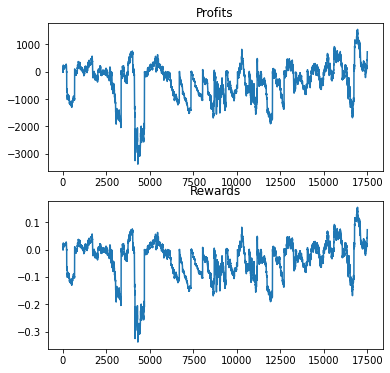

In [9]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 1

In [ ]:
i = 1
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# param combination 2

In [ ]:
i = 2
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 3

In [ ]:
i = 3
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 4

In [ ]:
i = 4
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 5

In [ ]:
i = 5
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 6

In [ ]:
i = 6
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 7

In [ ]:
i = 7
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()